In [2]:
from scipy import stats
import numpy as np
from pyvbmc import  VBMC
import pickle
from ddm_utils import prob_rt_mu, parse_sim_results, rtd_mu_small_t, prob_rt_generic, prob_rt_mu_posterior, rtd_mu
import matplotlib.pyplot as plt
from joblib import Parallel, delayed



# reduce size of sample_rt

In [9]:
# read from all_sim_pkl 
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

a = 2; v = 2;
keyname = f"a={str(a)},v={str(v)}"
choices, RTs = parse_sim_results(all_sim_results[keyname])
with open('sample_rt.pkl', 'wb') as f:
        pickle.dump(RTs, f)

t_arr_small = np.random.choice(RTs, size=10000, replace=False)
with open('sample_rt_small.pkl', 'wb') as f:
    pickle.dump(t_arr_small, f)


In [10]:
prior_bounds = { 'a_low': 0.1, 'a_high': 5, 'v_low': 0.1, 'v_high': 5 }
with open('prior_bounds.pkl', 'wb') as f:
    pickle.dump(prior_bounds, f)


In [11]:
def log_prior(params):
    v,a = params
    with open('prior_bounds.pkl', 'rb') as f:
        prior_bounds = pickle.load(f)

    v_prior = stats.uniform(prior_bounds['v_low'], prior_bounds['v_high'])
    a_prior = stats.uniform(prior_bounds['a_low'], prior_bounds['a_high'])
    
    log_prior_v = v_prior.logpdf(v)
    log_prior_a = a_prior.logpdf(a)
    return log_prior_v + log_prior_a

def rtd_mu_small_t_parallel(t, mu, K_max=4):
    non_sum_term = 2 * np.cosh(mu) * np.exp(-(mu**2)*t/2) * (1/np.sqrt(2*np.pi*(t**3)))
    k_vals = np.linspace(0, K_max, K_max + 1)
    sum_neg_1_term = (-1)**k_vals
    sum_two_k_term = (2*k_vals) + 1
    sum_exp_term = np.exp(-((2*k_vals + 1)**2)/(2*t))
    sum_term = np.sum(sum_neg_1_term*sum_two_k_term*sum_exp_term)
    return non_sum_term*sum_term

def log_like(params):
    v,a = params
    mu = v*(a/2)
    with open('sample_rt_small.pkl', 'rb') as f:
        t_arr = pickle.load(f)
    probs = Parallel(n_jobs=-1)(delayed(rtd_mu_small_t_parallel)(t, mu) for t in t_arr)
    # loglike_norm = np.sum(np.log(probs))*(1/len(t_arr))
    loglike_norm = np.sum(np.log(probs))
    print(f"v={v},a={a},loglike={loglike_norm}")
    return loglike_norm

def log_joint(params):
    return log_like(params) + log_prior(params)




# Is log_like working?

In [22]:
# read from all_sim_pkl 
# with open('all_sim_results.pkl', 'rb') as f:
#     all_sim_results = pickle.load(f)

# a = 2; v = 2;
# keyname = f"a={str(a)},v={str(v)}"
# choices, RTs = parse_sim_results(all_sim_results[keyname])
# with open('sample_rt.pkl', 'wb') as f:
#         pickle.dump(RTs, f)

# testing for sum log prob for diff a,v pairs
a_ = 1; v_ = 1; print(log_like([a_,v_]))
a_ = 2; v_ = 2; print(log_like([a_,v_]))
a_ = 3; v_ = 3; print(log_like([a_,v_]))

v=1,a=1,loglike=-3220.449540721899
-3220.449540721899
v=2,a=2,loglike=-328.20214297603076
-328.20214297603076
v=3,a=3,loglike=-15187.219094006898
-15187.219094006898


In [13]:
lower_bounds = np.array([0.1, 0.1]) 
upper_bounds = np.array([3, 3])
plausible_lower_bounds = np.array([0.5, 0.5])
plausible_upper_bounds = np.array([2.9,2.9])


x0 = np.array([1.2,1.5])

In [14]:
options = {'display': 'off'}
vbmc = VBMC(log_joint, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, options=options)
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting upper bounds to floating point.
v=1.2,a=1.5,loglike=-2190.681138243386
v=0.9308644136657559,a=2.4651346072417026,loglike=-1523.1949787211968
v=1.5464878421168475,a=2.2005979309774033,loglike=-469.3751632024087
v=2.8787578923971266,a=2.5782056954341757,loglike=-7253.646020251363
v=1.774542599872938,a=0.5559813372999685,loglike=-3234.9706960200383
v=1.9504976859351537,a=2.5028956753291602,loglike=-806.2162877754806
v=1.7861987672006907,a=0.8234246380949496,loglike=-2641.12416467859
v=1.0367435059563093,a=1.749555856062431,loglike=-2171.527803156534
v=2.1341583678319718,a=0.7368512756998008,loglike=-2503.787082111078
v=2.523000477174814,a=2.070235557311777,loglike=-1226.852668095195
v=1.98240762313427,a=2.030648882505679,loglike=-330.16549793750664
v=1.9633686568466522,a=2.062998298523339,loglike=-33

# Ground Truth 

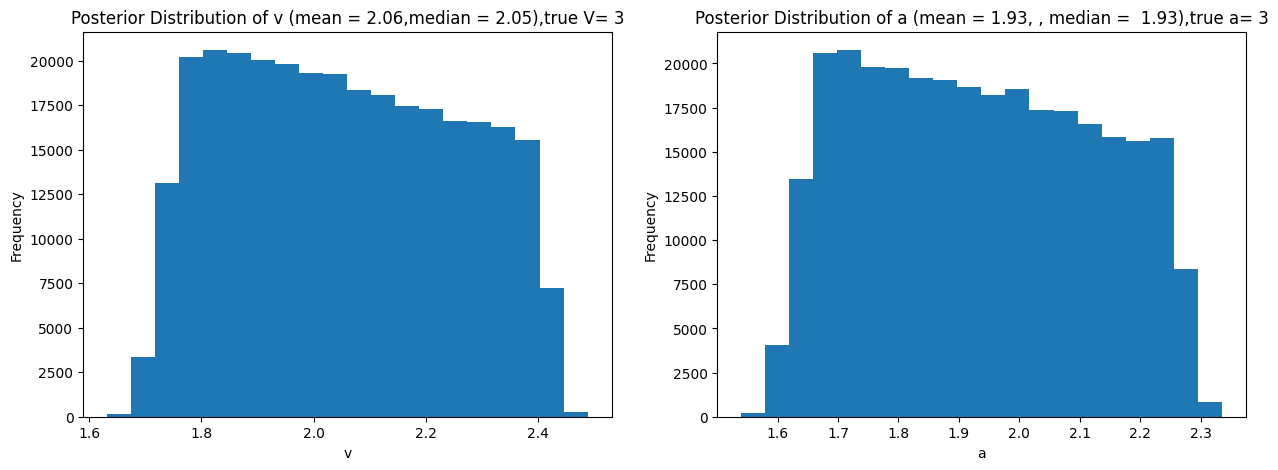

In [15]:
v_a, _ = vp.sample(int(3e5))
v_post = v_a[:,0]
a_post = v_a[:,1]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(v_post, bins=20)
plt.title(f'Posterior Distribution of v (mean = {np.mean(v_post):.2f},median = {np.median(v_post) :.2f}),true V= {v}')
plt.xlabel('v')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(a_post, bins=20)
plt.title(f'Posterior Distribution of a (mean = {np.mean(a_post):.2f}, , median = {np.median(a_post): .2f}),true a= {a}')
plt.xlabel('a')
plt.ylabel('Frequency');


# Scatter plot: high a, low v

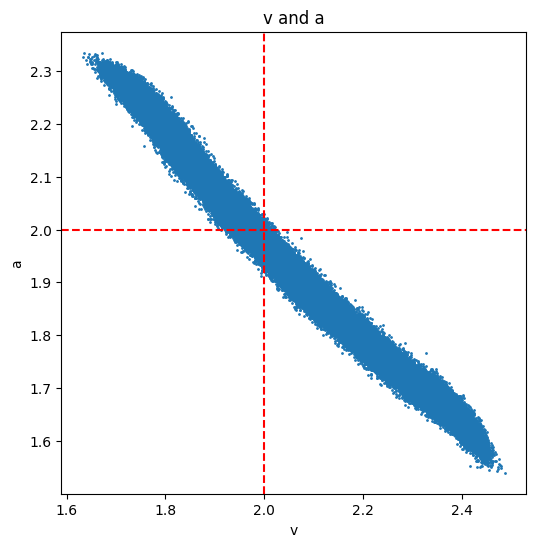

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(v_post, a_post, s=1)
plt.axvline(x=2, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')

plt.xlabel('v')
plt.ylabel('a')
plt.title('v and a')
plt.show()

# Dynesty?

In [18]:
from dynesty import NestedSampler
      
from dynesty import plotting as dyplot

In [19]:
def transform_random_number(u, a, b):
    return (b-a)*u + a 


In [20]:
def prior_transform(u):
    # u ~ uniform [0,1]
    priors = np.array(u)

    # a: 0 to 20
    priors[0] =  transform_random_number(u[0], 0.1, 3)


    # c: -5 to 5
    priors[1] = transform_random_number(u[1], 0.1, 3)

    return priors

In [31]:
ndim = 2
# sampler = NestedSampler(log_likelihood, prior_transform, ndim)
sampler = NestedSampler(log_like, prior_transform, ndim)

v=0.14577019790545226,a=0.39759938231835834,loglike=-3809.0044965048437
v=0.6709134775878032,a=1.4804936746763817,loglike=-3227.7520321360807
v=1.4319062921371857,a=1.745767651179041,loglike=-1269.2580959001507
v=1.9181175969216573,a=2.2534160567369104,loglike=-403.7633378519187
v=0.17121382171829527,a=2.6161230388691443,loglike=-3684.9072232436342
v=1.1619464031456486,a=0.5808506852391132,loglike=-3530.314822031618
v=2.415600222047174,a=2.1027610515006043,loglike=-1033.2165115010962
v=2.9738856470617887,a=0.5842114826393359,loglike=-2277.3144821490387
v=2.949551690586971,a=1.2043754056993428,loglike=-401.6126831059164
v=2.212072251421602,a=2.2490063221617786,loglike=-907.56514127524
v=2.144494560014301,a=0.9982208828843965,loglike=-1724.973319371671
v=2.3525864168506465,a=1.5332848005749768,loglike=-381.9760420216932
v=1.5490404231633357,a=1.4242927104694476,loglike=-1638.0610706013954
v=0.5773896973695872,a=1.6603022506067844,loglike=-3264.8699954271233
v=0.22631726441042305,a=2.2086

In [32]:
sampler.run_nested()

1it [00:00,  2.45it/s, bound: 0 | nc: 1 | ncall: 501 | eff(%):  0.200 | loglstar:   -inf < -13810.291 <    inf | logz: -13817.201 +/-  0.117 | dlogz:    inf >  0.509]

v=0.3801923649433546,a=0.7636956245768386,loglike=-3757.603201929601


2it [00:00,  2.58it/s, bound: 0 | nc: 1 | ncall: 502 | eff(%):  0.398 | loglstar:   -inf < -12163.285 <    inf | logz: -12170.197 +/-  0.118 | dlogz: 13490.444 >  0.509]

v=1.9107999288123894,a=2.29224805839655,loglike=-429.13126072891475


3it [00:01,  2.38it/s, bound: 0 | nc: 1 | ncall: 503 | eff(%):  0.596 | loglstar:   -inf < -10262.799 <    inf | logz: -10269.712 +/-  0.118 | dlogz: 11843.438 >  0.509]

v=2.016305507047778,a=1.791198294172073,loglike=-380.5190006386672


4it [00:01,  2.50it/s, bound: 0 | nc: 1 | ncall: 504 | eff(%):  0.794 | loglstar:   -inf < -9420.270 <    inf | logz: -9427.185 +/-  0.118 | dlogz: 9942.951 >  0.509]   

v=0.49825998445329456,a=0.39965631344024244,loglike=-3785.873033245188


5it [00:01,  2.59it/s, bound: 0 | nc: 1 | ncall: 505 | eff(%):  0.990 | loglstar:   -inf < -8663.201 <    inf | logz: -8670.119 +/-  0.118 | dlogz: 9100.422 >  0.509]

v=1.1533565222862434,a=1.6607456956634115,loglike=-2031.1802637689661


6it [00:02,  2.67it/s, bound: 0 | nc: 1 | ncall: 506 | eff(%):  1.186 | loglstar:   -inf < -7668.253 <    inf | logz: -7675.173 +/-  0.118 | dlogz: 8343.353 >  0.509]

v=1.7985391595065705,a=1.2978747454329702,loglike=-1472.742846721639


7it [00:02,  2.72it/s, bound: 0 | nc: 1 | ncall: 507 | eff(%):  1.381 | loglstar:   -inf < -7273.707 <    inf | logz: -7280.629 +/-  0.118 | dlogz: 7348.406 >  0.509]

v=1.2190157590589168,a=0.9697461720758065,loglike=-3010.5439864253185


8it [00:03,  2.52it/s, bound: 0 | nc: 1 | ncall: 508 | eff(%):  1.575 | loglstar:   -inf < -7263.215 <    inf | logz: -7270.139 +/-  0.118 | dlogz: 6953.860 >  0.509]

v=2.75967860349868,a=1.290847030581781,loglike=-397.8330914315582


9it [00:03,  2.60it/s, bound: 0 | nc: 1 | ncall: 509 | eff(%):  1.768 | loglstar:   -inf < -6914.519 <    inf | logz: -6921.445 +/-  0.118 | dlogz: 6943.367 >  0.509]

v=1.793649386934725,a=2.0964261069880665,loglike=-342.59945360166495


10it [00:03,  2.58it/s, bound: 0 | nc: 1 | ncall: 510 | eff(%):  1.961 | loglstar:   -inf < -6575.649 <    inf | logz: -6582.577 +/-  0.118 | dlogz: 6594.672 >  0.509]

v=2.2606582286130683,a=1.0691669395167154,loglike=-1369.4027201209692


11it [00:04,  2.62it/s, bound: 0 | nc: 1 | ncall: 511 | eff(%):  2.153 | loglstar:   -inf < -6351.955 <    inf | logz: -6358.885 +/-  0.118 | dlogz: 6255.802 >  0.509]

v=0.4667309793175103,a=0.6618568053917017,loglike=-3750.593873523731


12it [00:04,  2.66it/s, bound: 0 | nc: 1 | ncall: 512 | eff(%):  2.344 | loglstar:   -inf < -6171.473 <    inf | logz: -6178.404 +/-  0.118 | dlogz: 6032.107 >  0.509]

v=1.802866514538379,a=0.19655982716509174,loglike=-3731.651875341752


13it [00:04,  2.69it/s, bound: 0 | nc: 1 | ncall: 513 | eff(%):  2.534 | loglstar:   -inf < -6151.715 <    inf | logz: -6158.649 +/-  0.118 | dlogz: 5851.625 >  0.509]

v=2.3946691829231845,a=2.191325455301176,loglike=-1261.9512884136973


14it [00:05,  2.71it/s, bound: 0 | nc: 1 | ncall: 514 | eff(%):  2.724 | loglstar:   -inf < -5642.487 <    inf | logz: -5649.423 +/-  0.118 | dlogz: 5831.868 >  0.509]

v=1.1555774100568172,a=0.7666004387158095,loglike=-3339.7449699257213


15it [00:05,  2.71it/s, bound: 0 | nc: 1 | ncall: 515 | eff(%):  2.913 | loglstar:   -inf < -5153.720 <    inf | logz: -5160.658 +/-  0.118 | dlogz: 5322.640 >  0.509]

v=0.5342959102179257,a=1.7572166601681594,loglike=-3285.6323365719745


16it [00:06,  2.78it/s, bound: 0 | nc: 1 | ncall: 516 | eff(%):  3.101 | loglstar:   -inf < -5121.391 <    inf | logz: -5128.330 +/-  0.118 | dlogz: 4833.873 >  0.509]

v=1.4240330726681332,a=1.0730268810793373,loglike=-2564.2054236963068


17it [00:06,  2.69it/s, bound: 0 | nc: 1 | ncall: 517 | eff(%):  3.288 | loglstar:   -inf < -5065.301 <    inf | logz: -5072.243 +/-  0.118 | dlogz: 4801.543 >  0.509]

v=0.7787928403077503,a=2.135182770341239,loglike=-2380.116090823731


18it [00:06,  2.70it/s, bound: 0 | nc: 1 | ncall: 518 | eff(%):  3.475 | loglstar:   -inf < -4829.804 <    inf | logz: -4836.748 +/-  0.118 | dlogz: 4745.453 >  0.509]

v=2.2087984586286953,a=2.812379092671722,loglike=-3218.861246638621


19it [00:07,  2.82it/s, bound: 0 | nc: 1 | ncall: 519 | eff(%):  3.661 | loglstar:   -inf < -4777.812 <    inf | logz: -4784.758 +/-  0.118 | dlogz: 4509.957 >  0.509]

v=0.47786112875761566,a=1.3280878582789528,loglike=-3561.786681734069


20it [00:07,  2.80it/s, bound: 0 | nc: 1 | ncall: 520 | eff(%):  3.846 | loglstar:   -inf < -4576.559 <    inf | logz: -4583.507 +/-  0.118 | dlogz: 4457.965 >  0.509]

v=1.9791652155439092,a=0.6221250511385287,loglike=-2950.390588044349


21it [00:07,  2.71it/s, bound: 0 | nc: 1 | ncall: 521 | eff(%):  4.031 | loglstar:   -inf < -4485.879 <    inf | logz: -4492.829 +/-  0.118 | dlogz: 4256.711 >  0.509]

v=0.9069038016653758,a=2.7914808172069105,loglike=-1231.6697060027223


22it [00:08,  2.75it/s, bound: 0 | nc: 1 | ncall: 522 | eff(%):  4.215 | loglstar:   -inf < -4311.502 <    inf | logz: -4318.454 +/-  0.118 | dlogz: 4166.031 >  0.509]

v=1.722690049370148,a=0.40983044577116634,loglike=-3504.889856031932


23it [00:08,  2.78it/s, bound: 0 | nc: 1 | ncall: 523 | eff(%):  4.398 | loglstar:   -inf < -3951.108 <    inf | logz: -3958.062 +/-  0.118 | dlogz: 3991.655 >  0.509]

v=2.529968680336344,a=2.415371887646611,loglike=-2961.561037321482


24it [00:08,  2.83it/s, bound: 0 | nc: 1 | ncall: 524 | eff(%):  4.580 | loglstar:   -inf < -3945.242 <    inf | logz: -3952.192 +/-  0.118 | dlogz: 3631.261 >  0.509]

v=0.9786244056461204,a=0.4749570883680162,loglike=-3675.3766442814485


25it [00:09,  2.86it/s, bound: 0 | nc: 1 | ncall: 525 | eff(%):  4.762 | loglstar:   -inf < -3810.920 <    inf | logz: -3817.878 +/-  0.118 | dlogz: 3625.389 >  0.509]

v=2.429994475876407,a=2.5702658956857385,loglike=-3307.443234710563


26it [00:09,  2.85it/s, bound: 0 | nc: 1 | ncall: 526 | eff(%):  4.943 | loglstar:   -inf < -3810.748 <    inf | logz: -3816.720 +/-  0.108 | dlogz: 3491.073 >  0.509]

v=2.004718482495156,a=2.9816958946746377,loglike=-2641.1273169130145


27it [00:09,  2.82it/s, bound: 0 | nc: 1 | ncall: 527 | eff(%):  5.123 | loglstar:   -inf < -3809.312 <    inf | logz: -3815.644 +/-  0.106 | dlogz: 3489.913 >  0.509]

v=2.3119510902469056,a=2.108138792371467,loglike=-797.9912178448241


28it [00:10,  2.71it/s, bound: 0 | nc: 1 | ncall: 528 | eff(%):  5.303 | loglstar:   -inf < -3809.004 <    inf | logz: -3814.831 +/-  0.103 | dlogz: 3488.835 >  0.509]

v=1.750521431720492,a=2.7289915815853436,loglike=-704.0379878757033


29it [00:10,  2.74it/s, bound: 0 | nc: 1 | ncall: 529 | eff(%):  5.482 | loglstar:   -inf < -3808.794 <    inf | logz: -3814.292 +/-  0.100 | dlogz: 3488.020 >  0.509]

v=1.8188262871343337,a=2.3445045566013802,loglike=-381.9068045370534


30it [00:11,  2.68it/s, bound: 0 | nc: 1 | ncall: 530 | eff(%):  5.660 | loglstar:   -inf < -3808.577 <    inf | logz: -3813.876 +/-  0.098 | dlogz: 3487.478 >  0.509]

v=2.1695558734566998,a=1.3207861750905825,loglike=-873.5845132856225


31it [00:11,  2.80it/s, bound: 0 | nc: 1 | ncall: 531 | eff(%):  5.838 | loglstar:   -inf < -3808.485 <    inf | logz: -3813.544 +/-  0.096 | dlogz: 3487.061 >  0.509]

v=1.1587268982828942,a=0.17371579233734902,loglike=-3785.3243823698085


32it [00:11,  2.85it/s, bound: 0 | nc: 1 | ncall: 532 | eff(%):  6.015 | loglstar:   -inf < -3805.386 <    inf | logz: -3812.057 +/-  0.107 | dlogz: 3486.726 >  0.509]

v=0.5620399808140026,a=0.4696252470070177,loglike=-3766.846797642219


33it [00:12,  2.74it/s, bound: 0 | nc: 1 | ncall: 533 | eff(%):  6.191 | loglstar:   -inf < -3803.794 <    inf | logz: -3810.377 +/-  0.109 | dlogz: 3485.238 >  0.509]

v=1.7703979921906388,a=1.3578662699889488,loglike=-1385.5063332261825


34it [00:12,  2.64it/s, bound: 0 | nc: 1 | ncall: 534 | eff(%):  6.367 | loglstar:   -inf < -3803.296 <    inf | logz: -3809.352 +/-  0.105 | dlogz: 3483.556 >  0.509]

v=0.5372735496684279,a=1.0999732493080625,loglike=-3593.986436608339
v=0.34936284788974553,a=0.2733617584529649,loglike=-3805.3233824361178


35it [00:13,  1.98it/s, bound: 0 | nc: 2 | ncall: 536 | eff(%):  6.530 | loglstar:   -inf < -3801.195 <    inf | logz: -3807.815 +/-  0.108 | dlogz: 3482.529 >  0.509]

v=1.8030678036445524,a=0.30911789437520926,loglike=-3617.3977507139894


36it [00:13,  2.18it/s, bound: 0 | nc: 1 | ncall: 537 | eff(%):  6.704 | loglstar:   -inf < -3800.691 <    inf | logz: -3806.767 +/-  0.105 | dlogz: 3480.990 >  0.509]

v=0.5983553950180083,a=1.9644610884851035,loglike=-3018.62637203625


37it [00:14,  2.35it/s, bound: 0 | nc: 1 | ncall: 538 | eff(%):  6.877 | loglstar:   -inf < -3799.918 <    inf | logz: -3805.943 +/-  0.103 | dlogz: 3479.940 >  0.509]

v=0.850505479308523,a=1.6782117636989575,loglike=-2698.9124230940124


38it [00:14,  2.55it/s, bound: 0 | nc: 1 | ncall: 539 | eff(%):  7.050 | loglstar:   -inf < -3799.113 <    inf | logz: -3805.136 +/-  0.102 | dlogz: 3479.114 >  0.509]

v=1.0595377076408956,a=0.1570620717243951,loglike=-3793.48065317021


39it [00:14,  2.65it/s, bound: 0 | nc: 1 | ncall: 540 | eff(%):  7.222 | loglstar:   -inf < -3798.990 <    inf | logz: -3804.541 +/-  0.100 | dlogz: 3478.305 >  0.509]

v=0.5678375498268332,a=2.9626713668143356,loglike=-2353.329064199747


40it [00:15,  2.69it/s, bound: 0 | nc: 1 | ncall: 541 | eff(%):  7.394 | loglstar:   -inf < -3798.955 <    inf | logz: -3804.146 +/-  0.098 | dlogz: 3477.708 >  0.509]

v=0.37994790407336,a=2.6670076255322663,loglike=-3205.864618057377


41it [00:15,  2.80it/s, bound: 0 | nc: 1 | ncall: 542 | eff(%):  7.565 | loglstar:   -inf < -3797.246 <    inf | logz: -3803.414 +/-  0.100 | dlogz: 3477.311 >  0.509]

v=0.16173706388569625,a=2.585292831505043,loglike=-3700.9063874459966


42it [00:15,  2.92it/s, bound: 0 | nc: 1 | ncall: 543 | eff(%):  7.735 | loglstar:   -inf < -3794.652 <    inf | logz: -3801.424 +/-  0.110 | dlogz: 3476.577 >  0.509]

v=0.33214408469006745,a=1.9617430725738778,loglike=-3548.753349814223


43it [00:16,  2.78it/s, bound: 0 | nc: 1 | ncall: 544 | eff(%):  7.904 | loglstar:   -inf < -3793.900 <    inf | logz: -3800.171 +/-  0.107 | dlogz: 3474.585 >  0.509]

v=2.878230252395363,a=2.103126674193453,loglike=-2820.7063724817062


44it [00:16,  2.83it/s, bound: 0 | nc: 1 | ncall: 545 | eff(%):  8.073 | loglstar:   -inf < -3793.788 <    inf | logz: -3799.465 +/-  0.103 | dlogz: 3473.330 >  0.509]

v=1.8097058194510405,a=2.250731444448621,loglike=-335.6463558874254


45it [00:16,  2.86it/s, bound: 0 | nc: 1 | ncall: 546 | eff(%):  8.242 | loglstar:   -inf < -3793.481 <    inf | logz: -3798.976 +/-  0.100 | dlogz: 3472.621 >  0.509]

v=2.2444164554844264,a=0.5384472047591192,loglike=-2978.445009970873


46it [00:17,  2.81it/s, bound: 0 | nc: 1 | ncall: 547 | eff(%):  8.410 | loglstar:   -inf < -3791.631 <    inf | logz: -3798.007 +/-  0.103 | dlogz: 3472.131 >  0.509]

v=2.0924848747804576,a=1.4215491224546182,loglike=-772.9274082283742


47it [00:17,  2.86it/s, bound: 0 | nc: 1 | ncall: 548 | eff(%):  8.577 | loglstar:   -inf < -3791.399 <    inf | logz: -3797.215 +/-  0.102 | dlogz: 3471.160 >  0.509]

v=0.2032534308061818,a=2.765887421819829,loglike=-3614.1203785363286


48it [00:17,  2.92it/s, bound: 0 | nc: 1 | ncall: 549 | eff(%):  8.743 | loglstar:   -inf < -3789.344 <    inf | logz: -3795.911 +/-  0.106 | dlogz: 3470.366 >  0.509]

v=1.9802829328092213,a=2.446059508445058,loglike=-767.6924912114299


49it [00:18,  2.95it/s, bound: 0 | nc: 1 | ncall: 550 | eff(%):  8.909 | loglstar:   -inf < -3787.614 <    inf | logz: -3794.247 +/-  0.109 | dlogz: 3469.060 >  0.509]

v=2.3674634011358937,a=2.3611198096821644,loglike=-1830.2546252221273


50it [00:18,  2.90it/s, bound: 0 | nc: 1 | ncall: 551 | eff(%):  9.074 | loglstar:   -inf < -3785.873 <    inf | logz: -3792.523 +/-  0.109 | dlogz: 3467.394 >  0.509]

v=2.898205116413927,a=0.8243221098507791,loglike=-1403.9898179463164


51it [00:18,  2.99it/s, bound: 0 | nc: 1 | ncall: 552 | eff(%):  9.239 | loglstar:   -inf < -3785.324 <    inf | logz: -3791.456 +/-  0.106 | dlogz: 3465.668 >  0.509]

v=2.4455346129321476,a=1.1082707524226574,loglike=-1031.2702295090567


52it [00:19,  2.93it/s, bound: 0 | nc: 1 | ncall: 553 | eff(%):  9.403 | loglstar:   -inf < -3784.572 <    inf | logz: -3790.625 +/-  0.103 | dlogz: 3464.599 >  0.509]

v=1.031664563162598,a=0.960880592547431,loglike=-3229.8946435456955


53it [00:19,  3.03it/s, bound: 0 | nc: 1 | ncall: 554 | eff(%):  9.567 | loglstar:   -inf < -3778.950 <    inf | logz: -3785.950 +/-  0.118 | dlogz: 3463.766 >  0.509]

v=1.2734472279637201,a=2.308720793029472,loglike=-803.8553451076968
v=0.1173492187785257,a=0.9670510424014181,loglike=-3802.92447916658


54it [00:20,  2.36it/s, bound: 0 | nc: 2 | ncall: 556 | eff(%):  9.712 | loglstar:   -inf < -3775.663 <    inf | logz: -3782.606 +/-  0.116 | dlogz: 3459.089 >  0.509]

v=0.2002586392267271,a=1.4303124042873583,loglike=-3759.0293833271203


55it [00:20,  2.41it/s, bound: 0 | nc: 1 | ncall: 557 | eff(%):  9.874 | loglstar:   -inf < -3771.749 <    inf | logz: -3778.726 +/-  0.117 | dlogz: 3455.743 >  0.509]

v=0.2125491144162303,a=2.581236416916491,loglike=-3623.2684034789045


56it [00:20,  2.61it/s, bound: 0 | nc: 1 | ncall: 558 | eff(%): 10.036 | loglstar:   -inf < -3771.337 <    inf | logz: -3777.501 +/-  0.108 | dlogz: 3451.861 >  0.509]

v=2.139487677784603,a=1.4426752270199548,loglike=-678.9269671393162
v=0.6495289948985175,a=0.21788094979633787,loglike=-3798.364137611325


57it [00:21,  2.01it/s, bound: 0 | nc: 2 | ncall: 560 | eff(%): 10.179 | loglstar:   -inf < -3770.375 <    inf | logz: -3776.571 +/-  0.105 | dlogz: 3450.634 >  0.509]

v=0.8117378015941998,a=2.6725623644468564,loglike=-1686.7395060518893


58it [00:22,  2.12it/s, bound: 0 | nc: 1 | ncall: 561 | eff(%): 10.339 | loglstar:   -inf < -3770.365 <    inf | logz: -3775.941 +/-  0.102 | dlogz: 3449.702 >  0.509]

v=0.5289899109530095,a=1.658359060355971,loglike=-3348.3143058523838


59it [00:22,  2.36it/s, bound: 0 | nc: 1 | ncall: 562 | eff(%): 10.498 | loglstar:   -inf < -3768.452 <    inf | logz: -3774.903 +/-  0.105 | dlogz: 3449.070 >  0.509]

v=1.4047875255285174,a=1.7493287430516595,loglike=-1320.0728888509898


60it [00:22,  2.53it/s, bound: 0 | nc: 1 | ncall: 563 | eff(%): 10.657 | loglstar:   -inf < -3766.847 <    inf | logz: -3773.431 +/-  0.108 | dlogz: 3448.030 >  0.509]

v=1.7268949058171121,a=0.8204951605779088,loglike=-2712.670767711396


61it [00:23,  2.59it/s, bound: 0 | nc: 1 | ncall: 564 | eff(%): 10.816 | loglstar:   -inf < -3766.750 <    inf | logz: -3772.578 +/-  0.104 | dlogz: 3446.556 >  0.509]

v=0.6069858168513389,a=1.6495541442443977,loglike=-3219.080321662481
v=0.14858272254595245,a=0.5746239158527593,loglike=-3806.492919829413


62it [00:23,  2.06it/s, bound: 0 | nc: 2 | ncall: 566 | eff(%): 10.954 | loglstar:   -inf < -3762.928 <    inf | logz: -3769.869 +/-  0.115 | dlogz: 3445.701 >  0.509]

v=2.2182612515283555,a=1.6189156344935938,loglike=-387.4125589390199


63it [00:24,  2.25it/s, bound: 0 | nc: 1 | ncall: 567 | eff(%): 11.111 | loglstar:   -inf < -3762.850 <    inf | logz: -3768.805 +/-  0.107 | dlogz: 3442.990 >  0.509]

v=2.71276007422982,a=1.2839595390217395,loglike=-430.5145032623683


64it [00:24,  2.20it/s, bound: 0 | nc: 1 | ncall: 568 | eff(%): 11.268 | loglstar:   -inf < -3760.984 <    inf | logz: -3767.543 +/-  0.108 | dlogz: 3441.924 >  0.509]

v=1.5261372399767374,a=1.5718201147182724,loglike=-1391.8801474515021


65it [00:24,  2.42it/s, bound: 0 | nc: 1 | ncall: 569 | eff(%): 11.424 | loglstar:   -inf < -3759.029 <    inf | logz: -3765.752 +/-  0.110 | dlogz: 3440.660 >  0.509]

v=2.855120885456391,a=1.3603156700668242,loglike=-327.8355116491969


66it [00:25,  2.38it/s, bound: 0 | nc: 1 | ncall: 570 | eff(%): 11.579 | loglstar:   -inf < -3757.603 <    inf | logz: -3764.192 +/-  0.109 | dlogz: 3438.867 >  0.509]

v=0.7383012863732915,a=1.889633006561485,loglike=-2741.320063697512


67it [00:25,  2.57it/s, bound: 0 | nc: 1 | ncall: 571 | eff(%): 11.734 | loglstar:   -inf < -3756.373 <    inf | logz: -3762.854 +/-  0.107 | dlogz: 3437.305 >  0.509]

v=1.5437739615212467,a=0.8248152803164671,loglike=-2897.9246742078526


68it [00:25,  2.71it/s, bound: 0 | nc: 1 | ncall: 572 | eff(%): 11.888 | loglstar:   -inf < -3756.320 <    inf | logz: -3762.079 +/-  0.104 | dlogz: 3435.965 >  0.509]

v=1.273047837665232,a=0.7189757280087152,loglike=-3309.9925484715022


69it [00:26,  2.84it/s, bound: 0 | nc: 1 | ncall: 573 | eff(%): 12.042 | loglstar:   -inf < -3755.221 <    inf | logz: -3761.335 +/-  0.103 | dlogz: 3435.188 >  0.509]

v=2.292326042595722,a=1.4021942892712203,loglike=-584.0844667237533


70it [00:26,  2.92it/s, bound: 0 | nc: 1 | ncall: 574 | eff(%): 12.195 | loglstar:   -inf < -3752.317 <    inf | logz: -3759.187 +/-  0.112 | dlogz: 3434.442 >  0.509]

v=1.6965148128446155,a=1.6911135422449246,loglike=-870.2388981045568


71it [00:26,  2.87it/s, bound: 0 | nc: 1 | ncall: 575 | eff(%): 12.348 | loglstar:   -inf < -3752.121 <    inf | logz: -3758.139 +/-  0.107 | dlogz: 3432.292 >  0.509]

v=1.9409478628708061,a=2.76828847404313,loglike=-1454.4343727742817


72it [00:27,  2.87it/s, bound: 0 | nc: 1 | ncall: 576 | eff(%): 12.500 | loglstar:   -inf < -3750.594 <    inf | logz: -3757.042 +/-  0.106 | dlogz: 3431.242 >  0.509]

v=2.5025588813687265,a=0.4911932716019831,loglike=-2952.9234395219996


73it [00:27,  2.91it/s, bound: 0 | nc: 1 | ncall: 577 | eff(%): 12.652 | loglstar:   -inf < -3749.023 <    inf | logz: -3755.614 +/-  0.108 | dlogz: 3430.143 >  0.509]

v=0.9806273413814359,a=1.3787358916499677,loglike=-2797.448704054594


74it [00:27,  2.96it/s, bound: 0 | nc: 1 | ncall: 578 | eff(%): 12.803 | loglstar:   -inf < -3748.078 <    inf | logz: -3754.437 +/-  0.106 | dlogz: 3428.713 >  0.509]

v=2.3755124079209002,a=0.3509406475065987,loglike=-3390.712437976925


75it [00:28,  2.94it/s, bound: 0 | nc: 1 | ncall: 579 | eff(%): 12.953 | loglstar:   -inf < -3747.320 <    inf | logz: -3753.498 +/-  0.104 | dlogz: 3427.534 >  0.509]

v=1.7203398538332864,a=1.0299479547701065,loglike=-2229.6214623800743


76it [00:28,  2.97it/s, bound: 0 | nc: 1 | ncall: 580 | eff(%): 13.103 | loglstar:   -inf < -3743.770 <    inf | logz: -3750.736 +/-  0.115 | dlogz: 3426.593 >  0.509]

v=1.5160879665397893,a=1.5111875548132456,loglike=-1527.8320483069765


77it [00:28,  3.05it/s, bound: 0 | nc: 1 | ncall: 581 | eff(%): 13.253 | loglstar:   -inf < -3735.803 <    inf | logz: -3742.864 +/-  0.119 | dlogz: 3423.829 >  0.509]

v=2.6932074296556374,a=1.3392604593577584,loglike=-382.0686126394388


78it [00:29,  3.04it/s, bound: 0 | nc: 1 | ncall: 582 | eff(%): 13.402 | loglstar:   -inf < -3734.859 <    inf | logz: -3741.346 +/-  0.110 | dlogz: 3415.955 >  0.509]

v=1.719447295725894,a=0.2291985927630138,loglike=-3713.0655382217215


79it [00:29,  2.85it/s, bound: 0 | nc: 1 | ncall: 583 | eff(%): 13.551 | loglstar:   -inf < -3731.652 <    inf | logz: -3738.611 +/-  0.115 | dlogz: 3414.435 >  0.509]

v=1.598436346666256,a=0.9754088590418745,loglike=-2522.0520609658606


80it [00:30,  2.79it/s, bound: 0 | nc: 1 | ncall: 584 | eff(%): 13.699 | loglstar:   -inf < -3728.963 <    inf | logz: -3735.896 +/-  0.115 | dlogz: 3411.698 >  0.509]

v=2.0768589865770166,a=2.688241262566426,loglike=-1817.6834872903455


81it [00:30,  2.90it/s, bound: 0 | nc: 1 | ncall: 585 | eff(%): 13.846 | loglstar:   -inf < -3728.184 <    inf | logz: -3734.568 +/-  0.109 | dlogz: 3408.981 >  0.509]

v=1.5515692420407057,a=0.8908326496335534,loglike=-2758.2373328566673
v=0.8763329831034048,a=0.28081803151612983,loglike=-3772.610698312725


82it [00:31,  2.31it/s, bound: 0 | nc: 2 | ncall: 587 | eff(%): 13.969 | loglstar:   -inf < -3720.000 <    inf | logz: -3727.071 +/-  0.119 | dlogz: 3407.651 >  0.509]

v=2.9824365984623697,a=2.0325599245331234,loglike=-2841.7476627045467


83it [00:31,  2.51it/s, bound: 0 | nc: 1 | ncall: 588 | eff(%): 14.116 | loglstar:   -inf < -3714.726 <    inf | logz: -3721.789 +/-  0.118 | dlogz: 3400.152 >  0.509]

v=2.506673798345583,a=1.9724558467186484,loglike=-873.0772443185883


84it [00:31,  2.68it/s, bound: 0 | nc: 1 | ncall: 589 | eff(%): 14.261 | loglstar:   -inf < -3713.066 <    inf | logz: -3719.817 +/-  0.112 | dlogz: 3394.868 >  0.509]

v=0.3813951250895089,a=1.1992385741911926,loglike=-3679.604994587916


85it [00:31,  2.82it/s, bound: 0 | nc: 1 | ncall: 590 | eff(%): 14.407 | loglstar:   -inf < -3712.615 <    inf | logz: -3718.768 +/-  0.107 | dlogz: 3392.894 >  0.509]

v=2.804672051976747,a=0.17123750150881795,loglike=-3666.364455958298


86it [00:32,  2.92it/s, bound: 0 | nc: 1 | ncall: 591 | eff(%): 14.552 | loglstar:   -inf < -3711.543 <    inf | logz: -3717.831 +/-  0.105 | dlogz: 3391.843 >  0.509]

v=1.3293958016605432,a=0.7379174974602438,loglike=-3241.0350613793435


87it [00:32,  3.00it/s, bound: 0 | nc: 1 | ncall: 592 | eff(%): 14.696 | loglstar:   -inf < -3704.508 <    inf | logz: -3711.587 +/-  0.119 | dlogz: 3390.904 >  0.509]

v=1.3409829600400942,a=0.32847519377554696,loglike=-3688.999486126785


88it [00:32,  3.03it/s, bound: 0 | nc: 1 | ncall: 593 | eff(%): 14.840 | loglstar:   -inf < -3704.246 <    inf | logz: -3710.396 +/-  0.109 | dlogz: 3384.658 >  0.509]

v=0.3837316463695074,a=1.4674221803748995,loglike=-3613.491214868754


89it [00:33,  3.04it/s, bound: 0 | nc: 1 | ncall: 594 | eff(%): 14.983 | loglstar:   -inf < -3700.906 <    inf | logz: -3707.873 +/-  0.115 | dlogz: 3383.465 >  0.509]

v=1.5999298564067284,a=1.8620430514704251,loglike=-768.9038051862279


90it [00:33,  3.11it/s, bound: 0 | nc: 1 | ncall: 595 | eff(%): 15.126 | loglstar:   -inf < -3700.163 <    inf | logz: -3706.552 +/-  0.109 | dlogz: 3380.940 >  0.509]

v=0.30030732547794914,a=2.843654564628725,loglike=-3371.168154085859
v=2.578515435322907,a=2.816921416746273,loglike=-6624.005025100745


91it [00:34,  2.29it/s, bound: 0 | nc: 2 | ncall: 597 | eff(%): 15.243 | loglstar:   -inf < -3696.973 <    inf | logz: -3703.946 +/-  0.115 | dlogz: 3379.617 >  0.509]

v=0.5643152042384935,a=2.561143575981559,loglike=-2675.105789357868


92it [00:34,  2.51it/s, bound: 0 | nc: 1 | ncall: 598 | eff(%): 15.385 | loglstar:   -inf < -3692.742 <    inf | logz: -3699.803 +/-  0.118 | dlogz: 3377.009 >  0.509]

v=2.936925468819173,a=1.9640383812416442,loglike=-2181.2076931187307


93it [00:34,  2.69it/s, bound: 0 | nc: 1 | ncall: 599 | eff(%): 15.526 | loglstar:   -inf < -3688.999 <    inf | logz: -3696.046 +/-  0.117 | dlogz: 3372.864 >  0.509]

v=1.0937416535277862,a=1.0077366346858407,loglike=-3105.3491930637265


94it [00:35,  2.80it/s, bound: 0 | nc: 1 | ncall: 600 | eff(%): 15.667 | loglstar:   -inf < -3688.747 <    inf | logz: -3694.890 +/-  0.109 | dlogz: 3369.105 >  0.509]

v=2.5253593413983437,a=1.7304273167150144,loglike=-424.438817580426
v=2.964861110914924,a=0.14844772901283615,loglike=-3689.191994577833


95it [00:35,  2.27it/s, bound: 0 | nc: 2 | ncall: 602 | eff(%): 15.781 | loglstar:   -inf < -3685.007 <    inf | logz: -3692.023 +/-  0.116 | dlogz: 3367.947 >  0.509]

v=1.1516834330674461,a=0.895873984385105,loglike=-3185.4660506826162


96it [00:36,  2.47it/s, bound: 0 | nc: 1 | ncall: 603 | eff(%): 15.920 | loglstar:   -inf < -3684.907 <    inf | logz: -3690.946 +/-  0.108 | dlogz: 3365.078 >  0.509]

v=0.8020207669319657,a=1.6898568209563143,loglike=-2793.2099492374687


97it [00:36,  2.57it/s, bound: 0 | nc: 1 | ncall: 604 | eff(%): 16.060 | loglstar:   -inf < -3681.068 <    inf | logz: -3688.090 +/-  0.116 | dlogz: 3363.999 >  0.509]

v=2.234681899481787,a=1.7514243205075468,loglike=-326.59612173161054


98it [00:36,  2.73it/s, bound: 0 | nc: 1 | ncall: 605 | eff(%): 16.198 | loglstar:   -inf < -3680.937 <    inf | logz: -3687.001 +/-  0.108 | dlogz: 3361.300 >  0.509]

v=2.422673224809473,a=1.9317926859061845,loglike=-620.4964900132283


99it [00:37,  2.84it/s, bound: 0 | nc: 1 | ncall: 606 | eff(%): 16.337 | loglstar:   -inf < -3679.605 <    inf | logz: -3686.011 +/-  0.106 | dlogz: 3360.209 >  0.509]

v=1.0853894961575916,a=2.2710867757293793,loglike=-1310.9111114126868


100it [00:37,  2.64it/s, bound: 0 | nc: 1 | ncall: 607 | eff(%): 16.474 | loglstar:   -inf < -3679.548 <    inf | logz: -3685.308 +/-  0.103 | dlogz: 3359.217 >  0.509]

v=2.3097927586783324,a=0.46167814592924594,loglike=-3146.516926068667


101it [00:38,  2.54it/s, bound: 0 | nc: 1 | ncall: 608 | eff(%): 16.612 | loglstar:   -inf < -3675.377 <    inf | logz: -3682.414 +/-  0.116 | dlogz: 3358.512 >  0.509]

v=0.8265281780164135,a=1.2687372312149205,loglike=-3166.574471883091


102it [00:38,  2.47it/s, bound: 0 | nc: 1 | ncall: 609 | eff(%): 16.749 | loglstar:   -inf < -3669.796 <    inf | logz: -3676.900 +/-  0.119 | dlogz: 3355.616 >  0.509]

v=2.616382939061515,a=0.6459119185486965,loglike=-2342.801073205953


103it [00:38,  2.52it/s, bound: 0 | nc: 1 | ncall: 610 | eff(%): 16.885 | loglstar:   -inf < -3667.420 <    inf | logz: -3674.362 +/-  0.115 | dlogz: 3350.100 >  0.509]

v=0.9564361187894115,a=0.8364478224382634,loglike=-3422.2922930293166


104it [00:39,  2.64it/s, bound: 0 | nc: 1 | ncall: 611 | eff(%): 17.021 | loglstar:   -inf < -3666.364 <    inf | logz: -3672.914 +/-  0.110 | dlogz: 3347.560 >  0.509]

v=0.9341604845780608,a=2.379595858156537,loglike=-1616.236941696157
v=0.142141912568544,a=0.5234699227052761,loglike=-3807.6130227725407
v=2.206481484274778,a=0.11228052047079924,loglike=-3772.093215810107
v=1.7184902860655735,a=0.19541397783625664,loglike=-3739.6848392939883


105it [00:40,  1.57it/s, bound: 0 | nc: 4 | ncall: 615 | eff(%): 17.073 | loglstar:   -inf < -3664.824 <    inf | logz: -3671.476 +/-  0.109 | dlogz: 3346.110 >  0.509]

v=1.3271420349067373,a=1.503488538279658,loglike=-1921.4777683689958


106it [00:40,  1.85it/s, bound: 0 | nc: 1 | ncall: 616 | eff(%): 17.208 | loglstar:   -inf < -3660.988 <    inf | logz: -3668.053 +/-  0.117 | dlogz: 3344.670 >  0.509]

v=2.926388807752139,a=0.8535203466948231,loglike=-1271.6893174640172
v=0.20449060023895382,a=1.4919694608332188,loglike=-3752.069336484319
v=2.3594475113937716,a=2.9403590080694464,loglike=-5425.770817391844


107it [00:41,  1.53it/s, bound: 0 | nc: 3 | ncall: 619 | eff(%): 17.286 | loglstar:   -inf < -3659.766 <    inf | logz: -3666.413 +/-  0.111 | dlogz: 3341.245 >  0.509]

v=1.8483802321879883,a=0.3696929726422803,loglike=-3523.5291595951676
v=0.11898608393872519,a=1.3206836760795322,loglike=-3795.390801097572


108it [00:42,  1.54it/s, bound: 0 | nc: 2 | ncall: 621 | eff(%): 17.391 | loglstar:   -inf < -3656.795 <    inf | logz: -3663.793 +/-  0.115 | dlogz: 3339.603 >  0.509]

v=1.1151506611702788,a=2.9624379203798434,loglike=-525.9605406751889


109it [00:42,  1.82it/s, bound: 0 | nc: 1 | ncall: 622 | eff(%): 17.524 | loglstar:   -inf < -3654.557 <    inf | logz: -3661.477 +/-  0.114 | dlogz: 3336.981 >  0.509]

v=2.205209257344176,a=2.702873865208661,loglike=-2601.673250635891


110it [00:42,  1.98it/s, bound: 0 | nc: 1 | ncall: 623 | eff(%): 17.657 | loglstar:   -inf < -3650.290 <    inf | logz: -3657.387 +/-  0.118 | dlogz: 3334.663 >  0.509]

v=1.1466696665466416,a=2.8811766237567524,loglike=-525.8422526805584


111it [00:43,  2.22it/s, bound: 0 | nc: 1 | ncall: 624 | eff(%): 17.788 | loglstar:   -inf < -3647.494 <    inf | logz: -3654.506 +/-  0.116 | dlogz: 3330.571 >  0.509]

v=1.9703616242922577,a=1.0479889446688104,loglike=-1826.8197156129688
v=2.792747794909508,a=2.508052075989175,loglike=-5660.685390179469


112it [00:43,  1.96it/s, bound: 0 | nc: 2 | ncall: 626 | eff(%): 17.891 | loglstar:   -inf < -3647.147 <    inf | logz: -3653.361 +/-  0.109 | dlogz: 3327.688 >  0.509]

v=2.9754258663285826,a=1.3591603054513721,loglike=-332.01385530428684


113it [00:44,  2.21it/s, bound: 0 | nc: 1 | ncall: 627 | eff(%): 18.022 | loglstar:   -inf < -3644.896 <    inf | logz: -3651.715 +/-  0.111 | dlogz: 3326.541 >  0.509]

v=2.051533102714242,a=2.8235232382170223,loglike=-2231.981046904285


114it [00:44,  2.41it/s, bound: 0 | nc: 1 | ncall: 628 | eff(%): 18.153 | loglstar:   -inf < -3632.167 <    inf | logz: -3639.302 +/-  0.119 | dlogz: 3324.893 >  0.509]

v=0.5864404969302021,a=0.9376806080127192,loglike=-3622.429152670245


115it [00:44,  2.61it/s, bound: 0 | nc: 1 | ncall: 629 | eff(%): 18.283 | loglstar:   -inf < -3628.329 <    inf | logz: -3635.424 +/-  0.118 | dlogz: 3312.478 >  0.509]

v=1.9212141708006525,a=1.0983767686720856,loglike=-1765.7490101456522


116it [00:45,  2.77it/s, bound: 0 | nc: 1 | ncall: 630 | eff(%): 18.413 | loglstar:   -inf < -3625.835 <    inf | logz: -3632.818 +/-  0.115 | dlogz: 3308.598 >  0.509]

v=2.077845139475876,a=1.3188951759462684,loglike=-999.3860232592899


117it [00:45,  2.88it/s, bound: 0 | nc: 1 | ncall: 631 | eff(%): 18.542 | loglstar:   -inf < -3623.572 <    inf | logz: -3630.510 +/-  0.114 | dlogz: 3305.990 >  0.509]

v=2.1610843533871815,a=2.0527392681501015,loglike=-457.3066431072764
v=0.5168488131794965,a=0.5666661199389967,loglike=-3756.6726430741915


118it [00:46,  2.32it/s, bound: 0 | nc: 2 | ncall: 633 | eff(%): 18.641 | loglstar:   -inf < -3623.268 <    inf | logz: -3629.439 +/-  0.108 | dlogz: 3303.680 >  0.509]

v=1.7324571575066747,a=0.4680178549613626,loglike=-3412.258854910384


119it [00:46,  2.51it/s, bound: 0 | nc: 1 | ncall: 634 | eff(%): 18.770 | loglstar:   -inf < -3622.429 <    inf | logz: -3628.628 +/-  0.105 | dlogz: 3302.607 >  0.509]

v=1.6229910051564402,a=1.1900373780392683,loglike=-2009.1661196030668


120it [00:46,  2.68it/s, bound: 0 | nc: 1 | ncall: 635 | eff(%): 18.898 | loglstar:   -inf < -3622.420 <    inf | logz: -3628.052 +/-  0.102 | dlogz: 3301.794 >  0.509]

v=1.2796978329212063,a=2.4433900548782397,loglike=-647.6098552904539


121it [00:47,  2.82it/s, bound: 0 | nc: 1 | ncall: 636 | eff(%): 19.025 | loglstar:   -inf < -3619.483 <    inf | logz: -3626.374 +/-  0.111 | dlogz: 3301.216 >  0.509]

v=1.2582882644180948,a=1.5292696331762783,loglike=-2019.018501174001


122it [00:47,  2.67it/s, bound: 0 | nc: 1 | ncall: 637 | eff(%): 19.152 | loglstar:   -inf < -3617.398 <    inf | logz: -3624.298 +/-  0.113 | dlogz: 3299.537 >  0.509]

v=1.0360321648019408,a=1.7416027317238008,loglike=-2184.6523087187134
v=2.1065565674168734,a=0.11268877579234698,loglike=-3775.2768421662304


123it [00:48,  2.18it/s, bound: 0 | nc: 2 | ncall: 639 | eff(%): 19.249 | loglstar:   -inf < -3615.806 <    inf | logz: -3622.577 +/-  0.111 | dlogz: 3297.458 >  0.509]

v=0.803801144741337,a=1.5353619244742602,loglike=-2946.87808052786


124it [00:48,  2.39it/s, bound: 0 | nc: 1 | ncall: 640 | eff(%): 19.375 | loglstar:   -inf < -3615.535 <    inf | logz: -3621.632 +/-  0.107 | dlogz: 3295.735 >  0.509]

v=1.2467549937727669,a=1.954827376274686,loglike=-1344.685019654718
v=2.884747657213391,a=2.776161185351624,loglike=-9848.28903656915


125it [00:49,  2.08it/s, bound: 0 | nc: 2 | ncall: 642 | eff(%): 19.470 | loglstar:   -inf < -3615.119 <    inf | logz: -3621.005 +/-  0.104 | dlogz: 3294.788 >  0.509]

v=1.8371462264933454,a=1.6641186717853298,loglike=-702.6097918299663


126it [00:49,  2.34it/s, bound: 0 | nc: 1 | ncall: 643 | eff(%): 19.596 | loglstar:   -inf < -3614.120 <    inf | logz: -3620.293 +/-  0.103 | dlogz: 3294.160 >  0.509]

v=0.7866181490462537,a=2.456152608494442,loglike=-2008.2933881331362


127it [00:49,  2.54it/s, bound: 0 | nc: 1 | ncall: 644 | eff(%): 19.720 | loglstar:   -inf < -3613.491 <    inf | logz: -3619.565 +/-  0.102 | dlogz: 3293.445 >  0.509]

v=2.6585379149891173,a=1.8150582058934575,loglike=-749.5472907959221
v=0.4415239910862916,a=0.2628336048504992,loglike=-3802.5487999979086


128it [00:50,  2.14it/s, bound: 0 | nc: 2 | ncall: 646 | eff(%): 19.814 | loglstar:   -inf < -3612.980 <    inf | logz: -3618.925 +/-  0.101 | dlogz: 3292.715 >  0.509]

v=2.2891046233613483,a=0.8286473505279695,loglike=-2056.7838911145996


129it [00:50,  2.37it/s, bound: 0 | nc: 1 | ncall: 647 | eff(%): 19.938 | loglstar:   -inf < -3611.194 <    inf | logz: -3617.808 +/-  0.106 | dlogz: 3292.073 >  0.509]

v=2.2106009465221788,a=1.1961763610273888,loglike=-1103.1264042794492


130it [00:51,  2.53it/s, bound: 0 | nc: 1 | ncall: 648 | eff(%): 20.062 | loglstar:   -inf < -3610.434 <    inf | logz: -3616.777 +/-  0.105 | dlogz: 3290.954 >  0.509]

v=1.1825193185534446,a=1.3888469843684823,loglike=-2408.3355651842885


131it [00:51,  2.72it/s, bound: 0 | nc: 1 | ncall: 649 | eff(%): 20.185 | loglstar:   -inf < -3606.758 <    inf | logz: -3613.848 +/-  0.116 | dlogz: 3289.921 >  0.509]

v=0.6924696209515507,a=1.1826598104013164,loglike=-3404.639389575599


132it [00:51,  2.84it/s, bound: 0 | nc: 1 | ncall: 650 | eff(%): 20.308 | loglstar:   -inf < -3605.462 <    inf | logz: -3612.182 +/-  0.111 | dlogz: 3286.990 >  0.509]

v=1.4239892556558391,a=1.5572857411900152,loglike=-1623.2660173878887
v=0.16698679306036662,a=2.0326355800760476,loglike=-3738.1560398650745


133it [00:52,  2.16it/s, bound: 0 | nc: 2 | ncall: 652 | eff(%): 20.399 | loglstar:   -inf < -3604.894 <    inf | logz: -3611.168 +/-  0.107 | dlogz: 3285.322 >  0.509]

v=0.7361450534849835,a=2.3151721764328412,loglike=-2323.004517174846


134it [00:52,  2.37it/s, bound: 0 | nc: 1 | ncall: 653 | eff(%): 20.521 | loglstar:   -inf < -3604.682 <    inf | logz: -3610.522 +/-  0.104 | dlogz: 3284.306 >  0.509]

v=2.4944322313317104,a=1.9128833803355305,loglike=-698.9267763475323


135it [00:53,  2.55it/s, bound: 0 | nc: 1 | ncall: 654 | eff(%): 20.642 | loglstar:   -inf < -3604.528 <    inf | logz: -3610.072 +/-  0.101 | dlogz: 3283.658 >  0.509]

v=1.6034092891306377,a=2.744638513092349,loglike=-439.14628064072934


136it [00:53,  2.74it/s, bound: 0 | nc: 1 | ncall: 655 | eff(%): 20.763 | loglstar:   -inf < -3596.635 <    inf | logz: -3603.812 +/-  0.120 | dlogz: 3283.206 >  0.509]

v=0.4622147352529531,a=1.5932667539561898,loglike=-3479.087110718395
v=2.9424903786730163,a=0.13344801600921638,loglike=-3713.7649692396544


137it [00:53,  2.23it/s, bound: 0 | nc: 2 | ncall: 657 | eff(%): 20.852 | loglstar:   -inf < -3594.017 <    inf | logz: -3601.062 +/-  0.116 | dlogz: 3276.944 >  0.509]

v=1.6886567542518702,a=2.5143619134253052,loglike=-375.76086098423195
v=0.23983262677442507,a=0.2466805700714892,loglike=-3808.914367960295


138it [00:54,  2.00it/s, bound: 0 | nc: 2 | ncall: 659 | eff(%): 20.941 | loglstar:   -inf < -3593.986 <    inf | logz: -3600.044 +/-  0.109 | dlogz: 3274.192 >  0.509]

v=2.0684976746617654,a=2.4282756723820023,loglike=-963.6348559062446


139it [00:54,  2.25it/s, bound: 0 | nc: 1 | ncall: 660 | eff(%): 21.061 | loglstar:   -inf < -3592.333 <    inf | logz: -3598.940 +/-  0.108 | dlogz: 3273.172 >  0.509]

v=2.1197536146812017,a=1.3769034025002718,loglike=-823.4088826198844


140it [00:55,  2.44it/s, bound: 0 | nc: 1 | ncall: 661 | eff(%): 21.180 | loglstar:   -inf < -3590.659 <    inf | logz: -3597.426 +/-  0.110 | dlogz: 3272.066 >  0.509]

v=1.8559892504834483,a=0.4800917701504436,loglike=-3334.560719520475


141it [00:55,  2.62it/s, bound: 0 | nc: 1 | ncall: 662 | eff(%): 21.299 | loglstar:   -inf < -3589.976 <    inf | logz: -3596.343 +/-  0.107 | dlogz: 3270.550 >  0.509]

v=0.8775797537150192,a=1.0067891657921642,loglike=-3342.0682952696625


142it [00:55,  2.80it/s, bound: 0 | nc: 1 | ncall: 663 | eff(%): 21.418 | loglstar:   -inf < -3586.806 <    inf | logz: -3593.869 +/-  0.115 | dlogz: 3269.465 >  0.509]

v=1.1030672130631758,a=2.439479507226574,loglike=-1052.1007731812315


143it [00:56,  2.70it/s, bound: 0 | nc: 1 | ncall: 664 | eff(%): 21.536 | loglstar:   -inf < -3580.251 <    inf | logz: -3587.442 +/-  0.120 | dlogz: 3266.989 >  0.509]

v=0.9916201514405742,a=1.6312984743645973,loglike=-2442.228435338603


144it [00:56,  2.74it/s, bound: 0 | nc: 1 | ncall: 665 | eff(%): 21.654 | loglstar:   -inf < -3576.103 <    inf | logz: -3583.267 +/-  0.119 | dlogz: 3260.560 >  0.509]

v=0.7915621090957939,a=1.4804527844364561,loglike=-3022.935476108703


145it [00:56,  2.85it/s, bound: 0 | nc: 1 | ncall: 666 | eff(%): 21.772 | loglstar:   -inf < -3574.744 <    inf | logz: -3581.521 +/-  0.112 | dlogz: 3256.383 >  0.509]

v=0.9045707963621704,a=1.4640770518530828,loglike=-2833.084148621209


146it [00:57,  2.93it/s, bound: 0 | nc: 1 | ncall: 667 | eff(%): 21.889 | loglstar:   -inf < -3572.703 <    inf | logz: -3579.619 +/-  0.113 | dlogz: 3254.635 >  0.509]

v=2.227583998372882,a=2.707122221981387,loglike=-2765.6470819960387
v=0.5786231846787431,a=0.8782248134861677,loglike=-3649.4150394810754


147it [00:57,  2.34it/s, bound: 0 | nc: 2 | ncall: 669 | eff(%): 21.973 | loglstar:   -inf < -3572.023 <    inf | logz: -3578.445 +/-  0.108 | dlogz: 3252.731 >  0.509]

v=1.3182722007140886,a=1.8479917677839228,loglike=-1345.9482032124415
v=0.11699812393743918,a=1.3417880482121185,loglike=-3795.4220754136527


148it [00:58,  2.04it/s, bound: 0 | nc: 2 | ncall: 671 | eff(%): 22.057 | loglstar:   -inf < -3571.882 <    inf | logz: -3577.760 +/-  0.105 | dlogz: 3251.555 >  0.509]

v=0.8240657628123285,a=0.7967907472373212,loglike=-3544.8288129052326
v=0.5724796147379526,a=0.8680771854774274,loglike=-3656.3287644384322


149it [00:59,  1.88it/s, bound: 0 | nc: 2 | ncall: 673 | eff(%): 22.140 | loglstar:   -inf < -3566.898 <    inf | logz: -3574.072 +/-  0.118 | dlogz: 3250.868 >  0.509]

v=1.3710553748147636,a=1.1065524482747493,loglike=-2578.8979666030204


150it [00:59,  2.13it/s, bound: 0 | nc: 1 | ncall: 674 | eff(%): 22.255 | loglstar:   -inf < -3561.787 <    inf | logz: -3568.982 +/-  0.119 | dlogz: 3247.178 >  0.509]

v=0.7715246734920745,a=1.1076474570824004,loglike=-3370.5783124515847
v=0.33560470320973174,a=0.7021313951499717,loglike=-3775.8004714688786
v=0.2939405948041659,a=1.1261559769740828,loglike=-3741.692809712712


151it [01:00,  1.64it/s, bound: 0 | nc: 3 | ncall: 677 | eff(%): 22.304 | loglstar:   -inf < -3559.782 <    inf | logz: -3566.752 +/-  0.114 | dlogz: 3242.086 >  0.509]

v=2.686908747724843,a=1.8601594337942091,loglike=-934.2805004960878


152it [01:00,  1.84it/s, bound: 0 | nc: 1 | ncall: 678 | eff(%): 22.419 | loglstar:   -inf < -3559.268 <    inf | logz: -3565.621 +/-  0.109 | dlogz: 3239.854 >  0.509]

v=2.789364793300611,a=1.0532356603091408,loglike=-805.833574781166


153it [01:01,  2.12it/s, bound: 0 | nc: 1 | ncall: 679 | eff(%): 22.533 | loglstar:   -inf < -3558.906 <    inf | logz: -3564.913 +/-  0.105 | dlogz: 3238.721 >  0.509]

v=1.738621122825651,a=0.6177005474752069,loglike=-3137.8932793172844
v=0.4470943011629753,a=0.8926628589216725,loglike=-3710.588296182589


154it [01:01,  1.93it/s, bound: 0 | nc: 2 | ncall: 681 | eff(%): 22.614 | loglstar:   -inf < -3551.544 <    inf | logz: -3558.756 +/-  0.120 | dlogz: 3238.011 >  0.509]

v=0.8653489054878314,a=2.1121604880402063,loglike=-2152.2745001519643


155it [01:02,  2.18it/s, bound: 0 | nc: 1 | ncall: 682 | eff(%): 22.727 | loglstar:   -inf < -3549.224 <    inf | logz: -3556.262 +/-  0.115 | dlogz: 3231.853 >  0.509]

v=0.5434231273141042,a=2.600195172989299,loglike=-2717.8144223598765


156it [01:02,  2.32it/s, bound: 0 | nc: 1 | ncall: 683 | eff(%): 22.840 | loglstar:   -inf < -3548.753 <    inf | logz: -3555.108 +/-  0.109 | dlogz: 3229.356 >  0.509]

v=1.4547788427223194,a=2.226827915781758,loglike=-566.9447889370936


157it [01:02,  2.53it/s, bound: 0 | nc: 1 | ncall: 684 | eff(%): 22.953 | loglstar:   -inf < -3547.460 <    inf | logz: -3554.025 +/-  0.108 | dlogz: 3228.200 >  0.509]

v=2.671761587234067,a=2.0942805825093274,loglike=-1840.6127007956409


158it [01:03,  2.68it/s, bound: 0 | nc: 1 | ncall: 685 | eff(%): 23.066 | loglstar:   -inf < -3544.829 <    inf | logz: -3551.861 +/-  0.114 | dlogz: 3227.116 >  0.509]

v=2.9716285533440585,a=0.43800654512284276,loglike=-2862.161791268428
v=0.5218553037918661,a=1.0053783111131502,loglike=-3638.976700182783
v=0.2817918625763094,a=0.7826297870489666,loglike=-3780.1687150392772
v=2.318841880775304,a=2.9637159987663546,loglike=-5201.350657872237


159it [01:04,  1.59it/s, bound: 0 | nc: 4 | ncall: 689 | eff(%): 23.077 | loglstar:   -inf < -3537.642 <    inf | logz: -3544.865 +/-  0.120 | dlogz: 3224.949 >  0.509]

v=2.5733595506574822,a=1.4701174439156464,loglike=-338.7032150410706


160it [01:04,  1.83it/s, bound: 0 | nc: 1 | ncall: 690 | eff(%): 23.188 | loglstar:   -inf < -3530.315 <    inf | logz: -3537.541 +/-  0.120 | dlogz: 3217.952 >  0.509]

v=1.498255471817986,a=1.3961502022079169,loglike=-1790.5321713540973


161it [01:05,  2.00it/s, bound: 0 | nc: 1 | ncall: 691 | eff(%): 23.300 | loglstar:   -inf < -3527.569 <    inf | logz: -3534.678 +/-  0.117 | dlogz: 3210.625 >  0.509]

v=1.6615300911979372,a=1.4212885542821152,loglike=-1438.395571352955


162it [01:05,  2.26it/s, bound: 0 | nc: 1 | ncall: 692 | eff(%): 23.410 | loglstar:   -inf < -3526.962 <    inf | logz: -3533.423 +/-  0.110 | dlogz: 3207.760 >  0.509]

v=2.8995069683157935,a=0.41553436558727397,loglike=-2982.918293750948


163it [01:05,  2.47it/s, bound: 0 | nc: 1 | ncall: 693 | eff(%): 23.521 | loglstar:   -inf < -3523.529 <    inf | logz: -3530.665 +/-  0.116 | dlogz: 3206.503 >  0.509]

v=1.6981652060078263,a=1.4168344765837984,loglike=-1382.9662912566619


164it [01:05,  2.57it/s, bound: 0 | nc: 1 | ncall: 694 | eff(%): 23.631 | loglstar:   -inf < -3522.601 <    inf | logz: -3529.231 +/-  0.111 | dlogz: 3203.743 >  0.509]

v=0.9873765123883026,a=2.1767265022358884,loglike=-1713.5484948361955
v=0.4875276999863265,a=1.205094334727989,loglike=-3596.4586603674525
v=0.2694537005080183,a=2.2478984665106263,loglike=-3583.3561920300153


165it [01:06,  1.81it/s, bound: 0 | nc: 3 | ncall: 697 | eff(%): 23.673 | loglstar:   -inf < -3516.840 <    inf | logz: -3524.068 +/-  0.120 | dlogz: 3202.307 >  0.509]

v=0.5943814641027825,a=2.872060448602905,loglike=-2319.1438495149923


166it [01:07,  2.08it/s, bound: 0 | nc: 1 | ncall: 698 | eff(%): 23.782 | loglstar:   -inf < -3511.740 <    inf | logz: -3518.968 +/-  0.120 | dlogz: 3197.143 >  0.509]

v=2.3164511098156177,a=0.97266063469478,loglike=-1576.8690213114828


167it [01:07,  2.32it/s, bound: 0 | nc: 1 | ncall: 699 | eff(%): 23.891 | loglstar:   -inf < -3509.787 <    inf | logz: -3516.778 +/-  0.114 | dlogz: 3192.040 >  0.509]

v=2.7691626643041753,a=0.7673685902388266,loglike=-1745.9721945447754


168it [01:07,  2.49it/s, bound: 0 | nc: 1 | ncall: 700 | eff(%): 24.000 | loglstar:   -inf < -3504.890 <    inf | logz: -3512.116 +/-  0.119 | dlogz: 3189.848 >  0.509]

v=2.3394259188080277,a=0.7773847373392074,loglike=-2164.8951598694975


169it [01:08,  2.63it/s, bound: 0 | nc: 1 | ncall: 701 | eff(%): 24.108 | loglstar:   -inf < -3503.029 <    inf | logz: -3510.001 +/-  0.114 | dlogz: 3185.185 >  0.509]

v=2.7355933180777425,a=2.186221142065099,loglike=-2648.453457424537
v=0.5487437824523386,a=0.9180683289051061,loglike=-3652.132620016968


170it [01:08,  2.16it/s, bound: 0 | nc: 2 | ncall: 703 | eff(%): 24.182 | loglstar:   -inf < -3496.810 <    inf | logz: -3504.053 +/-  0.120 | dlogz: 3183.068 >  0.509]

v=2.194266803363518,a=1.497961460786689,loglike=-536.2680492329489


171it [01:09,  2.40it/s, bound: 0 | nc: 1 | ncall: 704 | eff(%): 24.290 | loglstar:   -inf < -3490.371 <    inf | logz: -3497.617 +/-  0.120 | dlogz: 3177.117 >  0.509]

v=2.2187345413021906,a=2.1088017480643058,loglike=-619.5053047492615


172it [01:09,  2.43it/s, bound: 0 | nc: 1 | ncall: 705 | eff(%): 24.397 | loglstar:   -inf < -3481.041 <    inf | logz: -3488.292 +/-  0.120 | dlogz: 3170.679 >  0.509]

v=2.1648108865559244,a=2.4692722104482594,loglike=-1410.558655468514


173it [01:09,  2.62it/s, bound: 0 | nc: 1 | ncall: 706 | eff(%): 24.504 | loglstar:   -inf < -3479.087 <    inf | logz: -3486.091 +/-  0.115 | dlogz: 3161.352 >  0.509]

v=0.7915148504644544,a=2.36640350600857,loglike=-2089.6622566393157


174it [01:10,  2.77it/s, bound: 0 | nc: 1 | ncall: 707 | eff(%): 24.611 | loglstar:   -inf < -3474.290 <    inf | logz: -3481.527 +/-  0.119 | dlogz: 3159.149 >  0.509]

v=0.4886617415129324,a=1.854658654015818,loglike=-3319.1589662716306
v=0.18188746899855188,a=2.444184678293694,loglike=-3686.758498537939
v=1.0294798203272768,a=0.6505466804022579,loglike=-3534.4658519784302
v=1.8516099517000015,a=0.32590776003800803,loglike=-3584.996612418606
v=2.4760075167853466,a=2.9977651459341565,loglike=-7255.5132597972515


175it [01:11,  1.34it/s, bound: 0 | nc: 5 | ncall: 712 | eff(%): 24.579 | loglstar:   -inf < -3465.571 <    inf | logz: -3472.828 +/-  0.120 | dlogz: 3154.583 >  0.509]

v=2.1237475054454267,a=0.8077344016714424,loglike=-2307.6499576587844


176it [01:12,  1.61it/s, bound: 0 | nc: 1 | ncall: 713 | eff(%): 24.684 | loglstar:   -inf < -3462.534 <    inf | logz: -3469.701 +/-  0.117 | dlogz: 3145.882 >  0.509]

v=2.0201880707300837,a=2.8836685361174377,loglike=-2302.013189737053
v=0.12935354431567597,a=1.4316530772103115,loglike=-3789.2796919884877


177it [01:12,  1.61it/s, bound: 0 | nc: 2 | ncall: 715 | eff(%): 24.755 | loglstar:   -inf < -3461.516 <    inf | logz: -3468.213 +/-  0.111 | dlogz: 3142.754 >  0.509]

v=2.7233387457942895,a=1.3962852781879456,loglike=-335.8097499743135
v=1.845740382693953,a=0.30690654912817894,loglike=-3611.176837466873
v=2.7919737738341417,a=0.23696253070963022,loglike=-3540.910963997214
v=0.18488703220747704,a=1.413216418872809,loglike=-3767.7312905118215


178it [01:14,  1.18it/s, bound: 0 | nc: 4 | ncall: 719 | eff(%): 24.757 | loglstar:   -inf < -3458.782 <    inf | logz: -3465.880 +/-  0.115 | dlogz: 3141.263 >  0.509]

v=2.860730649417375,a=1.4534113635300054,loglike=-351.32001245525225


179it [01:14,  1.45it/s, bound: 0 | nc: 1 | ncall: 720 | eff(%): 24.861 | loglstar:   -inf < -3437.626 <    inf | logz: -3444.891 +/-  0.120 | dlogz: 3138.929 >  0.509]

v=0.7094213264195193,a=2.4250758541985244,loglike=-2300.7761484900107
v=0.6820573497814327,a=0.11790979209462811,loglike=-3807.0180664931895
v=2.6197538915375262,a=2.707781917887799,loglike=-5983.717945368429


180it [01:15,  1.27it/s, bound: 0 | nc: 3 | ncall: 723 | eff(%): 24.896 | loglstar:   -inf < -3435.954 <    inf | logz: -3442.902 +/-  0.114 | dlogz: 3117.937 >  0.509]

v=1.814009587853569,a=2.0642525715834896,loglike=-345.5707243835203


181it [01:15,  1.55it/s, bound: 0 | nc: 1 | ncall: 724 | eff(%): 25.000 | loglstar:   -inf < -3435.344 <    inf | logz: -3441.783 +/-  0.109 | dlogz: 3115.946 >  0.509]

v=2.0567450239283445,a=2.0114261685911865,loglike=-346.75667023724736
v=1.9796069347659095,a=0.2370182617051167,loglike=-3672.8405937087527
v=0.43469915295300354,a=1.6049540933690096,loglike=-3511.8033407933517
v=0.200193945751198,a=0.7673948647197424,loglike=-3796.08672099607
v=0.7168269721513015,a=0.9906141149892518,loglike=-3501.47524849546


182it [01:17,  1.06it/s, bound: 0 | nc: 5 | ncall: 729 | eff(%): 24.966 | loglstar:   -inf < -3422.292 <    inf | logz: -3429.564 +/-  0.121 | dlogz: 3114.826 >  0.509]

v=2.079713408574882,a=2.9303033910373957,loglike=-2920.4536818105685


183it [01:17,  1.32it/s, bound: 0 | nc: 1 | ncall: 730 | eff(%): 25.068 | loglstar:   -inf < -3418.625 <    inf | logz: -3425.849 +/-  0.119 | dlogz: 3102.604 >  0.509]

v=0.8565391111189575,a=2.7250176296571444,loglike=-1472.9891049638923


184it [01:18,  1.52it/s, bound: 0 | nc: 1 | ncall: 731 | eff(%): 25.171 | loglstar:   -inf < -3412.259 <    inf | logz: -3419.531 +/-  0.120 | dlogz: 3098.887 >  0.509]

v=1.0832210300943026,a=2.3812238546920503,loglike=-1176.265369633001


185it [01:18,  1.78it/s, bound: 0 | nc: 1 | ncall: 732 | eff(%): 25.273 | loglstar:   -inf < -3406.092 <    inf | logz: -3413.365 +/-  0.120 | dlogz: 3092.567 >  0.509]

v=2.173137634373824,a=0.6518709780483255,loglike=-2713.071038629677


186it [01:18,  2.02it/s, bound: 0 | nc: 1 | ncall: 733 | eff(%): 25.375 | loglstar:   -inf < -3405.625 <    inf | logz: -3412.090 +/-  0.111 | dlogz: 3086.399 >  0.509]

v=1.8595410515043371,a=2.9749707454639553,loglike=-1724.6468292177592
v=1.3429354520401855,a=0.4075111876064318,loglike=-3624.1885730112535


187it [01:19,  1.79it/s, bound: 0 | nc: 2 | ncall: 735 | eff(%): 25.442 | loglstar:   -inf < -3404.639 <    inf | logz: -3411.124 +/-  0.108 | dlogz: 3085.122 >  0.509]

v=1.1969999842737,a=2.261020121715662,loglike=-1035.409284575515


188it [01:19,  2.04it/s, bound: 0 | nc: 1 | ncall: 736 | eff(%): 25.543 | loglstar:   -inf < -3403.877 <    inf | logz: -3410.243 +/-  0.106 | dlogz: 3084.155 >  0.509]

v=1.7378960233533587,a=2.0410712380758715,loglike=-403.62351712053965


189it [01:20,  2.24it/s, bound: 0 | nc: 1 | ncall: 737 | eff(%): 25.645 | loglstar:   -inf < -3402.299 <    inf | logz: -3409.040 +/-  0.108 | dlogz: 3083.271 >  0.509]

v=0.59366686279331,a=1.9707585457069177,loglike=-3025.217760841415


190it [01:20,  2.39it/s, bound: 0 | nc: 1 | ncall: 738 | eff(%): 25.745 | loglstar:   -inf < -3390.712 <    inf | logz: -3398.000 +/-  0.121 | dlogz: 3082.066 >  0.509]

v=1.1193204956775893,a=1.5712820778774688,loglike=-2247.7344799367543


191it [01:20,  2.48it/s, bound: 0 | nc: 1 | ncall: 739 | eff(%): 25.846 | loglstar:   -inf < -3379.313 <    inf | logz: -3386.602 +/-  0.121 | dlogz: 3071.024 >  0.509]

v=2.6396800292220015,a=2.017850744562073,loglike=-1380.8278564785335


192it [01:21,  2.65it/s, bound: 0 | nc: 1 | ncall: 740 | eff(%): 25.946 | loglstar:   -inf < -3379.244 <    inf | logz: -3385.482 +/-  0.111 | dlogz: 3059.625 >  0.509]

v=1.7740447243081747,a=0.9029476363718988,loglike=-2463.7935791164923


193it [01:21,  2.78it/s, bound: 0 | nc: 1 | ncall: 741 | eff(%): 26.046 | loglstar:   -inf < -3377.780 <    inf | logz: -3384.434 +/-  0.109 | dlogz: 3058.502 >  0.509]

v=2.2431696805627284,a=1.9609481579136019,loglike=-438.14101957606596


194it [01:22,  2.64it/s, bound: 0 | nc: 1 | ncall: 742 | eff(%): 26.146 | loglstar:   -inf < -3371.168 <    inf | logz: -3378.460 +/-  0.120 | dlogz: 3057.452 >  0.509]

v=0.6546465008368316,a=2.689413728249435,loglike=-2245.1793977203633
v=0.22630519743338753,a=0.9988810150088105,loglike=-3778.606741636158


195it [01:22,  2.19it/s, bound: 0 | nc: 2 | ncall: 744 | eff(%): 26.210 | loglstar:   -inf < -3370.578 <    inf | logz: -3377.128 +/-  0.112 | dlogz: 3051.476 >  0.509]

v=2.953811715144029,a=0.9901512366160706,loglike=-817.8542895710449


196it [01:23,  2.29it/s, bound: 0 | nc: 1 | ncall: 745 | eff(%): 26.309 | loglstar:   -inf < -3356.591 <    inf | logz: -3363.890 +/-  0.121 | dlogz: 3050.142 >  0.509]

v=1.4722266601003147,a=2.2805093208312126,loglike=-494.2673526055428


197it [01:23,  2.44it/s, bound: 0 | nc: 1 | ncall: 746 | eff(%): 26.408 | loglstar:   -inf < -3353.355 <    inf | logz: -3360.580 +/-  0.118 | dlogz: 3036.902 >  0.509]

v=2.1850677525433255,a=2.1104536066263826,loglike=-567.8592710168674
v=0.16176101784654595,a=1.0053825259953568,loglike=-3794.2729419702137
v=0.41500162826438314,a=1.6956418267768067,loglike=-3506.8175542500207
v=2.5762577342864086,a=2.450269501809017,loglike=-3486.7720249621834
v=0.5722448984172712,a=1.1819056141601443,loglike=-3529.173224081632
v=2.9065042773895433,a=2.2674157502753527,loglike=-4290.019647500267
v=2.598552964909246,a=0.1455859026833384,loglike=-3720.67525201455
v=1.184118490829989,a=0.1000897472306967,loglike=-3802.178967808535


198it [01:26,  1.12s/it, bound: 0 | nc: 8 | ncall: 754 | eff(%): 26.260 | loglstar:   -inf < -3351.413 <    inf | logz: -3358.455 +/-  0.115 | dlogz: 3033.590 >  0.509]

v=2.044459126060179,a=1.344056748473374,loglike=-991.6396051572247


199it [01:26,  1.14it/s, bound: 0 | nc: 1 | ncall: 755 | eff(%): 26.358 | loglstar:   -inf < -3348.314 <    inf | logz: -3355.521 +/-  0.117 | dlogz: 3031.464 >  0.509]

v=2.943514476630262,a=2.110176273261321,loglike=-3217.1839298623618


200it [01:26,  1.41it/s, bound: 0 | nc: 1 | ncall: 756 | eff(%): 26.455 | loglstar:   -inf < -3347.690 <    inf | logz: -3354.242 +/-  0.111 | dlogz: 3028.527 >  0.509]

v=2.5114095809937305,a=2.0339088130581624,loglike=-1069.752424752644
v=2.60314508864602,a=2.7768015706923754,loglike=-6488.9059110354165


201it [01:27,  1.46it/s, bound: 0 | nc: 2 | ncall: 758 | eff(%): 26.517 | loglstar:   -inf < -3344.404 <    inf | logz: -3351.603 +/-  0.117 | dlogz: 3027.246 >  0.509]

v=1.7211837590447394,a=0.9506723636012191,loglike=-2416.651220775673


202it [01:27,  1.68it/s, bound: 0 | nc: 1 | ncall: 759 | eff(%): 26.614 | loglstar:   -inf < -3342.765 <    inf | logz: -3349.732 +/-  0.113 | dlogz: 3024.605 >  0.509]

v=2.5055013204767103,a=0.9470294280044169,loglike=-1424.2761374276884
v=0.29543463377882573,a=2.9035675136359322,loglike=-3367.427563991368


203it [01:28,  1.63it/s, bound: 0 | nc: 2 | ncall: 761 | eff(%): 26.675 | loglstar:   -inf < -3342.068 <    inf | logz: -3348.592 +/-  0.109 | dlogz: 3022.732 >  0.509]

v=2.788523859869347,a=0.784025318978007,loglike=-1664.4337478134898


204it [01:28,  1.91it/s, bound: 0 | nc: 1 | ncall: 762 | eff(%): 26.772 | loglstar:   -inf < -3339.745 <    inf | logz: -3346.787 +/-  0.113 | dlogz: 3021.590 >  0.509]

v=0.9094576652469719,a=1.9449004347046326,loglike=-2233.849668242757


205it [01:29,  2.11it/s, bound: 0 | nc: 1 | ncall: 763 | eff(%): 26.868 | loglstar:   -inf < -3334.561 <    inf | logz: -3341.865 +/-  0.120 | dlogz: 3019.783 >  0.509]

v=2.1093259733018828,a=2.263988543789463,loglike=-702.5115481762506


206it [01:29,  2.30it/s, bound: 0 | nc: 1 | ncall: 764 | eff(%): 26.963 | loglstar:   -inf < -3326.615 <    inf | logz: -3333.934 +/-  0.121 | dlogz: 3014.859 >  0.509]

v=1.3739612310537537,a=2.9983359919186827,loglike=-343.3002290878614
v=0.34296271535813283,a=2.30199618028374,loglike=-3431.9426731829567
v=0.32223898723403127,a=1.3117356487796026,loglike=-3698.5263457107994
v=0.18083497607632537,a=0.7004451633719155,loglike=-3800.904594152518


207it [01:30,  1.41it/s, bound: 0 | nc: 4 | ncall: 768 | eff(%): 26.953 | loglstar:   -inf < -3325.567 <    inf | logz: -3332.356 +/-  0.113 | dlogz: 3006.926 >  0.509]

v=2.769993376913074,a=0.832437973216215,loglike=-1508.9267956497094


208it [01:31,  1.62it/s, bound: 0 | nc: 1 | ncall: 769 | eff(%): 27.048 | loglstar:   -inf < -3324.843 <    inf | logz: -3331.328 +/-  0.109 | dlogz: 3005.347 >  0.509]

v=1.2483167738313379,a=2.7419016715572084,loglike=-459.31505360560203
v=0.19669853695114148,a=2.448555635421416,loglike=-3665.5572623775893
v=0.788575485676726,a=0.4556460331433796,loglike=-3729.443162481975


209it [01:32,  1.37it/s, bound: 0 | nc: 3 | ncall: 772 | eff(%): 27.073 | loglstar:   -inf < -3319.159 <    inf | logz: -3326.473 +/-  0.120 | dlogz: 3004.317 >  0.509]

v=0.8402396455451552,a=1.3979125873001443,loglike=-3019.6686864184335
v=1.8478041231280011,a=0.1338183912956985,loglike=-3772.242015519836


210it [01:32,  1.43it/s, bound: 0 | nc: 2 | ncall: 774 | eff(%): 27.132 | loglstar:   -inf < -3309.993 <    inf | logz: -3317.320 +/-  0.121 | dlogz: 2999.459 >  0.509]

v=1.551517323615475,a=0.7402896028817622,loglike=-3050.828327150394


211it [01:33,  1.71it/s, bound: 0 | nc: 1 | ncall: 775 | eff(%): 27.226 | loglstar:   -inf < -3307.443 <    inf | logz: -3314.627 +/-  0.117 | dlogz: 2990.304 >  0.509]

v=1.9274018589085926,a=1.2225084599138394,loglike=-1444.9902012091338


212it [01:33,  1.98it/s, bound: 0 | nc: 1 | ncall: 776 | eff(%): 27.320 | loglstar:   -inf < -3305.458 <    inf | logz: -3312.530 +/-  0.115 | dlogz: 2987.610 >  0.509]

v=1.1412522937766316,a=2.445873247172724,loglike=-946.9021815929492
v=0.22301168451423997,a=1.1656845479389666,loglike=-3768.1678566129426


213it [01:34,  1.82it/s, bound: 0 | nc: 2 | ncall: 778 | eff(%): 27.378 | loglstar:   -inf < -3304.456 <    inf | logz: -3311.177 +/-  0.111 | dlogz: 2985.510 >  0.509]

v=1.5223170786264226,a=2.4488258255172797,loglike=-349.0011496542375


214it [01:34,  2.03it/s, bound: 0 | nc: 1 | ncall: 779 | eff(%): 27.471 | loglstar:   -inf < -3290.967 <    inf | logz: -3298.302 +/-  0.121 | dlogz: 2984.156 >  0.509]

v=2.7187902272437094,a=1.0859421449042068,loglike=-792.6344582108817


215it [01:34,  2.25it/s, bound: 0 | nc: 1 | ncall: 780 | eff(%): 27.564 | loglstar:   -inf < -3285.632 <    inf | logz: -3292.960 +/-  0.121 | dlogz: 2971.278 >  0.509]

v=2.061147012318734,a=1.1457169220748753,loglike=-1438.4240549534948


216it [01:35,  2.49it/s, bound: 0 | nc: 1 | ncall: 781 | eff(%): 27.657 | loglstar:   -inf < -3272.197 <    inf | logz: -3279.536 +/-  0.121 | dlogz: 2965.934 >  0.509]

v=2.7016549249767086,a=1.9833785094762275,loglike=-1430.9524349425078


217it [01:35,  2.63it/s, bound: 0 | nc: 1 | ncall: 782 | eff(%): 27.749 | loglstar:   -inf < -3267.747 <    inf | logz: -3275.065 +/-  0.120 | dlogz: 2952.508 >  0.509]

v=1.6554339126886444,a=1.2050765008881572,loglike=-1922.0496370951541
v=0.20451472617184613,a=1.8907724037682776,loglike=-3716.6724230731024


218it [01:36,  2.22it/s, bound: 0 | nc: 2 | ncall: 784 | eff(%): 27.806 | loglstar:   -inf < -3264.870 <    inf | logz: -3272.105 +/-  0.118 | dlogz: 2948.035 >  0.509]

v=1.9812412014522176,a=2.1630656571526083,loglike=-389.5008253058957


219it [01:36,  2.30it/s, bound: 0 | nc: 1 | ncall: 785 | eff(%): 27.898 | loglstar:   -inf < -3261.989 <    inf | logz: -3269.222 +/-  0.118 | dlogz: 2945.074 >  0.509]

v=2.935736794531798,a=1.693652898856183,loglike=-904.3190804952104
v=2.2760396856171092,a=0.17959870662652985,loglike=-3705.722970438883


220it [01:37,  2.04it/s, bound: 0 | nc: 2 | ncall: 787 | eff(%): 27.954 | loglstar:   -inf < -3261.368 <    inf | logz: -3267.955 +/-  0.111 | dlogz: 2942.189 >  0.509]

v=1.9905654304390734,a=0.6563792892945168,loglike=-2855.8305732441027


221it [01:37,  2.29it/s, bound: 0 | nc: 1 | ncall: 788 | eff(%): 28.046 | loglstar:   -inf < -3242.375 <    inf | logz: -3249.725 +/-  0.121 | dlogz: 2940.919 >  0.509]

v=1.2619800392385192,a=1.296615079641027,loglike=-2416.6230601193984


222it [01:37,  2.44it/s, bound: 0 | nc: 1 | ncall: 789 | eff(%): 28.137 | loglstar:   -inf < -3241.035 <    inf | logz: -3247.965 +/-  0.114 | dlogz: 2922.687 >  0.509]

v=0.9068397316407723,a=2.08356620050679,loglike=-2066.994391595832
v=1.080818610987795,a=0.49538200249500475,loglike=-3632.008867714826


223it [01:38,  2.10it/s, bound: 0 | nc: 2 | ncall: 791 | eff(%): 28.192 | loglstar:   -inf < -3239.964 <    inf | logz: -3246.693 +/-  0.110 | dlogz: 2920.925 >  0.509]

v=1.3128882682058511,a=1.181321945310776,loglike=-2533.16662243942


224it [01:38,  2.35it/s, bound: 0 | nc: 1 | ncall: 792 | eff(%): 28.283 | loglstar:   -inf < -3234.255 <    inf | logz: -3241.601 +/-  0.121 | dlogz: 2919.652 >  0.509]

v=0.7634988002214457,a=1.3014734377493138,loglike=-3227.328682223667


225it [01:39,  2.55it/s, bound: 0 | nc: 1 | ncall: 793 | eff(%): 28.373 | loglstar:   -inf < -3229.895 <    inf | logz: -3237.227 +/-  0.120 | dlogz: 2914.557 >  0.509]

v=2.5146750536015836,a=0.6750915510851246,loglike=-2332.2040049094767


226it [01:39,  2.73it/s, bound: 0 | nc: 1 | ncall: 794 | eff(%): 28.463 | loglstar:   -inf < -3227.752 <    inf | logz: -3234.898 +/-  0.116 | dlogz: 2910.181 >  0.509]

v=2.406924942139538,a=0.8903971778597873,loglike=-1721.7182635593654


227it [01:39,  2.86it/s, bound: 0 | nc: 1 | ncall: 795 | eff(%): 28.553 | loglstar:   -inf < -3227.329 <    inf | logz: -3233.787 +/-  0.110 | dlogz: 2907.850 >  0.509]

v=2.2188455622404715,a=1.9737894550485255,loglike=-428.8988746194626
v=0.3133780014468847,a=2.207366667741701,loglike=-3516.6793093132255


228it [01:40,  2.28it/s, bound: 0 | nc: 2 | ncall: 797 | eff(%): 28.607 | loglstar:   -inf < -3219.696 <    inf | logz: -3227.058 +/-  0.121 | dlogz: 2906.737 >  0.509]

v=0.706318064664487,a=1.8299973021810567,loglike=-2873.6317649076072
v=0.34731048092014477,a=0.5061880621483802,loglike=-3791.434994358914


229it [01:41,  1.92it/s, bound: 0 | nc: 2 | ncall: 799 | eff(%): 28.661 | loglstar:   -inf < -3219.615 <    inf | logz: -3225.934 +/-  0.112 | dlogz: 2900.006 >  0.509]

v=0.5037191499946119,a=2.917800695701437,loglike=-2642.5242292867456
v=0.5176715543371978,a=1.223360502433637,loglike=-3562.806928959669


230it [01:41,  1.80it/s, bound: 0 | nc: 2 | ncall: 801 | eff(%): 28.714 | loglstar:   -inf < -3219.080 <    inf | logz: -3225.267 +/-  0.108 | dlogz: 2898.880 >  0.509]

v=1.0114902818680145,a=1.350858779703857,loglike=-2778.8329915303934
v=2.6867013050883846,a=0.11065570793639914,loglike=-3755.0284540388257


231it [01:42,  1.73it/s, bound: 0 | nc: 2 | ncall: 803 | eff(%): 28.767 | loglstar:   -inf < -3218.861 <    inf | logz: -3224.743 +/-  0.105 | dlogz: 2898.211 >  0.509]

v=2.833436778191486,a=2.1795125742091552,loglike=-3124.693752587695
v=1.794431559825022,a=0.43943190550999023,loglike=-3432.826709517848


232it [01:42,  1.69it/s, bound: 0 | nc: 2 | ncall: 805 | eff(%): 28.820 | loglstar:   -inf < -3217.184 <    inf | logz: -3223.854 +/-  0.106 | dlogz: 2897.686 >  0.509]

v=1.5033201481935266,a=2.5200052025580417,loglike=-337.88598137057573


233it [01:43,  1.95it/s, bound: 0 | nc: 1 | ncall: 806 | eff(%): 28.908 | loglstar:   -inf < -3214.236 <    inf | logz: -3221.462 +/-  0.116 | dlogz: 2896.795 >  0.509]

v=2.2611623287412512,a=1.4237268404654913,loglike=-580.6541973163318


234it [01:43,  2.23it/s, bound: 0 | nc: 1 | ncall: 807 | eff(%): 28.996 | loglstar:   -inf < -3211.851 <    inf | logz: -3219.045 +/-  0.116 | dlogz: 2894.401 >  0.509]

v=2.363651106330652,a=2.0656212978745194,loglike=-806.7505871787699
v=1.016503307456341,a=0.8626624984608543,loglike=-3348.6671564433836


235it [01:44,  1.98it/s, bound: 0 | nc: 2 | ncall: 809 | eff(%): 29.048 | loglstar:   -inf < -3205.865 <    inf | logz: -3213.236 +/-  0.121 | dlogz: 2891.981 >  0.509]

v=1.399820419912994,a=2.9679087536094246,loglike=-350.57081896063653


236it [01:44,  2.14it/s, bound: 0 | nc: 1 | ncall: 810 | eff(%): 29.136 | loglstar:   -inf < -3199.010 <    inf | logz: -3206.387 +/-  0.121 | dlogz: 2886.171 >  0.509]

v=1.4299101306093955,a=1.8147117171672258,loglike=-1158.5886525206251
v=1.0663478755363058,a=0.9101880735037304,loglike=-3252.1852646566795


237it [01:45,  1.85it/s, bound: 0 | nc: 2 | ncall: 812 | eff(%): 29.187 | loglstar:   -inf < -3198.719 <    inf | logz: -3205.184 +/-  0.112 | dlogz: 2879.319 >  0.509]

v=1.5050786187282887,a=2.932623706868247,loglike=-445.68741812221424
v=2.819398776317043,a=2.971140752686401,loglike=-11691.696557436075


238it [01:45,  1.77it/s, bound: 0 | nc: 2 | ncall: 814 | eff(%): 29.238 | loglstar:   -inf < -3191.882 <    inf | logz: -3199.262 +/-  0.121 | dlogz: 2878.115 >  0.509]

v=0.8177792550464555,a=2.5265464071872175,loglike=-1825.1415714400657


239it [01:46,  2.04it/s, bound: 0 | nc: 1 | ncall: 815 | eff(%): 29.325 | loglstar:   -inf < -3190.700 <    inf | logz: -3197.606 +/-  0.114 | dlogz: 2872.190 >  0.509]

v=1.4875761856272398,a=1.3111403764817786,loglike=-1983.041697158011
v=0.3276496490196975,a=0.1096637631584444,loglike=-3810.326657413676


240it [01:46,  1.85it/s, bound: 0 | nc: 2 | ncall: 817 | eff(%): 29.376 | loglstar:   -inf < -3185.466 <    inf | logz: -3192.839 +/-  0.121 | dlogz: 2870.532 >  0.509]

v=1.1990003068466657,a=2.6074130644607667,loglike=-648.0002226194418


241it [01:47,  2.11it/s, bound: 0 | nc: 1 | ncall: 818 | eff(%): 29.462 | loglstar:   -inf < -3184.071 <    inf | logz: -3191.055 +/-  0.114 | dlogz: 2865.764 >  0.509]

v=1.5647104885710883,a=2.212388457620766,loglike=-440.3142868313428


242it [01:47,  2.33it/s, bound: 0 | nc: 1 | ncall: 819 | eff(%): 29.548 | loglstar:   -inf < -3182.904 <    inf | logz: -3189.719 +/-  0.111 | dlogz: 2863.977 >  0.509]

v=1.379403872474995,a=2.153852433161967,loglike=-776.0541739006427


243it [01:47,  2.49it/s, bound: 0 | nc: 1 | ncall: 820 | eff(%): 29.634 | loglstar:   -inf < -3166.574 <    inf | logz: -3173.968 +/-  0.122 | dlogz: 2862.639 >  0.509]

v=1.1845817210534575,a=1.9419412065921335,loglike=-1515.9124132474212


244it [01:48,  2.67it/s, bound: 0 | nc: 1 | ncall: 821 | eff(%): 29.720 | loglstar:   -inf < -3146.517 <    inf | logz: -3153.912 +/-  0.122 | dlogz: 2846.886 >  0.509]

v=2.2943057758692755,a=2.209423699674284,loglike=-1020.2208669130694


245it [01:48,  2.70it/s, bound: 0 | nc: 1 | ncall: 822 | eff(%): 29.805 | loglstar:   -inf < -3137.893 <    inf | logz: -3145.290 +/-  0.122 | dlogz: 2826.829 >  0.509]

v=0.8014062978933546,a=2.161292097984583,loglike=-2284.647421105665


246it [01:48,  2.85it/s, bound: 0 | nc: 1 | ncall: 823 | eff(%): 29.891 | loglstar:   -inf < -3127.224 <    inf | logz: -3134.623 +/-  0.122 | dlogz: 2818.205 >  0.509]

v=1.4175291291431555,a=1.424351334271164,loglike=-1889.106151879378
v=2.4778930467697036,a=2.518210543633437,loglike=-3291.925144032471


247it [01:49,  2.28it/s, bound: 0 | nc: 2 | ncall: 825 | eff(%): 29.939 | loglstar:   -inf < -3124.694 <    inf | logz: -3131.947 +/-  0.117 | dlogz: 2807.535 >  0.509]

v=1.106085899180416,a=2.1775655391574755,loglike=-1379.8107566602755
v=1.2832379591495848,a=0.20076283260507405,loglike=-3768.9323598176497
v=0.718343009588338,a=0.5247325808243946,loglike=-3721.3240616802386


248it [01:50,  1.63it/s, bound: 0 | nc: 3 | ncall: 828 | eff(%): 29.952 | loglstar:   -inf < -3121.706 <    inf | logz: -3129.006 +/-  0.118 | dlogz: 2804.857 >  0.509]

v=2.0011746678002855,a=1.215393870617104,loglike=-1350.7642409826935


249it [01:50,  1.92it/s, bound: 0 | nc: 1 | ncall: 829 | eff(%): 30.036 | loglstar:   -inf < -3105.349 <    inf | logz: -3112.754 +/-  0.122 | dlogz: 2801.914 >  0.509]

v=2.2115450036055035,a=1.6832929929285882,loglike=-350.12920943051114
v=0.22575352003951918,a=0.5931509116265573,loglike=-3799.701226742623


250it [01:51,  1.83it/s, bound: 0 | nc: 2 | ncall: 831 | eff(%): 30.084 | loglstar:   -inf < -3102.510 <    inf | logz: -3109.806 +/-  0.118 | dlogz: 2785.661 >  0.509]

v=2.369035626336613,a=1.6739280612859737,loglike=-326.63772632602826
v=0.511424934556265,a=0.7078538577234438,loglike=-3728.222350230407
v=0.39177332630460027,a=2.1135802471142244,loglike=-3396.056451115538
v=2.9139429615024977,a=2.346050416477035,loglike=-5079.266180500041
v=0.3351282935309312,a=1.4570779668303602,loglike=-3661.5681136818216


251it [01:53,  1.14it/s, bound: 0 | nc: 5 | ncall: 836 | eff(%): 30.024 | loglstar:   -inf < -3094.370 <    inf | logz: -3101.779 +/-  0.122 | dlogz: 2782.711 >  0.509]

v=1.3160737491920969,a=1.0882278581896565,loglike=-2692.48256673856


252it [01:53,  1.41it/s, bound: 0 | nc: 1 | ncall: 837 | eff(%): 30.108 | loglstar:   -inf < -3085.027 <    inf | logz: -3092.438 +/-  0.122 | dlogz: 2774.681 >  0.509]

v=2.663146896830003,a=1.275521425476724,loglike=-472.687345702983


253it [01:53,  1.59it/s, bound: 0 | nc: 1 | ncall: 838 | eff(%): 30.191 | loglstar:   -inf < -3084.826 <    inf | logz: -3091.270 +/-  0.112 | dlogz: 2765.339 >  0.509]

v=0.5191408835867749,a=2.8136847208581144,loglike=-2654.605255856435


254it [01:54,  1.88it/s, bound: 0 | nc: 1 | ncall: 839 | eff(%): 30.274 | loglstar:   -inf < -3063.830 <    inf | logz: -3071.245 +/-  0.122 | dlogz: 2764.168 >  0.509]

v=1.7808667708802124,a=1.4623923923898716,loglike=-1147.8656785320154
v=2.821121251614034,a=2.749569370275276,loglike=-8683.715156692197


255it [01:54,  1.78it/s, bound: 0 | nc: 2 | ncall: 841 | eff(%): 30.321 | loglstar:   -inf < -3052.307 <    inf | logz: -3059.724 +/-  0.122 | dlogz: 2744.142 >  0.509]

v=0.7492663098236148,a=2.4219222922674843,loglike=-2170.387439705838


256it [01:55,  2.06it/s, bound: 0 | nc: 1 | ncall: 842 | eff(%): 30.404 | loglstar:   -inf < -3050.828 <    inf | logz: -3057.872 +/-  0.115 | dlogz: 2732.619 >  0.509]

v=2.6944786589384697,a=1.6837969191103386,loglike=-516.6794489319199
v=2.9249829180307323,a=2.2637244727141836,loglike=-4385.764557934512
v=0.25108155489619965,a=0.2067563226345963,loglike=-3809.4290926856056


257it [01:55,  1.63it/s, bound: 0 | nc: 3 | ncall: 845 | eff(%): 30.414 | loglstar:   -inf < -3034.935 <    inf | logz: -3042.356 +/-  0.122 | dlogz: 2730.764 >  0.509]

v=2.126544075242503,a=1.7198390629874476,loglike=-366.55295201074387


258it [01:56,  1.91it/s, bound: 0 | nc: 1 | ncall: 846 | eff(%): 30.496 | loglstar:   -inf < -3025.218 <    inf | logz: -3032.641 +/-  0.122 | dlogz: 2715.247 >  0.509]

v=2.207747264221278,a=2.0083474290642678,loglike=-456.126439061523
v=1.102757341043286,a=1.0390064860202515,loglike=-3054.158712045461


259it [01:56,  1.82it/s, bound: 0 | nc: 2 | ncall: 848 | eff(%): 30.542 | loglstar:   -inf < -3022.935 <    inf | logz: -3030.175 +/-  0.117 | dlogz: 2705.529 >  0.509]

v=1.2823543143806984,a=1.3831052393897658,loglike=-2227.171734527467


260it [01:57,  2.09it/s, bound: 0 | nc: 1 | ncall: 849 | eff(%): 30.624 | loglstar:   -inf < -3019.669 <    inf | logz: -3027.015 +/-  0.119 | dlogz: 2703.061 >  0.509]

v=1.0380339807434162,a=1.9246917303022089,loglike=-1917.9889663433446


261it [01:57,  2.28it/s, bound: 0 | nc: 1 | ncall: 850 | eff(%): 30.706 | loglstar:   -inf < -3018.626 <    inf | logz: -3025.504 +/-  0.113 | dlogz: 2699.900 >  0.509]

v=1.2351943303185937,a=1.1786099101826502,loglike=-2661.1155036995237


262it [01:57,  2.49it/s, bound: 0 | nc: 1 | ncall: 851 | eff(%): 30.787 | loglstar:   -inf < -3010.544 <    inf | logz: -3017.974 +/-  0.122 | dlogz: 2698.387 >  0.509]

v=1.0152368391562547,a=1.7953927173001931,loglike=-2159.201741895245


263it [01:58,  2.41it/s, bound: 0 | nc: 1 | ncall: 852 | eff(%): 30.869 | loglstar:   -inf < -3008.585 <    inf | logz: -3015.770 +/-  0.116 | dlogz: 2690.855 >  0.509]

v=0.9785743632925638,a=2.0024138128691944,loglike=-1970.560915302371


264it [01:58,  2.57it/s, bound: 0 | nc: 1 | ncall: 853 | eff(%): 30.950 | loglstar:   -inf < -3002.208 <    inf | logz: -3009.639 +/-  0.122 | dlogz: 2688.648 >  0.509]

v=1.2590834574464356,a=2.42312629068027,loglike=-707.7906345823953
v=1.4716199268317196,a=0.546218383131936,loglike=-3418.76239596647


265it [01:59,  2.14it/s, bound: 0 | nc: 2 | ncall: 855 | eff(%): 30.994 | loglstar:   -inf < -2995.243 <    inf | logz: -3002.679 +/-  0.122 | dlogz: 2682.516 >  0.509]

v=1.805881989294821,a=0.7781039629048301,loglike=-2728.1339201966593
v=0.27766851184130675,a=0.19289329074049705,loglike=-3809.3179959780027


266it [01:59,  1.85it/s, bound: 0 | nc: 2 | ncall: 857 | eff(%): 31.039 | loglstar:   -inf < -2988.443 <    inf | logz: -2995.880 +/-  0.122 | dlogz: 2675.553 >  0.509]

v=0.9732808334060544,a=1.6125692817797757,loglike=-2507.9723172479585
v=0.40433219569067824,a=1.2678856314537914,loglike=-3646.607561169032
v=0.3264719131155419,a=1.7498173483224386,loglike=-3607.86493602855
v=1.1520793071914506,a=0.8875755425437241,loglike=-3195.68083949658
v=0.1762924910757928,a=2.360675130440728,loglike=-3701.9274268643667


267it [02:01,  1.14it/s, bound: 0 | nc: 5 | ncall: 862 | eff(%): 30.974 | loglstar:   -inf < -2988.266 <    inf | logz: -2994.722 +/-  0.113 | dlogz: 2668.753 >  0.509]

v=1.542481704079461,a=2.4116782950528086,loglike=-350.7261560717574
v=0.3463238008879733,a=1.9301077451098096,loglike=-3535.4868005948374
v=2.869680271548336,a=2.9806485951827835,loglike=-12634.644851201052


268it [02:02,  1.11it/s, bound: 0 | nc: 3 | ncall: 865 | eff(%): 30.983 | loglstar:   -inf < -2982.918 <    inf | logz: -2990.344 +/-  0.121 | dlogz: 2667.592 >  0.509]

v=2.2788244391699584,a=2.4423110868836932,loglike=-1785.423725880295


269it [02:03,  1.33it/s, bound: 0 | nc: 1 | ncall: 866 | eff(%): 31.062 | loglstar:   -inf < -2978.445 <    inf | logz: -2985.867 +/-  0.121 | dlogz: 2663.213 >  0.509]

v=1.6885619254181934,a=2.866302988919294,loglike=-763.7734126757712


270it [02:03,  1.61it/s, bound: 0 | nc: 1 | ncall: 867 | eff(%): 31.142 | loglstar:   -inf < -2975.960 <    inf | logz: -2983.252 +/-  0.118 | dlogz: 2658.734 >  0.509]

v=2.219782006583921,a=0.6409858702511677,loglike=-2704.831857183402


271it [02:03,  1.88it/s, bound: 0 | nc: 1 | ncall: 868 | eff(%): 31.221 | loglstar:   -inf < -2961.561 <    inf | logz: -2969.010 +/-  0.122 | dlogz: 2656.116 >  0.509]

v=2.9201290717587653,a=1.0696532578927787,loglike=-650.1113455009953
v=0.34902524751819314,a=2.4182622164299716,loglike=-3380.776409354934


272it [02:04,  1.78it/s, bound: 0 | nc: 2 | ncall: 870 | eff(%): 31.264 | loglstar:   -inf < -2952.923 <    inf | logz: -2960.374 +/-  0.122 | dlogz: 2641.873 >  0.509]

v=1.5493066601570533,a=1.540363339935836,loglike=-1407.172925667684
v=1.178572962514802,a=0.19217845932016986,loglike=-3778.479194130486


273it [02:04,  1.73it/s, bound: 0 | nc: 2 | ncall: 872 | eff(%): 31.307 | loglstar:   -inf < -2950.391 <    inf | logz: -2957.696 +/-  0.118 | dlogz: 2633.235 >  0.509]

v=2.730036827496132,a=0.8834108282077782,loglike=-1375.9012328901722


274it [02:05,  1.99it/s, bound: 0 | nc: 1 | ncall: 873 | eff(%): 31.386 | loglstar:   -inf < -2946.878 <    inf | logz: -2954.271 +/-  0.120 | dlogz: 2630.555 >  0.509]

v=1.7951976805982288,a=2.6099711153602283,loglike=-624.7925422455528
v=0.5584926346586799,a=1.5542122362391975,loglike=-3357.4383828655527
v=1.4227988929934812,a=0.4150891201843495,loglike=-3594.2708148945944


275it [02:06,  1.57it/s, bound: 0 | nc: 3 | ncall: 876 | eff(%): 31.393 | loglstar:   -inf < -2942.766 <    inf | logz: -2950.190 +/-  0.121 | dlogz: 2627.127 >  0.509]

v=2.124115269761241,a=1.5822231369627304,loglike=-492.35472008901365
v=1.0051845466586362,a=1.0242045289701251,loglike=-3187.9667998079876


276it [02:06,  1.58it/s, bound: 0 | nc: 2 | ncall: 878 | eff(%): 31.435 | loglstar:   -inf < -2941.476 <    inf | logz: -2948.490 +/-  0.114 | dlogz: 2623.045 >  0.509]

v=2.2149881684778645,a=1.9233084369221785,loglike=-380.48813766438434


277it [02:07,  1.79it/s, bound: 0 | nc: 1 | ncall: 879 | eff(%): 31.513 | loglstar:   -inf < -2924.478 <    inf | logz: -2931.940 +/-  0.122 | dlogz: 2621.343 >  0.509]

v=1.0414476971357347,a=2.229190996873886,loglike=-1488.8562572494902


278it [02:07,  2.07it/s, bound: 0 | nc: 1 | ncall: 880 | eff(%): 31.591 | loglstar:   -inf < -2920.454 <    inf | logz: -2927.882 +/-  0.121 | dlogz: 2604.790 >  0.509]

v=1.8678220330524276,a=1.4496989408256387,loglike=-1033.9778421906672
v=0.69536711286928,a=1.1642189189653593,loglike=-3413.4348617808


279it [02:08,  1.91it/s, bound: 0 | nc: 2 | ncall: 882 | eff(%): 31.633 | loglstar:   -inf < -2906.072 <    inf | logz: -2913.538 +/-  0.122 | dlogz: 2600.730 >  0.509]

v=1.7687222489143928,a=2.3719838376861704,loglike=-360.72332920270185


280it [02:08,  2.15it/s, bound: 0 | nc: 1 | ncall: 883 | eff(%): 31.710 | loglstar:   -inf < -2898.452 <    inf | logz: -2905.918 +/-  0.122 | dlogz: 2586.384 >  0.509]

v=1.4847351146835353,a=2.48537573581431,loglike=-357.78365998962556


281it [02:08,  2.38it/s, bound: 0 | nc: 1 | ncall: 884 | eff(%): 31.787 | loglstar:   -inf < -2897.925 <    inf | logz: -2904.614 +/-  0.113 | dlogz: 2578.763 >  0.509]

v=2.2621649518211604,a=1.5630801106421561,loglike=-408.0531617924946


282it [02:09,  2.55it/s, bound: 0 | nc: 1 | ncall: 885 | eff(%): 31.864 | loglstar:   -inf < -2880.676 <    inf | logz: -2888.148 +/-  0.122 | dlogz: 2577.456 >  0.509]

v=1.0664585315015616,a=2.9114233025461185,loglike=-664.4929017827511


283it [02:09,  2.70it/s, bound: 0 | nc: 1 | ncall: 886 | eff(%): 31.941 | loglstar:   -inf < -2873.716 <    inf | logz: -2881.187 +/-  0.122 | dlogz: 2560.988 >  0.509]

v=1.1528652144639002,a=1.6064916870557906,loglike=-2118.6491422384215
v=0.3091336572594541,a=1.2543920986120096,loglike=-3716.148412502732
v=0.8327845173083903,a=1.3162545809509987,loglike=-3112.3583282621785
v=0.21035536853819814,a=0.7612712926714694,loglike=-3794.7856393674683


284it [02:10,  1.58it/s, bound: 0 | nc: 4 | ncall: 890 | eff(%): 31.910 | loglstar:   -inf < -2873.632 <    inf | logz: -2880.062 +/-  0.113 | dlogz: 2554.026 >  0.509]

v=2.1705019829338315,a=2.6091330560814177,loglike=-1969.8362461799907
v=0.8308378521620664,a=0.7473938674725348,loglike=-3572.092437114265


285it [02:11,  1.58it/s, bound: 0 | nc: 2 | ncall: 892 | eff(%): 31.951 | loglstar:   -inf < -2871.319 <    inf | logz: -2878.473 +/-  0.114 | dlogz: 2552.899 >  0.509]

v=1.7644418696825688,a=2.047024147823018,loglike=-380.4364166834905


286it [02:11,  1.76it/s, bound: 0 | nc: 1 | ncall: 893 | eff(%): 32.027 | loglstar:   -inf < -2862.162 <    inf | logz: -2869.641 +/-  0.122 | dlogz: 2551.308 >  0.509]

v=1.0971890340084614,a=1.2072833879103482,loglike=-2832.7549373453526
v=0.8725847776855206,a=0.9898320739680193,loglike=-3361.663410879917


287it [02:12,  1.67it/s, bound: 0 | nc: 2 | ncall: 895 | eff(%): 32.067 | loglstar:   -inf < -2855.831 <    inf | logz: -2863.308 +/-  0.122 | dlogz: 2542.473 >  0.509]

v=1.6636326766699472,a=1.0990283565919619,loglike=-2151.4116121834104
v=0.7819447346215793,a=0.5521900898788069,loglike=-3693.7039662822194


288it [02:13,  1.61it/s, bound: 0 | nc: 2 | ncall: 897 | eff(%): 32.107 | loglstar:   -inf < -2841.748 <    inf | logz: -2849.231 +/-  0.122 | dlogz: 2536.139 >  0.509]

v=2.979382773903885,a=1.7822106359181904,loglike=-1355.2475206584952


289it [02:13,  1.87it/s, bound: 0 | nc: 1 | ncall: 898 | eff(%): 32.183 | loglstar:   -inf < -2840.570 <    inf | logz: -2847.575 +/-  0.114 | dlogz: 2522.059 >  0.509]

v=1.349193086435142,a=2.854476512168364,loglike=-330.2283877020072


290it [02:13,  2.12it/s, bound: 0 | nc: 1 | ncall: 899 | eff(%): 32.258 | loglstar:   -inf < -2840.440 <    inf | logz: -2846.733 +/-  0.110 | dlogz: 2520.401 >  0.509]

v=2.1773603419832055,a=1.1516932333016685,loglike=-1259.9077614566145


291it [02:14,  2.37it/s, bound: 0 | nc: 1 | ncall: 900 | eff(%): 32.333 | loglstar:   -inf < -2833.084 <    inf | logz: -2840.571 +/-  0.122 | dlogz: 2519.558 >  0.509]

v=2.9251916833728253,a=1.5727101969814752,loglike=-559.9100875007695


292it [02:14,  2.57it/s, bound: 0 | nc: 1 | ncall: 901 | eff(%): 32.408 | loglstar:   -inf < -2832.755 <    inf | logz: -2839.353 +/-  0.113 | dlogz: 2513.393 >  0.509]

v=1.351666016197384,a=2.210956380963978,loglike=-760.7299713938887
v=2.9722539705984587,a=2.0798169104740394,loglike=-3140.675631668594


293it [02:14,  2.18it/s, bound: 0 | nc: 2 | ncall: 903 | eff(%): 32.447 | loglstar:   -inf < -2831.434 <    inf | logz: -2838.275 +/-  0.111 | dlogz: 2512.174 >  0.509]

v=2.3055042665284056,a=2.4780745522410625,loglike=-2068.9177398699335
v=0.1331659325610498,a=0.466974819646356,loglike=-3808.679891253287
v=0.9648361238893333,a=1.0558294285031493,loglike=-3199.94020238091


294it [02:15,  1.61it/s, bound: 0 | nc: 3 | ncall: 906 | eff(%): 32.450 | loglstar:   -inf < -2820.706 <    inf | logz: -2828.201 +/-  0.122 | dlogz: 2511.094 >  0.509]

v=2.196230252898934,a=2.251696771735202,loglike=-874.1197911087021
v=1.0869102844771996,a=0.12374597112542177,loglike=-3799.599410742105
v=0.8157069168458031,a=1.2597127851064431,loglike=-3190.1414933398114
v=2.512818343830966,a=0.44609051277132106,loglike=-3083.4765698182973


295it [02:17,  1.23it/s, bound: 0 | nc: 4 | ncall: 910 | eff(%): 32.418 | loglstar:   -inf < -2797.449 <    inf | logz: -2804.946 +/-  0.122 | dlogz: 2501.018 >  0.509]

v=1.6096057602037543,a=2.6516634802816443,loglike=-383.25509460021203


296it [02:17,  1.51it/s, bound: 0 | nc: 1 | ncall: 911 | eff(%): 32.492 | loglstar:   -inf < -2795.185 <    inf | logz: -2802.495 +/-  0.118 | dlogz: 2477.760 >  0.509]

v=1.5203886679395244,a=2.42380191021256,loglike=-359.0527709246757
v=2.4523627454491965,a=2.8813445695482693,loglike=-5882.844566726088


297it [02:18,  1.51it/s, bound: 0 | nc: 2 | ncall: 913 | eff(%): 32.530 | loglstar:   -inf < -2793.210 <    inf | logz: -2800.444 +/-  0.116 | dlogz: 2475.308 >  0.509]

v=1.139719237361942,a=1.2737000796023474,loglike=-2666.641057002286
v=0.876574299849001,a=1.3465827871878413,loglike=-3012.667975052641
v=0.17137537567353295,a=1.544832629142405,loglike=-3766.5799832898056
v=1.035539510342254,a=0.6591343303257577,loglike=-3524.155852341962
v=2.2515870365916175,a=2.9031198352787064,loglike=-4127.676105592377
v=0.7484273243008227,a=1.42734318475709,loglike=-3144.375819618057
v=0.6300656686073672,a=1.1820272717026714,loglike=-3471.870075873859


298it [02:20,  1.16s/it, bound: 0 | nc: 7 | ncall: 920 | eff(%): 32.391 | loglstar:   -inf < -2781.739 <    inf | logz: -2789.242 +/-  0.122 | dlogz: 2473.254 >  0.509]

v=2.4327119859113515,a=1.6600442263793993,loglike=-331.40921856027927


299it [02:20,  1.09it/s, bound: 0 | nc: 1 | ncall: 921 | eff(%): 32.465 | loglstar:   -inf < -2778.833 <    inf | logz: -2786.234 +/-  0.119 | dlogz: 2462.050 >  0.509]

v=1.6407193264091906,a=1.6783823966272413,loglike=-985.5119720756466
v=2.7900121447082427,a=2.583719348645313,loglike=-6413.2296436123
v=0.13581880205977684,a=1.1046673429571077,loglike=-3796.781942594615
v=2.9943567234156268,a=2.979417151826677,loglike=-14720.45832104222
v=0.6715343084353509,a=0.8224571166709858,loglike=-3620.8089736679544


300it [02:22,  1.12s/it, bound: 0 | nc: 5 | ncall: 926 | eff(%): 32.397 | loglstar:   -inf < -2765.647 <    inf | logz: -2773.154 +/-  0.122 | dlogz: 2459.041 >  0.509]

v=2.327277105764219,a=1.9206036826008102,loglike=-475.8611849760831


301it [02:22,  1.12it/s, bound: 0 | nc: 1 | ncall: 927 | eff(%): 32.470 | loglstar:   -inf < -2764.097 <    inf | logz: -2771.252 +/-  0.116 | dlogz: 2445.959 >  0.509]

v=1.3436804243249363,a=1.348059260233663,loglike=-2174.9593527004104
v=0.357303206410028,a=0.4616258072074516,loglike=-3793.791378295455


302it [02:23,  1.22it/s, bound: 0 | nc: 2 | ncall: 929 | eff(%): 32.508 | loglstar:   -inf < -2763.363 <    inf | logz: -2770.101 +/-  0.111 | dlogz: 2444.055 >  0.509]

v=2.1845806526818716,a=1.1287580935533477,loglike=-1309.8860889686518


303it [02:23,  1.49it/s, bound: 0 | nc: 1 | ncall: 930 | eff(%): 32.581 | loglstar:   -inf < -2758.237 <    inf | logz: -2765.732 +/-  0.122 | dlogz: 2442.902 >  0.509]

v=1.2876739333731324,a=2.2548409998021866,loglike=-837.5381734876805


304it [02:24,  1.74it/s, bound: 0 | nc: 1 | ncall: 931 | eff(%): 32.653 | loglstar:   -inf < -2757.899 <    inf | logz: -2764.522 +/-  0.113 | dlogz: 2438.530 >  0.509]

v=1.4536449980605177,a=1.2949333370890868,loglike=-2076.777653892601
v=2.2862963233496605,a=2.6832876631065647,loglike=-3021.430521575224


305it [02:24,  1.59it/s, bound: 0 | nc: 2 | ncall: 933 | eff(%): 32.690 | loglstar:   -inf < -2749.794 <    inf | logz: -2757.310 +/-  0.122 | dlogz: 2437.318 >  0.509]

v=0.6885579305237571,a=2.9447400448002847,loglike=-1877.441230775633


306it [02:25,  1.87it/s, bound: 0 | nc: 1 | ncall: 934 | eff(%): 32.762 | loglstar:   -inf < -2741.320 <    inf | logz: -2748.839 +/-  0.123 | dlogz: 2430.104 >  0.509]

v=2.392808251958034,a=0.816976545106922,loglike=-1976.9341941940656


307it [02:25,  2.15it/s, bound: 0 | nc: 1 | ncall: 935 | eff(%): 32.834 | loglstar:   -inf < -2728.134 <    inf | logz: -2735.655 +/-  0.123 | dlogz: 2421.631 >  0.509]

v=0.7058320320766098,a=2.1396336980205835,loglike=-2588.229945817307


308it [02:25,  2.34it/s, bound: 0 | nc: 1 | ncall: 936 | eff(%): 32.906 | loglstar:   -inf < -2721.675 <    inf | logz: -2729.195 +/-  0.122 | dlogz: 2408.446 >  0.509]

v=1.391501970721409,a=2.8278130883021615,loglike=-326.2795593910177
v=2.3794970107203106,a=2.691067335216054,loglike=-3739.3323451678502
v=2.0510210246897973,a=0.3899435646096957,loglike=-3422.501301763668
v=0.41365855262790296,a=0.17803890695663915,loglike=-3807.6848939941674
v=0.471315239604169,a=2.16940817155804,loglike=-3195.771866127924
v=0.9847699153884218,a=0.9605042560740282,loglike=-3278.3134175429473


309it [02:27,  1.10it/s, bound: 0 | nc: 6 | ncall: 942 | eff(%): 32.803 | loglstar:   -inf < -2717.814 <    inf | logz: -2725.298 +/-  0.121 | dlogz: 2402.300 >  0.509]

v=0.7459154414830165,a=2.221876760168274,loglike=-2387.727783173771
v=2.859961299193619,a=0.3359132977698022,loglike=-3262.691161811478


310it [02:28,  1.21it/s, bound: 0 | nc: 2 | ncall: 944 | eff(%): 32.839 | loglstar:   -inf < -2716.037 <    inf | logz: -2723.268 +/-  0.116 | dlogz: 2398.401 >  0.509]

v=2.370232915437874,a=2.4016935607511116,loglike=-2027.727230518336


311it [02:28,  1.46it/s, bound: 0 | nc: 1 | ncall: 945 | eff(%): 32.910 | loglstar:   -inf < -2713.071 <    inf | logz: -2720.486 +/-  0.119 | dlogz: 2396.369 >  0.509]

v=2.521247910997324,a=0.6103839148189832,loglike=-2549.4537553096557


312it [02:29,  1.64it/s, bound: 0 | nc: 1 | ncall: 946 | eff(%): 32.981 | loglstar:   -inf < -2712.671 <    inf | logz: -2719.317 +/-  0.112 | dlogz: 2393.585 >  0.509]

v=2.2755924347367325,a=1.3726917941902717,loglike=-649.9878083549111
v=0.49686754933785504,a=1.4105335577699336,loglike=-3509.178171960243


313it [02:29,  1.62it/s, bound: 0 | nc: 2 | ncall: 948 | eff(%): 33.017 | loglstar:   -inf < -2704.832 <    inf | logz: -2712.364 +/-  0.123 | dlogz: 2392.414 >  0.509]

v=1.9355430117530932,a=0.9512116243535781,loglike=-2133.800826684021
v=0.3337917610217719,a=2.298258134921253,loglike=-3452.13133486129


314it [02:30,  1.58it/s, bound: 0 | nc: 2 | ncall: 950 | eff(%): 33.053 | loglstar:   -inf < -2701.062 <    inf | logz: -2708.552 +/-  0.121 | dlogz: 2385.459 >  0.509]

v=1.8652873266798737,a=2.6504396536024535,loglike=-872.5549114196544
v=0.6160834605269251,a=1.2356041545076613,loglike=-3457.3840540286983
v=0.526568870401239,a=2.299223164951777,loglike=-2975.749429048814
v=0.8406269856899982,a=0.1573369746636361,loglike=-3799.9803120534752
v=2.1769597418622357,a=2.8412475152415397,loglike=-3149.766522360306
v=0.6743303851519872,a=2.0241141280262442,loglike=-2780.7287377420944
v=2.0450851300212904,a=0.2746524803589846,loglike=-3614.453929413118


315it [02:33,  1.18s/it, bound: 0 | nc: 7 | ncall: 957 | eff(%): 32.915 | loglstar:   -inf < -2698.912 <    inf | logz: -2706.235 +/-  0.117 | dlogz: 2381.645 >  0.509]

v=1.8933275493770139,a=1.555474334464122,loglike=-799.3329203102002


316it [02:33,  1.07it/s, bound: 0 | nc: 1 | ncall: 958 | eff(%): 32.985 | loglstar:   -inf < -2696.678 <    inf | logz: -2704.002 +/-  0.117 | dlogz: 2379.327 >  0.509]

v=2.931379040394856,a=1.4008505507813462,loglike=-340.8965407385367


317it [02:33,  1.26it/s, bound: 0 | nc: 1 | ncall: 959 | eff(%): 33.055 | loglstar:   -inf < -2692.483 <    inf | logz: -2699.990 +/-  0.121 | dlogz: 2377.091 >  0.509]

v=2.234486077167282,a=1.8860165031800085,loglike=-366.02682830031114


318it [02:34,  1.54it/s, bound: 0 | nc: 1 | ncall: 960 | eff(%): 33.125 | loglstar:   -inf < -2687.993 <    inf | logz: -2695.513 +/-  0.122 | dlogz: 2373.078 >  0.509]

v=2.6030060579991985,a=1.6450364600436829,loglike=-388.2141896775816
v=1.2034970173770803,a=0.15438504369574313,loglike=-3789.1351661567946
v=0.42837007784321424,a=2.3646504659819865,loglike=-3206.280693784882
v=2.715469382964711,a=2.2716258870123145,loglike=-3106.8504277663014


319it [02:35,  1.14it/s, bound: 0 | nc: 4 | ncall: 964 | eff(%): 33.091 | loglstar:   -inf < -2675.106 <    inf | logz: -2682.651 +/-  0.123 | dlogz: 2368.598 >  0.509]

v=2.8348523989492107,a=0.830912367499882,loglike=-1445.934967104069
v=1.5642595292067296,a=0.7587189961375126,loglike=-3004.853313816915
v=0.21990031590854037,a=0.683792713368371,loglike=-3796.7184605888297
v=2.711260056444323,a=2.827515785077682,loglike=-8282.71430981902
v=0.5273636279235941,a=1.5824857254405484,loglike=-3389.8715481347526


320it [02:37,  1.11s/it, bound: 0 | nc: 5 | ncall: 969 | eff(%): 33.024 | loglstar:   -inf < -2674.619 <    inf | logz: -2681.364 +/-  0.114 | dlogz: 2355.734 >  0.509]

v=2.907065290993164,a=0.8454180019737502,loglike=-1319.7700450631967


321it [02:37,  1.14it/s, bound: 0 | nc: 1 | ncall: 970 | eff(%): 33.093 | loglstar:   -inf < -2666.641 <    inf | logz: -2674.189 +/-  0.123 | dlogz: 2354.445 >  0.509]

v=2.2572518727502806,a=1.3244531775533614,loglike=-759.7279276642483
v=0.5152700476945298,a=2.550314573668302,loglike=-2846.216776107168


322it [02:38,  1.19it/s, bound: 0 | nc: 2 | ncall: 972 | eff(%): 33.128 | loglstar:   -inf < -2662.690 <    inf | logz: -2670.204 +/-  0.121 | dlogz: 2347.268 >  0.509]

v=1.297862573008061,a=2.6194478074681085,loglike=-471.2194128048243
v=1.0908815162447838,a=0.1282115792216994,loglike=-3798.661257422716
v=0.6372209770763516,a=0.37631499989145756,loglike=-3774.5479669229076


323it [02:39,  1.02it/s, bound: 0 | nc: 3 | ncall: 975 | eff(%): 33.128 | loglstar:   -inf < -2661.116 <    inf | logz: -2668.316 +/-  0.116 | dlogz: 2343.281 >  0.509]

v=2.115931485501667,a=1.9902586481311235,loglike=-365.15153306062746


324it [02:39,  1.26it/s, bound: 0 | nc: 1 | ncall: 976 | eff(%): 33.197 | loglstar:   -inf < -2656.239 <    inf | logz: -2663.776 +/-  0.122 | dlogz: 2341.391 >  0.509]

v=2.03952041078804,a=2.8989829737587676,loglike=-2492.8181969547977


325it [02:40,  1.52it/s, bound: 0 | nc: 1 | ncall: 977 | eff(%): 33.265 | loglstar:   -inf < -2654.605 <    inf | logz: -2661.830 +/-  0.116 | dlogz: 2336.849 >  0.509]

v=1.9068162523259446,a=0.8813201775265186,loglike=-2355.8102194689027


326it [02:40,  1.78it/s, bound: 0 | nc: 1 | ncall: 978 | eff(%): 33.333 | loglstar:   -inf < -2648.453 <    inf | logz: -2656.007 +/-  0.123 | dlogz: 2334.901 >  0.509]

v=2.2241409259290497,a=0.6984863692231299,loglike=-2529.6534856876474


327it [02:41,  1.87it/s, bound: 0 | nc: 1 | ncall: 979 | eff(%): 33.401 | loglstar:   -inf < -2642.524 <    inf | logz: -2650.080 +/-  0.123 | dlogz: 2329.077 >  0.509]

v=1.9673943192029155,a=0.8580893083866882,loglike=-2345.2180656880782
v=0.3765514695220241,a=0.7992911744017589,loglike=-3753.6424384816823
v=2.153945889087591,a=0.530396962209346,loglike=-3058.107973020451


328it [02:42,  1.32it/s, bound: 0 | nc: 3 | ncall: 982 | eff(%): 33.401 | loglstar:   -inf < -2641.127 <    inf | logz: -2648.287 +/-  0.116 | dlogz: 2323.147 >  0.509]

v=2.7937007104651594,a=0.6351391967466703,loglike=-2226.123095566798


329it [02:42,  1.53it/s, bound: 0 | nc: 1 | ncall: 983 | eff(%): 33.469 | loglstar:   -inf < -2601.673 <    inf | logz: -2609.238 +/-  0.123 | dlogz: 2321.352 >  0.509]

v=0.7228168683124209,a=2.613087725015502,loglike=-2067.9283804375173


330it [02:43,  1.60it/s, bound: 0 | nc: 1 | ncall: 984 | eff(%): 33.537 | loglstar:   -inf < -2598.694 <    inf | logz: -2606.164 +/-  0.120 | dlogz: 2282.301 >  0.509]

v=1.2553134606517806,a=2.4926500161761482,loglike=-645.8918768378189


331it [02:44,  1.59it/s, bound: 0 | nc: 1 | ncall: 985 | eff(%): 33.604 | loglstar:   -inf < -2588.230 <    inf | logz: -2595.799 +/-  0.123 | dlogz: 2279.225 >  0.509]

v=1.8378285115438153,a=2.726426402647558,loglike=-949.1334478372681


332it [02:44,  1.47it/s, bound: 0 | nc: 1 | ncall: 986 | eff(%): 33.671 | loglstar:   -inf < -2583.762 <    inf | logz: -2591.311 +/-  0.122 | dlogz: 2268.858 >  0.509]

v=1.4823015137123539,a=1.5685001341047062,loglike=-1484.5280133256897
v=0.11158460244015822,a=1.7240828492686238,loglike=-3787.553102598578


333it [02:45,  1.30it/s, bound: 0 | nc: 2 | ncall: 988 | eff(%): 33.704 | loglstar:   -inf < -2578.898 <    inf | logz: -2586.456 +/-  0.122 | dlogz: 2264.368 >  0.509]

v=2.1703411057909303,a=0.9563836647139345,loglike=-1812.2676121816662
v=1.5461552690620357,a=0.8698489331721171,loglike=-2806.6311659056573


334it [02:46,  1.22it/s, bound: 0 | nc: 2 | ncall: 990 | eff(%): 33.737 | loglstar:   -inf < -2566.272 <    inf | logz: -2573.847 +/-  0.123 | dlogz: 2259.511 >  0.509]

v=1.7718540915164989,a=1.4962635590907765,loglike=-1095.5027299801106


335it [02:47,  1.39it/s, bound: 0 | nc: 1 | ncall: 991 | eff(%): 33.804 | loglstar:   -inf < -2564.205 <    inf | logz: -2571.557 +/-  0.118 | dlogz: 2246.900 >  0.509]

v=0.7996128534856322,a=2.335132142961671,loglike=-2097.732873519495
v=2.363738035949221,a=0.3463280386288893,loglike=-3404.9470369321766
v=0.5106556672368802,a=2.801182089873052,loglike=-2694.797007336081
v=0.8019906268873092,a=1.5473850827911442,loglike=-2938.3651659031384
v=0.5653752574224912,a=2.250465276559718,loglike=-2899.1464388037757


336it [02:49,  1.19s/it, bound: 0 | nc: 5 | ncall: 996 | eff(%): 33.735 | loglstar:   -inf < -2559.075 <    inf | logz: -2566.640 +/-  0.122 | dlogz: 2244.608 >  0.509]

v=1.6755523934230785,a=2.3633899483694543,loglike=-326.4993300455135


337it [02:49,  1.05it/s, bound: 0 | nc: 1 | ncall: 997 | eff(%): 33.801 | loglstar:   -inf < -2551.185 <    inf | logz: -2558.765 +/-  0.123 | dlogz: 2239.690 >  0.509]

v=0.7749902451053616,a=2.5317595124053707,loglike=-1967.023025209511
v=0.5149373866785593,a=0.8548937792324928,loglike=-3689.142961545339


338it [02:50,  1.08it/s, bound: 0 | nc: 2 | ncall: 999 | eff(%): 33.834 | loglstar:   -inf < -2549.454 <    inf | logz: -2556.733 +/-  0.117 | dlogz: 2231.812 >  0.509]

v=2.682434230606844,a=1.2456621781564627,loglike=-503.4242841752878


339it [02:51,  1.33it/s, bound: 0 | nc: 1 | ncall: 1000 | eff(%): 33.900 | loglstar:   -inf < -2540.482 <    inf | logz: -2548.067 +/-  0.123 | dlogz: 2229.778 >  0.509]

v=2.037519042354459,a=1.53183945193471,loglike=-651.929541262045


340it [02:51,  1.58it/s, bound: 0 | nc: 1 | ncall: 1001 | eff(%): 33.966 | loglstar:   -inf < -2533.167 <    inf | logz: -2540.752 +/-  0.123 | dlogz: 2221.110 >  0.509]

v=2.1524161288719244,a=1.162783271040258,loglike=-1265.6713464652623
v=0.9521895396306381,a=1.3324475083338416,loglike=-2903.6908757675774
v=0.3945883925641591,a=2.9681694691579,loglike=-3023.7362112731753
v=1.6432731371294123,a=0.8441436399150861,loglike=-2751.742113369901
v=0.9468647883415832,a=0.2631711894444572,loglike=-3771.639301338285
v=2.9889263921461118,a=2.3730415542799865,loglike=-5980.50559626768
v=2.392101118416596,a=2.8516273057066215,loglike=-5029.460407681017
v=0.8657611575874947,a=0.4783603939589537,loglike=-3702.9722956783316


341it [02:54,  1.33s/it, bound: 0 | nc: 8 | ncall: 1009 | eff(%): 33.796 | loglstar:   -inf < -2529.653 <    inf | logz: -2537.185 +/-  0.121 | dlogz: 2213.793 >  0.509]

v=2.8495096410047465,a=1.0277897968004819,loglike=-814.2024208539127


342it [02:54,  1.06s/it, bound: 0 | nc: 1 | ncall: 1010 | eff(%): 33.861 | loglstar:   -inf < -2522.052 <    inf | logz: -2529.642 +/-  0.123 | dlogz: 2210.224 >  0.509]

v=1.2369922196694922,a=2.86927442877541,loglike=-402.8078219006719
v=2.91437684835078,a=2.637881801491385,loglike=-8377.487636646441
v=0.38056143745996973,a=2.331915704377867,loglike=-3338.1747319524648


343it [02:56,  1.17s/it, bound: 0 | nc: 3 | ncall: 1013 | eff(%): 33.860 | loglstar:   -inf < -2511.636 <    inf | logz: -2519.229 +/-  0.123 | dlogz: 2202.679 >  0.509]

v=2.812117877075547,a=1.9474124175292902,loglike=-1626.53674868818
v=2.2861672422354786,a=0.16428804779064646,loglike=-3721.9580960613785
v=0.11620832102152198,a=2.915778403560513,loglike=-3738.405354533344
v=0.9429136490853084,a=0.3584072052845836,loglike=-3738.783764647721


344it [02:57,  1.26s/it, bound: 0 | nc: 4 | ncall: 1017 | eff(%): 33.825 | loglstar:   -inf < -2507.972 <    inf | logz: -2515.517 +/-  0.121 | dlogz: 2192.264 >  0.509]

v=2.911730205593231,a=1.292239191459292,loglike=-342.1665667584322


345it [02:58,  1.00it/s, bound: 0 | nc: 1 | ncall: 1018 | eff(%): 33.890 | loglstar:   -inf < -2492.844 <    inf | logz: -2500.441 +/-  0.123 | dlogz: 2188.550 >  0.509]

v=1.718941377035233,a=1.715395789813652,loglike=-796.0424402692605
v=0.41870109342926043,a=0.4120331528729182,loglike=-3792.1633505102664


346it [02:58,  1.08it/s, bound: 0 | nc: 2 | ncall: 1020 | eff(%): 33.922 | loglstar:   -inf < -2492.818 <    inf | logz: -2499.335 +/-  0.114 | dlogz: 2173.472 >  0.509]

v=1.1207380992247644,a=1.5797818255229268,loglike=-2231.473922422402


347it [02:59,  1.30it/s, bound: 0 | nc: 1 | ncall: 1021 | eff(%): 33.986 | loglstar:   -inf < -2487.237 <    inf | logz: -2494.823 +/-  0.122 | dlogz: 2172.364 >  0.509]

v=2.820207996495141,a=0.9356162662810351,loglike=-1109.3820113059373
v=0.5688524595200365,a=1.6455238335038682,loglike=-3288.562031132261


348it [03:00,  1.27it/s, bound: 0 | nc: 2 | ncall: 1023 | eff(%): 34.018 | loglstar:   -inf < -2466.787 <    inf | logz: -2474.390 +/-  0.123 | dlogz: 2167.850 >  0.509]

v=1.5261801248121738,a=1.2204761364830325,loglike=-2103.99986881371


349it [03:00,  1.45it/s, bound: 0 | nc: 1 | ncall: 1024 | eff(%): 34.082 | loglstar:   -inf < -2463.794 <    inf | logz: -2471.303 +/-  0.120 | dlogz: 2147.415 >  0.509]

v=1.9169885629176302,a=1.0730906712134674,loglike=-1837.4030766183362


350it [03:01,  1.58it/s, bound: 0 | nc: 1 | ncall: 1025 | eff(%): 34.146 | loglstar:   -inf < -2460.434 <    inf | logz: -2467.971 +/-  0.121 | dlogz: 2144.326 >  0.509]

v=0.9819359642600153,a=1.8168277416212384,loglike=-2212.8115898120227
v=0.7334412617409894,a=0.1682931955627418,loglike=-3801.420214620087
v=0.5236691995368609,a=2.5685916442862258,loglike=-2806.410634681429
v=2.9907400915016122,a=2.043761990247294,loglike=-2965.4000255484248


351it [03:02,  1.03it/s, bound: 0 | nc: 4 | ncall: 1029 | eff(%): 34.111 | loglstar:   -inf < -2457.007 <    inf | logz: -2464.551 +/-  0.121 | dlogz: 2140.992 >  0.509]

v=1.2324906733464531,a=1.6434633354070156,loglike=-1880.260471839445
v=1.014058962126624,a=1.479556469034492,loglike=-2601.505910130946


352it [03:03,  1.02it/s, bound: 0 | nc: 2 | ncall: 1031 | eff(%): 34.142 | loglstar:   -inf < -2456.588 <    inf | logz: -2463.340 +/-  0.113 | dlogz: 2137.570 >  0.509]

v=2.429340728768922,a=2.1715737788767706,loglike=-1303.249190727433


353it [03:04,  1.26it/s, bound: 0 | nc: 1 | ncall: 1032 | eff(%): 34.205 | loglstar:   -inf < -2455.331 <    inf | logz: -2462.272 +/-  0.111 | dlogz: 2136.357 >  0.509]

v=1.94565759885609,a=1.4332213050355613,loglike=-949.7449731319422


354it [03:04,  1.48it/s, bound: 0 | nc: 1 | ncall: 1033 | eff(%): 34.269 | loglstar:   -inf < -2454.671 <    inf | logz: -2461.357 +/-  0.109 | dlogz: 2135.287 >  0.509]

v=2.7432256393521723,a=1.7631418178199612,loglike=-760.5857202873582
v=0.8301408494899853,a=1.5623726146004804,loglike=-2868.0121528413983


355it [03:05,  1.32it/s, bound: 0 | nc: 2 | ncall: 1035 | eff(%): 34.300 | loglstar:   -inf < -2442.228 <    inf | logz: -2449.845 +/-  0.123 | dlogz: 2134.370 >  0.509]

v=1.2092416515251267,a=2.1245122169429234,loglike=-1188.1496936089898


356it [03:06,  1.49it/s, bound: 0 | nc: 1 | ncall: 1036 | eff(%): 34.363 | loglstar:   -inf < -2441.220 <    inf | logz: -2448.291 +/-  0.115 | dlogz: 2122.857 >  0.509]

v=2.300137691595176,a=1.9765786080716579,loglike=-522.8235255806372
v=1.1907928115684254,a=1.3375681904052033,loglike=-2476.230766435888


357it [03:06,  1.36it/s, bound: 0 | nc: 2 | ncall: 1038 | eff(%): 34.393 | loglstar:   -inf < -2440.981 <    inf | logz: -2447.453 +/-  0.111 | dlogz: 2121.300 >  0.509]

v=2.5362070200134883,a=1.2723092791725297,loglike=-575.4971751504936


358it [03:07,  1.47it/s, bound: 0 | nc: 1 | ncall: 1039 | eff(%): 34.456 | loglstar:   -inf < -2416.651 <    inf | logz: -2424.274 +/-  0.123 | dlogz: 2120.461 >  0.509]

v=1.6382781606385732,a=2.7387925121800882,loglike=-485.7911789067259


359it [03:07,  1.62it/s, bound: 0 | nc: 1 | ncall: 1040 | eff(%): 34.519 | loglstar:   -inf < -2416.623 <    inf | logz: -2423.168 +/-  0.114 | dlogz: 2097.279 >  0.509]

v=2.959433060390656,a=1.8762803953501064,loglike=-1761.926369344933
v=0.16608914166584232,a=2.3223289163150245,loglike=-3717.143594709386


360it [03:08,  1.53it/s, bound: 0 | nc: 2 | ncall: 1042 | eff(%): 34.549 | loglstar:   -inf < -2410.269 <    inf | logz: -2417.890 +/-  0.123 | dlogz: 2096.171 >  0.509]

v=1.1323186076962042,a=1.8841879849711551,loglike=-1734.5591476245258


361it [03:09,  1.76it/s, bound: 0 | nc: 1 | ncall: 1043 | eff(%): 34.612 | loglstar:   -inf < -2408.336 <    inf | logz: -2415.710 +/-  0.118 | dlogz: 2090.891 >  0.509]

v=1.8144081560382301,a=2.0239705183178933,loglike=-362.4144612136808


362it [03:09,  1.82it/s, bound: 0 | nc: 1 | ncall: 1044 | eff(%): 34.674 | loglstar:   -inf < -2399.215 <    inf | logz: -2406.845 +/-  0.123 | dlogz: 2088.709 >  0.509]

v=2.0547725681506175,a=1.047250509594336,loglike=-1710.0689591600233
v=2.3513424194571844,a=2.7883517911499496,loglike=-4187.039934964616


363it [03:10,  1.57it/s, bound: 0 | nc: 2 | ncall: 1046 | eff(%): 34.704 | loglstar:   -inf < -2393.044 <    inf | logz: -2400.673 +/-  0.123 | dlogz: 2079.843 >  0.509]

v=2.8618290702105615,a=0.7274749342906165,loglike=-1803.8551847808765
v=2.9266743619351554,a=2.0419366274624284,loglike=-2637.9288909530933


364it [03:11,  1.48it/s, bound: 0 | nc: 2 | ncall: 1048 | eff(%): 34.733 | loglstar:   -inf < -2391.147 <    inf | logz: -2398.519 +/-  0.118 | dlogz: 2073.668 >  0.509]

v=2.4394021538352866,a=1.603832210040921,loglike=-326.6356827005228


365it [03:11,  1.73it/s, bound: 0 | nc: 1 | ncall: 1049 | eff(%): 34.795 | loglstar:   -inf < -2387.728 <    inf | logz: -2395.292 +/-  0.121 | dlogz: 2071.512 >  0.509]

v=2.062250598351531,a=2.719946464681171,loglike=-1866.495435933872


366it [03:11,  1.88it/s, bound: 0 | nc: 1 | ncall: 1050 | eff(%): 34.857 | loglstar:   -inf < -2380.116 <    inf | logz: -2387.754 +/-  0.123 | dlogz: 2068.283 >  0.509]

v=1.0284966712034451,a=2.8847317875912615,loglike=-779.6856937431195


367it [03:12,  2.05it/s, bound: 0 | nc: 1 | ncall: 1051 | eff(%): 34.919 | loglstar:   -inf < -2378.597 <    inf | logz: -2385.874 +/-  0.117 | dlogz: 2060.743 >  0.509]

v=2.342791386611091,a=2.259055691922797,loglike=-1328.782015048337
v=0.5027651526928134,a=2.249572878975052,loglike=-3071.6404958615694
v=2.0217972063185385,a=2.98214646047961,loglike=-2763.1498094821545
v=2.9315626910759502,a=2.6058720759542604,loglike=-8165.9613555703845


368it [03:13,  1.30it/s, bound: 0 | nc: 4 | ncall: 1055 | eff(%): 34.882 | loglstar:   -inf < -2378.574 <    inf | logz: -2384.997 +/-  0.111 | dlogz: 2058.862 >  0.509]

v=1.9911653985019067,a=2.092636497887501,loglike=-353.42742742530356


369it [03:14,  1.54it/s, bound: 0 | nc: 1 | ncall: 1056 | eff(%): 34.943 | loglstar:   -inf < -2377.022 <    inf | logz: -2384.009 +/-  0.111 | dlogz: 2057.983 >  0.509]

v=2.2401022139048394,a=1.9412755069380165,loglike=-414.888607380578


370it [03:14,  1.79it/s, bound: 0 | nc: 1 | ncall: 1057 | eff(%): 35.005 | loglstar:   -inf < -2375.014 <    inf | logz: -2382.329 +/-  0.115 | dlogz: 2056.992 >  0.509]

v=2.1856429487713185,a=2.1859728711092243,loglike=-704.5858190419328
v=0.3347244084733972,a=0.19141187367360893,loglike=-3808.5277736610406


371it [03:15,  1.63it/s, bound: 0 | nc: 2 | ncall: 1059 | eff(%): 35.033 | loglstar:   -inf < -2370.367 <    inf | logz: -2377.994 +/-  0.123 | dlogz: 2055.310 >  0.509]

v=1.805243602304468,a=2.3201078435100158,loglike=-358.8507646887067
v=1.8301865237618569,a=0.1420320931841671,loglike=-3768.1731356366718


372it [03:15,  1.53it/s, bound: 0 | nc: 2 | ncall: 1061 | eff(%): 35.061 | loglstar:   -inf < -2360.078 <    inf | logz: -2367.729 +/-  0.124 | dlogz: 2050.973 >  0.509]

v=1.8875611821173128,a=2.090200690495703,loglike=-326.29221069070894
v=0.814021095928695,a=0.6017186589875319,loglike=-3660.663284060084
v=0.43244753121146484,a=2.417200176096549,loglike=-3170.321823227583


373it [03:17,  1.25it/s, bound: 0 | nc: 3 | ncall: 1064 | eff(%): 35.056 | loglstar:   -inf < -2355.810 <    inf | logz: -2363.436 +/-  0.122 | dlogz: 2040.706 >  0.509]

v=2.5498073279558215,a=1.6153787619570112,loglike=-343.1692217511081
v=1.4736573494429683,a=0.7275840536454816,loglike=-3139.877157332627
v=0.48298292785343333,a=0.514235769138841,loglike=-3771.89776051231


374it [03:18,  1.08it/s, bound: 0 | nc: 3 | ncall: 1067 | eff(%): 35.052 | loglstar:   -inf < -2355.728 <    inf | logz: -2362.329 +/-  0.114 | dlogz: 2036.411 >  0.509]

v=1.6665422351472836,a=2.8716175329875697,loglike=-711.8765132674364
v=2.335230375714818,a=0.5817830266688381,loglike=-2788.937013701534
v=2.6922851558353185,a=2.639859026644363,loglike=-6033.473213264324
v=0.3609980714518354,a=0.9230766745640565,loglike=-3740.7723187139654
v=0.4995498557450764,a=0.5325684210255799,loglike=-3766.144300096902
v=2.380072921183103,a=0.3376563779506957,loglike=-3418.9282838245263
v=2.377083302679515,a=0.4137151313574404,loglike=-3238.397150291971


375it [03:20,  1.44s/it, bound: 0 | nc: 7 | ncall: 1074 | eff(%): 34.916 | loglstar:   -inf < -2353.329 <    inf | logz: -2360.684 +/-  0.116 | dlogz: 2035.302 >  0.509]

v=0.6269190684026072,a=2.9801810399993154,loglike=-2096.170696418277
v=0.5111803834641998,a=2.0044573505786345,loglike=-3193.3761496238376


376it [03:21,  1.27s/it, bound: 0 | nc: 2 | ncall: 1076 | eff(%): 34.944 | loglstar:   -inf < -2350.417 <    inf | logz: -2357.956 +/-  0.120 | dlogz: 2033.656 >  0.509]

v=1.715577434580905,a=2.596996566380099,loglike=-467.74833581523205


377it [03:22,  1.00s/it, bound: 0 | nc: 1 | ncall: 1077 | eff(%): 35.005 | loglstar:   -inf < -2347.138 <    inf | logz: -2354.722 +/-  0.121 | dlogz: 2030.925 >  0.509]

v=1.35353362706793,a=2.543479339128438,loglike=-449.43021058593877


378it [03:22,  1.18it/s, bound: 0 | nc: 1 | ncall: 1078 | eff(%): 35.065 | loglstar:   -inf < -2345.869 <    inf | logz: -2353.071 +/-  0.116 | dlogz: 2027.689 >  0.509]

v=1.2669587787031416,a=2.885657434420791,loglike=-366.9233802685016
v=0.18182265188861674,a=0.5607004010801715,loglike=-3804.5107191726606
v=1.1786814723637884,a=1.0252737949752397,loglike=-2978.4799689062384
v=2.119074920545272,a=0.47481591626479847,loglike=-3213.7113881001624


379it [03:24,  1.13s/it, bound: 0 | nc: 4 | ncall: 1082 | eff(%): 35.028 | loglstar:   -inf < -2345.218 <    inf | logz: -2352.028 +/-  0.112 | dlogz: 2026.036 >  0.509]

v=2.4648094490865713,a=0.7045642236392481,loglike=-2278.367284437535
v=1.709509377110666,a=0.7740931228572436,loglike=-2834.4197952522827
v=0.959419996251423,a=1.746408598937676,loglike=-2362.6663389923056


380it [03:25,  1.15s/it, bound: 0 | nc: 3 | ncall: 1085 | eff(%): 35.023 | loglstar:   -inf < -2342.801 <    inf | logz: -2350.206 +/-  0.116 | dlogz: 2024.992 >  0.509]

v=0.7492560744848917,a=2.719417898988129,loglike=-1863.953061282392


381it [03:26,  1.06it/s, bound: 0 | nc: 1 | ncall: 1086 | eff(%): 35.083 | loglstar:   -inf < -2339.391 <    inf | logz: -2346.987 +/-  0.121 | dlogz: 2023.167 >  0.509]

v=2.006380440913464,a=1.647414141053427,loglike=-524.875261854303
v=2.6836348182501375,a=0.48435975228643613,loglike=-2864.3845049570064
v=1.6982389907113709,a=0.11705784202337555,loglike=-3785.959147023912
v=0.40184336599683845,a=0.2648706072857434,loglike=-3803.913581199883


382it [03:27,  1.08s/it, bound: 0 | nc: 4 | ncall: 1090 | eff(%): 35.046 | loglstar:   -inf < -2333.654 <    inf | logz: -2341.318 +/-  0.123 | dlogz: 2019.946 >  0.509]

v=2.1201866147781168,a=2.282613143977839,loglike=-763.4137999672539


383it [03:28,  1.12it/s, bound: 0 | nc: 1 | ncall: 1091 | eff(%): 35.105 | loglstar:   -inf < -2332.275 <    inf | logz: -2339.539 +/-  0.117 | dlogz: 2014.276 >  0.509]

v=1.857977282592225,a=1.7124258596724133,loglike=-607.0360103859715


384it [03:28,  1.36it/s, bound: 0 | nc: 1 | ncall: 1092 | eff(%): 35.165 | loglstar:   -inf < -2332.204 <    inf | logz: -2338.674 +/-  0.111 | dlogz: 2012.494 >  0.509]

v=2.607272136911801,a=1.5040849201606423,loglike=-326.4276326555918


385it [03:28,  1.56it/s, bound: 0 | nc: 1 | ncall: 1093 | eff(%): 35.224 | loglstar:   -inf < -2325.172 <    inf | logz: -2332.845 +/-  0.124 | dlogz: 2011.627 >  0.509]

v=2.6902218225372168,a=0.7520263999466599,loglike=-1883.5770132541338
v=2.0711253275268966,a=0.32119404867013623,loglike=-3538.034248521769
v=0.8604307608980355,a=0.583611257511342,loglike=-3653.137425997736
v=2.4023170929011166,a=2.897299648145652,loglike=-5504.756232695395
v=1.4110214083690977,a=0.9748615173758982,loglike=-2766.8976970185404
v=0.5377160125603947,a=2.3029839839945554,loglike=-2941.6391491460568


386it [03:30,  1.06s/it, bound: 0 | nc: 6 | ncall: 1099 | eff(%): 35.123 | loglstar:   -inf < -2323.005 <    inf | logz: -2330.477 +/-  0.119 | dlogz: 2005.796 >  0.509]

v=1.6303044249940222,a=2.0480904258218158,loglike=-504.81351692336386
v=2.5785293034301358,a=0.29514444709178106,loglike=-3457.5584570333262
v=1.4723269509111132,a=0.13873620492260771,loglike=-3784.5576578000478
v=0.682882921340188,a=0.425376566107019,loglike=-3757.5551477042054


387it [03:32,  1.21s/it, bound: 0 | nc: 4 | ncall: 1103 | eff(%): 35.086 | loglstar:   -inf < -2319.144 <    inf | logz: -2326.779 +/-  0.122 | dlogz: 2003.426 >  0.509]

v=1.5385988323346504,a=1.8799126714511363,loglike=-847.9356667357166
v=2.950690365199589,a=2.4815979457658304,loglike=-6854.544976575307


388it [03:33,  1.06s/it, bound: 0 | nc: 2 | ncall: 1105 | eff(%): 35.113 | loglstar:   -inf < -2316.804 <    inf | logz: -2324.307 +/-  0.119 | dlogz: 1999.726 >  0.509]

v=2.35453330524854,a=1.3428737662117816,loglike=-621.4008860216067
v=0.5593290354143193,a=2.9045152549454882,loglike=-2432.703168826214
v=2.329512807339467,a=2.9309406608024116,loglike=-5050.463086375922
v=1.1972470711666277,a=0.6778538363829587,loglike=-3411.5704468139847
v=2.5313078439581713,a=0.3812720707498439,loglike=-3258.0017876078227
v=0.630150637786271,a=2.3906559610182314,loglike=-2593.278001694488
v=2.0927326258719567,a=0.7361724700075615,loglike=-2547.1742797339116
v=2.249530671318303,a=2.7064292675739554,loglike=-2905.7091624533127
v=1.998947086040417,a=0.6438957062837253,loglike=-2880.529760552815


389it [03:36,  1.77s/it, bound: 0 | nc: 9 | ncall: 1114 | eff(%): 34.919 | loglstar:   -inf < -2307.650 <    inf | logz: -2315.335 +/-  0.124 | dlogz: 1997.252 >  0.509]

v=2.9299607559348484,a=1.143834078824036,loglike=-497.69157004816293


390it [03:36,  1.37s/it, bound: 0 | nc: 1 | ncall: 1115 | eff(%): 34.978 | loglstar:   -inf < -2302.013 <    inf | logz: -2309.693 +/-  0.124 | dlogz: 1988.278 >  0.509]

v=2.0239051179006777,a=1.1115699119656335,loglike=-1581.2970388911745


391it [03:37,  1.09s/it, bound: 0 | nc: 1 | ncall: 1116 | eff(%): 35.036 | loglstar:   -inf < -2300.776 <    inf | logz: -2308.006 +/-  0.116 | dlogz: 1982.634 >  0.509]

v=2.72254484565562,a=1.2079375180823264,loglike=-535.1806126778202
v=2.290904521628569,a=2.8170314275666315,loglike=-3883.027449280943
v=0.3525167282804329,a=2.5192444273430903,loglike=-3337.535852041178
v=2.530901169709766,a=2.630716997619025,loglike=-4500.337609290742


392it [03:39,  1.25s/it, bound: 0 | nc: 4 | ncall: 1120 | eff(%): 35.000 | loglstar:   -inf < -2288.352 <    inf | logz: -2296.043 +/-  0.124 | dlogz: 1980.945 >  0.509]

v=1.57851985799545,a=1.556324614032583,loglike=-1320.9761393080476


393it [03:39,  1.01it/s, bound: 0 | nc: 1 | ncall: 1121 | eff(%): 35.058 | loglstar:   -inf < -2287.677 <    inf | logz: -2294.667 +/-  0.115 | dlogz: 1968.980 >  0.509]

v=1.702605660530441,a=1.8946053543387071,loglike=-576.2265614752355


394it [03:39,  1.20it/s, bound: 0 | nc: 1 | ncall: 1122 | eff(%): 35.116 | loglstar:   -inf < -2284.647 <    inf | logz: -2292.206 +/-  0.119 | dlogz: 1967.602 >  0.509]

v=2.033858326388959,a=1.8431008358293535,loglike=-344.7832492772729
v=2.89048598115421,a=2.4525478970411765,loglike=-5966.6086926825865


395it [03:40,  1.24it/s, bound: 0 | nc: 2 | ncall: 1124 | eff(%): 35.142 | loglstar:   -inf < -2280.403 <    inf | logz: -2288.070 +/-  0.123 | dlogz: 1965.139 >  0.509]

v=2.912082516133043,a=0.9499706809634273,loglike=-972.4302546502413


396it [03:41,  1.48it/s, bound: 0 | nc: 1 | ncall: 1125 | eff(%): 35.200 | loglstar:   -inf < -2278.367 <    inf | logz: -2285.831 +/-  0.118 | dlogz: 1961.001 >  0.509]

v=1.4778510270794691,a=2.4561722284289753,loglike=-374.6988608544267
v=2.268249411681145,a=2.7711110353925394,loglike=-3413.7580255810594
v=0.5536055023984796,a=0.9411328534743407,loglike=-3641.3091593758722
v=2.5405700975744816,a=2.388300136430665,loglike=-2855.494767011097
v=0.27639704763606954,a=1.3257155524318076,loglike=-3726.211751484322
v=0.7257752340756479,a=0.7025594371777343,loglike=-3648.3293383999403
v=1.0331542887051806,a=1.4564194217807687,loglike=-2595.6567815377243


397it [03:43,  1.25s/it, bound: 0 | nc: 7 | ncall: 1132 | eff(%): 35.071 | loglstar:   -inf < -2277.314 <    inf | logz: -2284.432 +/-  0.114 | dlogz: 1958.760 >  0.509]

v=2.026257598483581,a=1.3800330735717503,loglike=-941.8964817289384
v=2.0748273330993747,a=0.6088424023311177,loglike=-2910.592628499041


398it [03:44,  1.15s/it, bound: 0 | nc: 2 | ncall: 1134 | eff(%): 35.097 | loglstar:   -inf < -2257.432 <    inf | logz: -2265.135 +/-  0.124 | dlogz: 1957.360 >  0.509]

v=2.735440841984256,a=0.7175189448520441,loglike=-1966.142572739018
v=0.5905071950484855,a=0.7000491178660986,loglike=-3703.36443124295


399it [03:45,  1.05s/it, bound: 0 | nc: 2 | ncall: 1136 | eff(%): 35.123 | loglstar:   -inf < -2257.338 <    inf | logz: -2264.005 +/-  0.115 | dlogz: 1938.060 >  0.509]

v=2.9672610876396806,a=1.8153579932124204,loglike=-1476.2849944401075


400it [03:45,  1.19it/s, bound: 0 | nc: 1 | ncall: 1137 | eff(%): 35.180 | loglstar:   -inf < -2256.060 <    inf | logz: -2263.041 +/-  0.112 | dlogz: 1936.928 >  0.509]

v=0.9909969335087039,a=2.9113461944203385,loglike=-854.8380986902895
v=1.0625435276195028,a=0.1329367970070915,loglike=-3798.4126027280495
v=2.9636022025523956,a=2.2976837722536363,loglike=-4989.611795251198
v=1.5397621074594656,a=0.5363010808929138,loglike=-3398.205534155917
v=1.2022134130061837,a=0.9894313969766155,loglike=-3001.60803160771


401it [03:47,  1.14s/it, bound: 0 | nc: 5 | ncall: 1142 | eff(%): 35.114 | loglstar:   -inf < -2247.734 <    inf | logz: -2255.443 +/-  0.124 | dlogz: 1935.962 >  0.509]

v=1.4850476428868247,a=2.0928682925020636,loglike=-662.0805547283435


402it [03:48,  1.07it/s, bound: 0 | nc: 1 | ncall: 1143 | eff(%): 35.171 | loglstar:   -inf < -2245.179 <    inf | logz: -2252.746 +/-  0.120 | dlogz: 1928.362 >  0.509]

v=1.2116642866903107,a=2.755584704235667,loglike=-504.9107164873197


403it [03:48,  1.30it/s, bound: 0 | nc: 1 | ncall: 1144 | eff(%): 35.227 | loglstar:   -inf < -2236.990 <    inf | logz: -2244.702 +/-  0.124 | dlogz: 1925.663 >  0.509]

v=1.9385303233157845,a=1.7245913406248707,loglike=-502.40374829294706
v=0.1322171661769397,a=0.9331082263148743,loglike=-3801.429701062052


404it [03:49,  1.32it/s, bound: 0 | nc: 2 | ncall: 1146 | eff(%): 35.253 | loglstar:   -inf < -2233.850 <    inf | logz: -2241.481 +/-  0.121 | dlogz: 1917.617 >  0.509]

v=1.1161910985753236,a=2.154708254690077,loglike=-1384.1436162327047


405it [03:49,  1.42it/s, bound: 0 | nc: 1 | ncall: 1147 | eff(%): 35.310 | loglstar:   -inf < -2231.981 <    inf | logz: -2239.419 +/-  0.118 | dlogz: 1914.395 >  0.509]

v=1.718318933602084,a=1.4249497468890595,loglike=-1330.8891564674946


406it [03:50,  1.61it/s, bound: 0 | nc: 1 | ncall: 1148 | eff(%): 35.366 | loglstar:   -inf < -2231.474 <    inf | logz: -2238.317 +/-  0.113 | dlogz: 1912.330 >  0.509]

v=0.7185298850712281,a=2.685890245906233,loglike=-2011.268199934209


407it [03:50,  1.82it/s, bound: 0 | nc: 1 | ncall: 1149 | eff(%): 35.422 | loglstar:   -inf < -2229.621 <    inf | logz: -2236.914 +/-  0.114 | dlogz: 1911.227 >  0.509]

v=2.475116645095188,a=1.5554943955644462,loglike=-330.33798677970526
v=0.6567441700173452,a=1.7729971425773934,loglike=-3031.907549751987


408it [03:51,  1.53it/s, bound: 0 | nc: 2 | ncall: 1151 | eff(%): 35.447 | loglstar:   -inf < -2227.172 <    inf | logz: -2234.697 +/-  0.118 | dlogz: 1909.822 >  0.509]

v=2.634504126286278,a=0.886481566493883,loglike=-1471.2725443164231


409it [03:51,  1.62it/s, bound: 0 | nc: 1 | ncall: 1152 | eff(%): 35.503 | loglstar:   -inf < -2226.123 <    inf | logz: -2233.272 +/-  0.115 | dlogz: 1907.602 >  0.509]

v=1.9380239170272906,a=1.0314957052182463,loglike=-1916.3930382523922
v=0.7021585385565379,a=0.15145723136869582,loglike=-3803.9257396923613


410it [03:52,  1.56it/s, bound: 0 | nc: 2 | ncall: 1154 | eff(%): 35.529 | loglstar:   -inf < -2215.524 <    inf | logz: -2223.251 +/-  0.124 | dlogz: 1906.176 >  0.509]

v=2.783860386202161,a=0.9123824561140353,loglike=-1221.9090396021113
v=1.0377922214382571,a=0.4546434300238974,loglike=-3671.3179879187333


411it [03:53,  1.49it/s, bound: 0 | nc: 2 | ncall: 1156 | eff(%): 35.554 | loglstar:   -inf < -2212.812 <    inf | logz: -2220.416 +/-  0.121 | dlogz: 1896.152 >  0.509]

v=2.2962715867381718,a=0.8583114932217037,loglike=-1954.9165166902308
v=1.748064204734818,a=0.3993720860764167,loglike=-3511.4271785855994
v=2.0428511142047583,a=2.874729189294851,loglike=-2404.19203565098


412it [03:54,  1.20it/s, bound: 0 | nc: 3 | ncall: 1159 | eff(%): 35.548 | loglstar:   -inf < -2199.679 <    inf | logz: -2207.409 +/-  0.124 | dlogz: 1893.315 >  0.509]

v=1.1786428856113946,a=2.286214183544848,loglike=-1048.088794567437


413it [03:55,  1.40it/s, bound: 0 | nc: 1 | ncall: 1160 | eff(%): 35.603 | loglstar:   -inf < -2199.404 <    inf | logz: -2206.212 +/-  0.115 | dlogz: 1880.307 >  0.509]

v=2.5199155742131385,a=0.7574852492914962,loglike=-2040.3211538767887


414it [03:55,  1.63it/s, bound: 0 | nc: 1 | ncall: 1161 | eff(%): 35.659 | loglstar:   -inf < -2198.681 <    inf | logz: -2205.419 +/-  0.111 | dlogz: 1879.108 >  0.509]

v=1.3962977615360528,a=2.1705747768036683,loglike=-724.5415352241846
v=0.6056126380635624,a=1.2253367427841957,loglike=-3474.197125323163
v=0.8441506313003543,a=0.9340791072526653,loglike=-3432.851355948552
v=0.17959467501887305,a=2.745435706982454,loglike=-3658.6963919222117


415it [03:57,  1.09it/s, bound: 0 | nc: 4 | ncall: 1165 | eff(%): 35.622 | loglstar:   -inf < -2196.072 <    inf | logz: -2203.567 +/-  0.117 | dlogz: 1878.312 >  0.509]

v=1.9177463157062284,a=2.0913268010389805,loglike=-328.9354440909915
v=0.46754840601376846,a=1.6138281175810583,loglike=-3463.297938081043
v=0.6209607427522924,a=1.3531710521247007,loglike=-3384.3979444576275
v=1.3180511814451923,a=0.8958791462857302,loglike=-3012.1423410800016
v=2.7489781065028867,a=2.6988452715801374,loglike=-7241.597847040807


416it [03:58,  1.22s/it, bound: 0 | nc: 5 | ncall: 1170 | eff(%): 35.556 | loglstar:   -inf < -2184.652 <    inf | logz: -2192.391 +/-  0.124 | dlogz: 1876.459 >  0.509]

v=2.2733276053602274,a=2.11922074855981,loglike=-742.0882252479428


417it [03:59,  1.04it/s, bound: 0 | nc: 1 | ncall: 1171 | eff(%): 35.611 | loglstar:   -inf < -2183.547 <    inf | logz: -2190.779 +/-  0.116 | dlogz: 1865.280 >  0.509]

v=1.6128439535215537,a=2.478451044389863,loglike=-328.0380869637294


418it [03:59,  1.24it/s, bound: 0 | nc: 1 | ncall: 1172 | eff(%): 35.666 | loglstar:   -inf < -2181.389 <    inf | logz: -2188.863 +/-  0.117 | dlogz: 1863.667 >  0.509]

v=2.0465972909049026,a=1.5632148607948575,loglike=-594.5316645746243
v=0.1045615649843446,a=0.8724050574205645,loglike=-3805.8340605142967
v=0.3945540406685525,a=1.9489186527863744,loglike=-3450.5108263471484
v=2.978052813120833,a=0.5294556776902524,loglike=-2498.080820338329


419it [04:01,  1.03s/it, bound: 0 | nc: 4 | ncall: 1176 | eff(%): 35.629 | loglstar:   -inf < -2181.208 <    inf | logz: -2187.878 +/-  0.113 | dlogz: 1861.749 >  0.509]

v=1.9230778999776623,a=2.263576332628097,loglike=-416.8114371815443
v=1.296746072901723,a=0.539561530796111,loglike=-3510.1497252551035
v=2.709201880412444,a=0.43318753372692576,loglike=-3020.860947394785


420it [04:02,  1.08s/it, bound: 0 | nc: 3 | ncall: 1179 | eff(%): 35.623 | loglstar:   -inf < -2174.959 <    inf | logz: -2182.699 +/-  0.124 | dlogz: 1860.762 >  0.509]

v=2.18610492810617,a=2.0415648914896924,loglike=-472.0640878233148
v=1.6944536013097258,a=1.0550807726272053,loglike=-2207.584868134454
v=0.34377484126935476,a=2.3427580552125358,loglike=-3417.320122900338
v=2.8279896843644954,a=0.5237360390765619,loglike=-2627.3197174223587


421it [04:03,  1.17s/it, bound: 0 | nc: 4 | ncall: 1183 | eff(%): 35.587 | loglstar:   -inf < -2170.387 <    inf | logz: -2178.116 +/-  0.124 | dlogz: 1855.580 >  0.509]

v=2.8080059106366146,a=1.4479855606737773,loglike=-334.66265623598997
v=0.4672602620143651,a=0.6936266996402201,loglike=-3744.541585030755
v=2.9126310485030116,a=2.5961023922752036,loglike=-7832.698651798715
v=1.8173557416253523,a=0.9140916429149502,loglike=-2382.366276016438
v=2.985814464979039,a=0.20280525495977297,loglike=-3583.4771536408316


422it [04:05,  1.39s/it, bound: 0 | nc: 5 | ncall: 1188 | eff(%): 35.522 | loglstar:   -inf < -2164.895 <    inf | logz: -2172.638 +/-  0.124 | dlogz: 1850.995 >  0.509]

v=1.4208872791410339,a=1.8718775587189158,loglike=-1086.0672483615972


423it [04:06,  1.13s/it, bound: 0 | nc: 1 | ncall: 1189 | eff(%): 35.576 | loglstar:   -inf < -2159.202 <    inf | logz: -2166.948 +/-  0.124 | dlogz: 1845.515 >  0.509]

v=1.3573440319494205,a=2.3492099232587464,loglike=-602.0110750402587


424it [04:06,  1.09it/s, bound: 0 | nc: 1 | ncall: 1190 | eff(%): 35.630 | loglstar:   -inf < -2153.462 <    inf | logz: -2161.211 +/-  0.124 | dlogz: 1839.823 >  0.509]

v=1.3060078046137704,a=2.971491881378344,loglike=-328.01459458353196
v=2.1263665107612373,a=0.41512691600329354,loglike=-3342.89122107787


425it [04:07,  1.19it/s, bound: 0 | nc: 2 | ncall: 1192 | eff(%): 35.654 | loglstar:   -inf < -2153.420 <    inf | logz: -2160.104 +/-  0.115 | dlogz: 1834.084 >  0.509]

v=2.168248027558657,a=1.8035840293868364,loglike=-326.6859393489531
v=0.27299001897621855,a=0.5092736758113406,loglike=-3798.8100802522067


426it [04:08,  1.22it/s, bound: 0 | nc: 2 | ncall: 1194 | eff(%): 35.678 | loglstar:   -inf < -2152.275 <    inf | logz: -2159.222 +/-  0.112 | dlogz: 1832.975 >  0.509]

v=1.5627567689803703,a=2.509770018832555,loglike=-326.4170089239102


427it [04:08,  1.48it/s, bound: 0 | nc: 1 | ncall: 1195 | eff(%): 35.732 | loglstar:   -inf < -2151.412 <    inf | logz: -2158.308 +/-  0.111 | dlogz: 1832.092 >  0.509]

v=2.7341492105197243,a=0.9936875404121497,loglike=-1024.2656651552818


428it [04:08,  1.69it/s, bound: 0 | nc: 1 | ncall: 1196 | eff(%): 35.786 | loglstar:   -inf < -2148.411 <    inf | logz: -2156.019 +/-  0.119 | dlogz: 1831.176 >  0.509]

v=1.4980135935250716,a=1.3791937946019563,loglike=-1825.285259839959
v=1.2618460838395742,a=0.18831670065602818,loglike=-3775.2041722733393
v=1.183017362850229,a=1.3458294402903632,loglike=-2477.086864703868
v=1.3730213003021363,a=0.28571734364907364,loglike=-3713.9478467750523
v=0.20573186745589936,a=1.1304214351764292,loglike=-3776.713048361226
v=2.4572624028393557,a=2.4983109700668535,loglike=-3032.026837812008


429it [04:11,  1.13s/it, bound: 0 | nc: 6 | ncall: 1202 | eff(%): 35.691 | loglstar:   -inf < -2146.400 <    inf | logz: -2153.910 +/-  0.118 | dlogz: 1828.884 >  0.509]

v=1.202493576343228,a=1.7949955140287794,loglike=-1701.2770989311016
v=2.3917749915366193,a=2.854343040387734,loglike=-5048.062184782528
v=0.7093952018109466,a=1.6750377841143798,loglike=-3003.1180687909564
v=2.826472776985182,a=0.6314075539031435,loglike=-2211.9151870791566
v=0.8076877892214753,a=0.14859800756584568,loglike=-3801.9502509145323


430it [04:13,  1.40s/it, bound: 0 | nc: 5 | ncall: 1207 | eff(%): 35.626 | loglstar:   -inf < -2145.859 <    inf | logz: -2152.778 +/-  0.113 | dlogz: 1826.773 >  0.509]

v=0.7752739567187146,a=2.606405668464034,loglike=-1886.9001224796102


431it [04:13,  1.11s/it, bound: 0 | nc: 1 | ncall: 1208 | eff(%): 35.679 | loglstar:   -inf < -2133.801 <    inf | logz: -2141.570 +/-  0.125 | dlogz: 1825.639 >  0.509]

v=2.997821017218519,a=0.8428732064864196,loglike=-1237.3291374221242


432it [04:14,  1.11it/s, bound: 0 | nc: 1 | ncall: 1209 | eff(%): 35.732 | loglstar:   -inf < -2118.649 <    inf | logz: -2126.420 +/-  0.125 | dlogz: 1814.429 >  0.509]

v=1.8350550586583108,a=1.3624611438685363,loglike=-1268.763941398187


433it [04:14,  1.34it/s, bound: 0 | nc: 1 | ncall: 1210 | eff(%): 35.785 | loglstar:   -inf < -2104.000 <    inf | logz: -2111.773 +/-  0.125 | dlogz: 1799.277 >  0.509]

v=2.9280395514795745,a=0.8080313444266906,loglike=-1432.8337346689755
v=1.9989314623126897,a=0.1188297867598147,loglike=-3775.2325046128185


434it [04:15,  1.37it/s, bound: 0 | nc: 2 | ncall: 1212 | eff(%): 35.809 | loglstar:   -inf < -2097.733 <    inf | logz: -2105.504 +/-  0.124 | dlogz: 1784.628 >  0.509]

v=1.518445700013478,a=2.132334749674265,loglike=-568.0864607938146
v=1.5364174407549882,a=0.8139826102181016,loglike=-2926.3798869790953
v=1.92468333477293,a=0.3086923267891434,loglike=-3591.731910115842
v=2.3548515520495767,a=2.5444852177696027,loglike=-2674.760019506173


435it [04:16,  1.03it/s, bound: 0 | nc: 4 | ncall: 1216 | eff(%): 35.773 | loglstar:   -inf < -2096.171 <    inf | logz: -2103.597 +/-  0.118 | dlogz: 1778.357 >  0.509]

v=1.4925120750370762,a=1.8432681992674655,loglike=-988.2728206617085
v=2.335970945359556,a=0.49961370448626663,loglike=-3028.6931125120245
v=2.9667605706814872,a=0.2957897629526588,loglike=-3348.0344752056717


436it [04:17,  1.00it/s, bound: 0 | nc: 3 | ncall: 1219 | eff(%): 35.767 | loglstar:   -inf < -2089.662 <    inf | logz: -2097.438 +/-  0.124 | dlogz: 1776.448 >  0.509]

v=2.4888240469545506,a=2.050221072595095,loglike=-1062.8481957310953
v=1.7875992896670911,a=0.7073120953542965,loglike=-2909.1535332187186


437it [04:18,  1.10it/s, bound: 0 | nc: 2 | ncall: 1221 | eff(%): 35.790 | loglstar:   -inf < -2089.155 <    inf | logz: -2096.144 +/-  0.116 | dlogz: 1770.287 >  0.509]

v=2.336032882752757,a=1.747625883932578,loglike=-337.0038114237341


438it [04:18,  1.30it/s, bound: 0 | nc: 1 | ncall: 1222 | eff(%): 35.843 | loglstar:   -inf < -2079.765 <    inf | logz: -2087.548 +/-  0.125 | dlogz: 1768.991 >  0.509]

v=2.688276007566978,a=0.9408863136286472,loglike=-1234.3003060343915
v=0.27308985438795974,a=2.54545060842112,loglike=-3513.891717560761


439it [04:19,  1.27it/s, bound: 0 | nc: 2 | ncall: 1224 | eff(%): 35.866 | loglstar:   -inf < -2076.778 <    inf | logz: -2084.466 +/-  0.122 | dlogz: 1760.393 >  0.509]

v=2.0862527423764163,a=1.8038093207837806,loglike=-342.0680651679633
v=0.7639501983990556,a=0.3282773743677998,loglike=-3771.1328456089404


440it [04:20,  1.29it/s, bound: 0 | nc: 2 | ncall: 1226 | eff(%): 35.889 | loglstar:   -inf < -2068.918 <    inf | logz: -2076.704 +/-  0.125 | dlogz: 1757.310 >  0.509]

v=1.4435945451355472,a=1.9491478866112768,loglike=-924.3351616629036
v=0.8542029255672542,a=0.2689443813365473,loglike=-3777.5427248543315
v=1.017983939802994,a=1.1840375026262357,loglike=-2982.3234528793387
v=1.3578142479298534,a=0.6352760765439454,loglike=-3362.765691568074


441it [04:22,  1.15s/it, bound: 0 | nc: 4 | ncall: 1230 | eff(%): 35.854 | loglstar:   -inf < -2067.928 <    inf | logz: -2075.161 +/-  0.117 | dlogz: 1749.545 >  0.509]

v=2.1909072125966333,a=1.8299178939053315,loglike=-328.82820778637654
v=2.072662989022678,a=0.36116266955936827,loglike=-3468.5410240692177
v=1.6697894196170524,a=0.6594484384981637,loglike=-3106.5836255809386
v=2.5237817521830013,a=0.3922349548872448,loglike=-3231.4006671075094


442it [04:24,  1.38s/it, bound: 0 | nc: 4 | ncall: 1234 | eff(%): 35.818 | loglstar:   -inf < -2066.994 <    inf | logz: -2074.053 +/-  0.113 | dlogz: 1748.000 >  0.509]

v=1.3035551479710947,a=2.6514124561717773,loglike=-442.9029050981723
v=0.7974738524611823,a=2.323327211576121,loglike=-2117.647758593774


443it [04:25,  1.18s/it, bound: 0 | nc: 2 | ncall: 1236 | eff(%): 35.841 | loglstar:   -inf < -2056.784 <    inf | logz: -2064.577 +/-  0.125 | dlogz: 1746.890 >  0.509]

v=0.8480312209989279,a=2.8588138911645444,loglike=-1360.3823749604007


444it [04:25,  1.06it/s, bound: 0 | nc: 1 | ncall: 1237 | eff(%): 35.893 | loglstar:   -inf < -2040.321 <    inf | logz: -2048.116 +/-  0.125 | dlogz: 1737.412 >  0.509]

v=1.9367547226193174,a=1.9874204119814696,loglike=-330.41902340242547
v=2.9578407042732864,a=0.6280887106839805,loglike=-2110.744662518748
v=2.666559597174166,a=2.4043043144508998,loglike=-3761.57361759898


445it [04:26,  1.01s/it, bound: 0 | nc: 3 | ncall: 1240 | eff(%): 35.887 | loglstar:   -inf < -2037.995 <    inf | logz: -2045.613 +/-  0.120 | dlogz: 1720.949 >  0.509]

v=1.0029604937188372,a=1.9632897864057097,loglike=-1957.4037261253393
v=0.769617489980113,a=0.3688962410381228,loglike=-3759.9377469490446
v=0.29977277156986076,a=0.8252793337787087,loglike=-3772.2025172396106


446it [04:27,  1.03s/it, bound: 0 | nc: 3 | ncall: 1243 | eff(%): 35.881 | loglstar:   -inf < -2031.180 <    inf | logz: -2038.977 +/-  0.125 | dlogz: 1718.444 >  0.509]

v=1.7563107493808487,a=1.368973907857617,loglike=-1385.0367201157057
v=0.11653835640568373,a=1.889805305631406,loglike=-3780.2537103578957
v=1.27607600975042,a=0.7001742285082038,loglike=-3332.1200998935337
v=1.2442067525391307,a=1.0012253930131279,loglike=-2932.467247893912
v=0.84764337329319,a=2.0392433221491295,loglike=-2289.514879552524
v=0.24314482191912715,a=2.2817866525778205,loglike=-3619.1269375115526


447it [04:30,  1.42s/it, bound: 0 | nc: 6 | ncall: 1249 | eff(%): 35.789 | loglstar:   -inf < -2027.727 <    inf | logz: -2035.467 +/-  0.123 | dlogz: 1711.806 >  0.509]

v=0.9914509781549302,a=1.9792417344056379,loglike=-1966.7043872853874
v=0.5486540749332629,a=1.9456690203757685,loglike=-3145.244709181158
v=0.33519517287980916,a=1.8162981633799211,loglike=-3581.080552801739


448it [04:31,  1.32s/it, bound: 0 | nc: 3 | ncall: 1252 | eff(%): 35.783 | loglstar:   -inf < -2022.666 <    inf | logz: -2030.456 +/-  0.124 | dlogz: 1708.294 >  0.509]

v=1.8540747124623005,a=1.9610784330545312,loglike=-372.8169052322477
v=0.34605502415489436,a=1.316709710318804,loglike=-3680.5814706417464


449it [04:31,  1.13s/it, bound: 0 | nc: 2 | ncall: 1254 | eff(%): 35.805 | loglstar:   -inf < -2019.019 <    inf | logz: -2026.772 +/-  0.123 | dlogz: 1703.281 >  0.509]

v=0.9370308635378632,a=2.6508823255718474,loglike=-1288.1343921216774
v=0.5422642296676903,a=1.7549227315041178,loglike=-3272.267614246066
v=0.5446269456071785,a=1.120006240348444,loglike=-3580.2208538413097


450it [04:33,  1.15s/it, bound: 0 | nc: 3 | ncall: 1257 | eff(%): 35.800 | loglstar:   -inf < -2015.687 <    inf | logz: -2023.423 +/-  0.122 | dlogz: 1699.596 >  0.509]

v=1.3424818956471793,a=2.5114818292647536,loglike=-486.3470009085895
v=0.9492100199048755,a=0.5715304293639659,loglike=-3627.3495405086414
v=1.0146089638167504,a=1.3874868812925487,loglike=-2724.724671291421
v=0.805480235832518,a=2.212571148668596,loglike=-2215.3387031883
v=0.22587733198063942,a=1.7489331145703588,loglike=-3712.5983176025065


451it [04:35,  1.44s/it, bound: 0 | nc: 5 | ncall: 1262 | eff(%): 35.737 | loglstar:   -inf < -2011.268 <    inf | logz: -2019.052 +/-  0.124 | dlogz: 1696.244 >  0.509]

v=2.660391321759242,a=0.9243938309190999,loglike=-1317.8771732853752


452it [04:35,  1.13s/it, bound: 0 | nc: 1 | ncall: 1263 | eff(%): 35.788 | loglstar:   -inf < -2009.166 <    inf | logz: -2016.756 +/-  0.120 | dlogz: 1691.872 >  0.509]

v=1.7491526327543043,a=2.3233298823168855,loglike=-334.3873066311996
v=0.3215422975781205,a=0.9065635216841713,loglike=-3757.1821075433336


453it [04:36,  1.03s/it, bound: 0 | nc: 2 | ncall: 1265 | eff(%): 35.810 | loglstar:   -inf < -2008.293 <    inf | logz: -2015.443 +/-  0.115 | dlogz: 1689.573 >  0.509]

v=2.8496682281575296,a=1.259743967474841,loglike=-387.8737647083153
v=0.5825414402903829,a=1.0773186894660816,loglike=-3567.1294696090317
v=0.7200414617753508,a=0.8096994062408609,loglike=-3599.645547335394


454it [04:37,  1.12s/it, bound: 0 | nc: 3 | ncall: 1268 | eff(%): 35.804 | loglstar:   -inf < -1994.350 <    inf | logz: -2002.165 +/-  0.125 | dlogz: 1688.259 >  0.509]

v=1.1693949570397275,a=1.8235032860577178,loglike=-1736.036808845989
v=0.3352150220429063,a=1.2562223605691212,loglike=-3699.358784938096


455it [04:38,  1.03s/it, bound: 0 | nc: 2 | ncall: 1270 | eff(%): 35.827 | loglstar:   -inf < -1983.042 <    inf | logz: -1990.859 +/-  0.125 | dlogz: 1674.978 >  0.509]

v=2.504860048604366,a=1.180639179083471,loglike=-788.2490471160968


456it [04:38,  1.21it/s, bound: 0 | nc: 1 | ncall: 1271 | eff(%): 35.877 | loglstar:   -inf < -1978.231 <    inf | logz: -1986.034 +/-  0.124 | dlogz: 1663.670 >  0.509]

v=0.9688738036907037,a=2.216526375641157,loglike=-1715.8323386857119


457it [04:39,  1.42it/s, bound: 0 | nc: 1 | ncall: 1272 | eff(%): 35.928 | loglstar:   -inf < -1976.934 <    inf | logz: -1984.316 +/-  0.117 | dlogz: 1658.843 >  0.509]

v=2.250818264888347,a=2.239840297149279,loglike=-986.1025315056937
v=1.4589803785562607,a=0.12194448787257339,loglike=-3790.960042540378


458it [04:40,  1.36it/s, bound: 0 | nc: 2 | ncall: 1274 | eff(%): 35.950 | loglstar:   -inf < -1975.749 <    inf | logz: -1982.995 +/-  0.115 | dlogz: 1657.123 >  0.509]

v=0.9910553868361539,a=2.5918855175283557,loglike=-1188.5489326915454


459it [04:40,  1.56it/s, bound: 0 | nc: 1 | ncall: 1275 | eff(%): 36.000 | loglstar:   -inf < -1972.053 <    inf | logz: -1979.811 +/-  0.122 | dlogz: 1655.800 >  0.509]

v=2.0329095589370723,a=2.1318831391146884,loglike=-408.57328864866633
v=2.9777968083761466,a=2.097414978477026,loglike=-3307.294343659013
v=0.4254702368253723,a=1.6262574989605607,loglike=-3516.528588660509
v=0.10325172065701942,a=0.6830823570528548,loglike=-3807.9721490552647
v=2.7405527991802554,a=0.7097390398699923,loglike=-1990.3843695916792
v=1.940289475998906,a=0.9887832017424834,loglike=-2026.9182957925495
v=2.9054946822532095,a=2.5511211316185904,loglike=-7214.001369859765


460it [04:43,  1.24s/it, bound: 0 | nc: 7 | ncall: 1282 | eff(%): 35.881 | loglstar:   -inf < -1970.561 <    inf | logz: -1978.005 +/-  0.118 | dlogz: 1652.614 >  0.509]

v=1.5927847581079888,a=2.422977570898652,loglike=-329.5377784162903


461it [04:43,  1.00it/s, bound: 0 | nc: 1 | ncall: 1283 | eff(%): 35.931 | loglstar:   -inf < -1969.836 <    inf | logz: -1976.878 +/-  0.114 | dlogz: 1650.807 >  0.509]

v=2.4221402020144702,a=1.0056001662390088,loglike=-1346.499712252358


462it [04:44,  1.22it/s, bound: 0 | nc: 1 | ncall: 1284 | eff(%): 35.981 | loglstar:   -inf < -1967.023 <    inf | logz: -1974.678 +/-  0.119 | dlogz: 1649.678 >  0.509]

v=2.706332697450712,a=1.3787801844411631,loglike=-348.2484126754369
v=1.2850999575676028,a=1.157230727308651,loglike=-2619.230048248087


463it [04:44,  1.27it/s, bound: 0 | nc: 2 | ncall: 1286 | eff(%): 36.003 | loglstar:   -inf < -1966.704 <    inf | logz: -1973.583 +/-  0.114 | dlogz: 1647.476 >  0.509]

v=1.3238582929194738,a=1.611384979701052,loglike=-1734.900939971072
v=0.3834053174922474,a=2.5431478689103524,loglike=-3247.396411749119
v=2.3003076952219916,a=2.778121074441863,loglike=-3703.001084280772
v=1.9386867683399984,a=0.6916077122135464,loglike=-2811.934593472374
v=1.091383980284021,a=0.652910393134113,loglike=-3499.398248959562
v=1.5357775636413356,a=1.0738789119713048,loglike=-2398.8546896682838
v=0.6031069026034552,a=2.881023015735346,loglike=-2277.0563537905823


464it [04:47,  1.31s/it, bound: 0 | nc: 7 | ncall: 1293 | eff(%): 35.886 | loglstar:   -inf < -1966.143 <    inf | logz: -1972.861 +/-  0.111 | dlogz: 1646.379 >  0.509]

v=1.9761268304989186,a=2.7533862152331756,loglike=-1566.26286297246
v=1.0032372142590904,a=0.48629532503138406,loglike=-3661.831494686401
v=0.6686659897394864,a=2.848589309521235,loglike=-2045.8963762469189
v=0.24948968936704138,a=0.3530372805632024,loglike=-3806.1937604420846


465it [04:48,  1.40s/it, bound: 0 | nc: 4 | ncall: 1297 | eff(%): 35.852 | loglstar:   -inf < -1957.404 <    inf | logz: -1965.240 +/-  0.125 | dlogz: 1645.655 >  0.509]

v=0.9601575745592142,a=2.9517779910431647,loglike=-904.1092169194623
v=0.3999855606844779,a=2.2627651302083662,loglike=-3320.405250789067


466it [04:49,  1.21s/it, bound: 0 | nc: 2 | ncall: 1299 | eff(%): 35.874 | loglstar:   -inf < -1954.917 <    inf | logz: -1962.601 +/-  0.121 | dlogz: 1638.031 >  0.509]

v=1.0689302995948846,a=2.6705629236502015,loglike=-884.094477502352
v=0.4442871497085854,a=1.3345871258404858,loglike=-3592.588920062285


467it [04:50,  1.08s/it, bound: 0 | nc: 2 | ncall: 1301 | eff(%): 35.895 | loglstar:   -inf < -1924.874 <    inf | logz: -1932.715 +/-  0.125 | dlogz: 1635.391 >  0.509]

v=2.4240725307106428,a=2.119525034149069,loglike=-1109.038991428588


468it [04:50,  1.15it/s, bound: 0 | nc: 1 | ncall: 1302 | eff(%): 35.945 | loglstar:   -inf < -1924.499 <    inf | logz: -1931.476 +/-  0.116 | dlogz: 1605.502 >  0.509]

v=2.0075704780304333,a=2.73809337688911,loglike=-1662.3106901784454
v=0.3268870121946006,a=1.9761880560050211,loglike=-3553.08802355887


469it [04:51,  1.20it/s, bound: 0 | nc: 2 | ncall: 1304 | eff(%): 35.966 | loglstar:   -inf < -1923.462 <    inf | logz: -1930.519 +/-  0.113 | dlogz: 1604.262 >  0.509]

v=1.395663160486488,a=2.5940197800002265,loglike=-377.68094162421966


470it [04:51,  1.45it/s, bound: 0 | nc: 1 | ncall: 1305 | eff(%): 36.015 | loglstar:   -inf < -1922.050 <    inf | logz: -1929.320 +/-  0.114 | dlogz: 1603.302 >  0.509]

v=2.9644343865312237,a=1.6991068770715936,loglike=-980.5271879811942
v=1.2898080263117278,a=1.0213754403732629,loglike=-2842.0269361178916


471it [04:52,  1.40it/s, bound: 0 | nc: 2 | ncall: 1307 | eff(%): 36.037 | loglstar:   -inf < -1921.478 <    inf | logz: -1928.382 +/-  0.112 | dlogz: 1602.101 >  0.509]

v=1.3009901201411254,a=1.5411034982890457,loglike=-1908.338485815748


472it [04:53,  1.64it/s, bound: 0 | nc: 1 | ncall: 1308 | eff(%): 36.086 | loglstar:   -inf < -1917.989 <    inf | logz: -1925.736 +/-  0.121 | dlogz: 1601.162 >  0.509]

v=1.5483688708825492,a=2.286347123785986,loglike=-406.39609131243645


473it [04:53,  1.78it/s, bound: 0 | nc: 1 | ncall: 1309 | eff(%): 36.134 | loglstar:   -inf < -1916.393 <    inf | logz: -1923.890 +/-  0.118 | dlogz: 1598.514 >  0.509]

v=2.9958255240757814,a=0.8749121682355697,loglike=-1128.9803757911882
v=0.5605635876099652,a=1.535545884657114,loglike=-3364.541728139394
v=0.13647599687972645,a=1.4896650344399158,loglike=-3784.8066062010157


474it [04:54,  1.37it/s, bound: 0 | nc: 3 | ncall: 1312 | eff(%): 36.128 | loglstar:   -inf < -1913.772 <    inf | logz: -1921.464 +/-  0.120 | dlogz: 1596.665 >  0.509]

v=2.8641546429898335,a=1.8227226111297061,loglike=-1223.0717259939383
v=0.12055229034288027,a=2.773043232767523,loglike=-3740.324626627601


475it [04:55,  1.35it/s, bound: 0 | nc: 2 | ncall: 1314 | eff(%): 36.149 | loglstar:   -inf < -1913.017 <    inf | logz: -1920.169 +/-  0.115 | dlogz: 1594.237 >  0.509]

v=1.0390334366597775,a=2.46223876394209,loglike=-1200.5074341163852


476it [04:55,  1.54it/s, bound: 0 | nc: 1 | ncall: 1315 | eff(%): 36.198 | loglstar:   -inf < -1908.338 <    inf | logz: -1916.170 +/-  0.124 | dlogz: 1592.940 >  0.509]

v=0.7057684507750838,a=2.9391823437506344,loglike=-1814.0195307307163


477it [04:56,  1.71it/s, bound: 0 | nc: 1 | ncall: 1316 | eff(%): 36.246 | loglstar:   -inf < -1907.846 <    inf | logz: -1914.900 +/-  0.116 | dlogz: 1588.939 >  0.509]

v=2.3561807219154325,a=1.9479846011639783,loglike=-552.329369552141
v=1.2441347949024035,a=0.6083667199374967,loglike=-3461.2284644622537
v=0.28524464857241993,a=0.12199010357549134,loglike=-3810.3779554483017
v=2.1916275286775386,a=0.5406519966374546,loglike=-3007.18756194905
v=1.5737230220087381,a=0.9477342023179041,loglike=-2613.442974439852
v=0.700992866858451,a=2.2612296237857543,loglike=-2486.6858026390987
v=1.2794705814177865,a=0.7067009868725905,loglike=-3321.2881770017016
v=2.1499716689258177,a=2.810080905328556,loglike=-2792.5744286464333
v=0.6218748853220777,a=2.0491697641211566,loglike=-2896.6673340346388
v=1.4939910291348568,a=0.9664961078333693,loglike=-2676.906184443926
v=1.1304372511325749,a=0.7790173817393189,loglike=-3344.9630686765136


478it [05:00,  1.63s/it, bound: 0 | nc: 11 | ncall: 1327 | eff(%): 36.021 | loglstar:   -inf < -1889.106 <    inf | logz: -1896.969 +/-  0.125 | dlogz: 1587.667 >  0.509]

v=1.8572956249088397,a=1.159651886771488,loglike=-1707.4672377458799
v=1.9490997368208933,a=0.34500176172472313,loglike=-3532.2963722301515


479it [05:01,  1.35s/it, bound: 0 | nc: 2 | ncall: 1329 | eff(%): 36.042 | loglstar:   -inf < -1886.900 <    inf | logz: -1894.566 +/-  0.120 | dlogz: 1569.734 >  0.509] 

v=1.8131418972705333,a=1.6055597922228293,loglike=-830.4433441268731
v=2.0782527142463247,a=0.9476988966214538,loglike=-1956.7789164429262
v=1.8584403192740433,a=1.0472644203217083,loglike=-1988.73368527145
v=2.156359108786698,a=2.64287081575809,loglike=-2040.4572098484375
v=2.3062450235185556,a=2.836458627126128,loglike=-4142.49065277615


480it [05:02,  1.47s/it, bound: 0 | nc: 5 | ncall: 1334 | eff(%): 35.982 | loglstar:   -inf < -1883.577 <    inf | logz: -1891.367 +/-  0.123 | dlogz: 1567.329 >  0.509]

v=1.329859800623461,a=2.774778477036688,loglike=-357.79829923060043


481it [05:03,  1.15s/it, bound: 0 | nc: 1 | ncall: 1335 | eff(%): 36.030 | loglstar:   -inf < -1880.260 <    inf | logz: -1888.056 +/-  0.123 | dlogz: 1564.128 >  0.509]

v=1.2899674894268773,a=2.4635531598133933,loglike=-609.7267710728871
v=2.7317457176590785,a=2.1839876973872454,loglike=-2614.810060524604
v=2.9491113577401786,a=0.5254545051215687,loglike=-2534.957466186949
v=2.1134363616695873,a=0.8814982055796896,loglike=-2103.552197951144


482it [05:04,  1.27s/it, bound: 0 | nc: 4 | ncall: 1339 | eff(%): 35.997 | loglstar:   -inf < -1877.820 <    inf | logz: -1885.524 +/-  0.121 | dlogz: 1560.816 >  0.509]

v=0.9651707854280159,a=2.1620944319657136,loglike=-1797.2702045802994


483it [05:05,  1.01s/it, bound: 0 | nc: 1 | ncall: 1340 | eff(%): 36.045 | loglstar:   -inf < -1877.441 <    inf | logz: -1884.400 +/-  0.115 | dlogz: 1558.281 >  0.509]

v=1.996876995876133,a=2.7143162866510306,loglike=-1531.307259875772


484it [05:05,  1.22it/s, bound: 0 | nc: 1 | ncall: 1341 | eff(%): 36.092 | loglstar:   -inf < -1866.495 <    inf | logz: -1874.370 +/-  0.125 | dlogz: 1557.155 >  0.509]

v=1.7714606347259088,a=2.03522345326717,loglike=-382.59735070294664
v=0.16348177784836554,a=2.4090158603764,loglike=-3713.1956087388394


485it [05:06,  1.29it/s, bound: 0 | nc: 2 | ncall: 1343 | eff(%): 36.113 | loglstar:   -inf < -1863.953 <    inf | logz: -1871.684 +/-  0.121 | dlogz: 1547.124 >  0.509]

v=1.7173820974693588,a=2.4836102773845856,loglike=-382.2733840661866
v=1.828694803374703,a=1.0235628561656516,loglike=-2091.402013343643
v=2.2093700220806096,a=0.3149663781767785,loglike=-3513.282421635911
v=0.22825429772253236,a=1.9763196251403115,loglike=-3683.1338764398142
v=0.3110746434551028,a=1.2497039692646068,loglike=-3715.6752292698066
v=2.9291387597430414,a=0.3640614006559517,loglike=-3146.510647521077


486it [05:08,  1.23s/it, bound: 0 | nc: 6 | ncall: 1349 | eff(%): 36.027 | loglstar:   -inf < -1855.146 <    inf | logz: -1863.025 +/-  0.125 | dlogz: 1544.435 >  0.509]

v=1.3984016472587477,a=1.9250618410117757,loglike=-1050.9138309473099


487it [05:08,  1.03it/s, bound: 0 | nc: 1 | ncall: 1350 | eff(%): 36.074 | loglstar:   -inf < -1845.340 <    inf | logz: -1853.221 +/-  0.125 | dlogz: 1535.774 >  0.509]

v=2.721522862531024,a=0.7613328033657415,loglike=-1817.2599842761795


488it [05:09,  1.27it/s, bound: 0 | nc: 1 | ncall: 1351 | eff(%): 36.121 | loglstar:   -inf < -1841.382 <    inf | logz: -1849.227 +/-  0.124 | dlogz: 1525.968 >  0.509]

v=2.1746464561168004,a=0.9518638963928535,loglike=-1819.987369418355


489it [05:09,  1.53it/s, bound: 0 | nc: 1 | ncall: 1352 | eff(%): 36.169 | loglstar:   -inf < -1840.613 <    inf | logz: -1847.832 +/-  0.117 | dlogz: 1521.973 >  0.509]

v=2.0580312264829486,a=1.3114651116177274,loglike=-1043.348425201821
v=2.0416144746442018,a=0.8206086339888949,loglike=-2362.9044588396346
v=0.4304503037140004,a=1.358792834445668,loglike=-3598.319790257256
v=0.8224757370984769,a=0.638408276200599,loglike=-3638.7113317736143
v=0.9250552575897854,a=1.7865042699286307,loglike=-2394.214098412843


490it [05:11,  1.02it/s, bound: 0 | nc: 5 | ncall: 1357 | eff(%): 36.109 | loglstar:   -inf < -1837.403 <    inf | logz: -1845.177 +/-  0.122 | dlogz: 1520.576 >  0.509]

v=2.099930454436349,a=2.086319712701194,loglike=-429.6497243234048
v=2.029602741868287,a=0.9603153534355713,loglike=-1984.913501088927
v=0.10304728847163126,a=0.45609691512110406,loglike=-3809.73977480294


491it [05:12,  1.01s/it, bound: 0 | nc: 3 | ncall: 1360 | eff(%): 36.103 | loglstar:   -inf < -1830.255 <    inf | logz: -1838.142 +/-  0.125 | dlogz: 1517.919 >  0.509]

v=2.04641851134258,a=1.8891876500096632,loglike=-329.00619508500256
v=0.5665615923201225,a=1.5571479026454504,loglike=-3343.381001470929


492it [05:13,  1.02it/s, bound: 0 | nc: 2 | ncall: 1362 | eff(%): 36.123 | loglstar:   -inf < -1826.820 <    inf | logz: -1834.648 +/-  0.123 | dlogz: 1510.881 >  0.509]

v=2.3397611373221903,a=1.065943545961554,loglike=-1276.072370294186


493it [05:13,  1.23it/s, bound: 0 | nc: 1 | ncall: 1363 | eff(%): 36.170 | loglstar:   -inf < -1825.285 <    inf | logz: -1832.810 +/-  0.118 | dlogz: 1507.385 >  0.509]

v=1.3311872512432432,a=2.887945377473988,loglike=-330.8679405895796
v=1.393303465539185,a=0.3909475235962597,loglike=-3625.8872568890083


494it [05:14,  1.30it/s, bound: 0 | nc: 2 | ncall: 1365 | eff(%): 36.190 | loglstar:   -inf < -1825.142 <    inf | logz: -1831.898 +/-  0.114 | dlogz: 1505.545 >  0.509]

v=1.8709045303697593,a=1.187028552913418,loglike=-1618.996092612194


495it [05:14,  1.54it/s, bound: 0 | nc: 1 | ncall: 1366 | eff(%): 36.237 | loglstar:   -inf < -1819.987 <    inf | logz: -1827.861 +/-  0.124 | dlogz: 1504.632 >  0.509]

v=1.3878123168309695,a=2.0044413544941726,loglike=-956.6384945366417
v=2.0610629311796376,a=0.5020779310442907,loglike=-3182.067242339904


496it [05:15,  1.49it/s, bound: 0 | nc: 2 | ncall: 1368 | eff(%): 36.257 | loglstar:   -inf < -1817.683 <    inf | logz: -1825.398 +/-  0.121 | dlogz: 1500.592 >  0.509]

v=2.096280520783178,a=1.2341493704297948,loglike=-1167.4212614826529


497it [05:15,  1.72it/s, bound: 0 | nc: 1 | ncall: 1369 | eff(%): 36.304 | loglstar:   -inf < -1817.260 <    inf | logz: -1824.267 +/-  0.115 | dlogz: 1498.127 >  0.509]

v=2.246929608280481,a=1.3998366293929463,loglike=-633.6212055515975
v=1.1027629508254437,a=0.8135435614830798,loglike=-3328.4250632027297


498it [05:16,  1.61it/s, bound: 0 | nc: 2 | ncall: 1371 | eff(%): 36.324 | loglstar:   -inf < -1814.020 <    inf | logz: -1821.796 +/-  0.121 | dlogz: 1496.995 >  0.509]

v=2.9630985216391914,a=0.8196425897595959,loglike=-1355.0891150402194
v=0.8011584331805595,a=2.2695644159764283,loglike=-2165.3840590450427
v=2.048165136664719,a=2.8950956180408505,loglike=-2531.3885525813084
v=0.1658755677731883,a=2.909224026639462,loglike=-3664.997933183176
v=0.3694464765792038,a=0.5014556731419124,loglike=-3789.2628151679314


499it [05:18,  1.01it/s, bound: 0 | nc: 5 | ncall: 1376 | eff(%): 36.265 | loglstar:   -inf < -1812.268 <    inf | logz: -1819.857 +/-  0.119 | dlogz: 1494.521 >  0.509]

v=1.0505632597702121,a=2.997912740902233,loglike=-630.5182448943909
v=0.5474991980868962,a=2.5232834752767843,loglike=-2759.1420670090724
v=0.3140519672395023,a=0.8146002930641056,loglike=-3769.517036031429


500it [05:19,  1.01s/it, bound: 0 | nc: 3 | ncall: 1379 | eff(%): 36.258 | loglstar:   -inf < -1803.855 <    inf | logz: -1811.761 +/-  0.126 | dlogz: 1492.580 >  0.509]

v=2.9429701059532207,a=1.5056613675767745,loglike=-454.6413318751354
v=0.8530320269388076,a=0.5438599742607505,loglike=-3675.878290900163
v=0.4169887863023759,a=0.16066758086324268,loglike=-3808.2826443284644
v=1.801790069820891,a=0.18570398698841484,loglike=-3740.19738685997


501it [05:20,  1.11s/it, bound: 0 | nc: 4 | ncall: 1383 | eff(%): 36.226 | loglstar:   -inf < -1797.270 <    inf | logz: -1805.176 +/-  0.126 | dlogz: 1484.483 >  0.509]

v=2.0912690405719827,a=2.5269675746891185,loglike=-1316.83636527955
v=2.8631986851876423,a=0.3761129988790144,loglike=-3134.5331029646027
v=2.8843080308641373,a=2.4761608798762804,loglike=-6162.298127877027
v=0.5973237824937387,a=0.2422412345088637,loglike=-3797.7846170090265
v=2.3905726532361777,a=0.7389589275317923,loglike=-2236.9897916162045
v=0.5650000161910956,a=0.37464351778311134,loglike=-3782.60068979863


502it [05:22,  1.41s/it, bound: 0 | nc: 6 | ncall: 1389 | eff(%): 36.141 | loglstar:   -inf < -1790.532 <    inf | logz: -1798.441 +/-  0.126 | dlogz: 1477.896 >  0.509]

v=2.452969948083736,a=1.4288395125248605,loglike=-420.9240402239801


503it [05:23,  1.09s/it, bound: 0 | nc: 1 | ncall: 1390 | eff(%): 36.187 | loglstar:   -inf < -1785.424 <    inf | logz: -1793.324 +/-  0.125 | dlogz: 1471.158 >  0.509]

v=1.673703203204183,a=2.0065380430903708,loglike=-493.7470202037829
v=2.9890621030631612,a=0.6635632812363138,loglike=-1937.7715834044745
v=2.208845376433967,a=0.6597387618786776,loglike=-2659.186268581032
v=1.0284826856057352,a=0.472150001165214,loglike=-3663.1923778004593


504it [05:24,  1.20s/it, bound: 0 | nc: 4 | ncall: 1394 | eff(%): 36.155 | loglstar:   -inf < -1765.749 <    inf | logz: -1773.664 +/-  0.126 | dlogz: 1466.040 >  0.509]

v=2.419481542054106,a=1.3945609528300826,loglike=-484.97298535669313
v=1.9667685824524315,a=0.5844506630676136,loglike=-3049.7484726074094
v=0.7600119272186445,a=1.3819749170814826,loglike=-3164.6945657836695
v=2.146664614968486,a=2.7284204105348366,loglike=-2369.962436345296
v=0.561965558279424,a=2.9196369596576655,loglike=-2410.5369510609557
v=1.2334195218842927,a=1.0838869098182853,loglike=-2816.989660485079
v=0.7393360938503624,a=1.3493383319549985,loglike=-3223.0468658544914
v=0.8525425098827755,a=0.5782579057359901,loglike=-3658.7425815236984
v=1.3264248659332936,a=0.3587291406356553,loglike=-3668.9793051238616
v=2.737266542133747,a=2.521106145333101,loglike=-5298.937754045591


505it [05:28,  1.93s/it, bound: 0 | nc: 10 | ncall: 1404 | eff(%): 35.969 | loglstar:   -inf < -1763.934 <    inf | logz: -1771.569 +/-  0.120 | dlogz: 1446.377 >  0.509]

v=2.4964123463484515,a=1.780213069114953,loglike=-461.6081228641648
v=1.4303366036208018,a=1.0274703910774285,loglike=-2642.6893007920876
v=1.117384632994229,a=0.9105534412540823,loglike=-3201.334363881915


506it [05:29,  1.69s/it, bound: 0 | nc: 3 | ncall: 1407 | eff(%): 35.963 | loglstar:   -inf < -1761.926 <    inf | logz: -1769.573 +/-  0.119 | dlogz: 1444.280 >  0.509] 

v=2.1188490782968126,a=1.5113621065858336,loglike=-592.3752827185788


507it [05:29,  1.30s/it, bound: 0 | nc: 1 | ncall: 1408 | eff(%): 36.009 | loglstar:   -inf < -1759.857 <    inf | logz: -1767.522 +/-  0.119 | dlogz: 1442.282 >  0.509]

v=1.229796694650785,a=2.6520955785918203,loglike=-552.4628231461356
v=1.6175478193891395,a=0.1504604880414698,loglike=-3773.4517680139625
v=2.9124759256810506,a=2.849624586220352,loglike=-11290.753854690809
v=0.8042123374129011,a=1.1181968160468192,loglike=-3326.2835613406824
v=1.5311047289163875,a=0.1927564629733256,loglike=-3755.838443864837


508it [05:31,  1.45s/it, bound: 0 | nc: 5 | ncall: 1413 | eff(%): 35.952 | loglstar:   -inf < -1757.811 <    inf | logz: -1765.474 +/-  0.119 | dlogz: 1440.229 >  0.509]

v=1.8020656656972787,a=1.9993386949518974,loglike=-383.3938799029668


509it [05:32,  1.12s/it, bound: 0 | nc: 1 | ncall: 1414 | eff(%): 35.997 | loglstar:   -inf < -1750.675 <    inf | logz: -1758.597 +/-  0.126 | dlogz: 1438.180 >  0.509]

v=1.8756173082372296,a=1.1740393178392703,loglike=-1643.6355539464969


510it [05:32,  1.12it/s, bound: 0 | nc: 1 | ncall: 1415 | eff(%): 36.042 | loglstar:   -inf < -1748.948 <    inf | logz: -1756.570 +/-  0.120 | dlogz: 1431.301 >  0.509]

v=1.8717400117612863,a=1.8845405186016166,loglike=-411.51756530155217
v=2.582862087156054,a=2.2998668616483475,loglike=-2555.4858625864867
v=1.1850915053243674,a=0.15642585139376092,loglike=-3789.2350194864375
v=1.0641059375366833,a=0.28719718113749154,loglike=-3751.8714089259993
v=0.16337942124171081,a=2.5374704062860403,loglike=-3702.753440608378
v=1.2525734843013707,a=0.8217257603606305,loglike=-3188.2364535673432
v=1.39194130260716,a=1.3339133071193552,loglike=-2112.2061779554583
v=2.4447546398487274,a=0.5258294304833929,loglike=-2882.540147693001


511it [05:35,  1.49s/it, bound: 0 | nc: 8 | ncall: 1423 | eff(%): 35.910 | loglstar:   -inf < -1745.972 <    inf | logz: -1753.787 +/-  0.122 | dlogz: 1429.271 >  0.509]

v=1.9799402344149226,a=2.1884364194866084,loglike=-408.173168302282


512it [05:35,  1.16s/it, bound: 0 | nc: 1 | ncall: 1424 | eff(%): 35.955 | loglstar:   -inf < -1736.037 <    inf | logz: -1743.967 +/-  0.126 | dlogz: 1426.487 >  0.509]

v=1.3774172320386426,a=2.483206233916111,loglike=-460.5054038213103
v=0.457151836632006,a=0.877430172551245,loglike=-3709.5838373945116


513it [05:36,  1.03s/it, bound: 0 | nc: 2 | ncall: 1426 | eff(%): 35.975 | loglstar:   -inf < -1734.901 <    inf | logz: -1742.337 +/-  0.118 | dlogz: 1416.665 >  0.509]

v=1.706426450426749,a=1.6942851685638558,loglike=-849.1234090989267
v=0.6671867918639464,a=1.815702986633533,loglike=-2974.8742131122435
v=0.7608338590374777,a=0.4271609256766973,loglike=-3744.176628660315


514it [05:37,  1.06s/it, bound: 0 | nc: 3 | ncall: 1429 | eff(%): 35.969 | loglstar:   -inf < -1734.559 <    inf | logz: -1741.436 +/-  0.114 | dlogz: 1415.033 >  0.509]

v=1.7432041661577975,a=1.3278545872948957,loglike=-1497.5977538931218
v=1.143822004892968,a=0.752230294832028,loglike=-3364.8871998149375


515it [05:38,  1.03it/s, bound: 0 | nc: 2 | ncall: 1431 | eff(%): 35.989 | loglstar:   -inf < -1732.905 <    inf | logz: -1740.286 +/-  0.114 | dlogz: 1414.130 >  0.509]

v=2.953631262028485,a=1.4813317327638416,loglike=-426.919524821232
v=0.12468656521177175,a=1.207056883608588,loglike=-3796.6920913582444


516it [05:39,  1.12it/s, bound: 0 | nc: 2 | ncall: 1433 | eff(%): 36.008 | loglstar:   -inf < -1731.786 <    inf | logz: -1739.084 +/-  0.114 | dlogz: 1412.977 >  0.509]

v=2.401329605276212,a=2.234943127367256,loglike=-1444.3894754589123
v=2.170428475380837,a=0.7588713427564464,loglike=-2401.8273326845147


517it [05:39,  1.21it/s, bound: 0 | nc: 2 | ncall: 1435 | eff(%): 36.028 | loglstar:   -inf < -1728.734 <    inf | logz: -1736.546 +/-  0.121 | dlogz: 1411.774 >  0.509]

v=1.1634557936370296,a=2.1901574184307098,loglike=-1212.343061091942
v=1.4001193601797512,a=0.5667206203441244,loglike=-3428.3023620138683
v=1.1579415992372342,a=1.2511089850448402,loglike=-2670.5629781437588
v=2.212738511644544,a=0.8063911665389707,loglike=-2212.362823918145
v=0.985041712400154,a=2.062682190371605,loglike=-1871.7207190308004
v=0.1140426373791792,a=2.677681356757893,loglike=-3751.963155173706
v=0.13353972001893727,a=0.12877036834024333,loglike=-3810.9631632648757
v=0.44923080811658844,a=2.098598490892904,loglike=-3281.580075179304


518it [05:42,  1.41s/it, bound: 0 | nc: 8 | ncall: 1443 | eff(%): 35.897 | loglstar:   -inf < -1726.150 <    inf | logz: -1733.943 +/-  0.122 | dlogz: 1409.234 >  0.509]

v=2.011978947084478,a=2.629986140353446,loglike=-1327.2416235491119
v=0.3734250814003244,a=2.0592986990211797,loglike=-3450.4750108301105
v=2.4781671056334678,a=0.15214047402628889,loglike=-3721.280929483814
v=0.1943380457666684,a=0.26526022255574155,loglike=-3809.4530720477082
v=0.1196841797995925,a=0.5876764758083717,loglike=-3807.989599304055


519it [05:44,  1.55s/it, bound: 0 | nc: 5 | ncall: 1448 | eff(%): 35.843 | loglstar:   -inf < -1724.973 <    inf | logz: -1732.407 +/-  0.117 | dlogz: 1406.629 >  0.509]

v=1.2819000336970892,a=1.7135283953935594,loglike=-1650.8466594948773
v=2.694006412594957,a=2.3884182172872257,loglike=-3827.853754543031


520it [05:45,  1.29s/it, bound: 0 | nc: 2 | ncall: 1450 | eff(%): 35.862 | loglstar:   -inf < -1724.647 <    inf | logz: -1731.520 +/-  0.113 | dlogz: 1405.090 >  0.509]

v=2.0596478864165975,a=1.295222391202466,loglike=-1077.3232210145493
v=1.0701783889001426,a=1.2473089301011508,loglike=-2819.6208771891697


521it [05:45,  1.10s/it, bound: 0 | nc: 2 | ncall: 1452 | eff(%): 35.882 | loglstar:   -inf < -1721.718 <    inf | logz: -1729.476 +/-  0.120 | dlogz: 1404.201 >  0.509]

v=2.1697382220026133,a=2.069837929592582,loglike=-488.218112017431


522it [05:46,  1.13it/s, bound: 0 | nc: 1 | ncall: 1453 | eff(%): 35.926 | loglstar:   -inf < -1718.799 <    inf | logz: -1726.637 +/-  0.122 | dlogz: 1402.156 >  0.509]

v=2.9638784433411045,a=0.8451454331410628,loglike=-1263.1605798702346


523it [05:46,  1.38it/s, bound: 0 | nc: 1 | ncall: 1454 | eff(%): 35.970 | loglstar:   -inf < -1715.832 <    inf | logz: -1723.681 +/-  0.123 | dlogz: 1399.314 >  0.509]

v=2.150390528832742,a=1.0953155611675491,loglike=-1446.133355902321
v=2.031058969334027,a=2.977392693835572,loglike=-2806.1905007287264
v=1.3875862657084526,a=0.8811206830962756,loglike=-2961.0813244272777
v=2.2901467007068086,a=0.3877611126766485,loglike=-3337.581853327396


524it [05:47,  1.06it/s, bound: 0 | nc: 4 | ncall: 1458 | eff(%): 35.940 | loglstar:   -inf < -1713.548 <    inf | logz: -1721.308 +/-  0.121 | dlogz: 1396.357 >  0.509]

v=2.828639108766755,a=1.7856577625646515,loglike=-997.7477143815933


525it [05:48,  1.31it/s, bound: 0 | nc: 1 | ncall: 1459 | eff(%): 35.984 | loglstar:   -inf < -1710.069 <    inf | logz: -1717.960 +/-  0.124 | dlogz: 1393.982 >  0.509]

v=1.8065833399841078,a=1.7384953876651685,loglike=-637.0650117812238


526it [05:48,  1.58it/s, bound: 0 | nc: 1 | ncall: 1460 | eff(%): 36.027 | loglstar:   -inf < -1707.467 <    inf | logz: -1715.283 +/-  0.122 | dlogz: 1390.631 >  0.509]

v=1.1743667361440515,a=2.4679504609581477,loglike=-842.431614095319


527it [05:48,  1.77it/s, bound: 0 | nc: 1 | ncall: 1461 | eff(%): 36.071 | loglstar:   -inf < -1701.277 <    inf | logz: -1709.233 +/-  0.126 | dlogz: 1387.953 >  0.509]

v=2.5267388013888477,a=1.1327704196372774,loglike=-876.769519544717
v=0.7682747127083803,a=1.878451139326514,loglike=-2677.928466919868
v=0.6618405632595642,a=1.2236748208349413,loglike=-3413.1384319759454


528it [05:49,  1.43it/s, bound: 0 | nc: 3 | ncall: 1464 | eff(%): 36.066 | loglstar:   -inf < -1686.740 <    inf | logz: -1694.702 +/-  0.126 | dlogz: 1381.901 >  0.509]

v=1.841470740705789,a=1.5944015765224104,loglike=-807.4862426322996
v=0.16093607194203968,a=0.39114335853013626,loglike=-3808.618791818217
v=0.2874684226782589,a=2.585248094692256,loglike=-3473.243115510686
v=0.3353677292745785,a=1.2175616487422023,loglike=-3705.948233764485
v=2.803925154392441,a=0.6275603658209861,loglike=-2246.539211709618
v=0.971105798974285,a=1.5636354792778477,loglike=-2577.129587568437
v=0.4666284302316811,a=2.961320658671698,loglike=-2758.6971643433753


529it [05:52,  1.25s/it, bound: 0 | nc: 7 | ncall: 1471 | eff(%): 35.962 | loglstar:   -inf < -1669.806 <    inf | logz: -1677.771 +/-  0.126 | dlogz: 1367.368 >  0.509]

v=2.3910339391939837,a=2.1771699278459993,loglike=-1201.9713717832399


530it [05:52,  1.02it/s, bound: 0 | nc: 1 | ncall: 1472 | eff(%): 36.005 | loglstar:   -inf < -1664.434 <    inf | logz: -1672.391 +/-  0.126 | dlogz: 1350.434 >  0.509]

v=1.546715034006885,a=1.729616085768694,loglike=-1069.1126403415565
v=2.8986953660785724,a=0.2527436960115453,loglike=-3482.36348195638
v=0.4952353806225994,a=1.3981763519859516,loglike=-3516.1170373412606


531it [05:53,  1.01it/s, bound: 0 | nc: 3 | ncall: 1475 | eff(%): 36.000 | loglstar:   -inf < -1663.159 <    inf | logz: -1670.681 +/-  0.119 | dlogz: 1345.053 >  0.509]

v=1.1904888792281816,a=2.287349358624647,loglike=-1017.7140147326836
v=1.4224516932967277,a=1.215710655795374,loglike=-2288.494196395376
v=1.6907637833312723,a=0.7270094513328784,loglike=-2952.9714414685886
v=2.006722385055562,a=0.15839373826965059,loglike=-3747.0657925649894


532it [05:55,  1.11s/it, bound: 0 | nc: 4 | ncall: 1479 | eff(%): 35.970 | loglstar:   -inf < -1662.311 <    inf | logz: -1669.540 +/-  0.115 | dlogz: 1343.341 >  0.509]

v=2.975262776440821,a=1.20752244497371,loglike=-386.8861662238364
v=1.0819571374418295,a=0.9331909234720479,loglike=-3209.874594736828


533it [05:55,  1.02it/s, bound: 0 | nc: 2 | ncall: 1481 | eff(%): 35.989 | loglstar:   -inf < -1661.043 <    inf | logz: -1668.388 +/-  0.115 | dlogz: 1342.198 >  0.509]

v=2.1557560589697395,a=2.474353782272346,loglike=-1392.6879735880352
v=0.7578499557377921,a=1.4394744711418614,loglike=-3118.424986883486
v=0.5007719274380396,a=0.8230650742379466,loglike=-3703.989026893856
v=1.689889485587859,a=0.6104685028851895,loglike=-3185.62065131491
v=0.28636805743232147,a=0.7895279231635189,loglike=-3778.5942345144585


534it [05:57,  1.25s/it, bound: 0 | nc: 5 | ncall: 1486 | eff(%): 35.935 | loglstar:   -inf < -1650.847 <    inf | logz: -1658.821 +/-  0.126 | dlogz: 1341.044 >  0.509]

v=2.4189339000505656,a=2.249665577560893,loglike=-1567.5310257155506
v=1.161319317069211,a=0.5328802404315979,loglike=-3573.671377877605
v=2.7880697008715667,a=0.35779397619793085,loglike=-3223.112126091676
v=0.5263442047646673,a=2.832812464345901,loglike=-2614.0290445124874
v=2.2330344060670098,a=0.17853108507728838,loglike=-3710.806281628059


535it [05:59,  1.40s/it, bound: 0 | nc: 5 | ncall: 1491 | eff(%): 35.882 | loglstar:   -inf < -1648.989 <    inf | logz: -1656.694 +/-  0.120 | dlogz: 1331.475 >  0.509]

v=1.4235448495789955,a=2.9348073133919605,loglike=-356.1414121594634
v=2.788483510166497,a=0.1129737760666713,loglike=-3748.1914769527657
v=0.23945815441383164,a=1.7825554351652995,loglike=-3696.3339434521577
v=1.2638217296295922,a=0.27421113983562023,loglike=-3735.0868958253786
v=0.3553100030998254,a=0.29276425842890047,loglike=-3804.237978445838
v=2.157978712984834,a=0.22967969186487924,loglike=-3657.1294143963337


536it [06:01,  1.60s/it, bound: 0 | nc: 6 | ncall: 1497 | eff(%): 35.805 | loglstar:   -inf < -1643.636 <    inf | logz: -1651.603 +/-  0.126 | dlogz: 1329.345 >  0.509]

v=1.5483901400422588,a=2.450019853445258,loglike=-337.0995012567976


537it [06:02,  1.25s/it, bound: 0 | nc: 1 | ncall: 1498 | eff(%): 35.848 | loglstar:   -inf < -1638.061 <    inf | logz: -1646.034 +/-  0.126 | dlogz: 1324.253 >  0.509]

v=1.888726017370009,a=2.480911729807502,loglike=-625.0754713600074


538it [06:02,  1.02it/s, bound: 0 | nc: 1 | ncall: 1499 | eff(%): 35.891 | loglstar:   -inf < -1633.189 <    inf | logz: -1641.156 +/-  0.126 | dlogz: 1318.682 >  0.509]

v=1.8686227780342557,a=2.167734101420694,loglike=-332.75970073620294


539it [06:02,  1.26it/s, bound: 0 | nc: 1 | ncall: 1500 | eff(%): 35.933 | loglstar:   -inf < -1626.537 <    inf | logz: -1634.519 +/-  0.126 | dlogz: 1313.802 >  0.509]

v=1.5330750437659346,a=2.3588427732859407,loglike=-378.99608869767775
v=0.7153311707318349,a=0.6635145253307302,loglike=-3669.6793674892124


540it [06:03,  1.29it/s, bound: 0 | nc: 2 | ncall: 1502 | eff(%): 35.952 | loglstar:   -inf < -1623.677 <    inf | logz: -1631.555 +/-  0.123 | dlogz: 1307.162 >  0.509]

v=2.9914703668602267,a=1.4401232858308368,loglike=-398.06756985890127
v=0.48300945322728517,a=0.35743949553578636,loglike=-3792.135247543255
v=2.6239723714865466,a=0.20922480437009652,loglike=-3623.0273221691764


541it [06:04,  1.15it/s, bound: 0 | nc: 3 | ncall: 1505 | eff(%): 35.947 | loglstar:   -inf < -1623.266 <    inf | logz: -1630.378 +/-  0.116 | dlogz: 1304.197 >  0.509]

v=1.4445992946499082,a=2.3794538955727327,loglike=-452.03771601022135
v=1.3728683355496039,a=0.43695253092779995,loglike=-3587.591928722728
v=2.6906737931342946,a=0.6186282767830169,loglike=-2377.8291458558792


542it [06:05,  1.07it/s, bound: 0 | nc: 3 | ncall: 1508 | eff(%): 35.942 | loglstar:   -inf < -1618.996 <    inf | logz: -1626.940 +/-  0.124 | dlogz: 1303.017 >  0.509]

v=2.960680414081147,a=1.165145825529509,loglike=-446.072794967417


543it [06:06,  1.28it/s, bound: 0 | nc: 1 | ncall: 1509 | eff(%): 35.984 | loglstar:   -inf < -1616.237 <    inf | logz: -1624.108 +/-  0.123 | dlogz: 1299.578 >  0.509]

v=2.7266120020158553,a=1.6387551513524992,loglike=-474.99135981301583
v=0.8119874444602355,a=0.8557932875563404,loglike=-3514.09180487945
v=0.1478925828993527,a=1.3069409586694123,loglike=-3787.3310350889756
v=2.73032031599711,a=0.14577510963172718,loglike=-3711.1306901083244
v=2.8125326475026333,a=2.757108639632039,loglike=-8672.932768968913
v=0.7189655517901572,a=0.7105623895200128,loglike=-3647.7224927228563
v=2.6124621973164577,a=0.19791194235950904,loglike=-3643.837841515338
v=0.37354561583373846,a=0.5867175325779339,loglike=-3780.551784258872
v=0.43115687889905097,a=2.6420216991165493,loglike=-3062.0443599312393
v=0.903883814058732,a=0.9197656734290931,loglike=-3392.9055259845804


544it [06:09,  1.61s/it, bound: 0 | nc: 10 | ncall: 1519 | eff(%): 35.813 | loglstar:   -inf < -1596.816 <    inf | logz: -1604.811 +/-  0.126 | dlogz: 1296.743 >  0.509]

v=2.5060014304808447,a=1.3529534083877386,loglike=-476.0893615534194
v=2.7893217408149633,a=2.1971914751324317,loglike=-3006.0907734104408


545it [06:10,  1.33s/it, bound: 0 | nc: 2 | ncall: 1521 | eff(%): 35.832 | loglstar:   -inf < -1596.723 <    inf | logz: -1603.682 +/-  0.117 | dlogz: 1277.444 >  0.509] 

v=1.5737682563121302,a=1.565402659428554,loglike=-1312.6409520120508


546it [06:10,  1.04s/it, bound: 0 | nc: 1 | ncall: 1522 | eff(%): 35.874 | loglstar:   -inf < -1596.135 <    inf | logz: -1602.993 +/-  0.113 | dlogz: 1276.313 >  0.509]

v=1.8808658238046558,a=2.4746102401321,loglike=-600.166224161189
v=1.9271684843652455,a=0.5917378998699881,loglike=-3060.5599959786755


547it [06:11,  1.06it/s, bound: 0 | nc: 2 | ncall: 1524 | eff(%): 35.892 | loglstar:   -inf < -1590.193 <    inf | logz: -1598.183 +/-  0.126 | dlogz: 1275.623 >  0.509]

v=2.293161416037617,a=1.4766326034268513,loglike=-478.42164468165646
v=1.2126622244263126,a=0.8828127021748705,loglike=-3141.7658973657576
v=2.0831115862935246,a=2.9244034675139354,loglike=-2914.7124118741453


548it [06:12,  1.00it/s, bound: 0 | nc: 3 | ncall: 1527 | eff(%): 35.887 | loglstar:   -inf < -1581.297 <    inf | logz: -1589.299 +/-  0.126 | dlogz: 1270.810 >  0.509]

v=1.692380263772462,a=2.3460776913315375,loglike=-326.784019195703
v=1.1143731793359721,a=0.8626907779428957,loglike=-3261.991120526684


549it [06:13,  1.11it/s, bound: 0 | nc: 2 | ncall: 1529 | eff(%): 35.906 | loglstar:   -inf < -1577.771 <    inf | logz: -1585.718 +/-  0.124 | dlogz: 1261.925 >  0.509]

v=2.8552432198748483,a=0.8696536433324994,loglike=-1289.1954130423255
v=2.6570561946105395,a=0.7945269042748562,loglike=-1764.560085537035
v=1.240433159049252,a=0.8642825431905724,loglike=-3140.019635869251


550it [06:14,  1.00it/s, bound: 0 | nc: 3 | ncall: 1532 | eff(%): 35.901 | loglstar:   -inf < -1576.869 <    inf | logz: -1584.268 +/-  0.118 | dlogz: 1258.342 >  0.509]

v=1.8229080522729595,a=2.5538498576594533,loglike=-600.9619750421516
v=0.47756115093650564,a=2.5887570475488775,loglike=-2944.196210755794


551it [06:15,  1.09it/s, bound: 0 | nc: 2 | ncall: 1534 | eff(%): 35.919 | loglstar:   -inf < -1573.660 <    inf | logz: -1581.560 +/-  0.123 | dlogz: 1256.889 >  0.509]

v=2.4409150058746554,a=1.8035443047203676,loglike=-439.89822251317355
v=1.775030983337776,a=0.9918979145531647,loglike=-2245.1320257702264
v=0.3603813001023719,a=0.9141793538939427,loglike=-3742.3442672331166


552it [06:16,  1.04it/s, bound: 0 | nc: 3 | ncall: 1537 | eff(%): 35.914 | loglstar:   -inf < -1569.235 <    inf | logz: -1577.221 +/-  0.125 | dlogz: 1254.180 >  0.509]

v=1.9580769408216403,a=1.5157418798440618,loglike=-778.7958435606981
v=0.2053701445646708,a=0.9641133481186565,loglike=-3786.1588742956824


553it [06:17,  1.10it/s, bound: 0 | nc: 2 | ncall: 1539 | eff(%): 35.932 | loglstar:   -inf < -1568.422 <    inf | logz: -1575.794 +/-  0.118 | dlogz: 1249.839 >  0.509]

v=2.770042883319178,a=1.6338644376067488,loglike=-509.60087224103233


554it [06:17,  1.34it/s, bound: 0 | nc: 1 | ncall: 1540 | eff(%): 35.974 | loglstar:   -inf < -1567.531 <    inf | logz: -1574.762 +/-  0.115 | dlogz: 1248.409 >  0.509]

v=2.7301563555892736,a=1.4828559411268716,loglike=-332.5003016881308
v=0.6313312238625004,a=0.702574061879217,loglike=-3687.3139082412226


555it [06:18,  1.33it/s, bound: 0 | nc: 2 | ncall: 1542 | eff(%): 35.992 | loglstar:   -inf < -1566.263 <    inf | logz: -1573.638 +/-  0.115 | dlogz: 1247.375 >  0.509]

v=2.7312267204637903,a=1.6785853396755874,loglike=-548.6783239604113


556it [06:18,  1.57it/s, bound: 0 | nc: 1 | ncall: 1543 | eff(%): 36.034 | loglstar:   -inf < -1555.781 <    inf | logz: -1563.799 +/-  0.127 | dlogz: 1246.250 >  0.509]

v=1.3747066075593437,a=1.6518783087310183,loglike=-1553.9094062882705
v=1.2731951123768377,a=0.6594150484565365,loglike=-3385.071267602726
v=1.8156671599875636,a=1.1496065424969377,loglike=-1796.57923018971
v=0.5841694817551982,a=0.8391912723640087,loglike=-3660.411141128763
v=0.7634741365097325,a=2.910800482041611,loglike=-1617.0270064694178
v=1.4881270694522628,a=1.1291617538282053,loglike=-2356.057524630686


557it [06:20,  1.05s/it, bound: 0 | nc: 6 | ncall: 1549 | eff(%): 35.959 | loglstar:   -inf < -1553.909 <    inf | logz: -1561.661 +/-  0.121 | dlogz: 1236.409 >  0.509]

v=0.9196536635498982,a=2.7934796202417536,loglike=-1188.166851573022


558it [06:20,  1.14it/s, bound: 0 | nc: 1 | ncall: 1550 | eff(%): 36.000 | loglstar:   -inf < -1542.515 <    inf | logz: -1550.537 +/-  0.127 | dlogz: 1234.269 >  0.509]

v=0.9250121570611335,a=2.5318122006963635,loglike=-1463.0273998865034
v=1.151950732960063,a=0.18606123970595906,loglike=-3781.881345670931
v=0.8498163444678274,a=2.540182099460608,loglike=-1700.9877222027299
v=0.35578711358060056,a=1.5915166435171682,loglike=-3611.334127971513


559it [06:22,  1.05s/it, bound: 0 | nc: 4 | ncall: 1554 | eff(%): 35.972 | loglstar:   -inf < -1538.543 <    inf | logz: -1546.530 +/-  0.125 | dlogz: 1223.143 >  0.509]

v=1.6245591381176592,a=1.6164914483572215,loglike=-1123.375685730825
v=0.7141281219719349,a=1.1262813800360436,loglike=-3418.314444269551


560it [06:23,  1.06it/s, bound: 0 | nc: 2 | ncall: 1556 | eff(%): 35.990 | loglstar:   -inf < -1535.405 <    inf | logz: -1543.347 +/-  0.124 | dlogz: 1219.134 >  0.509]

v=2.0505338327831675,a=2.047938553558365,loglike=-361.81023472315735
v=1.7708739070574866,a=0.23886799282927687,loglike=-3698.362038739835
v=1.2593964890447351,a=1.3522979471605037,loglike=-2324.6927998085325


561it [06:24,  1.02it/s, bound: 0 | nc: 3 | ncall: 1559 | eff(%): 35.985 | loglstar:   -inf < -1531.307 <    inf | logz: -1539.302 +/-  0.125 | dlogz: 1215.948 >  0.509]

v=2.913652258675849,a=1.2723939412586889,loglike=-353.611652825019


562it [06:24,  1.24it/s, bound: 0 | nc: 1 | ncall: 1560 | eff(%): 36.026 | loglstar:   -inf < -1528.964 <    inf | logz: -1536.816 +/-  0.122 | dlogz: 1211.901 >  0.509]

v=1.4850970463643005,a=1.747970364354818,loglike=-1157.4164846110957


563it [06:24,  1.49it/s, bound: 0 | nc: 1 | ncall: 1561 | eff(%): 36.067 | loglstar:   -inf < -1527.832 <    inf | logz: -1535.329 +/-  0.118 | dlogz: 1209.414 >  0.509]

v=1.9492055490210631,a=1.3609243861855054,loglike=-1093.7804037938424


564it [06:25,  1.74it/s, bound: 0 | nc: 1 | ncall: 1562 | eff(%): 36.108 | loglstar:   -inf < -1527.387 <    inf | logz: -1534.414 +/-  0.114 | dlogz: 1207.925 >  0.509]

v=1.3958370695239122,a=1.9132609545929922,loglike=-1074.1548958207966
v=0.8135094667894575,a=1.5871627174533285,loglike=-2875.3912543329952
v=2.6963655442744354,a=2.6947854495733696,loglike=-6634.282658940173


565it [06:26,  1.39it/s, bound: 0 | nc: 3 | ncall: 1565 | eff(%): 36.102 | loglstar:   -inf < -1522.077 <    inf | logz: -1530.095 +/-  0.126 | dlogz: 1207.008 >  0.509]

v=2.9348380301498826,a=1.4086237324830817,loglike=-346.1562992393683
v=0.7423683929461777,a=1.7388346508144812,loglike=-2875.791642506666
v=2.946200679636162,a=0.47123366046385984,loglike=-2750.185062524469


566it [06:27,  1.21it/s, bound: 0 | nc: 3 | ncall: 1568 | eff(%): 36.097 | loglstar:   -inf < -1517.597 <    inf | logz: -1525.613 +/-  0.126 | dlogz: 1202.687 >  0.509]

v=1.4509348403855695,a=1.679403871193085,loglike=-1345.277351176763


567it [06:27,  1.40it/s, bound: 0 | nc: 1 | ncall: 1569 | eff(%): 36.138 | loglstar:   -inf < -1515.912 <    inf | logz: -1523.634 +/-  0.120 | dlogz: 1198.202 >  0.509]

v=1.9519986985918667,a=2.0005564897433086,loglike=-326.863480611234
v=1.6491634998491411,a=1.3704768266298362,loglike=-1567.7638022132874


568it [06:28,  1.42it/s, bound: 0 | nc: 2 | ncall: 1571 | eff(%): 36.155 | loglstar:   -inf < -1508.927 <    inf | logz: -1516.967 +/-  0.127 | dlogz: 1196.222 >  0.509]

v=2.1401494583398804,a=2.126435381570586,loglike=-525.7760486862634
v=2.0222647371790767,a=1.0995325801614204,loglike=-1615.4234313211973
v=0.6324467102183532,a=2.369205437611264,loglike=-2604.1424021911603


569it [06:29,  1.22it/s, bound: 0 | nc: 3 | ncall: 1574 | eff(%): 36.150 | loglstar:   -inf < -1505.884 <    inf | logz: -1513.837 +/-  0.124 | dlogz: 1189.553 >  0.509]

v=2.380094321943019,a=1.6844029356054835,loglike=-328.817820375248


570it [06:30,  1.43it/s, bound: 0 | nc: 1 | ncall: 1575 | eff(%): 36.190 | loglstar:   -inf < -1497.598 <    inf | logz: -1505.644 +/-  0.127 | dlogz: 1186.421 >  0.509]

v=1.4941751209559446,a=2.0600029791378573,loglike=-685.7780890254762
v=1.3553018195138438,a=1.4448352089971515,loglike=-1972.376852054689
v=2.8381282591086974,a=2.935003375019625,loglike=-11447.700328591935
v=2.3696718215731383,a=0.6594635699961715,loglike=-2517.181866362746


571it [06:31,  1.10it/s, bound: 0 | nc: 4 | ncall: 1579 | eff(%): 36.162 | loglstar:   -inf < -1491.148 <    inf | logz: -1499.194 +/-  0.127 | dlogz: 1178.225 >  0.509]

v=1.3394997130511352,a=2.983182884690352,loglike=-327.9552708311953
v=1.7366154099807716,a=0.5651560879075258,loglike=-3240.5248775885043


572it [06:32,  1.16it/s, bound: 0 | nc: 2 | ncall: 1581 | eff(%): 36.180 | loglstar:   -inf < -1488.856 <    inf | logz: -1496.722 +/-  0.122 | dlogz: 1171.773 >  0.509]

v=2.7082748140165425,a=0.8694467325321905,loglike=-1446.9580751804438
v=2.7398322162280198,a=0.19031911676628555,loglike=-3641.0372978329306
v=0.23698663711770715,a=2.2144468182842276,loglike=-3638.891777181846
v=2.675331591123453,a=0.5565816321007737,loglike=-2616.7043447820233
v=2.1386078381872884,a=0.7158786196323266,loglike=-2560.206428198319
v=0.3849783085076838,a=0.8538833883266169,loglike=-3742.6447718857557
v=0.9687718980344511,a=1.5561595338199248,loglike=-2591.810209750348
v=2.3309619211288006,a=0.8548541383251851,loglike=-1925.183457897791
v=0.1810163958150119,a=2.3581513245668235,loglike=-3696.325134025453
v=0.8955076327230621,a=0.7028207191198982,loglike=-3565.773106718957
v=0.28803082440819466,a=2.36180589944131,loglike=-3526.0049488541567


573it [06:36,  1.77s/it, bound: 0 | nc: 11 | ncall: 1592 | eff(%): 35.992 | loglstar:   -inf < -1484.528 <    inf | logz: -1492.552 +/-  0.126 | dlogz: 1169.300 >  0.509]

v=1.3770899195668986,a=2.5526982052904166,loglike=-416.5134993762929
v=2.886678064430055,a=2.9430552320773407,loglike=-12321.674710851159


574it [06:37,  1.52s/it, bound: 0 | nc: 2 | ncall: 1594 | eff(%): 36.010 | loglstar:   -inf < -1482.075 <    inf | logz: -1489.969 +/-  0.123 | dlogz: 1165.128 >  0.509] 

v=0.9846962183902143,a=2.692298887989615,loglike=-1095.5735849224152


575it [06:37,  1.18s/it, bound: 0 | nc: 1 | ncall: 1595 | eff(%): 36.050 | loglstar:   -inf < -1476.285 <    inf | logz: -1484.335 +/-  0.127 | dlogz: 1162.543 >  0.509]

v=1.1250934903432033,a=2.91694584703106,loglike=-539.470061538596
v=2.7746879668772544,a=1.9784677190745636,loglike=-1649.5794720133745
v=0.49545538515054377,a=0.1287284336530405,loglike=-3808.5515545440767
v=0.8353324989715235,a=1.5834113124230278,loglike=-2835.2457990599323
v=0.5756637884465513,a=1.3280276152913484,loglike=-3454.4860310257295


576it [06:39,  1.36s/it, bound: 0 | nc: 5 | ncall: 1600 | eff(%): 36.000 | loglstar:   -inf < -1472.989 <    inf | logz: -1480.976 +/-  0.124 | dlogz: 1156.907 >  0.509]

v=2.4617452824130703,a=1.2378549511877577,loglike=-710.7886183895771
v=1.7395589464145844,a=0.5847777541110617,loglike=-3201.5361738149245
v=0.4169137598299888,a=2.2466743063778174,loglike=-3287.9282359446524
v=2.381733797634471,a=2.579988814281386,loglike=-3046.746267478802
v=2.6659100109572247,a=0.4534315509843081,loglike=-2978.067784461986


577it [06:41,  1.49s/it, bound: 0 | nc: 5 | ncall: 1605 | eff(%): 35.950 | loglstar:   -inf < -1472.743 <    inf | logz: -1479.839 +/-  0.117 | dlogz: 1153.546 >  0.509]

v=2.725773212148597,a=1.7461640265107303,loglike=-688.1747533273501
v=0.28265525951248294,a=2.857817776906074,loglike=-3415.094143570268


578it [06:41,  1.27s/it, bound: 0 | nc: 2 | ncall: 1607 | eff(%): 35.968 | loglstar:   -inf < -1471.273 <    inf | logz: -1478.729 +/-  0.116 | dlogz: 1152.407 >  0.509]

v=2.359270052116126,a=1.078506187748065,loglike=-1216.609760033651
v=0.42255795793595397,a=0.36744408138034934,loglike=-3795.7642580932406


579it [06:42,  1.10s/it, bound: 0 | nc: 2 | ncall: 1609 | eff(%): 35.985 | loglstar:   -inf < -1469.124 <    inf | logz: -1476.903 +/-  0.119 | dlogz: 1151.294 >  0.509]

v=1.6351940953671305,a=2.2359704730733663,loglike=-366.8560469373475
v=2.1830088321409953,a=0.9721744417475953,loglike=-1749.5918140080876
v=1.1462612584978467,a=0.9848046315582026,loglike=-3074.190652685281
v=1.933009213781285,a=1.1262691383821306,loglike=-1676.5790279479272


580it [06:44,  1.23s/it, bound: 0 | nc: 4 | ncall: 1613 | eff(%): 35.958 | loglstar:   -inf < -1463.027 <    inf | logz: -1471.089 +/-  0.127 | dlogz: 1149.466 >  0.509]

v=2.927722975467364,a=1.1076115487126346,loglike=-564.7870371518761
v=2.5892708423052233,a=2.2969570083459923,loglike=-2571.933863950577


581it [06:44,  1.11s/it, bound: 0 | nc: 2 | ncall: 1615 | eff(%): 35.975 | loglstar:   -inf < -1457.998 <    inf | logz: -1466.053 +/-  0.126 | dlogz: 1143.650 >  0.509]

v=1.3812616884633044,a=2.3576303451285847,loglike=-555.7402463517968


582it [06:45,  1.12it/s, bound: 0 | nc: 1 | ncall: 1616 | eff(%): 36.015 | loglstar:   -inf < -1454.512 <    inf | logz: -1462.522 +/-  0.125 | dlogz: 1138.613 >  0.509]

v=1.471456912750167,a=2.8129905757973885,loglike=-347.2175915721512
v=1.0158884024415342,a=1.6451135754525987,loglike=-2368.5713665633216
v=0.46085191300752126,a=2.823520295678932,loglike=-2862.6298655131227
v=2.236438633644547,a=0.1797377556462118,loglike=-3709.1567168787833
v=0.2631027739549819,a=0.22426915332750458,loglike=-3808.926167055726
v=1.2266106740969962,a=0.9325488294445725,loglike=-3056.413050669439
v=0.4116725549242123,a=0.390550376298318,loglike=-3794.6545527143753
v=0.7878869723649495,a=0.4987906031351613,loglike=-3713.607610780631


583it [06:48,  1.53s/it, bound: 0 | nc: 8 | ncall: 1624 | eff(%): 35.899 | loglstar:   -inf < -1454.434 <    inf | logz: -1461.439 +/-  0.117 | dlogz: 1135.080 >  0.509]

v=2.3500003865912316,a=1.3274231782620367,loglike=-653.2400571642871


584it [06:48,  1.18s/it, bound: 0 | nc: 1 | ncall: 1625 | eff(%): 35.938 | loglstar:   -inf < -1453.758 <    inf | logz: -1460.737 +/-  0.114 | dlogz: 1133.994 >  0.509]

v=1.8792999897035316,a=2.595169521827332,loglike=-801.2692986440252


585it [06:49,  1.05it/s, bound: 0 | nc: 1 | ncall: 1626 | eff(%): 35.978 | loglstar:   -inf < -1446.958 <    inf | logz: -1455.030 +/-  0.127 | dlogz: 1133.290 >  0.509]

v=1.1278201648359532,a=2.510545064383638,loglike=-906.7988453056623


586it [06:49,  1.29it/s, bound: 0 | nc: 1 | ncall: 1627 | eff(%): 36.017 | loglstar:   -inf < -1446.133 <    inf | logz: -1453.581 +/-  0.119 | dlogz: 1127.582 >  0.509]

v=1.6242770509220432,a=2.258006398372306,loglike=-363.6826749083394


587it [06:49,  1.52it/s, bound: 0 | nc: 1 | ncall: 1628 | eff(%): 36.057 | loglstar:   -inf < -1445.935 <    inf | logz: -1452.802 +/-  0.114 | dlogz: 1126.131 >  0.509]

v=1.7169071653610568,a=2.2945461566693797,loglike=-326.2711574968008
v=0.557553631202632,a=1.1908249796721697,loglike=-3539.050827921151
v=2.0515154846077,a=0.2760599242841242,loglike=-3611.2652922637


588it [06:51,  1.19it/s, bound: 0 | nc: 3 | ncall: 1631 | eff(%): 36.052 | loglstar:   -inf < -1444.990 <    inf | logz: -1452.080 +/-  0.113 | dlogz: 1125.358 >  0.509]

v=1.820649015836402,a=2.3432862935434584,loglike=-382.61784189726495


589it [06:51,  1.40it/s, bound: 0 | nc: 1 | ncall: 1632 | eff(%): 36.091 | loglstar:   -inf < -1444.389 <    inf | logz: -1451.365 +/-  0.111 | dlogz: 1124.634 >  0.509]

v=2.4687182462342876,a=1.367203967753143,loglike=-484.3543813969435


590it [06:51,  1.56it/s, bound: 0 | nc: 1 | ncall: 1633 | eff(%): 36.130 | loglstar:   -inf < -1438.424 <    inf | logz: -1446.500 +/-  0.127 | dlogz: 1123.917 >  0.509]

v=2.786681382731991,a=1.1482811607040873,loglike=-594.0948006840906
v=0.8579204534035444,a=2.557063428985079,loglike=-1654.5572356145315


591it [06:52,  1.38it/s, bound: 0 | nc: 2 | ncall: 1635 | eff(%): 36.147 | loglstar:   -inf < -1438.396 <    inf | logz: -1445.400 +/-  0.118 | dlogz: 1119.050 >  0.509]

v=1.3062204918654448,a=2.7421101696466454,loglike=-390.71168229388076
v=2.548453783268506,a=2.7222552137495835,loglike=-5425.488455994018
v=2.403194665679592,a=2.7658095342083353,loglike=-4464.896168700049
v=0.26973443918151657,a=2.7100913822936783,loglike=-3483.756089305206


592it [06:54,  1.00s/it, bound: 0 | nc: 4 | ncall: 1639 | eff(%): 36.120 | loglstar:   -inf < -1437.902 <    inf | logz: -1444.763 +/-  0.114 | dlogz: 1117.948 >  0.509]

v=1.9865569512750092,a=2.6410267482629948,loglike=-1260.566579129452


593it [06:54,  1.18it/s, bound: 0 | nc: 1 | ncall: 1640 | eff(%): 36.159 | loglstar:   -inf < -1432.834 <    inf | logz: -1440.899 +/-  0.126 | dlogz: 1117.309 >  0.509]

v=1.896056686837256,a=1.6799879068860013,loglike=-604.3862005775524


594it [06:55,  1.35it/s, bound: 0 | nc: 1 | ncall: 1641 | eff(%): 36.197 | loglstar:   -inf < -1431.092 <    inf | logz: -1438.883 +/-  0.121 | dlogz: 1113.443 >  0.509]

v=2.9321174785511563,a=1.0053882596906438,loglike=-796.7176449412663
v=2.862955581960425,a=2.4003479414966256,loglike=-5200.333063738035


595it [06:56,  1.15it/s, bound: 0 | nc: 2 | ncall: 1643 | eff(%): 36.214 | loglstar:   -inf < -1430.952 <    inf | logz: -1437.934 +/-  0.116 | dlogz: 1111.425 >  0.509]

v=2.665399720631557,a=1.8461784987544876,loglike=-847.3768660592864
v=0.5011323491790238,a=2.8548622496251137,loglike=-2694.5001615832425


596it [06:57,  1.14it/s, bound: 0 | nc: 2 | ncall: 1645 | eff(%): 36.231 | loglstar:   -inf < -1424.276 <    inf | logz: -1432.370 +/-  0.127 | dlogz: 1110.474 >  0.509]

v=2.3987903440751084,a=1.9221479893393236,loglike=-567.3830233729618


597it [06:57,  1.34it/s, bound: 0 | nc: 1 | ncall: 1646 | eff(%): 36.270 | loglstar:   -inf < -1420.992 <    inf | logz: -1429.020 +/-  0.125 | dlogz: 1104.908 >  0.509]

v=1.9831621277906477,a=2.2798638478907653,loglike=-506.7432559722997
v=2.1074916109575477,a=1.09810197292924,loglike=-1498.2109581246527
v=0.24480741132303738,a=2.737670828979898,loglike=-3534.0853402763732


598it [06:59,  1.12it/s, bound: 0 | nc: 3 | ncall: 1649 | eff(%): 36.264 | loglstar:   -inf < -1413.545 <    inf | logz: -1421.646 +/-  0.127 | dlogz: 1101.556 >  0.509]

v=2.086024489204141,a=2.1104663634876895,loglike=-439.9905229301562
v=0.8696312097273969,a=2.000087091616296,loglike=-2274.6048627054042
v=0.3392754803023894,a=1.2446054421224984,loglike=-3698.7511656371435
v=2.988995112836729,a=2.9129444606827,loglike=-13483.474759150145


599it [07:00,  1.13s/it, bound: 0 | nc: 4 | ncall: 1653 | eff(%): 36.237 | loglstar:   -inf < -1410.559 <    inf | logz: -1418.567 +/-  0.124 | dlogz: 1094.180 >  0.509]

v=1.1168554202075525,a=2.7236052921810505,loglike=-715.270467967543


600it [07:01,  1.07it/s, bound: 0 | nc: 1 | ncall: 1654 | eff(%): 36.276 | loglstar:   -inf < -1407.173 <    inf | logz: -1415.211 +/-  0.125 | dlogz: 1091.099 >  0.509]

v=1.6099326750738607,a=2.2560603071605145,loglike=-374.0042252300966


601it [07:01,  1.28it/s, bound: 0 | nc: 1 | ncall: 1655 | eff(%): 36.314 | loglstar:   -inf < -1403.990 <    inf | logz: -1412.016 +/-  0.125 | dlogz: 1087.741 >  0.509]

v=1.920404532730633,a=1.7975635189946566,loglike=-444.91018047693836


602it [07:02,  1.47it/s, bound: 0 | nc: 1 | ncall: 1656 | eff(%): 36.353 | loglstar:   -inf < -1392.688 <    inf | logz: -1400.799 +/-  0.127 | dlogz: 1084.544 >  0.509]

v=2.3388059234400282,a=1.718057893986033,loglike=-329.5294853285621


603it [07:02,  1.68it/s, bound: 0 | nc: 1 | ncall: 1657 | eff(%): 36.391 | loglstar:   -inf < -1392.338 <    inf | logz: -1399.570 +/-  0.118 | dlogz: 1073.325 >  0.509]

v=2.5606852566456233,a=1.8261297640752672,loglike=-617.3153268955867


604it [07:03,  1.86it/s, bound: 0 | nc: 1 | ncall: 1658 | eff(%): 36.429 | loglstar:   -inf < -1391.880 <    inf | logz: -1398.844 +/-  0.114 | dlogz: 1072.095 >  0.509]

v=2.192081344630724,a=1.3568968887843704,loglike=-773.0524511377453


605it [07:03,  2.01it/s, bound: 0 | nc: 1 | ncall: 1659 | eff(%): 36.468 | loglstar:   -inf < -1385.506 <    inf | logz: -1393.616 +/-  0.127 | dlogz: 1071.366 >  0.509]

v=2.7700309852490577,a=1.433785505370943,loglike=-326.82305917464237
v=2.860955451990985,a=2.737523085549789,loglike=-9023.013727519223
v=1.5089256400664404,a=1.4851512187748803,loglike=-1592.6553350802005


606it [07:04,  1.29it/s, bound: 0 | nc: 3 | ncall: 1662 | eff(%): 36.462 | loglstar:   -inf < -1385.037 <    inf | logz: -1392.342 +/-  0.119 | dlogz: 1066.136 >  0.509]

v=0.8562474215139467,a=2.840001506925033,loglike=-1351.340913931324
v=0.9668562790256148,a=1.5960166254618213,loglike=-2543.7781124700323
v=1.4740148341460688,a=1.5893477181690963,loglike=-1462.0607557442397


607it [07:06,  1.10it/s, bound: 0 | nc: 3 | ncall: 1665 | eff(%): 36.456 | loglstar:   -inf < -1384.144 <    inf | logz: -1391.416 +/-  0.115 | dlogz: 1064.860 >  0.509]

v=2.7488912718159657,a=1.4187547369069105,loglike=-327.0542049968793
v=1.837348915327225,a=1.2164852094545617,loglike=-1600.314815512399
v=0.4714902948857175,a=1.334053496609981,loglike=-3566.066034303816
v=1.6122756035515684,a=0.1119719670137295,loglike=-3790.363678449712
v=1.4816050913015297,a=1.1606896259445354,loglike=-2301.766410782105
v=0.5071652531517128,a=0.9309525111499221,loglike=-3671.1308664145936
v=0.20944374700818746,a=2.3305772827266953,loglike=-3661.678189592442
v=0.23070771235567564,a=0.8306665298839734,loglike=-3787.7337440475694
v=0.31449488886281896,a=1.1578571928399626,loglike=-3727.255896502256


608it [07:09,  1.74s/it, bound: 0 | nc: 9 | ncall: 1674 | eff(%): 36.320 | loglstar:   -inf < -1382.966 <    inf | logz: -1390.381 +/-  0.115 | dlogz: 1063.932 >  0.509]

v=1.8816701898757582,a=2.762186475518512,loglike=-1190.4992773808788
v=0.9030363079796669,a=1.0480288835159044,loglike=-3277.7552855012
v=2.302633878189727,a=0.470508630436287,loglike=-3127.054752251219


609it [07:10,  1.57s/it, bound: 0 | nc: 3 | ncall: 1677 | eff(%): 36.315 | loglstar:   -inf < -1380.828 <    inf | logz: -1388.647 +/-  0.119 | dlogz: 1062.895 >  0.509]

v=2.1628316906673835,a=1.886564078960201,loglike=-336.677423716494
v=2.3545340030632635,a=2.7049552808527424,loglike=-3642.327504298744
v=2.8177263614976513,a=2.690430638075109,loglike=-7915.161273920468
v=2.5260668957412875,a=0.17479214658073214,loglike=-3688.421749820968
v=0.409553260005889,a=1.7137080532821205,loglike=-3508.3442913631925
v=2.905770726881364,a=2.3253758702891507,loglike=-4817.029042861921
v=0.9162112641720741,a=1.5048004944178242,loglike=-2762.7710002537
v=0.684919228930033,a=2.760831982611275,loglike=-2064.9432003046795
v=1.402167377046974,a=1.6624464754411457,loglike=-1476.8628282964582
v=0.3523711472252642,a=0.20946496299655798,loglike=-3807.6696210268356
v=1.0047581062620554,a=2.3121112538622492,loglike=-1486.9146207146591


610it [07:15,  2.37s/it, bound: 0 | nc: 11 | ncall: 1688 | eff(%): 36.137 | loglstar:   -inf < -1379.811 <    inf | logz: -1387.320 +/-  0.117 | dlogz: 1061.159 >  0.509]

v=2.852656830410516,a=1.5925388372467406,loglike=-520.577460472575


611it [07:15,  1.78s/it, bound: 0 | nc: 1 | ncall: 1689 | eff(%): 36.175 | loglstar:   -inf < -1375.901 <    inf | logz: -1383.974 +/-  0.125 | dlogz: 1059.830 >  0.509] 

v=1.889504511591332,a=2.0754414059743183,loglike=-326.4276830581649
v=2.8751814108677367,a=2.596976436383629,loglike=-7436.872874695349
v=0.3518889925940628,a=1.950545573188625,loglike=-3521.0585278133062
v=0.28459635919008514,a=2.3012073007413236,loglike=-3546.1533383397136
v=1.512713827432921,a=1.1065480525903957,loglike=-2364.9373852231524
v=2.4442475512539614,a=2.8482483468528823,loglike=-5510.339627521766
v=0.477989848095452,a=2.007840786461635,loglike=-3263.7203262068238
v=0.5307278667264521,a=2.186013459124347,loglike=-3036.973789481794


612it [07:18,  2.17s/it, bound: 0 | nc: 8 | ncall: 1697 | eff(%): 36.064 | loglstar:   -inf < -1374.986 <    inf | logz: -1382.515 +/-  0.119 | dlogz: 1056.482 >  0.509]

v=2.8145477110371155,a=1.4600428923942999,loglike=-341.41636881859876
v=0.7189732648079349,a=0.6003078719878678,loglike=-3693.7986958779343
v=1.1907585206566116,a=1.8116577032185257,loglike=-1702.904060710647
v=0.19232021316732864,a=2.861140804681675,loglike=-3622.1870806936095
v=1.2765736251220943,a=1.157562196807295,loglike=-2631.880147649348


613it [07:20,  2.10s/it, bound: 0 | nc: 5 | ncall: 1702 | eff(%): 36.016 | loglstar:   -inf < -1369.403 <    inf | logz: -1377.525 +/-  0.127 | dlogz: 1055.021 >  0.509]

v=1.8646390665875545,a=1.6081380617070744,loglike=-751.9431914355564
v=2.7763471344705195,a=1.9676651392466669,loglike=-1603.4374389355169


614it [07:21,  1.69s/it, bound: 0 | nc: 2 | ncall: 1704 | eff(%): 36.033 | loglstar:   -inf < -1367.963 <    inf | logz: -1375.708 +/-  0.121 | dlogz: 1050.029 >  0.509]

v=1.7711132249409953,a=1.5237037245746825,loglike=-1043.7614338138733
v=1.64830259817412,a=0.5862231551805769,loglike=-3256.772084755423
v=1.7901875797052664,a=1.144975693313542,loglike=-1847.411634867101
v=0.47652163093683875,a=0.7338865735410495,loglike=-3733.7076947334353
v=1.368614539092922,a=0.9934314233058387,loglike=-2787.604784533278
v=2.454327840248661,a=0.6632125686064001,loglike=-2428.3687135499404
v=1.8972123546829414,a=0.8994615755509516,loglike=-2320.0133371963107
v=0.6093828019615886,a=0.32863410438678753,loglike=-3785.5859462282287
v=2.2758105200624836,a=0.4662492697456547,loglike=-3152.518156468884


615it [07:24,  2.23s/it, bound: 0 | nc: 9 | ncall: 1713 | eff(%): 35.902 | loglstar:   -inf < -1360.382 <    inf | logz: -1368.518 +/-  0.127 | dlogz: 1048.210 >  0.509]

v=2.2258150836933996,a=2.004418561373128,loglike=-471.15932616114344
v=0.15164712929580557,a=1.1643108054396951,loglike=-3791.2645901540627
v=2.850686683553107,a=0.34413307450289865,loglike=-3241.0015636104176
v=2.7018394214869663,a=2.500783259860735,loglike=-4816.069221050739
v=0.902669688420187,a=1.445231722871765,loglike=-2858.3768815366484
v=2.5643770264250096,a=2.8977479384189375,loglike=-7289.8462326999725


616it [07:27,  2.30s/it, bound: 0 | nc: 6 | ncall: 1719 | eff(%): 35.835 | loglstar:   -inf < -1355.248 <    inf | logz: -1363.374 +/-  0.127 | dlogz: 1041.018 >  0.509]

v=1.0926335172713422,a=2.782955973740265,loglike=-716.203112695138
v=1.040186114920955,a=1.53640585888596,loglike=-2468.8799421816693
v=0.9921516077024237,a=0.6022441401495771,loglike=-3589.297943968612
v=0.2424897817860706,a=2.180210443148071,loglike=-3636.389680722977
v=1.0019419145616826,a=0.6380955806186516,loglike=-3558.2056556568477
v=0.9439002199051068,a=0.8756474005943148,loglike=-3397.4976434041555
v=1.1325021432918663,a=1.2579161226338442,loglike=-2702.5282723243495


617it [07:29,  2.37s/it, bound: 0 | nc: 7 | ncall: 1726 | eff(%): 35.747 | loglstar:   -inf < -1355.089 <    inf | logz: -1362.229 +/-  0.118 | dlogz: 1035.872 >  0.509]

v=1.2396743494860645,a=2.7665648442097965,loglike=-455.86153890094187
v=0.39642325171268333,a=0.7458665154138372,loglike=-3755.6341107413814
v=2.532243164380645,a=0.6238630338223805,loglike=-2493.9573648205987


618it [07:31,  2.03s/it, bound: 0 | nc: 3 | ncall: 1729 | eff(%): 35.743 | loglstar:   -inf < -1351.341 <    inf | logz: -1359.399 +/-  0.124 | dlogz: 1034.726 >  0.509]

v=1.9439684091679377,a=1.769215971041325,loglike=-451.08391295601723
v=2.1138269223819663,a=2.6304423753086406,loglike=-1775.7281504727146
v=2.277923172426116,a=2.6055605852167285,loglike=-2544.171271313206
v=1.0779546534240967,a=0.2568156070647203,loglike=-3762.4422469880146


619it [07:32,  1.84s/it, bound: 0 | nc: 4 | ncall: 1733 | eff(%): 35.718 | loglstar:   -inf < -1350.764 <    inf | logz: -1358.132 +/-  0.118 | dlogz: 1031.893 >  0.509]

v=2.2206791082317756,a=1.4011784717195443,loglike=-659.3181510653917
v=2.599303960634891,a=2.364454424394339,loglike=-3049.495611394238
v=1.031368289062355,a=0.6952161324350864,loglike=-3495.653447870606
v=1.61810268223995,a=0.15063967326964076,loglike=-3773.336546351996
v=1.1899549440492878,a=1.547895593810259,loglike=-2132.673677998149
v=1.8563562444943458,a=2.9482054456791116,loglike=-1620.611438108715
v=0.3898348847222627,a=0.42077045144809233,loglike=-3793.98186764829


620it [07:35,  2.07s/it, bound: 0 | nc: 7 | ncall: 1740 | eff(%): 35.632 | loglstar:   -inf < -1346.500 <    inf | logz: -1354.603 +/-  0.126 | dlogz: 1030.624 >  0.509]

v=2.232226186162101,a=1.3211956944059486,loglike=-795.552909368535


621it [07:35,  1.58s/it, bound: 0 | nc: 1 | ncall: 1741 | eff(%): 35.669 | loglstar:   -inf < -1345.948 <    inf | logz: -1353.318 +/-  0.118 | dlogz: 1027.093 >  0.509]

v=1.246158958960686,a=2.5630318747887,loglike=-598.2832777496876
v=2.972660294023683,a=0.35089283011957384,loglike=-3172.820026736841
v=1.8420884762729521,a=0.31622046612796917,loglike=-3600.0061265443
v=2.780874545829985,a=2.902874163778746,loglike=-10156.775930677197
v=2.572629188729554,a=0.70837713873665,loglike=-2159.695856137775
v=1.8779294152300021,a=0.5699186870969322,loglike=-3142.092534399654


622it [07:37,  1.78s/it, bound: 0 | nc: 6 | ncall: 1747 | eff(%): 35.604 | loglstar:   -inf < -1345.277 <    inf | logz: -1352.462 +/-  0.115 | dlogz: 1025.806 >  0.509]

v=2.3751168673298375,a=1.0790564571003551,loglike=-1195.2601086778284
v=1.1873810058596397,a=1.702407118482292,loglike=-1885.9090361453757
v=0.3101974794118746,a=0.223136738726679,loglike=-3808.0894036250943
v=1.7225272952445525,a=1.3192674150121828,loglike=-1551.8091430988693
v=0.8199815651135068,a=0.890162237156689,loglike=-3484.689087265304
v=2.0711462099379543,a=1.1098961338490867,loglike=-1518.0014201271983
v=2.5623715868386783,a=2.52214121527488,loglike=-3909.457349172834
v=2.2711660250089993,a=2.592369281431037,loglike=-2437.4216753715664
v=0.8155107858540329,a=2.2549044660673117,loglike=-2136.860290034441
v=0.5860000822484295,a=1.6007379209392307,loglike=-3286.5088927675547
v=1.521883292470278,a=0.9669953666381407,loglike=-2639.9829907308044
v=0.21869523236768812,a=1.5655138975653247,loglike=-3736.8949996329543


623it [07:42,  2.74s/it, bound: 0 | nc: 12 | ncall: 1759 | eff(%): 35.418 | loglstar:   -inf < -1344.685 <    inf | logz: -1351.736 +/-  0.113 | dlogz: 1024.948 >  0.509]

v=1.3109527013758653,a=2.0999934315529982,loglike=-986.3044473366886
v=0.8746980532543208,a=0.2685370633045947,loglike=-3776.024071144894
v=0.591052830279891,a=2.2637801082892888,loglike=-2815.5390916304623
v=1.5603295540978799,a=1.1567111550540325,loglike=-2183.968465439092
v=0.8113187643783112,a=2.90057154249846,loglike=-1448.7358714995612


624it [07:44,  2.48s/it, bound: 0 | nc: 5 | ncall: 1764 | eff(%): 35.374 | loglstar:   -inf < -1339.091 <    inf | logz: -1347.231 +/-  0.127 | dlogz: 1024.220 >  0.509] 

v=2.92266935401112,a=0.9917895163996459,loglike=-842.0617421951931
v=0.5099682347490662,a=2.6068996241393156,loglike=-2826.5719432041024


625it [07:45,  2.01s/it, bound: 0 | nc: 2 | ncall: 1766 | eff(%): 35.391 | loglstar:   -inf < -1330.889 <    inf | logz: -1339.045 +/-  0.128 | dlogz: 1019.713 >  0.509]

v=2.169278516769065,a=2.355833996056297,loglike=-1072.9735911784546
v=1.1232639281422003,a=0.5738035060061852,loglike=-3554.212617556623
v=0.6420932958635852,a=2.805935019007047,loglike=-2188.367179212667


626it [07:46,  1.80s/it, bound: 0 | nc: 3 | ncall: 1769 | eff(%): 35.387 | loglstar:   -inf < -1328.782 <    inf | logz: -1336.723 +/-  0.123 | dlogz: 1011.525 >  0.509]

v=2.0529830100842794,a=1.9935228227057504,loglike=-338.58325616295906


627it [07:47,  1.37s/it, bound: 0 | nc: 1 | ncall: 1770 | eff(%): 35.424 | loglstar:   -inf < -1327.242 <    inf | logz: -1335.009 +/-  0.120 | dlogz: 1009.201 >  0.509]

v=0.9563565682596008,a=2.786198300127541,loglike=-1080.7208126909804
v=0.8583512917457103,a=2.1193767040143343,loglike=-2164.153886910167


628it [07:47,  1.17s/it, bound: 0 | nc: 2 | ncall: 1772 | eff(%): 35.440 | loglstar:   -inf < -1320.976 <    inf | logz: -1329.134 +/-  0.127 | dlogz: 1007.485 >  0.509]

v=1.794514395791745,a=1.8678612898937672,loglike=-497.3982124689653
v=2.631942376936924,a=0.15787175943438578,loglike=-3702.26872734108
v=0.5434158503466799,a=2.4199826539031535,loglike=-2844.9948857637683


629it [07:49,  1.15s/it, bound: 0 | nc: 3 | ncall: 1775 | eff(%): 35.437 | loglstar:   -inf < -1320.073 <    inf | logz: -1327.642 +/-  0.120 | dlogz: 1001.608 >  0.509]

v=1.4781347774664697,a=2.6735397390013853,loglike=-326.3567349694779


630it [07:49,  1.10it/s, bound: 0 | nc: 1 | ncall: 1776 | eff(%): 35.473 | loglstar:   -inf < -1319.770 <    inf | logz: -1326.811 +/-  0.115 | dlogz: 1000.114 >  0.509]

v=2.954706863681701,a=1.729534943072473,loglike=-1072.725052945004
v=2.1203052480905233,a=0.22499913480522452,loglike=-3668.251169381384
v=0.5197006118498402,a=1.3733067034855986,loglike=-3498.446716553998
v=0.1026530494051992,a=2.3722691966585914,loglike=-3773.407470118005
v=0.6632962870627949,a=1.0694098965913832,loglike=-3502.1140596226714
v=0.648448315658832,a=2.727578084042852,loglike=-2234.003514312632
v=0.8020252693350554,a=0.9751462751044127,loglike=-3438.682296975465
v=2.328435138908564,a=0.413744344874297,loglike=-3259.850619699807


631it [07:52,  1.60s/it, bound: 0 | nc: 8 | ncall: 1784 | eff(%): 35.370 | loglstar:   -inf < -1317.877 <    inf | logz: -1325.566 +/-  0.117 | dlogz: 999.281 >  0.509] 

v=1.6557186468097664,a=2.9172950384164738,loglike=-754.2388330377307
v=2.4152471882796482,a=0.8592471123247827,loglike=-1812.7872361538355
v=0.23366381291321398,a=1.1743238834763436,loglike=-3763.291400287821
v=1.541079951516257,a=0.11486994238263934,loglike=-3791.1612345117383
v=2.7701758625580317,a=0.8527919772321665,loglike=-1437.3035490968932
v=0.6287985195813551,a=1.8996472227896894,loglike=-2995.5445721446245


632it [07:54,  1.83s/it, bound: 0 | nc: 6 | ncall: 1790 | eff(%): 35.307 | loglstar:   -inf < -1316.836 <    inf | logz: -1324.352 +/-  0.116 | dlogz: 998.034 >  0.509]

v=1.9239163318675676,a=2.201488287673189,loglike=-372.4351201636434
v=1.399629142564816,a=1.7229277134224796,loglike=-1376.2516614341318


633it [07:55,  1.49s/it, bound: 0 | nc: 2 | ncall: 1792 | eff(%): 35.324 | loglstar:   -inf < -1312.641 <    inf | logz: -1320.770 +/-  0.126 | dlogz: 996.818 >  0.509]

v=2.000730106080252,a=1.5251929799722435,loglike=-707.3121368463804


634it [07:56,  1.17s/it, bound: 0 | nc: 1 | ncall: 1793 | eff(%): 35.360 | loglstar:   -inf < -1310.911 <    inf | logz: -1318.776 +/-  0.121 | dlogz: 993.234 >  0.509]

v=2.9630046668105408,a=1.5537047939357533,loglike=-562.1755999687235
v=0.20021279312203966,a=2.242859482930352,loglike=-3684.278283282845
v=0.1013962674071571,a=1.8568881274084614,loglike=-3788.5452990640115


635it [07:57,  1.32s/it, bound: 0 | nc: 3 | ncall: 1796 | eff(%): 35.356 | loglstar:   -inf < -1309.886 <    inf | logz: -1317.448 +/-  0.118 | dlogz: 991.238 >  0.509]

v=1.6451152835016503,a=2.8374962400045574,loglike=-610.8338402097353
v=2.2429024911952555,a=0.42040856876564503,loglike=-3281.3915155882905
v=0.22269191767160823,a=1.6663945987546915,loglike=-3724.05769927167
v=2.25676857821449,a=0.40740482917048715,loglike=-3305.7612521333094


636it [07:59,  1.46s/it, bound: 0 | nc: 4 | ncall: 1800 | eff(%): 35.333 | loglstar:   -inf < -1303.249 <    inf | logz: -1311.424 +/-  0.128 | dlogz: 989.908 >  0.509]

v=2.697089431594966,a=1.7332018013821744,loglike=-616.0799913958708
v=1.487916818665307,a=0.3518411604229371,loglike=-3639.7150969337267


637it [08:00,  1.31s/it, bound: 0 | nc: 2 | ncall: 1802 | eff(%): 35.350 | loglstar:   -inf < -1300.020 <    inf | logz: -1308.124 +/-  0.125 | dlogz: 983.882 >  0.509]

v=1.7492814972367825,a=1.6854215621179243,loglike=-796.3925245934703
v=1.5690851605067107,a=1.1841251435700166,loglike=-2110.458764940159
v=0.5602964132324794,a=1.5897939003886656,loglike=-3334.8509531315813
v=2.2053196208682264,a=0.2099615776516605,loglike=-3676.3921965049067
v=1.0450825874954692,a=0.9719492203788538,loglike=-3203.1759585625787


638it [08:02,  1.53s/it, bound: 0 | nc: 5 | ncall: 1807 | eff(%): 35.307 | loglstar:   -inf < -1292.224 <    inf | logz: -1300.405 +/-  0.128 | dlogz: 980.580 >  0.509]

v=1.2304439152560749,a=2.9804323350234934,loglike=-363.78469982448206


639it [08:02,  1.20s/it, bound: 0 | nc: 1 | ncall: 1808 | eff(%): 35.343 | loglstar:   -inf < -1289.670 <    inf | logz: -1297.710 +/-  0.124 | dlogz: 972.859 >  0.509]

v=1.7906959198316443,a=2.8406698396056482,loglike=-1042.5273997609756


640it [08:03,  1.01it/s, bound: 0 | nc: 1 | ncall: 1809 | eff(%): 35.379 | loglstar:   -inf < -1289.195 <    inf | logz: -1296.531 +/-  0.118 | dlogz: 970.162 >  0.509]

v=1.5443694799305059,a=2.81918501296506,loglike=-417.1781928107794
v=0.21781961289876461,a=1.3815063305561603,loglike=-3753.6633359346442
v=1.7799250852080428,a=0.2995675774229791,loglike=-3633.4511615505526
v=2.0211340297988434,a=1.0819555275229351,loglike=-1663.768276306738


641it [08:04,  1.15s/it, bound: 0 | nc: 4 | ncall: 1813 | eff(%): 35.356 | loglstar:   -inf < -1288.134 <    inf | logz: -1295.553 +/-  0.116 | dlogz: 968.981 >  0.509]

v=1.9208839357242624,a=2.2968947374093993,loglike=-444.79379133297414
v=1.18680789475945,a=1.3136993514504107,loglike=-2522.0795236491635
v=0.1481090933492118,a=2.110832487675806,loglike=-3749.1364407346946
v=0.9204726354398522,a=0.9250340399293427,loglike=-3373.595629163663
v=0.4257098222373443,a=2.094552420527941,loglike=-3333.932179346307
v=0.513392902184042,a=1.5349343909067206,loglike=-3433.2883445609496
v=0.6730312030045486,a=0.5761477963478795,loglike=-3716.152949170269


642it [08:08,  1.71s/it, bound: 0 | nc: 7 | ncall: 1820 | eff(%): 35.275 | loglstar:   -inf < -1276.072 <    inf | logz: -1284.263 +/-  0.128 | dlogz: 968.002 >  0.509]

v=1.1540630819089877,a=2.409042170628237,loglike=-958.2741118219002
v=1.0271464352641095,a=1.2517527093871263,loglike=-2882.2753783162293


643it [08:09,  1.55s/it, bound: 0 | nc: 2 | ncall: 1822 | eff(%): 35.291 | loglstar:   -inf < -1271.689 <    inf | logz: -1279.857 +/-  0.127 | dlogz: 956.709 >  0.509]

v=1.8215666683001273,a=2.570169813710739,loglike=-621.814057170968
v=2.969851377340947,a=0.6094305689528389,loglike=-2176.955669609441


644it [08:10,  1.38s/it, bound: 0 | nc: 2 | ncall: 1824 | eff(%): 35.307 | loglstar:   -inf < -1269.258 <    inf | logz: -1277.289 +/-  0.124 | dlogz: 952.301 >  0.509]

v=1.538069255655828,a=2.575212718969875,loglike=-326.51868775678395
v=0.22491715874969753,a=2.339753205361107,loglike=-3637.955672483601


645it [08:10,  1.21s/it, bound: 0 | nc: 2 | ncall: 1826 | eff(%): 35.323 | loglstar:   -inf < -1268.764 <    inf | logz: -1276.114 +/-  0.118 | dlogz: 949.731 >  0.509]

v=1.1187039379814159,a=2.3058044050191575,loglike=-1176.1270271476915
v=0.650121043611472,a=2.8338961427607225,loglike=-2132.052026401963
v=0.48949787773891007,a=2.7752485116663768,loglike=-2789.091489892057


646it [08:12,  1.20s/it, bound: 0 | nc: 3 | ncall: 1829 | eff(%): 35.320 | loglstar:   -inf < -1265.671 <    inf | logz: -1273.729 +/-  0.123 | dlogz: 948.555 >  0.509]

v=1.6237791966625739,a=1.5704556518726283,loglike=-1210.107980076399
v=2.7299807787315373,a=0.3494452860336662,loglike=-3269.7948965707847


647it [08:12,  1.07s/it, bound: 0 | nc: 2 | ncall: 1831 | eff(%): 35.336 | loglstar:   -inf < -1263.161 <    inf | logz: -1271.200 +/-  0.123 | dlogz: 946.167 >  0.509]

v=2.9150526916068324,a=1.6484714153906146,loglike=-730.3395322248622


648it [08:13,  1.15it/s, bound: 0 | nc: 1 | ncall: 1832 | eff(%): 35.371 | loglstar:   -inf < -1261.951 <    inf | logz: -1269.653 +/-  0.119 | dlogz: 943.636 >  0.509]

v=1.7685034696579855,a=1.6936106600727585,loglike=-754.921095727359
v=0.5415322234286812,a=0.31552798272867383,loglike=-3792.524017447898
v=1.4590862976319203,a=1.5913250299530857,loglike=-1488.4813659649606
v=2.8703545230705467,a=1.9465455661894453,loglike=-1825.438652788081
v=0.14253081838439044,a=1.307853202667182,loglike=-3788.9913757824115
v=0.9891406551818432,a=0.4755721089251902,loglike=-3672.1421027972974
v=2.7274141681597692,a=1.96859554869754,loglike=-1448.1342557825062
v=0.9028868398388089,a=1.0987630902207814,loglike=-3229.07957247625


649it [08:16,  1.57s/it, bound: 0 | nc: 8 | ncall: 1840 | eff(%): 35.272 | loglstar:   -inf < -1261.399 <    inf | logz: -1268.676 +/-  0.116 | dlogz: 942.087 >  0.509]

v=1.463735690810522,a=2.518400319517875,loglike=-358.7585365857059
v=0.18847149829829163,a=1.3862839313929376,loglike=-3767.7347212537597
v=2.6659932014859478,a=0.7276451531059672,loglike=-1997.5056895583773


650it [08:17,  1.49s/it, bound: 0 | nc: 3 | ncall: 1843 | eff(%): 35.269 | loglstar:   -inf < -1260.567 <    inf | logz: -1267.842 +/-  0.114 | dlogz: 941.108 >  0.509]

v=2.962727512772081,a=1.0373934766562236,loglike=-689.3873706298525
v=0.12474794950023733,a=2.4492189526745345,loglike=-3751.899582518661
v=2.1084766067799943,a=0.7774503226076661,loglike=-2412.59604076482


651it [08:19,  1.40s/it, bound: 0 | nc: 3 | ncall: 1846 | eff(%): 35.265 | loglstar:   -inf < -1259.908 <    inf | logz: -1267.075 +/-  0.113 | dlogz: 940.272 >  0.509]

v=1.6977558798946577,a=2.5915916557184966,loglike=-438.70756076802616


652it [08:19,  1.09s/it, bound: 0 | nc: 1 | ncall: 1847 | eff(%): 35.300 | loglstar:   -inf < -1253.391 <    inf | logz: -1261.596 +/-  0.128 | dlogz: 939.503 >  0.509]

v=1.5344751102522702,a=2.4129493760840504,loglike=-354.72414592597636


653it [08:19,  1.12it/s, bound: 0 | nc: 1 | ncall: 1848 | eff(%): 35.335 | loglstar:   -inf < -1237.329 <    inf | logz: -1245.542 +/-  0.128 | dlogz: 934.022 >  0.509]

v=2.050106309837175,a=1.9089108513896227,loglike=-326.6067174740219
v=1.493940575617448,a=0.5404438433303654,loglike=-3415.4533371181724
v=0.6812384379629527,a=1.6378023560728816,loglike=-3089.5803686465533


654it [08:21,  1.02s/it, bound: 0 | nc: 3 | ncall: 1851 | eff(%): 35.332 | loglstar:   -inf < -1234.807 <    inf | logz: -1242.872 +/-  0.124 | dlogz: 917.966 >  0.509]

v=2.9548233101485937,a=0.9606533563762254,loglike=-899.793930046439


655it [08:21,  1.20it/s, bound: 0 | nc: 1 | ncall: 1852 | eff(%): 35.367 | loglstar:   -inf < -1234.300 <    inf | logz: -1241.682 +/-  0.118 | dlogz: 915.294 >  0.509]

v=2.2202802067120437,a=2.2238610255981865,loglike=-865.6754574948375
v=1.6089316552763486,a=0.5900205243776352,loglike=-3274.7171082180957
v=0.4470684193436655,a=0.6127005283248163,loglike=-3763.4569674838303
v=2.5994163217598136,a=2.6922864012294094,loglike=-5639.401658102099
v=2.988327573100423,a=2.676107335874666,loglike=-9793.680367838211
v=0.5056345962475289,a=0.4900762553253799,loglike=-3772.0760771596806
v=1.2392046666367424,a=0.9805653713814059,loglike=-2970.322459170325


656it [08:24,  1.42s/it, bound: 0 | nc: 7 | ncall: 1859 | eff(%): 35.288 | loglstar:   -inf < -1232.895 <    inf | logz: -1240.519 +/-  0.117 | dlogz: 914.102 >  0.509]

v=1.067119618930706,a=2.5551514372612942,loglike=-1013.917504143333
v=0.32061318496433855,a=2.5640832862720937,loglike=-3401.698524344481
v=0.40194683812545495,a=1.0261078697666808,loglike=-3703.8490063793156
v=0.5262101830606075,a=2.920736929871633,loglike=-2552.1721203111356
v=0.8313711259866617,a=0.19020811044158153,loglike=-3795.191875011653
v=1.0791067799349539,a=1.272026721483849,loglike=-2770.6729670456753
v=1.0881737397095086,a=1.508185362975866,loglike=-2409.9433134043597
v=1.177007222948547,a=0.7019050407078619,loglike=-3397.85413720923


657it [08:27,  1.97s/it, bound: 0 | nc: 8 | ncall: 1867 | eff(%): 35.190 | loglstar:   -inf < -1231.670 <    inf | logz: -1239.287 +/-  0.117 | dlogz: 912.937 >  0.509]

v=1.848320818484125,a=1.7578087270658873,loglike=-560.6704536371998
v=1.5998320877452012,a=0.8754192057338539,loglike=-2734.229451468951
v=2.580375304458574,a=2.265806741613056,loglike=-2347.423927547692


658it [08:28,  1.70s/it, bound: 0 | nc: 3 | ncall: 1870 | eff(%): 35.187 | loglstar:   -inf < -1227.634 <    inf | logz: -1235.808 +/-  0.126 | dlogz: 911.704 >  0.509]

v=1.0177713138056375,a=2.5813285245534163,loglike=-1122.1269838768408
v=0.332099322997774,a=2.428578983458258,loglike=-3416.2540689553


659it [08:29,  1.41s/it, bound: 0 | nc: 2 | ncall: 1872 | eff(%): 35.203 | loglstar:   -inf < -1226.199 <    inf | logz: -1234.025 +/-  0.121 | dlogz: 908.222 >  0.509]

v=2.2457738622057506,a=1.8163310024049584,loglike=-336.4932085065669
v=2.219408897444189,a=0.8939262068820492,loglike=-1937.0105953315244
v=0.5343209276584704,a=1.3727164888731096,loglike=-3481.6376907641106
v=1.6863233621944431,a=0.3574315909941198,loglike=-3585.512155282341
v=1.6799228678315445,a=1.182834983449299,loglike=-1932.7901889695086


660it [08:31,  1.53s/it, bound: 0 | nc: 5 | ncall: 1877 | eff(%): 35.162 | loglstar:   -inf < -1223.072 <    inf | logz: -1231.194 +/-  0.125 | dlogz: 906.438 >  0.509]

v=1.3588970601609667,a=2.4752666063611106,loglike=-490.7817501924578
v=1.6180816132182285,a=0.23921970688911448,loglike=-3716.485890870851


661it [08:32,  1.34s/it, bound: 0 | nc: 2 | ncall: 1879 | eff(%): 35.178 | loglstar:   -inf < -1221.909 <    inf | logz: -1229.631 +/-  0.120 | dlogz: 903.605 >  0.509]

v=2.7748818533039294,a=1.3790903079136172,loglike=-332.7290742157754
v=2.19260453129461,a=0.7025631238173715,loglike=-2547.403286237399
v=0.406695016740537,a=2.348046486100133,loglike=-3268.7823788666597
v=0.5286790653655153,a=1.702306012011328,loglike=-3325.5703564517507


662it [08:33,  1.36s/it, bound: 0 | nc: 4 | ncall: 1883 | eff(%): 35.157 | loglstar:   -inf < -1216.610 <    inf | logz: -1224.827 +/-  0.128 | dlogz: 902.039 >  0.509]

v=2.040283051998493,a=2.146809654645542,loglike=-429.16515643504897
v=2.255066103966555,a=2.43657779540109,loglike=-1658.334350577497
v=0.4379065566452176,a=1.042643184623463,loglike=-3680.0589952317077
v=2.8367243656267997,a=2.6365456951739366,loglike=-7487.973235943937
v=0.902434759332416,a=0.5837297946502262,loglike=-3637.616079063524


663it [08:35,  1.49s/it, bound: 0 | nc: 5 | ncall: 1888 | eff(%): 35.117 | loglstar:   -inf < -1212.343 <    inf | logz: -1220.548 +/-  0.127 | dlogz: 897.233 >  0.509]

v=2.671346413981589,a=1.3111107374140218,loglike=-421.98674720372526
v=0.7096956631532142,a=1.0606045703003382,loglike=-3464.9131308645638
v=0.8227910409343477,a=1.5200932610969455,loglike=-2926.2526220206237
v=0.6324597648244763,a=0.6162935400017915,loglike=-3715.175013576686


664it [08:36,  1.49s/it, bound: 0 | nc: 4 | ncall: 1892 | eff(%): 35.095 | loglstar:   -inf < -1210.108 <    inf | logz: -1218.146 +/-  0.123 | dlogz: 892.952 >  0.509]

v=1.200749499048468,a=2.558330029081116,loglike=-690.6776925631352


665it [08:37,  1.15s/it, bound: 0 | nc: 1 | ncall: 1893 | eff(%): 35.129 | loglstar:   -inf < -1204.055 <    inf | logz: -1212.287 +/-  0.128 | dlogz: 890.548 >  0.509]

v=1.7565820652183874,a=2.263902428719252,loglike=-327.00919238382505
v=2.748815305392213,a=0.10636778756260475,loglike=-3756.855479024669


666it [08:37,  1.02s/it, bound: 0 | nc: 2 | ncall: 1895 | eff(%): 35.145 | loglstar:   -inf < -1201.971 <    inf | logz: -1209.987 +/-  0.123 | dlogz: 884.687 >  0.509]

v=1.8804710125217872,a=2.6868699788936703,loglike=-999.7173227716412
v=2.647079562460729,a=0.13418062877455103,loglike=-3731.2892158872382
v=2.2559144211251847,a=1.0475477607162298,loglike=-1436.3068278459816
v=1.388530813606916,a=1.2619443771799153,loglike=-2256.7522829282784
v=2.712208635068989,a=2.377795458318832,loglike=-3870.092203826929
v=0.9093457540601961,a=0.9978997886672122,loglike=-3318.0051325487475
v=1.3574607408064545,a=0.7694885699456873,loglike=-3171.176678531817


667it [08:40,  1.48s/it, bound: 0 | nc: 7 | ncall: 1902 | eff(%): 35.068 | loglstar:   -inf < -1200.507 <    inf | logz: -1208.328 +/-  0.120 | dlogz: 882.385 >  0.509]

v=1.837537626679248,a=2.3243039114055,loglike=-384.25887604920996
v=2.0899620082942487,a=0.5498405134294856,loglike=-3050.145465652266


668it [08:41,  1.28s/it, bound: 0 | nc: 2 | ncall: 1904 | eff(%): 35.084 | loglstar:   -inf < -1195.260 <    inf | logz: -1203.489 +/-  0.128 | dlogz: 880.725 >  0.509]

v=2.442871457907493,a=2.0086574324025315,loglike=-832.4614127801555
v=0.5447105690798189,a=1.7090351123272218,loglike=-3293.8885481172974
v=0.21645662233992713,a=1.9815608964360494,loglike=-3695.231766333455
v=2.733216487194249,a=2.415878485893734,loglike=-4329.483067826355
v=0.6831012688197028,a=0.21132942740473418,loglike=-3797.846715271973
v=1.8315217763945109,a=1.1119822594308597,loglike=-1865.204524968281


669it [08:43,  1.54s/it, bound: 0 | nc: 6 | ncall: 1910 | eff(%): 35.026 | loglstar:   -inf < -1192.863 <    inf | logz: -1200.939 +/-  0.124 | dlogz: 875.884 >  0.509]

v=2.762415323059401,a=1.0820031498486393,loglike=-760.3224500556007
v=2.1879357990651602,a=2.6867434630027223,loglike=-2416.9124455629913
v=0.5293132952950051,a=0.5086874169206125,loglike=-3765.0578913519494
v=0.3933938380203911,a=1.3072670810037288,loglike=-3645.5856902625014
v=0.1310360955965624,a=1.9956811801694818,loglike=-3767.6582542795077


670it [08:45,  1.62s/it, bound: 0 | nc: 5 | ncall: 1915 | eff(%): 34.987 | loglstar:   -inf < -1190.499 <    inf | logz: -1198.559 +/-  0.123 | dlogz: 873.331 >  0.509]

v=2.071607615871449,a=2.439426737661139,loglike=-1000.8931866634696
v=0.5733975713278354,a=2.6299477629297976,loglike=-2591.2150119665644
v=1.25541924129226,a=0.9349674351771667,loglike=-3020.6396454381224
v=1.9903817736965024,a=2.765298527107309,loglike=-1674.7515821823163
v=2.4549353592609235,a=2.7467592823994536,loglike=-4771.839836964837
v=0.7049133280757195,a=2.4748994546969563,loglike=-2267.3440686372082
v=0.2501469104445865,a=0.20370863897461672,loglike=-3809.491936441971
v=2.6783052858222396,a=2.37616568768413,loglike=-3628.90223874982


671it [08:48,  2.04s/it, bound: 0 | nc: 8 | ncall: 1923 | eff(%): 34.893 | loglstar:   -inf < -1190.280 <    inf | logz: -1197.509 +/-  0.118 | dlogz: 870.949 >  0.509]

v=2.2813814715272,a=2.190801222212058,loglike=-934.250876566106
v=0.928297944299358,a=0.1717750818837478,loglike=-3794.9238610014354
v=2.256531253234648,a=2.419286201144039,loglike=-1597.0664101485572


672it [08:49,  1.80s/it, bound: 0 | nc: 3 | ncall: 1926 | eff(%): 34.891 | loglstar:   -inf < -1188.549 <    inf | logz: -1196.287 +/-  0.118 | dlogz: 869.897 >  0.509]

v=2.6404207936785338,a=1.2405333322931371,loglike=-543.4686069066319
v=1.3775704436682312,a=0.41060850564934837,loglike=-3611.7458086017923


673it [08:50,  1.49s/it, bound: 0 | nc: 2 | ncall: 1928 | eff(%): 34.907 | loglstar:   -inf < -1188.167 <    inf | logz: -1195.381 +/-  0.115 | dlogz: 868.673 >  0.509]

v=1.5970778931271323,a=1.9443409967276886,loglike=-664.2184720936293
v=0.5464749451693602,a=0.6530871401466943,loglike=-3730.5267935039888


674it [08:50,  1.28s/it, bound: 0 | nc: 2 | ncall: 1930 | eff(%): 34.922 | loglstar:   -inf < -1188.150 <    inf | logz: -1194.843 +/-  0.113 | dlogz: 867.765 >  0.509]

v=1.8635050432493327,a=2.5925384768043283,loglike=-755.2047472169464
v=1.2264550147699749,a=1.6171870768714331,loglike=-1937.8053365627784
v=2.173568305465297,a=2.525284386549689,loglike=-1648.268006119244
v=2.963466860617614,a=2.5327633056732184,loglike=-7598.4707693290275
v=1.7912868336869943,a=0.1578348523939612,loglike=-3760.3603676104635
v=2.636473794798239,a=0.15861353237645717,loglike=-3700.8841617416947
v=0.8345841497281552,a=1.3534503970219367,loglike=-3073.336564134484


675it [08:53,  1.66s/it, bound: 0 | nc: 7 | ncall: 1937 | eff(%): 34.848 | loglstar:   -inf < -1177.107 <    inf | logz: -1185.363 +/-  0.128 | dlogz: 867.225 >  0.509]

v=1.5985541353127775,a=1.64674946674994,loglike=-1116.301385827149
v=0.1881021705275393,a=1.668852813849664,loglike=-3748.631113464009


676it [08:54,  1.38s/it, bound: 0 | nc: 2 | ncall: 1939 | eff(%): 34.863 | loglstar:   -inf < -1176.265 <    inf | logz: -1183.901 +/-  0.120 | dlogz: 857.743 >  0.509]

v=2.9129211146564953,a=0.922672339732851,loglike=-1055.5998977912982
v=1.458096156841804,a=1.2911669146412335,loglike=-2076.4019092012577
v=0.5608956133189058,a=0.9595502296030107,loglike=-3630.1809002910327
v=1.25404251116855,a=1.6637844663013301,loglike=-1797.7204889598706


677it [08:55,  1.46s/it, bound: 0 | nc: 4 | ncall: 1943 | eff(%): 34.843 | loglstar:   -inf < -1176.127 <    inf | logz: -1183.136 +/-  0.116 | dlogz: 856.280 >  0.509]

v=2.631714442066644,a=1.4277444329723068,loglike=-343.1190406709909
v=2.9625914288690653,a=2.0410614275760963,loglike=-2805.158073711187


678it [08:56,  1.29s/it, bound: 0 | nc: 2 | ncall: 1945 | eff(%): 34.859 | loglstar:   -inf < -1167.421 <    inf | logz: -1175.683 +/-  0.128 | dlogz: 855.512 >  0.509]

v=2.303898395958868,a=2.136180375508705,loglike=-848.1752785931394
v=0.5816829652617547,a=1.7338345961756993,loglike=-3211.114166017176
v=0.7721044507934645,a=0.9597647647332486,loglike=-3475.1005233955457
v=1.676798802183231,a=1.1701312449486432,loglike=-1967.0425847603808
v=0.5237560821607591,a=1.7707533124737842,loglike=-3297.49610872909
v=2.813363918196572,a=0.8779777722366481,loglike=-1304.8132597483736
v=1.1311592857338828,a=0.7820942163716518,loglike=-3340.935977755191
v=0.5552833695515309,a=2.3118642870331576,loglike=-2884.7952838679453
v=1.6156454011672567,a=0.6946425826744849,loglike=-3081.8903541754094
v=0.7813584243414978,a=1.2861654159436269,loglike=-3215.0396482974093
v=0.30094182636294514,a=1.563833460901523,loglike=-3672.017160595827
v=0.6573258616948375,a=2.853192886340041,loglike=-2086.300358861371


679it [09:01,  2.45s/it, bound: 0 | nc: 12 | ncall: 1957 | eff(%): 34.696 | loglstar:   -inf < -1158.589 <    inf | logz: -1166.853 +/-  0.128 | dlogz: 848.057 >  0.509]

v=1.3624715239293657,a=2.1506960296845716,loglike=-812.7682791003494
v=1.4796383550117773,a=1.3818565913005296,loglike=-1854.2973114831866


680it [09:02,  1.96s/it, bound: 0 | nc: 2 | ncall: 1959 | eff(%): 34.712 | loglstar:   -inf < -1157.416 <    inf | logz: -1165.200 +/-  0.121 | dlogz: 839.225 >  0.509] 

v=2.072824387771421,a=1.6658420710075954,loglike=-444.45665303297193
v=0.9729491386494561,a=0.3395100927315722,loglike=-3741.9823874458853
v=0.7174169383263178,a=0.7723085051285088,loglike=-3619.6244942463227
v=2.0702916570088203,a=0.9028509214688419,loglike=-2095.020633853095
v=0.4634682878401307,a=1.5651770255163342,loglike=-3488.5402013393277
v=0.6434063215535156,a=0.9525398713648578,loglike=-3578.097267287476


681it [09:05,  2.09s/it, bound: 0 | nc: 6 | ncall: 1965 | eff(%): 34.656 | loglstar:   -inf < -1152.584 <    inf | logz: -1160.832 +/-  0.128 | dlogz: 837.571 >  0.509]

v=1.745919522981314,a=1.6106665995321077,loglike=-926.0192098320694
v=1.1225311364729031,a=1.3643886205680873,loglike=-2559.415153202848
v=0.550525074434316,a=2.6326514516490196,loglike=-2669.7261298099947
v=2.768141432954381,a=0.8681433994829167,loglike=-1386.5202823668853
v=0.2735882290364152,a=1.25292256614796,loglike=-3736.7168244655677
v=1.8367177154799104,a=0.10460255150843789,loglike=-3787.6156154226564
v=1.5399030836679153,a=1.132910065352546,loglike=-2267.3688310351326
v=0.6607516213456227,a=1.8127065094360577,loglike=-2991.5818792109567


682it [09:08,  2.55s/it, bound: 0 | nc: 8 | ncall: 1973 | eff(%): 34.567 | loglstar:   -inf < -1152.101 <    inf | logz: -1159.561 +/-  0.120 | dlogz: 833.200 >  0.509]

v=1.7209751781676403,a=1.6662531644856777,loglike=-871.6019947425203


683it [09:09,  1.90s/it, bound: 0 | nc: 1 | ncall: 1974 | eff(%): 34.600 | loglstar:   -inf < -1147.866 <    inf | logz: -1156.092 +/-  0.127 | dlogz: 831.928 >  0.509]

v=2.276985617632286,a=1.89556398155952,loglike=-401.27673217256125
v=1.412091174690285,a=1.353547075157807,loglike=-2036.8299288625976
v=0.7961852576184136,a=2.999859365309417,loglike=-1404.7491486480787
v=2.272406355620037,a=1.0439216183529632,loglike=-1424.9881319668957
v=2.7575957656014656,a=0.8240083178588734,loglike=-1552.0574437085197
v=1.8048250717340995,a=0.16962289645220058,loglike=-3751.666626739529
v=0.44374540776077864,a=2.0383613147838164,loglike=-3320.9733807197717
v=2.2606488800194167,a=2.3631232338450756,loglike=-1405.3474928638038
v=2.681071546031125,a=2.0978113569243964,loglike=-1895.2248582431798
v=0.31814388355010453,a=2.7465100171671355,loglike=-3351.7495282339573


684it [09:13,  2.66s/it, bound: 0 | nc: 10 | ncall: 1984 | eff(%): 34.476 | loglstar:   -inf < -1144.590 <    inf | logz: -1152.790 +/-  0.126 | dlogz: 828.456 >  0.509]

v=2.801878600284952,a=1.7536381171996425,loglike=-839.4983080814955


685it [09:14,  1.99s/it, bound: 0 | nc: 1 | ncall: 1985 | eff(%): 34.509 | loglstar:   -inf < -1137.046 <    inf | logz: -1145.322 +/-  0.129 | dlogz: 825.152 >  0.509] 

v=2.318530468988221,a=1.686681939335757,loglike=-326.6857652947527
v=1.353991191174415,a=1.349284838647074,loglike=-2153.4310576542034
v=0.4889863085661046,a=2.4249883910004626,loglike=-3006.123117425267
v=0.4648359239105744,a=1.491419463066528,loglike=-3515.429007383613
v=2.663690875621141,a=2.2553073511665813,loglike=-2711.312414727596


686it [09:16,  2.13s/it, bound: 0 | nc: 5 | ncall: 1990 | eff(%): 34.472 | loglstar:   -inf < -1129.617 <    inf | logz: -1137.895 +/-  0.129 | dlogz: 817.682 >  0.509]

v=2.4518774243584636,a=1.173016899129058,loglike=-863.4446846779163


687it [09:16,  1.64s/it, bound: 0 | nc: 1 | ncall: 1991 | eff(%): 34.505 | loglstar:   -inf < -1128.980 <    inf | logz: -1136.538 +/-  0.120 | dlogz: 810.253 >  0.509]

v=2.8573969714580967,a=1.4040024024193896,loglike=-329.0224300260202
v=0.391845887317956,a=0.8814770827396587,loglike=-3735.5863786250247
v=0.2489766062973571,a=2.254169150146572,loglike=-3614.7626036054285


688it [09:18,  1.55s/it, bound: 0 | nc: 3 | ncall: 1994 | eff(%): 34.504 | loglstar:   -inf < -1128.132 <    inf | logz: -1135.577 +/-  0.117 | dlogz: 808.895 >  0.509]

v=2.20434703222994,a=1.7971229845717995,loglike=-326.5331017755121
v=0.7358644838829941,a=1.987548202806579,loglike=-2652.115434335298


689it [09:19,  1.36s/it, bound: 0 | nc: 2 | ncall: 1996 | eff(%): 34.519 | loglstar:   -inf < -1123.376 <    inf | logz: -1131.632 +/-  0.127 | dlogz: 807.931 >  0.509]

v=1.478289437056679,a=2.7621024287584293,loglike=-337.1054367872705
v=2.653088614955784,a=0.4130870265800364,loglike=-3112.5896780906783
v=1.0952895922131924,a=1.1634910125465416,loglike=-2896.626560930321
v=0.593500918569666,a=1.771222201145835,loglike=-3163.675681075323
v=1.809180539488117,a=1.2157897269791713,loglike=-1646.880658434691
v=2.9513499236062937,a=2.430659267616411,loglike=-6281.126380209291
v=0.446105926382228,a=1.4297043366753153,loglike=-3559.379535900447


690it [09:22,  1.87s/it, bound: 0 | nc: 7 | ncall: 2003 | eff(%): 34.448 | loglstar:   -inf < -1122.127 <    inf | logz: -1129.954 +/-  0.121 | dlogz: 803.984 >  0.509]

v=1.9851008468504683,a=2.027598445648908,loglike=-330.11280444785297
v=0.5177823005213772,a=2.4125873109496743,loglike=-2928.1529884259785


691it [09:23,  1.55s/it, bound: 0 | nc: 2 | ncall: 2005 | eff(%): 34.464 | loglstar:   -inf < -1116.301 <    inf | logz: -1124.582 +/-  0.128 | dlogz: 802.305 >  0.509]

v=2.6055982763762473,a=1.6330641648864745,loglike=-378.80123599538837


692it [09:23,  1.21s/it, bound: 0 | nc: 1 | ncall: 2006 | eff(%): 34.497 | loglstar:   -inf < -1109.382 <    inf | logz: -1117.670 +/-  0.129 | dlogz: 796.930 >  0.509]

v=2.467335148683361,a=1.2277938830146582,loglike=-725.7085677238156


693it [09:23,  1.01it/s, bound: 0 | nc: 1 | ncall: 2007 | eff(%): 34.529 | loglstar:   -inf < -1109.039 <    inf | logz: -1116.447 +/-  0.120 | dlogz: 790.017 >  0.509]

v=1.0761803151799338,a=2.9783775966305432,loglike=-590.3340827232303
v=0.653696756092088,a=0.7517171293255055,loglike=-3659.707697852251
v=2.007602400023253,a=0.4515295227849707,loglike=-3318.9648809052837
v=2.669384635874061,a=2.851834825092858,loglike=-8051.030920386138


694it [09:25,  1.20s/it, bound: 0 | nc: 4 | ncall: 2011 | eff(%): 34.510 | loglstar:   -inf < -1103.126 <    inf | logz: -1111.412 +/-  0.128 | dlogz: 788.791 >  0.509]

v=1.9044055446191903,a=2.5640739978291034,loglike=-807.4021650403129


695it [09:26,  1.02it/s, bound: 0 | nc: 1 | ncall: 2012 | eff(%): 34.543 | loglstar:   -inf < -1095.574 <    inf | logz: -1103.869 +/-  0.129 | dlogz: 783.754 >  0.509]

v=2.9953697457697652,a=1.3244562385068641,loglike=-326.68437336330356
v=0.9903455176604739,a=0.741801866246647,loglike=-3480.6314705552386


696it [09:26,  1.06it/s, bound: 0 | nc: 2 | ncall: 2014 | eff(%): 34.558 | loglstar:   -inf < -1095.503 <    inf | logz: -1102.748 +/-  0.120 | dlogz: 776.209 >  0.509]

v=2.468841373588557,a=1.7173634704657352,loglike=-373.83180094271427


697it [09:27,  1.19it/s, bound: 0 | nc: 1 | ncall: 2015 | eff(%): 34.591 | loglstar:   -inf < -1093.780 <    inf | logz: -1101.555 +/-  0.119 | dlogz: 775.086 >  0.509]

v=1.537675067110127,a=2.0380599461296933,loglike=-642.2379950325167
v=2.630837137533215,a=2.3889011429906377,loglike=-3411.708989040124
v=0.674531529250121,a=0.4943041289417268,loglike=-3740.6907410562653
v=0.13246406118918785,a=2.9640080085729292,loglike=-3713.7869940061782
v=2.457194037803378,a=2.9050392562420138,loglike=-6148.270647441937
v=1.4161050630708976,a=0.7052362890269266,loglike=-3221.8778470010316
v=1.3699713100456148,a=0.18040799109543348,loglike=-3772.278459552231


698it [09:30,  1.47s/it, bound: 0 | nc: 7 | ncall: 2022 | eff(%): 34.520 | loglstar:   -inf < -1086.067 <    inf | logz: -1094.368 +/-  0.129 | dlogz: 773.891 >  0.509]

v=1.0818559230525997,a=2.7725162726493813,loglike=-751.1950282431993
v=0.461859207943782,a=1.7902699696351663,loglike=-3397.1860960868094
v=0.8857631001097237,a=1.7931403587915942,loglike=-2482.3312174011257
v=1.973828365679533,a=0.6810340472059222,loglike=-2807.5053145954453
v=1.5193588407210785,a=0.8695436528427837,loglike=-2837.200866788964
v=1.282923813597098,a=0.8083422811908831,loglike=-3179.5817725269226


699it [09:33,  1.79s/it, bound: 0 | nc: 6 | ncall: 2028 | eff(%): 34.467 | loglstar:   -inf < -1080.721 <    inf | logz: -1089.016 +/-  0.128 | dlogz: 766.703 >  0.509]

v=2.519484709739174,a=1.5250427282636603,loglike=-331.0711724330241


700it [09:33,  1.40s/it, bound: 0 | nc: 1 | ncall: 2029 | eff(%): 34.500 | loglstar:   -inf < -1077.323 <    inf | logz: -1085.564 +/-  0.127 | dlogz: 761.348 >  0.509]

v=1.8900218437546117,a=2.1169113898627665,loglike=-328.2666310063274
v=0.8524484478135212,a=0.7732312373670766,loglike=-3542.8422720228396


701it [09:34,  1.20s/it, bound: 0 | nc: 2 | ncall: 2031 | eff(%): 34.515 | loglstar:   -inf < -1074.155 <    inf | logz: -1082.380 +/-  0.126 | dlogz: 757.895 >  0.509]

v=1.3652473189108598,a=2.1150732204172984,loglike=-852.5038609731207


702it [09:34,  1.05it/s, bound: 0 | nc: 1 | ncall: 2032 | eff(%): 34.547 | loglstar:   -inf < -1072.974 <    inf | logz: -1080.789 +/-  0.121 | dlogz: 754.708 >  0.509]

v=1.179986375272555,a=2.5931940922130368,loglike=-700.399410207101
v=2.6248405835175914,a=2.943448069940716,loglike=-8546.536349490403
v=1.5088440699232453,a=1.6215558649852728,loglike=-1333.1297648084098
v=0.22106601883428423,a=0.40679716026153,loglike=-3805.983431066608


703it [09:36,  1.16s/it, bound: 0 | nc: 4 | ncall: 2036 | eff(%): 34.528 | loglstar:   -inf < -1072.725 <    inf | logz: -1079.918 +/-  0.117 | dlogz: 753.115 >  0.509]

v=1.8044919184980055,a=2.697512910812162,loglike=-791.5749774155578


704it [09:36,  1.05it/s, bound: 0 | nc: 1 | ncall: 2037 | eff(%): 34.561 | loglstar:   -inf < -1070.433 <    inf | logz: -1078.403 +/-  0.120 | dlogz: 752.242 >  0.509]

v=2.9350960505975,a=1.3505231648643896,loglike=-326.592865020424
v=1.801832973950314,a=1.0350877280443092,loglike=-2100.698808451573
v=1.12958984924989,a=1.5337156352483021,loglike=-2284.0993893071395
v=0.5417647509511513,a=0.5326585822976674,loglike=-3758.251733558077
v=0.4493235533792266,a=0.22842985546057842,loglike=-3804.420474713628
v=1.4621625034996713,a=0.8356256637258136,loglike=-2962.0800800386796
v=0.2037590020309779,a=0.843292918084808,loglike=-3792.3146232807962
v=2.983353091931465,a=1.8036156845333096,loglike=-1466.8667672002762
v=2.447807654752186,a=2.3985887050244687,loglike=-2401.2041440519242
v=0.5267888129619166,a=0.18950550482038167,loglike=-3804.783674992239
v=0.5072654931582753,a=1.9743920041210201,loglike=-3218.769499373593
v=0.6781544999280151,a=1.5887645731970688,loglike=-3133.913256320188
v=0.5837026265700841,a=1.004649390772976,loglike=-3597.2400079041763
v=2.6391908364190018,a=2.3309789866113,loglike=-3064.5717132506643


705it [09:42,  2.37s/it, bound: 0 | nc: 14 | ncall: 2051 | eff(%): 34.373 | loglstar:   -inf < -1069.752 <    inf | logz: -1077.270 +/-  0.117 | dlogz: 750.725 >  0.509]

v=2.2351982433983366,a=1.3036495693791121,loglike=-827.8358116153885


706it [09:42,  1.78s/it, bound: 0 | nc: 1 | ncall: 2052 | eff(%): 34.405 | loglstar:   -inf < -1069.113 <    inf | logz: -1076.437 +/-  0.115 | dlogz: 749.590 >  0.509] 

v=1.4565353148151048,a=2.3146014155734074,loglike=-486.52369308884465


707it [09:43,  1.36s/it, bound: 0 | nc: 1 | ncall: 2053 | eff(%): 34.437 | loglstar:   -inf < -1062.848 <    inf | logz: -1071.162 +/-  0.129 | dlogz: 748.755 >  0.509]

v=1.9792212907838103,a=2.376606140215116,loglike=-639.9338082594542


708it [09:43,  1.07s/it, bound: 0 | nc: 1 | ncall: 2054 | eff(%): 34.469 | loglstar:   -inf < -1055.600 <    inf | logz: -1063.921 +/-  0.129 | dlogz: 743.478 >  0.509]

v=1.7392264497419128,a=2.074115072022852,loglike=-381.9193635758513
v=2.133790127342691,a=0.9687842392502573,loglike=-1823.7546899049255
v=0.5806597812219403,a=0.7329514340181308,loglike=-3696.9966889518


709it [09:44,  1.12s/it, bound: 0 | nc: 3 | ncall: 2057 | eff(%): 34.468 | loglstar:   -inf < -1052.101 <    inf | logz: -1060.366 +/-  0.127 | dlogz: 736.235 >  0.509]

v=1.3462560553687808,a=2.544666815016597,loglike=-457.7976548227903
v=1.8785019061424277,a=0.6632505173214236,loglike=-2932.235765646227
v=0.5343705171859872,a=1.7245610609599678,loglike=-3303.5661158954963
v=1.4194814828864397,a=0.939761687791063,loglike=-2820.7385467365693


710it [09:46,  1.27s/it, bound: 0 | nc: 4 | ncall: 2061 | eff(%): 34.449 | loglstar:   -inf < -1050.914 <    inf | logz: -1058.752 +/-  0.121 | dlogz: 732.679 >  0.509]

v=2.5923175801841998,a=1.5536298587380493,loglike=-330.34129448259665
v=1.861483344692776,a=0.29221444285175224,loglike=-3626.3891058857253
v=1.5872960504362599,a=1.3175388459567274,loglike=-1791.1592798367608
v=1.3616939221513307,a=0.9537025711052984,loglike=-2865.9015223269225
v=1.2362022019949774,a=1.463580103397196,loglike=-2177.837535275885
v=0.6613520242294831,a=1.9202475824523069,loglike=-2902.1615537131634


711it [09:48,  1.59s/it, bound: 0 | nc: 6 | ncall: 2067 | eff(%): 34.398 | loglstar:   -inf < -1048.089 <    inf | logz: -1056.272 +/-  0.125 | dlogz: 731.062 >  0.509]

v=1.8881673063473432,a=1.9289341849794712,loglike=-370.96090752919616
v=0.11977466916446866,a=2.8416934792523794,loglike=-3737.75513606023
v=2.814360944095747,a=2.2237063311528678,loglike=-3340.8090971812358
v=0.5918235618825296,a=0.4542003652205485,loglike=-3765.2104353484124


712it [09:50,  1.62s/it, bound: 0 | nc: 4 | ncall: 2071 | eff(%): 34.380 | loglstar:   -inf < -1043.761 <    inf | logz: -1052.064 +/-  0.128 | dlogz: 728.580 >  0.509]

v=1.4175116455685226,a=1.9872800081416868,loglike=-921.1290796764201
v=0.6851286353797875,a=0.9315138973105378,loglike=-3559.0683462472994
v=1.105182537664476,a=0.8576016336895432,loglike=-3276.288526354993


713it [09:51,  1.47s/it, bound: 0 | nc: 3 | ncall: 2074 | eff(%): 34.378 | loglstar:   -inf < -1043.348 <    inf | logz: -1050.829 +/-  0.120 | dlogz: 724.370 >  0.509]

v=1.6038907358194967,a=2.8541633427976514,loglike=-543.9343121635975
v=2.9079765292147535,a=2.4032185672720776,loglike=-5604.389202148168


714it [09:52,  1.27s/it, bound: 0 | nc: 2 | ncall: 2076 | eff(%): 34.393 | loglstar:   -inf < -1042.527 <    inf | logz: -1049.956 +/-  0.117 | dlogz: 723.133 >  0.509]

v=1.8144140030008271,a=1.6797467775811312,loglike=-710.398303776317
v=1.2505059287008267,a=2.041540670568784,loglike=-1206.756055825646
v=2.2567009459008847,a=2.999086954322666,loglike=-4853.083595951474
v=1.2705735054989473,a=1.8339499200533163,loglike=-1477.9537011460436


715it [09:53,  1.34s/it, bound: 0 | nc: 4 | ncall: 2080 | eff(%): 34.375 | loglstar:   -inf < -1037.274 <    inf | logz: -1045.592 +/-  0.128 | dlogz: 722.259 >  0.509]

v=2.368674148529743,a=1.5149524060556805,loglike=-388.37105174484054
v=0.521142050962603,a=1.571110067138239,loglike=-3404.8128286880647
v=0.6925490872488064,a=2.1610029615710253,loglike=-2606.5551590028144


716it [09:55,  1.31s/it, bound: 0 | nc: 3 | ncall: 2083 | eff(%): 34.373 | loglstar:   -inf < -1035.409 <    inf | logz: -1043.475 +/-  0.123 | dlogz: 717.892 >  0.509]

v=1.8419954171095045,a=2.0119618481080708,loglike=-353.91440737215487


717it [09:55,  1.09s/it, bound: 0 | nc: 1 | ncall: 2084 | eff(%): 34.405 | loglstar:   -inf < -1033.978 <    inf | logz: -1041.878 +/-  0.121 | dlogz: 715.774 >  0.509]

v=1.5644206742742626,a=1.90311469644391,loglike=-770.545682883537
v=0.7176797004636899,a=1.9193236893605297,loglike=-2764.4086292969464
v=1.049715890532697,a=1.780897234837768,loglike=-2094.6456797077058
v=0.3855481670283377,a=1.5244822162791074,loglike=-3596.2849035391755
v=0.11545097666134416,a=2.141288616902118,loglike=-3772.2596483484754
v=0.4728605240521099,a=0.2947262970381245,loglike=-3798.7501252114225


718it [09:58,  1.44s/it, bound: 0 | nc: 6 | ncall: 2090 | eff(%): 34.354 | loglstar:   -inf < -1033.217 <    inf | logz: -1040.773 +/-  0.118 | dlogz: 714.174 >  0.509]

v=1.854228508980983,a=2.1761368392064444,loglike=-331.06748579355025
v=0.17168861523759177,a=2.97960632085797,loglike=-3647.287129326299
v=0.9197867569145038,a=1.4453471060478003,loglike=-2826.603888560258


719it [09:59,  1.34s/it, bound: 0 | nc: 3 | ncall: 2093 | eff(%): 34.353 | loglstar:   -inf < -1031.270 <    inf | logz: -1039.238 +/-  0.120 | dlogz: 713.067 >  0.509]

v=2.574698168851074,a=1.5282131625748818,loglike=-326.2805087272028
v=0.2386431218081436,a=1.6315488057458951,loglike=-3715.380647875796
v=1.1242624308381808,a=1.2050388901498748,loglike=-2793.8838445732877
v=0.15656626476829544,a=1.132177222877181,loglike=-3791.107808815961
v=0.9115050097756647,a=1.6070343186256135,loglike=-2649.1090707325006
v=0.31493208961788255,a=0.6475788538384853,loglike=-3784.6410753443015


720it [10:01,  1.63s/it, bound: 0 | nc: 6 | ncall: 2099 | eff(%): 34.302 | loglstar:   -inf < -1030.799 <    inf | logz: -1038.215 +/-  0.117 | dlogz: 711.531 >  0.509]

v=1.7914951965345667,a=2.7799066328853113,loglike=-913.550177960158
v=1.0930815573995374,a=0.46627871401401655,loglike=-3648.466613189145


721it [10:02,  1.37s/it, bound: 0 | nc: 2 | ncall: 2101 | eff(%): 34.317 | loglstar:   -inf < -1028.075 <    inf | logz: -1036.215 +/-  0.123 | dlogz: 710.505 >  0.509]

v=2.0109777054698443,a=2.2684308504157493,loglike=-533.0255810844596
v=2.348093408226359,a=1.1426025338034411,loglike=-1060.7275368608866
v=2.309572172458074,a=0.7890838314964067,loglike=-2159.6206503702806
v=0.8812308155477356,a=1.2900488077501924,loglike=-3064.761127206165
v=0.3971069731475916,a=0.2685565685681469,loglike=-3803.885125822295
v=0.6339177613685227,a=2.7611868712281398,loglike=-2259.356881175995


722it [10:04,  1.67s/it, bound: 0 | nc: 6 | ncall: 2107 | eff(%): 34.267 | loglstar:   -inf < -1026.585 <    inf | logz: -1034.528 +/-  0.121 | dlogz: 708.503 >  0.509]

v=2.970408449248693,a=1.0447311135205126,loglike=-665.7689180684689


723it [10:04,  1.28s/it, bound: 0 | nc: 1 | ncall: 2108 | eff(%): 34.298 | loglstar:   -inf < -1024.266 <    inf | logz: -1032.398 +/-  0.123 | dlogz: 706.814 >  0.509]

v=1.3461768070546318,a=2.9286703509924146,loglike=-326.27744889850345
v=2.3095504286258546,a=2.227599375541451,loglike=-1118.2121427213813
v=2.2667704733210763,a=2.3823884035358875,loglike=-1498.5951490127536
v=0.871071369104556,a=2.443625004130346,loglike=-1741.1500821377954
v=2.394686321330596,a=2.9975159101597053,loglike=-6297.649115168258
v=0.17484244135293014,a=2.267098635228865,loglike=-3711.9367362630423


724it [10:07,  1.59s/it, bound: 0 | nc: 6 | ncall: 2114 | eff(%): 34.248 | loglstar:   -inf < -1020.221 <    inf | logz: -1028.537 +/-  0.128 | dlogz: 704.682 >  0.509]

v=1.7720841360716497,a=2.595587586719146,loglike=-559.2809026220291
v=0.29384522581154954,a=0.9800364171501731,loglike=-3758.468778662894


725it [10:08,  1.37s/it, bound: 0 | nc: 2 | ncall: 2116 | eff(%): 34.263 | loglstar:   -inf < -1017.714 <    inf | logz: -1025.916 +/-  0.125 | dlogz: 700.819 >  0.509]

v=1.22191240910649,a=2.8372444731780395,loglike=-437.92458016158764
v=2.7914944369061496,a=0.7499362944072381,loglike=-1788.3051719842751
v=0.898436310418303,a=1.0544736046667618,loglike=-3276.7386952506886
v=2.9737620416942643,a=1.8888533200133932,loglike=-1881.2114972227675
v=1.4646249769791704,a=1.6857755281487927,loglike=-1306.0686676003138
v=2.3826512562233835,a=0.7354545032611416,loglike=-2256.637566508295
v=2.9100162957281275,a=2.676586669829735,loglike=-8827.713323600632
v=0.5995977346346818,a=1.773553485112275,loglike=-3149.8823776278405
v=1.4189569817297427,a=1.7962782103755728,loglike=-1211.5401831204074


726it [10:11,  1.97s/it, bound: 0 | nc: 9 | ncall: 2125 | eff(%): 34.165 | loglstar:   -inf < -1016.551 <    inf | logz: -1024.392 +/-  0.121 | dlogz: 698.197 >  0.509]

v=2.1575788506440836,a=1.582199374217742,loglike=-463.92118895524715
v=0.35762848647334067,a=0.5150941641627231,loglike=-3789.5092462717066
v=0.4415808004805084,a=1.6190322422736594,loglike=-3497.4157571724313
v=1.2819530023821124,a=1.290306319230911,loglike=-2392.1560436473555
v=0.45888809415297493,a=2.4434854948846167,loglike=-3083.0753598303454
v=2.4470507868241085,a=2.3786276506176747,loglike=-2291.4685868192064
v=2.0446289639515975,a=1.0789806816219487,loglike=-1638.286946442334


727it [10:14,  2.23s/it, bound: 0 | nc: 7 | ncall: 2132 | eff(%): 34.099 | loglstar:   -inf < -1015.137 <    inf | logz: -1022.995 +/-  0.120 | dlogz: 696.670 >  0.509]

v=2.441103367774332,a=1.9098056971575574,loglike=-606.1207285244193
v=0.2903700836876067,a=0.6089725781498956,loglike=-3791.205443562024
v=2.5008087655500324,a=0.5642841434369467,loglike=-2720.2369059478688
v=2.827764139116009,a=0.7491430771980272,loglike=-1754.771363494046
v=0.37164975084644136,a=1.5471110082315265,loglike=-3605.2810361704283


728it [10:16,  2.21s/it, bound: 0 | nc: 5 | ncall: 2137 | eff(%): 34.066 | loglstar:   -inf < -1014.340 <    inf | logz: -1021.915 +/-  0.117 | dlogz: 695.272 >  0.509]

v=2.710875371782851,a=1.0497773618586577,loglike=-892.690526437667
v=0.1335931705714843,a=1.0109547866698638,loglike=-3799.50386030006
v=0.7050305392548628,a=1.2491366541080853,loglike=-3344.914123012526
v=0.9435608782712779,a=1.1837745991800168,loglike=-3088.141659855367
v=2.9149841872883844,a=0.3157837878997177,loglike=-3304.6453990281802


729it [10:19,  2.41s/it, bound: 0 | nc: 5 | ncall: 2142 | eff(%): 34.034 | loglstar:   -inf < -1013.918 <    inf | logz: -1021.151 +/-  0.115 | dlogz: 694.190 >  0.509]

v=1.9388768840684398,a=1.7821455579327468,loglike=-443.3310350241628


730it [10:20,  1.90s/it, bound: 0 | nc: 1 | ncall: 2143 | eff(%): 34.064 | loglstar:   -inf < -1004.757 <    inf | logz: -1013.123 +/-  0.129 | dlogz: 693.423 >  0.509]

v=2.7326462329255348,a=1.049621049045504,loglike=-870.9651812545349
v=0.604954082232477,a=0.9500159299208577,loglike=-3605.4674151610475


731it [10:21,  1.64s/it, bound: 0 | nc: 2 | ncall: 2145 | eff(%): 34.079 | loglstar:   -inf < -1000.893 <    inf | logz: -1009.220 +/-  0.128 | dlogz: 685.393 >  0.509]

v=1.0515818875177458,a=2.7775287864390528,loglike=-821.4668355447918
v=2.1854459779682522,a=1.1937390559108372,loglike=-1142.74881177367
v=1.2030480530459495,a=1.3533897556619416,loglike=-2427.7490837677187
v=2.5110118383734292,a=2.2859885088042566,loglike=-2123.4319835735073
v=0.13061641893600254,a=2.2516510361767414,loglike=-3756.220316673155
v=2.973016717139743,a=0.2834683321237895,loglike=-3382.00644603307
v=2.055411469619945,a=2.6195723144353575,loglike=-1472.4891712976987
v=1.1014749905569765,a=2.3939468591293833,loglike=-1111.3392273894003
v=0.3403884123536175,a=1.9344559601878675,loglike=-3543.3712701097647


732it [10:25,  2.54s/it, bound: 0 | nc: 9 | ncall: 2154 | eff(%): 33.983 | loglstar:   -inf < -999.717 <    inf | logz: -1007.599 +/-  0.122 | dlogz: 681.489 >  0.509] 

v=1.9198477507921334,a=1.8555424053560572,loglike=-397.81960160855033


733it [10:26,  1.93s/it, bound: 0 | nc: 1 | ncall: 2155 | eff(%): 34.014 | loglstar:   -inf < -999.386 <    inf | logz: -1006.697 +/-  0.117 | dlogz: 679.865 >  0.509]

v=2.694286317458952,a=1.340438017384251,loglike=-380.54494672491586


734it [10:26,  1.51s/it, bound: 0 | nc: 1 | ncall: 2156 | eff(%): 34.045 | loglstar:   -inf < -997.748 <    inf | logz: -1005.558 +/-  0.118 | dlogz: 678.961 >  0.509]

v=1.514805384631543,a=1.923160774921854,loglike=-828.4862767069826
v=0.7044827810860925,a=1.6419526140134995,loglike=-3041.1016954512693
v=1.1485924127217444,a=1.6691856355873251,loglike=-2028.725152351011
v=2.7846927544576308,a=1.8806819994460418,loglike=-1246.8735186294753
v=0.8272667336667244,a=0.7573992222719615,loglike=-3567.890875996496
v=1.9848577480642071,a=2.6970268117269987,loglike=-1422.7224689699515


735it [10:30,  2.12s/it, bound: 0 | nc: 6 | ncall: 2162 | eff(%): 33.996 | loglstar:   -inf < -991.640 <    inf | logz: -1000.010 +/-  0.129 | dlogz: 677.821 >  0.509]

v=2.7917438468246574,a=1.5960206117057887,loglike=-467.93243144082277
v=0.5622315889101178,a=1.9407638992543825,loglike=-3118.132968775013


736it [10:31,  1.81s/it, bound: 0 | nc: 2 | ncall: 2164 | eff(%): 34.011 | loglstar:   -inf < -988.273 <    inf | logz: -996.584 +/-  0.127 | dlogz: 672.270 >  0.509] 

v=1.5966188273344517,a=2.790888851440423,loglike=-468.1016347916785
v=0.3766195316378831,a=1.256227345772451,loglike=-3670.5635775520755
v=2.933300989476404,a=0.49950988727834933,loglike=-2648.5846438000212
v=0.9719545163251039,a=2.562984067963045,loglike=-1279.5910781187144
v=0.4741438186129431,a=1.1219785134435012,loglike=-3634.2505861289965
v=1.123081715391579,a=1.9918065755079262,loglike=-1597.8966705477396
v=2.315059281596533,a=2.7948755153647777,loglike=-3931.6910291050835
v=0.6835325075558242,a=1.029915741217044,loglike=-3506.5792264899155
v=2.1783802099299843,a=2.4494936230623185,loglike=-1395.537968646747
v=0.31582787562011994,a=1.687633397465156,loglike=-3633.5854248148207


737it [10:35,  2.38s/it, bound: 0 | nc: 10 | ncall: 2174 | eff(%): 33.901 | loglstar:   -inf < -987.583 <    inf | logz: -995.251 +/-  0.120 | dlogz: 668.842 >  0.509]

v=1.8734285693814232,a=2.154744434267971,loglike=-331.2396822848595
v=0.7858105254821676,a=1.034529405177811,loglike=-3410.2760076173404


738it [10:35,  1.91s/it, bound: 0 | nc: 2 | ncall: 2176 | eff(%): 33.915 | loglstar:   -inf < -986.304 <    inf | logz: -994.073 +/-  0.119 | dlogz: 667.507 >  0.509] 

v=1.2950160188824276,a=2.212510850238815,loglike=-873.8564142437712


739it [10:36,  1.53s/it, bound: 0 | nc: 1 | ncall: 2177 | eff(%): 33.946 | loglstar:   -inf < -986.103 <    inf | logz: -993.284 +/-  0.116 | dlogz: 666.327 >  0.509]

v=2.393729845754605,a=1.9167847575407078,loglike=-551.2470956224383
v=1.6159569490506545,a=1.4923692217282518,loglike=-1376.0734247468702


740it [10:37,  1.30s/it, bound: 0 | nc: 2 | ncall: 2179 | eff(%): 33.961 | loglstar:   -inf < -985.512 <    inf | logz: -992.674 +/-  0.114 | dlogz: 665.536 >  0.509]

v=2.238789563688599,a=1.4100229479532225,loglike=-625.1497623780324
v=1.0536551896056146,a=2.596500245868267,loglike=-1004.2596308306078
v=0.5643563772153027,a=2.1952839734437837,loglike=-2940.9303384733994
v=2.1714507437356736,a=0.8137519192934654,loglike=-2236.315725514346
v=2.5154255316778666,a=2.346384677671474,loglike=-2469.5763761730773
v=0.16475233267004263,a=2.533118086598941,loglike=-3701.3222036141


741it [10:39,  1.58s/it, bound: 0 | nc: 6 | ncall: 2185 | eff(%): 33.913 | loglstar:   -inf < -982.401 <    inf | logz: -990.610 +/-  0.123 | dlogz: 664.924 >  0.509]

v=1.1645403845646836,a=2.8787098897512116,loglike=-497.13073073520695
v=0.3850861271513075,a=1.2036852285020379,loglike=-3676.11171177501
v=0.8106621911208497,a=1.3410701946366952,loglike=-3122.747401599049


742it [10:40,  1.45s/it, bound: 0 | nc: 3 | ncall: 2188 | eff(%): 33.912 | loglstar:   -inf < -980.527 <    inf | logz: -988.627 +/-  0.123 | dlogz: 662.858 >  0.509]

v=1.681117640617111,a=2.8569450132329504,loglike=-727.9538188041104


743it [10:41,  1.13s/it, bound: 0 | nc: 1 | ncall: 2189 | eff(%): 33.942 | loglstar:   -inf < -972.430 <    inf | logz: -980.822 +/-  0.129 | dlogz: 660.873 >  0.509]

v=2.6636708740809496,a=1.633148262249095,loglike=-415.55113239993733
v=1.5114311248206693,a=0.26459802155401235,loglike=-3710.181369567778
v=0.7834145875142894,a=0.2827993228108007,loglike=-3779.885293657498
v=0.4067102288592527,a=0.7222817067271132,loglike=-3756.347563632155
v=2.8154579381882816,a=2.8946401445304453,loglike=-10535.543275075112
v=2.5680074790165808,a=1.0100216029686575,loglike=-1159.8759951623044


744it [10:43,  1.51s/it, bound: 0 | nc: 6 | ncall: 2195 | eff(%): 33.895 | loglstar:   -inf < -969.915 <    inf | logz: -978.159 +/-  0.126 | dlogz: 653.066 >  0.509]

v=2.317821160741103,a=1.8179489642908269,loglike=-365.8533873919749
v=2.892357617238907,a=2.821060694915231,loglike=-10584.033808002012
v=1.8369693152206377,a=2.780562436649667,loglike=-1069.5317929182438


745it [10:44,  1.40s/it, bound: 0 | nc: 3 | ncall: 2198 | eff(%): 33.894 | loglstar:   -inf < -966.813 <    inf | logz: -975.116 +/-  0.127 | dlogz: 650.401 >  0.509]

v=2.6595389186379785,a=1.055334289908459,loglike=-931.4209039837594
v=0.6744341642243761,a=1.6556333393853682,loglike=-3088.548642586714


746it [10:45,  1.20s/it, bound: 0 | nc: 2 | ncall: 2200 | eff(%): 33.909 | loglstar:   -inf < -963.635 <    inf | logz: -971.949 +/-  0.127 | dlogz: 647.357 >  0.509]

v=2.5738465321598567,a=1.7472055172971361,loglike=-491.82068316099304
v=1.389268195031167,a=1.282788890019579,loglike=-2215.400317559528


747it [10:46,  1.06s/it, bound: 0 | nc: 2 | ncall: 2202 | eff(%): 33.924 | loglstar:   -inf < -958.794 <    inf | logz: -967.178 +/-  0.129 | dlogz: 644.188 >  0.509]

v=2.9443381332970624,a=1.2973207350091684,loglike=-333.5646819157967


748it [10:46,  1.16it/s, bound: 0 | nc: 1 | ncall: 2203 | eff(%): 33.954 | loglstar:   -inf < -958.274 <    inf | logz: -965.888 +/-  0.121 | dlogz: 639.415 >  0.509]

v=1.3271212258819223,a=2.317394954551156,loglike=-687.8183666117262
v=2.7727639843374297,a=2.894996069873545,loglike=-9937.501309429805
v=2.5420508410316445,a=2.142443221884607,loglike=-1574.9772184499384


749it [10:47,  1.01it/s, bound: 0 | nc: 3 | ncall: 2206 | eff(%): 33.953 | loglstar:   -inf < -956.638 <    inf | logz: -964.558 +/-  0.120 | dlogz: 638.122 >  0.509]

v=1.4640718122100738,a=2.7125091654961464,loglike=-326.81221286761894
v=1.308427221652024,a=1.1680298534862288,loglike=-2563.8590072449174
v=0.4400907227358877,a=1.5603054532217169,loglike=-3520.8140412957537
v=0.9519604374039946,a=0.26733715872923147,loglike=-3769.94733131863
v=1.92371835562959,a=1.253028523567118,loglike=-1377.4673197993216
v=2.8360686071924297,a=2.4917968505509633,loglike=-5885.77054558191
v=0.47991864447118604,a=1.2750375511903569,loglike=-3578.8019458259755
v=0.4053385988273589,a=0.3788410441633341,loglike=-3796.100206996021
v=2.4363729293645826,a=0.4832267958367473,loglike=-3016.363982944379
v=2.035300018891085,a=0.4632209262378437,loglike=-3281.539858105396
v=2.501002127146244,a=2.2711736151389106,loglike=-2003.2949010814755
v=2.213537913556069,a=0.4060083822935978,loglike=-3326.841737274005


750it [10:52,  2.09s/it, bound: 0 | nc: 12 | ncall: 2218 | eff(%): 33.814 | loglstar:   -inf < -949.745 <    inf | logz: -958.149 +/-  0.129 | dlogz: 636.790 >  0.509]

v=2.997751097027447,a=1.186113837721536,loglike=-400.34689184465054
v=2.650718476840208,a=0.4243911897820082,loglike=-3078.78249290755
v=0.40569676904744423,a=1.4756849573761428,loglike=-3588.4581626925437
v=0.8055523553100931,a=0.6986750717559395,loglike=-3613.6806854712822
v=2.9049237209431547,a=2.1632821701444747,loglike=-3409.986173673357
v=0.5353090913181535,a=1.4445803289370085,loglike=-3446.6184584799657
v=2.4387877681036816,a=2.901460119097976,loglike=-5919.052863190698


751it [10:55,  2.23s/it, bound: 0 | nc: 7 | ncall: 2225 | eff(%): 33.753 | loglstar:   -inf < -949.133 <    inf | logz: -956.806 +/-  0.121 | dlogz: 630.379 >  0.509] 

v=2.112662153187,a=1.8527869627360236,loglike=-326.584916270216


752it [10:55,  1.68s/it, bound: 0 | nc: 1 | ncall: 2226 | eff(%): 33.783 | loglstar:   -inf < -946.902 <    inf | logz: -955.026 +/-  0.123 | dlogz: 629.034 >  0.509]

v=1.4294911203598697,a=2.7369877070197077,loglike=-326.63273144028284


753it [10:55,  1.29s/it, bound: 0 | nc: 1 | ncall: 2227 | eff(%): 33.812 | loglstar:   -inf < -945.497 <    inf | logz: -953.456 +/-  0.121 | dlogz: 627.252 >  0.509]

v=1.911064865886978,a=2.5153691557002897,loglike=-731.9077488988797


754it [10:56,  1.01s/it, bound: 0 | nc: 1 | ncall: 2228 | eff(%): 33.842 | loglstar:   -inf < -941.896 <    inf | logz: -950.243 +/-  0.127 | dlogz: 625.681 >  0.509]

v=1.6478617263610464,a=2.2145665063919835,loglike=-368.85479857889663
v=2.1161597419956464,a=2.8510762376483103,loglike=-2772.789055974508
v=2.3474479411776867,a=0.771687605672728,loglike=-2174.77165092847
v=1.7720304319696383,a=0.623975407110075,loglike=-3101.2816324706387
v=2.2556666143309587,a=1.2329256079851307,loglike=-957.3727494984516
v=2.189202753773484,a=0.5423683425356562,loglike=-3004.2215734159045
v=1.8903407185262613,a=2.7631824027768292,loglike=-1227.0685641686155
v=0.58405796509574,a=1.8648747650649025,loglike=-3120.3975757043454
v=0.27955973330286843,a=0.4588156039472382,loglike=-3800.644189134895
v=1.9123477051669406,a=2.683430142004673,loglike=-1100.7674327330644
v=2.8390224279132905,a=2.4031720691106915,loglike=-5033.730437445814
v=2.246810853334253,a=0.27670761635182867,loglike=-3571.5350223805176
v=1.5724418660237802,a=1.0204627943533764,loglike=-2460.0348666439722


755it [11:01,  2.19s/it, bound: 0 | nc: 13 | ncall: 2241 | eff(%): 33.690 | loglstar:   -inf < -940.747 <    inf | logz: -948.658 +/-  0.122 | dlogz: 622.465 >  0.509]

v=1.3636368843709938,a=2.435538413788731,loglike=-515.3064185806279


756it [11:01,  1.64s/it, bound: 0 | nc: 1 | ncall: 2242 | eff(%): 33.720 | loglstar:   -inf < -934.281 <    inf | logz: -942.695 +/-  0.129 | dlogz: 620.879 >  0.509] 

v=2.513773170108822,a=1.1807165389994514,loglike=-778.6943731391149
v=0.7515707286116674,a=2.2476026602927783,loglike=-2343.794652013706
v=2.1640667553613326,a=2.667210453625248,loglike=-2189.068853008627
v=0.897457119137127,a=1.3170612639097232,loglike=-3010.701118650273
v=1.0741459267359412,a=0.9386870491090911,loglike=-3211.3938266912396
v=2.9458144136927897,a=2.963615162836543,loglike=-13616.061242063273
v=0.48090154365400894,a=2.319691788290609,loglike=-3089.803267348184
v=2.250069368679913,a=0.9358531048311357,loglike=-1771.7698868982725
v=1.4915559996279784,a=1.7443075017134075,loglike=-1150.8032083298888
v=1.7895356568232725,a=0.13992472277315782,loglike=-3771.2557234702163
v=2.6034596694308756,a=2.0469580134354346,loglike=-1385.0089583483468
v=1.0519891986742285,a=1.3103388838283305,loglike=-2763.100803395963
v=2.8503160327805994,a=0.6401964820299949,loglike=-2156.415973547474
v=0.19856166122536456,a=2.2869663800608926,loglike=-3681.4536432559084
v=1.8943037808111687,a=2.92533

757it [11:07,  3.03s/it, bound: 0 | nc: 17 | ncall: 2259 | eff(%): 33.510 | loglstar:   -inf < -934.251 <    inf | logz: -941.590 +/-  0.121 | dlogz: 614.913 >  0.509]

v=1.5989859782827447,a=2.3035469147846013,loglike=-359.51062251999963
v=2.787438698334016,a=0.9244641806948641,loglike=-1179.1375641214706
v=2.4369184004290294,a=0.6742770190005571,loglike=-2407.209744744185
v=1.9883838478402034,a=2.8581767981431647,loglike=-2009.0935827597496
v=2.3346143346349666,a=0.5664317594832533,loglike=-2835.598461805711
v=1.9263954342425753,a=2.9341671331232915,loglike=-1948.9332761807827
v=1.8433934522361175,a=2.996101742421384,loglike=-1708.4004703431024
v=0.21693442698177237,a=2.1656033737123335,loglike=-3672.4981797335104
v=1.4766942336783169,a=0.8581536536375978,loglike=-2905.5898515218864
v=1.369493653093715,a=0.9573575205419925,loglike=-2850.054842125433
v=2.9497980556457484,a=0.24229480566588352,loglike=-3497.5949294188003
v=2.9770349339301694,a=0.8035424333374117,loglike=-1400.1142788599589
v=2.5492162024246103,a=2.8178765070669116,loglike=-6317.525824829911
v=0.10996980732921759,a=0.9517808315033636,loglike=-3804.1520322340284
v=0.1494317633761635,a=1

758it [11:14,  4.13s/it, bound: 0 | nc: 18 | ncall: 2277 | eff(%): 33.289 | loglstar:   -inf < -931.421 <    inf | logz: -939.633 +/-  0.124 | dlogz: 613.806 >  0.509]

v=1.9221434703956495,a=2.1286231595378986,loglike=-338.39904263866003


759it [11:14,  3.01s/it, bound: 0 | nc: 1 | ncall: 2278 | eff(%): 33.319 | loglstar:   -inf < -926.019 <    inf | logz: -934.433 +/-  0.129 | dlogz: 611.848 >  0.509] 

v=2.6000004879338117,a=1.809979329730863,loglike=-641.6995693711144
v=2.9659478665021655,a=0.6580002521244571,loglike=-1981.4301184015517
v=0.7858219045986543,a=0.9775560525632035,loglike=-3451.197936941732
v=1.9948913596659643,a=2.9555797713128378,loglike=-2455.986887571604
v=2.509197461265441,a=2.0264314462651956,loglike=-1039.9109726167098
v=0.4238094579016447,a=1.2063166381147175,loglike=-3647.4853109524693
v=2.322628648374562,a=1.1494243076872301,loglike=-1075.1542288326173


760it [11:17,  2.89s/it, bound: 0 | nc: 7 | ncall: 2285 | eff(%): 33.260 | loglstar:   -inf < -924.819 <    inf | logz: -932.771 +/-  0.122 | dlogz: 606.646 >  0.509]

v=1.3493826043728356,a=2.7739750322693264,loglike=-345.8519710791719
v=2.5970732692426304,a=2.7752477175512484,loglike=-6409.0919126687895
v=1.7285167432444155,a=0.2086510924677205,loglike=-3728.8364694459888
v=2.9328007162508642,a=0.2817409970177739,loglike=-3397.7188397845293


761it [11:18,  2.46s/it, bound: 0 | nc: 4 | ncall: 2289 | eff(%): 33.246 | loglstar:   -inf < -924.335 <    inf | logz: -931.805 +/-  0.118 | dlogz: 604.982 >  0.509]

v=2.569964385248228,a=1.432055914926618,loglike=-360.29026902465455
v=1.3061734144057635,a=0.9666125023023369,loglike=-2911.4440668277716
v=2.9417051304218744,a=0.5001366785225267,loglike=-2640.5167910719233
v=2.8540028583576325,a=0.22973349264843684,loglike=-3545.570900244575
v=2.8275035572843503,a=2.0615340865709197,loglike=-2309.392562430259
v=0.8329241670957116,a=1.9052188775845516,loglike=-2484.234315142813


762it [11:21,  2.41s/it, bound: 0 | nc: 6 | ncall: 2295 | eff(%): 33.203 | loglstar:   -inf < -921.129 <    inf | logz: -929.423 +/-  0.125 | dlogz: 604.013 >  0.509]

v=2.062419697659275,a=2.1098296171091544,loglike=-416.07134218211047


763it [11:21,  1.82s/it, bound: 0 | nc: 1 | ncall: 2296 | eff(%): 33.232 | loglstar:   -inf < -917.115 <    inf | logz: -925.509 +/-  0.128 | dlogz: 601.629 >  0.509]

v=1.3586327741266455,a=2.560594995069057,loglike=-432.3955348648321
v=2.267759972328272,a=1.1222267423274592,loglike=-1216.08122076515
v=0.8118251920590026,a=1.4034700209443915,loglike=-3061.752386754715


764it [11:22,  1.66s/it, bound: 0 | nc: 3 | ncall: 2299 | eff(%): 33.232 | loglstar:   -inf < -913.550 <    inf | logz: -921.928 +/-  0.128 | dlogz: 597.714 >  0.509]

v=1.1448834054059223,a=2.6242631109563215,loglike=-746.876714941187


765it [11:23,  1.28s/it, bound: 0 | nc: 1 | ncall: 2300 | eff(%): 33.261 | loglstar:   -inf < -907.565 <    inf | logz: -915.996 +/-  0.130 | dlogz: 594.131 >  0.509]

v=2.255310700228809,a=1.3893623771594792,loglike=-642.5635008712907
v=2.487251752137936,a=2.5111373788009,loglike=-3307.7048438210622


766it [11:24,  1.12s/it, bound: 0 | nc: 2 | ncall: 2302 | eff(%): 33.275 | loglstar:   -inf < -906.799 <    inf | logz: -914.578 +/-  0.122 | dlogz: 588.197 >  0.509]

v=2.630998576804833,a=1.1555658816250325,loglike=-716.5846325899288
v=2.094295443953588,a=0.7219536575635237,loglike=-2585.8555478957705
v=1.3991687504954236,a=0.20542317243757807,loglike=-3758.6711380858073
v=1.0862865947594982,a=1.8972866370698125,loglike=-1832.1271016389219
v=2.3480189293962512,a=0.42827340144926385,loglike=-3214.3420603459963
v=0.377123707664477,a=0.4160303858110507,loglike=-3795.440422648854


767it [11:26,  1.49s/it, bound: 0 | nc: 6 | ncall: 2308 | eff(%): 33.232 | loglstar:   -inf < -906.311 <    inf | logz: -913.721 +/-  0.118 | dlogz: 586.776 >  0.509]

v=2.9907919613227025,a=1.564227522104351,loglike=-619.0291516481834
v=0.12118512990358615,a=1.3029593985637573,loglike=-3795.239025201954
v=2.864495936752214,a=1.9206061634768044,loglike=-1670.4753945670245
v=0.11030033365647056,a=2.478365118077668,loglike=-3763.6487235833883
v=2.1286249754297932,a=2.565405896458872,loglike=-1599.7863822883064
v=2.765251564912155,a=1.9944579761480281,loglike=-1694.5022952759653
v=1.494042795220316,a=1.7983353509840678,loglike=-1056.5538718327148
v=0.7402381227031708,a=2.394029428549001,loglike=-2229.218354082753
v=1.08041286152692,a=0.8551561655373469,loglike=-3301.1292939692285


768it [11:30,  2.13s/it, bound: 0 | nc: 9 | ncall: 2317 | eff(%): 33.146 | loglstar:   -inf < -904.319 <    inf | logz: -912.343 +/-  0.120 | dlogz: 585.917 >  0.509]

v=2.014669184462551,a=2.2339451889524686,loglike=-494.00299725214114
v=0.1299618151270572,a=0.5070812884400713,loglike=-3808.3756796588027
v=2.602630541168954,a=2.162270829663646,loglike=-1901.3381131379556
v=2.46221081011737,a=0.3603986856476098,loglike=-3338.2343922381842


769it [11:31,  1.94s/it, bound: 0 | nc: 4 | ncall: 2321 | eff(%): 33.132 | loglstar:   -inf < -904.109 <    inf | logz: -911.440 +/-  0.117 | dlogz: 584.537 >  0.509]

v=1.827258113223097,a=2.5998835567804983,loglike=-680.1672462446577


770it [11:31,  1.47s/it, bound: 0 | nc: 1 | ncall: 2322 | eff(%): 33.161 | loglstar:   -inf < -901.326 <    inf | logz: -909.549 +/-  0.123 | dlogz: 583.632 >  0.509]

v=2.4412839520148464,a=1.2026768389234646,loglike=-807.4572466889443
v=0.8031181703280981,a=0.7421351128422422,loglike=-3590.3754291606256
v=1.8392120864337391,a=2.809162150515138,loglike=-1147.8066664633222
v=2.662781573809397,a=1.8660668430159193,loglike=-900.6900967603614
v=1.4077612702812148,a=1.6703865490764167,loglike=-1450.9806304700473
v=1.955305312184555,a=0.8389408989391262,loglike=-2411.0173125930787
v=1.0616100696213606,a=0.19357642641926737,loglike=-3784.235520295159


771it [11:34,  1.83s/it, bound: 0 | nc: 7 | ncall: 2329 | eff(%): 33.104 | loglstar:   -inf < -899.794 <    inf | logz: -907.846 +/-  0.122 | dlogz: 581.739 >  0.509]

v=1.9207897651207637,a=2.298836766018296,loglike=-446.5803098153351
v=2.1350575174136903,a=0.25032164500690324,loglike=-3632.640535819891
v=1.209508529062153,a=0.6036509538790941,loglike=-3484.513992577027
v=0.9594703756637183,a=2.353059058060012,loglike=-1570.9395912226473
v=0.29112811290901786,a=2.6478382735669674,loglike=-3448.8044949391115


772it [11:36,  1.84s/it, bound: 0 | nc: 5 | ncall: 2334 | eff(%): 33.076 | loglstar:   -inf < -896.146 <    inf | logz: -904.533 +/-  0.128 | dlogz: 580.034 >  0.509]

v=1.2089352942855445,a=2.958841659189698,loglike=-392.4158220819984
v=0.6611170096460425,a=0.6346725782280138,loglike=-3700.1486383802694
v=1.0022003971819982,a=2.0572801074860436,loglike=-1831.0303241135384


773it [11:37,  1.62s/it, bound: 0 | nc: 3 | ncall: 2337 | eff(%): 33.077 | loglstar:   -inf < -894.479 <    inf | logz: -902.602 +/-  0.123 | dlogz: 576.720 >  0.509]

v=1.8900363298701455,a=2.6110893388955607,loglike=-862.8855929545286
v=2.083409731501101,a=2.711923195622125,loglike=-1944.4472299961467
v=2.6267092097644062,a=1.948425153518857,loglike=-1082.7326325342233
v=1.3303675702108377,a=1.5884126757303565,loglike=-1761.781839652308
v=0.520719909886413,a=1.0005965634234024,loglike=-3641.300086481786
v=2.1268770044709964,a=0.9899754219524872,loglike=-1772.0096733044404
v=2.2266077582198696,a=1.1119383217613512,loglike=-1297.8602610592836


774it [11:40,  1.93s/it, bound: 0 | nc: 7 | ncall: 2344 | eff(%): 33.020 | loglstar:   -inf < -892.691 <    inf | logz: -900.808 +/-  0.123 | dlogz: 574.786 >  0.509]

v=1.5421932420925655,a=2.5009029024187557,loglike=-329.7375144639786
v=1.7536246197476433,a=0.1915120704266624,loglike=-3739.6750295540023
v=0.183112360151649,a=0.972268189298376,loglike=-3790.932931229352


775it [11:41,  1.69s/it, bound: 0 | nc: 3 | ncall: 2347 | eff(%): 33.021 | loglstar:   -inf < -884.094 <    inf | logz: -892.550 +/-  0.130 | dlogz: 572.991 >  0.509]

v=1.491503161617175,a=2.240447779395715,loglike=-503.29230591224814
v=1.7186371620172176,a=1.2640639802757887,loglike=-1682.6997517008426


776it [11:42,  1.40s/it, bound: 0 | nc: 2 | ncall: 2349 | eff(%): 33.035 | loglstar:   -inf < -880.309 <    inf | logz: -888.723 +/-  0.128 | dlogz: 564.731 >  0.509]

v=2.267251217026167,a=2.1055889385636486,loglike=-701.059106936601
v=0.1831881708372135,a=1.437549516949195,loglike=-3767.048895681045


777it [11:42,  1.20s/it, bound: 0 | nc: 2 | ncall: 2351 | eff(%): 33.050 | loglstar:   -inf < -876.770 <    inf | logz: -885.172 +/-  0.128 | dlogz: 560.902 >  0.509]

v=2.3700182380459083,a=2.0243760486354674,loglike=-723.1930796231347
v=0.8348976157771606,a=0.24980549137725055,loglike=-3783.4309870721727
v=0.7176351929480851,a=0.817461544223722,loglike=-3597.081991210949


778it [11:43,  1.19s/it, bound: 0 | nc: 3 | ncall: 2354 | eff(%): 33.050 | loglstar:   -inf < -874.120 <    inf | logz: -882.446 +/-  0.126 | dlogz: 557.348 >  0.509]

v=1.227644462594486,a=2.498230141613741,loglike=-694.7011704167799
v=2.7804178939774173,a=0.4197851245751105,loglike=-3028.5790171118065
v=2.6903111052737403,a=2.6817543343265307,loglike=-6436.654814680771
v=2.6456038149473544,a=2.510084291299395,loglike=-4445.869120557587
v=1.2649940869888734,a=2.054930419131064,loglike=-1153.363127490542
v=2.420302009061984,a=2.4157664501238636,loglike=-2347.9713876397245


779it [11:46,  1.52s/it, bound: 0 | nc: 6 | ncall: 2360 | eff(%): 33.008 | loglstar:   -inf < -873.856 <    inf | logz: -881.346 +/-  0.120 | dlogz: 554.620 >  0.509]

v=2.4082165713339228,a=1.765659660683545,loglike=-377.7952512047818
v=1.018155355125693,a=2.3692102323803597,loglike=-1375.3095907981285
v=0.6890610445169899,a=0.9476462775938289,loglike=-3547.659189148743
v=2.5255611642113163,a=0.3198266889113648,loglike=-3415.1270337688356
v=2.2894838065563805,a=2.885997358992124,loglike=-4342.79551156464
v=2.2958125632926527,a=1.0387156884125361,loglike=-1409.41168483747
v=0.14729258037830495,a=0.7164703156444963,loglike=-3804.036143013606
v=0.2853292448961357,a=1.6853402491277794,loglike=-3666.0021906616244
v=1.7920997678101975,a=0.7267562595743613,loglike=-2861.1097847013352
v=0.9149543171898658,a=1.732725983592635,loglike=-2486.3321262934364
v=2.703676487099987,a=2.6942837203391066,loglike=-6705.630058882689


780it [11:50,  2.27s/it, bound: 0 | nc: 11 | ncall: 2371 | eff(%): 32.898 | loglstar:   -inf < -873.585 <    inf | logz: -880.720 +/-  0.116 | dlogz: 553.518 >  0.509]

v=1.4334616760682917,a=2.50737906804521,loglike=-386.3563200761794
v=1.8361317125524474,a=0.9650477184086093,loglike=-2229.4911141008215


781it [11:50,  1.80s/it, bound: 0 | nc: 2 | ncall: 2373 | eff(%): 32.912 | loglstar:   -inf < -873.077 <    inf | logz: -880.188 +/-  0.114 | dlogz: 552.890 >  0.509] 

v=2.5205247321117707,a=1.9185062928275691,loglike=-759.5501833988463
v=0.4835307291693517,a=0.7869050340380565,loglike=-3719.641709662952
v=0.29884833088610996,a=0.5271340272279258,loglike=-3795.312598755435
v=2.3863565792948185,a=0.18461504756457336,loglike=-3688.9570639849876


782it [11:52,  1.69s/it, bound: 0 | nc: 4 | ncall: 2377 | eff(%): 32.899 | loglstar:   -inf < -872.555 <    inf | logz: -879.663 +/-  0.113 | dlogz: 552.356 >  0.509]

v=1.978769402581773,a=1.5652615051291805,loglike=-670.4621013477195


783it [11:52,  1.32s/it, bound: 0 | nc: 1 | ncall: 2378 | eff(%): 32.927 | loglstar:   -inf < -871.602 <    inf | logz: -879.012 +/-  0.113 | dlogz: 551.830 >  0.509]

v=2.794272781709948,a=1.519132534466088,loglike=-375.4288259351853
v=1.7845150334009543,a=0.8221983657013081,loglike=-2645.898491651369
v=0.26945645721203304,a=0.71115768695254,loglike=-3787.737434044043
v=2.4752337724886,a=2.979038034229133,loglike=-7058.949711494573
v=0.8823083008555267,a=1.768412414906812,loglike=-2520.4812107700513
v=1.962246342138448,a=0.11176174187563603,loglike=-3780.5133014021367
v=2.6377037032029067,a=2.294772612878731,loglike=-2819.8553405044836
v=2.555769320829104,a=2.3518595819144545,loglike=-2719.2663520827055


784it [11:55,  1.82s/it, bound: 0 | nc: 8 | ncall: 2386 | eff(%): 32.858 | loglstar:   -inf < -870.965 <    inf | logz: -878.320 +/-  0.113 | dlogz: 551.176 >  0.509]

v=1.7120108999486452,a=2.520250692100197,loglike=-400.68589704225667
v=1.7628504010145123,a=0.4389322345892822,loglike=-3446.1917986825447
v=2.1667294531916226,a=1.109172697415154,loglike=-1386.3552625296236
v=0.8603867973911723,a=1.2694962528353764,loglike=-3116.8644706105497
v=2.8766021313038945,a=2.700013975992012,loglike=-8728.50938899377


785it [11:57,  1.86s/it, bound: 0 | nc: 5 | ncall: 2391 | eff(%): 32.831 | loglstar:   -inf < -870.239 <    inf | logz: -877.627 +/-  0.113 | dlogz: 550.482 >  0.509]

v=1.2066469344080581,a=2.6659697274828837,loglike=-582.2964429814494
v=1.8677537822754076,a=1.3968923340598145,loglike=-1142.5244297779186
v=0.38891300384339533,a=1.6938449115081602,loglike=-3543.1419975925473


786it [11:59,  1.68s/it, bound: 0 | nc: 3 | ncall: 2394 | eff(%): 32.832 | loglstar:   -inf < -865.675 <    inf | logz: -874.113 +/-  0.128 | dlogz: 549.788 >  0.509]

v=2.895034892694227,a=1.1209941754889483,loglike=-563.1022119434004
v=2.2918292991727305,a=0.568119325492832,loglike=-2861.6024013785254
v=0.606816413668276,a=2.1691631024248688,loglike=-2843.426584641476


787it [12:00,  1.50s/it, bound: 0 | nc: 3 | ncall: 2397 | eff(%): 32.833 | loglstar:   -inf < -865.442 <    inf | logz: -872.960 +/-  0.121 | dlogz: 546.271 >  0.509]

v=2.0975735735560943,a=1.5598603938577773,loglike=-545.7717133702188
v=0.7342251992568002,a=2.1053415577949286,loglike=-2540.1505851319953
v=1.1673937997930521,a=2.007260426694841,loglike=-1461.3770141213356


788it [12:01,  1.38s/it, bound: 0 | nc: 3 | ncall: 2400 | eff(%): 32.833 | loglstar:   -inf < -863.445 <    inf | logz: -871.527 +/-  0.121 | dlogz: 545.116 >  0.509]

v=2.9140848204584167,a=1.239642216353072,loglike=-380.25077524615557
v=1.47036546493034,a=0.6122002726144243,loglike=-3325.3837843724777
v=0.3138771295057262,a=1.0039815047478833,loglike=-3748.1512963870573
v=0.14159130157776326,a=2.863138444618544,loglike=-3707.435364299503
v=0.40097366100488496,a=0.9658054320188391,loglike=-3716.396219765131
v=0.8435115410123062,a=2.260992060661444,loglike=-2042.562560652956


789it [12:03,  1.64s/it, bound: 0 | nc: 6 | ncall: 2406 | eff(%): 32.793 | loglstar:   -inf < -862.886 <    inf | logz: -870.483 +/-  0.118 | dlogz: 543.681 >  0.509]

v=2.905719009395872,a=1.4163577869941057,loglike=-342.53982640278855
v=2.7172481171714904,a=0.30147134807312487,loglike=-3404.435829785295


790it [12:04,  1.40s/it, bound: 0 | nc: 2 | ncall: 2408 | eff(%): 32.807 | loglstar:   -inf < -860.883 <    inf | logz: -868.988 +/-  0.121 | dlogz: 542.636 >  0.509]

v=1.5543129042188724,a=2.6125141831833187,loglike=-333.9760962635524


791it [12:04,  1.12s/it, bound: 0 | nc: 1 | ncall: 2409 | eff(%): 32.835 | loglstar:   -inf < -854.838 <    inf | logz: -863.320 +/-  0.130 | dlogz: 541.139 >  0.509]

v=1.4495286835333305,a=2.5259018384802467,loglike=-365.41252809808293


792it [12:05,  1.12it/s, bound: 0 | nc: 1 | ncall: 2410 | eff(%): 32.863 | loglstar:   -inf < -852.504 <    inf | logz: -860.816 +/-  0.126 | dlogz: 535.469 >  0.509]

v=2.066728294916806,a=1.485181243248856,loglike=-692.6544982638907
v=0.39093452514019256,a=1.859303906171794,loglike=-3487.2980252275775
v=0.8365950276374564,a=2.676794269399393,loglike=-1594.7270709272302
v=0.731500996286603,a=1.5588067849325968,loglike=-3060.690266317366
v=0.2265306275025104,a=2.1069925302358734,loglike=-3668.114995835255
v=0.7856007653530284,a=1.6104194284337523,loglike=-2908.205094494663
v=2.717482285183626,a=0.3529680986936805,loglike=-3264.295178566108
v=2.576885004899682,a=0.1374307462055594,loglike=-3731.7530609057944
v=2.9852139482041777,a=0.6877221480849984,loglike=-1842.96749277508
v=0.8105115267744405,a=0.8835522417657351,loglike=-3496.4081919222626
v=1.0533391436765744,a=0.7102196518633098,loglike=-3468.9488497519924
v=2.1438062574774017,a=0.27984060844441006,loglike=-3587.5588064429658
v=0.18255175160671444,a=0.6450256872601424,loglike=-3802.294687278925


793it [12:09,  2.05s/it, bound: 0 | nc: 13 | ncall: 2423 | eff(%): 32.728 | loglstar:   -inf < -849.123 <    inf | logz: -857.543 +/-  0.128 | dlogz: 532.963 >  0.509]

v=1.7039764045803167,a=2.137868896017529,loglike=-370.7442534645222
v=1.7615493748808944,a=1.2313461691796108,loglike=-1687.1941369908754
v=2.907573223727091,a=2.678772454890813,loglike=-8826.883925500922


794it [12:11,  1.78s/it, bound: 0 | nc: 3 | ncall: 2426 | eff(%): 32.729 | loglstar:   -inf < -848.175 <    inf | logz: -856.079 +/-  0.122 | dlogz: 529.688 >  0.509] 

v=1.7455300207345157,a=2.4553952701885717,loglike=-389.6522790910421
v=1.235989178503501,a=1.7261441337578898,loglike=-1734.5666928931398
v=2.187512547478537,a=0.3671498995625977,loglike=-3419.393016651709


795it [12:12,  1.57s/it, bound: 0 | nc: 3 | ncall: 2429 | eff(%): 32.730 | loglstar:   -inf < -847.936 <    inf | logz: -855.266 +/-  0.118 | dlogz: 528.221 >  0.509]

v=1.528877374095739,a=2.685523825459046,loglike=-340.7936663677904
v=2.803679062607235,a=1.9931958764790771,loglike=-1827.3085339437957


796it [12:12,  1.34s/it, bound: 0 | nc: 2 | ncall: 2431 | eff(%): 32.744 | loglstar:   -inf < -847.377 <    inf | logz: -854.648 +/-  0.115 | dlogz: 527.406 >  0.509]

v=2.003976998046262,a=1.743856352159027,loglike=-425.37348152243146
v=1.213494445438036,a=1.9991658028027022,loglike=-1358.4039711973141
v=2.5540421353515836,a=2.2392584941872578,loglike=-2080.8850444470954
v=0.7338001424447788,a=0.6399760300835153,loglike=-3672.6021892640474
v=2.792519157006783,a=2.399519922806795,loglike=-4635.330835161281
v=2.7756804880412136,a=0.8029178565715762,loglike=-1608.7565652027297
v=0.42663423398328126,a=0.5071780941771481,loglike=-3781.3219378101057
v=2.4508086961937674,a=0.21709703159607868,loglike=-3634.1959099739497
v=0.11678100605853478,a=1.8035021962878974,loglike=-3782.8845790021296


797it [12:16,  1.96s/it, bound: 0 | nc: 9 | ncall: 2440 | eff(%): 32.664 | loglstar:   -inf < -842.432 <    inf | logz: -850.901 +/-  0.129 | dlogz: 526.786 >  0.509]

v=1.9556300621637341,a=2.50798354508938,loglike=-830.1189034359543
v=1.2920629129858423,a=1.5242507292251728,loglike=-1956.957106566211
v=2.422601511014382,a=2.415884595905366,loglike=-2360.650815341344
v=0.7693902843026093,a=2.229046445842053,loglike=-2308.2261833686935
v=2.8769196286217555,a=2.283585563876769,loglike=-4227.363830175856
v=1.548562536873349,a=1.5618837714493945,loglike=-1367.3689407211234
v=2.6786187437222786,a=2.2407297186066195,loglike=-2698.6363221443794


798it [12:18,  2.13s/it, bound: 0 | nc: 7 | ncall: 2447 | eff(%): 32.611 | loglstar:   -inf < -842.062 <    inf | logz: -849.686 +/-  0.121 | dlogz: 523.037 >  0.509]

v=2.6909518974056184,a=1.6285700974762278,loglike=-430.25412912278773
v=1.8269171264373445,a=2.7225784470398056,loglike=-906.3784097171518
v=2.6992953527504753,a=2.7741714733339458,loglike=-7525.895790913775
v=1.6733656778199797,a=0.5293981491137543,loglike=-3339.7344391776014
v=2.2954361888173076,a=1.1081676034740284,loglike=-1217.49491388724
v=1.0008625075029125,a=2.5834835812983408,loglike=-1169.0332630370128
v=2.604923420991072,a=0.5212545633420945,loglike=-2789.9342264665047
v=0.903786551997786,a=0.18652783719293203,loglike=-3793.0182445722858
v=2.3859078226801977,a=0.740977493011924,loglike=-2235.095729287625
v=2.381886629683848,a=2.7609033777907825,loglike=-4247.014487270324
v=1.3380166984970394,a=0.5846984630403411,loglike=-3438.46077176436
v=1.7207669887909396,a=0.4918214874067367,loglike=-3378.5834564743986
v=1.7529467930647529,a=1.5738537801058414,loglike=-980.1919601532891
v=1.9013170152040542,a=0.6843441744281904,loglike=-2862.7182604384693
v=1.0893645736047173,a=0.7403363

799it [12:27,  4.09s/it, bound: 0 | nc: 23 | ncall: 2470 | eff(%): 32.348 | loglstar:   -inf < -841.881 <    inf | logz: -849.038 +/-  0.117 | dlogz: 521.821 >  0.509]

v=2.28852262277396,a=1.8935520155345524,loglike=-408.36770984517716
v=2.1416699027071235,a=1.1197762592766918,loglike=-1392.6508262947505
v=0.6632348848737468,a=2.075489295185232,loglike=-2765.611825195955
v=2.3838713830851117,a=2.297012214833189,loglike=-1625.5494279135683
v=2.4900684708974783,a=2.660842533525718,loglike=-4399.17030771512
v=0.45427195074025095,a=2.8557275459399527,loglike=-2867.646946096358
v=2.2193491621621537,a=0.839969872320699,loglike=-2101.8993221694072
v=1.9776683084691615,a=0.8197622193906277,loglike=-2437.310970739907
v=0.5915935191275968,a=0.21801893251357196,loglike=-3800.5273278500817
v=2.143130407127062,a=2.6666973598715717,loglike=-2072.6724127034145
v=0.9472757328153424,a=0.573673504232396,loglike=-3626.737357572655
v=0.1811501603420526,a=1.7101253319449556,loglike=-3750.2508822049813
v=1.3389386623223725,a=1.3960673752909656,loglike=-2094.904783298005


800it [12:32,  4.33s/it, bound: 0 | nc: 13 | ncall: 2483 | eff(%): 32.219 | loglstar:   -inf < -839.498 <    inf | logz: -847.634 +/-  0.121 | dlogz: 521.170 >  0.509]

v=2.4379060177935545,a=1.3118874850553737,loglike=-595.2432855730915
v=0.6174022300736411,a=0.4389813905833946,loglike=-3764.4524480559016


801it [12:33,  3.27s/it, bound: 0 | nc: 2 | ncall: 2485 | eff(%): 32.233 | loglstar:   -inf < -837.538 <    inf | logz: -845.750 +/-  0.123 | dlogz: 519.765 >  0.509] 

v=2.8403972905768895,a=1.540463237584336,loglike=-427.022026011484
v=0.676719595643877,a=1.0065122502096684,loglike=-3525.315281074187
v=0.4161376911750436,a=1.226977993251299,loglike=-3647.896643013217
v=0.263428619496346,a=0.3310693832412682,loglike=-3806.2907271419926
v=2.314215856175555,a=2.1368379825967314,loglike=-873.9643947082093
v=2.675191451704011,a=0.9017556523739565,loglike=-1375.1309729075165
v=2.3405950503888238,a=2.8460223463343017,loglike=-4510.71480947939
v=0.9213096784385099,a=0.6440872975327632,loglike=-3592.2563919312015
v=0.1705264569195577,a=0.44690764158296303,loglike=-3807.4395460333008
v=1.9417662573852492,a=1.4857079076544562,loglike=-855.0635823720584
v=0.16683630757310966,a=2.4326728614947952,loglike=-3707.2016454914524


802it [12:37,  3.54s/it, bound: 0 | nc: 11 | ncall: 2496 | eff(%): 32.131 | loglstar:   -inf < -832.461 <    inf | logz: -840.957 +/-  0.130 | dlogz: 517.878 >  0.509]

v=2.787540936812889,a=1.354236682062346,loglike=-340.03060126119124
v=0.975110563752845,a=2.965950760254359,loglike=-848.2201521750354
v=1.9463236858098836,a=0.44562182134289385,loglike=-3358.118598222367
v=2.0059761118356443,a=0.42796343006561277,loglike=-3366.774276963175
v=1.3764863380386694,a=1.2897838768062517,loglike=-2224.7655915590385
v=2.9445120291894593,a=0.1907904571753087,loglike=-3614.387641640864


803it [12:39,  3.14s/it, bound: 0 | nc: 6 | ncall: 2502 | eff(%): 32.094 | loglstar:   -inf < -830.443 <    inf | logz: -838.718 +/-  0.125 | dlogz: 513.083 >  0.509] 

v=2.0056453941453793,a=2.2513251513347106,loglike=-503.010252387146
v=0.5403228435438693,a=0.7233138424180312,loglike=-3714.6674569949428
v=2.7746000952506225,a=2.192751123562889,loglike=-2895.4350806417337
v=0.3889324491203566,a=1.805423555091404,loglike=-3508.0680737155258
v=1.258867194761579,a=0.5849704131125123,loglike=-3479.114130592115
v=1.448333218382957,a=0.3153803911664219,loglike=-3679.948532794823
v=0.6213512115322258,a=2.4047138836646096,loglike=-2609.81734793154
v=0.39501303911081265,a=2.1163155176103987,loglike=-3388.5090826612627
v=2.6199190283238116,a=2.889547957018146,loglike=-7870.426539961685
v=0.386812441035176,a=2.313582966630122,loglike=-3330.664501361146
v=1.133328551204345,a=0.36586490053393883,loglike=-3702.714919789008


804it [12:43,  3.43s/it, bound: 0 | nc: 11 | ncall: 2513 | eff(%): 31.994 | loglstar:   -inf < -830.119 <    inf | logz: -837.662 +/-  0.120 | dlogz: 510.842 >  0.509]

v=1.4331901951775798,a=2.192232985792431,loglike=-636.2019578775074


805it [12:44,  2.54s/it, bound: 0 | nc: 1 | ncall: 2514 | eff(%): 32.021 | loglstar:   -inf < -828.486 <    inf | logz: -836.464 +/-  0.120 | dlogz: 509.784 >  0.509] 

v=1.4023410796576659,a=2.8640024646850994,loglike=-329.3750907692749
v=2.3025686136973555,a=2.829872227588175,loglike=-4066.0818066562624


806it [12:44,  2.00s/it, bound: 0 | nc: 2 | ncall: 2516 | eff(%): 32.035 | loglstar:   -inf < -827.836 <    inf | logz: -835.471 +/-  0.118 | dlogz: 508.585 >  0.509]

v=1.1618824525684632,a=2.665431112364075,loglike=-670.7562105235062


807it [12:45,  1.54s/it, bound: 0 | nc: 1 | ncall: 2517 | eff(%): 32.062 | loglstar:   -inf < -823.409 <    inf | logz: -831.889 +/-  0.129 | dlogz: 507.590 >  0.509]

v=1.637614593105169,a=2.2542621405817687,loglike=-357.41100957377637
v=0.26150840023718513,a=2.324677108958635,loglike=-3581.734175625494
v=0.21140084027823186,a=1.0742176422653418,loglike=-3778.3082632587493
v=1.3169517747240473,a=0.22634922826084022,loglike=-3754.731117617052
v=0.908491582783693,a=2.624599181460424,loglike=-1409.748202288424


808it [12:47,  1.64s/it, bound: 0 | nc: 5 | ncall: 2522 | eff(%): 32.038 | loglstar:   -inf < -821.467 <    inf | logz: -829.732 +/-  0.125 | dlogz: 504.005 >  0.509]

v=1.7200641613562633,a=1.8497393134866662,loglike=-607.0202694798826


809it [12:47,  1.26s/it, bound: 0 | nc: 1 | ncall: 2523 | eff(%): 32.065 | loglstar:   -inf < -817.854 <    inf | logz: -826.318 +/-  0.128 | dlogz: 501.846 >  0.509]

v=1.265204367308042,a=2.527593083214553,loglike=-595.47994792751
v=1.3156054089925127,a=0.1251671596072621,loglike=-3793.8480002874576
v=0.8657712092956275,a=0.18920064665837102,loglike=-3794.0291563602923


810it [12:48,  1.21s/it, bound: 0 | nc: 3 | ncall: 2526 | eff(%): 32.067 | loglstar:   -inf < -814.202 <    inf | logz: -822.676 +/-  0.129 | dlogz: 498.431 >  0.509]

v=2.143001442355191,a=1.6149330829907074,loglike=-440.75757808825506
v=1.8813717164102197,a=2.670186813038191,loglike=-964.5111837965975
v=0.48870988266764215,a=0.4491334703059059,loglike=-3780.459868191898


811it [12:49,  1.21s/it, bound: 0 | nc: 3 | ncall: 2529 | eff(%): 32.068 | loglstar:   -inf < -812.768 <    inf | logz: -820.898 +/-  0.123 | dlogz: 494.787 >  0.509]

v=1.418585706190881,a=2.7725518178984045,loglike=-326.28883147662754
v=0.6760942602675112,a=1.5452664974313448,loglike=-3170.9575559628593
v=0.10382342360713669,a=1.8191044647818169,loglike=-3788.4052161554882
v=2.084137469786413,a=0.41780471840890543,loglike=-3354.7338509285137
v=0.29196815883850274,a=1.6504774475980903,loglike=-3665.403230307901


812it [12:51,  1.42s/it, bound: 0 | nc: 5 | ncall: 2534 | eff(%): 32.044 | loglstar:   -inf < -809.437 <    inf | logz: -817.881 +/-  0.128 | dlogz: 493.006 >  0.509]

v=1.8622216209071047,a=1.6251214430518681,loglike=-728.2690240176272
v=2.4463509222171114,a=0.6137485348229026,loglike=-2600.0445367885113
v=1.8113269860891021,a=0.4913265072232115,loglike=-3335.6559096232513
v=0.22795843051130377,a=0.510994995380665,loglike=-3802.48376383388
v=1.660971804149281,a=0.21411966917211228,loglike=-3731.084369856765
v=2.5967091202644212,a=2.440745624049525,loglike=-3556.320981896074
v=2.951122737878941,a=0.8532457713374018,loglike=-1247.6314713675451
v=1.1552918128943954,a=2.4496774880909413,loglike=-908.1324449227955
v=2.468742294108425,a=0.46507603410174136,loglike=-3051.3272974808997
v=0.591172110904262,a=2.7402930617215127,loglike=-2439.000344752295
v=0.8312529392275203,a=0.9353602272469116,loglike=-3442.816001592386


813it [12:55,  2.21s/it, bound: 0 | nc: 11 | ncall: 2545 | eff(%): 31.945 | loglstar:   -inf < -807.486 <    inf | logz: -815.758 +/-  0.125 | dlogz: 489.988 >  0.509]

v=2.075815955931858,a=2.3218741776629295,loglike=-744.1114504173771
v=2.229667041128745,a=0.35471196794576254,loglike=-3430.671560096417
v=0.4961266466488323,a=0.9469731740301507,loglike=-3672.4838596351055
v=1.9475759643350319,a=2.929699937833727,loglike=-2054.093901112083
v=1.9429685148197418,a=1.2130099568295072,loglike=-1444.267067377635
v=0.6967326908598601,a=1.765919259886787,loglike=-2951.5218698826466
v=0.8093137025318821,a=1.2440813526072556,loglike=-3212.965369199777
v=1.147845721860523,a=1.4568150064983203,loglike=-2367.2671807090624
v=1.297549101290096,a=1.0383350697887033,loglike=-2803.5713530251624


814it [12:59,  2.55s/it, bound: 0 | nc: 9 | ncall: 2554 | eff(%): 31.872 | loglstar:   -inf < -807.457 <    inf | logz: -814.818 +/-  0.120 | dlogz: 487.862 >  0.509] 

v=1.9058733417074527,a=2.1668372018932014,loglike=-345.2720725329634
v=1.109094152916904,a=1.2153379008084026,loglike=-2802.7529016965236
v=0.29929770885444856,a=1.1222590076669032,loglike=-3739.654248050832
v=1.366800262013959,a=0.21824541606820735,loglike=-3754.6533433921904
v=1.3532994083663075,a=1.9729800372437192,loglike=-1074.7751967681206
v=2.657583277320914,a=2.5222465587198566,loglike=-4642.917550099954
v=0.506984601950515,a=2.8334579717609336,loglike=-2686.7451068954388


815it [13:01,  2.58s/it, bound: 0 | nc: 7 | ncall: 2561 | eff(%): 31.824 | loglstar:   -inf < -807.402 <    inf | logz: -814.326 +/-  0.116 | dlogz: 486.920 >  0.509]

v=2.1825371532999998,a=1.9856196599665312,loglike=-408.47364568145497


816it [13:02,  1.92s/it, bound: 0 | nc: 1 | ncall: 2562 | eff(%): 31.850 | loglstar:   -inf < -806.751 <    inf | logz: -813.868 +/-  0.114 | dlogz: 486.427 >  0.509]

v=1.6073556680801815,a=1.88436846535212,loglike=-726.1529263160238
v=2.211236336160317,a=2.903800941265373,loglike=-3789.4130000096784


817it [13:02,  1.56s/it, bound: 0 | nc: 2 | ncall: 2564 | eff(%): 31.864 | loglstar:   -inf < -805.834 <    inf | logz: -813.256 +/-  0.114 | dlogz: 485.967 >  0.509]

v=1.9563182532637313,a=2.416374878222901,loglike=-659.7005097621378
v=0.4609671658720804,a=1.3487893963537867,loglike=-3571.5066717334694
v=1.8137402842483885,a=0.45742248015435405,loglike=-3394.5366058576496


818it [13:04,  1.42s/it, bound: 0 | nc: 3 | ncall: 2567 | eff(%): 31.866 | loglstar:   -inf < -803.855 <    inf | logz: -811.951 +/-  0.119 | dlogz: 485.353 >  0.509]

v=1.577940517859118,a=2.3607293651991688,loglike=-349.6036722443041
v=0.12610797709473456,a=0.6989016317191261,loglike=-3806.1872422611796
v=1.7976985814315791,a=0.4373650856040068,loglike=-3434.9045844021666
v=0.2658645451353377,a=0.7640481953974242,loglike=-3784.8505502178655
v=2.5252061249224154,a=2.1124936531149574,loglike=-1393.279040319284
v=0.5496991714413731,a=2.529150125675448,loglike=-2747.6688251751284
v=0.9614878963004403,a=2.866824763023334,loglike=-982.7469565776581
v=0.8158229797094212,a=1.1629336032966056,loglike=-3275.2998867464053
v=2.2888762613992566,a=0.1040087669672688,loglike=-3775.072590126263
v=0.1845432821225793,a=2.0221476747182368,loglike=-3723.08910339888
v=0.8401261269240035,a=1.4406807553566778,loglike=-2976.1733845049566
v=0.8196100706672684,a=1.0898368494518622,loglike=-3332.3555824973214


819it [13:08,  2.32s/it, bound: 0 | nc: 12 | ncall: 2579 | eff(%): 31.756 | loglstar:   -inf < -801.269 <    inf | logz: -809.637 +/-  0.125 | dlogz: 484.046 >  0.509]

v=1.6324904303117744,a=2.2113289744475737,loglike=-381.0542460734303
v=0.4709133617986465,a=1.769056024261134,loglike=-3391.2764991278436
v=2.549669346423317,a=0.21523440269406935,loglike=-3623.1767963734014


820it [13:09,  2.00s/it, bound: 0 | nc: 3 | ncall: 2582 | eff(%): 31.758 | loglstar:   -inf < -799.333 <    inf | logz: -807.604 +/-  0.124 | dlogz: 481.729 >  0.509] 

v=1.8260202472864504,a=2.0825289913800913,loglike=-335.784380750784
v=0.17554030343585425,a=1.3558634115844976,loglike=-3775.0890387003847


821it [13:10,  1.62s/it, bound: 0 | nc: 2 | ncall: 2584 | eff(%): 31.772 | loglstar:   -inf < -797.991 <    inf | logz: -806.065 +/-  0.122 | dlogz: 479.694 >  0.509]

v=2.1573915247304343,a=1.6973967784172639,loglike=-365.25003573972964
v=2.3562528683055004,a=0.7807813453898773,loglike=-2135.7270292929998
v=2.5716066757077125,a=0.9949104968377981,loglike=-1200.3105215422822
v=0.7657639982071619,a=0.6806140467748941,loglike=-3641.1985514127095
v=1.1208178180464214,a=2.415029599727953,loglike=-1035.0165419566163
v=0.45903243566614593,a=1.2105279901594241,loglike=-3618.541174648356
v=2.758868951817823,a=0.7905234828779708,loglike=-1671.4688759076616
v=1.9498187020689202,a=0.8164025262867373,loglike=-2477.500122050387
v=0.6976142844585663,a=1.8646566171358467,loglike=-2863.1558763395437
v=0.973079462634273,a=0.575125010656993,loglike=-3615.8479628260598
v=1.0358342679124393,a=0.15161329984067984,loglike=-3795.410159752801


822it [13:14,  2.37s/it, bound: 0 | nc: 11 | ncall: 2595 | eff(%): 31.676 | loglstar:   -inf < -797.874 <    inf | logz: -805.224 +/-  0.118 | dlogz: 478.154 >  0.509]

v=1.7609804491871657,a=2.1733509630486116,loglike=-332.6814363935904


823it [13:14,  1.78s/it, bound: 0 | nc: 1 | ncall: 2596 | eff(%): 31.703 | loglstar:   -inf < -796.718 <    inf | logz: -804.410 +/-  0.117 | dlogz: 477.310 >  0.509] 

v=1.7220920757538054,a=2.5302164079070986,loglike=-418.69007867246506
v=2.4874193923430243,a=0.9222217440052725,loglike=-1524.1621070292802
v=2.5090110493270403,a=0.9361924441510848,loglike=-1454.2423408649618
v=0.7587001205684321,a=1.973446630595665,loglike=-2605.6770368863795


824it [13:16,  1.75s/it, bound: 0 | nc: 4 | ncall: 2600 | eff(%): 31.692 | loglstar:   -inf < -796.393 <    inf | logz: -803.713 +/-  0.116 | dlogz: 476.495 >  0.509]

v=1.1641787979675022,a=2.8633340250679633,loglike=-508.06759695139385
v=0.12478158676265669,a=0.7212391012983745,loglike=-3805.975578372163


825it [13:17,  1.46s/it, bound: 0 | nc: 2 | ncall: 2602 | eff(%): 31.706 | loglstar:   -inf < -796.042 <    inf | logz: -803.181 +/-  0.114 | dlogz: 475.796 >  0.509]

v=2.605244948356853,a=1.4698834121919904,loglike=-332.43484109880563


826it [13:17,  1.14s/it, bound: 0 | nc: 1 | ncall: 2603 | eff(%): 31.733 | loglstar:   -inf < -795.553 <    inf | logz: -802.688 +/-  0.113 | dlogz: 475.261 >  0.509]

v=1.883313224661797,a=1.766716993274551,loglike=-511.68808621627704
v=0.9371351100199593,a=2.320993784872138,loglike=-1679.2322600041452


827it [13:18,  1.02s/it, bound: 0 | nc: 2 | ncall: 2605 | eff(%): 31.747 | loglstar:   -inf < -794.946 <    inf | logz: -802.168 +/-  0.112 | dlogz: 474.767 >  0.509]

v=1.4891370612645665,a=2.295355356456537,loglike=-461.6812063856572
v=0.7659790181879405,a=0.7619830949475631,loglike=-3599.1894220232166
v=0.6141046236733664,a=2.191417221011592,loglike=-2805.5492537054733


828it [13:19,  1.05s/it, bound: 0 | nc: 3 | ncall: 2608 | eff(%): 31.748 | loglstar:   -inf < -792.634 <    inf | logz: -800.806 +/-  0.120 | dlogz: 474.245 >  0.509]

v=1.8780590319771526,a=1.8434577960024499,loglike=-440.1382611160167
v=0.8345937638417914,a=1.4366067349912466,loglike=-2990.076983034708
v=0.31557885222693105,a=0.9734166645073834,loglike=-3751.2609820049083
v=0.9592757755952415,a=1.9535137676179108,loglike=-2088.3984814075784
v=1.6643362262670902,a=1.7087692166851463,loglike=-894.4975572719138


829it [13:21,  1.31s/it, bound: 0 | nc: 5 | ncall: 2613 | eff(%): 31.726 | loglstar:   -inf < -791.575 <    inf | logz: -799.519 +/-  0.120 | dlogz: 472.881 >  0.509]

v=2.600763135389617,a=1.4988186435996722,loglike=-327.1336046897504
v=2.219473800200632,a=2.3730762927820526,loglike=-1290.5945988466551
v=0.36661305227086927,a=1.0775288079044352,loglike=-3712.602367507615
v=0.7536604989607069,a=1.4998940668999488,loglike=-3072.3432486199317
v=0.21877672624676386,a=0.6473431287014645,loglike=-3798.3454352416093
v=1.9914345160092495,a=0.6249494002911681,loglike=-2933.942595483155


830it [13:23,  1.58s/it, bound: 0 | nc: 6 | ncall: 2619 | eff(%): 31.691 | loglstar:   -inf < -788.322 <    inf | logz: -796.783 +/-  0.127 | dlogz: 471.591 >  0.509]

v=1.693681058641146,a=1.784194189850392,loglike=-732.0524222676365
v=1.0317189250513794,a=2.0326636536404488,loglike=-1783.3310392611875


831it [13:24,  1.35s/it, bound: 0 | nc: 2 | ncall: 2621 | eff(%): 31.705 | loglstar:   -inf < -788.249 <    inf | logz: -795.731 +/-  0.121 | dlogz: 468.854 >  0.509]

v=2.060002012141016,a=2.019010529813856,loglike=-351.6311688085676
v=1.868773419052808,a=2.847160576357531,loglike=-1371.8768203878403
v=1.6207672568097629,a=1.5321837811947185,loglike=-1288.907165916962
v=2.8961226701215383,a=2.3464431705900823,loglike=-4943.737790885527
v=0.3378701038030674,a=2.1896004307241848,loglike=-3476.1738623368983
v=1.0942968327936153,a=2.1175007286683645,loglike=-1494.4720747472254
v=1.6957306041024778,a=0.13335911271303907,loglike=-3778.5811688550093
v=2.8309986251423016,a=2.817935273218383,loglike=-9700.889075519208
v=1.407046364044656,a=1.7259279906906513,loglike=-1355.3598466759354
v=1.1897813124953864,a=0.611491937959414,loglike=-3486.721015384199
v=1.3787529637167644,a=1.5874568862635454,loglike=-1661.214850836764


832it [13:28,  2.20s/it, bound: 0 | nc: 11 | ncall: 2632 | eff(%): 31.611 | loglstar:   -inf < -783.950 <    inf | logz: -792.467 +/-  0.129 | dlogz: 467.799 >  0.509]

v=1.489803610273821,a=2.7002727120008214,loglike=-329.9260759227804
v=1.6993272505915644,a=1.7347354071322125,loglike=-796.7477366347405
v=1.4551166893597094,a=0.761142210642336,loglike=-3099.1314709148774
v=0.5548553302355815,a=0.3120551272750668,loglike=-3792.025472427543
v=1.1811094123215637,a=0.5885215514839022,loglike=-3513.915067029944
v=2.3218694033533764,a=0.1820022320578665,loglike=-3698.5825123121363
v=0.37339283041167015,a=1.2151518461384843,loglike=-3681.6641327344123


833it [13:31,  2.33s/it, bound: 0 | nc: 7 | ncall: 2639 | eff(%): 31.565 | loglstar:   -inf < -779.686 <    inf | logz: -788.229 +/-  0.130 | dlogz: 464.534 >  0.509] 

v=1.7767243119022713,a=2.0048264937228244,loglike=-397.94521766191446
v=1.2365540067790743,a=1.4651567840313582,loglike=-2174.4270708337785
v=0.7470984797517223,a=0.6284097551071249,loglike=-3672.67783168566
v=0.3610215250562566,a=1.544558439278464,loglike=-3617.2225876700113
v=2.326952377257063,a=2.163003792472679,loglike=-976.0626808809976
v=0.15479213087175675,a=2.4630104604226872,loglike=-3719.279183812492
v=2.2789353875996006,a=2.45292327715122,loglike=-1830.6063848427239
v=0.4931564831066575,a=1.334598838787385,loglike=-3543.607051675258
v=2.167914568736653,a=2.7402464845183148,loglike=-2556.354897780092


834it [13:34,  2.61s/it, bound: 0 | nc: 9 | ncall: 2648 | eff(%): 31.495 | loglstar:   -inf < -778.796 <    inf | logz: -786.763 +/-  0.123 | dlogz: 460.294 >  0.509]

v=2.4885737419881746,a=1.7369806799068561,loglike=-403.8806917555134
v=0.514941754081406,a=2.907597991820387,loglike=-2605.69126164216
v=0.9073569325396009,a=0.6866048318289376,loglike=-3570.5734789435955
v=1.8421724104726647,a=0.28025704439697185,loglike=-3644.3160929275546
v=1.9358092600510175,a=1.0374617507500017,loglike=-1903.7414987050302
v=0.6680157150813797,a=0.6492187056826004,loglike=-3692.680458113373
v=2.0867535476209507,a=0.6413140926208505,loglike=-2815.216007235451


835it [13:37,  2.64s/it, bound: 0 | nc: 7 | ncall: 2655 | eff(%): 31.450 | loglstar:   -inf < -778.694 <    inf | logz: -786.000 +/-  0.119 | dlogz: 458.826 >  0.509]

v=2.9605852279983185,a=1.5768412667955103,loglike=-611.1226725029469
v=0.7168332290721695,a=1.4574369682179011,loglike=-3170.9649187088353
v=2.443819088404138,a=2.3900109688989026,loglike=-2334.7090642914027
v=2.023629453923883,a=0.6440865046416991,loglike=-2859.871989464531
v=0.7285615204701266,a=1.953539666189119,loglike=-2704.2706182858988
v=0.19816227763245536,a=0.9254315089112638,loglike=-3789.702544908362
v=1.0248732777259395,a=0.6214329460789786,loglike=-3560.0738968990986
v=1.0214878822447466,a=2.7230065586165146,loglike=-956.9142808712046
v=0.4558295068200586,a=2.7049165165521423,loglike=-2948.2959063969997
v=0.6755143128828182,a=2.826892231394678,loglike=-2039.2084071688826
v=0.30685218443220424,a=2.83086506577874,loglike=-3356.807689378492


836it [13:41,  3.05s/it, bound: 0 | nc: 11 | ncall: 2666 | eff(%): 31.358 | loglstar:   -inf < -776.054 <    inf | logz: -784.350 +/-  0.123 | dlogz: 458.060 >  0.509]

v=1.8752160576556829,a=1.726424872397836,loglike=-568.3642246630294
v=2.380803145727213,a=2.4378344348962537,loglike=-2256.137402225847
v=0.17884301416243104,a=0.970407979294415,loglike=-3791.936056735567
v=2.9494300097735895,a=2.8453035829283695,loglike=-11771.289059062741
v=0.5561362609235629,a=0.28342041569679144,loglike=-3795.295084482518
v=2.236887872253448,a=0.5826436338550463,loglike=-2859.9788276172103


837it [13:43,  2.81s/it, bound: 0 | nc: 6 | ncall: 2672 | eff(%): 31.325 | loglstar:   -inf < -773.052 <    inf | logz: -781.523 +/-  0.127 | dlogz: 456.409 >  0.509] 

v=2.21975048396157,a=1.59430463259791,loglike=-406.85222491929244
v=1.4252474056234241,a=0.35947003138483113,loglike=-3646.804348744368


838it [13:44,  2.21s/it, bound: 0 | nc: 2 | ncall: 2674 | eff(%): 31.339 | loglstar:   -inf < -772.927 <    inf | logz: -780.456 +/-  0.121 | dlogz: 453.580 >  0.509]

v=2.174190388192656,a=1.4298443722261127,loglike=-661.5015764298138
v=2.1128800858779013,a=2.8889769025737833,loglike=-2944.8212936046393
v=1.6172645358822588,a=0.603455589454631,loglike=-3246.4420959502067


839it [13:45,  1.90s/it, bound: 0 | nc: 3 | ncall: 2677 | eff(%): 31.341 | loglstar:   -inf < -770.546 <    inf | logz: -778.824 +/-  0.123 | dlogz: 452.510 >  0.509]

v=1.2065606426715512,a=2.6543698350566416,loglike=-592.1584924483066
v=1.3558405698268876,a=0.5888101158497423,loglike=-3423.838271635115
v=0.710750723142836,a=1.6309517524585693,loglike=-3038.144519313346
v=1.6117446319446573,a=0.8878820594042979,loglike=-2694.0034535679524


840it [13:47,  1.79s/it, bound: 0 | nc: 4 | ncall: 2681 | eff(%): 31.332 | loglstar:   -inf < -769.574 <    inf | logz: -777.522 +/-  0.121 | dlogz: 450.876 >  0.509]

v=1.4979463450701107,a=2.1934843215222255,loglike=-537.0241761587383


841it [13:47,  1.36s/it, bound: 0 | nc: 1 | ncall: 2682 | eff(%): 31.357 | loglstar:   -inf < -768.904 <    inf | logz: -776.583 +/-  0.119 | dlogz: 449.572 >  0.509]

v=2.11076937240649,a=2.025226795492572,loglike=-385.6015952659868


842it [13:47,  1.07s/it, bound: 0 | nc: 1 | ncall: 2683 | eff(%): 31.383 | loglstar:   -inf < -768.839 <    inf | logz: -775.978 +/-  0.116 | dlogz: 448.631 >  0.509]

v=1.935756578966031,a=1.6681186505105112,loglike=-573.9844492087267
v=1.2663339095871913,a=2.3402720787316493,loglike=-782.6845459896899
v=2.2238897904068984,a=0.9956401420176825,loglike=-1627.6776227406092
v=2.20628370447664,a=0.5637795302302614,loglike=-2934.798680169615
v=0.9270655599953865,a=1.0251732394285782,loglike=-3273.5606840759733
v=2.3869678380513224,a=0.15165928658478625,loglike=-3728.2261005537007
v=0.4763093362267379,a=0.9923289273990594,loglike=-3670.8343714763682


843it [13:50,  1.50s/it, bound: 0 | nc: 7 | ncall: 2690 | eff(%): 31.338 | loglstar:   -inf < -768.310 <    inf | logz: -775.489 +/-  0.114 | dlogz: 448.024 >  0.509]

v=1.2451542154581197,a=2.5251367203183936,loglike=-634.4807822083596


844it [13:50,  1.18s/it, bound: 0 | nc: 1 | ncall: 2691 | eff(%): 31.364 | loglstar:   -inf < -767.692 <    inf | logz: -774.962 +/-  0.113 | dlogz: 447.534 >  0.509]

v=2.8767037156215003,a=1.3341181934965562,loglike=-331.5228565845269
v=0.5820009041763553,a=0.7778161155815464,loglike=-3682.2468747575886


845it [13:51,  1.05s/it, bound: 0 | nc: 2 | ncall: 2693 | eff(%): 31.378 | loglstar:   -inf < -763.773 <    inf | logz: -772.279 +/-  0.127 | dlogz: 447.005 >  0.509]

v=2.612382798696515,a=1.3332349988127128,loglike=-430.58374997284415
v=1.0069013448487647,a=0.271120666772085,loglike=-3763.777395833802
v=2.647716595457253,a=0.852401568426637,loglike=-1571.9416633749352
v=0.2187793477618588,a=2.142581283808093,loglike=-3673.101341758317


846it [13:53,  1.18s/it, bound: 0 | nc: 4 | ncall: 2697 | eff(%): 31.368 | loglstar:   -inf < -763.414 <    inf | logz: -771.110 +/-  0.121 | dlogz: 444.320 >  0.509]

v=1.8117794351808794,a=1.7822617200143662,loglike=-573.9888619084453


847it [13:53,  1.05it/s, bound: 0 | nc: 1 | ncall: 2698 | eff(%): 31.394 | loglstar:   -inf < -760.730 <    inf | logz: -769.117 +/-  0.125 | dlogz: 443.149 >  0.509]

v=1.4966115619893345,a=2.7008091728314745,loglike=-331.7947792551493
v=0.6839770044790577,a=2.456603641033149,loglike=-2356.1619377809243
v=1.1728472708936863,a=1.232415640016625,loglike=-2674.915774934584
v=0.8985317881480095,a=1.5550627211821693,loglike=-2738.4946771381324
v=0.5703091983180004,a=0.15856246025274073,loglike=-3805.9257632944605
v=0.34895630499256686,a=1.2938187010810354,loglike=-3682.9201165204204
v=1.1740026822682539,a=2.0310248167852736,loglike=-1409.7453157404393


848it [13:56,  1.47s/it, bound: 0 | nc: 7 | ncall: 2705 | eff(%): 31.349 | loglstar:   -inf < -760.586 <    inf | logz: -768.110 +/-  0.120 | dlogz: 441.154 >  0.509]

v=2.875703701576303,a=1.0992402229046896,loglike=-621.9525760189885
v=2.181571893435693,a=2.788336819008005,loglike=-2892.8620067613324
v=2.141537115829919,a=0.690829091093437,loglike=-2629.5743883998757
v=1.1862325001712863,a=1.9789914463280225,loglike=-1455.973987629347


849it [13:57,  1.49s/it, bound: 0 | nc: 4 | ncall: 2709 | eff(%): 31.340 | loglstar:   -inf < -760.322 <    inf | logz: -767.532 +/-  0.117 | dlogz: 440.144 >  0.509]

v=2.11796177971711,a=1.78412280636524,loglike=-339.41753226677275
v=0.5060077830661891,a=1.9717826803264549,loglike=-3222.913207914872
v=0.4794859810987886,a=0.20312887468246588,loglike=-3805.089948411377
v=2.3474082502464895,a=0.26023624573336157,loglike=-3579.56281729434
v=1.3956415003210887,a=0.710259102355628,loglike=-3229.9372962372977
v=2.139923478912677,a=2.635669210742273,loglike=-1925.3354079220132
v=0.4684801305966496,a=0.5826585183557897,loglike=-3763.786994523238
v=1.4092835924049965,a=1.4652172995990294,loglike=-1826.8339262050417
v=0.62218113328225,a=2.2105872380926517,loglike=-2767.112484075903
v=1.0165451355063275,a=1.3807870982374066,loglike=-2730.1466505797366
v=1.8859381417099488,a=1.570790050494804,loglike=-783.7121999128573
v=0.5222745263818095,a=2.6478541498950556,loglike=-2757.299272123827
v=2.1711570742670165,a=0.2690254877145513,loglike=-3598.8830276275685
v=2.8397636371272945,a=1.7173733292031919,loglike=-801.0965601042142
v=2.126852904108289,a=0.3156919771998

850it [14:04,  2.97s/it, bound: 0 | nc: 17 | ncall: 2726 | eff(%): 31.181 | loglstar:   -inf < -759.728 <    inf | logz: -767.004 +/-  0.115 | dlogz: 439.565 >  0.509]

v=1.9799148187216524,a=1.6903540955461243,loglike=-500.3405769287049
v=1.3334316494860885,a=1.0844830957631335,loglike=-2674.0539941800835
v=1.8623342015759436,a=2.8151750403676257,loglike=-1255.1032237635482
v=2.323206358913438,a=0.5914764789385376,loglike=-2768.7592279714345
v=0.6824278555331255,a=0.901572306268825,loglike=-3576.332691164692


851it [14:06,  2.63s/it, bound: 0 | nc: 5 | ncall: 2731 | eff(%): 31.161 | loglstar:   -inf < -759.550 <    inf | logz: -766.547 +/-  0.113 | dlogz: 439.035 >  0.509] 

v=1.9660675047515457,a=1.9998503892532535,loglike=-326.2973085839728
v=1.3071599585422211,a=1.8023278876857212,loglike=-1445.4105481728232


852it [14:06,  2.08s/it, bound: 0 | nc: 2 | ncall: 2733 | eff(%): 31.175 | loglstar:   -inf < -755.205 <    inf | logz: -763.740 +/-  0.128 | dlogz: 438.576 >  0.509]

v=1.5250486144878317,a=2.6047423233291793,loglike=-326.84798714937995
v=2.662173449275379,a=2.1952710783744673,loglike=-2342.1416364107645


853it [14:07,  1.71s/it, bound: 0 | nc: 2 | ncall: 2735 | eff(%): 31.188 | loglstar:   -inf < -754.921 <    inf | logz: -762.591 +/-  0.121 | dlogz: 435.766 >  0.509]

v=2.2965009082975505,a=1.8059961744236308,loglike=-348.9951839784261
v=1.9801563790592442,a=2.8074993149082537,loglike=-1773.8795951574575
v=1.6483481105386042,a=1.8011028766854156,loglike=-777.9926685319144
v=1.4280919435462278,a=1.014059249159901,loglike=-2671.282469720802
v=0.19538076750519284,a=0.6874515545287412,loglike=-3799.631287026182
v=0.7030618616089045,a=1.4615327898988715,loglike=-3190.1508918502677
v=0.15914847819259512,a=1.732963084860701,loglike=-3762.804291518344
v=1.0934471483240753,a=2.434332056422539,loglike=-1083.7758777381368
v=1.9644970337927967,a=2.552474562664043,loglike=-953.4314371040733


854it [14:11,  2.21s/it, bound: 0 | nc: 9 | ncall: 2744 | eff(%): 31.122 | loglstar:   -inf < -754.239 <    inf | logz: -761.821 +/-  0.118 | dlogz: 434.615 >  0.509]

v=2.132915001818333,a=1.9105350291143222,loglike=-335.90719687371654
v=2.4633195631591365,a=0.3255553318089439,loglike=-3420.501792265534
v=0.629782678932444,a=0.11164387487781613,loglike=-3807.991774241128
v=0.741346924252048,a=1.6729988595170149,loglike=-2939.254207518295
v=1.6352441677484348,a=0.7837063884984036,loglike=-2887.559424131416
v=2.241138980074221,a=0.29000710980022354,loglike=-3550.024357216865
v=1.0100409946330797,a=1.3612282381684206,loglike=-2767.750207326417
v=1.7189855826992757,a=0.8977896957726885,loglike=-2543.5492858850625
v=0.4578190736872285,a=1.8841413290033628,loglike=-3362.7569502082815
v=2.4005132144647416,a=2.858270034057577,loglike=-5163.765750094539
v=0.10933638307415852,a=0.7428711359952389,loglike=-3806.9352843372467
v=1.4240976336716522,a=1.0964676891557434,loglike=-2518.8609936685743
v=2.928405538942899,a=1.999019656979322,loglike=-2363.292327513538
v=2.454743862353564,a=0.36906212385873294,loglike=-3319.5122026315616
v=2.3414191507110016,a=2.7155986

855it [14:19,  3.98s/it, bound: 0 | nc: 22 | ncall: 2766 | eff(%): 30.911 | loglstar:   -inf < -751.943 <    inf | logz: -760.234 +/-  0.123 | dlogz: 433.844 >  0.509]

v=1.1805703616018641,a=2.93780776125026,loglike=-437.26359418482446


856it [14:19,  2.90s/it, bound: 0 | nc: 1 | ncall: 2767 | eff(%): 30.936 | loglstar:   -inf < -751.195 <    inf | logz: -759.057 +/-  0.120 | dlogz: 432.255 >  0.509] 

v=1.8012212813183595,a=2.2204044960363145,loglike=-328.1667916886086
v=0.8691231819010554,a=1.8016749004553811,loglike=-2512.8776487127125


857it [14:20,  2.27s/it, bound: 0 | nc: 2 | ncall: 2769 | eff(%): 30.950 | loglstar:   -inf < -750.057 <    inf | logz: -757.982 +/-  0.119 | dlogz: 431.076 >  0.509]

v=1.992559280618561,a=1.7468816959735092,loglike=-431.5550203163002
v=1.133800714796415,a=0.3159346034381179,loglike=-3729.939481801468
v=2.4680408802557734,a=1.1183724014476035,loglike=-978.8387990498022
v=2.1400114196735363,a=2.623180328747885,loglike=-1874.8461667736944
v=1.9018715616988688,a=1.091956512117694,loglike=-1810.8056156410323


858it [14:22,  2.13s/it, bound: 0 | nc: 5 | ncall: 2774 | eff(%): 30.930 | loglstar:   -inf < -749.547 <    inf | logz: -757.137 +/-  0.118 | dlogz: 429.999 >  0.509]

v=1.7257043560977356,a=2.551272510059575,loglike=-440.1182899207077
v=0.8625260073038464,a=2.5552299746988667,loglike=-1641.1309027551397
v=1.5303331575725838,a=0.2998671092537947,loglike=-3678.7481367776913
v=0.5684112841058152,a=2.6360736318297207,loglike=-2604.1722207739153
v=1.9760402230229968,a=0.5429547699660292,loglike=-3139.0886188963386
v=2.406801822929944,a=2.0057529516446375,loglike=-751.5387730276389
v=1.7609811945329914,a=0.31342123213542417,loglike=-3621.0639212433503
v=1.6090218640945146,a=0.26251274329411767,loglike=-3698.6857592197757
v=1.7890110307873677,a=0.9374177122073368,loglike=-2360.584422617207
v=0.8678946374092746,a=2.3603489908744306,loglike=-1849.022256515382


859it [14:25,  2.60s/it, bound: 0 | nc: 10 | ncall: 2784 | eff(%): 30.855 | loglstar:   -inf < -748.217 <    inf | logz: -756.144 +/-  0.118 | dlogz: 429.152 >  0.509]

v=1.947254583728681,a=2.395521821800613,loglike=-608.2120747306437


860it [14:26,  1.93s/it, bound: 0 | nc: 1 | ncall: 2785 | eff(%): 30.880 | loglstar:   -inf < -747.911 <    inf | logz: -755.368 +/-  0.117 | dlogz: 428.156 >  0.509] 

v=2.783854354370777,a=1.2806973123568315,loglike=-396.7305488053138


861it [14:26,  1.47s/it, bound: 0 | nc: 1 | ncall: 2786 | eff(%): 30.905 | loglstar:   -inf < -746.877 <    inf | logz: -754.588 +/-  0.117 | dlogz: 427.379 >  0.509]

v=2.1610212352410176,a=2.2073722501103656,loglike=-697.6730891120266
v=2.454386266462966,a=0.22230087225473005,loglike=-3625.2867309369267
v=2.6426386537139734,a=0.21902992454105674,loglike=-3602.600600471632
v=1.3791908677076608,a=1.3942970798989391,loglike=-2020.7537112703578
v=2.2130737054602596,a=2.2812567882782115,loglike=-994.8082139370485
v=1.2557339664653933,a=0.45154346336273876,loglike=-3610.7992620466807
v=0.34730252332859246,a=0.9049598081908753,loglike=-3748.4808725087523


862it [14:29,  1.85s/it, bound: 0 | nc: 7 | ncall: 2793 | eff(%): 30.863 | loglstar:   -inf < -744.111 <    inf | logz: -752.542 +/-  0.125 | dlogz: 426.596 >  0.509]

v=1.6528114795572717,a=2.879587739762759,loglike=-687.9674144880715


863it [14:29,  1.41s/it, bound: 0 | nc: 1 | ncall: 2794 | eff(%): 30.888 | loglstar:   -inf < -742.088 <    inf | logz: -750.463 +/-  0.125 | dlogz: 424.549 >  0.509]

v=1.8152464663906174,a=2.588379994148661,loglike=-635.5518081657694


864it [14:30,  1.11s/it, bound: 0 | nc: 1 | ncall: 2795 | eff(%): 30.912 | loglstar:   -inf < -740.498 <    inf | logz: -748.748 +/-  0.124 | dlogz: 422.467 >  0.509]

v=1.6859351239008158,a=2.133724555438851,loglike=-385.2969562786767
v=0.6401683557900446,a=0.9952947488723373,loglike=-3559.870780837245
v=0.7648783061702421,a=0.5777832996440305,loglike=-3688.204285074575
v=0.2032934144556262,a=1.0452448555710954,loglike=-3782.3804561103116
v=0.5287879410120678,a=1.8554809167432975,loglike=-3240.8506136190535
v=1.4518911069915095,a=2.0273087887695107,loglike=-800.773138910984
v=1.188315458467938,a=0.41736708926442323,loglike=-3656.93447813908
v=2.932571320103228,a=0.719402962837564,loglike=-1766.4425146861984
v=1.2013903833536483,a=0.20872694483895682,loglike=-3771.1407899064357
v=1.2058768730786764,a=1.5092401096216406,loglike=-2163.0635453236273
v=1.1428214003512138,a=0.43196466486010765,loglike=-3658.336755939141
v=1.5930432006806254,a=1.5877192682557184,loglike=-1234.366876011671
v=2.0875156726459947,a=0.5587538949531868,loglike=-3029.5045577432525
v=1.3325063890547977,a=1.4437295020948677,loglike=-2019.6838616127125


865it [14:35,  2.32s/it, bound: 0 | nc: 14 | ncall: 2809 | eff(%): 30.794 | loglstar:   -inf < -737.171 <    inf | logz: -745.722 +/-  0.128 | dlogz: 420.751 >  0.509]

v=2.0636525511682886,a=2.0808162610422807,loglike=-392.67793192996294
v=0.3119348164123517,a=1.1762087232677694,loglike=-3725.9930599332283
v=1.8342204472939638,a=0.8768980274808752,loglike=-2454.828811899354


866it [14:36,  1.94s/it, bound: 0 | nc: 3 | ncall: 2812 | eff(%): 30.797 | loglstar:   -inf < -732.559 <    inf | logz: -741.176 +/-  0.130 | dlogz: 417.722 >  0.509] 

v=2.368227918792332,a=1.9655985130323759,loglike=-600.6134159416698
v=0.914335562539673,a=1.377678194412122,loglike=-2915.0805632161505
v=0.26000233081222524,a=2.509233486997674,loglike=-3548.110861340054
v=0.333115473708537,a=0.7207324845160527,loglike=-3774.4593873007943
v=1.1056768530878618,a=0.4910883074481398,loglike=-3627.030142438129
v=1.1019163911132743,a=0.15424043947432517,loglike=-3792.721118238299
v=1.2987719656676624,a=2.214120590488574,loglike=-863.8802094353017
v=0.11186424614024737,a=1.7505876338828306,loglike=-3786.702489858051
v=1.3546253029989563,a=1.8065826398274374,loglike=-1332.4395951075744
v=1.7202509135040804,a=0.2700816910540777,loglike=-3675.489323183448
v=0.6573159132691527,a=0.2681762211269544,loglike=-3791.329228501849
v=2.628052026524054,a=2.880453874769435,loglike=-7868.731658420995
v=1.8596491591145716,a=1.3252932803316277,loglike=-1311.4340386337067
v=1.1844560310388152,a=2.4480480816146155,loglike=-841.1865784283029
v=0.7735101568702241,a=1.4538984100

867it [14:41,  3.02s/it, bound: 0 | nc: 15 | ncall: 2827 | eff(%): 30.669 | loglstar:   -inf < -732.052 <    inf | logz: -739.895 +/-  0.123 | dlogz: 413.175 >  0.509]

v=1.3598188301320722,a=2.654164911536387,loglike=-381.31463381237086


868it [14:42,  2.25s/it, bound: 0 | nc: 1 | ncall: 2828 | eff(%): 30.693 | loglstar:   -inf < -731.908 <    inf | logz: -739.218 +/-  0.119 | dlogz: 411.892 >  0.509] 

v=2.0304975331422956,a=2.032643260264437,loglike=-344.78664128660614
v=1.8965883738423281,a=0.7473454846703056,loglike=-2712.01424115943
v=2.940777567745219,a=0.2303095577806733,loglike=-3528.409683880249


869it [14:43,  1.92s/it, bound: 0 | nc: 3 | ncall: 2831 | eff(%): 30.696 | loglstar:   -inf < -731.712 <    inf | logz: -738.758 +/-  0.116 | dlogz: 411.212 >  0.509]

v=2.261885319784573,a=1.91056079487886,loglike=-403.41791514345834
v=1.1580297878447936,a=1.4802158329643773,loglike=-2309.4313054958584
v=2.3658497822426825,a=0.5581466264917425,loglike=-2838.0432042357384
v=1.506572049058175,a=0.6713219006532867,loglike=-3207.984444953218


870it [14:44,  1.77s/it, bound: 0 | nc: 4 | ncall: 2835 | eff(%): 30.688 | loglstar:   -inf < -730.340 <    inf | logz: -738.066 +/-  0.116 | dlogz: 410.750 >  0.509]

v=2.0833358204699413,a=1.6881018338930798,loglike=-415.84861046960026
v=1.0509117109212374,a=2.0220753332608337,loglike=-1745.8996385302303
v=1.464951715364294,a=0.6948948476657679,loglike=-3200.728975575776
v=2.955324411834812,a=2.313121060588072,loglike=-5078.480805494699
v=1.9137819406779306,a=0.7118349441029236,loglike=-2784.1374242598604
v=2.6058455632655035,a=2.38550982079498,loglike=-3230.048097552458
v=2.419040104791513,a=0.2812365654635244,loglike=-3525.9648729169276
v=0.5899869494223958,a=0.26690731176807575,loglike=-3795.3248974182557
v=0.464406209516509,a=1.3536239281951432,loglike=-3566.3390998669056
v=2.5228861285087625,a=2.24398427507827,loglike=-1966.3079278322225
v=1.046849885620464,a=0.3690238217923766,loglike=-3716.8549418523476
v=2.1114310416126534,a=2.5946735540296157,loglike=-1630.2038030763588
v=2.336051809830656,a=0.8717686021302682,loglike=-1865.3718728535612
v=1.824234358389491,a=1.155009078371066,loglike=-1770.059733619492
v=1.6906431254555694,a=0.98115740667

871it [14:54,  4.12s/it, bound: 0 | nc: 26 | ncall: 2861 | eff(%): 30.444 | loglstar:   -inf < -728.269 <    inf | logz: -736.550 +/-  0.122 | dlogz: 410.056 >  0.509]

v=2.768086253962947,a=1.4791573721207794,loglike=-338.86913889068364
v=1.1837434963418616,a=1.6137433158507553,loglike=-2038.3097616714592


872it [14:55,  3.11s/it, bound: 0 | nc: 2 | ncall: 2863 | eff(%): 30.458 | loglstar:   -inf < -727.954 <    inf | logz: -735.580 +/-  0.119 | dlogz: 408.539 >  0.509] 

v=2.685076382854018,a=1.6934957512303788,loglike=-523.323718125471


873it [14:55,  2.30s/it, bound: 0 | nc: 1 | ncall: 2864 | eff(%): 30.482 | loglstar:   -inf < -726.153 <    inf | logz: -734.319 +/-  0.121 | dlogz: 407.566 >  0.509]

v=1.8511457765222277,a=1.8556319625937105,loglike=-453.1775221656016
v=0.6186789520767952,a=1.789333731523518,loglike=-3099.7458055889756
v=1.4944018417492273,a=1.7259854246050315,loglike=-1176.3524279179587
v=1.4519643569127052,a=1.2715267758016406,loglike=-2126.747217893582
v=2.648634542013139,a=2.824792567543028,loglike=-7499.104680637711
v=0.30618521628723727,a=1.6827222106753152,loglike=-3644.9840588111656


874it [14:57,  2.30s/it, bound: 0 | nc: 6 | ncall: 2870 | eff(%): 30.453 | loglstar:   -inf < -725.709 <    inf | logz: -733.375 +/-  0.119 | dlogz: 406.303 >  0.509]

v=1.3577115325219908,a=2.449700739481988,loglike=-512.4542893087043
v=1.2646555709662821,a=0.80582234296873,loglike=-3199.5149313752886
v=2.4640830164048957,a=1.1917406170301383,loglike=-807.0270124276146
v=2.5488494102535086,a=0.8196874668833676,loglike=-1793.9410233315848
v=2.1040437076577585,a=1.159864188032939,loglike=-1340.7640975105137


875it [14:59,  2.21s/it, bound: 0 | nc: 5 | ncall: 2875 | eff(%): 30.435 | loglstar:   -inf < -724.551 <    inf | logz: -732.437 +/-  0.118 | dlogz: 405.357 >  0.509]

v=2.9706255477995533,a=1.5714394794879876,loglike=-610.9525411774691


876it [15:00,  1.69s/it, bound: 0 | nc: 1 | ncall: 2876 | eff(%): 30.459 | loglstar:   -inf < -724.542 <    inf | logz: -731.780 +/-  0.116 | dlogz: 404.418 >  0.509]

v=1.9999392509689706,a=1.9985815122601789,loglike=-328.0191479050813
v=1.6483218262928,a=1.4463620126747423,loglike=-1410.1917626470904


877it [15:01,  1.41s/it, bound: 0 | nc: 2 | ncall: 2878 | eff(%): 30.473 | loglstar:   -inf < -723.193 <    inf | logz: -731.005 +/-  0.117 | dlogz: 403.759 >  0.509]

v=1.472427234388032,a=2.1091556522732553,loglike=-663.9734587740182
v=0.8069963992585659,a=1.6211424883840218,loglike=-2853.6762118919555
v=2.3477845979198313,a=2.6929263904548546,loglike=-3513.768049275781


878it [15:02,  1.34s/it, bound: 0 | nc: 3 | ncall: 2881 | eff(%): 30.476 | loglstar:   -inf < -722.137 <    inf | logz: -730.028 +/-  0.118 | dlogz: 402.982 >  0.509]

v=1.2971304075739465,a=2.7517422725621112,loglike=-395.2152376446588
v=0.8660688229893045,a=0.2311828059554616,loglike=-3785.597079324538
v=2.8196205646401764,a=2.201579537689811,loglike=-3207.519557555684
v=1.211989743804,a=1.980136825473483,loglike=-1390.527380748228


879it [15:03,  1.42s/it, bound: 0 | nc: 4 | ncall: 2885 | eff(%): 30.468 | loglstar:   -inf < -720.644 <    inf | logz: -728.771 +/-  0.120 | dlogz: 402.003 >  0.509]

v=1.4294932409473031,a=2.3116681848042884,loglike=-525.3796540958238
v=1.5013094937085816,a=0.6206084497442919,loglike=-3293.063708243839
v=2.4444641208060784,a=0.7844866391086236,loglike=-2028.1252464626843


880it [15:05,  1.35s/it, bound: 0 | nc: 3 | ncall: 2888 | eff(%): 30.471 | loglstar:   -inf < -716.585 <    inf | logz: -725.205 +/-  0.130 | dlogz: 400.744 >  0.509]

v=1.7037887288385984,a=2.537033899534188,loglike=-403.8665043302756
v=0.9444089298354907,a=1.5769915411463027,loglike=-2616.3227462193063
v=2.8394551492677795,a=2.9657721617085318,loglike=-11924.802059809921
v=0.3702412919881649,a=0.9175007532390705,loglike=-3738.0395108321595
v=2.3915430478748374,a=1.0493175755422515,loglike=-1257.7314360572113
v=0.8750693782557263,a=1.29408834987359,loglike=-3069.976619187448
v=0.1892546347921092,a=0.7205609074483182,loglike=-3799.2766439772568
v=1.676763682966536,a=1.653966054708288,loglike=-965.3153779921339
v=0.25697611724511416,a=1.1176207222879326,loglike=-3758.750856540558
v=2.130752825276557,a=2.406599589691464,loglike=-1095.7680578445306
v=0.7225409311340203,a=2.3674837246684053,loglike=-2314.305809017098
v=2.7981838224726565,a=2.804661625801642,loglike=-9096.347817060272
v=2.5420399023872595,a=0.23670973635402429,loglike=-3586.2528429679487
v=0.48017064735611414,a=2.567521035666115,loglike=-2948.459975839236
v=2.6675031083207292,a=0.19881986

881it [15:10,  2.60s/it, bound: 0 | nc: 15 | ncall: 2903 | eff(%): 30.348 | loglstar:   -inf < -716.203 <    inf | logz: -723.996 +/-  0.122 | dlogz: 397.175 >  0.509]

v=1.3011737732408573,a=2.3389411988604607,loglike=-714.029200684421
v=2.813083016529015,a=0.6712795167186218,loglike=-2068.506515057137


882it [15:11,  2.06s/it, bound: 0 | nc: 2 | ncall: 2905 | eff(%): 30.361 | loglstar:   -inf < -715.270 <    inf | logz: -723.091 +/-  0.120 | dlogz: 395.965 >  0.509] 

v=2.587988956226753,a=1.601934680138828,loglike=-348.62792262561254


883it [15:11,  1.55s/it, bound: 0 | nc: 1 | ncall: 2906 | eff(%): 30.385 | loglstar:   -inf < -714.029 <    inf | logz: -722.025 +/-  0.120 | dlogz: 395.057 >  0.509]

v=2.731607046980462,a=1.7194268564833057,loglike=-634.1076329533659
v=2.5300702642766937,a=0.6570171117033995,loglike=-2380.8943646210314
v=0.4818362414167896,a=1.0982067423928106,loglike=-3636.0812371194243
v=2.6800664198051227,a=1.0686524041308352,loglike=-874.9907728120056
v=1.0894989205322023,a=0.9625847393736412,loglike=-3166.475522674996
v=0.19635993217642062,a=1.7615704144582076,loglike=-3735.3701383959724
v=2.8883750799334504,a=2.3505428272470743,loglike=-4922.797451629422


884it [15:14,  1.89s/it, bound: 0 | nc: 7 | ncall: 2913 | eff(%): 30.347 | loglstar:   -inf < -711.924 <    inf | logz: -720.289 +/-  0.124 | dlogz: 393.990 >  0.509]

v=2.904506209246431,a=1.2086990702916491,loglike=-418.4617204298562
v=1.2216054468025124,a=0.10167322828580143,loglike=-3801.2983466283786
v=1.5320682057024397,a=0.9751785079851015,loglike=-2609.994461468376
v=0.4522348226248736,a=2.044618439556354,loglike=-3300.3810714119354
v=1.142612319607154,a=2.3560426925193823,loglike=-1050.8774114155997


885it [15:16,  1.89s/it, bound: 0 | nc: 5 | ncall: 2918 | eff(%): 30.329 | loglstar:   -inf < -711.877 <    inf | logz: -719.372 +/-  0.120 | dlogz: 392.252 >  0.509]

v=2.3218132756027345,a=2.027755852249814,loglike=-643.4751379818574
v=1.2985460585286062,a=1.630923094362037,loglike=-1755.5370437171043


886it [15:17,  1.55s/it, bound: 0 | nc: 2 | ncall: 2920 | eff(%): 30.342 | loglstar:   -inf < -711.769 <    inf | logz: -718.873 +/-  0.117 | dlogz: 391.333 >  0.509]

v=2.2368048351758696,a=1.6702330558655516,loglike=-347.3020383987955
v=1.3663294699037993,a=1.163682177304049,loglike=-2480.0442481841324
v=1.664961450456703,a=1.067690522765554,loglike=-2221.5917404440715


887it [15:18,  1.57s/it, bound: 0 | nc: 3 | ncall: 2923 | eff(%): 30.346 | loglstar:   -inf < -710.789 <    inf | logz: -718.309 +/-  0.116 | dlogz: 390.831 >  0.509]

v=1.3573046063103194,a=2.7555548635468585,loglike=-346.4579376835109
v=0.740986670351562,a=2.270122305344814,loglike=-2353.5849679878306
v=1.1415772674599116,a=2.6173595235952627,loglike=-761.2152899783416


888it [15:20,  1.64s/it, bound: 0 | nc: 3 | ncall: 2926 | eff(%): 30.349 | loglstar:   -inf < -710.398 <    inf | logz: -717.735 +/-  0.115 | dlogz: 390.265 >  0.509]

v=2.9753996246090777,a=1.1878514782057452,loglike=-408.6991951020818


889it [15:21,  1.32s/it, bound: 0 | nc: 1 | ncall: 2927 | eff(%): 30.372 | loglstar:   -inf < -707.791 <    inf | logz: -716.169 +/-  0.123 | dlogz: 389.689 >  0.509]

v=2.9757608546459005,a=1.2626119071341237,loglike=-343.1531108358829


890it [15:21,  1.09s/it, bound: 0 | nc: 1 | ncall: 2928 | eff(%): 30.396 | loglstar:   -inf < -707.312 <    inf | logz: -715.097 +/-  0.120 | dlogz: 388.122 >  0.509]

v=2.2070750657878078,a=1.824442425448948,loglike=-330.2660007124705
v=1.015689763976863,a=0.966558220438129,loglike=-3240.240299982029


891it [15:22,  1.10s/it, bound: 0 | nc: 2 | ncall: 2930 | eff(%): 30.410 | loglstar:   -inf < -704.586 <    inf | logz: -713.069 +/-  0.126 | dlogz: 387.048 >  0.509]

v=2.7403137278447915,a=1.284748455651774,loglike=-414.2959245964223
v=1.0769368024135118,a=0.6333015123130794,loglike=-3524.588074308933
v=1.3894959648880976,a=0.8479982655629138,loglike=-3015.193267651888


892it [15:24,  1.27s/it, bound: 0 | nc: 3 | ncall: 2933 | eff(%): 30.413 | loglstar:   -inf < -704.038 <    inf | logz: -711.900 +/-  0.121 | dlogz: 385.018 >  0.509]

v=2.394190809482893,a=1.5363573600333225,loglike=-360.8138254994468
v=1.2716262671623169,a=1.4255292969588977,loglike=-2173.050192707309
v=0.8952625401432975,a=1.0020015080126672,loglike=-3328.517101883813
v=0.12221242815336086,a=1.8524741146898567,loglike=-3778.508198980303
v=2.618023610565461,a=2.3733502989221384,loglike=-3222.7909668374004
v=2.0423053539629277,a=0.9206659305894633,loglike=-2079.666750347523
v=1.392463840269747,a=0.9877460220671503,loglike=-2767.0930047771853


893it [15:28,  1.94s/it, bound: 0 | nc: 7 | ncall: 2940 | eff(%): 30.374 | loglstar:   -inf < -702.610 <    inf | logz: -710.720 +/-  0.121 | dlogz: 383.846 >  0.509]

v=1.4694143252512815,a=2.717691205829562,loglike=-327.8072469463048
v=2.1823405999773,a=0.6407335419869371,loglike=-2737.1493930368715
v=0.1354455994823816,a=2.3155266954909313,loglike=-3748.744446195149


894it [15:29,  1.68s/it, bound: 0 | nc: 3 | ncall: 2943 | eff(%): 30.377 | loglstar:   -inf < -702.512 <    inf | logz: -709.944 +/-  0.118 | dlogz: 382.664 >  0.509]

v=2.300807390076782,a=1.883520562807255,loglike=-408.4439453475947
v=2.0917523547095467,a=0.15713741379387117,loglike=-3742.6588297796834


895it [15:29,  1.39s/it, bound: 0 | nc: 2 | ncall: 2945 | eff(%): 30.390 | loglstar:   -inf < -701.235 <    inf | logz: -709.113 +/-  0.118 | dlogz: 381.886 >  0.509]

v=1.8805956071829997,a=1.9832995817326429,loglike=-348.5975925256223


896it [15:30,  1.09s/it, bound: 0 | nc: 1 | ncall: 2946 | eff(%): 30.414 | loglstar:   -inf < -701.059 <    inf | logz: -708.437 +/-  0.116 | dlogz: 381.054 >  0.509]

v=1.4479599747570937,a=2.9564744200271837,loglike=-387.7840847650601
v=1.5987426687867092,a=1.119607676881465,loglike=-2204.569179493128
v=1.6322492000565967,a=0.19124473746598605,loglike=-3749.323028986212
v=2.390554927328784,a=2.9773701894230933,loglike=-6071.547033627152
v=1.9011474248355462,a=0.16821266533771417,loglike=-3746.2856694463885
v=0.3497386105911563,a=1.9639332088655186,loglike=-3520.6615627309748
v=2.377956158860847,a=2.864833940985698,loglike=-4999.686792970402
v=2.1592194370934368,a=0.38898250517655153,loglike=-3384.750458904674


897it [15:33,  1.62s/it, bound: 0 | nc: 8 | ncall: 2954 | eff(%): 30.366 | loglstar:   -inf < -700.399 <    inf | logz: -707.859 +/-  0.115 | dlogz: 380.376 >  0.509]

v=1.7317782172798433,a=2.6045940094423163,loglike=-500.05438894842024
v=1.5149013655742194,a=1.3802771456099474,loglike=-1791.618015859523
v=0.4699590235731743,a=1.6322808339712551,loglike=-3452.162143814371


898it [15:34,  1.45s/it, bound: 0 | nc: 3 | ncall: 2957 | eff(%): 30.369 | loglstar:   -inf < -699.942 <    inf | logz: -707.303 +/-  0.115 | dlogz: 379.796 >  0.509]

v=2.205149149324693,a=1.6360039431479279,loglike=-381.82753203618597


899it [15:34,  1.12s/it, bound: 0 | nc: 1 | ncall: 2958 | eff(%): 30.392 | loglstar:   -inf < -698.927 <    inf | logz: -706.619 +/-  0.115 | dlogz: 379.237 >  0.509]

v=2.4325936511385473,a=1.3322550955165107,loglike=-566.0818800774034


900it [15:34,  1.11it/s, bound: 0 | nc: 1 | ncall: 2959 | eff(%): 30.416 | loglstar:   -inf < -697.673 <    inf | logz: -705.650 +/-  0.118 | dlogz: 378.551 >  0.509]

v=1.983641865793097,a=1.7401160226963484,loglike=-445.04518197169915
v=1.6616646616820583,a=0.11082883657173093,loglike=-3789.521426287239


901it [15:35,  1.19it/s, bound: 0 | nc: 2 | ncall: 2961 | eff(%): 30.429 | loglstar:   -inf < -694.701 <    inf | logz: -703.263 +/-  0.127 | dlogz: 377.581 >  0.509]

v=2.2637031356558013,a=2.0308372146278466,loglike=-557.5770541307805
v=0.3578437074138916,a=0.6412151515405555,loglike=-3777.623748521367


902it [15:36,  1.25it/s, bound: 0 | nc: 2 | ncall: 2963 | eff(%): 30.442 | loglstar:   -inf < -692.654 <    inf | logz: -701.118 +/-  0.126 | dlogz: 375.191 >  0.509]

v=2.7529767961208673,a=1.5761760712264774,loglike=-410.79718132902804
v=1.4930110673756438,a=0.9089961211518007,loglike=-2790.8246346026135
v=0.30560950303232914,a=1.796643781054255,loglike=-3622.979631422353
v=1.4568821633210474,a=1.2836233385009135,loglike=-2093.7451626976986


903it [15:37,  1.00it/s, bound: 0 | nc: 4 | ncall: 2967 | eff(%): 30.435 | loglstar:   -inf < -690.678 <    inf | logz: -699.115 +/-  0.126 | dlogz: 373.045 >  0.509]

v=1.568785128252539,a=2.2906846740262212,loglike=-386.5768406601204
v=0.8884646079391626,a=1.7683547689510035,loglike=-2505.743022539482


904it [15:38,  1.11it/s, bound: 0 | nc: 2 | ncall: 2969 | eff(%): 30.448 | loglstar:   -inf < -689.387 <    inf | logz: -697.608 +/-  0.123 | dlogz: 371.040 >  0.509]

v=2.5533024586198376,a=1.3831508783341522,loglike=-409.7988733151308
v=0.5232819294679338,a=2.866804358770024,loglike=-2601.789033509447
v=1.0144320010936965,a=0.14245790151871016,loglike=-3797.8182764622247
v=2.1360838707610728,a=0.862343936977871,loglike=-2132.5174562280345
v=0.5932843099783421,a=0.3405696738097523,loglike=-3785.1282199877933
v=1.8905261937834557,a=2.926116817828293,loglike=-1724.3244965080303
v=2.7297063210762875,a=0.8457680526382193,loglike=-1505.2839614340053
v=0.6131332017189751,a=2.5080633611850756,loglike=-2551.0140190163143
v=1.082175099739332,a=1.5848996917791895,loglike=-2308.043469172312
v=1.8305291623388205,a=0.6628086728413657,loglike=-2972.5704425783124
v=2.392094264922974,a=0.18351592907851932,loglike=-3689.812891174486
v=2.4420841800523516,a=0.20611199637919736,loglike=-3652.40550651322
v=2.2965596542168742,a=0.5184466518600348,loglike=-3000.2282853969673
v=2.535368404437218,a=0.4247969149471954,loglike=-3134.383844664574
v=0.9624791168254914,a=1.22670

905it [15:44,  2.48s/it, bound: 0 | nc: 18 | ncall: 2987 | eff(%): 30.298 | loglstar:   -inf < -688.175 <    inf | logz: -696.311 +/-  0.122 | dlogz: 369.530 >  0.509]

v=2.0598306911416415,a=2.237730567768836,loglike=-566.3043292497694
v=0.57791441126353,a=2.6314619579602074,loglike=-2574.019830885773
v=2.0441798792145374,a=0.19351027234580614,loglike=-3712.339280932648
v=0.16948518307828186,a=1.463215243977065,loglike=-3772.0152386772556
v=2.4460198481209576,a=2.0872311105459036,loglike=-1066.4254173799047


906it [15:46,  2.24s/it, bound: 0 | nc: 5 | ncall: 2992 | eff(%): 30.281 | loglstar:   -inf < -687.967 <    inf | logz: -695.502 +/-  0.119 | dlogz: 368.232 >  0.509] 

v=1.2410257332126007,a=2.506915373849704,loglike=-659.6446260837075


907it [15:46,  1.68s/it, bound: 0 | nc: 1 | ncall: 2993 | eff(%): 30.304 | loglstar:   -inf < -687.818 <    inf | logz: -694.995 +/-  0.116 | dlogz: 367.420 >  0.509]

v=2.127541298691581,a=1.4743398882797392,loglike=-640.0888010898609
v=1.3168289992931004,a=1.6673297242906373,loglike=-1652.1433511621265
v=2.781815959803288,a=2.041318381186521,loglike=-2000.0714637519086
v=1.8870795309831867,a=1.6033211528345108,loglike=-728.8943117321415
v=1.6029999200748095,a=0.7876711580915405,loglike=-2911.3522654929584
v=0.23271521758845357,a=2.5149218600372762,loglike=-3598.0593749050868


908it [15:48,  1.80s/it, bound: 0 | nc: 6 | ncall: 2999 | eff(%): 30.277 | loglstar:   -inf < -687.499 <    inf | logz: -694.585 +/-  0.115 | dlogz: 366.911 >  0.509]

v=1.2457660166549718,a=2.973910563330397,loglike=-354.2043142397986
v=1.7020085296250838,a=1.1950448741566169,loglike=-1868.7983468120633
v=1.6005144508683182,a=0.3514707210385889,loglike=-3613.875816005175


909it [15:49,  1.57s/it, bound: 0 | nc: 3 | ncall: 3002 | eff(%): 30.280 | loglstar:   -inf < -685.778 <    inf | logz: -693.760 +/-  0.117 | dlogz: 366.500 >  0.509]

v=2.3793257285304135,a=1.649448914998424,loglike=-326.37808328628853


910it [15:50,  1.21s/it, bound: 0 | nc: 1 | ncall: 3003 | eff(%): 30.303 | loglstar:   -inf < -682.691 <    inf | logz: -691.284 +/-  0.127 | dlogz: 365.673 >  0.509]

v=1.6874524714131052,a=2.7740672172535885,loglike=-621.3062092580266
v=0.5614842830360508,a=2.0459880687660017,loglike=-3050.5688428219637
v=2.676891390552233,a=2.9503476311785115,loglike=-9326.214164100445
v=2.1212209315527097,a=0.15990066823564425,loglike=-3738.257697109398


911it [15:51,  1.26s/it, bound: 0 | nc: 4 | ncall: 3007 | eff(%): 30.296 | loglstar:   -inf < -680.167 <    inf | logz: -688.737 +/-  0.128 | dlogz: 363.195 >  0.509]

v=1.6872745418126547,a=2.1165263538581147,loglike=-394.55679450971155
v=0.7896174304276017,a=2.5315412897710012,loglike=-1916.5491034644376
v=0.9702977929197896,a=0.6204674842422906,loglike=-3586.025857443546


912it [15:52,  1.20s/it, bound: 0 | nc: 3 | ncall: 3010 | eff(%): 30.299 | loglstar:   -inf < -678.927 <    inf | logz: -687.169 +/-  0.124 | dlogz: 360.645 >  0.509]

v=2.388483256001372,a=1.3483976390205261,loglike=-579.7315816012731
v=0.9732343318722896,a=0.11882441266806967,loglike=-3802.6084370853423
v=2.6175438777260696,a=2.510990721194802,loglike=-4236.280100159805
v=2.0431848052232517,a=0.10069009824504183,loglike=-3784.1765419836975
v=0.9507973641625812,a=1.5083794730571911,loglike=-2689.8670985593367
v=0.3618651380329697,a=2.5232673650360997,loglike=-3312.2501082815133
v=1.2070373943015158,a=1.5065267032951255,loglike=-2165.171808929047


913it [15:54,  1.54s/it, bound: 0 | nc: 7 | ncall: 3017 | eff(%): 30.262 | loglstar:   -inf < -677.087 <    inf | logz: -685.469 +/-  0.124 | dlogz: 359.076 >  0.509]

v=1.7606901922603788,a=2.682615030437646,loglike=-656.3207762513399
v=0.45603084336509003,a=2.0661321887449744,loglike=-3282.1394329936456
v=1.3533475723052113,a=0.32021869067883213,loglike=-3692.853173726841
v=1.543471118573398,a=1.3909906596073465,loglike=-1716.6058052525566
v=2.60386791618609,a=1.9594455671649826,loglike=-1062.2005959422058
v=1.662575741069833,a=1.6472259418052262,loglike=-1001.2964878201526


914it [15:56,  1.68s/it, bound: 0 | nc: 6 | ncall: 3023 | eff(%): 30.235 | loglstar:   -inf < -673.940 <    inf | logz: -682.575 +/-  0.129 | dlogz: 357.374 >  0.509]

v=2.226447151843992,a=1.5500467649683212,loglike=-445.36596908924884
v=1.3092555773271017,a=0.5403260123782404,loglike=-3503.7106611409213
v=2.3649448800709303,a=0.9087236013995621,loglike=-1713.7714673342089


915it [15:57,  1.51s/it, bound: 0 | nc: 3 | ncall: 3026 | eff(%): 30.238 | loglstar:   -inf < -670.756 <    inf | logz: -679.408 +/-  0.129 | dlogz: 354.477 >  0.509]

v=2.8562663259796337,a=1.5590311303139657,loglike=-466.4539907802224
v=2.390792144346346,a=1.1283798689695916,loglike=-1044.7613008638361
v=2.3584396773952934,a=1.0760555295946652,loglike=-1224.401931225124


916it [15:58,  1.37s/it, bound: 0 | nc: 3 | ncall: 3029 | eff(%): 30.241 | loglstar:   -inf < -670.462 <    inf | logz: -678.261 +/-  0.123 | dlogz: 351.309 >  0.509]

v=1.805304579034614,a=2.4998922625593454,loglike=-501.58936737471424
v=1.792114575248561,a=1.0045067918774524,loglike=-2190.416450498701


917it [15:59,  1.22s/it, bound: 0 | nc: 2 | ncall: 3031 | eff(%): 30.254 | loglstar:   -inf < -665.769 <    inf | logz: -674.477 +/-  0.131 | dlogz: 350.160 >  0.509]

v=2.3840236191339526,a=1.4043477302858736,loglike=-499.628934070442
v=1.0184865833875372,a=1.5663861166772475,loglike=-2472.711822107265
v=1.75647243980539,a=0.7153080069933387,loglike=-2919.1353922101516


918it [16:00,  1.16s/it, bound: 0 | nc: 3 | ncall: 3034 | eff(%): 30.257 | loglstar:   -inf < -664.493 <    inf | logz: -672.785 +/-  0.125 | dlogz: 346.373 >  0.509]

v=1.9919289266393958,a=1.964980371960038,loglike=-326.5903230160193
v=0.8465476455183589,a=2.5987237646549404,loglike=-1646.406185984114
v=0.14185822247712376,a=0.3259520183686701,loglike=-3809.7851129989403
v=1.1660383014237485,a=0.2600264444267806,loglike=-3752.794769697584


919it [16:02,  1.24s/it, bound: 0 | nc: 4 | ncall: 3038 | eff(%): 30.250 | loglstar:   -inf < -664.218 <    inf | logz: -671.879 +/-  0.121 | dlogz: 344.680 >  0.509]

v=2.29114874216959,a=2.0450808710376958,loglike=-624.9308663362172
v=0.9214027441959872,a=1.051511656231333,loglike=-3254.010844362737


920it [16:03,  1.09s/it, bound: 0 | nc: 2 | ncall: 3040 | eff(%): 30.263 | loglstar:   -inf < -663.973 <    inf | logz: -671.309 +/-  0.118 | dlogz: 343.772 >  0.509]

v=2.0743386289958154,a=2.1321147532613587,loglike=-450.2553520399739
v=0.7493493664426756,a=2.1616159944968922,loglike=-2439.2459461766384
v=0.6747273395642193,a=0.7726189240696754,loglike=-3641.1236631713477


921it [16:04,  1.06s/it, bound: 0 | nc: 3 | ncall: 3043 | eff(%): 30.266 | loglstar:   -inf < -662.081 <    inf | logz: -670.258 +/-  0.120 | dlogz: 343.199 >  0.509]

v=2.959728489622528,a=1.0798825303907962,loglike=-596.7209179994414
v=1.3785807229602227,a=0.5964301985624597,loglike=-3401.558683713575


922it [16:04,  1.06it/s, bound: 0 | nc: 2 | ncall: 3045 | eff(%): 30.279 | loglstar:   -inf < -661.502 <    inf | logz: -669.314 +/-  0.119 | dlogz: 342.147 >  0.509]

v=1.7714055444524395,a=2.200384960632437,loglike=-327.1462101181335
v=1.0344804550886548,a=2.8506010337898933,loglike=-795.838373266105
v=1.163602379265496,a=1.583864060388213,loglike=-2131.20500695245
v=0.7108650948732267,a=2.7569824697509295,loglike=-1970.105562997304
v=0.31885146332015923,a=1.254634378179345,loglike=-3710.121388860948
v=2.273604027054091,a=1.0663218890937074,loglike=-1360.3451953642616
v=2.9244738522812748,a=2.2969622584718694,loglike=-4688.826001069552
v=0.6388728783133412,a=0.3817027931225859,loglike=-3773.302849601649


923it [16:07,  1.51s/it, bound: 0 | nc: 8 | ncall: 3053 | eff(%): 30.233 | loglstar:   -inf < -659.701 <    inf | logz: -667.990 +/-  0.122 | dlogz: 341.200 >  0.509]

v=1.3430746966053533,a=2.9401153554670474,loglike=-326.3208428630987
v=0.9759051194222759,a=2.783255863194484,loglike=-1025.0061539443873
v=0.32670695244497516,a=2.817677701731763,loglike=-3304.5938664148002
v=1.5879141991725705,a=1.6281516112010037,loglike=-1169.4295113493235
v=1.2980384459093344,a=0.10319957195252977,loglike=-3799.692497150675
v=0.41227507539357455,a=1.8775522446797048,loglike=-3445.925634741186


924it [16:09,  1.65s/it, bound: 0 | nc: 6 | ncall: 3059 | eff(%): 30.206 | loglstar:   -inf < -659.645 <    inf | logz: -667.160 +/-  0.119 | dlogz: 339.875 >  0.509]

v=2.43351823686711,a=1.8831502172849404,loglike=-547.3419041876467
v=0.21030608901701695,a=1.9057389991930145,loglike=-3709.748871264695
v=0.11236183670782032,a=2.1216002343428477,loglike=-3774.974859289712
v=0.7071515351087578,a=2.688496031296903,loglike=-2050.8340326710254


925it [16:10,  1.59s/it, bound: 0 | nc: 4 | ncall: 3063 | eff(%): 30.199 | loglstar:   -inf < -659.318 <    inf | logz: -666.635 +/-  0.117 | dlogz: 339.043 >  0.509]

v=1.9133834524569415,a=2.3739569668681684,loglike=-520.1366119666823


926it [16:11,  1.22s/it, bound: 0 | nc: 1 | ncall: 3064 | eff(%): 30.222 | loglstar:   -inf < -657.386 <    inf | logz: -665.581 +/-  0.120 | dlogz: 338.516 >  0.509]

v=1.710787303217153,a=2.3727394491641536,loglike=-333.79774379584376
v=1.9523724020097273,a=1.1684176194848994,loglike=-1540.5734830057932
v=1.3990802364949395,a=1.587340993971371,loglike=-1618.9956788610705
v=2.5113919348698523,a=2.4560251218262237,loglike=-3105.6030106813446
v=0.36020773577135756,a=2.804252522174968,loglike=-3209.390946045345
v=2.51054188844852,a=0.902077494331233,loglike=-1561.8547036274952


927it [16:13,  1.44s/it, bound: 0 | nc: 6 | ncall: 3070 | eff(%): 30.195 | loglstar:   -inf < -656.321 <    inf | logz: -664.412 +/-  0.120 | dlogz: 337.459 >  0.509]

v=1.348204179490001,a=2.75597151721615,loglike=-351.7017147908232


928it [16:13,  1.11s/it, bound: 0 | nc: 1 | ncall: 3071 | eff(%): 30.218 | loglstar:   -inf < -653.240 <    inf | logz: -661.875 +/-  0.128 | dlogz: 336.289 >  0.509]

v=1.6719064288951921,a=1.972180351863969,loglike=-529.8125786825046
v=0.27902978635683684,a=0.23958469595554777,loglike=-3808.295074548858
v=0.8795364063258052,a=2.886684101614351,loglike=-1223.0791700123993
v=2.127372112464284,a=0.6041782389139392,loglike=-2882.8081962781807
v=2.15166341652318,a=0.3849908492994165,loglike=-3395.746859906568
v=2.828011263716719,a=0.3780019264481568,loglike=-3143.5433648271724
v=1.796386020836357,a=1.5839853985791752,loglike=-893.0483720546251
v=0.13242141071863078,a=1.6602302983944088,loglike=-3780.361156540825
v=0.2974157339160506,a=0.25130662582410884,loglike=-3807.5810457627645
v=1.0845643448815097,a=0.9335486792481443,loglike=-3206.7773717479786
v=1.1930039889360242,a=0.7496801190669743,loglike=-3331.2192336144385
v=0.6419669429386184,a=1.9783454072974647,loglike=-2902.0701423455903
v=0.23175512657334948,a=2.22904145039007,loglike=-3644.1199842698343
v=0.5207652663508068,a=1.2587285466811848,loglike=-3545.6944520702414
v=2.1031228273086193,a=1.1980

929it [16:19,  2.41s/it, bound: 0 | nc: 16 | ncall: 3087 | eff(%): 30.094 | loglstar:   -inf < -651.930 <    inf | logz: -660.238 +/-  0.124 | dlogz: 333.749 >  0.509]

v=1.8696231012933253,a=1.9402012495566705,loglike=-375.44930296113534
v=0.30084870051112167,a=0.9859770070081502,loglike=-3755.278931818138
v=0.41207332955709197,a=0.5313885778415408,loglike=-3780.605917877326
v=2.2716636997825317,a=1.2544315573735292,loglike=-888.9542647141803
v=0.6089355982570477,a=1.7851136774165237,loglike=-3122.903536438267


930it [16:20,  2.25s/it, bound: 0 | nc: 5 | ncall: 3092 | eff(%): 30.078 | loglstar:   -inf < -650.111 <    inf | logz: -658.527 +/-  0.125 | dlogz: 332.111 >  0.509] 

v=1.5704140725364835,a=2.146926058546719,loglike=-486.37789305077854
v=0.6719960225552749,a=0.934913693592915,loglike=-3566.620438316771


931it [16:21,  1.78s/it, bound: 0 | nc: 2 | ncall: 3094 | eff(%): 30.090 | loglstar:   -inf < -649.988 <    inf | logz: -657.611 +/-  0.121 | dlogz: 330.398 >  0.509]

v=1.6876373089220562,a=2.0092838209140007,loglike=-475.85464971764316
v=2.5283453567032286,a=2.5351893986676863,loglike=-3757.632181052612


932it [16:22,  1.45s/it, bound: 0 | nc: 2 | ncall: 3096 | eff(%): 30.103 | loglstar:   -inf < -648.000 <    inf | logz: -656.320 +/-  0.122 | dlogz: 329.480 >  0.509]

v=2.551772087711409,a=1.5593955149418877,loglike=-327.10996005013766


933it [16:22,  1.12s/it, bound: 0 | nc: 1 | ncall: 3097 | eff(%): 30.126 | loglstar:   -inf < -647.610 <    inf | logz: -655.374 +/-  0.120 | dlogz: 328.187 >  0.509]

v=2.792240411247514,a=1.3567263024376932,loglike=-337.8965128213185
v=0.9638181024166831,a=0.7427419534429448,loglike=-3496.628356236489
v=0.5917186190534581,a=0.9635595597061272,loglike=-3608.633670110087
v=1.7096511529797305,a=1.2679978213524297,loglike=-1688.8430021605216


934it [16:24,  1.20s/it, bound: 0 | nc: 4 | ncall: 3101 | eff(%): 30.119 | loglstar:   -inf < -645.958 <    inf | logz: -654.191 +/-  0.121 | dlogz: 327.238 >  0.509]

v=2.115410843076698,a=1.5197796393598848,loglike=-583.6214833262445
v=2.6630291324295117,a=0.13402327200605735,loglike=-3730.5213744393777
v=0.6733144773936971,a=1.6725704730674928,loglike=-3077.34265870051
v=0.19181030062793347,a=1.030500199114337,loglike=-3786.2442497787138
v=1.2866070362119164,a=1.9081416287562896,loglike=-1322.988387763896
v=1.9762550095322118,a=1.4201585433850974,loglike=-931.5284859641739
v=0.7626977591799621,a=0.2903364935429441,loglike=-3779.9162448919856
v=0.8882820179599651,a=1.9219108590169358,loglike=-2319.006687639751
v=2.149661694965825,a=0.643905450634339,loglike=-2755.6373265900343
v=2.318769939123072,a=1.0947119190804757,loglike=-1223.7320699561456
v=2.338514161436709,a=2.7595439190726965,loglike=-3882.1084189686408
v=2.2303656858140304,a=0.9723939258126636,loglike=-1687.5694990262566
v=2.570546672570736,a=1.9717532143736072,loglike=-1019.4579458332323


935it [16:28,  2.19s/it, bound: 0 | nc: 13 | ncall: 3114 | eff(%): 30.026 | loglstar:   -inf < -645.892 <    inf | logz: -653.402 +/-  0.119 | dlogz: 326.053 >  0.509]

v=1.9046307037823997,a=1.8617683175002822,loglike=-404.08688894214595
v=1.8143870179834731,a=0.9555752400355209,loglike=-2282.283634951509
v=0.34415913822542055,a=2.543026050311304,loglike=-3350.3446555250994
v=2.7268859387099695,a=0.7058652313428275,loglike=-2018.258589717335
v=0.38387803784248686,a=1.1740982508449158,loglike=-3683.3531401513956
v=1.132782427099389,a=0.5268315448545047,loglike=-3589.825691454675


936it [16:30,  2.15s/it, bound: 0 | nc: 6 | ncall: 3120 | eff(%): 30.000 | loglstar:   -inf < -643.475 <    inf | logz: -651.912 +/-  0.124 | dlogz: 325.262 >  0.509] 

v=1.7173932143068311,a=1.8450632266950793,loglike=-616.3901713195816


937it [16:30,  1.60s/it, bound: 0 | nc: 1 | ncall: 3121 | eff(%): 30.022 | loglstar:   -inf < -642.564 <    inf | logz: -650.666 +/-  0.122 | dlogz: 323.771 >  0.509]

v=1.8328699438880962,a=2.2962950633392616,loglike=-364.45287495220884
v=0.8721938722543946,a=0.8950224053087286,loglike=-3440.0037411029316
v=0.3007402534191738,a=2.1637533071982094,loglike=-3549.417243246775
v=0.6520911003570024,a=2.127894414854796,loglike=-2751.1895993881712
v=1.0589576547940918,a=1.0565356197827107,loglike=-3085.959694115236
v=0.4348254916906811,a=0.8633824011142928,loglike=-3722.0375605373993
v=0.529945402993305,a=0.35232334554011857,loglike=-3788.9195378419417
v=1.1605836584284293,a=0.2885092377127747,loglike=-3740.0966937217772
v=0.7449418025039736,a=2.2124565056218137,loglike=-2400.3496334210213
v=1.5017110351804073,a=1.8531265853796102,loglike=-955.544555735702


938it [16:33,  2.05s/it, bound: 0 | nc: 10 | ncall: 3131 | eff(%): 29.958 | loglstar:   -inf < -642.238 <    inf | logz: -649.874 +/-  0.119 | dlogz: 322.523 >  0.509]

v=1.4308768125272198,a=2.2246921946911136,loglike=-605.8812787186582
v=0.7938940781497958,a=2.7164226710088966,loglike=-1703.8282320547053
v=1.2515524167360499,a=0.7767281239024082,loglike=-3250.541818355394
v=0.7824509937217033,a=1.7200917532238074,loglike=-2805.3838895924364
v=0.24894626550433308,a=2.8217390545738947,loglike=-3507.8411069775966
v=1.2822851789270187,a=1.1346811495342444,loglike=-2662.2171852780534
v=1.5241528199770946,a=0.3846080529928704,loglike=-3597.3925489283747
v=2.3380758900064578,a=0.9034413380855928,loglike=-1762.933628528877
v=0.11539573920078805,a=1.5854422704880828,loglike=-3789.8032865921377
v=0.6356378769099682,a=1.7123336904027184,loglike=-3121.285751030247


939it [16:37,  2.39s/it, bound: 0 | nc: 10 | ncall: 3141 | eff(%): 29.895 | loglstar:   -inf < -641.700 <    inf | logz: -649.253 +/-  0.117 | dlogz: 321.728 >  0.509]

v=1.7625136667717658,a=2.5361017536557577,loglike=-475.9393365849103
v=1.5984195958169902,a=0.9781591410147651,loglike=-2516.0989337320743
v=1.6423261533587743,a=2.9560854447020657,loglike=-778.6398372622962
v=1.6710378251222069,a=1.5694729575986446,loglike=-1127.225725486237
v=0.6423752546401703,a=0.5429980694402092,loglike=-3734.103757934721


940it [16:38,  2.17s/it, bound: 0 | nc: 5 | ncall: 3146 | eff(%): 29.879 | loglstar:   -inf < -640.089 <    inf | logz: -648.241 +/-  0.120 | dlogz: 321.105 >  0.509] 

v=1.469264003566305,a=2.407445422963635,loglike=-407.56278983950637


941it [16:39,  1.62s/it, bound: 0 | nc: 1 | ncall: 3147 | eff(%): 29.901 | loglstar:   -inf < -639.934 <    inf | logz: -647.476 +/-  0.118 | dlogz: 320.092 >  0.509]

v=2.356379348272361,a=1.44516822963696,loglike=-468.24386876430486
v=2.493897917609834,a=0.6772753484114373,loglike=-2344.0384188570806
v=2.5890839685496605,a=0.32054882198111,loglike=-3394.26847386566
v=1.0547174046466519,a=1.7794036004026599,loglike=-2084.5180561145526
v=1.4013073920456118,a=1.4430569834475961,loglike=-1884.8729598169393
v=0.6694717058460714,a=2.2815228120630158,loglike=-2565.0309502052423
v=0.30193719027361265,a=0.24306112990806486,loglike=-3807.7091459924573
v=1.0711830030889697,a=0.2739397260414421,loglike=-3756.4659845144574
v=2.652907421593843,a=2.67660485260938,loglike=-6009.660477380654
v=0.4837777301566426,a=2.8165345892257783,loglike=-2783.7741299766135
v=2.78201834599598,a=0.2884490167426583,loglike=-3420.017393410863
v=0.7577976225281747,a=2.557059753770417,loglike=-2000.48045267025
v=1.7597035308127003,a=2.9502246311923157,loglike=-1182.1122848628756
v=0.27688665992729466,a=2.0162641875114633,loglike=-3616.776205091216
v=1.933526075004386,a=2.601977234128

942it [16:44,  2.76s/it, bound: 0 | nc: 17 | ncall: 3164 | eff(%): 29.772 | loglstar:   -inf < -637.769 <    inf | logz: -646.144 +/-  0.122 | dlogz: 319.325 >  0.509]

v=1.6191660100178173,a=2.693365334192087,loglike=-420.36663961927223
v=2.7891790142048176,a=0.7511712855563774,loglike=-1786.0049529305898
v=2.8853185437513575,a=2.7464748148841283,loglike=-9450.669851030922
v=2.5699547323136644,a=0.12838141523382138,loglike=-3742.1448575692248
v=2.924433684029476,a=2.8522614455977005,loglike=-11506.398224621467
v=0.7757686238555006,a=2.829670581039216,loglike=-1652.6949213255655
v=2.9263636556808494,a=0.39791454147331407,loglike=-3031.863021337947
v=2.2819571002689436,a=1.169876459899092,loglike=-1075.23939186342
v=2.9681504262693386,a=2.904145464995822,loglike=-12999.042753464777
v=2.728544840027299,a=0.34719627927600966,loglike=-3276.777263068907
v=0.655001656591219,a=2.1594736243663633,loglike=-2715.900558743423
v=0.15096742704506502,a=2.468356641754659,loglike=-3723.33734254038
v=0.3147888066268474,a=1.513056005979165,loglike=-3668.7058759917672
v=2.716346442055432,a=2.640115569486352,loglike=-6272.627799937063
v=0.6484253509769953,a=1.87810433873

943it [16:51,  4.04s/it, bound: 0 | nc: 22 | ncall: 3186 | eff(%): 29.598 | loglstar:   -inf < -637.065 <    inf | logz: -645.048 +/-  0.121 | dlogz: 317.990 >  0.509]

v=2.9735735703622237,a=1.5312436724547602,loglike=-527.3488784670828
v=0.3281944626229342,a=2.271438743497996,loglike=-3471.2436769691194
v=0.9584248583339959,a=1.5477258533692702,loglike=-2624.2941119803045
v=0.7061151481801741,a=2.6307688923504773,loglike=-2110.966635206179
v=1.2060577228388596,a=1.7414922941250586,loglike=-1779.021887262942
v=1.0455279768049988,a=1.6610870539409532,loglike=-2278.2339820455254
v=1.6546722686350077,a=0.12476329676449234,loglike=-3783.9896522117883
v=0.9333697123610433,a=2.8545693251121054,loglike=-1080.9734244084138
v=2.104257127939931,a=2.7621612513364417,loglike=-2273.728332852117
v=2.615904669493786,a=0.42413943164286794,loglike=-3096.850566350635
v=2.6430156477196456,a=0.9476826243993778,loglike=-1263.3603302581278
v=0.23931104778205017,a=2.8484333043244585,loglike=-3524.8826867740936
v=0.4310769919401214,a=0.39161246970987706,loglike=-3792.9680327918495
v=1.8356015830411179,a=1.3091653380470734,loglike=-1386.5669644720858
v=2.4216363229576916,a=0

944it [16:57,  4.62s/it, bound: 0 | nc: 19 | ncall: 3205 | eff(%): 29.454 | loglstar:   -inf < -636.202 <    inf | logz: -644.132 +/-  0.120 | dlogz: 316.893 >  0.509]

v=1.2805491616052425,a=2.5269344791653974,loglike=-569.4071413682628
v=2.5858931760754027,a=2.7379667785380906,loglike=-5933.813771368217


945it [16:58,  3.44s/it, bound: 0 | nc: 2 | ncall: 3207 | eff(%): 29.467 | loglstar:   -inf < -635.552 <    inf | logz: -643.332 +/-  0.118 | dlogz: 315.975 >  0.509] 

v=2.4508602305499507,a=1.8851405306190032,loglike=-574.2631060692839
v=2.4725623035051396,a=1.020957274069137,loglike=-1240.153842720336
v=0.19801466024344822,a=2.7874322309533883,loglike=-3621.048095338957
v=1.0305170732086653,a=2.323829055648034,loglike=-1396.9225520177167
v=1.1124235053109741,a=0.8667380570879978,loglike=-3258.9978305750883
v=1.2366233432119405,a=2.470549453374803,loglike=-704.3221767026927
v=1.9552368709389654,a=0.25175296961745064,loglike=-3659.198597918791


946it [17:00,  3.07s/it, bound: 0 | nc: 7 | ncall: 3214 | eff(%): 29.434 | loglstar:   -inf < -634.481 <    inf | logz: -642.450 +/-  0.119 | dlogz: 315.172 >  0.509]

v=2.2847213644232918,a=1.765088021409398,loglike=-330.83799089473933
v=1.8687748630009016,a=2.9481517876836705,loglike=-1684.3311800686615
v=0.42963349947560536,a=1.7825596582800185,loglike=-3453.283819624483


947it [17:01,  2.45s/it, bound: 0 | nc: 3 | ncall: 3217 | eff(%): 29.437 | loglstar:   -inf < -634.108 <    inf | logz: -641.723 +/-  0.118 | dlogz: 314.288 >  0.509]

v=1.473956302987697,a=2.3117709360228917,loglike=-467.15934660577614


948it [17:01,  1.82s/it, bound: 0 | nc: 1 | ncall: 3218 | eff(%): 29.459 | loglstar:   -inf < -633.621 <    inf | logz: -641.134 +/-  0.116 | dlogz: 313.560 >  0.509]

v=2.7726323043307652,a=1.2391506040623514,loglike=-452.84982732791116


949it [17:02,  1.37s/it, bound: 0 | nc: 1 | ncall: 3219 | eff(%): 29.481 | loglstar:   -inf < -630.518 <    inf | logz: -639.133 +/-  0.126 | dlogz: 312.969 >  0.509]

v=1.7876339685087967,a=2.4752992990630793,loglike=-451.39871419640866


950it [17:02,  1.06s/it, bound: 0 | nc: 1 | ncall: 3220 | eff(%): 29.503 | loglstar:   -inf < -625.150 <    inf | logz: -633.945 +/-  0.132 | dlogz: 310.966 >  0.509]

v=1.5248698098039921,a=2.2373535230043973,loglike=-464.9743657960811


951it [17:02,  1.18it/s, bound: 0 | nc: 1 | ncall: 3221 | eff(%): 29.525 | loglstar:   -inf < -625.075 <    inf | logz: -632.830 +/-  0.124 | dlogz: 305.776 >  0.509]

v=1.6378224533256425,a=2.266801690567944,loglike=-352.3828341965567
v=2.6025331037467128,a=0.384295677644223,loglike=-3220.2945529544895


952it [17:03,  1.28it/s, bound: 0 | nc: 2 | ncall: 3223 | eff(%): 29.538 | loglstar:   -inf < -624.931 <    inf | logz: -632.270 +/-  0.120 | dlogz: 304.658 >  0.509]

v=1.434994638273856,a=2.7717894366685716,loglike=-327.03974747237737
v=1.2105624483282487,a=1.6576055565111136,loglike=-1906.0523061277322
v=1.4578989878588668,a=1.8480316617283772,loglike=-1048.505302082482
v=2.344727059359465,a=0.7743429907843516,loglike=-2169.0615580183235
v=2.2016686967118515,a=2.4422383563503023,loglike=-1460.7009718895965
v=2.258304039417824,a=0.8945719186166196,loglike=-1887.5310573377647
v=2.5684744870632708,a=2.0153243410003108,loglike=-1161.048696968098
v=2.586843588460548,a=0.9094263893884039,loglike=-1449.6729528141016
v=0.6388582840471343,a=0.5930738787847665,loglike=-3720.4020289644213
v=0.47977421679143384,a=0.3407289342402782,loglike=-3794.0982448814198
v=2.603328733099862,a=0.5141347471841982,loglike=-2814.9618388517565
v=1.6681894007859668,a=0.44238315726283106,loglike=-3477.750358017725
v=0.8832841641955377,a=0.6369580938967516,loglike=-3613.820420857054
v=2.0206953907222256,a=1.0728002775007386,loglike=-1688.8846050218879
v=1.3025928434121317,a=2.15

953it [17:09,  2.29s/it, bound: 0 | nc: 18 | ncall: 3241 | eff(%): 29.405 | loglstar:   -inf < -624.793 <    inf | logz: -631.869 +/-  0.117 | dlogz: 304.097 >  0.509]

v=1.7901078736846365,a=2.051406450539479,loglike=-362.43320968400326
v=2.317244904738116,a=2.113963650893135,loglike=-823.6468900258697
v=0.4401864091659009,a=1.575712131221854,loglike=-3515.148555946449


954it [17:10,  1.92s/it, bound: 0 | nc: 3 | ncall: 3244 | eff(%): 29.408 | loglstar:   -inf < -621.953 <    inf | logz: -630.437 +/-  0.124 | dlogz: 303.694 >  0.509] 

v=2.2120481418595035,a=2.081704363440023,loglike=-563.0369187956452
v=0.4993562225755823,a=1.9183958480610936,loglike=-3265.587751029234
v=1.3358788413949512,a=0.4052561388556649,loglike=-3628.095999306335
v=1.4331816832449487,a=2.190039043145551,loglike=-638.5783018486502
v=0.4948239281032665,a=2.576923216397315,loglike=-2895.6649295630937


955it [17:11,  1.81s/it, bound: 0 | nc: 5 | ncall: 3249 | eff(%): 29.394 | loglstar:   -inf < -621.814 <    inf | logz: -629.504 +/-  0.120 | dlogz: 302.260 >  0.509]

v=2.091382164825801,a=2.1085666543224826,loglike=-443.65726427092244
v=2.526372516314122,a=0.935255430389844,loglike=-1436.7766844543557


956it [17:12,  1.46s/it, bound: 0 | nc: 2 | ncall: 3251 | eff(%): 29.406 | loglstar:   -inf < -621.401 <    inf | logz: -628.909 +/-  0.118 | dlogz: 301.325 >  0.509]

v=2.7037314739285674,a=1.5035003476713582,loglike=-334.5449237793995
v=1.327709748829306,a=0.9094871551491164,loglike=-2979.626538100086


957it [17:13,  1.21s/it, bound: 0 | nc: 2 | ncall: 3253 | eff(%): 29.419 | loglstar:   -inf < -621.306 <    inf | logz: -628.461 +/-  0.116 | dlogz: 300.728 >  0.509]

v=2.0186491165351304,a=1.906164874386301,loglike=-330.53660630107197
v=2.284186692040863,a=1.305510815786374,loglike=-766.3646550026672
v=0.4605792467939852,a=2.6236960173347,loglike=-2978.5427931741233
v=1.2882540617383051,a=0.3403138876940062,loglike=-3690.126526632659
v=0.8916773310589041,a=1.0898940506119708,loglike=-3250.8432763574833
v=2.417582527338098,a=2.0500140942573855,loglike=-886.1936795811647


958it [17:15,  1.45s/it, bound: 0 | nc: 6 | ncall: 3259 | eff(%): 29.396 | loglstar:   -inf < -620.496 <    inf | logz: -627.983 +/-  0.115 | dlogz: 300.278 >  0.509]

v=2.6675998060635577,a=1.369773054551707,loglike=-367.4952739878495


959it [17:15,  1.13s/it, bound: 0 | nc: 1 | ncall: 3260 | eff(%): 29.417 | loglstar:   -inf < -619.505 <    inf | logz: -627.305 +/-  0.116 | dlogz: 299.797 >  0.509]

v=1.3016927216117449,a=2.585718884764345,loglike=-489.56612337881006
v=0.23187018870553872,a=0.5055404687043302,loglike=-3802.374276048181
v=2.616446168222486,a=0.2635353187229724,loglike=-3518.490273647516
v=1.5507753540058442,a=0.7378903288249798,loglike=-3055.90505515836
v=1.6671122886535554,a=1.423141105969086,loglike=-1424.5855669399712
v=1.6282561715361237,a=0.804645845788987,loglike=-2851.2358136368593


960it [17:17,  1.40s/it, bound: 0 | nc: 6 | ncall: 3266 | eff(%): 29.394 | loglstar:   -inf < -619.029 <    inf | logz: -626.645 +/-  0.116 | dlogz: 299.118 >  0.509]

v=1.7706486165285613,a=2.1364651625065947,loglike=-338.73684631059973
v=0.6035193584852401,a=2.333012628416256,loglike=-2724.3804715592782
v=0.9154359765104609,a=2.4707225004985216,loglike=-1565.62886815049
v=1.2254969134032674,a=1.1214946460172524,loglike=-2768.412263068597
v=2.0875600133092074,a=0.5656814238688024,loglike=-3012.0463767096035
v=0.19595608959428235,a=0.646551092271616,loglike=-3800.8996423388166


961it [17:19,  1.61s/it, bound: 0 | nc: 6 | ncall: 3272 | eff(%): 29.370 | loglstar:   -inf < -617.315 <    inf | logz: -625.563 +/-  0.120 | dlogz: 298.455 >  0.509]

v=1.9357303696991077,a=2.323690424351781,loglike=-492.4213528722214
v=1.2546573521061821,a=1.265314201374385,loglike=-2483.370739647066
v=1.46951855613965,a=1.8257513534144503,loglike=-1060.6863076645645
v=1.022248401283238,a=0.3429465852514679,loglike=-3733.3284641384
v=0.5128799725507397,a=0.8424916494036223,loglike=-3693.535141379584


962it [17:21,  1.64s/it, bound: 0 | nc: 5 | ncall: 3277 | eff(%): 29.356 | loglstar:   -inf < -616.390 <    inf | logz: -624.475 +/-  0.120 | dlogz: 297.372 >  0.509]

v=2.2755588321345064,a=1.67546937750776,loglike=-334.45844533712227
v=1.0209575349958342,a=2.9102215866785963,loglike=-775.8946119638828
v=1.2240510782138083,a=0.2267897709731317,loglike=-3762.173761267444
v=2.694774971627918,a=0.5147363315363239,loglike=-2751.82056125125
v=1.1652279098207352,a=2.64775329649605,loglike=-680.0008081945285
v=1.9268079694615665,a=2.737736335107702,loglike=-1302.6519666983477
v=1.4733634867889498,a=0.12324885108549147,loglike=-3790.1193344328963
v=2.0270586664837444,a=0.39889070830288764,loglike=-3414.3519241012627
v=1.0514636811184974,a=1.7591690557678712,loglike=-2121.9203729076303
v=1.7636243513850176,a=0.796805084310867,loglike=-2728.0012644700464
v=0.427300091672115,a=2.1955342994943745,loglike=-3286.3844408149607
v=2.2254915993833384,a=2.720035203822792,loglike=-2821.026641671259


963it [17:25,  2.36s/it, bound: 0 | nc: 12 | ncall: 3289 | eff(%): 29.279 | loglstar:   -inf < -616.080 <    inf | logz: -623.724 +/-  0.119 | dlogz: 296.282 >  0.509]

v=2.2991835342984532,a=1.9708953591601917,loglike=-513.1456866545559
v=2.978622828786355,a=0.9673927233463033,loglike=-858.2931917919237
v=1.7195047902066243,a=1.1882777276740997,loglike=-1856.1967299832772
v=2.7146047736937966,a=0.8704766756101293,loglike=-1436.5301034790857
v=1.7588653763889603,a=1.333865464989688,loglike=-1457.8086146036808
v=2.2345271265503794,a=0.17172213629061434,loglike=-3718.10241060901
v=0.5008523053723798,a=1.7627417267214194,loglike=-3342.7305453799463
v=2.40268071066593,a=2.435214434083628,loglike=-2356.993586101426
v=2.4160884829623517,a=0.5783654856655687,loglike=-2738.3518401092397
v=1.2359179296906055,a=1.798597306626552,loglike=-1616.2444818319561
v=1.7009781742450483,a=1.4883761022709172,loglike=-1231.5633645238977
v=2.004126487444549,a=2.6128049642904294,loglike=-1245.8178110071462
v=1.1428103959958649,a=1.253719146443816,loglike=-2691.7210704779204
v=1.1202760640645355,a=2.5110927062253454,loglike=-924.99676010443
v=2.138050583610255,a=0.40913874249

964it [17:30,  3.30s/it, bound: 0 | nc: 16 | ncall: 3305 | eff(%): 29.168 | loglstar:   -inf < -611.123 <    inf | logz: -619.927 +/-  0.131 | dlogz: 295.529 >  0.509]

v=1.2760331882455107,a=2.986585459003018,loglike=-334.67242800740974
v=2.7679406999475127,a=2.148876741685063,loglike=-2573.1224194552324
v=0.5098471566442063,a=0.1277558835334054,loglike=-3808.439765634149
v=2.1839100093560626,a=2.4101836625662716,loglike=-1285.6279523807327
v=0.8454603580060295,a=2.7810588312058453,loglike=-1451.2709783481298
v=2.0110715081174284,a=0.3614253756316609,loglike=-3487.30981921418
v=1.0046441335585712,a=0.8012261398028256,loglike=-3417.7229018590438
v=0.16394179838701817,a=2.9441338592995745,loglike=-3664.940027575277
v=0.6695778273570684,a=1.5848581435889897,loglike=-3152.415139753977
v=1.8867069578504487,a=0.7315064077935894,loglike=-2760.914086840211
v=2.9523910577716195,a=2.5004955111594063,loglike=-7093.571355664874
v=0.5340304248262668,a=1.0824117907147603,loglike=-3603.14455191706


965it [17:34,  3.51s/it, bound: 0 | nc: 12 | ncall: 3317 | eff(%): 29.093 | loglstar:   -inf < -610.953 <    inf | logz: -618.790 +/-  0.124 | dlogz: 291.730 >  0.509]

v=2.8448685075345614,a=1.2111826481621484,loglike=-447.98760848570083
v=1.58993735152679,a=0.3006807012857212,loglike=-3667.664476747279
v=0.6034300759557181,a=2.2216583726240144,loglike=-2812.1862999765817
v=2.0644036443598237,a=2.7595286340668665,loglike=-2036.0842895140577
v=0.4229167333649525,a=1.5337450497221417,loglike=-3551.032739481352
v=1.5685340300081387,a=1.5790175532650648,loglike=-1296.7883201000413
v=2.5811567677583107,a=0.23270928456953102,loglike=-3587.0263436046953
v=0.6147363737124861,a=1.6752137926273802,loglike=-3187.6330588024894
v=2.4142399828931866,a=2.002596563454626,loglike=-758.6723694215781
v=1.1793850106257902,a=0.8558875203818694,loglike=-3210.15061763254
v=2.1214567032811895,a=0.15435064808774665,loglike=-3743.1719474145552


966it [17:38,  3.58s/it, bound: 0 | nc: 11 | ncall: 3328 | eff(%): 29.026 | loglstar:   -inf < -610.834 <    inf | logz: -618.212 +/-  0.120 | dlogz: 290.591 >  0.509]

v=1.9065629645308864,a=1.750230047593405,loglike=-506.0278158722204
v=0.9556459016560702,a=0.7544537357364404,loglike=-3492.2973483583855
v=1.6479728047523787,a=0.5480222642092604,loglike=-3322.3803246141474
v=0.8976792896822838,a=2.1629411167042036,loglike=-1995.126523231434
v=1.10313104395537,a=0.5004566085790081,loglike=-3620.96961344571


967it [17:40,  3.02s/it, bound: 0 | nc: 5 | ncall: 3333 | eff(%): 29.013 | loglstar:   -inf < -610.585 <    inf | logz: -617.787 +/-  0.117 | dlogz: 290.011 >  0.509] 

v=1.4671385714801266,a=2.191171649925184,loglike=-583.763322342488


968it [17:40,  2.22s/it, bound: 0 | nc: 1 | ncall: 3334 | eff(%): 29.034 | loglstar:   -inf < -609.727 <    inf | logz: -617.285 +/-  0.116 | dlogz: 289.584 >  0.509]

v=2.036946371529666,a=1.6795418888807845,loglike=-460.1373984843764
v=0.16808187191206597,a=2.1693586941214074,loglike=-3727.032522835688


969it [17:41,  1.75s/it, bound: 0 | nc: 2 | ncall: 3336 | eff(%): 29.047 | loglstar:   -inf < -608.212 <    inf | logz: -616.355 +/-  0.119 | dlogz: 289.080 >  0.509]

v=2.572387981743944,a=1.5274488154311336,loglike=-326.32046451437265
v=2.1682500800508797,a=1.240859846859029,loglike=-1052.5492881366424
v=1.3418391262766782,a=1.9620935056835314,loglike=-1115.8601422282782
v=1.2678478761953953,a=0.5944667508680775,loglike=-3464.0454245702076
v=1.985652878143439,a=1.303081309479751,loglike=-1167.028700360806


970it [17:43,  1.75s/it, bound: 0 | nc: 5 | ncall: 3341 | eff(%): 29.033 | loglstar:   -inf < -607.036 <    inf | logz: -615.224 +/-  0.121 | dlogz: 288.148 >  0.509]

v=2.3106011069567067,a=1.9583841691763484,loglike=-509.07619030634226
v=1.301568495074361,a=0.747103858519909,loglike=-3250.2309559301693
v=1.1832786583113644,a=1.1627953995370044,loglike=-2766.4277965355
v=1.9679683325548964,a=2.442407170254176,loglike=-731.4769459694501
v=2.5601888309385914,a=2.3742776390103826,loglike=-2882.1987663929294
v=1.0777647845043807,a=1.47142710127684,loglike=-2485.6675317435447
v=0.7084474321487675,a=0.7189720648929374,loglike=-3648.670789702089
v=1.8340733259906903,a=1.1130093730415538,loglike=-1858.7888920711973
v=1.2867678115285726,a=2.047653872937783,loglike=-1113.585226099837
v=0.43187593842266103,a=0.4338952576137557,loglike=-3788.7585305296825


971it [17:46,  2.22s/it, bound: 0 | nc: 10 | ncall: 3351 | eff(%): 28.976 | loglstar:   -inf < -607.020 <    inf | logz: -614.510 +/-  0.119 | dlogz: 287.014 >  0.509]

v=2.4535874899951815,a=1.6260326879492446,loglike=-327.5999239151076
v=1.4265622351715415,a=0.47733296214644916,loglike=-3525.4618827491295
v=0.5745831473123016,a=1.3966055720353663,loglike=-3420.0214937235105
v=2.711336732069462,a=2.5335086641989832,loglike=-5190.495950711582
v=0.3557095021082659,a=1.5406830965040321,loglike=-3623.671831753485
v=1.6080539246505108,a=0.4851809192064991,loglike=-3440.398255411402
v=1.9486738631374498,a=2.803299602910798,loglike=-1603.086873787286
v=1.8005582394839772,a=0.34021780897249865,loglike=-3578.3098277371973
v=0.8842807863548346,a=1.2152947224793913,loglike=-3137.0768701665847
v=2.5082944369393774,a=0.2865647209887756,loglike=-3494.1622132743846
v=0.17622194690524484,a=2.044890170006578,loglike=-3728.972991709299


972it [17:50,  2.67s/it, bound: 0 | nc: 11 | ncall: 3362 | eff(%): 28.911 | loglstar:   -inf < -606.121 <    inf | logz: -613.875 +/-  0.118 | dlogz: 286.299 >  0.509]

v=2.1847645471802872,a=1.5727291612638972,loglike=-452.68511739158475
v=0.6045592630528384,a=1.4211799589906404,loglike=-3366.0883170604957
v=0.6032639435129835,a=2.378267099390466,loglike=-2689.125882101804
v=1.590394746311786,a=0.7287260325741612,loglike=-3038.4293990868864
v=0.6433384307986035,a=0.7757365611718872,loglike=-3655.040926636032
v=2.3935014149353564,a=2.4464550852437483,loglike=-2366.8912342414624
v=0.4947895248170844,a=2.0863337928967334,loglike=-3184.8729003957487
v=1.4708245766945158,a=1.747661060552815,loglike=-1186.4751949268339
v=0.1628471951165883,a=2.606265352108989,loglike=-3697.6156379098566
v=1.7159175434341296,a=0.3323025381993713,loglike=-3608.6007186756137
v=1.0435617616749793,a=0.7600119691320165,loglike=-3428.629758865205
v=2.9645267368044053,a=2.6948366283085727,loglike=-9754.775077635346
v=1.1143912242706027,a=0.3772946777298749,loglike=-3699.699099052193
v=2.4521411014735675,a=0.5539343199403995,loglike=-2789.2900471588996


973it [17:54,  3.30s/it, bound: 0 | nc: 14 | ncall: 3376 | eff(%): 28.821 | loglstar:   -inf < -605.881 <    inf | logz: -613.311 +/-  0.116 | dlogz: 285.661 >  0.509]

v=1.6864391501090488,a=2.574666967934721,loglike=-412.0139407186605
v=0.38604872173838156,a=0.7473389649006453,loglike=-3758.275907946837
v=0.6590975049247154,a=2.647653149304236,loglike=-2266.691443304192
v=2.46622638185253,a=0.8859352766639201,loglike=-1666.2256647608299
v=0.1871537991522001,a=1.7103651019434847,loglike=-3746.1632090410744
v=2.7176885505251045,a=2.8785331395486784,loglike=-8982.084028974008
v=2.5971775532065084,a=0.5225039287342158,loglike=-2790.961744817889
v=2.3093726147282405,a=0.7292902564443121,loglike=-2350.7283721355193
v=0.9812521630590485,a=1.4932115188411113,loglike=-2648.579057655518
v=0.3915097256851766,a=1.2685654715105195,loglike=-3656.5123988463974
v=2.3797709099167688,a=2.1906083113428156,loglike=-1212.5213832813401
v=2.6598522262036086,a=1.1085404191685975,loglike=-796.1426591336094
v=2.6617720815238046,a=2.5594244222842275,loglike=-5000.2025389339515
v=0.3164566866732143,a=0.25569097036284594,loglike=-3806.967160314358
v=2.113200352477373,a=0.574500

974it [18:00,  4.06s/it, bound: 0 | nc: 17 | ncall: 3393 | eff(%): 28.706 | loglstar:   -inf < -604.386 <    inf | logz: -612.472 +/-  0.118 | dlogz: 285.096 >  0.509]

v=1.4461978304792775,a=2.991739622862485,loglike=-405.54037893186387
v=0.47074411742159106,a=0.4906586664100473,loglike=-3777.180032486878
v=1.3677282455892512,a=0.8583717651634754,loglike=-3020.3465174200114
v=0.7693893245155123,a=0.4218544830148018,loglike=-3744.3514778748013
v=0.5787840608509989,a=2.784525709793113,loglike=-2450.429368166154
v=2.261881550693902,a=2.5893757976358525,loglike=-2369.6525480179457
v=1.4139131380355796,a=1.7523188435331765,loglike=-1295.7268721895382
v=0.24567842404419346,a=0.6601314435706994,loglike=-3794.3663634571585


975it [18:03,  3.68s/it, bound: 0 | nc: 8 | ncall: 3401 | eff(%): 28.668 | loglstar:   -inf < -602.011 <    inf | logz: -610.609 +/-  0.126 | dlogz: 284.255 >  0.509] 

v=1.4557171180589417,a=2.7997874093361728,loglike=-336.0055122290634
v=1.6687109614481157,a=1.1148012381703865,loglike=-2107.296557595251
v=1.8232058193939886,a=0.24333098507802858,loglike=-3687.2669050091154
v=0.737712910938162,a=0.7887851442468049,loglike=-3600.435498023926
v=1.5703285184730824,a=2.0112299721073574,loglike=-624.0094193288303
v=0.7696891675540686,a=0.7134095621517287,loglike=-3622.9580946276474
v=2.6219033783386236,a=0.37490057393283616,loglike=-3238.9165565285357
v=2.0440368132204663,a=1.3786167857618097,loglike=-920.181670764746
v=1.2213497074258357,a=0.41369201429515867,loglike=-3651.2171581605044
v=1.8940082862105254,a=1.525246108475122,loglike=-851.3390645598081
v=0.5667520624447516,a=2.31842545830608,loglike=-2846.3806934809245
v=0.7208703762937606,a=0.5619351010886932,loglike=-3707.5934038582104
v=0.1424308317984884,a=2.302308178680737,loglike=-3742.9777596400645
v=0.7209628252397775,a=2.485424965989785,loglike=-2201.8921204781077


976it [18:08,  3.98s/it, bound: 0 | nc: 14 | ncall: 3415 | eff(%): 28.580 | loglstar:   -inf < -600.962 <    inf | logz: -609.230 +/-  0.123 | dlogz: 282.390 >  0.509]

v=2.1176136387697557,a=2.1428736749895987,loglike=-517.211105419203
v=2.450720759765641,a=0.4184006700189946,loglike=-3192.551833181131
v=1.707521543714238,a=2.870895317857425,loglike=-827.3917505068472
v=2.57811907774094,a=2.2744605120132424,loglike=-2384.86679274585
v=0.676758962314509,a=1.199110420768291,loglike=-3411.616935237705


977it [18:10,  3.33s/it, bound: 0 | nc: 5 | ncall: 3420 | eff(%): 28.567 | loglstar:   -inf < -600.613 <    inf | logz: -608.381 +/-  0.120 | dlogz: 281.008 >  0.509] 

v=1.9278367242210384,a=2.0498548476450265,loglike=-326.3558498381629
v=1.5590424759823924,a=1.0995713844903532,loglike=-2309.231802292052
v=1.0758785004395972,a=1.9505733260451392,loglike=-1781.3900676650287
v=0.5460625315769696,a=0.3481370706264576,loglike=-3788.1066758880006
v=0.6897977505992096,a=2.905565064753414,loglike=-1909.3054380058056
v=0.8091072544701935,a=1.8179541659778335,loglike=-2640.9640554716125
v=0.3986238708892531,a=1.5231564234097081,loglike=-3582.2876754976746
v=1.1844543026846395,a=1.4992695265109872,loglike=-2224.1479578490757
v=0.5714246356942762,a=2.9550030118157737,loglike=-2344.71964752646
v=0.8144733200707446,a=1.3280356593002092,loglike=-3129.0747984725704
v=0.8191949834201374,a=0.5919602228432769,loglike=-3663.5910302850784
v=0.21305491808546212,a=2.9660017805116046,loglike=-3563.8518428704883
v=0.5777766717971637,a=1.2664587131857457,loglike=-3483.1336639310043
v=2.683176076870169,a=2.965051097595663,loglike=-9597.699443330486
v=0.5019639133209345,a=0.78

978it [18:21,  5.70s/it, bound: 0 | nc: 33 | ncall: 3453 | eff(%): 28.323 | loglstar:   -inf < -600.166 <    inf | logz: -607.761 +/-  0.118 | dlogz: 280.158 >  0.509]

v=1.7149678910591235,a=1.9674505231199895,loglike=-484.97299098501577
v=1.7590760302206785,a=0.2944433465431417,loglike=-3643.260585562197
v=2.7354480207727487,a=2.155199918534137,loglike=-2454.599984194791
v=0.13528945926586466,a=1.2457413287635246,loglike=-3793.028048013178
v=2.847546923164834,a=0.5745241147647895,loglike=-2417.059495840548
v=1.6968245713853616,a=0.10654429106267045,loglike=-3790.304535799057
v=2.4843189708901408,a=1.071911347709748,loglike=-1082.5072005112384
v=1.712151439700608,a=0.7103837225313795,loglike=-2968.8929237751972
v=2.6727549332792475,a=2.7571492841739214,loglike=-7040.396951813264
v=0.29336931196050864,a=2.416315081846067,loglike=-3502.5011990174553
v=1.149456720375418,a=1.2060245575879334,loglike=-2752.900086467102
v=0.4384831881682393,a=1.2228759653067331,loglike=-3631.4904262882037
v=1.6292030815089025,a=0.946219245804877,loglike=-2545.8586041000303
v=1.7920577631755121,a=1.6355210162909952,loglike=-812.140241721006
v=1.5697634725994516,a=1.86817711

979it [18:28,  6.27s/it, bound: 0 | nc: 24 | ncall: 3477 | eff(%): 28.156 | loglstar:   -inf < -598.283 <    inf | logz: -606.620 +/-  0.121 | dlogz: 279.536 >  0.509]

v=2.2786309574734034,a=1.496863445827551,loglike=-465.42490457571523
v=2.089649515178618,a=0.3010319535653336,loglike=-3566.022261430301
v=0.5175412263326886,a=1.1083296245605754,loglike=-3606.24006547786
v=2.263008754082984,a=1.0290235377520602,loglike=-1479.8302652643647
v=1.5361786786195009,a=1.4268632532492935,loglike=-1656.9840512072778


980it [18:30,  4.87s/it, bound: 0 | nc: 5 | ncall: 3482 | eff(%): 28.145 | loglstar:   -inf < -598.103 <    inf | logz: -605.790 +/-  0.119 | dlogz: 278.393 >  0.509] 

v=1.8155971556548296,a=2.4205729284850737,loglike=-436.2050276724807
v=2.6843526852944617,a=2.3837351686187476,loglike=-3726.304972217824
v=0.7658415926922696,a=2.0309866023915304,loglike=-2527.098332462495
v=0.16952871921805251,a=0.7014861114465383,loglike=-3802.1177702298573


981it [18:31,  3.79s/it, bound: 0 | nc: 4 | ncall: 3486 | eff(%): 28.141 | loglstar:   -inf < -596.721 <    inf | logz: -604.862 +/-  0.120 | dlogz: 277.560 >  0.509]

v=1.8301146513295907,a=2.452657086690155,loglike=-486.8180603349066
v=2.5520280872514833,a=2.8910450667963237,loglike=-7075.848407956717
v=2.0942915175158996,a=2.23766170215507,loglike=-625.5251026610904
v=2.8878003699840424,a=2.615754216674489,loglike=-7800.057950190105


982it [18:33,  3.07s/it, bound: 0 | nc: 4 | ncall: 3490 | eff(%): 28.138 | loglstar:   -inf < -595.860 <    inf | logz: -603.897 +/-  0.120 | dlogz: 276.630 >  0.509]

v=1.9636076188566156,a=1.9698440820450747,loglike=-328.86343833252954


983it [18:33,  2.24s/it, bound: 0 | nc: 1 | ncall: 3491 | eff(%): 28.158 | loglstar:   -inf < -595.480 <    inf | logz: -603.170 +/-  0.118 | dlogz: 275.664 >  0.509]

v=2.321977300355709,a=1.3833968388079672,loglike=-585.5136628317877


984it [18:33,  1.67s/it, bound: 0 | nc: 1 | ncall: 3492 | eff(%): 28.179 | loglstar:   -inf < -595.243 <    inf | logz: -602.643 +/-  0.117 | dlogz: 274.935 >  0.509]

v=1.7633044310955632,a=2.2796195872018243,loglike=-329.6509064110386
v=0.35947784986368614,a=1.1747399029892132,loglike=-3698.736019136943
v=0.34856396618769464,a=2.833236925677838,loglike=-3233.9428220826862


985it [18:34,  1.45s/it, bound: 0 | nc: 3 | ncall: 3495 | eff(%): 28.183 | loglstar:   -inf < -594.532 <    inf | logz: -602.116 +/-  0.116 | dlogz: 274.406 >  0.509]

v=2.210779902222754,a=1.6738557411979125,loglike=-355.2241498159001
v=1.1797992438160132,a=1.3655202653453438,loglike=-2451.2496671649405
v=0.7719226009679973,a=1.1184985209792986,loglike=-3361.975074212723
v=1.7661296841870802,a=0.12494086266729829,loglike=-3780.134264449197
v=0.3615468548826054,a=1.5455753021982415,loglike=-3616.4221676004263
v=0.8290617748531839,a=1.2715909655605,loglike=-3160.286358484388
v=1.726609355852052,a=1.2101066621002687,loglike=-1793.7771755771191
v=0.14786610013835272,a=0.8819991250228737,loglike=-3800.289221931365
v=2.289022775763869,a=1.0994793054463998,loglike=-1249.1653696024584
v=1.1932532266025198,a=1.0949864981082469,loglike=-2855.792028817245


986it [18:38,  2.03s/it, bound: 0 | nc: 10 | ncall: 3505 | eff(%): 28.131 | loglstar:   -inf < -594.095 <    inf | logz: -601.586 +/-  0.115 | dlogz: 273.877 >  0.509]

v=1.6078098761014288,a=2.657713393457993,loglike=-385.0014700843236
v=0.7588046114801699,a=2.3062162448556216,loglike=-2259.907141741567
v=0.2728776044467005,a=1.88792859857299,loglike=-3645.0163979731205
v=0.5052957917863947,a=1.5130163797137202,loglike=-3454.465205151769
v=0.45950117630180465,a=1.9635651453770662,loglike=-3323.2568170600143
v=1.008683721431541,a=1.0226583576442307,loglike=-3185.7157567399418
v=0.9118194905848032,a=1.8752158879561434,loglike=-2315.335095587443
v=1.8503925206076133,a=0.8302590687236477,loglike=-2553.0064590859333
v=2.352818919990567,a=0.2314186204039099,loglike=-3626.034933622043


987it [18:41,  2.30s/it, bound: 0 | nc: 9 | ncall: 3514 | eff(%): 28.088 | loglstar:   -inf < -592.375 <    inf | logz: -600.615 +/-  0.119 | dlogz: 273.345 >  0.509] 

v=2.29995533962199,a=1.4229212691024478,loglike=-545.3026326396784
v=0.2629115155153956,a=0.3968246501685606,loglike=-3804.197048809514
v=0.9932795593742969,a=0.9460896612214584,loglike=-3284.73776738104


988it [18:42,  1.91s/it, bound: 0 | nc: 3 | ncall: 3517 | eff(%): 28.092 | loglstar:   -inf < -592.158 <    inf | logz: -599.836 +/-  0.118 | dlogz: 272.371 >  0.509]

v=2.822504055988922,a=1.269008244338263,loglike=-390.71865829171725
v=1.2829882387424514,a=1.1854957783395164,loglike=-2573.72643581752
v=0.8219292963130732,a=2.7364539884265238,loglike=-1581.9993171621622
v=1.1094377648666511,a=2.2080820436663076,loglike=-1329.417361633115
v=0.18337243306921833,a=1.9952567636200402,loglike=-3726.463232004003
v=1.9468473051276494,a=2.80560963972933,loglike=-1602.0206114827122
v=0.9909263621979039,a=1.3186425649276294,loglike=-2855.6881676807293
v=1.973437862196135,a=0.6355571786595164,loglike=-2921.8672592402218
v=0.5055603917020929,a=1.4570660610722515,loglike=-3478.9114442454475
v=0.9530544296913338,a=2.620957478013167,loglike=-1271.471789793668
v=1.8718668482592393,a=1.0507976387977938,loglike=-1960.350321288082
v=0.8175290646019012,a=2.3599459749130873,loglike=-2012.0498777777907
v=1.699105923463071,a=0.7786747058924551,loglike=-2834.7641080771914
v=2.985430100664466,a=2.0246544323825875,loglike=-2799.4667021100754
v=2.6617667726651844,a=2.45172695

989it [18:50,  3.80s/it, bound: 0 | nc: 25 | ncall: 3542 | eff(%): 27.922 | loglstar:   -inf < -590.334 <    inf | logz: -598.687 +/-  0.122 | dlogz: 271.590 >  0.509]

v=1.4526253709991053,a=2.799936912544545,loglike=-334.83696224903997
v=0.5108661893653437,a=1.8907434356601998,loglike=-3257.1511102666386
v=0.8115849905989465,a=2.9765261490051778,loglike=-1371.0234892209521
v=2.448751761080734,a=1.9370873552021963,loglike=-673.8087150433956
v=1.364642620875063,a=1.5002100563833167,loglike=-1850.7643013330903
v=0.9946477753014829,a=0.9073947616684908,loglike=-3322.975604118177


990it [18:52,  3.30s/it, bound: 0 | nc: 6 | ncall: 3548 | eff(%): 27.903 | loglstar:   -inf < -588.382 <    inf | logz: -596.943 +/-  0.125 | dlogz: 270.440 >  0.509] 

v=1.5240687466889207,a=2.8930883146393147,loglike=-443.3786174066693
v=1.67603067846596,a=1.3291129869930125,loglike=-1610.0758847825755
v=2.2946614051020857,a=0.48358798816432713,loglike=-3096.661265007242
v=2.793057279771962,a=0.656120530231473,loglike=-2145.5976160885234


991it [18:53,  2.72s/it, bound: 0 | nc: 4 | ncall: 3552 | eff(%): 27.900 | loglstar:   -inf < -585.514 <    inf | logz: -594.274 +/-  0.129 | dlogz: 268.694 >  0.509]

v=1.988749998121497,a=2.044207308731716,loglike=-334.5918832249174
v=2.9430661382957832,a=0.4163305464592826,loglike=-2957.8040302583054


992it [18:54,  2.11s/it, bound: 0 | nc: 2 | ncall: 3554 | eff(%): 27.912 | loglstar:   -inf < -584.084 <    inf | logz: -592.561 +/-  0.126 | dlogz: 266.023 >  0.509]

v=1.4819095846152623,a=2.8827992245113587,loglike=-384.62990368651936
v=0.2876837218069539,a=2.1449504737689953,loglike=-3574.9916720889646
v=1.5568970555130717,a=1.6672020203806976,loglike=-1157.6935192668197
v=1.1746081786398652,a=2.155453584641597,loglike=-1231.4248521286302
v=1.5905464661043438,a=0.16916400868478654,loglike=-3765.123150633724
v=1.1004007088998027,a=2.8267801193546056,loglike=-660.0754584297811
v=2.278842653587206,a=0.7070606706762165,loglike=-2450.9208567125856
v=0.4251820697419465,a=1.3023936926184592,loglike=-3619.8353437765504
v=0.2276975792344244,a=2.7858566993246474,loglike=-3562.021453173348
v=1.0141127005818698,a=1.0047883683931178,loglike=-3199.6463503261602


993it [18:57,  2.43s/it, bound: 0 | nc: 10 | ncall: 3564 | eff(%): 27.862 | loglstar:   -inf < -583.763 <    inf | logz: -591.617 +/-  0.122 | dlogz: 264.308 >  0.509]

v=1.8306006322915382,a=1.764380550964863,loglike=-573.4402293279372
v=2.3891967040445095,a=2.5334340867098923,loglike=-2819.7157303626045
v=2.641893298161732,a=2.699159888099832,loglike=-6120.92992212478


994it [18:58,  1.99s/it, bound: 0 | nc: 3 | ncall: 3567 | eff(%): 27.867 | loglstar:   -inf < -583.621 <    inf | logz: -591.051 +/-  0.119 | dlogz: 263.362 >  0.509] 

v=1.8708374877149065,a=2.4200213565360187,loglike=-510.6095605872043
v=1.5071778700887097,a=0.5603263647055916,loglike=-3380.317182759866
v=1.9244323428841765,a=1.409700017394446,loglike=-1028.5422361126234


995it [18:59,  1.70s/it, bound: 0 | nc: 3 | ncall: 3570 | eff(%): 27.871 | loglstar:   -inf < -582.296 <    inf | logz: -590.310 +/-  0.119 | dlogz: 262.794 >  0.509]

v=1.6014717163547696,a=2.246023236313361,loglike=-385.42624817943727
v=1.0134266597988348,a=0.29042745979600004,loglike=-3756.137071544712
v=2.8009171164696185,a=2.8744762071026733,loglike=-10053.27448491358
v=0.2721049662823948,a=2.979482205706251,loglike=-3412.341860708505
v=2.731119980688905,a=1.7727372487450355,loglike=-765.3825259990017
v=1.8724297482704817,a=2.760939418664042,loglike=-1151.9332066627417
v=0.3453242173697601,a=2.2716097297201223,loglike=-3436.5496256360134
v=0.45095022510817084,a=0.8518572994343214,loglike=-3717.897450367128


996it [19:02,  2.00s/it, bound: 0 | nc: 8 | ncall: 3578 | eff(%): 27.837 | loglstar:   -inf < -580.654 <    inf | logz: -589.044 +/-  0.122 | dlogz: 262.050 >  0.509]

v=1.7850511819234807,a=1.9944145737432484,loglike=-398.65675366878094
v=0.1296707821407379,a=2.980972234187756,loglike=-3716.742795531807
v=2.3790617576284534,a=2.019959925031421,loglike=-730.5560613279727
v=0.29296035179955693,a=0.6669347214484785,loglike=-3786.8125761625924
v=2.999103371724705,a=1.8224574711552535,loglike=-1608.2641265448187
v=2.057507696844306,a=2.259041416843039,loglike=-595.2064892743244
v=2.2027683020477555,a=2.8390726258612387,loglike=-3328.8706458121133
v=0.26662822872271,a=1.7533408975101605,loglike=-3673.8308178714697
v=0.3684742408799405,a=2.525219627711731,loglike=-3294.3558453280493
v=1.799686234156024,a=2.6309552953954114,loglike=-666.345507765214
v=0.13935215237887677,a=1.4194746526361477,loglike=-3786.2074829180874
v=1.06640376606061,a=1.5659910271782527,loglike=-2370.32432408042


997it [19:06,  2.63s/it, bound: 0 | nc: 12 | ncall: 3590 | eff(%): 27.772 | loglstar:   -inf < -579.732 <    inf | logz: -587.909 +/-  0.122 | dlogz: 260.783 >  0.509]

v=2.7767774542526196,a=1.6539970084044548,loglike=-554.4311829806899
v=1.291812210136514,a=1.3718018443581526,loglike=-2229.2757446649725
v=1.978463684547523,a=1.419652253015194,loglike=-929.3869775117162
v=1.9824770994498486,a=2.495920219302729,loglike=-877.2941880811037
v=1.94229983763259,a=0.6649792044542576,loglike=-2874.8627070119674
v=0.40019636957873617,a=1.9640147078304453,loglike=-3435.1403648226524
v=2.0863545428252266,a=0.35278693240883574,loglike=-3479.426001322573
v=2.140201358051987,a=0.6549789348405927,loglike=-2732.571011854269


998it [19:09,  2.65s/it, bound: 0 | nc: 8 | ncall: 3598 | eff(%): 27.738 | loglstar:   -inf < -576.227 <    inf | logz: -585.040 +/-  0.130 | dlogz: 259.646 >  0.509] 

v=1.6353039985901048,a=2.6810916180989777,loglike=-431.20208773423076


999it [19:09,  1.96s/it, bound: 0 | nc: 1 | ncall: 3599 | eff(%): 27.758 | loglstar:   -inf < -575.497 <    inf | logz: -583.703 +/-  0.124 | dlogz: 256.775 >  0.509]

v=2.04552582137647,a=2.077512204126921,loglike=-376.97409237146064
v=0.40442239679195835,a=1.5061201716643688,loglike=-3580.8646252988806
v=0.11636800767739772,a=1.3374307169758022,loglike=-3795.691426716906
v=2.7940435743256393,a=1.9998289709683275,loglike=-1826.0584491718446
v=2.9949397344156163,a=1.7254592445026387,loglike=-1149.1738493156615
v=2.4616732944122113,a=1.9407590649843076,loglike=-704.364572282982
v=1.7264827462870653,a=0.47707213395062065,loglike=-3400.2092703180524


1000it [19:11,  2.09s/it, bound: 0 | nc: 7 | ncall: 3606 | eff(%): 27.732 | loglstar:   -inf < -574.503 <    inf | logz: -582.660 +/-  0.122 | dlogz: 255.436 >  0.509]

v=1.5328052357374329,a=2.895699547636294,loglike=-458.5895241716398
v=1.8817083469140272,a=2.466254251368005,loglike=-589.676634353335
v=1.8886712502351914,a=1.694419830799552,loglike=-593.8785457614606
v=0.8101294158673547,a=2.0329454655953056,loglike=-2402.001905089326
v=0.8188822352932683,a=0.7123352386952198,loglike=-3599.432674445985
v=0.9459499118947275,a=1.1390603434810755,loglike=-3133.83749371954
v=2.490856627579735,a=1.2144474776699374,loglike=-729.3835224168004
v=1.2273549516345035,a=1.504429699775226,loglike=-2126.390892391669
v=0.6699100027051437,a=0.13713676686659104,loglike=-3805.758139060897


1001it [19:14,  2.35s/it, bound: 0 | nc: 9 | ncall: 3615 | eff(%): 27.690 | loglstar:   -inf < -574.263 <    inf | logz: -581.931 +/-  0.120 | dlogz: 254.391 >  0.509]

v=1.7329328735409695,a=2.472082352091405,loglike=-388.91274015525437
v=0.208736603742258,a=2.4975309823316323,loglike=-3641.111524268309


1002it [19:15,  1.89s/it, bound: 0 | nc: 2 | ncall: 3617 | eff(%): 27.703 | loglstar:   -inf < -573.989 <    inf | logz: -581.419 +/-  0.118 | dlogz: 253.660 >  0.509]

v=1.5183946047790866,a=2.982420443992859,loglike=-511.26008840968973
v=1.2409199840272087,a=1.3970125816875907,loglike=-2282.5635027725943
v=1.0057917632221485,a=1.373020426705723,loglike=-2759.824933446552
v=0.7132182809607281,a=0.32488062072671886,loglike=-3776.96409381137
v=2.84849408950203,a=2.834784603708407,loglike=-10168.140546922725
v=1.390764568418582,a=1.4157172451800677,loglike=-1957.6405309388786
v=0.6770002739189177,a=0.9049256981957899,loglike=-3578.270768642111
v=0.589354593202518,a=0.7759543523180692,loglike=-3679.6454175248105
v=2.376054282974975,a=1.9536836930897095,loglike=-590.6577490075899
v=2.546439005992501,a=2.765310439130387,loglike=-5794.473285296674
v=2.37052176250835,a=2.3024118789053523,loglike=-1594.8861928077242
v=0.6806009022171478,a=1.3632537991010818,loglike=-3297.094162333428
v=0.2977924812704463,a=2.175848349084446,loglike=-3551.571335778147
v=2.413534457864846,a=2.8608376999170453,loglike=-5311.96925345252


1003it [19:20,  2.73s/it, bound: 0 | nc: 14 | ncall: 3631 | eff(%): 27.623 | loglstar:   -inf < -573.984 <    inf | logz: -581.044 +/-  0.116 | dlogz: 253.146 >  0.509]

v=1.654903447615748,a=2.5684745531033366,loglike=-377.2945376216356
v=0.8666984105011092,a=2.996662442180403,loglike=-1155.9427579464805
v=2.901058305349088,a=1.6128629158840866,loglike=-619.6163860188051
v=0.5645404322282839,a=0.9806769999700656,loglike=-3619.917986070544
v=2.8984365525574103,a=0.9131013828572715,loglike=-1100.5814902107215
v=2.194905441614988,a=0.8444736370642115,loglike=-2116.6149348369495
v=2.68773807651306,a=0.13713641467473284,loglike=-3725.2170804801776
v=1.8550128252850657,a=0.7984935845806005,loglike=-2627.1915276158475


1004it [19:23,  2.72s/it, bound: 0 | nc: 8 | ncall: 3639 | eff(%): 27.590 | loglstar:   -inf < -573.440 <    inf | logz: -580.689 +/-  0.114 | dlogz: 252.769 >  0.509] 

v=1.4305323005399866,a=2.781383657528426,loglike=-327.0948857818474
v=2.3105439772637695,a=0.6257083075553657,loglike=-2674.5289227395015
v=1.4806286626360985,a=0.744097680464111,loglike=-3105.896190602088
v=1.347027181256049,a=0.9790869762244502,loglike=-2840.1352857589272
v=0.2630911961884748,a=1.191582088997769,loglike=-3748.7970009954215
v=1.3586725746506203,a=0.8251914837422456,loglike=-3083.217752953923
v=1.4022519138790637,a=2.1218174832705037,loglike=-772.263453393525
v=0.27967771261004615,a=2.211431477151507,loglike=-3573.9361964858836
v=0.1501777820027204,a=0.7782144050669357,loglike=-3802.426447323687
v=2.8641498731643553,a=0.7179961052432433,loglike=-1838.2895116367986
v=1.9546464507492975,a=1.6498269338296427,loglike=-576.864055078597
v=0.6393362909677971,a=0.7252831280080282,loglike=-3676.010149927366
v=1.5091806414565758,a=1.8899551373596835,loglike=-886.3884295717567
v=1.9914932668999703,a=1.2525096591825533,loglike=-1275.701272527965
v=0.3019029353844523,a=2.9754101943

1005it [19:31,  4.38s/it, bound: 0 | nc: 24 | ncall: 3663 | eff(%): 27.437 | loglstar:   -inf < -573.381 <    inf | logz: -580.360 +/-  0.113 | dlogz: 252.411 >  0.509]

v=1.5223216284421353,a=2.496390269281529,loglike=-336.1254550852488
v=2.4278546259998754,a=2.4421037172283957,loglike=-2530.117319490898
v=2.752839159286014,a=1.9352640954883689,loglike=-1382.3650464670766
v=0.7660064964988376,a=1.9632352317666821,loglike=-2596.80728156149
v=2.708746338897766,a=1.7882088336628186,loglike=-767.6074175082697
v=0.8473373161970608,a=1.7684667701917474,loglike=-2604.0191551708613
v=0.7547929674627852,a=0.6804252437302315,loglike=-3646.020659122114
v=1.9676307912879971,a=0.25802578471601234,loglike=-3649.7027559909493
v=0.5912192050991065,a=2.9698700461367205,loglike=-2251.779142540142
v=1.9341834477821866,a=0.7634087977001447,loglike=-2633.4064001772276
v=0.6689800158470207,a=1.6108529080741092,loglike=-3133.683671717843
v=2.1950629481756314,a=0.7639608589562615,loglike=-2360.733831281529


1006it [19:35,  4.22s/it, bound: 0 | nc: 12 | ncall: 3675 | eff(%): 27.374 | loglstar:   -inf < -569.407 <    inf | logz: -578.186 +/-  0.128 | dlogz: 252.081 >  0.509]

v=2.801495649519389,a=1.19752419957669,loglike=-495.71966852791394
v=1.8029792211503184,a=1.2839809132818267,loglike=-1497.2544959788518
v=1.2032755123997438,a=0.2726165061916249,loglike=-3742.93113557315
v=1.2571338119160205,a=1.7734468874281317,loglike=-1607.6893543860979
v=0.8169238152512914,a=2.5212088917151534,loglike=-1833.9711224135704
v=2.6866183286832315,a=1.7317499152373594,loglike=-598.7242920636102
v=2.390925097674648,a=0.662505440850513,loglike=-2488.192875030073
v=1.210047264553024,a=1.1573373358613983,loglike=-2734.3487277859213
v=0.4055855287579062,a=0.39410998331429026,loglike=-3794.8451881485903
v=0.32038131018121363,a=2.475262872346528,loglike=-3428.713603093817
v=0.19493503156341058,a=0.7609492779221098,loglike=-3797.1049670709235
v=0.44099895530718414,a=0.7679410653386883,loglike=-3738.480420989139
v=1.2487181432353154,a=0.8847300952038624,loglike=-3102.357311387551


1007it [19:39,  4.17s/it, bound: 0 | nc: 13 | ncall: 3688 | eff(%): 27.305 | loglstar:   -inf < -568.364 <    inf | logz: -576.720 +/-  0.125 | dlogz: 249.904 >  0.509]

v=1.9740015163342828,a=1.953746766455185,loglike=-329.7523956594493


1008it [19:39,  3.01s/it, bound: 0 | nc: 1 | ncall: 3689 | eff(%): 27.324 | loglstar:   -inf < -568.086 <    inf | logz: -575.879 +/-  0.121 | dlogz: 248.436 >  0.509] 

v=1.4528526958591688,a=2.8629415510679324,loglike=-351.6929679270686
v=0.1334573450873729,a=1.150927572869009,loglike=-3796.0922148557866
v=2.571097127516198,a=0.29639440309886655,loglike=-3456.653407613283
v=0.4050600022779698,a=0.87251229016155,loglike=-3732.0738278512
v=2.895183782315157,a=0.2447672433242961,loglike=-3502.690576325219
v=1.9865792611927862,a=2.630014221856259,loglike=-1229.0376239147608


1009it [19:41,  2.68s/it, bound: 0 | nc: 6 | ncall: 3695 | eff(%): 27.307 | loglstar:   -inf < -567.859 <    inf | logz: -575.332 +/-  0.119 | dlogz: 247.594 >  0.509]

v=1.9691423847983154,a=1.736713820866307,loglike=-460.79695617101294
v=2.2538603817827485,a=2.4474378825176037,loglike=-1696.2856731159795
v=2.9542247903774785,a=1.8980636587942321,loglike=-1862.908143515463


1010it [19:42,  2.15s/it, bound: 0 | nc: 3 | ncall: 3698 | eff(%): 27.312 | loglstar:   -inf < -567.383 <    inf | logz: -574.856 +/-  0.117 | dlogz: 247.045 >  0.509]

v=2.1598934482833756,a=2.1198900549882853,loglike=-544.6051203316056
v=2.454446215401707,a=2.52226555125869,loglike=-3163.88896773395
v=2.109006418747043,a=0.5409784878651153,loglike=-3059.9098435468118
v=0.710362771537493,a=2.668019383505204,loglike=-2058.989613183056
v=2.939458917948188,a=1.9704611466510638,loglike=-2231.010265210687
v=2.100887785542536,a=2.2457203801581405,loglike=-651.8517582207454
v=1.218622488052033,a=1.935418391506335,loglike=-1442.1249178471032
v=2.701343147364806,a=2.248810121522303,loglike=-2872.940992339858


1011it [19:45,  2.33s/it, bound: 0 | nc: 8 | ncall: 3706 | eff(%): 27.280 | loglstar:   -inf < -566.945 <    inf | logz: -574.389 +/-  0.116 | dlogz: 246.567 >  0.509]

v=2.2902740066327536,a=1.8931650065347427,loglike=-409.3918942130548
v=1.8416070608154302,a=1.6204180725897104,loglike=-764.4873924309979
v=1.6612593845744983,a=1.6411218482701933,loglike=-1014.2590764023707
v=2.986729627426572,a=2.2789782347625547,loglike=-4980.544052794556
v=0.42256709394178893,a=1.599908562373355,loglike=-3529.390726102171
v=0.11828494147662433,a=2.7533252443453486,loglike=-3743.8991240212954
v=0.27199452410719743,a=0.960742334110817,loglike=-3767.720956299578
v=2.688348077273313,a=1.9035820439300624,loglike=-1082.1374170267256
v=0.7017646338377089,a=0.3904847243835521,loglike=-3763.419124283805
v=1.2379382663358287,a=2.103376897456895,loglike=-1148.403658190064
v=0.18592336924845515,a=0.8509460474164648,loglike=-3795.17631427738
v=1.2108572576611873,a=0.6019664476724952,loglike=-3485.563452731949
v=1.6593791997649812,a=1.0179536160499423,loglike=-2343.8791936662005
v=0.3947246227833606,a=0.10693946445818385,loglike=-3810.0128636337436
v=0.9448854270205119,a=2.05806

1012it [19:50,  3.25s/it, bound: 0 | nc: 16 | ncall: 3722 | eff(%): 27.190 | loglstar:   -inf < -566.304 <    inf | logz: -573.885 +/-  0.115 | dlogz: 246.098 >  0.509]

v=2.963783708807282,a=1.288871291897055,loglike=-333.5421689325061


1013it [19:50,  2.38s/it, bound: 0 | nc: 1 | ncall: 3723 | eff(%): 27.209 | loglstar:   -inf < -566.082 <    inf | logz: -573.426 +/-  0.115 | dlogz: 245.591 >  0.509] 

v=1.9690832117136505,a=1.9742615152831535,loglike=-327.63705174431476
v=0.22857268488940635,a=1.1072989045577257,loglike=-3770.395834362308
v=2.6564250705162387,a=1.9838572857725283,loglike=-1295.0265142567432
v=0.6358483336206463,a=1.853418458800798,loglike=-3014.948219680523
v=2.5738305143625806,a=2.0641134853685177,loglike=-1359.5271305457568
v=0.7356816471888293,a=1.5111101763277914,loglike=-3094.2986180585144
v=2.321966965244546,a=0.5253317637033642,loglike=-2964.564833300615
v=1.380369466611851,a=0.9130925434789564,loglike=-2914.1479757961156
v=1.515010812099679,a=0.9812836129827479,loglike=-2619.902959231145
v=1.3139675912031687,a=0.8826032380697103,loglike=-3037.531873560969


1014it [19:53,  2.60s/it, bound: 0 | nc: 10 | ncall: 3733 | eff(%): 27.163 | loglstar:   -inf < -564.787 <    inf | logz: -572.759 +/-  0.116 | dlogz: 245.131 >  0.509]

v=1.9367991739362795,a=2.363237683649192,loglike=-543.4860697101509
v=2.3126712791553934,a=1.1721036514919316,loglike=-1030.8689899986498
v=2.586196743739172,a=1.2457092635766642,loglike=-579.0315530407082
v=0.9938991260926582,a=1.4998700479749112,loglike=-2614.4516036703894
v=1.2637825794931146,a=0.31316167518235105,loglike=-3712.241358483411
v=0.8426929245941379,a=1.6972434857055172,loglike=-2695.041060353144
v=2.0650091163931434,a=1.0161623756788185,loglike=-1781.6529015443098
v=0.9793666508672383,a=2.542708092983935,loglike=-1280.6184575051884
v=0.44403201087427957,a=1.1228172065473327,loglike=-3655.3438759999335
v=0.32497919533913916,a=0.8232104062661292,loglike=-3765.644465001594
v=2.089729025367488,a=0.546823356542589,loglike=-3057.79200852943
v=1.5908393129652065,a=0.8723162402012875,loglike=-2751.0143816473355
v=0.9364011535916879,a=1.120523878099439,loglike=-3165.8850407044333
v=1.3970385482426915,a=0.862681632203661,loglike=-2982.4844959745064
v=2.1933319931046302,a=2.538830

1015it [19:58,  3.33s/it, bound: 0 | nc: 15 | ncall: 3748 | eff(%): 27.081 | loglstar:   -inf < -563.102 <    inf | logz: -571.524 +/-  0.122 | dlogz: 244.462 >  0.509]

v=1.692457550914934,a=2.4873520344986275,loglike=-364.7176236656952
v=2.731375020785499,a=2.4718705149561977,loglike=-4799.424288304748
v=2.2264040247861763,a=2.7475841939457193,loglike=-2977.5181549450676
v=1.253335759933541,a=2.443589178622175,loglike=-698.1951183919465
v=1.449025407539497,a=0.9251585666857358,loglike=-2812.2342716843
v=0.858577626848667,a=2.713778945324269,loglike=-1478.179886054459
v=0.14240851506471533,a=2.508593599416737,loglike=-3730.3705139573462
v=0.9904305802140356,a=1.8309639211944462,loglike=-2172.0785607567523
v=0.5439577744878987,a=2.850067191860236,loglike=-2534.0181032618702
v=0.7155577203808567,a=1.2869572288490039,loglike=-3304.2472045975983
v=0.12442506552598463,a=2.4943289461528293,loglike=-3750.0292665867714
v=1.1407642423379865,a=1.0935187623949356,loglike=-2930.330939579734
v=2.3664466025583226,a=2.301628818366599,loglike=-1575.7931338283126


1016it [20:03,  3.65s/it, bound: 0 | nc: 13 | ncall: 3761 | eff(%): 27.014 | loglstar:   -inf < -563.037 <    inf | logz: -570.720 +/-  0.120 | dlogz: 243.225 >  0.509]

v=1.797683210387389,a=2.078892200538583,loglike=-347.05486595261135
v=2.9678704375279366,a=2.687416815382161,loglike=-9692.988889447535
v=2.660522993866127,a=0.7531557802515564,loglike=-1909.9389988556322
v=1.2776490809879575,a=1.734124871808865,loglike=-1625.8293616844426
v=2.4185519970406366,a=1.0010983210455382,loglike=-1364.2553812028984


1017it [20:05,  3.06s/it, bound: 0 | nc: 5 | ncall: 3766 | eff(%): 27.005 | loglstar:   -inf < -562.176 <    inf | logz: -570.048 +/-  0.119 | dlogz: 242.419 >  0.509] 

v=1.452098725219641,a=2.9359855324302426,loglike=-381.5949494236263


1018it [20:05,  2.25s/it, bound: 0 | nc: 1 | ncall: 3767 | eff(%): 27.024 | loglstar:   -inf < -561.716 <    inf | logz: -569.413 +/-  0.118 | dlogz: 241.745 >  0.509]

v=2.298249903506106,a=1.6050790315322023,loglike=-358.0988786974308
v=2.094824336433347,a=2.2146341439072885,loglike=-588.5344627077532
v=2.6421343908810067,a=2.1608006634085317,loglike=-2060.723209878199
v=2.137706211125453,a=0.929374456429297,loglike=-1933.2581579677706
v=1.887722429071933,a=1.2196516924586764,loglike=-1513.3830063050268
v=1.3060230589305297,a=1.0606687572733653,loglike=-2754.2272220463606
v=2.398713105706661,a=0.4271807532633243,loglike=-3193.3265264309503
v=2.751751390880119,a=0.3881084809743687,loglike=-3144.69977819058
v=1.0934115582713875,a=1.6012419659924693,loglike=-2258.733045502381
v=1.7944900522296523,a=2.881596472998714,loglike=-1153.7553334845697
v=0.19310098082019578,a=2.1986680392846796,loglike=-3697.540783060028
v=2.974446254064431,a=2.9212289626880894,loglike=-13383.771620980217
v=0.1628566629641366,a=1.858612684744254,loglike=-3752.99074055153


1019it [20:09,  2.84s/it, bound: 0 | nc: 13 | ncall: 3780 | eff(%): 26.958 | loglstar:   -inf < -560.670 <    inf | logz: -568.669 +/-  0.118 | dlogz: 241.108 >  0.509]

v=1.7861997398958867,a=1.978961884405481,loglike=-408.5032420207306
v=0.2220188395046982,a=1.1242883224601348,loglike=-3771.5048791816453
v=2.6029956360174444,a=2.0331665143589452,loglike=-1328.5210561953477
v=0.625564092658636,a=1.524766433707102,loglike=-3269.9422833466865
v=0.7850740342097295,a=2.5623921578422992,loglike=-1899.1849321432728
v=0.7889372822904344,a=0.4615325367231292,loglike=-3727.2649877161684
v=0.8024727085949944,a=1.9265902658075027,loglike=-2539.823441024315
v=0.985820069594544,a=1.55105761498797,loglike=-2562.802355754467
v=2.583777319264558,a=1.8038067078131297,loglike=-605.0236484586139
v=1.4742478561701342,a=1.212762866797146,loglike=-2207.4082280170633


1020it [20:12,  2.93s/it, bound: 0 | nc: 10 | ncall: 3790 | eff(%): 26.913 | loglstar:   -inf < -559.910 <    inf | logz: -567.872 +/-  0.119 | dlogz: 240.362 >  0.509]

v=1.3943254282925328,a=2.7178941614255403,loglike=-337.694208405409


1021it [20:13,  2.15s/it, bound: 0 | nc: 1 | ncall: 3791 | eff(%): 26.932 | loglstar:   -inf < -559.515 <    inf | logz: -567.216 +/-  0.118 | dlogz: 239.563 >  0.509] 

v=1.9719837692150655,a=2.1384305599682314,loglike=-366.8079714211727


1022it [20:13,  1.61s/it, bound: 0 | nc: 1 | ncall: 3792 | eff(%): 26.951 | loglstar:   -inf < -559.281 <    inf | logz: -566.716 +/-  0.116 | dlogz: 238.905 >  0.509]

v=1.5259845036039312,a=2.4195174999452913,loglike=-357.27789404993763
v=2.9561460300859372,a=0.6196612093993795,loglike=-2146.667206703917
v=1.5681319057584135,a=1.0787070774484195,loglike=-2340.5918031540245
v=0.1944033353897322,a=2.3730394896695644,loglike=-3677.366164667305


1023it [20:14,  1.49s/it, bound: 0 | nc: 4 | ncall: 3796 | eff(%): 26.949 | loglstar:   -inf < -557.577 <    inf | logz: -565.830 +/-  0.119 | dlogz: 238.403 >  0.509]

v=1.677657857548942,a=1.9797770062051558,loglike=-515.1880297536765
v=0.6125807514810359,a=2.885786194334397,loglike=-2235.271332721694


1024it [20:15,  1.27s/it, bound: 0 | nc: 2 | ncall: 3798 | eff(%): 26.962 | loglstar:   -inf < -555.740 <    inf | logz: -564.302 +/-  0.124 | dlogz: 237.515 >  0.509]

v=1.8007092263159281,a=2.0035043347970545,loglike=-381.7957006057951
v=2.488839986644147,a=2.138650340714445,loglike=-1375.0619567028575
v=2.0163886190291724,a=2.3559302230457324,loglike=-680.0012516225845
v=1.9486354394023835,a=2.8832888966974832,loglike=-1884.0132012911845


1025it [20:16,  1.32s/it, bound: 0 | nc: 4 | ncall: 3802 | eff(%): 26.959 | loglstar:   -inf < -555.443 <    inf | logz: -563.353 +/-  0.122 | dlogz: 235.985 >  0.509]

v=2.0265150088676194,a=1.6276685185388184,loglike=-529.07582778749
v=1.3821048470459396,a=1.0036723439461768,loglike=-2751.713545139232
v=2.250547549117548,a=1.327702942369273,loglike=-761.0927585550317


1026it [20:17,  1.23s/it, bound: 0 | nc: 3 | ncall: 3805 | eff(%): 26.965 | loglstar:   -inf < -554.431 <    inf | logz: -562.513 +/-  0.121 | dlogz: 235.034 >  0.509]

v=2.4166365059185115,a=1.657731035707291,loglike=-328.61064921101945


1027it [20:18,  1.02it/s, bound: 0 | nc: 1 | ncall: 3806 | eff(%): 26.984 | loglstar:   -inf < -552.463 <    inf | logz: -561.033 +/-  0.124 | dlogz: 234.192 >  0.509]

v=1.3976525066149152,a=2.63449403889536,loglike=-359.8290356693811
v=2.9465106170156727,a=2.3531806192064173,loglike=-5412.031614446243
v=1.1028993802039784,a=2.2914719512882247,loglike=-1236.7651864838408
v=0.3368194388318571,a=1.722234959395286,loglike=-3601.712425227106
v=1.1088920238882594,a=1.7438960452799575,loglike=-2005.9018909292774
v=2.5711831048864444,a=0.7478672843964029,loglike=-2020.8887550183485
v=1.607567380289388,a=1.9044459937786136,loglike=-699.1012747403663


1028it [20:20,  1.41s/it, bound: 0 | nc: 7 | ncall: 3813 | eff(%): 26.960 | loglstar:   -inf < -552.329 <    inf | logz: -560.138 +/-  0.121 | dlogz: 232.710 >  0.509]

v=2.683631165992481,a=1.3753485214812167,loglike=-357.5821495351822
v=1.3525958189145164,a=1.5257224554877826,loglike=-1828.486485769376
v=0.44798421853837533,a=0.9022357757249004,loglike=-3708.0444684979884


1029it [20:21,  1.29s/it, bound: 0 | nc: 3 | ncall: 3816 | eff(%): 26.965 | loglstar:   -inf < -551.247 <    inf | logz: -559.329 +/-  0.120 | dlogz: 231.813 >  0.509]

v=1.2819826556252478,a=2.8571417225039117,loglike=-365.01155330997426
v=0.9413294722631832,a=2.7599372466131524,loglike=-1155.0254604930824
v=0.7220360286420124,a=1.8084022611599209,loglike=-2856.8935360036035


1030it [20:22,  1.21s/it, bound: 0 | nc: 3 | ncall: 3819 | eff(%): 26.970 | loglstar:   -inf < -548.678 <    inf | logz: -557.411 +/-  0.127 | dlogz: 231.002 >  0.509]

v=2.10145651777546,a=1.8879308135055808,loglike=-326.6893177256552
v=2.3236814226403917,a=0.4903872008318153,loglike=-3061.5968323952584
v=2.949153858161943,a=0.7308406117281081,loglike=-1705.411626291557


1031it [20:23,  1.15s/it, bound: 0 | nc: 3 | ncall: 3822 | eff(%): 26.975 | loglstar:   -inf < -547.342 <    inf | logz: -555.843 +/-  0.125 | dlogz: 229.082 >  0.509]

v=1.4634944636404543,a=2.5939347023357398,loglike=-336.7140998493352
v=1.010037904681584,a=2.6784653211147784,loglike=-1036.5752652980725


1032it [20:24,  1.01s/it, bound: 0 | nc: 2 | ncall: 3824 | eff(%): 26.987 | loglstar:   -inf < -545.855 <    inf | logz: -554.363 +/-  0.125 | dlogz: 227.512 >  0.509]

v=2.189057052868132,a=1.571000825205179,loglike=-451.225849925207
v=1.8625791970628254,a=2.651628670835906,loglike=-867.0768401012474
v=1.0080359447688247,a=1.4473144945153509,loglike=-2656.942603205912
v=0.26545524228438827,a=2.640270471712781,loglike=-3509.1572325047528
v=0.7687686588181827,a=2.3014098550447404,loglike=-2233.230984024147
v=2.6708865727719426,a=0.19617495850069014,loglike=-3639.4263050281797
v=2.5516142093695935,a=0.11606453503878192,loglike=-3755.4575741997414


1033it [20:26,  1.43s/it, bound: 0 | nc: 7 | ncall: 3831 | eff(%): 26.964 | loglstar:   -inf < -545.772 <    inf | logz: -553.525 +/-  0.122 | dlogz: 226.030 >  0.509]

v=2.615369803039393,a=1.2866168214442248,loglike=-490.03016542231063
v=0.3618427774600216,a=2.957282639978722,loglike=-3142.3155840471572
v=2.5156272310950603,a=2.546032505711692,loglike=-3743.534207564528
v=1.494406186758937,a=0.22514321113353716,loglike=-3739.4153559178076


1034it [20:28,  1.41s/it, bound: 0 | nc: 4 | ncall: 3835 | eff(%): 26.962 | loglstar:   -inf < -545.303 <    inf | logz: -552.956 +/-  0.119 | dlogz: 225.189 >  0.509]

v=1.4039245325860108,a=2.8535021734378776,loglike=-328.6084414872269
v=0.8660130508704762,a=1.5117879682680067,loglike=-2852.436766068208
v=1.4646811075473447,a=0.3312352478837347,loglike=-3663.457756773396


1035it [20:29,  1.29s/it, bound: 0 | nc: 3 | ncall: 3838 | eff(%): 26.967 | loglstar:   -inf < -544.605 <    inf | logz: -552.367 +/-  0.118 | dlogz: 224.618 >  0.509]

v=1.7552915074856332,a=2.2820031335550492,loglike=-328.5722312787523
v=2.121909902835095,a=1.0950303517493403,loglike=-1486.3511126089443
v=0.6809439184892166,a=2.4086259423648615,loglike=-2411.355665369683
v=1.7567752754394999,a=1.8555300708642855,loglike=-553.6250935985095
v=2.7838376646529377,a=0.9469480501734084,loglike=-1112.1437726721704
v=2.262190123669062,a=2.671954701758089,loglike=-2799.479322369614
v=2.5624861331425937,a=1.959827859680041,loglike=-962.6161177180372
v=0.5549536243323028,a=0.15267489752088548,loglike=-3806.5637365642538
v=1.9473919170203284,a=1.558948147564412,loglike=-720.2596721726234
v=1.1346362485256134,a=1.5881493875721375,loglike=-2187.9522908538183
v=1.3805293227210451,a=1.3960885810753654,loglike=-2014.7795087943264
v=0.13023683926915752,a=0.29095633470080295,loglike=-3810.2340449077606
v=0.9431819870898597,a=1.4643163607241065,loglike=-2759.6367091614866
v=0.5105735005573968,a=1.582511977742075,loglike=-3414.897437762483
v=2.079979125234406,a=2.727671

1036it [20:47,  6.54s/it, bound: 0 | nc: 56 | ncall: 3894 | eff(%): 26.605 | loglstar:   -inf < -543.934 <    inf | logz: -551.738 +/-  0.118 | dlogz: 224.028 >  0.509]

v=2.353680782585775,a=1.9003932010246363,loglike=-477.65848077699064
v=0.7566396898128208,a=1.7793032647894393,loglike=-2804.8621737691765
v=0.4414564613435151,a=1.089218905813581,loglike=-3666.0224145305942
v=1.6715301830935307,a=1.4395261121378813,loglike=-1382.7286930892178
v=0.6211846134611578,a=0.6494630088923505,loglike=-3708.4222197132094
v=1.1105499775670526,a=2.1186736333964955,loglike=-1449.2333604114178
v=2.07517303651146,a=0.8448030996459535,loglike=-2255.5573517813946


1037it [20:50,  5.31s/it, bound: 0 | nc: 7 | ncall: 3901 | eff(%): 26.583 | loglstar:   -inf < -543.486 <    inf | logz: -551.155 +/-  0.117 | dlogz: 223.397 >  0.509] 

v=1.6364099128061285,a=2.2115432029975226,loglike=-378.12446974722354
v=1.6670644177218434,a=1.2930474622638157,loglike=-1705.1030119141853
v=2.364257564139103,a=1.0349408673831773,loglike=-1332.896503009912
v=2.8814914266640845,a=2.01355853387615,loglike=-2252.0085715001815


1038it [20:51,  4.15s/it, bound: 0 | nc: 4 | ncall: 3905 | eff(%): 26.581 | loglstar:   -inf < -543.469 <    inf | logz: -550.721 +/-  0.116 | dlogz: 222.812 >  0.509]

v=2.361348755972439,a=1.5675826519153457,loglike=-354.9638613111745
v=1.7198807980046902,a=1.7410966675355697,loglike=-755.5086230708915
v=2.0586950152641936,a=1.104063793707372,loglike=-1551.2197141198367
v=1.2969600824130996,a=2.060122072305293,loglike=-1072.7404378686508
v=0.2673895451542835,a=2.964706054451777,loglike=-3428.985392751656
v=0.5857993796592439,a=1.1666992757820807,loglike=-3523.4330783676523
v=2.6886072564121366,a=2.275052704236949,loglike=-2976.2499369475336
v=2.7623144241697832,a=2.481918854548499,loglike=-5145.239105795611
v=0.32638257056801684,a=1.316113480961997,loglike=-3694.893649423679
v=1.315814314565817,a=0.4427214115341511,loglike=-3599.982785856394


1039it [20:55,  3.94s/it, bound: 0 | nc: 10 | ncall: 3915 | eff(%): 26.539 | loglstar:   -inf < -543.434 <    inf | logz: -550.413 +/-  0.114 | dlogz: 222.376 >  0.509]

v=1.9682846314873743,a=2.1438113865891646,loglike=-367.5991594496866
v=0.5829645329127053,a=0.4353739450893048,loglike=-3770.1682778714758


1040it [20:55,  2.95s/it, bound: 0 | nc: 2 | ncall: 3917 | eff(%): 26.551 | loglstar:   -inf < -543.345 <    inf | logz: -550.165 +/-  0.113 | dlogz: 222.066 >  0.509] 

v=1.4629511751769286,a=2.618715902038123,loglike=-332.25151813203377


1041it [20:56,  2.18s/it, bound: 0 | nc: 1 | ncall: 3918 | eff(%): 26.570 | loglstar:   -inf < -542.876 <    inf | logz: -549.905 +/-  0.112 | dlogz: 221.816 >  0.509]

v=2.209734161343334,a=1.8601064766104753,loglike=-341.5919726438259
v=2.112061610089875,a=2.714729000432373,loglike=-2110.258872201812
v=0.7785981996235303,a=1.4626746015133847,loglike=-3062.387846255255
v=1.2886349459444573,a=0.8064829903929456,loglike=-3177.1003187599113
v=0.37801610372691397,a=0.5265074081583938,loglike=-3785.8994650374207
v=0.936471126797113,a=2.7949857838623777,loglike=-1133.0917205391772


1042it [20:58,  2.15s/it, bound: 0 | nc: 6 | ncall: 3924 | eff(%): 26.555 | loglstar:   -inf < -541.535 <    inf | logz: -549.387 +/-  0.114 | dlogz: 221.554 >  0.509]

v=2.362760603484912,a=1.8030389576601216,loglike=-380.5031080585979
v=2.6886533918540216,a=1.8790564190200116,loglike=-999.163351963542
v=0.8682266259936916,a=1.645143920303013,loglike=-2697.55105319522
v=0.4638220824864665,a=1.6430925790834818,loglike=-3456.614508254753
v=2.925273436056694,a=0.25813933209370993,loglike=-3462.7823778267575
v=1.082149779868006,a=1.1947731493150757,loglike=-2873.1711052660744


1043it [21:00,  2.08s/it, bound: 0 | nc: 6 | ncall: 3930 | eff(%): 26.539 | loglstar:   -inf < -539.470 <    inf | logz: -548.041 +/-  0.123 | dlogz: 221.034 >  0.509]

v=1.45744305782986,a=2.9987307750758276,loglike=-424.6821852429053


1044it [21:00,  1.55s/it, bound: 0 | nc: 1 | ncall: 3931 | eff(%): 26.558 | loglstar:   -inf < -537.024 <    inf | logz: -545.820 +/-  0.128 | dlogz: 219.686 >  0.509]

v=2.9277429662959364,a=1.5459962877061595,loglike=-509.8573189296436
v=2.107567228951841,a=0.9964455346363866,loglike=-1779.377371251067
v=1.296825412946541,a=1.0352822743528785,loglike=-2809.6524082954834
v=2.844763553934715,a=0.7082539855417233,loglike=-1894.8920547290752
v=0.5412274655047961,a=0.7464147427766531,loglike=-3708.1487763478262
v=2.292268435285114,a=0.9438784293794233,loglike=-1694.4320697392382
v=0.1261094154146792,a=1.2876271978558682,loglike=-3794.3246413031516
v=2.049626578779982,a=0.3626196554191079,loglike=-3473.1929469943752
v=0.34265786410027993,a=2.915802581201817,loglike=-3221.4052653817753
v=1.8381343734730973,a=1.5164663287253561,loglike=-950.8518752085159
v=1.7460077678582755,a=0.7859261768865927,loglike=-2771.21915379024
v=2.187788196575907,a=2.9168809713950368,loglike=-3677.6366079413856
v=1.5931063007663149,a=0.38832117101966945,loglike=-3573.8255253446696
v=1.0486240933798499,a=2.006366820980388,loglike=-1774.202212420754
v=2.624198572407462,a=2.53068068

1045it [21:06,  2.87s/it, bound: 0 | nc: 19 | ncall: 3950 | eff(%): 26.456 | loglstar:   -inf < -536.268 <    inf | logz: -544.549 +/-  0.124 | dlogz: 217.463 >  0.509]

v=2.5302055430309047,a=1.4320115151300097,loglike=-376.75757262727353
v=1.1421663526308194,a=1.329409613489998,loglike=-2577.1950960919494
v=1.0119798438842325,a=0.309910406273757,loglike=-3748.7463478744903
v=2.858920619531292,a=0.5445232369769171,loglike=-2525.2856723614873
v=1.7196237264562446,a=0.918731603405835,loglike=-2493.821389909774
v=0.34003022824155604,a=1.9207006230344583,loglike=-3547.573318721342
v=0.15101023651824239,a=1.0473801435604613,loglike=-3795.1855101448496
v=0.4500863023902616,a=2.99525570406416,loglike=-2802.495214269208
v=1.9384433921357396,a=0.3943769768015576,loglike=-3454.5037969558557
v=2.816725951898179,a=0.7251285137716289,loglike=-1857.2301978665969


1046it [21:09,  2.99s/it, bound: 0 | nc: 10 | ncall: 3960 | eff(%): 26.414 | loglstar:   -inf < -535.181 <    inf | logz: -543.472 +/-  0.123 | dlogz: 216.190 >  0.509]

v=2.445718183304297,a=1.631689229578689,loglike=-327.65507660976647
v=1.5801228779408278,a=0.2801800943905308,loglike=-3687.773988483331
v=1.1727597123199174,a=2.226473305613716,loglike=-1140.1916058873658
v=0.8556019081053956,a=1.9242579028616853,loglike=-2402.7578711420542
v=1.37165542748568,a=2.3684638780471694,loglike=-560.853976789911
v=1.4456916836295062,a=1.4474415041553328,loglike=-1789.502360827686


1047it [21:11,  2.71s/it, bound: 0 | nc: 6 | ncall: 3966 | eff(%): 26.399 | loglstar:   -inf < -533.097 <    inf | logz: -541.776 +/-  0.126 | dlogz: 215.111 >  0.509] 

v=2.337154953726689,a=1.4098951086833424,loglike=-531.1474927235952
v=2.664201211707574,a=1.8281743398385109,loglike=-794.6212799912058
v=0.6797060686752718,a=0.9807138763639289,loglike=-3536.9527344015937
v=1.1411813739510193,a=1.5508283252884656,loglike=-2232.505104231097
v=1.9232487400141707,a=0.6172971410608827,loglike=-3004.3893577648505
v=1.505841406026742,a=1.9799653145274003,loglike=-766.8178019994548


1048it [21:13,  2.52s/it, bound: 0 | nc: 6 | ncall: 3972 | eff(%): 26.385 | loglstar:   -inf < -533.026 <    inf | logz: -540.859 +/-  0.122 | dlogz: 213.413 >  0.509]

v=1.6049709801153715,a=2.6306423604144435,loglike=-368.3361224829843
v=2.0702535472267467,a=1.1422172820314493,loglike=-1434.4238243617606
v=2.5556997755312922,a=2.3030815891728667,loglike=-2433.6211575330444
v=2.1250113895102394,a=2.7870909607252776,loglike=-2515.47987378229
v=0.618333556124159,a=1.708909886407419,loglike=-3157.520074504818
v=0.9422351198302776,a=2.0731928607317296,loglike=-1978.9021097485677
v=0.9954751783030635,a=0.12501250473428033,loglike=-3801.259915072984
v=0.8281962960603825,a=1.0242679650682496,loglike=-3376.6670743127643
v=0.8710617562906879,a=2.9434624154892286,loglike=-1194.0445782082047
v=2.879001848723322,a=0.7880905440070015,loglike=-1556.4084865875548
v=1.2543537888170098,a=1.9406588686356483,loglike=-1348.2489629120819
v=1.7445786326395287,a=0.7257748314378142,loglike=-2906.919554620613


1049it [21:17,  2.93s/it, bound: 0 | nc: 12 | ncall: 3984 | eff(%): 26.330 | loglstar:   -inf < -531.147 <    inf | logz: -539.653 +/-  0.124 | dlogz: 212.494 >  0.509]

v=1.4881056645734922,a=2.6574065166073844,loglike=-326.3956706642807
v=1.9749164225588682,a=0.7502672023150773,loglike=-2626.523007429924
v=0.35614704538542585,a=1.6544068410927273,loglike=-3595.2523745544504


1050it [21:18,  2.34s/it, bound: 0 | nc: 3 | ncall: 3987 | eff(%): 26.336 | loglstar:   -inf < -529.813 <    inf | logz: -538.289 +/-  0.124 | dlogz: 211.286 >  0.509] 

v=1.1979474377967707,a=2.7669993825352748,loglike=-519.1856604824696
v=2.02602435374508,a=0.7378339988602113,loglike=-2608.88030374516
v=2.0420159355680165,a=1.0975649948056798,loglike=-1592.3134407931236


1051it [21:19,  1.93s/it, bound: 0 | nc: 3 | ncall: 3990 | eff(%): 26.341 | loglstar:   -inf < -529.076 <    inf | logz: -537.254 +/-  0.122 | dlogz: 209.920 >  0.509]

v=2.735364649458273,a=1.271851298115796,loglike=-432.36433888498743
v=2.5068321769116273,a=0.455404217235145,loglike=-3059.085920054349


1052it [21:20,  1.54s/it, bound: 0 | nc: 2 | ncall: 3992 | eff(%): 26.353 | loglstar:   -inf < -528.455 <    inf | logz: -536.445 +/-  0.121 | dlogz: 208.883 >  0.509]

v=2.002236956139291,a=1.9545428731403385,loglike=-326.6070386781241
v=1.7863878023479318,a=0.7204344995541673,loglike=-2880.704403706849
v=1.7072520721799234,a=0.5921612379792108,loglike=-3208.4525245310247
v=1.2966187106835387,a=0.31187776409154894,loglike=-3707.9441769307105
v=2.2881451200010106,a=2.948733690996951,loglike=-4784.872760246142


1053it [21:22,  1.56s/it, bound: 0 | nc: 5 | ncall: 3997 | eff(%): 26.345 | loglstar:   -inf < -527.349 <    inf | logz: -535.550 +/-  0.121 | dlogz: 208.072 >  0.509]

v=1.8773999573522744,a=1.8059023744793865,loglike=-476.1439733512331
v=1.512422438153992,a=2.115168421695507,loglike=-594.7023891118729
v=1.9629766918561657,a=2.949099618308398,loglike=-2224.5509310295542
v=1.134493724743109,a=0.9649794012047314,loglike=-3113.969964810327
v=0.1272680098891865,a=1.8251250374620551,loglike=-3776.7966472505154


1054it [21:23,  1.57s/it, bound: 0 | nc: 5 | ncall: 4002 | eff(%): 26.337 | loglstar:   -inf < -525.961 <    inf | logz: -534.380 +/-  0.123 | dlogz: 207.175 >  0.509]

v=2.7280786429796056,a=1.2438307683674539,loglike=-474.61452656124413
v=2.9678659796429288,a=0.4613596229856586,loglike=-2775.0971552775372


1055it [21:24,  1.29s/it, bound: 0 | nc: 2 | ncall: 4004 | eff(%): 26.349 | loglstar:   -inf < -525.842 <    inf | logz: -533.605 +/-  0.120 | dlogz: 206.003 >  0.509]

v=1.3856541531362847,a=2.9804783135357775,loglike=-345.31111760723564
v=1.0835824889185963,a=0.5143346062481793,loglike=-3617.4225288710804
v=0.20192352659700757,a=1.4473925691360023,loglike=-3756.900758770383
v=0.4799961140519453,a=0.21968585861059736,loglike=-3804.047241808167
v=1.4113034356479663,a=1.6775530675770465,loglike=-1430.8430662819371
v=2.764724605765214,a=1.760631719922714,loglike=-791.5969814028892
v=1.877161615586759,a=2.6426425710567845,loglike=-891.3486908306146
v=1.1011710497740284,a=0.16982929928489848,loglike=-3788.8484836352945
v=2.025382736699184,a=1.6129753664482935,loglike=-549.0010062608679
v=0.9735541152596567,a=0.9544164864742241,loglike=-3295.703960724587


1056it [21:27,  1.87s/it, bound: 0 | nc: 10 | ncall: 4014 | eff(%): 26.308 | loglstar:   -inf < -525.776 <    inf | logz: -533.141 +/-  0.118 | dlogz: 205.226 >  0.509]

v=2.7932030480576167,a=1.541701763103876,loglike=-397.36284079861593
v=1.2448934403314171,a=1.8233995301816732,loglike=-1555.085069773294
v=0.8590003496896619,a=0.6021465145352196,loglike=-3643.7069777095776
v=2.6597813429000974,a=0.33277393176070136,loglike=-3340.504084993724
v=2.9202635599161595,a=0.5936400426100334,loglike=-2282.5572088192375
v=1.924222810722185,a=0.6133994011852554,loglike=-3012.7438347862035
v=1.4373609960896079,a=1.6094529170935838,loglike=-1499.3278840643623
v=0.21944109216074698,a=1.1724403246591932,loglike=-3769.0447226453775
v=1.7574284256590826,a=0.5033017852762823,loglike=-3341.091896659737
v=2.8025674250108175,a=2.272385223156857,loglike=-3641.220577356004


1057it [21:30,  2.33s/it, bound: 0 | nc: 10 | ncall: 4024 | eff(%): 26.267 | loglstar:   -inf < -525.380 <    inf | logz: -532.752 +/-  0.117 | dlogz: 204.760 >  0.509]

v=2.4346833277720052,a=1.5486141043914416,loglike=-340.8100312018246
v=0.32050144527988567,a=1.5105849554370279,loglike=-3664.0600858551716


1058it [21:31,  1.84s/it, bound: 0 | nc: 2 | ncall: 4026 | eff(%): 26.279 | loglstar:   -inf < -524.875 <    inf | logz: -532.340 +/-  0.116 | dlogz: 204.369 >  0.509] 

v=2.631223557950045,a=1.5764140736526666,loglike=-349.08864530743324
v=1.7655682283204148,a=1.5139989540567211,loglike=-1071.4613485249074
v=1.9708163347522563,a=1.2441292001491688,loglike=-1326.7215435187527
v=0.7884078079413125,a=1.8379862061162284,loglike=-2670.069075638051


1059it [21:32,  1.66s/it, bound: 0 | nc: 4 | ncall: 4030 | eff(%): 26.278 | loglstar:   -inf < -523.324 <    inf | logz: -531.550 +/-  0.118 | dlogz: 203.955 >  0.509]

v=1.5877272376262221,a=2.665245116358323,loglike=-371.25180210317103
v=0.8590280209710928,a=2.3536116774071956,loglike=-1885.347072486541
v=1.125748378025032,a=2.422772390565845,loglike=-1013.0934780180044
v=0.11478960929092115,a=1.0161625844335767,loglike=-3802.46006628175
v=1.7705694857911976,a=0.850123075814882,loglike=-2594.9892839174363


1060it [21:34,  1.66s/it, bound: 0 | nc: 5 | ncall: 4035 | eff(%): 26.270 | loglstar:   -inf < -522.824 <    inf | logz: -530.766 +/-  0.119 | dlogz: 203.163 >  0.509]

v=2.6377471680275857,a=1.5851528892350046,loglike=-357.0039141814181
v=2.838985082545028,a=2.734817276141818,loglike=-8716.128507979169
v=2.155803429020208,a=1.2417588494214535,loglike=-1067.1911406577033
v=0.7471576929757219,a=0.2878104250624669,loglike=-3781.6888137316064
v=2.593086964615952,a=1.7696060518814831,loglike=-551.5826330601685


1061it [21:36,  1.64s/it, bound: 0 | nc: 5 | ncall: 4040 | eff(%): 26.262 | loglstar:   -inf < -521.058 <    inf | logz: -529.568 +/-  0.123 | dlogz: 202.377 >  0.509]

v=2.9559955809213374,a=1.406407207828431,loglike=-351.2084926287344
v=2.4462148275736095,a=0.7038936792489747,loglike=-2298.7390373602575
v=0.5761377629108291,a=0.9580479927389516,loglike=-3621.037893273806
v=0.7181003572775804,a=2.044439568670971,loglike=-2644.713604236399
v=2.3873876325610577,a=0.8714388178956465,loglike=-1805.8077723437814
v=1.7179775189498943,a=0.5662443344070108,loglike=-3249.81600102752
v=2.606681342224873,a=0.13131387170729864,loglike=-3736.92808312182


1062it [21:38,  1.90s/it, bound: 0 | nc: 7 | ncall: 4047 | eff(%): 26.242 | loglstar:   -inf < -520.577 <    inf | logz: -528.629 +/-  0.121 | dlogz: 201.177 >  0.509]

v=2.5263584969271005,a=1.714875971457254,loglike=-407.92918942706217
v=1.8759302941681921,a=2.574012556670869,loglike=-752.7252341870372
v=0.9363254350632274,a=0.9557345817717884,loglike=-3330.7088617322806
v=0.48610011885817384,a=1.7097961980407461,loglike=-3393.1235417697817
v=2.6701273496123514,a=0.44333470414495013,loglike=-3008.577777916883
v=2.4545673689251695,a=2.0857685919233186,loglike=-1084.975154028396
v=1.6409266008031493,a=0.8128598298624652,loglike=-2820.9070497347743
v=2.562078906203335,a=2.701168760028914,loglike=-5366.7376326218855
v=2.8898739661792345,a=2.636716541746505,loglike=-8081.733466172691
v=0.13579519603178605,a=0.490027755125676,loglike=-3808.3213194412974
v=2.397512207326248,a=2.1767510159794567,loglike=-1220.5436886277353
v=0.9286314158052937,a=0.32830581246971985,loglike=-3752.153349585359
v=1.147662819554289,a=2.5680220877066087,loglike=-797.3433317933498
v=1.7730042337043623,a=2.7601376535689806,loglike=-818.5604650854918
v=0.21753168400826026,a=1.22132

1063it [21:45,  3.49s/it, bound: 0 | nc: 21 | ncall: 4068 | eff(%): 26.131 | loglstar:   -inf < -520.137 <    inf | logz: -527.957 +/-  0.120 | dlogz: 200.236 >  0.509]

v=2.0418234950533547,a=1.7082422612754027,loglike=-428.34271951011885
v=2.1508143950807175,a=1.2317729411915288,loglike=-1097.541569698392
v=1.0496643185684336,a=1.4293615379361702,loglike=-2601.516253057221
v=2.746633390836523,a=1.8604995036404923,loglike=-1072.5189022668058
v=1.0729641756599433,a=1.4918053953121553,loglike=-2465.4554902705418
v=0.9349103734544087,a=1.3949522239884402,loglike=-2858.90088761463
v=0.3736372651062053,a=1.9905445953957206,loglike=-3472.752136924394
v=2.0292604851569203,a=0.4007364102308556,loglike=-3410.0380889367975


1064it [21:48,  3.25s/it, bound: 0 | nc: 8 | ncall: 4076 | eff(%): 26.104 | loglstar:   -inf < -519.186 <    inf | logz: -527.231 +/-  0.119 | dlogz: 199.562 >  0.509] 

v=2.462381490823482,a=1.4736956026536876,loglike=-375.02673851029016
v=2.4719564653912918,a=2.824659082813626,loglike=-5582.919261430068
v=1.2272980298032172,a=0.981921604114462,loglike=-2982.5934023661302


1065it [21:49,  2.61s/it, bound: 0 | nc: 3 | ncall: 4079 | eff(%): 26.109 | loglstar:   -inf < -517.211 <    inf | logz: -525.833 +/-  0.124 | dlogz: 198.834 >  0.509]

v=2.498460632586343,a=1.4553164138085606,loglike=-372.7971925862343
v=2.991499562138266,a=0.9101412022727247,loglike=-1018.1133402344652
v=0.4227609828275609,a=1.0721092162598709,loglike=-3681.9351309476046
v=0.26819577230800384,a=0.46620633749884255,loglike=-3801.166376557212
v=2.7447374755196954,a=2.037859082582211,loglike=-1836.821936701701
v=1.3915923268775519,a=1.640989268429612,loglike=-1537.4811053504175
v=0.17938357625015633,a=2.11327325275639,loglike=-3720.309038122754
v=1.3053009499746093,a=0.4723041911261032,loglike=-3575.413207563458
v=2.5731003759945534,a=1.0322818024069975,loglike=-1089.9856008910324
v=2.3070101810666874,a=2.5832495864614144,loglike=-2599.78689328522
v=0.40502654433874663,a=1.4635360103608284,loglike=-3592.709974166923
v=0.415686878973737,a=0.8647182212575172,loglike=-3729.379815219467
v=0.7548759706177798,a=1.7804544955721957,loglike=-2807.791846676438
v=0.8222617870354725,a=1.669577713192945,loglike=-2770.4420819002034
v=2.744601021267227,a=2.8073698205

1066it [21:57,  4.05s/it, bound: 0 | nc: 22 | ncall: 4101 | eff(%): 25.994 | loglstar:   -inf < -516.679 <    inf | logz: -524.810 +/-  0.122 | dlogz: 197.434 >  0.509]

v=2.410461334504617,a=1.7231356491005658,loglike=-350.3474729070583
v=1.195228774768021,a=2.310797076411162,loglike=-977.0364861936685
v=0.1929949253394888,a=1.5473177777194498,loglike=-3754.530456401208
v=0.8974868185086143,a=1.786021586456882,loglike=-2462.342524711506
v=0.7178194155514703,a=0.22280692358818915,loglike=-3794.826892657075
v=1.4110936234938432,a=1.0571312099966967,loglike=-2613.1208995697466


1067it [21:59,  3.45s/it, bound: 0 | nc: 6 | ncall: 4107 | eff(%): 25.980 | loglstar:   -inf < -515.306 <    inf | logz: -523.713 +/-  0.123 | dlogz: 196.409 >  0.509] 

v=2.9027168392762843,a=1.4072496815351,loglike=-337.3573715064683
v=1.033802014953056,a=2.9011374955463776,loglike=-751.4207412869439
v=0.8829357381531086,a=2.7055310252097855,loglike=-1404.2938055344605
v=2.5806912038654155,a=0.9956526141902082,loglike=-1187.662158744086
v=1.2854443576938261,a=1.1492967494081154,loglike=-2632.3569769288843
v=1.2649566794374365,a=2.0267794920253013,loglike=-1194.2169744145071
v=0.747614747867346,a=0.8033204511635719,loglike=-3587.0878902553204


1068it [22:01,  3.15s/it, bound: 0 | nc: 7 | ncall: 4114 | eff(%): 25.960 | loglstar:   -inf < -515.188 <    inf | logz: -522.959 +/-  0.121 | dlogz: 195.310 >  0.509]

v=2.4977853495569224,a=1.3647636385566146,loglike=-466.4139614376444
v=1.7715960463062528,a=0.6689384128516873,loglike=-3006.968426977667
v=1.375878197916458,a=1.0276034874527247,loglike=-2716.693234690697
v=1.2839210421469651,a=1.9672893908378266,loglike=-1238.4324932745617
v=0.7875316716190528,a=2.5262879547222576,loglike=-1929.4242230412442
v=1.6711802507545568,a=1.6924413860205187,loglike=-909.829875834883
v=1.2161632123605737,a=1.6293247126226764,loglike=-1940.382516781532
v=2.2901272202672507,a=0.7518368103179649,loglike=-2298.8401771257068
v=0.9513813221706817,a=2.744889280799322,loglike=-1139.8327496717905
v=2.4030431693760597,a=1.2188181510682765,loglike=-814.0413406118189
v=1.766256836440685,a=0.34516548561490873,loglike=-3580.46666746847
v=1.5787152743830106,a=2.948350757312347,loglike=-600.3189226368467
v=0.6863434409365852,a=1.567090692664395,loglike=-3136.0473506022017
v=2.4117842116412986,a=2.15989213869937,loglike=-1206.9231493881648
v=2.4251562904160355,a=0.27650134709

1069it [22:06,  3.64s/it, bound: 0 | nc: 15 | ncall: 4129 | eff(%): 25.890 | loglstar:   -inf < -513.146 <    inf | logz: -521.724 +/-  0.124 | dlogz: 194.554 >  0.509]

v=1.7517760525207713,a=2.2451595795106907,loglike=-326.28935468687257
v=0.3436802320470064,a=2.488235675023842,loglike=-3370.014380041089
v=0.5235963172536964,a=1.5938919138304197,loglike=-3389.8615064407286
v=2.9137945822342446,a=2.582204296654719,loglike=-7674.772009767809
v=0.39718109170668603,a=1.234584143295881,loglike=-3660.3366221898996
v=1.4484732656345232,a=1.1651073232067313,loglike=-2346.008393554916
v=2.2117519075472747,a=2.9130367046573467,loglike=-3852.3082027560977
v=1.3186001186910843,a=1.3964727243136923,loglike=-2133.416228219251
v=0.713853605544428,a=2.0246740269471175,loglike=-2675.0678108332713
v=1.2508534005614376,a=0.9848742075707456,loglike=-2949.5925094093036
v=0.5295474998796741,a=0.9390758606892076,loglike=-3656.1279125860137
v=2.806120010069611,a=2.579265519794689,loglike=-6524.642036599393
v=0.19519210197388237,a=0.7654678654636864,loglike=-3796.900499467707


1070it [22:10,  3.84s/it, bound: 0 | nc: 13 | ncall: 4142 | eff(%): 25.833 | loglstar:   -inf < -512.454 <    inf | logz: -520.667 +/-  0.122 | dlogz: 193.317 >  0.509]

v=1.9225319528549023,a=1.9552914844028213,loglike=-342.8077757786304


1071it [22:11,  2.81s/it, bound: 0 | nc: 1 | ncall: 4143 | eff(%): 25.851 | loglstar:   -inf < -511.688 <    inf | logz: -519.805 +/-  0.121 | dlogz: 192.258 >  0.509] 

v=2.74427011521095,a=1.3894321144912607,loglike=-334.41359621235557
v=0.39141844232227685,a=0.5571606929102105,loglike=-3780.852236309955
v=0.7993527339623612,a=1.3711755474744116,loglike=-3112.478101138944


1072it [22:12,  2.29s/it, bound: 0 | nc: 3 | ncall: 4146 | eff(%): 25.856 | loglstar:   -inf < -511.687 <    inf | logz: -519.224 +/-  0.119 | dlogz: 191.394 >  0.509]

v=1.9106551452044502,a=2.0326298015521824,loglike=-327.8474997376899
v=1.2264169886094163,a=2.022093484984754,loglike=-1292.9628316521155
v=2.1788309118024562,a=2.697303426831186,loglike=-2413.707676954565


1073it [22:13,  1.90s/it, bound: 0 | nc: 3 | ncall: 4149 | eff(%): 25.862 | loglstar:   -inf < -511.260 <    inf | logz: -518.782 +/-  0.118 | dlogz: 190.811 >  0.509]

v=2.406601145981219,a=1.4466235027215886,loglike=-431.2478507696197
v=1.8072620695875963,a=1.418178795124492,loglike=-1195.1035025698218
v=1.2133711586452804,a=1.4651555779241563,loglike=-2221.434047493426
v=0.689459212466468,a=1.584634073006839,loglike=-3116.5380025204886
v=2.261185777322671,a=1.2376887290462635,loglike=-939.5314183174321
v=2.9367710405422875,a=1.103455976141772,loglike=-566.2404091169308
v=2.4057910912973615,a=1.224479921696288,loglike=-798.590849289744
v=0.7503799231072203,a=2.2830127548388433,loglike=-2310.8220190074135
v=1.7801475282712798,a=0.7219316315466054,loglike=-2883.019489668783
v=2.2608820792218802,a=1.394253454979398,loglike=-628.4793633674442
v=2.3455983825862377,a=2.0146284119951448,loglike=-658.2509908676143
v=0.34324049453732763,a=2.462320234403008,loglike=-3379.684704082765


1074it [22:17,  2.58s/it, bound: 0 | nc: 12 | ncall: 4161 | eff(%): 25.811 | loglstar:   -inf < -510.610 <    inf | logz: -518.293 +/-  0.117 | dlogz: 190.367 >  0.509]

v=2.336345757944659,a=1.4845980801114766,loglike=-437.14980046469947
v=1.1688829197294577,a=2.6780470090915864,loglike=-644.929473361963
v=0.7329224006314464,a=0.4813108887093632,loglike=-3732.3642967846254
v=0.13964606485105677,a=1.4828559386779772,loglike=-3783.8235018581045
v=2.672118112256693,a=1.2191814300044586,loglike=-554.8967726529663
v=0.9908914646763493,a=1.6768328333824294,loglike=-2381.912721757375
v=2.47533276952981,a=1.8432403079058979,loglike=-533.6107999979188
v=1.7007761709972953,a=1.0082419533653668,loglike=-2308.5200487459256
v=0.7785767479979816,a=2.6094118912379196,loglike=-1871.9935732580022
v=1.1550455056746052,a=2.025440409575582,loglike=-1466.1641368200649
v=0.22924723819647086,a=2.4668434918172415,loglike=-3611.831730899152
v=1.3037811857805526,a=1.6213138987341693,loglike=-1760.88844624784
v=0.34995674809039506,a=0.6084856495716876,loglike=-3782.2583024245937
v=0.7057548539519154,a=1.6339094812094446,loglike=-3045.3857676331195
v=2.2356444412683536,a=0.10828

1075it [22:28,  5.25s/it, bound: 0 | nc: 35 | ncall: 4196 | eff(%): 25.620 | loglstar:   -inf < -509.857 <    inf | logz: -517.710 +/-  0.117 | dlogz: 189.876 >  0.509]

v=1.4000162424207154,a=2.4706696432195576,loglike=-441.6179822125505
v=1.203089078705571,a=1.315493646061095,loglike=-2490.0268329484875
v=1.1212073916930934,a=0.7756136940371056,loglike=-3355.8559490363127
v=2.4552508168305316,a=2.1621821808455155,loglike=-1353.4282435160867
v=1.7432193447077435,a=0.9423018211443118,loglike=-2407.9230189232335
v=2.2937622122218047,a=0.7131102043326835,loglike=-2417.4426119087566
v=2.380268519616989,a=0.7190515850755408,loglike=-2313.019027003978
v=0.18981101053290939,a=0.49282944667733963,loglike=-3805.5597713708125


1076it [22:31,  4.44s/it, bound: 0 | nc: 8 | ncall: 4204 | eff(%): 25.595 | loglstar:   -inf < -509.601 <    inf | logz: -517.187 +/-  0.116 | dlogz: 189.291 >  0.509] 

v=2.416192959796161,a=1.5126514970305185,loglike=-367.25162062649093
v=1.246023213551952,a=0.1741680847596953,loglike=-3781.1464584504793
v=1.5334589760528865,a=1.3753276585743661,loglike=-1767.3716780220627
v=0.6636034128717418,a=2.4653432894942027,loglike=-2417.0240220412106
v=0.41194694161139755,a=1.6677675047123275,loglike=-3520.5244112218516
v=2.4029867010335906,a=2.1491030204010557,loglike=-1144.563596093865
v=1.8515506680190634,a=0.2433575357956146,loglike=-3683.421031622902
v=2.36051659799076,a=0.9206760897659262,loglike=-1681.6346032589818
v=1.7448672018223543,a=0.6396284482367843,loglike=-3089.191050664568
v=2.8954260838416057,a=2.6389285019309043,loglike=-8172.655222876728
v=0.11282221508544095,a=1.2972233014391024,loglike=-3797.476837222127
v=2.788582586860648,a=0.8754772055654472,loglike=-1339.6237720829133
v=2.749063903578991,a=1.0893116016210078,loglike=-755.4145417985093
v=1.040436619714864,a=0.6926572958677547,loglike=-3492.572563314962
v=1.1113274951459258,a=2.7514039

1077it [22:36,  4.72s/it, bound: 0 | nc: 16 | ncall: 4220 | eff(%): 25.521 | loglstar:   -inf < -509.076 <    inf | logz: -516.707 +/-  0.116 | dlogz: 188.766 >  0.509]

v=1.5591101904040932,a=2.3548838639549348,loglike=-362.6257096287758
v=0.5179898601321511,a=1.168146614595937,loglike=-3583.806071342358
v=2.554127418346654,a=1.0701777337413585,loglike=-1006.8318610093156
v=0.5623142652323999,a=0.18986054400363922,loglike=-3803.8693764085565
v=2.507464936362893,a=0.9490041676601184,loglike=-1415.7697698151962
v=2.7993604409264248,a=2.991076541603208,loglike=-11672.203092073636
v=1.3690334658727117,a=2.0213786817409054,loglike=-971.4594088177671
v=2.889995062081197,a=1.1056365220465187,loglike=-597.3379008318137
v=1.5480591304933489,a=0.8955523233247632,loglike=-2752.7759803742665


1078it [22:39,  4.16s/it, bound: 0 | nc: 9 | ncall: 4229 | eff(%): 25.491 | loglstar:   -inf < -508.969 <    inf | logz: -516.298 +/-  0.115 | dlogz: 188.284 >  0.509] 

v=2.0701164559051777,a=1.7012238253072287,loglike=-413.8333512442915
v=1.7344522037100158,a=0.4328432733743838,loglike=-3466.63400594154


1079it [22:40,  3.11s/it, bound: 0 | nc: 2 | ncall: 4231 | eff(%): 25.502 | loglstar:   -inf < -508.068 <    inf | logz: -515.821 +/-  0.115 | dlogz: 187.873 >  0.509]

v=2.664472494700346,a=1.2956665320948562,loglike=-444.8055799607489
v=2.7931891459933036,a=0.9895634357560218,loglike=-974.8599821153042
v=2.19271919168671,a=2.581848062158766,loglike=-1966.212543730866
v=2.7637725243248985,a=0.7964066570016405,loglike=-1644.901096924431
v=0.6779370412344472,a=2.1095560059166534,loglike=-2695.1851846757113
v=1.3249441478719028,a=2.008994761692028,loglike=-1083.7842112478766
v=0.32359650273776086,a=2.231809008549002,loglike=-3491.2663250507653
v=1.9115970791715535,a=0.3228404324676596,loglike=-3574.9371272808276
v=2.0926751050337433,a=0.34024369600860827,loglike=-3499.865347123988


1080it [22:42,  3.01s/it, bound: 0 | nc: 9 | ncall: 4240 | eff(%): 25.472 | loglstar:   -inf < -506.743 <    inf | logz: -514.996 +/-  0.119 | dlogz: 187.394 >  0.509]

v=2.7932645920093275,a=1.6046912052805025,loglike=-483.1057111383802


1081it [22:43,  2.21s/it, bound: 0 | nc: 1 | ncall: 4241 | eff(%): 25.489 | loglstar:   -inf < -506.028 <    inf | logz: -514.142 +/-  0.120 | dlogz: 186.567 >  0.509]

v=2.8503657651918988,a=1.1890159126335103,loglike=-476.8242504236353
v=2.805785779049999,a=2.7719178055679716,loglike=-8775.873795869149
v=1.8413654409523121,a=1.477253727778161,loglike=-1020.7883863509993
v=2.4042705320678994,a=0.9654842862614562,loglike=-1489.2384297536018


1082it [22:44,  1.96s/it, bound: 0 | nc: 4 | ncall: 4245 | eff(%): 25.489 | loglstar:   -inf < -505.496 <    inf | logz: -513.430 +/-  0.119 | dlogz: 185.711 >  0.509]

v=1.8871979404591783,a=2.013411500471529,loglike=-336.21095192524893
v=1.1808444218917484,a=1.9920057728781861,loglike=-1450.0443271225465
v=2.6724431732932152,a=0.15893780976969119,loglike=-3697.4419742180985
v=2.401294945345899,a=2.081271539625156,loglike=-933.8926140279506


1083it [22:46,  1.78s/it, bound: 0 | nc: 4 | ncall: 4249 | eff(%): 25.488 | loglstar:   -inf < -504.911 <    inf | logz: -512.790 +/-  0.119 | dlogz: 184.997 >  0.509]

v=2.824467031994176,a=1.5709297473583037,loglike=-457.7850006534118
v=1.0844196014543421,a=0.6337160245123479,loglike=-3520.375906424433
v=1.9309551983616318,a=1.4920118270307317,loglike=-858.7594519824282
v=1.0645467563026865,a=0.5389919946941482,loglike=-3606.117680761614
v=1.468457454935143,a=1.6822308882238506,loglike=-1304.5561070710878
v=1.3593858851954301,a=1.1589499397836598,loglike=-2499.8337745733743


1084it [22:47,  1.84s/it, bound: 0 | nc: 6 | ncall: 4255 | eff(%): 25.476 | loglstar:   -inf < -504.814 <    inf | logz: -512.297 +/-  0.117 | dlogz: 184.355 >  0.509]

v=1.6321574278086104,a=2.384688980554824,loglike=-327.39924519296574
v=1.6520881626409736,a=0.41805027856661425,loglike=-3517.5667156679847
v=0.47286236791605996,a=1.1974863822739605,loglike=-3611.330597993541
v=2.838548258559656,a=0.3216338378864834,loglike=-3312.361780747239
v=1.854615219771731,a=2.746954898642326,loglike=-1052.4420843074367
v=1.2501427389685518,a=2.1287681337817994,loglike=-1084.379005704674
v=2.234733529218114,a=1.2738709882670314,loglike=-891.7663717248245
v=0.5723477701369879,a=0.4972705437368937,loglike=-3759.6855840504236
v=1.511325626298605,a=0.5288057182906002,loglike=-3423.0408347718903
v=2.891799584484375,a=1.7227846377753417,loglike=-915.5716130047232
v=2.3423615151556274,a=0.28178180445556006,loglike=-3542.138379069319
v=0.7954936043664921,a=0.19069990048538252,loglike=-3796.4616405090383
v=2.950588501163013,a=0.8434423151119655,loglike=-1282.520728387061


1085it [22:52,  2.63s/it, bound: 0 | nc: 13 | ncall: 4268 | eff(%): 25.422 | loglstar:   -inf < -503.424 <    inf | logz: -511.594 +/-  0.119 | dlogz: 183.860 >  0.509]

v=2.55610531299766,a=1.601957260474096,loglike=-338.923928633731
v=2.9996300204049846,a=2.9526374914054485,loglike=-14342.187466388361
v=2.869801694781056,a=0.4139766851219331,loglike=-3003.400541543724
v=0.7665225083399188,a=1.3930324200583348,loglike=-3144.913013397115
v=1.786642595967466,a=0.3894364646294681,loglike=-3513.3593794847384
v=1.4895859681281076,a=0.598112760452338,loglike=-3334.665838988134
v=1.4570072416386097,a=0.23652343695480124,loglike=-3735.9269507461945
v=0.31401489382544323,a=2.090556625055343,loglike=-3544.94008209699
v=0.6779758465369778,a=1.3569138076046874,loglike=-3305.2104260264678
v=2.2332578233158484,a=2.069115706414039,loglike=-574.7453671501204


1086it [22:55,  2.84s/it, bound: 0 | nc: 10 | ncall: 4278 | eff(%): 25.386 | loglstar:   -inf < -503.292 <    inf | logz: -510.972 +/-  0.118 | dlogz: 183.155 >  0.509]

v=1.8566519017382674,a=2.358120444853949,loglike=-428.27612798144816
v=1.1749170472911545,a=1.9499721093135474,loglike=-1527.8805839566612
v=0.9837921851487896,a=2.204179167983271,loglike=-1688.020190529594


1087it [22:56,  2.27s/it, bound: 0 | nc: 3 | ncall: 4281 | eff(%): 25.391 | loglstar:   -inf < -503.010 <    inf | logz: -510.518 +/-  0.117 | dlogz: 182.531 >  0.509] 

v=1.6760646324887054,a=2.4377680851019363,loglike=-337.51196416505684


1088it [22:57,  1.70s/it, bound: 0 | nc: 1 | ncall: 4282 | eff(%): 25.409 | loglstar:   -inf < -502.404 <    inf | logz: -510.056 +/-  0.116 | dlogz: 182.075 >  0.509]

v=1.587874173963537,a=2.7784819896464614,loglike=-444.69838679074996
v=2.022576234128656,a=0.11449277864773663,loglike=-3777.0053392906857
v=1.034245661041862,a=2.1547986908945775,loglike=-1608.8248326267303
v=0.7082290194172578,a=0.15669773344942556,loglike=-3803.283320410435
v=0.10360419968899813,a=1.0322076648291272,loglike=-3803.8448537966183
v=1.9025358797346665,a=1.1519553506512865,loglike=-1657.3541081202322
v=2.3736787329899847,a=0.33666628825198286,loglike=-3423.0961940376797
v=1.8568380163002436,a=0.16145174829872683,loglike=-3754.0909308027476
v=0.5817915781682541,a=2.3016393864894793,loglike=-2814.1725045824587
v=2.988202103178114,a=1.752730553849223,loglike=-1247.4401589565723
v=1.426581555737135,a=0.3339189372984001,loglike=-3668.66505974116
v=0.38684481340202503,a=1.3300472225004203,loglike=-3645.4274384340106
v=2.582136221107825,a=0.6972733275456823,loglike=-2190.051859832709
v=1.4720818142284853,a=0.4027891079886462,loglike=-3592.589915498179
v=1.790577613200193,a=2.84

1089it [23:03,  3.08s/it, bound: 0 | nc: 19 | ncall: 4301 | eff(%): 25.320 | loglstar:   -inf < -501.589 <    inf | logz: -509.480 +/-  0.117 | dlogz: 181.611 >  0.509]

v=1.4128431545933655,a=2.950054401069628,loglike=-353.7108640069029
v=1.6146622329529532,a=1.8306533904300395,loglike=-789.5474689930502
v=0.9842285490776839,a=0.6119932126249679,loglike=-3585.805796451783
v=1.2578793992004762,a=0.9230324488889123,loglike=-3035.9137374303646
v=0.9882964128553522,a=1.2031600216825016,loglike=-3002.128860020257
v=2.8240813930830955,a=0.7670266685635577,loglike=-1691.0829206251244
v=1.1768210066275642,a=0.882818109420735,loglike=-3177.4841393723477
v=2.292699916532655,a=2.405915199745484,loglike=-1696.0342089539297
v=1.95078146197187,a=1.154754489279504,loglike=-1577.4496415390888
v=0.22245160510695586,a=1.1097981058533153,loglike=-3772.365241913405
v=2.7512444681693338,a=2.918305144320356,loglike=-9946.29393880503
v=2.8836163333023705,a=2.8598728200326065,loglike=-11021.887872252964
v=1.8258091289283995,a=1.6438699406756785,loglike=-749.5302562892753
v=0.32645124639537415,a=1.4653311583083424,loglike=-3667.490184198471
v=1.955851939546859,a=1.34613358341

1090it [23:10,  4.42s/it, bound: 0 | nc: 24 | ncall: 4325 | eff(%): 25.202 | loglstar:   -inf < -500.341 <    inf | logz: -508.622 +/-  0.119 | dlogz: 181.033 >  0.509]

v=1.8397915339820479,a=1.8554531956053717,loglike=-463.9585911566987
v=2.91245240552157,a=1.701288458511999,loglike=-884.898242969558


1091it [23:11,  3.31s/it, bound: 0 | nc: 2 | ncall: 4327 | eff(%): 25.214 | loglstar:   -inf < -500.054 <    inf | logz: -507.909 +/-  0.119 | dlogz: 180.173 >  0.509] 

v=2.007540001982747,a=1.7992721153918474,loglike=-380.3527484444443


1092it [23:12,  2.42s/it, bound: 0 | nc: 1 | ncall: 4328 | eff(%): 25.231 | loglstar:   -inf < -499.629 <    inf | logz: -507.357 +/-  0.118 | dlogz: 179.458 >  0.509]

v=1.838620744507132,a=2.092432507325787,loglike=-330.60111890973815
v=2.841508002162607,a=2.952222841474425,loglike=-11754.192713329816
v=1.0164795631530648,a=0.5569783738531499,loglike=-3611.3918711172764
v=0.43815025785054584,a=2.411894597586956,loglike=-3157.4116450185456
v=1.9717367348855228,a=2.7165762560728104,loglike=-1427.7276958788207


1093it [23:13,  2.16s/it, bound: 0 | nc: 5 | ncall: 4333 | eff(%): 25.225 | loglstar:   -inf < -497.692 <    inf | logz: -506.248 +/-  0.122 | dlogz: 178.904 >  0.509]

v=2.712050266567581,a=1.6479338325533373,loglike=-475.57755434426855
v=1.1682911186693208,a=2.565462902842412,loglike=-753.1447173421016
v=1.463732447025717,a=2.0710612692134,loglike=-723.9451426828573
v=1.694110292593355,a=1.8895575646187472,loglike=-593.2358422115001
v=1.5588069084845664,a=0.3513264498636357,loglike=-3623.9291651005287
v=2.5798436303450853,a=2.651259747821568,loglike=-5091.286907234312
v=2.325121728143975,a=0.8580219934436093,loglike=-1921.9388057767515


1094it [23:16,  2.25s/it, bound: 0 | nc: 7 | ncall: 4340 | eff(%): 25.207 | loglstar:   -inf < -497.398 <    inf | logz: -505.386 +/-  0.121 | dlogz: 177.793 >  0.509]

v=2.3597685632350367,a=1.4386503771054335,loglike=-473.75694146756024
v=0.5077385608559483,a=1.7342647355268637,loglike=-3345.039819000449


1095it [23:16,  1.80s/it, bound: 0 | nc: 2 | ncall: 4342 | eff(%): 25.219 | loglstar:   -inf < -497.131 <    inf | logz: -504.820 +/-  0.119 | dlogz: 176.929 >  0.509]

v=1.6202061451859022,a=2.4821566637595986,loglike=-329.81595985038643
v=0.6511536121902156,a=0.2766969974957518,loglike=-3790.4456964572714
v=1.5638840931734246,a=0.9071513331511201,loglike=-2710.335380646694
v=1.912002059578459,a=2.45317996414462,loglike=-628.9237331275654
v=2.050986469348593,a=2.2235241926103044,loglike=-532.121192341342
v=1.6073071137665547,a=0.5716337725904357,loglike=-3306.405250560573


1096it [23:18,  1.85s/it, bound: 0 | nc: 6 | ncall: 4348 | eff(%): 25.207 | loglstar:   -inf < -496.163 <    inf | logz: -504.184 +/-  0.119 | dlogz: 176.361 >  0.509]

v=2.2368223298512944,a=1.5075581194268373,loglike=-486.0598102050298
v=0.8910327989313197,a=0.34831881316113467,loglike=-3750.0267479833337
v=1.6432009240752177,a=0.47870095603497853,loglike=-3434.5847631654024
v=2.347431729759931,a=1.270618467562539,loglike=-765.7863898624116
v=2.975211988736358,a=0.9368027295321681,loglike=-951.1388074299696
v=2.1858942159157357,a=2.6509927254815913,loglike=-2236.6898835244647
v=2.931026126929086,a=2.1690792451545584,loglike=-3610.897672761215
v=0.8444330894780729,a=2.6962799139136533,loglike=-1546.190633033324
v=2.4063052753782683,a=0.7563708286248265,loglike=-2162.9232833120323
v=1.7510247753381192,a=2.572734314066802,loglike=-496.589228568017
v=2.093236617389795,a=2.763048319051301,loglike=-2213.4472242377246
v=0.2707393759265893,a=2.141545268696651,loglike=-3601.910236627843
v=0.8313253163820917,a=1.5278320917464605,loglike=-2901.9530658630783
v=2.462442900774353,a=2.9607669082666352,loglike=-6730.02282770097
v=1.772066246915195,a=1.4976338159588

1097it [23:27,  3.86s/it, bound: 0 | nc: 27 | ncall: 4375 | eff(%): 25.074 | loglstar:   -inf < -495.720 <    inf | logz: -503.558 +/-  0.118 | dlogz: 175.723 >  0.509]

v=1.2178967217701069,a=2.784802189179436,loglike=-475.5027113993141
v=1.8487215677409043,a=2.7994396079313026,loglike=-1159.7768496859726
v=0.8818883037962167,a=0.914286283847593,loglike=-3416.4686992977918
v=0.598852191498314,a=1.5126360184174172,loglike=-3319.621470285147


1098it [23:28,  3.11s/it, bound: 0 | nc: 4 | ncall: 4379 | eff(%): 25.074 | loglstar:   -inf < -494.267 <    inf | logz: -502.645 +/-  0.121 | dlogz: 175.095 >  0.509] 

v=1.9504955579220735,a=2.1640857796430732,loglike=-368.0180379151524


1099it [23:29,  2.29s/it, bound: 0 | nc: 1 | ncall: 4380 | eff(%): 25.091 | loglstar:   -inf < -494.003 <    inf | logz: -501.897 +/-  0.120 | dlogz: 174.180 >  0.509]

v=2.295759585104958,a=1.9199726259853698,loglike=-442.63987279161313
v=0.7264110487190395,a=1.9656444204040546,loglike=-2698.201635827096
v=0.33330631027349955,a=2.780300758773053,loglike=-3298.271890472982


1100it [23:30,  1.95s/it, bound: 0 | nc: 3 | ncall: 4383 | eff(%): 25.097 | loglstar:   -inf < -493.747 <    inf | logz: -501.377 +/-  0.118 | dlogz: 173.430 >  0.509]

v=2.5668208260129703,a=1.6050962287303843,loglike=-343.37553380438834
v=0.8962241736422679,a=2.3693146761290897,loglike=-1748.0225771696405
v=2.9645942298234442,a=2.2892045947220248,loglike=-4913.935691381389
v=1.2562520768854983,a=1.4692075661672304,loglike=-2127.4614440053024
v=0.25065797368449305,a=1.0635199782199216,loglike=-3765.9640500330397
v=2.2539891466419357,a=2.1779366481965354,loglike=-834.7559119050795
v=1.947291582812282,a=2.6302204373357787,loglike=-1087.7897379852398
v=2.173762686622444,a=1.0641582255067763,loglike=-1499.5031376676159
v=1.139494706496692,a=1.0232316469791487,loglike=-3030.033458655105
v=2.2954360873529933,a=1.0677813199357462,loglike=-1327.845901870887
v=0.7319752324916706,a=0.10211460282052265,loglike=-3807.580776820565


1101it [23:33,  2.44s/it, bound: 0 | nc: 11 | ncall: 4394 | eff(%): 25.057 | loglstar:   -inf < -492.421 <    inf | logz: -500.641 +/-  0.119 | dlogz: 172.908 >  0.509]

v=2.1281472924554174,a=1.7206173339043833,loglike=-365.3120355652435
v=1.1844642924551394,a=2.152574216728631,loglike=-1210.6031361651767
v=1.2764849687634365,a=1.8840804052872648,loglike=-1384.2250041418106
v=0.129323521424556,a=1.477645470698356,loglike=-3787.8668094807467
v=1.2995256847700138,a=2.4967788752703326,loglike=-563.5591283788322
v=2.906624601970255,a=0.6188812128016281,loglike=-2192.2652058064714
v=0.7190681325863206,a=0.2953572453598705,loglike=-3782.409969402681
v=2.8609440073798367,a=1.8764971537117956,loglike=-1447.1381785926844
v=0.5246055174075926,a=0.49348354285314855,loglike=-3768.5213760062115
v=1.7384069448544217,a=1.730703870337304,loglike=-743.2795864561884
v=0.20094645254829557,a=2.3529891398854663,loglike=-3670.735649609058


1102it [23:37,  2.83s/it, bound: 0 | nc: 11 | ncall: 4405 | eff(%): 25.017 | loglstar:   -inf < -492.355 <    inf | logz: -500.026 +/-  0.119 | dlogz: 172.170 >  0.509]

v=1.880736311074658,a=2.2824340950468147,loglike=-392.1414417849312


1103it [23:37,  2.09s/it, bound: 0 | nc: 1 | ncall: 4406 | eff(%): 25.034 | loglstar:   -inf < -491.821 <    inf | logz: -499.531 +/-  0.118 | dlogz: 171.553 >  0.509] 

v=2.010485978692133,a=2.053502681071297,loglike=-345.03675250286466
v=1.4650288277373922,a=1.1202131101803923,loglike=-2409.9751826125434
v=2.058629332027634,a=0.49544045366576117,loglike=-3198.5869254868803
v=1.8615916964819983,a=1.450357724742299,loglike=-1042.3411087422053
v=0.8444496828592608,a=0.5892545695405211,loglike=-3655.9380798737398
v=2.0588707948618645,a=1.24641053812244,loglike=-1191.4353959745429
v=0.8725815434729001,a=0.6397434542914721,loglike=-3616.8090142921455
v=1.5526936033391463,a=2.0633013005044285,loglike=-591.4480860348243
v=0.9915569025852986,a=1.9953930306193157,loglike=-1944.4621806123362
v=2.825695945304352,a=2.2916425764635346,loglike=-3946.8143712937053
v=2.486307642944911,a=2.433829308877528,loglike=-2815.7981882848358


1104it [23:41,  2.59s/it, bound: 0 | nc: 11 | ncall: 4417 | eff(%): 24.994 | loglstar:   -inf < -490.782 <    inf | logz: -498.868 +/-  0.118 | dlogz: 171.056 >  0.509]

v=1.9573769176535056,a=2.146931317052873,loglike=-362.63565114728306
v=1.1242357477641454,a=2.169461893475218,loglike=-1342.4936962517481
v=0.982241020902789,a=1.7805866553522778,loglike=-2261.2932357359414
v=1.0984615594268528,a=1.8541969260027424,loglike=-1865.008332189583
v=2.6233375481067265,a=1.738507637608896,loglike=-532.3053754887269


1105it [23:43,  2.30s/it, bound: 0 | nc: 5 | ncall: 4422 | eff(%): 24.989 | loglstar:   -inf < -490.030 <    inf | logz: -498.119 +/-  0.119 | dlogz: 170.391 >  0.509] 

v=2.187581314808721,a=1.9209493165838247,loglike=-362.60203028668275
v=1.0995518434877667,a=2.0613604118692312,loglike=-1559.436147548068
v=1.6105599966254158,a=1.1918695619325077,loglike=-2025.4695653231604
v=1.2500023138390848,a=1.6005942113494254,loglike=-1914.0935291513745
v=1.1376196963303538,a=0.9251551697467945,loglike=-3162.263703929314


1106it [23:45,  2.16s/it, bound: 0 | nc: 5 | ncall: 4427 | eff(%): 24.983 | loglstar:   -inf < -489.566 <    inf | logz: -497.464 +/-  0.119 | dlogz: 169.640 >  0.509]

v=1.449171649272701,a=2.389808849804226,loglike=-439.61318891995796


1107it [23:45,  1.62s/it, bound: 0 | nc: 1 | ncall: 4428 | eff(%): 25.000 | loglstar:   -inf < -488.218 <    inf | logz: -496.576 +/-  0.121 | dlogz: 168.983 >  0.509]

v=2.3731137467977845,a=1.8611724226895543,loglike=-447.189289885379
v=1.6295188347750504,a=1.7863271143851671,loglike=-830.679583647259
v=0.7420626176328382,a=2.8448230696146455,loglike=-1764.6483854786811


1108it [23:46,  1.46s/it, bound: 0 | nc: 3 | ncall: 4431 | eff(%): 25.006 | loglstar:   -inf < -486.818 <    inf | logz: -495.365 +/-  0.123 | dlogz: 168.093 >  0.509]

v=2.1376990897090344,a=1.7640368292297708,loglike=-340.70813710595144
v=1.3645393348106643,a=1.607414092188783,loglike=-1655.0546949862464
v=0.8188365231444272,a=1.8829704008664305,loglike=-2545.5041327039417
v=2.2247958755427755,a=0.5041196948825941,loglike=-3082.750309454792
v=1.1398480894452194,a=1.7378262953538042,loglike=-1941.295540961537
v=2.175619954316705,a=2.57457185822555,loglike=-1851.6032456793687
v=2.539067865502599,a=2.935142540735936,loglike=-7378.251436670473


1109it [23:48,  1.74s/it, bound: 0 | nc: 7 | ncall: 4438 | eff(%): 24.989 | loglstar:   -inf < -486.524 <    inf | logz: -494.525 +/-  0.122 | dlogz: 166.880 >  0.509]

v=1.3399400146807874,a=2.9770407669920615,loglike=-327.57078616886287


1110it [23:49,  1.33s/it, bound: 0 | nc: 1 | ncall: 4439 | eff(%): 25.006 | loglstar:   -inf < -486.378 <    inf | logz: -493.994 +/-  0.120 | dlogz: 166.038 >  0.509]

v=2.501674449851245,a=1.7369911686290964,loglike=-413.4665006547699
v=0.3584131179910859,a=1.8499159408257557,loglike=-3539.7737645739703
v=0.8916880774300112,a=0.9706095362210457,loglike=-3359.9291194197613
v=0.17363357462554613,a=2.4716668966315303,loglike=-3695.1026652262813
v=0.4364857290915104,a=2.107418902467465,loglike=-3305.309555699864
v=2.542900095181113,a=0.905584976461599,loglike=-1512.8093509354944
v=0.33785720864022983,a=2.733273266049646,loglike=-3301.609006603184
v=1.7133300371807456,a=1.8076038030626431,loglike=-670.6742015892481
v=1.1933098112355065,a=1.5962462529291883,loglike=-2045.8115460056565


1111it [23:52,  1.86s/it, bound: 0 | nc: 9 | ncall: 4448 | eff(%): 24.978 | loglstar:   -inf < -486.347 <    inf | logz: -493.624 +/-  0.118 | dlogz: 165.505 >  0.509]

v=1.3461953087912681,a=2.8607810261216122,loglike=-330.2346861503705
v=2.8206101914182993,a=0.6014549271078201,loglike=-2333.8125847814526
v=1.8758716866952587,a=2.868340167422818,loglike=-1466.5690728161148
v=1.6888792748767527,a=0.3336763036835659,loglike=-3613.1882319891192
v=2.598211736533303,a=0.6828684233041019,loglike=-2226.333519427612
v=2.0467669039349485,a=1.2234144495996755,loglike=-1264.1861876453456
v=1.341564327349935,a=1.3665164467451179,loglike=-2144.646599687976
v=2.6224492728429585,a=1.2037848022192847,loglike=-625.0613023908533
v=1.1915058359936006,a=0.5816277555702669,loglike=-3515.6361425530245
v=1.1217293981820324,a=1.9155679629205145,loglike=-1714.214163220405
v=1.7460773411610182,a=1.2920839141296703,loglike=-1573.0304229632645
v=1.157426879309218,a=0.22890663900322433,loglike=-3766.514196071598
v=0.7075278688806502,a=2.9358441058218165,loglike=-1810.224156069916
v=0.23451271236512186,a=1.9759081075628693,loglike=-3676.1958200306835
v=0.8490477686204382,a=0.2717

1112it [23:59,  3.45s/it, bound: 0 | nc: 21 | ncall: 4469 | eff(%): 24.883 | loglstar:   -inf < -486.267 <    inf | logz: -493.341 +/-  0.116 | dlogz: 165.133 >  0.509]

v=1.5718410564168013,a=2.809775555311007,loglike=-447.0597292013697


1113it [24:00,  2.55s/it, bound: 0 | nc: 1 | ncall: 4470 | eff(%): 24.899 | loglstar:   -inf < -486.060 <    inf | logz: -493.090 +/-  0.115 | dlogz: 164.848 >  0.509] 

v=1.4624464479362973,a=2.3634646975457727,loglike=-442.81837051084057
v=2.9340003981107037,a=2.235841575759086,loglike=-4197.885750063709
v=2.6251984831973147,a=1.8907580475476056,loglike=-894.6730912832375
v=0.5877583846803937,a=1.2622977110090572,loglike=-3474.3303033060497
v=0.45431990711563197,a=2.3592763635203977,loglike=-3140.2689448968385
v=1.2853856435225777,a=1.021712538066575,loglike=-2847.246499077301
v=0.34003972666473975,a=0.7404279560517624,loglike=-3770.818735651517
v=2.8339922603492957,a=0.8017816197531408,loglike=-1552.1077337287832
v=1.1368812158089374,a=1.911114404159059,loglike=-1682.3780958650973
v=2.2199681418462234,a=1.4741113099942433,loglike=-545.4146590002783
v=2.812501102733437,a=0.6736268455098844,loglike=-2059.935240420012


1114it [24:03,  2.88s/it, bound: 0 | nc: 11 | ncall: 4481 | eff(%): 24.861 | loglstar:   -inf < -485.791 <    inf | logz: -492.842 +/-  0.114 | dlogz: 164.595 >  0.509]

v=2.124641894234444,a=1.5911035487814627,loglike=-481.4690938726483
v=1.566721610146026,a=0.6029713416972096,loglike=-3279.5573726707485
v=1.8648709227469185,a=1.5678767592583922,loglike=-818.6203220085199
v=0.7856879244491787,a=2.3231767914459875,loglike=-2155.6831780330745
v=2.696724210469004,a=2.060224553354021,loglike=-1767.624239904002
v=0.9376045536659088,a=1.0150095027765906,loglike=-3272.2195004700984
v=2.1088256880111036,a=1.3171031227647052,loglike=-960.9795241109189
v=1.372104619254916,a=0.43658580726125806,loglike=-3588.1973823959343
v=2.5452691750874794,a=2.386851791677978,loglike=-2873.849771556233


1115it [24:06,  2.90s/it, bound: 0 | nc: 9 | ncall: 4490 | eff(%): 24.833 | loglstar:   -inf < -484.973 <    inf | logz: -492.501 +/-  0.114 | dlogz: 164.345 >  0.509] 

v=1.713757941962085,a=2.3716439617059026,loglike=-334.46117806341306
v=2.373690937603696,a=0.22352749323838134,loglike=-3635.1555471631686


1116it [24:07,  2.25s/it, bound: 0 | nc: 2 | ncall: 4492 | eff(%): 24.844 | loglstar:   -inf < -484.973 <    inf | logz: -492.165 +/-  0.113 | dlogz: 164.002 >  0.509]

v=1.6207435937906327,a=2.67903112849459,loglike=-412.0153864811212
v=0.17051322358298954,a=0.7825960606260908,loglike=-3799.780150741039
v=2.7012068175781194,a=0.9346125426796491,loglike=-1239.9170497442524


1117it [24:08,  1.91s/it, bound: 0 | nc: 3 | ncall: 4495 | eff(%): 24.850 | loglstar:   -inf < -484.354 <    inf | logz: -491.823 +/-  0.113 | dlogz: 163.664 >  0.509]

v=2.9448300964896,a=1.3256353916070456,loglike=-326.9102123253553
v=2.7366827143561094,a=2.907895673625672,loglike=-9608.237648175327
v=0.14137238746256814,a=0.2336894442582445,loglike=-3810.4542877058884
v=1.2829003715999117,a=2.2369134172739993,loglike=-869.5305742464675
v=0.8366986404551935,a=0.8150873640553443,loglike=-3524.6230453564694
v=1.039380407886837,a=2.2051546028660844,loglike=-1526.67484843693
v=2.5115549257669296,a=0.32539456383997123,loglike=-3406.2456663988187
v=2.0410822921742606,a=2.928818747806274,loglike=-2642.287179115989


1118it [24:11,  2.16s/it, bound: 0 | nc: 8 | ncall: 4503 | eff(%): 24.828 | loglstar:   -inf < -483.106 <    inf | logz: -491.212 +/-  0.116 | dlogz: 163.320 >  0.509]

v=2.0714002204090165,a=2.097163945217496,loglike=-412.89535745884143
v=1.1076389369991062,a=2.3793893935587507,loglike=-1112.8621831820526
v=1.6854038386636068,a=1.5057753440100978,loglike=-1224.3697933918056
v=0.3285335958602976,a=1.512571732811667,loglike=-3656.34455848718


1119it [24:12,  1.91s/it, bound: 0 | nc: 4 | ncall: 4507 | eff(%): 24.828 | loglstar:   -inf < -482.921 <    inf | logz: -490.635 +/-  0.117 | dlogz: 162.707 >  0.509]

v=1.7003268045310411,a=2.3963880361082817,loglike=-335.85522152145734
v=2.4301118342872496,a=1.2699974448392832,loglike=-679.2053051250109
v=2.798200215206388,a=2.952280555343525,loglike=-11094.50769498504
v=2.240812453052375,a=1.4718469711524185,loglike=-529.2989173839228
v=0.6026110621221288,a=0.7930853464687092,loglike=-3667.7478286140026
v=2.507925122893178,a=2.6306051768226064,loglike=-4311.795841862479
v=1.8756111356772167,a=2.6497222589506597,loglike=-901.7354514321486
v=1.71581697405863,a=0.8033210201166759,loglike=-2763.24496145905
v=1.625228504540938,a=1.9121093954782706,loglike=-662.3873664438951
v=0.3473185452652852,a=2.0506126939383598,loglike=-3499.700592718355
v=0.4716452893014079,a=0.7045178697812307,loglike=-3741.1679379764373
v=1.71317239179292,a=1.4281515052474776,loglike=-1333.1361137362946
v=1.6603405361444943,a=0.39217961261872125,loglike=-3549.087590922745
v=1.5765824061184857,a=1.5011393420058223,loglike=-1431.9287279059613
v=1.3118844029891594,a=0.1152161788753

1120it [24:17,  2.85s/it, bound: 0 | nc: 15 | ncall: 4522 | eff(%): 24.768 | loglstar:   -inf < -481.469 <    inf | logz: -489.820 +/-  0.120 | dlogz: 162.128 >  0.509]

v=2.031500401313936,a=1.9681157540274508,loglike=-328.09143269210705
v=2.035141525488705,a=2.8128786049896823,loglike=-2091.876195817333
v=0.986367530009,a=2.3150374457198626,loglike=-1537.6230828745738
v=1.1589412916490958,a=2.2194865594767084,loglike=-1184.4595788384777
v=0.6065223496868217,a=1.272928731296114,loglike=-3447.7290816305826
v=1.9453753549955144,a=1.0418588059813052,loglike=-1878.5542829060703
v=2.3530887367205437,a=2.7818219507127466,loglike=-4155.421638872049
v=0.24720639029317137,a=1.3988529094610338,loglike=-3735.411993311618
v=2.4730698130781863,a=0.2119698471205918,loglike=-3639.262696266137
v=1.7043868486764522,a=1.4835150498218634,loglike=-1235.331671068541


1121it [24:20,  2.96s/it, bound: 0 | nc: 10 | ncall: 4532 | eff(%): 24.735 | loglstar:   -inf < -478.422 <    inf | logz: -487.427 +/-  0.130 | dlogz: 161.311 >  0.509]

v=1.3738137081155875,a=2.7764492953676485,loglike=-334.24108689327744
v=0.9613976214963041,a=0.2742670421467084,loglike=-3766.9363768593666
v=0.4731785782551804,a=2.553990205501235,loglike=-2978.452742054099
v=0.7579760962929061,a=0.9848456344591612,loglike=-3470.3576003281187
v=0.10124895801192044,a=2.568039018151641,loglike=-3768.151410792617
v=1.7532290790379346,a=1.868303941858473,loglike=-543.4464525607473
v=0.49355939992972897,a=2.2457274647077945,loglike=-3098.142358342111
v=2.6452365003899034,a=0.15468486083800587,loglike=-3705.517159357423
v=2.083965275457059,a=2.7218350274530563,loglike=-1987.5810272520484
v=0.7346075504510683,a=1.3394031756161922,loglike=-3237.8580565452567
v=2.7617860772421388,a=1.0866976870761171,loglike=-749.6735357525449
v=1.531421302722666,a=1.5310619878905405,loglike=-1459.5616323092236
v=2.2083784260108126,a=1.2053231030196407,loglike=-1083.7801672079993
v=0.2664270126813192,a=2.4647876497092525,loglike=-3544.767681660132
v=2.8188572653116784,a=0.3630

1122it [24:26,  3.78s/it, bound: 0 | nc: 17 | ncall: 4549 | eff(%): 24.665 | loglstar:   -inf < -477.658 <    inf | logz: -486.113 +/-  0.126 | dlogz: 158.916 >  0.509]

v=2.1147610685012967,a=1.7026546074422073,loglike=-384.1462453998018
v=0.6597301429902163,a=1.7368285082212922,loglike=-3054.0801609822443
v=0.4110697811884886,a=1.3378817446511981,loglike=-3622.383021311588
v=2.8350127628157216,a=2.243831348569078,loglike=-3621.084894487849
v=2.1954358730746413,a=1.422173860370118,loglike=-651.056105037569
v=0.3886874330038248,a=0.3016124466784657,loglike=-3802.372300618168
v=0.4280781110948704,a=2.452019852787173,loglike=-3165.4391693281827
v=0.40958462288373665,a=1.3647137031587664,loglike=-3616.308090071503
v=1.451326675946756,a=1.901730998939055,loglike=-979.0001380757523
v=2.1683716900940873,a=2.512698556089401,loglike=-1578.8125953504677
v=2.796189584174598,a=0.2953968155822906,loglike=-3398.0073158524533
v=1.1014833127305748,a=1.6108575982865212,loglike=-2226.2006679460737


1123it [24:30,  3.88s/it, bound: 0 | nc: 12 | ncall: 4561 | eff(%): 24.622 | loglstar:   -inf < -476.824 <    inf | logz: -485.140 +/-  0.124 | dlogz: 157.600 >  0.509]

v=1.4669313140757607,a=2.438634388229956,loglike=-392.3216574037085
v=2.6953780236900258,a=0.6384925042241285,loglike=-2299.977505348404
v=1.5234640700792037,a=0.6536996742976593,loglike=-3224.9241172759557
v=0.24087845193405333,a=0.26792906745894196,loglike=-3808.4892960896354


1124it [24:32,  3.14s/it, bound: 0 | nc: 4 | ncall: 4565 | eff(%): 24.622 | loglstar:   -inf < -476.144 <    inf | logz: -484.313 +/-  0.122 | dlogz: 156.625 >  0.509] 

v=2.9148354788441386,a=1.4167880597359075,loglike=-345.26943824708826
v=2.8701049515460455,a=0.6261727920155604,loglike=-2194.5814816698994
v=0.22432917290127702,a=2.4786794272971218,loglike=-3618.2919638374347
v=1.3731865076392602,a=0.44849666605221805,loglike=-3575.8798295179167
v=0.2782845822431459,a=0.9655808399175273,loglike=-3765.2444846923563
v=2.196932558407037,a=2.5698693613256722,loglike=-1936.3048899356363
v=1.2038960944316055,a=1.4496955703761136,loglike=-2266.38550352651
v=2.2928996791023906,a=2.2914490752157612,loglike=-1271.5518319656128
v=0.29370897042789124,a=0.24570945473253697,loglike=-3807.8228173682733
v=0.8768380840481217,a=0.44433473295607906,loglike=-3715.258296647762
v=2.8138669174739,a=2.8004311144978913,loglike=-9244.080053634534
v=1.1672657880210804,a=0.7140877983521757,loglike=-3390.8398210621685
v=1.734394719210163,a=0.1439077089773342,loglike=-3771.5113323548226
v=2.61162125183258,a=1.0823722714532673,loglike=-911.4407218562924
v=2.5013164789143674,a=2.95

1125it [24:37,  3.91s/it, bound: 0 | nc: 18 | ncall: 4583 | eff(%): 24.547 | loglstar:   -inf < -476.089 <    inf | logz: -483.744 +/-  0.120 | dlogz: 155.796 >  0.509]

v=1.7986291573490532,a=2.3873130082872094,loglike=-392.6059000722161
v=2.760872890605737,a=2.0448260534251523,loglike=-1935.6786002762735
v=0.16121491799731558,a=2.697545708069785,loglike=-3692.03594015617
v=0.6343905414186997,a=1.5969845488913514,loglike=-3206.097777447789
v=0.6841868182921383,a=1.5269799487077702,loglike=-3170.964576902478
v=2.771194863263982,a=2.643102206081651,loglike=-6862.930380047911
v=1.9805757852489914,a=1.6605750095592977,loglike=-535.036448319476
v=0.685592954033288,a=1.6666856246990338,loglike=-3057.8450738926913
v=1.4688505025644407,a=0.4192307230788306,loglike=-3575.9408094408027
v=0.9255375901814905,a=0.13898178884283652,loglike=-3800.5841337144693
v=2.1252108461828687,a=0.7283899046181417,loglike=-2537.1844605847446
v=0.14537591763474386,a=2.2447165932958186,loglike=-3743.632384218933
v=0.2932842699712397,a=1.361638098460817,loglike=-3710.4675971735423
v=1.5788701747895404,a=1.7847850430356451,loglike=-920.1812609744288
v=2.8798556586379087,a=1.73107153

1126it [24:43,  4.51s/it, bound: 0 | nc: 19 | ncall: 4602 | eff(%): 24.468 | loglstar:   -inf < -475.939 <    inf | logz: -483.351 +/-  0.118 | dlogz: 155.225 >  0.509]

v=1.4421150204521607,a=2.7502702544189517,loglike=-326.65476380374065
v=0.22258289743403104,a=0.3435584575005811,loglike=-3807.4141173482885
v=1.2644704486376062,a=1.3566571097545272,loglike=-2307.610040305338
v=0.2072523594659692,a=1.483273799400179,loglike=-3751.174940602856
v=1.026539839472757,a=2.5751370753001668,loglike=-1103.9996434167629
v=1.8511127349565029,a=0.6481077391837605,loglike=-2989.1774022803193
v=1.6365965610107993,a=1.8927796543391817,loglike=-670.1278873805172
v=0.45182551315561015,a=2.196365605197508,loglike=-3228.7378464142175
v=0.8947022087846139,a=2.8693866422768646,loglike=-1190.2264651498524
v=2.995333925349672,a=1.5778498190746335,loglike=-658.8323774765648
v=1.42860880289628,a=2.0459474932289665,loglike=-819.5679874259002
v=0.8456432076163423,a=1.75225350063435,loglike=-2626.4342751561167
v=2.7630773379497025,a=1.8547364815718501,loglike=-1091.698344638061
v=1.0923127154746801,a=1.3266177839320823,loglike=-2670.0706733573475
v=2.9485478363959974,a=1.5903019

1127it [24:50,  5.20s/it, bound: 0 | nc: 22 | ncall: 4624 | eff(%): 24.373 | loglstar:   -inf < -475.861 <    inf | logz: -483.042 +/-  0.117 | dlogz: 154.830 >  0.509]

v=1.9589269962920055,a=1.9166938219552512,loglike=-343.6306713915768
v=1.5864130487503862,a=1.4675021937408366,loglike=-1480.6231402599346
v=0.19934781132422408,a=1.4723418861975253,loglike=-3756.4406081045627
v=1.0753215049568363,a=2.415402526936859,loglike=-1155.7931556019867
v=2.718835869783959,a=0.2127103850989181,loglike=-3602.9457249702727
v=0.5543662962314209,a=0.7320978382948743,loglike=-3707.205583140895
v=2.2682607315736822,a=1.4504761158556172,loglike=-534.3098251892002


1128it [24:52,  4.29s/it, bound: 0 | nc: 7 | ncall: 4631 | eff(%): 24.358 | loglstar:   -inf < -475.855 <    inf | logz: -482.797 +/-  0.115 | dlogz: 154.519 >  0.509] 

v=2.6104258070653215,a=1.3917142367388493,loglike=-373.73936838090657
v=2.56451575737994,a=1.2586225219128555,loglike=-574.8747652662922
v=2.9433787168440104,a=2.259134475242904,loglike=-4473.376046424733
v=1.8874219501910343,a=2.537536055961346,loglike=-715.3361226628125
v=2.9925167940137896,a=2.9335384512251683,loglike=-13891.46192480118
v=0.9242977386226443,a=2.0535249459224776,loglike=-2055.117530588777
v=0.44435761402658003,a=2.9321071775269507,loglike=-2860.4933889738586
v=1.1991533161303436,a=1.6976525662100417,loglike=-1866.3927496202014
v=0.455179701944452,a=0.7764809861753312,loglike=-3732.0656087376474
v=0.7796377034774723,a=1.8720604992472574,loglike=-2656.1644790382566
v=0.2598254067215065,a=2.2701030404195057,loglike=-3594.811614050026
v=1.9810472077674652,a=2.697636000952436,loglike=-1408.4146189243943
v=2.53687266027399,a=0.12030265283819999,loglike=-3752.031360517571
v=2.7125992416118816,a=2.86683441784836,loglike=-8772.118517891171
v=2.4881448715744328,a=0.30936256342

1129it [24:59,  5.17s/it, bound: 0 | nc: 22 | ncall: 4653 | eff(%): 24.264 | loglstar:   -inf < -475.578 <    inf | logz: -482.573 +/-  0.114 | dlogz: 154.273 >  0.509]

v=1.6256164114971519,a=2.1937956571794945,loglike=-396.36061893971873
v=2.579191146356838,a=0.8343613058251891,loglike=-1709.914970261006
v=1.6167079869230463,a=1.4688429498200637,loglike=-1421.8928935085557
v=0.6321444244942261,a=1.6795150901176168,loglike=-3151.836663478365
v=0.9499108827656311,a=2.621723279334746,loglike=-1280.4274252978325
v=2.534408865275407,a=0.6776179033919069,loglike=-2304.9748680267276
v=1.187571514264488,a=0.3035255242087864,loglike=-3728.9261664836886
v=2.786068440826183,a=0.537246794121359,loglike=-2606.2787840993915
v=2.5205126287464186,a=1.0488238379179238,loglike=-1103.8966161766557
v=1.629779873944905,a=2.788293674740247,loglike=-521.4505623049425
v=2.9261174680731172,a=0.4808518847082335,loglike=-2725.6815734565143
v=1.3559809234313627,a=0.5578999694298307,loglike=-3461.571313859052
v=1.161083892439292,a=1.5361132371198662,loglike=-2213.437312267599
v=1.2010693925522675,a=0.3621843441221031,loglike=-3691.9690824512127
v=0.9906827125916603,a=1.364578467

1130it [25:11,  7.06s/it, bound: 0 | nc: 34 | ncall: 4687 | eff(%): 24.109 | loglstar:   -inf < -475.503 <    inf | logz: -482.360 +/-  0.113 | dlogz: 154.046 >  0.509]

v=1.5039814426617473,a=2.5720098332129133,loglike=-328.84494059533836
v=2.7394134381377415,a=1.7822974601819148,loglike=-806.793634162968
v=0.6950095683626472,a=0.8988529752205845,loglike=-3569.2878715955426
v=0.8937059012410097,a=2.626513768789971,loglike=-1456.2428025372017
v=1.191129289424861,a=0.3479754883190149,loglike=-3702.798120876964
v=0.18793653253210862,a=2.2209542296878726,loglike=-3701.2903784852597


1131it [25:13,  5.56s/it, bound: 0 | nc: 6 | ncall: 4693 | eff(%): 24.100 | loglstar:   -inf < -475.377 <    inf | logz: -482.168 +/-  0.112 | dlogz: 153.831 >  0.509] 

v=1.1736096247811334,a=2.9735966759644135,loglike=-427.4932430703975
v=1.1804250104006395,a=1.1806672520423147,loglike=-2743.193248980348
v=1.9988900945292327,a=1.2490663291451376,loglike=-1272.8633795697538
v=1.155560486509211,a=2.107139265873282,loglike=-1347.4497450581364
v=2.6085628209987735,a=1.9668961498295472,loglike=-1099.6037918231684
v=0.5241833298105741,a=0.413103647512883,loglike=-3781.277284697065
v=2.7583007893432305,a=2.5887284047187746,loglike=-6156.637082526264
v=2.601985718560722,a=1.8872053016832784,loglike=-836.2884347068282
v=0.8388532159496429,a=1.2610071892442976,loglike=-3156.2494323336405
v=1.1446141529019926,a=2.5012242051881852,loglike=-876.0732863969968
v=2.4685419979315713,a=2.2952737490032926,loglike=-1975.396932224473
v=1.7544489236851146,a=0.16493817874850714,loglike=-3757.9600280455597


1132it [25:17,  5.14s/it, bound: 0 | nc: 12 | ncall: 4705 | eff(%): 24.060 | loglstar:   -inf < -474.991 <    inf | logz: -481.962 +/-  0.112 | dlogz: 153.637 >  0.509]

v=1.4134157738345605,a=2.773120428670409,loglike=-326.4653745463457
v=2.55536551151247,a=2.1539845715894823,loglike=-1675.1355281025803
v=1.2204197460840762,a=1.5060827402061152,loglike=-2138.030126863667
v=2.2271795817808937,a=2.880787495093357,loglike=-3775.2670392385335
v=1.0473301948144338,a=1.2466878316719363,loglike=-2856.9416575257956
v=1.5307794071206062,a=0.33430623473304366,loglike=-3647.1713241363727


1133it [25:19,  4.19s/it, bound: 0 | nc: 6 | ncall: 4711 | eff(%): 24.050 | loglstar:   -inf < -474.615 <    inf | logz: -481.721 +/-  0.111 | dlogz: 153.429 >  0.509] 

v=1.2511897531019511,a=2.9912394061463385,loglike=-345.9605356590969


1134it [25:19,  3.03s/it, bound: 0 | nc: 1 | ncall: 4712 | eff(%): 24.066 | loglstar:   -inf < -473.757 <    inf | logz: -481.367 +/-  0.112 | dlogz: 153.186 >  0.509]

v=1.582145543118568,a=2.7174593266252254,loglike=-394.7057116608113
v=0.5458577952665518,a=1.4512997890166763,loglike=-3429.4691841195054
v=1.0321834921828001,a=0.9878620828709428,loglike=-3198.8887403852345
v=1.0480987593497446,a=2.9622243482293724,loglike=-664.6556363845632
v=2.3688786538234026,a=1.38317053202694,loglike=-542.8112149018905
v=0.49067757293903835,a=2.499189461664328,loglike=-2956.560035467027
v=2.5068329347683127,a=1.9957257829158264,loglike=-939.990769692168
v=0.22573881821123026,a=0.8142771795366935,loglike=-3789.602498755703
v=2.2356990914141317,a=2.8384491796792335,loglike=-3578.4362115471354
v=2.2643171637246073,a=1.388149114325093,loglike=-635.2103996190303
v=1.6180182680643453,a=2.9530775048499174,loglike=-704.9315786750485
v=0.7643899892695318,a=0.4339503057402535,loglike=-3741.4078921456676
v=1.435388606766197,a=1.9797627740508228,loglike=-896.6874510843245
v=0.2478485353625967,a=1.760661416858975,loglike=-3691.229381582435
v=2.9190178412512813,a=2.99713487647

1135it [25:26,  4.22s/it, bound: 0 | nc: 20 | ncall: 4732 | eff(%): 23.986 | loglstar:   -inf < -472.687 <    inf | logz: -480.769 +/-  0.115 | dlogz: 152.830 >  0.509]

v=2.0912033344767833,a=1.884905965224879,loglike=-326.27489743990117
v=1.5529817870936202,a=1.2119714729084712,loglike=-2077.0589600388407
v=0.2710039394291076,a=1.1745853598705527,loglike=-3746.8796860932207
v=0.15748523402832584,a=1.264874521765708,loglike=-3785.85624867892
v=1.689301416805042,a=0.7659990447275915,loglike=-2871.8017843785656


1136it [25:28,  3.45s/it, bound: 0 | nc: 5 | ncall: 4737 | eff(%): 23.981 | loglstar:   -inf < -472.064 <    inf | logz: -480.097 +/-  0.117 | dlogz: 152.230 >  0.509] 

v=1.5059848484173248,a=2.6552987032116495,loglike=-328.12927667624524
v=0.9069744160558779,a=1.162592972527581,loglike=-3160.0440866605913
v=2.235530008560455,a=0.41230347436828674,loglike=-3303.39928279018
v=0.5307666454441597,a=1.020169035332621,loglike=-3628.030885100591
v=2.1743495773918555,a=2.4421107866127896,loglike=-1355.4235312271999
v=2.628847280492782,a=2.875167811126154,loglike=-7819.522039268451
v=0.26954574414557786,a=2.2940143921650797,loglike=-3574.0449658978523
v=0.6403167566146855,a=1.8090984262699024,loglike=-3039.1065323468356
v=1.9977025410250016,a=1.5007710566879464,loglike=-752.3778784041035
v=0.5435148053596033,a=2.645599062247492,loglike=-2684.8857498364987
v=1.836640448657439,a=1.581433362286288,loglike=-836.5802856603038
v=1.2123201852270133,a=1.3975664101326748,loglike=-2336.8086299594333
v=1.1285829057416148,a=1.5453504713521211,loglike=-2268.081738884796
v=0.8812097885006507,a=0.9286903794504207,loglike=-3405.1892497572608
v=0.19305495084509433,a=2.3538572

1137it [25:35,  4.64s/it, bound: 0 | nc: 22 | ncall: 4759 | eff(%): 23.892 | loglstar:   -inf < -471.219 <    inf | logz: -479.376 +/-  0.119 | dlogz: 151.556 >  0.509]

v=1.2916596337093507,a=2.785164080948017,loglike=-385.2413706446785
v=1.0883302714950271,a=0.7836891583845508,loglike=-3372.1950723920754
v=2.1783704746570365,a=1.021191618730555,loglike=-1614.1309376898776
v=0.9234858964939506,a=0.5103487810011087,loglike=-3671.623738005476


1138it [25:37,  3.69s/it, bound: 0 | nc: 4 | ncall: 4763 | eff(%): 23.893 | loglstar:   -inf < -471.159 <    inf | logz: -478.822 +/-  0.118 | dlogz: 150.833 >  0.509] 

v=2.9896064287742727,a=1.3758260954187789,loglike=-342.1059798641817
v=0.6718313758954131,a=1.8247971114011288,loglike=-2956.9800724572274
v=1.693374891780347,a=0.171081345313837,loglike=-3757.8397417310625
v=2.0383761569708185,a=1.6643092485627549,loglike=-475.02980380797925
v=2.1470600048162285,a=1.1022899345545203,loglike=-1431.9127432038865
v=2.2619828217804385,a=1.4458004266562403,loglike=-546.7621567224346
v=0.4030320999550896,a=2.0940159347261007,loglike=-3380.8523896207325
v=1.872876311588207,a=1.0805694524941822,loglike=-1882.6847859941336
v=1.4850228783383597,a=1.308456624114811,loglike=-1993.1186470225714
v=0.1443543909179923,a=2.482178134601232,loglike=-3729.8917146722615
v=2.6746177376239277,a=0.3472986366920272,loglike=-3295.9988114457146
v=2.289547434733194,a=1.3547408313548552,loglike=-666.9693146679958
v=0.7207472121761226,a=0.6838153523633205,loglike=-3658.8222518693383


1139it [25:41,  3.93s/it, bound: 0 | nc: 13 | ncall: 4776 | eff(%): 23.848 | loglstar:   -inf < -469.973 <    inf | logz: -478.162 +/-  0.119 | dlogz: 150.277 >  0.509]

v=1.3125570900701684,a=2.958443389552479,loglike=-327.87772761930114
v=0.6689705453942987,a=1.301637072885344,loglike=-3354.739378244023
v=1.713244935968147,a=1.3621607761239765,loglike=-1473.456802124968
v=2.57687166033568,a=2.4350922503149253,loglike=-3385.1484712381243
v=2.168939866378367,a=0.3886566068520355,loglike=-3381.798040332449
v=2.317262461195165,a=2.397665118075856,loglike=-1767.9192399159604
v=2.2808839723180347,a=0.9767392665591718,loglike=-1609.8212229434462
v=2.112484160594801,a=0.6665415674775024,loglike=-2724.3275632344985
v=0.38419739707600964,a=2.748002577630053,loglike=-3158.538220776595
v=2.5048190881204913,a=0.8876951242409451,loglike=-1615.4630506918622
v=1.2587364970938468,a=2.4660688770665353,loglike=-665.1027422175978
v=2.717372380253195,a=0.31401240854834467,loglike=-3371.830102744959
v=1.4719994503854692,a=1.0052897651000792,loglike=-2629.1060530034306
v=0.15546966709500926,a=1.9928505575682898,loglike=-3750.2359261294337


1140it [25:46,  4.18s/it, bound: 0 | nc: 14 | ncall: 4790 | eff(%): 23.800 | loglstar:   -inf < -468.244 <    inf | logz: -476.924 +/-  0.124 | dlogz: 149.616 >  0.509]

v=1.2832402479859053,a=2.993020555860006,loglike=-331.2266363334841
v=1.4484297366057222,a=1.860049089164066,loglike=-1048.6055951823025
v=0.4948377067060846,a=0.6984864231755203,loglike=-3735.484838673191
v=2.681837632845489,a=1.248981583279351,loglike=-498.73196513686054
v=0.14275099722353063,a=0.7685799880131584,loglike=-3803.4611394607055
v=2.334471042603078,a=0.21320942631539594,loglike=-3655.8552828671623


1141it [25:48,  3.54s/it, bound: 0 | nc: 6 | ncall: 4796 | eff(%): 23.791 | loglstar:   -inf < -468.102 <    inf | logz: -476.093 +/-  0.122 | dlogz: 148.375 >  0.509] 

v=2.014638781435382,a=1.9179393017939859,loglike=-329.1667158948674
v=1.013482453960501,a=1.938568860920604,loglike=-1963.4332586411688
v=0.6464120307400586,a=1.2513467030842005,loglike=-3414.0626589821068
v=2.9625196087337597,a=2.2189878572502515,loglike=-4239.8256489634205
v=2.320524258596496,a=0.9254997665184636,loglike=-1715.685341508206
v=0.14120670688455064,a=0.12093510939733751,loglike=-3810.9657739726704
v=1.0343613031528487,a=1.7702828984705758,loglike=-2147.6312639374855
v=1.4826372533443029,a=1.416642956908254,loglike=-1778.9850426635762
v=0.6723666666061742,a=1.784965230759294,loglike=-2988.6519657572817


1142it [25:51,  3.39s/it, bound: 0 | nc: 9 | ncall: 4805 | eff(%): 23.767 | loglstar:   -inf < -467.932 <    inf | logz: -475.586 +/-  0.120 | dlogz: 147.542 >  0.509]

v=2.4228786833996057,a=1.824397552508089,loglike=-448.99721651093375
v=2.2146258123358797,a=1.3934397212590253,loglike=-679.4345732929452
v=1.5027005032196485,a=2.0752530567956353,loglike=-653.9789914817547
v=2.0370383526093323,a=0.3368866105536532,loglike=-3521.15987265115


1143it [25:52,  2.76s/it, bound: 0 | nc: 4 | ncall: 4809 | eff(%): 23.768 | loglstar:   -inf < -467.748 <    inf | logz: -475.199 +/-  0.118 | dlogz: 147.034 >  0.509]

v=1.4132305131211664,a=2.9886825444855014,loglike=-368.8141271846754
v=0.6043108420688035,a=0.6632390979824757,loglike=-3709.7418477266842


1144it [25:53,  2.14s/it, bound: 0 | nc: 2 | ncall: 4811 | eff(%): 23.779 | loglstar:   -inf < -467.354 <    inf | logz: -474.838 +/-  0.117 | dlogz: 146.644 >  0.509]

v=1.8100756851673376,a=1.9175476683555361,loglike=-436.0539210519554
v=2.9311986947869637,a=0.40565155215987403,loglike=-3002.1694488727776
v=1.4268771744307085,a=0.7933630210705955,loglike=-3070.4315794083923
v=0.9384701028250113,a=0.3624309015412531,loglike=-3737.854365180627
v=0.293199330185517,a=1.4958084231764217,loglike=-3690.039934807662
v=2.586265065232615,a=1.0765270492214758,loglike=-954.1951821786396


1145it [25:55,  2.09s/it, bound: 0 | nc: 6 | ncall: 4817 | eff(%): 23.770 | loglstar:   -inf < -467.159 <    inf | logz: -474.502 +/-  0.116 | dlogz: 146.281 >  0.509]

v=2.150442910723727,a=2.0669020886354166,loglike=-461.9383751588516
v=1.4613036780143387,a=1.6033247198506348,loglike=-1461.7800543769667
v=0.810516128382263,a=1.8455809060242594,loglike=-2607.532528329155
v=2.7496926121579577,a=2.5204467984702843,loglike=-5400.856414777218
v=2.005124012333274,a=0.8669529875806977,loglike=-2275.9733790316286
v=0.318612975343997,a=0.9412665026393496,loglike=-3754.0493628378977
v=0.7633504750072855,a=2.1844591323986475,loglike=-2373.725987343885
v=1.9083861877513857,a=2.8215281887308414,loglike=-1472.9206588176705
v=0.9435519422804606,a=0.8277761430075411,loglike=-3439.626476628058


1146it [25:58,  2.29s/it, bound: 0 | nc: 9 | ncall: 4826 | eff(%): 23.746 | loglstar:   -inf < -467.114 <    inf | logz: -474.224 +/-  0.115 | dlogz: 145.943 >  0.509]

v=2.0939061939305876,a=2.1174138414127324,loglike=-455.98980251037096
v=1.3410019269680915,a=1.9498734785848137,loglike=-1136.060899522301
v=2.248663869530876,a=0.16684954729316037,loglike=-3722.146474666794
v=2.57132121585103,a=0.5645297588079514,loglike=-2666.738345809009
v=2.129986252237495,a=2.613831812148969,loglike=-1788.7758993219684
v=0.7733649372882212,a=1.6761414231708347,loglike=-2868.9267011563634
v=0.28070729195636246,a=2.92503546049017,loglike=-3402.641303832545
v=0.5489236180570568,a=1.4002258838598043,loglike=-3450.8118044792136
v=1.9230373693232772,a=0.32691690833255016,loglike=-3566.3073625069756
v=1.4532695987983364,a=0.4078235449991371,loglike=-3592.776852863971
v=2.832760518857243,a=2.006682887839606,loglike=-2011.657659689265
v=2.6968488598967784,a=0.5035589728223,loglike=-2789.6824470110996
v=1.0149332993987579,a=2.5733269937483025,loglike=-1139.4732047752555
v=0.3564843647396828,a=2.321424964529395,loglike=-3396.523613748452
v=0.22784967734701972,a=0.11396824967

1147it [26:05,  3.83s/it, bound: 0 | nc: 23 | ncall: 4849 | eff(%): 23.654 | loglstar:   -inf < -466.454 <    inf | logz: -473.914 +/-  0.114 | dlogz: 145.663 >  0.509]

v=2.8462081727659125,a=1.4315203688216445,loglike=-335.82152334963416
v=0.10553340720150296,a=1.9196763208424388,loglike=-3784.990597622154
v=1.8843947611220573,a=1.6073369534877429,loglike=-726.1470404119193
v=0.15028661671212895,a=2.906140436842241,loglike=-3691.025454710527
v=1.951995992122024,a=2.724437228055124,loglike=-1367.8532942549916


1148it [26:07,  3.21s/it, bound: 0 | nc: 5 | ncall: 4854 | eff(%): 23.651 | loglstar:   -inf < -466.414 <    inf | logz: -473.608 +/-  0.114 | dlogz: 145.351 >  0.509] 

v=1.8745835722864859,a=2.0857736741992636,loglike=-326.7054739974487
v=1.8204195050017788,a=1.7296145088546866,loglike=-631.1678194702788
v=0.6568075880303692,a=2.5467438280582098,loglike=-2366.548583866753
v=2.2104080561967745,a=0.7805003972522854,loglike=-2294.111770699787
v=1.191291714303946,a=0.5627001866737043,loglike=-3533.9753416590333
v=0.4118818628956269,a=2.883083554160715,loglike=-3004.057131429885
v=0.2874526464662638,a=2.831407021177472,loglike=-3409.386227242858
v=1.4105019943551749,a=1.1107360583972998,loglike=-2511.764934696822
v=2.2405293179690853,a=2.9937136832880804,loglike=-4657.0650376707135
v=2.351996857277392,a=2.37872892705897,loglike=-1839.3883263910354
v=1.1219797687963469,a=1.5387141264266297,loglike=-2292.4788915347976
v=1.001541287812719,a=1.95977928192164,loglike=-1966.0475759320461
v=0.7932659261424867,a=1.0336761126201552,loglike=-3403.6760079944806
v=1.1982863321096882,a=1.9808828249450303,loglike=-1423.1743021043544


1149it [26:12,  3.65s/it, bound: 0 | nc: 14 | ncall: 4868 | eff(%): 23.603 | loglstar:   -inf < -465.425 <    inf | logz: -473.206 +/-  0.114 | dlogz: 145.043 >  0.509]

v=2.9558265619987503,a=1.3534661339199903,loglike=-328.2410853422159
v=1.1155218621680902,a=1.652335492953644,loglike=-2130.889176133743
v=2.2430080371398415,a=2.662787453358637,loglike=-2629.9736040191096
v=0.4339586806457445,a=0.5989362311882928,loglike=-3768.183542351906
v=1.5616903332848147,a=2.1130456286012107,loglike=-528.1959358418627
v=0.6384309390370398,a=0.8768677836252546,loglike=-3615.7273812617614
v=1.083137025965772,a=1.8293905840376978,loglike=-1940.4428996040829


1150it [26:14,  3.27s/it, bound: 0 | nc: 7 | ncall: 4875 | eff(%): 23.590 | loglstar:   -inf < -464.974 <    inf | logz: -472.725 +/-  0.115 | dlogz: 144.640 >  0.509] 

v=2.38867920621561,a=1.7695772330093056,loglike=-369.7995167151665
v=0.975553000697567,a=0.9617301698612205,loglike=-3286.314897644292
v=2.0526146515629757,a=0.8628202016101031,loglike=-2230.760375408966
v=2.4244282348209083,a=0.8807896731373062,loglike=-1732.0067884408445
v=0.7426127045768769,a=2.4291551960265574,loglike=-2185.254208949074
v=2.053646225895116,a=0.8563774390332192,loglike=-2247.833992586741
v=1.5382085074001997,a=0.23238976683425785,loglike=-3730.272542885128
v=0.13250994847072697,a=0.34267125215464234,loglike=-3809.833840397482
v=0.7034396575988401,a=2.518301231706189,loglike=-2230.1577057558497
v=1.6739116546067372,a=2.9769622866897496,loglike=-916.9806796284431
v=1.1679151302989725,a=0.590561265740815,loglike=-3518.3273358815136
v=0.8498225103770127,a=1.3496336862260434,loglike=-3052.7593305274495
v=1.80302069450685,a=1.7063812050540306,loglike=-686.8730506352385
v=2.6303277600288837,a=1.8911635439432983,loglike=-906.8975520407441
v=1.5110030734106423,a=1.2903901101

1151it [26:20,  4.00s/it, bound: 0 | nc: 18 | ncall: 4893 | eff(%): 23.523 | loglstar:   -inf < -463.959 <    inf | logz: -472.096 +/-  0.117 | dlogz: 144.156 >  0.509]

v=1.5494793693226554,a=2.824641864141626,loglike=-427.580787655009
v=0.3716838408802007,a=2.6071130786751016,loglike=-3253.8444473685677


1152it [26:21,  3.01s/it, bound: 0 | nc: 2 | ncall: 4895 | eff(%): 23.534 | loglstar:   -inf < -463.921 <    inf | logz: -471.567 +/-  0.117 | dlogz: 143.525 >  0.509] 

v=1.7532718283946915,a=2.0293107388422684,loglike=-399.48798182896616
v=2.424466635376801,a=1.2661056140538316,loglike=-692.5213017489411


1153it [26:21,  2.30s/it, bound: 0 | nc: 2 | ncall: 4897 | eff(%): 23.545 | loglstar:   -inf < -461.938 <    inf | logz: -470.564 +/-  0.122 | dlogz: 142.994 >  0.509]

v=2.5692876940824907,a=1.3317489816111938,loglike=-459.8793095245019
v=1.0641201868531778,a=0.8144051534434728,loglike=-3358.8058286691275
v=1.6797716835614116,a=0.15550892480150436,loglike=-3767.753069671592
v=2.028226002016757,a=2.401797551121988,loglike=-795.4028120626635
v=2.8937306302464627,a=2.5826004241251797,loglike=-7463.985778687748
v=0.7476666486803049,a=2.5254070258660954,loglike=-2068.785872346187


1154it [26:23,  2.18s/it, bound: 0 | nc: 6 | ncall: 4903 | eff(%): 23.537 | loglstar:   -inf < -461.681 <    inf | logz: -469.742 +/-  0.121 | dlogz: 141.989 >  0.509]

v=2.8873812375869035,a=1.328578933399133,loglike=-331.7055183430691
v=2.9702283810362524,a=2.5811003607676493,loglike=-8284.141182657395
v=0.3746042440475884,a=0.2672780546690718,loglike=-3804.7461244937285
v=2.776828385072874,a=2.9699854105751538,loglike=-11023.732859156064
v=0.8444101316857952,a=2.7980230057782465,loglike=-1436.9330808577129
v=1.1950937559930315,a=1.0460528409065377,loglike=-2926.9857952607613
v=1.2326203002809086,a=0.31108387373696733,loglike=-3718.2315045958976
v=2.262687667092585,a=2.3108063352448016,loglike=-1234.6344188592534
v=1.631827404562872,a=1.165703708097831,loglike=-2049.381637935993


1155it [26:26,  2.44s/it, bound: 0 | nc: 9 | ncall: 4912 | eff(%): 23.514 | loglstar:   -inf < -461.608 <    inf | logz: -469.239 +/-  0.120 | dlogz: 141.166 >  0.509]

v=2.8791067313808036,a=1.2336769376756302,loglike=-401.7972736909894
v=1.9124542926984331,a=0.8243596928266705,loglike=-2498.3488524844606
v=2.416821233959842,a=2.777642828258008,loglike=-4674.892166934951
v=0.5636387700249057,a=1.839980089360183,loglike=-3179.534254532162
v=0.4950752343687441,a=1.5653955988512867,loglike=-3445.097659617056
v=0.9307485409899569,a=0.8947947017151269,loglike=-3391.508285550602
v=0.4419168088824108,a=0.2826424582036253,loglike=-3801.187122760284
v=1.4949498876156542,a=1.2583269254496072,loglike=-2078.4865329962836
v=0.43476659788448035,a=0.2501947695563249,loglike=-3803.5921310478097
v=0.5425344371705714,a=0.1474261383920139,loglike=-3807.0629001464536


1156it [26:30,  2.73s/it, bound: 0 | nc: 10 | ncall: 4922 | eff(%): 23.486 | loglstar:   -inf < -460.797 <    inf | logz: -468.729 +/-  0.119 | dlogz: 140.660 >  0.509]

v=1.713713924525089,a=2.2543848202455736,loglike=-329.21188889807473
v=0.8728746317880732,a=0.7073402387519583,loglike=-3574.7303606164924


1157it [26:30,  2.12s/it, bound: 0 | nc: 2 | ncall: 4924 | eff(%): 23.497 | loglstar:   -inf < -460.505 <    inf | logz: -468.231 +/-  0.118 | dlogz: 140.148 >  0.509] 

v=2.0304582081618334,a=1.966998887353816,loglike=-327.83533566062215
v=1.1034583303683618,a=2.5543760870538144,loglike=-919.4805515878318
v=1.134778995133218,a=0.3854687477223303,loglike=-3690.6634837627244
v=0.9721711213573438,a=2.4287532793867928,loglike=-1438.8348351313643
v=2.8849321132484635,a=1.1493600134693531,loglike=-518.5200568346152
v=2.019544617244028,a=0.527388383789995,loglike=-3147.9906308639897
v=1.4493433208612072,a=0.9828418628277701,loglike=-2702.6834124554607
v=0.305816829147736,a=1.2602316170429335,loglike=-3717.2945536399825
v=2.0499658233085665,a=1.2313383890347245,loglike=-1240.3642484187462
v=2.8453832223098714,a=0.4763076772588277,loglike=-2793.238950540163
v=0.303949294504578,a=2.746343007124921,loglike=-3389.677234822836
v=0.8515876994334126,a=1.448058182092139,loglike=-2948.0881825763704
v=1.4420056407468735,a=1.1069449496400423,loglike=-2471.5129843209747
v=0.6114245782974365,a=2.0154541395692593,loglike=-2949.140846989309
v=2.4010224276301786,a=0.43166864

1158it [26:39,  4.14s/it, bound: 0 | nc: 27 | ncall: 4951 | eff(%): 23.389 | loglstar:   -inf < -460.137 <    inf | logz: -467.794 +/-  0.117 | dlogz: 139.648 >  0.509]

v=2.456001964418719,a=1.7546442307598262,loglike=-398.587991032236
v=1.8096027015732046,a=0.2546784876068322,loglike=-3677.6282216584486
v=1.6568499563077732,a=0.24466557977422063,loglike=-3707.4461403462883
v=1.3678285908543042,a=0.8219587588338702,loglike=-3079.5381408706667


1159it [26:40,  3.31s/it, bound: 0 | nc: 4 | ncall: 4955 | eff(%): 23.391 | loglstar:   -inf < -459.879 <    inf | logz: -467.403 +/-  0.116 | dlogz: 139.209 >  0.509] 

v=2.4724228933165384,a=1.5992728715560907,loglike=-326.38896945589937
v=1.2425132529894922,a=1.3283874905275272,loglike=-2397.0680283645584
v=0.18948245600103492,a=0.9133333505616325,loglike=-3792.044158319788
v=1.03055788754236,a=1.4831039223381086,loglike=-2563.666538412227


1160it [26:42,  2.72s/it, bound: 0 | nc: 4 | ncall: 4959 | eff(%): 23.392 | loglstar:   -inf < -459.315 <    inf | logz: -466.995 +/-  0.116 | dlogz: 138.816 >  0.509]

v=2.922801157291372,a=1.172055358025439,loglike=-457.84205779683856
v=1.224268748555253,a=1.210088645909668,loglike=-2626.846184319739
v=2.0172900261450626,a=2.916722188106327,loglike=-2428.951515226804
v=1.1581918580571475,a=0.8652329314979814,loglike=-3218.153266392338
v=2.0348226260439626,a=1.146403776575528,loglike=-1474.7072762114904
v=0.54943906069756,a=0.6932154891091733,loglike=-3719.4576942756894
v=0.7583129888182264,a=2.996216942904835,loglike=-1552.330733295688
v=1.07312225163,a=2.0400491109117938,loglike=-1660.5400209406891
v=1.4656783988913082,a=1.8888171325513843,loglike=-970.3642059510728
v=0.8825621728897121,a=2.2587365716302994,loglike=-1924.0307488565543
v=0.6805501309825867,a=2.9495487087237757,loglike=-1905.1231315132318
v=0.5157304110404834,a=2.682342829993698,loglike=-2756.6996862670726
v=2.525560269723256,a=1.0006198343165662,loglike=-1236.9264890540487
v=2.0507251047912534,a=1.076076388205064,loglike=-1637.4697330128456
v=0.3249467309780254,a=1.8727455868622895,

1161it [26:47,  3.53s/it, bound: 0 | nc: 16 | ncall: 4975 | eff(%): 23.337 | loglstar:   -inf < -458.931 <    inf | logz: -466.573 +/-  0.116 | dlogz: 138.407 >  0.509]

v=2.1331550701448676,a=1.818407735936803,loglike=-328.12677372657697
v=1.0866255045644126,a=1.4836660251430986,loglike=-2449.676187729013
v=1.7395411120833997,a=0.345762323527639,loglike=-3586.439950740525
v=0.6139992428664519,a=2.6573660365928684,loglike=-2423.0473432214158
v=1.8459802021386247,a=2.8049825364661007,loglike=-1163.2971147113371
v=2.136699760362495,a=1.1366130408057946,loglike=-1355.188240134064
v=2.109571437698341,a=1.620975419354184,loglike=-460.9358410730844
v=0.18024557752611448,a=0.501398411714159,loglike=-3805.932089729867
v=2.924576176100897,a=0.4539051740423672,loglike=-2829.083037662546
v=1.1559438686859933,a=0.805106528175536,loglike=-3294.169849208545
v=0.7014775037557949,a=2.3953875195663263,loglike=-2356.0929582019153


1162it [26:51,  3.58s/it, bound: 0 | nc: 11 | ncall: 4986 | eff(%): 23.305 | loglstar:   -inf < -458.590 <    inf | logz: -466.173 +/-  0.116 | dlogz: 137.982 >  0.509]

v=2.160046187459498,a=1.6260964201469459,loglike=-417.7133619222621


1163it [26:51,  2.61s/it, bound: 0 | nc: 1 | ncall: 4987 | eff(%): 23.321 | loglstar:   -inf < -457.842 <    inf | logz: -465.704 +/-  0.116 | dlogz: 137.580 >  0.509] 

v=2.4772703030581575,a=1.465744787079321,loglike=-374.3308198161331
v=0.26674564604769946,a=2.134278086001656,loglike=-3609.2191410995256
v=1.1389470995859439,a=0.543323119794406,loglike=-3573.6920801438473
v=0.9965299558307592,a=2.9802262584729715,loglike=-777.0705610116747
v=2.364821380348575,a=0.4503421203564567,loglike=-3148.110726780619
v=2.627754054979273,a=1.1489551970570118,loglike=-734.3265632885573
v=1.9776514343543303,a=0.45594355020609356,loglike=-3323.8268478299747
v=0.44633253449857346,a=0.8797965628004081,loglike=-3713.7589310167805
v=0.8304191365330471,a=0.9303220029703054,loglike=-3447.282701958215
v=2.8019377954387052,a=2.5945915815021388,loglike=-6648.863448599759
v=2.869483721652245,a=2.180857405984224,loglike=-3339.8053163302734
v=1.4033692857114437,a=0.40686619368559584,loglike=-3608.060831206554
v=1.3937605678950344,a=1.6297343222659706,loglike=-1553.1196009715525
v=2.111407539445248,a=2.537682908623871,loglike=-1430.4416903963383
v=2.3515055169946137,a=0.7204817

1164it [27:02,  4.99s/it, bound: 0 | nc: 32 | ncall: 5019 | eff(%): 23.192 | loglstar:   -inf < -457.798 <    inf | logz: -465.286 +/-  0.116 | dlogz: 137.109 >  0.509]

v=2.760235568607401,a=1.3630615873700007,loglike=-342.216951483021
v=0.4743273323535597,a=1.4339247587316388,loglike=-3526.1044161360383
v=2.7336714904310138,a=2.4139657980962377,loglike=-4316.794589063537
v=1.0294281897487327,a=1.3410827394750027,loglike=-2760.3787535709935


1165it [27:03,  3.89s/it, bound: 0 | nc: 4 | ncall: 5023 | eff(%): 23.193 | loglstar:   -inf < -457.785 <    inf | logz: -464.985 +/-  0.115 | dlogz: 136.689 >  0.509] 

v=1.638579561903977,a=2.6118935743619014,loglike=-387.3996370953923
v=1.5776002678007766,a=1.5355448568985544,loglike=-1362.6987422205805
v=0.6193669009438254,a=1.9122228749323886,loglike=-3007.842066965252
v=2.4092476412286628,a=2.3129000387337597,loglike=-1797.8253864430626
v=1.4432698515325582,a=1.4011881379344189,loglike=-1884.7010799099596


1166it [27:05,  3.27s/it, bound: 0 | nc: 5 | ncall: 5028 | eff(%): 23.190 | loglstar:   -inf < -457.307 <    inf | logz: -464.692 +/-  0.114 | dlogz: 136.386 >  0.509]

v=1.3424751216988435,a=2.965379349616674,loglike=-327.18355616817416
v=1.9750986715733871,a=0.44794528119172317,loglike=-3340.873119200254


1167it [27:06,  2.51s/it, bound: 0 | nc: 2 | ncall: 5030 | eff(%): 23.201 | loglstar:   -inf < -456.126 <    inf | logz: -464.181 +/-  0.116 | dlogz: 136.091 >  0.509]

v=1.406068254140978,a=2.950852712111351,loglike=-349.3535093161949
v=1.7862262561748439,a=2.547790325020286,loglike=-525.8027661656155
v=2.188449364057108,a=2.883604408984726,loglike=-3481.5871736042627
v=2.5230032186631015,a=2.8866022823638797,loglike=-6699.528678026592
v=0.3100832076222309,a=0.8908568998888242,loglike=-3762.6503952257963


1168it [27:07,  2.26s/it, bound: 0 | nc: 5 | ncall: 5035 | eff(%): 23.198 | loglstar:   -inf < -455.990 <    inf | logz: -463.677 +/-  0.116 | dlogz: 135.579 >  0.509]

v=1.6486126841942907,a=2.183014268102155,loglike=-384.74381039720754
v=0.7489713485510109,a=0.15198581560540347,loglike=-3802.8736536819947
v=2.7578637143382796,a=2.089752181340526,loglike=-2170.890956377222
v=2.102412573901952,a=1.4004360161813763,loglike=-799.9918809091388
v=1.9751547183869584,a=1.2009664803617157,loglike=-1425.1375988864113
v=1.6303485667849102,a=1.4512572854558048,loglike=-1432.6989981311422
v=2.473803936940029,a=1.290968813465415,loglike=-598.5245663953257
v=0.6391278285440186,a=2.5118013320099433,loglike=-2459.017739264079
v=2.369854399680842,a=2.14078479028471,loglike=-1025.5551193215365
v=0.3733758826840664,a=1.5335985454249967,loglike=-3606.933472020065
v=2.777906288877264,a=1.9786624044289005,loglike=-1661.650836029764
v=2.160960029135862,a=2.436504443974857,loglike=-1287.9413493874054
v=2.375178227873182,a=0.6761472495892992,loglike=-2458.1860142924434


1169it [27:12,  2.88s/it, bound: 0 | nc: 13 | ncall: 5048 | eff(%): 23.158 | loglstar:   -inf < -455.862 <    inf | logz: -463.305 +/-  0.116 | dlogz: 135.073 >  0.509]

v=2.59691254768291,a=1.5196158781790496,loglike=-326.29880176312076


1170it [27:12,  2.14s/it, bound: 0 | nc: 1 | ncall: 5049 | eff(%): 23.173 | loglstar:   -inf < -454.758 <    inf | logz: -462.797 +/-  0.117 | dlogz: 134.698 >  0.509] 

v=1.459813037727341,a=2.6867615291952816,loglike=-326.4168454084946
v=1.9953062173326104,a=0.4493857101189569,loglike=-3328.912583320282
v=0.304149959994603,a=0.7306965516529761,loglike=-3779.6903912508533
v=0.13770211072916905,a=0.9831638855245615,loglike=-3799.4474547799673
v=1.7336023406992656,a=0.5645942476270532,loglike=-3243.4017193899904
v=0.19361124305053537,a=2.6093475632577237,loglike=-3651.25659042441
v=0.10747000546006316,a=1.2409883696230881,loglike=-3799.7927332129784
v=2.0427837342112696,a=2.871539466669758,loglike=-2389.471855577263
v=0.3894169678368232,a=2.2792646074826677,loglike=-3338.0275806404225
v=2.565547162717263,a=0.16932153452360235,loglike=-3692.2959427686687
v=0.6639690275900489,a=1.6914609081649687,loglike=-3080.972648927712


1171it [27:16,  2.69s/it, bound: 0 | nc: 11 | ncall: 5060 | eff(%): 23.142 | loglstar:   -inf < -454.643 <    inf | logz: -462.306 +/-  0.117 | dlogz: 134.188 >  0.509]

v=1.2933718845120672,a=2.901655287560615,loglike=-343.9587513462565


1172it [27:16,  1.98s/it, bound: 0 | nc: 1 | ncall: 5061 | eff(%): 23.157 | loglstar:   -inf < -454.641 <    inf | logz: -461.963 +/-  0.116 | dlogz: 133.695 >  0.509] 

v=2.879827592977884,a=1.5069114951241889,loglike=-410.99736078708725
v=0.338730114135116,a=2.065201652404092,loglike=-3510.2558165778187
v=0.1480712020206018,a=1.2732866797072233,loglike=-3788.4840636657464
v=0.7195526054779143,a=1.4808317603850323,loglike=-3147.476992254924
v=1.8774974260043202,a=1.7123787166375313,loglike=-583.6019862999699
v=1.928378301248114,a=1.4854617319012453,loglike=-874.5352538385725
v=0.22653558652636263,a=2.528338657648837,loglike=-3606.829296565564
v=0.5085957901091249,a=1.6989418398017637,loglike=-3361.308381659514


1173it [27:19,  2.15s/it, bound: 0 | nc: 8 | ncall: 5069 | eff(%): 23.141 | loglstar:   -inf < -453.178 <    inf | logz: -461.390 +/-  0.118 | dlogz: 133.350 >  0.509]

v=1.915808532231649,a=2.0947422673711373,loglike=-329.12429527098936
v=0.2870522564762759,a=0.6275945452869954,loglike=-3790.4502396528196
v=0.4068768091973457,a=1.968256557981976,loglike=-3421.5267369247485
v=0.28137382811114,a=2.8495739477103057,loglike=-3420.6416960307142


1174it [27:20,  1.90s/it, bound: 0 | nc: 4 | ncall: 5073 | eff(%): 23.142 | loglstar:   -inf < -452.850 <    inf | logz: -460.779 +/-  0.118 | dlogz: 132.775 >  0.509]

v=2.574597969679738,a=1.6895105785167353,loglike=-415.39381691931214
v=0.46670531952509464,a=1.6166779486602718,loglike=-3463.3248494439913
v=1.2026921093158485,a=0.21165082550861353,loglike=-3769.929168712564
v=2.2603129503291064,a=2.3116975475086883,loglike=-1229.6510439758908
v=2.8091413432499985,a=0.11420716849306992,loglike=-3745.871851750208
v=2.4821334628290095,a=2.8296426395100287,loglike=-5729.249658923405
v=0.22900516953672825,a=2.3067544782874454,loglike=-3636.661060784988
v=2.4846924206206955,a=2.1966110469970372,loglike=-1594.8612084175895
v=1.3214826651391012,a=0.6740384182091331,loglike=-3334.876763664467
v=2.986409140409992,a=1.8460829936700804,loglike=-1690.9241851881375
v=1.2325178996708728,a=1.5251733753281516,loglike=-2080.3260680311214
v=1.3235675437169157,a=1.2450487839975064,loglike=-2400.686552765417
v=1.2371733277608852,a=2.190390591379152,loglike=-1031.720351422663
v=2.027051920224495,a=1.5296972908690387,loglike=-667.7270785512134
v=0.6597539006777866,a=2.650

1175it [27:25,  2.85s/it, bound: 0 | nc: 15 | ncall: 5088 | eff(%): 23.094 | loglstar:   -inf < -452.685 <    inf | logz: -460.322 +/-  0.118 | dlogz: 132.162 >  0.509]

v=2.5874677575152463,a=1.6654216957248886,loglike=-398.5152371501559
v=1.5698350763726039,a=2.08863850718079,loglike=-541.3796771093062
v=1.736852800558316,a=0.5068409122162214,loglike=-3345.283423502854
v=2.8431497829442813,a=2.2196004597875896,loglike=-3481.6806450283384
v=2.1049156195417047,a=1.0847201607819554,loglike=-1537.9234555121993
v=0.47991938186633465,a=1.749246064248075,loglike=-3385.135429917753
v=0.18911255229260074,a=1.7873079101434795,loglike=-3738.7602914375775
v=1.3920142527130586,a=2.215718868167635,loglike=-680.7365642688627
v=1.811401778115489,a=0.7291919326741982,loglike=-2837.5713367282524
v=0.48320998870337806,a=0.8699851297452197,loglike=-3699.7348276111334
v=2.0276859799291493,a=0.175687389823161,loglike=-3730.8202740627785
v=2.5807993034840835,a=2.39131804251966,loglike=-3114.4641674601403
v=2.0931152043968817,a=0.8440109591578523,loglike=-2236.883028551075


1176it [27:30,  3.35s/it, bound: 0 | nc: 13 | ncall: 5101 | eff(%): 23.054 | loglstar:   -inf < -452.038 <    inf | logz: -459.868 +/-  0.117 | dlogz: 131.704 >  0.509]

v=1.2984469749938194,a=2.671648695941454,loglike=-436.9369877629703
v=2.518351473721445,a=0.889857483578777,loglike=-1592.6668618140875
v=0.365187074851564,a=0.34781220461735346,loglike=-3800.847708575211
v=0.5922694610319109,a=0.40113599107256614,loglike=-3775.2180531881068
v=0.9780917882254565,a=2.6158482729332944,loglike=-1200.2859308586083
v=2.7553881202498633,a=0.7815022609682893,loglike=-1708.098455020882
v=0.1600520586296829,a=2.844418949092438,loglike=-3680.806170535812
v=1.5288134161907503,a=1.902203583855215,loglike=-833.2298570512714
v=0.7641651233226697,a=1.6932564215008703,loglike=-2871.897889775075
v=0.6304247457710891,a=2.4724009737030443,loglike=-2522.685518880681
v=2.5355233807887556,a=2.0492264517762973,loglike=-1188.1726155314159
v=0.14456539064219773,a=2.6277307794021403,loglike=-3719.93329277363
v=1.4306102175604036,a=0.5416332601512903,loglike=-3445.2078955141606
v=1.263006748042938,a=1.914188926056725,loglike=-1368.649286872412
v=1.0615141213732022,a=2.4910855771

1177it [27:39,  4.95s/it, bound: 0 | nc: 27 | ncall: 5128 | eff(%): 22.952 | loglstar:   -inf < -451.399 <    inf | logz: -459.341 +/-  0.118 | dlogz: 131.247 >  0.509]

v=2.925456574110345,a=1.2739119402693946,loglike=-349.24031789798016


1178it [27:39,  3.56s/it, bound: 0 | nc: 1 | ncall: 5129 | eff(%): 22.967 | loglstar:   -inf < -451.226 <    inf | logz: -458.880 +/-  0.117 | dlogz: 130.718 >  0.509] 

v=1.558794827578079,a=2.6020418059314947,loglike=-333.4009255607627
v=2.629829809757705,a=0.405377230263421,loglike=-3146.866811345872
v=1.09113500091796,a=0.42711496732728615,loglike=-3674.666520420349
v=0.987755327483094,a=1.7049220130508853,loglike=-2350.944977357672
v=0.12910591162084017,a=0.4061555852523767,loglike=-3809.394111738222
v=1.0888277351797124,a=1.6222160560611685,loglike=-2237.2957852437785
v=0.9624169421555618,a=0.41107776716027644,loglike=-3712.3104699591627
v=1.392162884522773,a=1.746481057968955,loglike=-1351.7787083547719
v=1.089270720606977,a=0.2655737263040307,loglike=-3757.9943186041774


1179it [27:42,  3.38s/it, bound: 0 | nc: 9 | ncall: 5138 | eff(%): 22.947 | loglstar:   -inf < -451.084 <    inf | logz: -458.522 +/-  0.116 | dlogz: 130.256 >  0.509]

v=2.2456075090891465,a=1.783656949832311,loglike=-328.55928398893207
v=0.6105860413725784,a=0.9625347602098419,loglike=-3596.321184335031
v=2.979539210416827,a=0.6003576184917817,loglike=-2206.195938287915
v=2.2648757721122053,a=0.5507620304188788,loglike=-2930.380169235379


1180it [27:43,  2.79s/it, bound: 0 | nc: 4 | ncall: 5142 | eff(%): 22.948 | loglstar:   -inf < -450.255 <    inf | logz: -458.097 +/-  0.116 | dlogz: 129.895 >  0.509]

v=1.4432814353920704,a=2.5063073131582123,loglike=-378.6657459588029
v=1.2929446823435735,a=0.5732038956170664,loglike=-3475.029139797324
v=0.887453612273363,a=2.309838588122639,loglike=-1847.2036064355898
v=0.678965391582389,a=0.9831812908431653,loglike=-3536.199259321237
v=0.9767673570521497,a=1.1191758506333958,loglike=-3115.805911029388
v=2.886255994475184,a=2.2394811823255827,loglike=-3912.5177672992195
v=1.8576867694973747,a=2.738470305929943,loglike=-1043.0923878216654
v=1.4194875655751706,a=1.9370693868691276,loglike=-989.7872397762089
v=0.18485000230423249,a=0.11278211666873497,loglike=-3810.87431563475
v=2.2649609672688213,a=2.0182245194998596,loglike=-539.4233367408347
v=0.7923221930577419,a=1.7153116441437843,loglike=-2788.3118792527894
v=0.3469461992485575,a=1.158080604596368,loglike=-3709.247249979033
v=0.7584227637564949,a=1.5583083826762714,loglike=-3010.8819540113245
v=0.5398131942562796,a=0.6194473943869115,loglike=-3740.2871813582206
v=1.1370296837309413,a=2.52252289

1181it [27:48,  3.49s/it, bound: 0 | nc: 16 | ncall: 5158 | eff(%): 22.896 | loglstar:   -inf < -449.430 <    inf | logz: -457.516 +/-  0.118 | dlogz: 129.469 >  0.509]

v=1.7842088769910847,a=2.3128121830132935,loglike=-344.64125250969875
v=0.27540474582724017,a=1.9608777464489942,loglike=-3628.978619048323
v=0.2078285019617218,a=0.17503308128644768,loglike=-3810.3060563302606
v=1.8160891365907792,a=0.2506539987294153,loglike=-3680.8315660241956
v=1.1094493067847302,a=0.1668858777255633,loglike=-3789.288637275494
v=1.4047433955751785,a=1.1410428757810818,loglike=-2462.4223567481577
v=2.1459792124753485,a=1.5968122670182614,loglike=-457.3192487666412
v=1.4844840558074839,a=1.9289675539376394,loglike=-875.5092087882982
v=2.2597580465899245,a=1.176972897144238,loglike=-1086.1255287420051
v=2.8041929099294376,a=2.336737449726383,loglike=-4175.8568990999465
v=2.3387271220582724,a=2.638778425847917,loglike=-3114.133835634875
v=2.779774446404012,a=1.9542243836611333,loglike=-1551.576217039642
v=0.8291051442864134,a=2.6387559745315663,loglike=-1662.409361937266
v=1.5713344877542257,a=1.5782619891880314,loglike=-1292.905625001033
v=1.2792994325220464,a=0.42058

1182it [28:07,  8.01s/it, bound: 0 | nc: 57 | ncall: 5215 | eff(%): 22.665 | loglstar:   -inf < -448.997 <    inf | logz: -456.940 +/-  0.118 | dlogz: 128.885 >  0.509]

v=1.230875423320596,a=2.826907078010863,loglike=-432.095466563483
v=2.3596547471236855,a=1.348748438082936,loglike=-606.3679534378964
v=2.5185250794780947,a=2.7820448890337066,loglike=-5668.852709369215
v=1.8043130131289165,a=2.614989628281582,loglike=-652.0667645905771
v=1.811017252371251,a=1.8494655128608604,loglike=-498.81876001731735
v=2.132665472090221,a=0.9943945196299057,loglike=-1751.6743468272125
v=2.0557205991993968,a=1.3970703014907808,loglike=-867.3739164390877
v=0.3508309769630109,a=0.7464804206985659,loglike=-3767.5317384416912
v=1.1209651057407661,a=1.5454036955460586,loglike=-2284.273532625263
v=2.5476901642107532,a=1.7758517144452404,loglike=-508.61867265158475
v=1.174629846952362,a=1.4497895926065043,loglike=-2324.848970893451
v=0.6207568718357164,a=1.266768655852276,loglike=-3434.809217831745
v=0.6176646769146448,a=2.443292693466792,loglike=-2589.693330130492
v=2.834176090357134,a=2.4361876211880893,loglike=-5311.468212184327
v=0.4267478334433443,a=0.1654284956598857

1183it [28:18,  8.95s/it, bound: 0 | nc: 33 | ncall: 5248 | eff(%): 22.542 | loglstar:   -inf < -448.061 <    inf | logz: -456.277 +/-  0.119 | dlogz: 128.307 >  0.509]

v=1.8165703640475832,a=2.399841074565582,loglike=-419.68096763902435
v=1.0255801529799748,a=0.16343193160802216,loglike=-3793.2255966495654
v=0.6634548886706455,a=0.31192747300447954,loglike=-3783.8564207941427
v=2.8582071832901073,a=1.7611434927184306,loglike=-976.6751475629605
v=2.4170015198717745,a=0.2560555447786169,loglike=-3573.6397382635823
v=2.257018062528545,a=2.4041211525124977,loglike=-1541.2790104869282
v=1.7043176887987779,a=1.047437771975173,loglike=-2211.2087855900354
v=1.523087207851928,a=0.7176361124294337,loglike=-3115.981549742284


1184it [28:21,  7.09s/it, bound: 0 | nc: 8 | ncall: 5256 | eff(%): 22.527 | loglstar:   -inf < -447.988 <    inf | logz: -455.734 +/-  0.119 | dlogz: 127.643 >  0.509] 

v=2.857146742746533,a=1.482990276205937,loglike=-372.9515279437227
v=0.24187620888081743,a=2.1760740460363808,loglike=-3637.8978108640963
v=1.4101669646563106,a=1.0675520796730982,loglike=-2594.686875028359
v=2.240495203726356,a=0.7892296576112247,loglike=-2234.5958947118093
v=2.853184336750861,a=0.8922860026193242,loglike=-1215.0145931930338
v=1.6941203024741642,a=1.6085182204551343,loglike=-1015.6398673129405
v=0.5099387922104421,a=1.0043955662826032,loglike=-3646.9007183717395
v=2.795864640924412,a=2.3168945333042172,loglike=-3953.3561158261787
v=0.8371367407164018,a=0.15246458967026189,loglike=-3800.7474561441113
v=2.785557028007437,a=0.18451562408023708,loglike=-3645.7696757303347
v=2.2945553101725227,a=1.4185985407320183,loglike=-556.689443699308
v=1.960846293157855,a=2.343371259764108,loglike=-555.9969362315046
v=2.3959019038937366,a=2.3983753137670467,loglike=-2135.9555396654678


1185it [28:25,  6.30s/it, bound: 0 | nc: 13 | ncall: 5269 | eff(%): 22.490 | loglstar:   -inf < -447.189 <    inf | logz: -455.205 +/-  0.119 | dlogz: 127.098 >  0.509]

v=2.554882136378336,a=1.4579392658856651,loglike=-349.6529950234324
v=1.3970626482932165,a=1.5684065388223738,loglike=-1657.9797115458873
v=0.3311227432205217,a=2.485272099908664,loglike=-3400.895416149228
v=1.1611829212202063,a=1.625463774084016,loglike=-2069.754584295109
v=1.9508127555406956,a=1.5110381049887278,loglike=-796.8657505347194
v=1.835379297320452,a=2.5233968320639506,loglike=-582.5833049379427
v=0.6799047635105172,a=1.0913460521803011,loglike=-3474.2562146413247
v=2.4219975927608086,a=2.537316273154401,loglike=-3048.077225244909
v=0.7662812745981926,a=0.9613010626995566,loglike=-3478.9182509137536
v=0.5952664200457898,a=2.9914353545666263,loglike=-2217.3885679844984
v=2.507494634289807,a=1.3300571186851498,loglike=-507.08561145322824
v=1.8400600153722242,a=2.785351047723251,loglike=-1092.2679066603143
v=2.158472665183816,a=2.6038002423384223,loglike=-1887.337631209441


1186it [28:30,  5.74s/it, bound: 0 | nc: 13 | ncall: 5282 | eff(%): 22.454 | loglstar:   -inf < -447.060 <    inf | logz: -454.731 +/-  0.118 | dlogz: 126.566 >  0.509]

v=1.9184710868678727,a=1.9439997298459437,loglike=-348.65640045627913
v=0.9870709611695669,a=2.823072526720743,loglike=-951.7631448367449
v=2.5387214968411844,a=1.8428785698811134,loglike=-619.2513005231632
v=1.6016108597402459,a=2.143645792757185,loglike=-454.0478797048785
v=1.310788916034447,a=1.6267719539526326,loglike=-1736.0914815814026
v=1.2825537790200408,a=1.370902967709574,loglike=-2248.4419677199558
v=1.7546248948495327,a=1.5831173837152572,loglike=-960.7377298707079
v=1.1838154698027727,a=2.5115658179096965,loglike=-774.1102753178016
v=1.9322027379798086,a=2.833658918535423,loglike=-1624.55113881122
v=1.721806885203305,a=1.2185701777399702,loglike=-1781.978601730158
v=2.260903575107187,a=0.9107202306737849,loglike=-1834.7635476757425
v=0.6889046102982326,a=1.389360059977639,loglike=-3266.4614145848454
v=2.367419384009008,a=2.5293440053237046,loglike=-2665.7190612512404
v=2.0761911600013248,a=0.2893932788995573,loglike=-3586.8983222994907
v=1.0720065072171485,a=0.307274793295

1187it [28:59, 12.93s/it, bound: 0 | nc: 90 | ncall: 5372 | eff(%): 22.096 | loglstar:   -inf < -446.580 <    inf | logz: -454.310 +/-  0.117 | dlogz: 126.090 >  0.509]

v=1.5648070779701013,a=2.765634285452244,loglike=-405.9688674283806
v=0.38757928251468743,a=2.2263087105172863,loglike=-3362.4874321652333
v=1.952879933446213,a=1.6700120198471222,loglike=-552.596133293359
v=0.8386385046803582,a=0.945861399911535,loglike=-3428.5230847933412
v=2.7748231395088228,a=1.077257937663324,loglike=-760.0974614132012
v=2.0405297201928216,a=1.0540939106252691,loglike=-1711.3359967114375
v=1.3962738642871746,a=0.12698706585126876,loglike=-3791.096988019046


1188it [29:02,  9.73s/it, bound: 0 | nc: 7 | ncall: 5379 | eff(%): 22.086 | loglstar:   -inf < -446.073 <    inf | logz: -453.863 +/-  0.117 | dlogz: 125.667 >  0.509] 

v=1.6985923260012148,a=2.165009932349751,loglike=-361.0410577641116
v=0.11750292740001943,a=2.741853963723673,loglike=-3745.325211154049
v=2.12415815006057,a=1.1588243087200214,loglike=-1315.123806584372
v=2.2022236862646225,a=0.14715199994457812,loglike=-3744.558934722827
v=1.3637069704484752,a=2.430286047775017,loglike=-519.5001179467483
v=0.3900001677504964,a=0.4834839789350145,loglike=-3788.4788498922317
v=0.8175296021289716,a=2.0709712996602057,loglike=-2338.488087503189
v=2.0128046608691146,a=0.13668612791979842,loglike=-3763.0395426408413


1189it [29:04,  7.54s/it, bound: 0 | nc: 8 | ncall: 5387 | eff(%): 22.072 | loglstar:   -inf < -445.687 <    inf | logz: -453.421 +/-  0.117 | dlogz: 125.218 >  0.509]

v=2.208954210373203,a=1.5682127683957314,loglike=-439.20778366734726
v=0.8439387735712109,a=1.726676550299568,loglike=-2659.2550301158853
v=0.8744566505136869,a=1.2964435669539442,loglike=-3068.4811436721884
v=2.022615884565531,a=1.1695161595250692,loglike=-1433.4175763086955
v=0.7532924238224373,a=0.7978318601809188,loglike=-3586.778747321826
v=1.2139150311767553,a=1.3927416905993526,loglike=-2341.812142179753
v=1.271669746162913,a=0.937463511058127,loglike=-2998.404872493473
v=2.8120737161722533,a=0.6647334184631735,loglike=-2094.8622441318776
v=1.2896056096628166,a=1.6761689923412018,loglike=-1697.122559095577
v=0.9662840569952795,a=0.367732630168881,loglike=-3731.2236041753813
v=0.7553557787828726,a=1.192458334016282,loglike=-3324.8052959570755


1190it [29:08,  6.31s/it, bound: 0 | nc: 11 | ncall: 5398 | eff(%): 22.045 | loglstar:   -inf < -445.366 <    inf | logz: -453.013 +/-  0.116 | dlogz: 124.775 >  0.509]

v=1.767835113120145,a=2.461194725292236,loglike=-415.9097159831171
v=1.3590814921961776,a=0.6425226930396056,loglike=-3352.2878199209003
v=1.7498413703913311,a=1.2191691479063649,loglike=-1734.7576119651033
v=1.0201963262889553,a=0.2734519137517796,loglike=-3761.6913614365812
v=0.785716278627579,a=1.4463238957578926,loglike=-3065.270405972414
v=1.8640192552565797,a=1.74156335081752,loglike=-562.4461321990882
v=2.714776382563753,a=0.42535213470977773,loglike=-3043.4805344208758


1191it [29:10,  5.11s/it, bound: 0 | nc: 7 | ncall: 5405 | eff(%): 22.035 | loglstar:   -inf < -445.045 <    inf | logz: -452.634 +/-  0.116 | dlogz: 124.364 >  0.509] 

v=1.6219596916705954,a=2.383982717922832,loglike=-328.9573547674897
v=2.969180362776104,a=0.4302108676566748,loglike=-2892.8295424823664


1192it [29:11,  3.77s/it, bound: 0 | nc: 2 | ncall: 5407 | eff(%): 22.045 | loglstar:   -inf < -444.910 <    inf | logz: -452.303 +/-  0.115 | dlogz: 123.983 >  0.509]

v=2.2154726043384505,a=1.6788392726706272,loglike=-350.84764351750175
v=1.2490999914360557,a=1.727296471408998,loglike=-1702.4796901353984
v=0.33323718988778733,a=0.8624743482097972,loglike=-3758.6759099434867
v=1.9857309513770773,a=0.5451057599115866,loglike=-3128.1752277120254


1193it [29:12,  3.01s/it, bound: 0 | nc: 4 | ncall: 5411 | eff(%): 22.048 | loglstar:   -inf < -444.806 <    inf | logz: -452.029 +/-  0.115 | dlogz: 123.651 >  0.509]

v=2.409715957167468,a=1.7051861896973008,loglike=-341.3546400119193
v=2.118291399426277,a=0.4007045238131609,loglike=-3376.1702055337423
v=2.690063844825279,a=2.8143349371397535,loglike=-7871.9514876675485
v=0.522836482458788,a=1.798425870171455,loglike=-3284.1627302458473
v=2.720234100522605,a=1.8171368667869288,loglike=-871.6768137342217
v=0.9672539519235859,a=1.2239460844294854,loglike=-3008.4487204277284
v=1.8203667341068914,a=0.9851429654377325,loglike=-2199.923554843253


1194it [29:14,  2.79s/it, bound: 0 | nc: 7 | ncall: 5418 | eff(%): 22.038 | loglstar:   -inf < -444.794 <    inf | logz: -451.803 +/-  0.114 | dlogz: 123.374 >  0.509]

v=1.7108653000558178,a=2.2816454636036783,loglike=-326.9168658953661
v=2.365326664327348,a=2.6764234893687124,loglike=-3536.263760583947
v=1.95770877676776,a=2.2865280571267395,loglike=-479.6371312135057
v=2.2029991904655217,a=2.1722217298103597,loglike=-711.6274067739371
v=1.4155452445825472,a=0.28031837118883957,loglike=-3711.7299001968067
v=0.8466790010006693,a=1.9329584538494018,loglike=-2416.220911942669
v=0.2445412308084506,a=0.7777140480583163,loglike=-3788.0876856889804
v=0.9535260344342993,a=1.5234428736495675,loglike=-2665.3346751669624
v=0.8568621673588782,a=1.7182963104957782,loglike=-2639.0621522398287
v=2.3491649276621276,a=1.8883630235667621,loglike=-457.27118275679834
v=0.9860557178827023,a=0.16663893279034808,loglike=-3793.922432899718
v=2.0559455473227155,a=1.4728766368890482,loglike=-726.7384060061115
v=2.422864720433679,a=1.3433659738275192,loglike=-556.8588502784494
v=1.9995731994250716,a=1.2684834470132433,loglike=-1226.0235089877285
v=1.57911826991645,a=0.9135036

1195it [29:20,  3.83s/it, bound: 0 | nc: 20 | ncall: 5438 | eff(%): 21.975 | loglstar:   -inf < -444.698 <    inf | logz: -451.609 +/-  0.113 | dlogz: 123.146 >  0.509]

v=1.438934298265606,a=2.6517150004065204,loglike=-334.0738773460488
v=1.5325653958270031,a=0.4411372886152517,loglike=-3529.3882911280016
v=0.9310100300713798,a=0.6627225272860212,loglike=-3575.0406627091575
v=2.807304595711955,a=0.6517864141126702,loglike=-2149.4976305181494
v=2.0393375777387694,a=2.9762344457959227,loglike=-2860.122738678209
v=0.47488377852602914,a=2.346775701250752,loglike=-3091.086760857679


1196it [29:22,  3.24s/it, bound: 0 | nc: 6 | ncall: 5444 | eff(%): 21.969 | loglstar:   -inf < -444.457 <    inf | logz: -451.419 +/-  0.112 | dlogz: 122.950 >  0.509] 

v=2.649152881732298,a=1.5011817311729323,loglike=-327.01427095407695
v=0.34762084866278353,a=0.28158464632544505,loglike=-3805.0291886262803
v=0.1161230625413979,a=2.4868502613351526,loglike=-3758.177046875312
v=0.8333974708459001,a=0.3735925272892566,loglike=-3749.6401852393974
v=1.0058861378081492,a=2.2110609847946723,loglike=-1614.730326542453
v=2.9017849393376065,a=0.40503504610665797,loglike=-3018.7726719637103
v=0.8342032105728165,a=2.29161026116396,loglike=-2036.365824418421
v=1.250787037685666,a=1.5501505522925472,loglike=-1998.8653859901515
v=2.491781760686413,a=0.4650352982914494,loglike=-3038.6633947630926
v=1.1057117496921027,a=2.63413494548459,loglike=-829.0622521069424
v=0.3103496261746585,a=2.824463260608842,loglike=-3348.9923883431693
v=0.5778464222396039,a=1.733307444939665,loglike=-3218.7208772947624
v=2.889341254940245,a=0.3523017479471494,loglike=-3200.8033404134276
v=0.6104024663997175,a=1.4879845525718274,loglike=-3317.157272787328


1197it [29:27,  3.65s/it, bound: 0 | nc: 14 | ncall: 5458 | eff(%): 21.931 | loglstar:   -inf < -443.830 <    inf | logz: -451.174 +/-  0.112 | dlogz: 122.759 >  0.509]

v=1.321907277817452,a=2.8961564673544444,loglike=-332.5425025026857


1198it [29:27,  2.69s/it, bound: 0 | nc: 1 | ncall: 5459 | eff(%): 21.945 | loglstar:   -inf < -443.657 <    inf | logz: -450.905 +/-  0.112 | dlogz: 122.512 >  0.509] 

v=1.3879558309309024,a=2.755341106134003,loglike=-333.02158029368434
v=2.7286450974291365,a=2.887309149606379,loglike=-9236.689448000867
v=2.3867680243560474,a=2.447157944074172,loglike=-2334.8038927401844
v=2.8518947286613474,a=2.8539924481293553,loglike=-10483.845579805526
v=1.6189439877013851,a=2.0255146820109124,loglike=-541.1408723757943
v=2.3300689629537255,a=1.3328218161563328,loglike=-663.9824070945261
v=0.9228804871408323,a=2.7688595345971363,loglike=-1204.0090235263742
v=1.3475681851062058,a=2.0068915938469685,loglike=-1037.5692118976383
v=1.8284509295115494,a=2.4446266666784937,loglike=-475.91988525641534
v=1.8111444017480265,a=1.473605378466319,loglike=-1075.9998765035384
v=2.93863032529114,a=0.3228374207221842,loglike=-3275.3504302027945
v=1.7860133618127247,a=0.41516559464367364,loglike=-3474.7077451960085


1199it [29:31,  3.10s/it, bound: 0 | nc: 12 | ncall: 5471 | eff(%): 21.916 | loglstar:   -inf < -443.379 <    inf | logz: -450.645 +/-  0.112 | dlogz: 122.240 >  0.509]

v=2.0147593677938973,a=1.8077088826097585,loglike=-370.9764266025898
v=1.7507362362892716,a=0.8655879336884413,loglike=-2581.2292176799506
v=2.495986402107646,a=2.3441269528845172,loglike=-2356.703078306314
v=1.3006352121092588,a=1.302238775396391,loglike=-2337.5815490504556
v=2.9022251216799058,a=0.709496514878655,loglike=-1834.6714487870845
v=0.2408596719959357,a=2.8272017625320935,loglike=-3525.450801599857
v=2.1948076312339047,a=1.1249785167306212,loglike=-1305.969267982389


1200it [29:34,  2.87s/it, bound: 0 | nc: 7 | ncall: 5478 | eff(%): 21.906 | loglstar:   -inf < -443.331 <    inf | logz: -450.408 +/-  0.112 | dlogz: 121.978 >  0.509] 

v=1.829311927525631,a=2.3400113588326814,loglike=-387.6948783968159
v=2.5442946769399546,a=2.122019372621004,loglike=-1496.4909734984233
v=1.016401657881367,a=1.2528307021509604,loglike=-2897.8606773243573


1201it [29:35,  2.33s/it, bound: 0 | nc: 3 | ncall: 5481 | eff(%): 21.912 | loglstar:   -inf < -442.903 <    inf | logz: -450.167 +/-  0.112 | dlogz: 121.740 >  0.509]

v=1.8762818211598642,a=1.9692371293445554,loglike=-356.6092576669615


1202it [29:35,  1.74s/it, bound: 0 | nc: 1 | ncall: 5482 | eff(%): 21.926 | loglstar:   -inf < -442.818 <    inf | logz: -449.928 +/-  0.112 | dlogz: 121.497 >  0.509]

v=2.1336366035705456,a=1.7628144139776831,loglike=-342.4269533512737


1203it [29:35,  1.33s/it, bound: 0 | nc: 1 | ncall: 5483 | eff(%): 21.941 | loglstar:   -inf < -442.640 <    inf | logz: -449.711 +/-  0.111 | dlogz: 121.256 >  0.509]

v=2.3412061801768878,a=1.5597442119616465,loglike=-368.1636940784506
v=0.770345141068215,a=1.6745356035241916,loglike=-2876.9133527130607
v=2.645590452516886,a=2.893945469891756,loglike=-8239.41177163828
v=1.9097714582715581,a=1.5958098856199416,loglike=-710.5006403905907
v=0.7590900222028326,a=0.787516890634053,loglike=-3589.096837489473
v=1.2186408262356843,a=2.0606627432673905,loglike=-1255.6957872200146
v=0.840251039816867,a=0.35546943522618235,loglike=-3754.5082107010276
v=2.6886977250857216,a=2.113363536165204,loglike=-2007.206852543117
v=2.477830033062722,a=0.49369294638297967,loglike=-2960.2723327069416
v=1.4603129396675405,a=1.92435743181289,loglike=-927.9507216589539
v=2.3773367372481577,a=2.598998246661326,loglike=-3132.8492071373857
v=0.774039199266677,a=1.8726863407519032,loglike=-2669.470862485703
v=2.7079524303147258,a=0.33247294642316483,loglike=-3325.2192254391834
v=0.31287053805591847,a=2.8966462007108316,loglike=-3319.1848443697518


1204it [29:40,  2.32s/it, bound: 0 | nc: 14 | ncall: 5497 | eff(%): 21.903 | loglstar:   -inf < -441.618 <    inf | logz: -449.373 +/-  0.113 | dlogz: 121.036 >  0.509]

v=2.7929416244125234,a=1.5434373808283346,loglike=-399.1092480663302
v=0.11654360168666457,a=2.944261582665686,loglike=-3736.566199116962
v=1.8924219881842592,a=1.7297274626311434,loglike=-544.8432902488423


1205it [29:41,  1.95s/it, bound: 0 | nc: 3 | ncall: 5500 | eff(%): 21.909 | loglstar:   -inf < -441.186 <    inf | logz: -448.946 +/-  0.114 | dlogz: 120.697 >  0.509] 

v=2.993101669164487,a=1.4675067343173613,loglike=-435.0439392616817
v=2.710043915111585,a=2.5999950224754986,loglike=-5810.37353257383
v=0.8393134837510989,a=1.8682139540444247,loglike=-2509.9667085396222
v=2.4585122101216705,a=0.4507484865289827,loglike=-3098.4094263652955
v=0.3773924722622958,a=0.4532354753786271,loglike=-3792.4850415514675
v=2.287805418925529,a=2.0642283195493456,loglike=-655.7217571633283
v=0.44541187790300263,a=2.5408555811656846,loglike=-3070.7906769902556
v=0.34428714480106143,a=1.154014633471223,loglike=-3711.4778902232197
v=2.7575368273427157,a=0.11799711444014238,loglike=-3744.0200766393355
v=1.189962581992771,a=1.3260773455069332,loglike=-2496.3974813456143


1206it [29:45,  2.38s/it, bound: 0 | nc: 10 | ncall: 5510 | eff(%): 21.887 | loglstar:   -inf < -440.758 <    inf | logz: -448.518 +/-  0.115 | dlogz: 120.267 >  0.509]

v=1.554589421590123,a=2.3955063260147176,loglike=-349.83426522719105
v=0.8988596249930304,a=2.383766259640953,loglike=-1722.3157129464064
v=1.6954514376654324,a=0.2783160681083382,loglike=-3671.291231297959
v=2.7182978403215494,a=2.290878828527717,loglike=-3258.8773179231075
v=2.3063292701457425,a=2.0362794215853937,loglike=-633.7220708877534
v=2.539191709772524,a=0.8281241384107491,loglike=-1775.7598172793055
v=1.7905631233098183,a=0.26724439400457195,loglike=-3667.3965596261414
v=0.10610827502683903,a=2.871969277230536,loglike=-3752.2053428143113
v=0.5017657963000519,a=0.1620542000004534,loglike=-3806.925896044655
v=1.1491220707341119,a=2.7989947410072675,loglike=-582.6384770759106
v=1.2505735796343131,a=0.4309392796919026,loglike=-3629.711773135934


1207it [29:48,  2.80s/it, bound: 0 | nc: 11 | ncall: 5521 | eff(%): 21.862 | loglstar:   -inf < -440.314 <    inf | logz: -448.087 +/-  0.115 | dlogz: 119.837 >  0.509]

v=2.229499605202672,a=1.5643957373386599,loglike=-428.39146211412657
v=2.3890959582834457,a=0.4063657435811673,loglike=-3251.8974307485305
v=1.5989641026044774,a=1.245902849584758,loglike=-1925.8378138487838
v=0.8458251019641077,a=2.6884924528433864,loglike=-1549.8464698257976
v=0.5579832969362942,a=0.9032923988557987,loglike=-3651.98553813947


1208it [29:50,  2.47s/it, bound: 0 | nc: 5 | ncall: 5526 | eff(%): 21.860 | loglstar:   -inf < -440.138 <    inf | logz: -447.705 +/-  0.115 | dlogz: 119.405 >  0.509] 

v=2.72899200176375,a=1.2996095584388927,loglike=-403.8360314180026


1209it [29:50,  1.85s/it, bound: 0 | nc: 1 | ncall: 5527 | eff(%): 21.874 | loglstar:   -inf < -440.118 <    inf | logz: -447.406 +/-  0.115 | dlogz: 119.020 >  0.509]

v=1.6641071777252823,a=2.1917294595157997,loglike=-369.4468124163963
v=0.9453035151729803,a=1.6226743541513176,loglike=-2556.2347055152295
v=0.6572566561526219,a=1.2973837712631349,loglike=-3372.3877082337553
v=2.209291575766789,a=0.10209858485608202,loglike=-3778.7460766413615
v=0.6834642698128829,a=2.5502902257288413,loglike=-2269.4974560051846
v=2.327136562081436,a=0.4965662660577823,loglike=-3042.4755132280734
v=0.5125210927063272,a=1.7767546868758457,loglike=-3314.7588026269646
v=2.976492350826859,a=0.33365231351139013,loglike=-3227.935983103876
v=1.9878372250305643,a=1.0131918671962894,loglike=-1895.921085980245
v=2.623206955662035,a=0.9966562609579425,loglike=-1136.4531990585735
v=0.29104385201957306,a=1.424376123446378,loglike=-3702.7609348558467
v=2.209605449280646,a=2.990196084156395,loglike=-4341.900218641333
v=1.6902144528504186,a=1.4485514688878256,loglike=-1331.0781229457295
v=2.992394363116205,a=0.22594148712317663,loglike=-3529.360749227091
v=0.13527364532017022,a=0.626

1210it [29:59,  4.03s/it, bound: 0 | nc: 27 | ncall: 5554 | eff(%): 21.786 | loglstar:   -inf < -439.991 <    inf | logz: -447.160 +/-  0.114 | dlogz: 118.719 >  0.509]

v=1.541834351637029,a=2.288142700507979,loglike=-411.2862996258923
v=1.4968674137550895,a=2.2556109656962144,loglike=-483.7466252558073
v=2.8703076788073916,a=0.3525041913756338,loglike=-3207.5443902348934
v=1.4309332267377441,a=0.47545403010855036,loglike=-3525.948368238925
v=2.3423106720430376,a=2.814700439963406,loglike=-4298.129842112554
v=1.5072916853104035,a=1.505990404322635,loglike=-1555.0479823744492
v=1.7856655130845598,a=1.5220742095790563,loglike=-1023.1758256298573
v=2.7635993726010706,a=0.6195949561735008,loglike=-2311.9470051586068
v=1.1861451984175506,a=0.1246456878218058,loglike=-3797.1970375819574
v=1.5471908491769715,a=1.691965367602622,loglike=-1132.6759880476443
v=0.7710843656314273,a=0.39714272026756847,loglike=-3751.6315699567012
v=1.2989047026258553,a=2.600840009965354,loglike=-482.71206876724636
v=1.2021806732730986,a=1.9015220139585267,loglike=-1534.4125613666647
v=2.35629817422629,a=1.9082008654337492,loglike=-491.3713895827891
v=1.9379981464063596,a=1.665572

1211it [30:05,  4.57s/it, bound: 0 | nc: 17 | ncall: 5571 | eff(%): 21.738 | loglstar:   -inf < -439.898 <    inf | logz: -446.943 +/-  0.113 | dlogz: 118.471 >  0.509]

v=1.5178233405522243,a=2.4457546778036328,loglike=-352.47340698274263
v=0.14993948772848018,a=2.010019138388177,loglike=-3753.487950992944


1212it [30:06,  3.43s/it, bound: 0 | nc: 2 | ncall: 5573 | eff(%): 21.748 | loglstar:   -inf < -439.613 <    inf | logz: -446.730 +/-  0.113 | dlogz: 118.252 >  0.509] 

v=2.173433093718892,a=1.8460737368850435,loglike=-329.0623719551984
v=1.7439716358160866,a=0.4782310642938278,loglike=-3390.3714641435654
v=0.9175372288683392,a=1.7743784059710297,loglike=-2427.9337597491294


1213it [30:07,  2.71s/it, bound: 0 | nc: 3 | ncall: 5576 | eff(%): 21.754 | loglstar:   -inf < -439.208 <    inf | logz: -446.489 +/-  0.113 | dlogz: 118.037 >  0.509]

v=2.2820658855858516,a=1.8747518416837767,loglike=-386.86255424641183
v=0.3992475029541287,a=1.1369067862470157,loglike=-3681.5640853880814


1214it [30:08,  2.10s/it, bound: 0 | nc: 2 | ncall: 5578 | eff(%): 21.764 | loglstar:   -inf < -439.146 <    inf | logz: -446.254 +/-  0.112 | dlogz: 117.794 >  0.509]

v=1.7488068485185662,a=2.4786004261298746,loglike=-408.85446067442876
v=2.1050842578681355,a=1.4742785743452222,loglike=-665.6106806779335


1215it [30:09,  1.69s/it, bound: 0 | nc: 2 | ncall: 5580 | eff(%): 21.774 | loglstar:   -inf < -438.708 <    inf | logz: -446.011 +/-  0.112 | dlogz: 117.557 >  0.509]

v=1.2045744573931738,a=2.98790523744651,loglike=-384.67269265891713
v=0.36546073198237095,a=1.295228907078926,loglike=-3670.426080250349
v=1.4758675833391228,a=1.3977006089881934,loglike=-1829.6572485115953


1216it [30:10,  1.50s/it, bound: 0 | nc: 3 | ncall: 5583 | eff(%): 21.780 | loglstar:   -inf < -438.141 <    inf | logz: -445.702 +/-  0.113 | dlogz: 117.312 >  0.509]

v=1.559671408897514,a=2.739949309380571,loglike=-385.115921309349
v=2.3696100009332666,a=1.211323508689773,loglike=-868.9287575548915
v=2.451114711442472,a=2.9385723229716936,loglike=-6391.046080321982
v=0.3261409018148015,a=0.7442928256926676,loglike=-3773.646594741585
v=0.8731597091703643,a=2.26179342699924,loglike=-1949.4472566573668
v=1.6529326195589318,a=1.5352055180930377,loglike=-1224.660061707494
v=0.5919089718435504,a=1.8065656578331257,loglike=-3143.1689418841916


1217it [30:12,  1.77s/it, bound: 0 | nc: 7 | ncall: 5590 | eff(%): 21.771 | loglstar:   -inf < -437.925 <    inf | logz: -445.381 +/-  0.113 | dlogz: 117.002 >  0.509]

v=1.6654148091231074,a=2.4687533664130465,loglike=-341.8006190057968
v=0.1893665814471722,a=0.5858471499121429,loglike=-3803.288704345584
v=1.7465534101146787,a=0.4654099463920953,loglike=-3410.3515095932985
v=1.2584384994720528,a=1.8527101766346363,loglike=-1476.236880824866
v=2.095582109142331,a=0.7880750709854418,loglike=-2395.78010374318
v=1.2998361780914958,a=1.012736327427601,loglike=-2843.289078190012
v=1.344032169377595,a=0.6463439338726653,loglike=-3356.758569953064
v=2.3758913763819667,a=2.0381586988058813,loglike=-766.2590660575485
v=0.7466200419998734,a=2.3922166733752093,loglike=-2209.9492110074166


1218it [30:15,  2.15s/it, bound: 0 | nc: 9 | ncall: 5599 | eff(%): 21.754 | loglstar:   -inf < -437.264 <    inf | logz: -445.012 +/-  0.114 | dlogz: 116.678 >  0.509]

v=1.4731599332812473,a=2.845079349603506,loglike=-359.6170496154266
v=2.3168004777429254,a=1.9313272397189236,loglike=-478.5669480796761
v=2.3625410804558897,a=2.9189782952591825,loglike=-5282.690743441303
v=0.43193243935904724,a=0.22223162455033263,loglike=-3805.263876862373
v=0.1781529408764097,a=1.7355364970344438,loglike=-3750.4841697594197
v=1.0089940758434663,a=2.7601732432746546,loglike=-953.3657980085425
v=2.9538780781456038,a=1.8212502777588664,loglike=-1465.1373132646818
v=1.8234919339247517,a=0.46635632964883256,loglike=-3374.6336454750526
v=0.37976071591458893,a=2.241222401335167,loglike=-3373.9253963781075
v=0.9973879677810615,a=1.1035048611752514,loglike=-3107.1840937380175
v=0.708322396455452,a=0.37806885803396195,loglike=-3765.5536432647477
v=1.5715184515641736,a=1.8779061926640712,loglike=-793.7902305947671
v=1.9581538650424803,a=1.4132138439151476,loglike=-971.5056800925144
v=2.3564591891713853,a=0.11189929816651491,loglike=-3766.9342267133247
v=0.5020803482352079,a=2

1219it [30:23,  3.83s/it, bound: 0 | nc: 23 | ncall: 5622 | eff(%): 21.683 | loglstar:   -inf < -437.150 <    inf | logz: -444.654 +/-  0.114 | dlogz: 116.308 >  0.509]

v=1.446576030539443,a=2.6393400215604363,loglike=-333.7789229574754
v=1.0291153093707142,a=0.824923694137168,loglike=-3376.041935919163


1220it [30:23,  2.87s/it, bound: 0 | nc: 2 | ncall: 5624 | eff(%): 21.693 | loglstar:   -inf < -436.937 <    inf | logz: -444.351 +/-  0.114 | dlogz: 115.948 >  0.509] 

v=2.1798545963944735,a=1.9979963698839511,loglike=-417.8335329759984
v=1.6403511773380226,a=0.8451079511555206,loglike=-2752.899053554778
v=1.973386590893919,a=1.4423702191936707,loglike=-892.1647706178157
v=0.5746776094087491,a=1.1440220018786489,loglike=-3544.1736979837615
v=2.842648066891717,a=1.2058401920965398,loglike=-456.79133161236535


1221it [30:25,  2.50s/it, bound: 0 | nc: 5 | ncall: 5629 | eff(%): 21.691 | loglstar:   -inf < -436.205 <    inf | logz: -443.982 +/-  0.115 | dlogz: 115.642 >  0.509]

v=1.7400513992811604,a=2.381391652211529,loglike=-348.1855445184164
v=1.7438260161050168,a=0.1590824247929777,loglike=-3762.2404324232702
v=1.157686476651381,a=2.1018380686099807,loglike=-1349.475303763191
v=1.3112327059546118,a=0.466473854495161,loglike=-3578.992360350663
v=0.34662991045125313,a=2.975223266635063,loglike=-3185.979974302557
v=1.975820202042193,a=0.9906840635552087,loglike=-1973.4395966815814
v=2.5330815376451388,a=0.40080066202339415,loglike=-3203.7336363438553
v=2.2287167094669984,a=2.043486674067089,loglike=-528.0706037149894


1222it [30:28,  2.55s/it, bound: 0 | nc: 8 | ncall: 5637 | eff(%): 21.678 | loglstar:   -inf < -436.054 <    inf | logz: -443.611 +/-  0.115 | dlogz: 115.272 >  0.509]

v=2.0323552340387843,a=1.9056114185273105,loglike=-328.5199678637116
v=1.7123889968865103,a=1.9398714874763978,loglike=-514.933908723565
v=2.577855913564637,a=1.3298768512007026,loglike=-456.56530548537967
v=2.174879717910326,a=0.22112346788508563,loglike=-3665.978441360133
v=1.2235991309982617,a=0.5071427395394444,loglike=-3572.4085294040588
v=2.1621930317387665,a=2.2361578840350362,loglike=-758.9239748397644
v=1.8452737199899196,a=0.9483047645072836,loglike=-2260.025609167218


1223it [30:30,  2.52s/it, bound: 0 | nc: 7 | ncall: 5644 | eff(%): 21.669 | loglstar:   -inf < -435.044 <    inf | logz: -443.127 +/-  0.116 | dlogz: 114.899 >  0.509]

v=1.7309029788337438,a=2.213111884571349,loglike=-332.29263026195406
v=1.9902045205914096,a=1.4578870862406794,loglike=-839.4164339768759
v=1.5115115299692,a=0.5828633631458787,loglike=-3344.5906870807244
v=1.875243953836797,a=2.4892327210787,loglike=-610.7626940082805
v=2.070651014590413,a=2.3622050116994164,loglike=-816.0109224440356
v=2.7927787900936463,a=2.4687980297324223,loglike=-5277.892710684269
v=1.3880829188141621,a=1.213321545624344,loglike=-2350.744959491342
v=1.7463404995678262,a=0.4070715813216832,loglike=-3500.8162768356488
v=0.4655269510698944,a=2.327020479146863,loglike=-3127.19070818232
v=0.9479658554907423,a=0.5965499564348846,loglike=-3611.837272210214
v=1.7357702513755595,a=2.712361464530872,loglike=-643.4465687431049
v=0.19232823136195243,a=1.0115099387640034,loglike=-3787.021634945955
v=1.2866401135864287,a=2.616705000567591,loglike=-489.0395858906092
v=0.47078792265888114,a=2.337823592561337,loglike=-3107.1879894063572
v=1.1168790096010122,a=2.46558869435896,log

1224it [30:39,  4.34s/it, bound: 0 | nc: 26 | ncall: 5670 | eff(%): 21.587 | loglstar:   -inf < -432.396 <    inf | logz: -441.469 +/-  0.128 | dlogz: 114.412 >  0.509]

v=1.828710969203772,a=2.235190391255031,loglike=-337.7685617155448
v=0.21671344191087288,a=2.3927035725861865,loglike=-3642.8907158947954
v=1.7974613729528914,a=2.889001436689389,loglike=-1183.9915891913583
v=1.5742442754084784,a=2.1738022538407233,loglike=-459.651825151123


1225it [30:40,  3.44s/it, bound: 0 | nc: 4 | ncall: 5674 | eff(%): 21.590 | loglstar:   -inf < -432.364 <    inf | logz: -440.540 +/-  0.125 | dlogz: 112.752 >  0.509] 

v=2.675208901009567,a=1.5888071530054149,loglike=-377.2330552404125
v=1.4437484820318625,a=1.3930564627554374,loglike=-1899.791172642422
v=0.2610262124895406,a=0.8994351636829566,loglike=-3776.0576190582174
v=1.7226672594305787,a=1.6794590665945166,loglike=-847.258779538307
v=0.6610517041697256,a=2.595938803625637,loglike=-2306.7856144047046
v=1.9207381866311999,a=0.4639344126466892,loglike=-3334.5091764531953


1226it [30:42,  2.97s/it, bound: 0 | nc: 6 | ncall: 5680 | eff(%): 21.585 | loglstar:   -inf < -432.269 <    inf | logz: -440.043 +/-  0.122 | dlogz: 111.821 >  0.509]

v=1.6696200449488225,a=2.5155486824660476,loglike=-361.98719631311985
v=0.5059046885632411,a=0.6783763978061589,loglike=-3736.540813258036
v=1.3226959010607278,a=1.7649103615161035,loglike=-1472.5386980956653


1227it [30:43,  2.37s/it, bound: 0 | nc: 3 | ncall: 5683 | eff(%): 21.591 | loglstar:   -inf < -432.095 <    inf | logz: -439.672 +/-  0.120 | dlogz: 111.322 >  0.509]

v=1.5208137067965886,a=2.793004806681629,loglike=-376.32980263468284
v=0.6103987988866495,a=2.0034477913841586,loglike=-2960.747071943602
v=1.392933304819609,a=0.8778167059927171,loglike=-2960.946765165913
v=2.730604462425414,a=2.7673478813679497,loglike=-7811.715661270537
v=0.6184717780746819,a=2.668785128004991,loglike=-2397.0278629736536
v=0.14191684360600376,a=1.9263538497721135,loglike=-3763.6426579490794
v=2.310733396383985,a=2.1425298773865245,loglike=-880.3114099949056
v=2.8912897765515213,a=2.8616992730586324,loglike=-11160.401348891668
v=0.2193840680320725,a=1.307465154067888,loglike=-3758.8830070206886
v=1.0144100502415303,a=1.3857853877870476,loglike=-2727.357405395945
v=0.45266679310802715,a=2.9908808699368157,loglike=-2795.0589516839286
v=0.3500556066271763,a=1.8807284659321035,loglike=-3543.455167061831
v=2.001104271440364,a=0.5450665720861986,loglike=-3118.6218118124148
v=2.4799147564079598,a=0.14564735931406178,loglike=-3728.594141665115
v=1.2113308942482155,a=2.796340

1228it [30:50,  3.69s/it, bound: 0 | nc: 21 | ncall: 5704 | eff(%): 21.529 | loglstar:   -inf < -431.555 <    inf | logz: -439.296 +/-  0.119 | dlogz: 110.949 >  0.509]

v=1.5897825138935517,a=2.207810808595799,loglike=-418.77341956281134
v=2.6826941388769012,a=0.19196841785855406,loglike=-3645.1305566925507
v=2.780605993303014,a=0.6042668569872421,loglike=-2356.2065231413294
v=1.3979986263895687,a=0.7533082153013579,loglike=-3161.5316577989906
v=2.0818229384896227,a=2.985632430419945,loglike=-3228.190328568552


1229it [30:51,  3.07s/it, bound: 0 | nc: 5 | ncall: 5709 | eff(%): 21.527 | loglstar:   -inf < -431.248 <    inf | logz: -438.914 +/-  0.118 | dlogz: 110.572 >  0.509] 

v=1.9786648598061323,a=1.8567119556993064,loglike=-362.01201873405364


1230it [30:52,  2.26s/it, bound: 0 | nc: 1 | ncall: 5710 | eff(%): 21.541 | loglstar:   -inf < -431.202 <    inf | logz: -438.596 +/-  0.117 | dlogz: 110.187 >  0.509]

v=2.067213663924653,a=1.9564601173759153,loglike=-332.05121798286564
v=0.48882195526749106,a=2.8076249309754036,loglike=-2770.9645936597412
v=2.9114161955386533,a=1.7393824280823844,loglike=-1013.9449104631653
v=0.40699357870635366,a=0.720492773622002,loglike=-3756.5413333790307
v=0.751815909026284,a=2.280220234209204,loglike=-2309.194026768276
v=0.908136044405451,a=0.5117339859577347,loglike=-3675.4228642121257


1231it [30:54,  2.21s/it, bound: 0 | nc: 6 | ncall: 5716 | eff(%): 21.536 | loglstar:   -inf < -430.584 <    inf | logz: -438.262 +/-  0.116 | dlogz: 109.867 >  0.509]

v=1.3911382785828932,a=2.954553741330801,loglike=-341.56539599366647


1232it [30:54,  1.66s/it, bound: 0 | nc: 1 | ncall: 5717 | eff(%): 21.550 | loglstar:   -inf < -430.515 <    inf | logz: -437.938 +/-  0.116 | dlogz: 109.531 >  0.509]

v=1.6061744775705091,a=2.27880458216996,loglike=-365.751099302647
v=0.806776052740841,a=2.3617921792317573,loglike=-2044.95525333306
v=2.240137998157511,a=0.8185783748228007,loglike=-2144.0119406409212
v=2.224892372495108,a=2.197735177397664,loglike=-814.3613629228449
v=1.0193339305203721,a=1.2560905413829724,loglike=-2889.043290526156
v=2.22384333388737,a=2.924336612072793,loglike=-4028.4346229183097


1233it [30:56,  1.71s/it, bound: 0 | nc: 6 | ncall: 5723 | eff(%): 21.545 | loglstar:   -inf < -430.254 <    inf | logz: -437.655 +/-  0.115 | dlogz: 109.206 >  0.509]

v=1.7805620432957725,a=2.1726504214877207,loglike=-328.8243667529034
v=0.8738930215278282,a=1.6961569887821828,loglike=-2625.7933924313415
v=1.7573828068461073,a=2.987704433275938,loglike=-1266.3930811120285
v=2.036467109429626,a=0.6590215806731675,loglike=-2810.3032770612863


1234it [30:57,  1.57s/it, bound: 0 | nc: 4 | ncall: 5727 | eff(%): 21.547 | loglstar:   -inf < -429.650 <    inf | logz: -437.323 +/-  0.115 | dlogz: 108.920 >  0.509]

v=1.6751742567442014,a=2.3018820787918015,loglike=-329.80709533156545
v=2.670523877216858,a=0.762891899889954,loglike=-1864.251205751279
v=1.609553167512041,a=0.5772998473585204,loglike=-3295.6846125269403
v=1.0472695644855177,a=0.9661556374136324,loglike=-3207.5115399801493
v=1.0706159309136403,a=2.6699161082333815,loglike=-880.4032972352518


1235it [30:59,  1.59s/it, bound: 0 | nc: 5 | ncall: 5732 | eff(%): 21.546 | loglstar:   -inf < -429.165 <    inf | logz: -436.932 +/-  0.115 | dlogz: 108.586 >  0.509]

v=1.7006352115303902,a=2.309803005977832,loglike=-326.3317411276664
v=1.4790066895273386,a=1.1120533267101318,loglike=-2405.0445609148655
v=2.158648637967735,a=0.6684964291505736,loglike=-2678.084583463525
v=0.4456692963072003,a=1.4153922095796587,loglike=-3564.70320479957
v=2.1510653861098463,a=0.5683964044314896,loglike=-2961.0482015242187
v=1.762323913235546,a=1.35027511641207,loglike=-1415.7355269122972
v=1.5116467966224412,a=1.0034372644380485,loglike=-2579.305267873964
v=0.7125292629673697,a=0.7256328455801997,loglike=-3643.839634500855
v=2.477455434247914,a=2.9307749424265417,loglike=-6613.891707678838
v=0.3293458662304287,a=2.158471150577497,loglike=-3500.8179846841863
v=0.3063564862736079,a=2.0553315862608517,loglike=-3565.559491897467
v=1.6098312778035884,a=1.2530751614879334,loglike=-1891.5866408296515


1236it [31:03,  2.31s/it, bound: 0 | nc: 12 | ncall: 5744 | eff(%): 21.518 | loglstar:   -inf < -429.131 <    inf | logz: -436.591 +/-  0.115 | dlogz: 108.193 >  0.509]

v=2.895124910250102,a=1.220735237738884,loglike=-408.7601690331695
v=1.6159071183337188,a=0.1384514506248945,loglike=-3779.2707158682047
v=2.2728376926477853,a=2.227253947850806,loglike=-1011.6062135948364
v=0.585532266552252,a=0.3924173608300269,loglike=-3777.5310849153466
v=2.2425670655612397,a=2.099907267412014,loglike=-644.4074090290625
v=2.5005385547764507,a=2.684945096927835,loglike=-4677.274658049262
v=0.9319360722737929,a=0.35776736173752366,loglike=-3740.6938447532802
v=1.0696381398512225,a=2.533577971807625,loglike=-1031.5935108777921
v=0.9859462837364683,a=0.38151301507013724,loglike=-3721.6943158355566
v=1.5352118599944942,a=1.1187922951272617,loglike=-2304.667719858316
v=0.42637815417353864,a=2.947791422920913,loglike=-2918.5664409351884
v=1.089829190511234,a=1.3112905959353416,loglike=-2696.5920664550326
v=0.10400565187259472,a=0.2253488903685853,loglike=-3810.800971005467
v=0.6836606179319271,a=0.5501939638295404,loglike=-3721.69685217135
v=2.128062251130921,a=2.11443487

1237it [31:12,  4.22s/it, bound: 0 | nc: 26 | ncall: 5770 | eff(%): 21.438 | loglstar:   -inf < -428.899 <    inf | logz: -436.304 +/-  0.115 | dlogz: 107.850 >  0.509]

v=2.305556434510979,a=1.865882388326875,loglike=-395.6593729169989
v=2.892378782260146,a=2.478624949093477,loglike=-6263.8014328448935
v=2.211386471404463,a=0.7770236914190229,loglike=-2303.678100314811
v=2.8461135321516196,a=2.9724782476329192,loglike=-12130.89743780514


1238it [31:13,  3.37s/it, bound: 0 | nc: 4 | ncall: 5774 | eff(%): 21.441 | loglstar:   -inf < -428.391 <    inf | logz: -435.990 +/-  0.115 | dlogz: 107.562 >  0.509] 

v=1.227054008491489,a=2.914618440146319,loglike=-392.6519824900592


1239it [31:13,  2.47s/it, bound: 0 | nc: 1 | ncall: 5775 | eff(%): 21.455 | loglstar:   -inf < -428.343 <    inf | logz: -435.695 +/-  0.114 | dlogz: 107.246 >  0.509]

v=1.652779597735808,a=2.605439377872645,loglike=-397.33589086341544
v=2.549779509734554,a=2.266554309860331,loglike=-2204.0452333197295


1240it [31:14,  1.94s/it, bound: 0 | nc: 2 | ncall: 5777 | eff(%): 21.464 | loglstar:   -inf < -428.276 <    inf | logz: -435.455 +/-  0.114 | dlogz: 106.948 >  0.509]

v=2.4154571874207087,a=1.5970957880116072,loglike=-329.6670379588391


1241it [31:14,  1.46s/it, bound: 0 | nc: 1 | ncall: 5778 | eff(%): 21.478 | loglstar:   -inf < -427.581 <    inf | logz: -435.170 +/-  0.114 | dlogz: 106.706 >  0.509]

v=1.9325462474107775,a=2.2144765074764847,loglike=-387.32111420929704
v=2.5359168294750605,a=0.5070566742955847,loglike=-2882.123354862234
v=0.48809120420236907,a=0.4521209837800104,loglike=-3780.1302014191915
v=1.9871943433252053,a=1.0076514151828138,loglike=-1911.8360205859694
v=0.30603979028054434,a=1.1676414427035553,loglike=-3730.3259054896403


1242it [31:16,  1.49s/it, bound: 0 | nc: 5 | ncall: 5783 | eff(%): 21.477 | loglstar:   -inf < -427.496 <    inf | logz: -434.873 +/-  0.114 | dlogz: 106.419 >  0.509]

v=1.5255982119741465,a=2.5359812250121947,loglike=-328.79914076130706
v=2.9441236393809347,a=2.8883822795736003,loglike=-12365.254607871826
v=1.0055025734193734,a=0.3456844180036186,loglike=-3734.6373780923805


1243it [31:17,  1.36s/it, bound: 0 | nc: 3 | ncall: 5786 | eff(%): 21.483 | loglstar:   -inf < -427.493 <    inf | logz: -434.636 +/-  0.113 | dlogz: 106.121 >  0.509]

v=2.8477196468960084,a=1.3118461512993544,loglike=-347.34638469006404


1244it [31:17,  1.05s/it, bound: 0 | nc: 1 | ncall: 5787 | eff(%): 21.496 | loglstar:   -inf < -427.298 <    inf | logz: -434.427 +/-  0.113 | dlogz: 105.882 >  0.509]

v=1.3647888702363165,a=2.660715525931872,loglike=-374.2478006394965
v=0.10207849632314334,a=1.7746308183500867,loglike=-3790.220569539184
v=2.116967802864833,a=1.4968145094720897,loglike=-616.3835792153809


1245it [31:18,  1.03s/it, bound: 0 | nc: 3 | ncall: 5790 | eff(%): 21.503 | loglstar:   -inf < -427.022 <    inf | logz: -434.211 +/-  0.113 | dlogz: 105.670 >  0.509]

v=2.3681488657856287,a=1.5815715010539237,loglike=-345.40871293696347
v=2.4265928059026773,a=1.2869261384733952,loglike=-650.6316747237621
v=2.546025395398447,a=2.9627067864281433,loglike=-7755.106764542928
v=1.9810155019137514,a=1.27655621874835,loglike=-1234.868955636147
v=1.5364734746207123,a=2.1192062004171777,loglike=-556.0018468434281
v=2.304230013706203,a=1.0802793625917317,loglike=-1281.8504548424899
v=1.4051291560326042,a=0.9168247201608842,loglike=-2879.0824818850747
v=2.3597918008053553,a=2.573219077529342,loglike=-2866.732391458882
v=0.40026041935716017,a=1.2196400177057831,loglike=-3661.648882303497
v=2.1913466764115923,a=2.492057417073489,loglike=-1600.0849746144409
v=2.037055639586617,a=2.333873980156469,loglike=-683.3390416622618
v=0.20666460320899452,a=0.44847128393537816,loglike=-3805.6622121168775


1246it [31:22,  1.94s/it, bound: 0 | nc: 12 | ncall: 5802 | eff(%): 21.475 | loglstar:   -inf < -426.920 <    inf | logz: -434.003 +/-  0.112 | dlogz: 105.453 >  0.509]

v=2.4908135139896683,a=1.4963905494465417,loglike=-349.14243958097427
v=2.8331678276733867,a=2.735236178302406,loglike=-8650.255496463762
v=1.6540466821412516,a=1.370283492340414,loglike=-1559.5134684618727
v=1.7833888696046778,a=2.9812889458428264,loglike=-1365.8609994913795


1247it [31:24,  1.75s/it, bound: 0 | nc: 4 | ncall: 5806 | eff(%): 21.478 | loglstar:   -inf < -426.870 <    inf | logz: -433.819 +/-  0.112 | dlogz: 105.242 >  0.509] 

v=2.1873049972830434,a=1.6213871958089272,loglike=-403.89676965870467
v=2.8116097639671622,a=2.192582266907314,loglike=-3097.0474160354484
v=0.43140135607732666,a=2.080846526637738,loglike=-3327.886186365086
v=0.7254106725111508,a=0.10875411839471275,loglike=-3807.1737805252574


1248it [31:25,  1.59s/it, bound: 0 | nc: 4 | ncall: 5810 | eff(%): 21.480 | loglstar:   -inf < -425.373 <    inf | logz: -433.433 +/-  0.114 | dlogz: 105.056 >  0.509]

v=1.8370887185181735,a=2.2293396240482726,loglike=-339.0421677881792
v=0.5933434437004581,a=2.2107561383409653,loglike=-2849.23460388482
v=0.631319782339455,a=2.8893813707163014,loglike=-2157.299617276042


1249it [31:26,  1.42s/it, bound: 0 | nc: 3 | ncall: 5813 | eff(%): 21.486 | loglstar:   -inf < -424.682 <    inf | logz: -432.855 +/-  0.117 | dlogz: 104.668 >  0.509]

v=1.4970145843308145,a=2.841653317007164,loglike=-378.4292282138024
v=0.7746983688066109,a=1.2459796730244153,loglike=-3257.8514105241493
v=0.8385872395272402,a=1.9231857453964978,loglike=-2448.896349207592
v=2.2989327304397698,a=2.180776739837204,loglike=-952.3987788291076
v=2.9750496703964124,a=0.6040438527070707,loglike=-2194.749163723165
v=0.38853864674260696,a=1.3801150814323953,loglike=-3631.478973556717
v=0.3858065119363008,a=1.0116330398352686,loglike=-3714.9249591305525
v=1.6577423788638148,a=1.611419788317544,loglike=-1073.370518319391
v=0.766110965253804,a=0.46362398080995204,loglike=-3731.28894199296
v=2.296789763397982,a=2.078895926707446,loglike=-701.8693590159193
v=0.8540038928916931,a=1.7275818075234761,loglike=-2635.026379015493
v=0.6566625227037327,a=2.5770427430821927,loglike=-2339.636892649385
v=1.7413080547085282,a=2.728278127522967,loglike=-680.2685419518289
v=0.7469899577518042,a=2.158915693849899,loglike=-2448.9931093224754


1250it [31:31,  2.43s/it, bound: 0 | nc: 14 | ncall: 5827 | eff(%): 21.452 | loglstar:   -inf < -424.439 <    inf | logz: -432.346 +/-  0.117 | dlogz: 104.089 >  0.509]

v=2.010046598485362,a=1.915381156263163,loglike=-330.3402389878944
v=0.6043498159532924,a=0.7644881765140991,loglike=-3676.9716934401367
v=0.4991222961044124,a=2.6064221307231965,loglike=-2863.0130670211674
v=1.746285948836005,a=2.891772130494677,loglike=-996.3700950212063
v=0.4626533720515168,a=1.5088498329572386,loglike=-3511.4714057160954
v=0.8761509154427991,a=0.6691411925940545,loglike=-3597.34487100617
v=1.6095543764666043,a=0.46839563800445105,loglike=-3463.856415756055
v=1.6920682188928071,a=0.5578729576959857,loglike=-3280.3206338211367
v=1.9085801493662657,a=1.4855064695119784,loglike=-903.0892294160346
v=2.9221262633833875,a=2.1254259933116724,loglike=-3215.6968520530236
v=0.3057345889551333,a=2.587031468021265,loglike=-3430.620870832218
v=2.988056886647171,a=2.329780673626822,loglike=-5509.262894465999
v=2.508995859287593,a=1.3090260612766969,loglike=-537.8920057373434
v=2.3056108959403407,a=2.570824225598186,loglike=-2526.149386219472
v=2.368299640169737,a=0.85374656715918

1251it [31:38,  3.83s/it, bound: 0 | nc: 21 | ncall: 5848 | eff(%): 21.392 | loglstar:   -inf < -422.505 <    inf | logz: -431.329 +/-  0.123 | dlogz: 103.578 >  0.509]

v=1.3818449020191381,a=2.548092913143884,loglike=-414.1073056275601
v=0.6499338657327134,a=2.1816503548769766,loglike=-2711.3261738539727
v=1.2262965176428868,a=2.3828349139785727,loglike=-820.3018841856608
v=2.3747098335019374,a=1.346592647485154,loglike=-595.5889685237782


1252it [31:39,  3.08s/it, bound: 0 | nc: 4 | ncall: 5852 | eff(%): 21.394 | loglstar:   -inf < -421.987 <    inf | logz: -430.416 +/-  0.123 | dlogz: 102.558 >  0.509] 

v=1.4134787372227153,a=2.680841081995436,loglike=-337.7425354659015
v=1.760750336826416,a=1.053010737714448,loglike=-2115.8556522002086
v=1.434624222030523,a=0.6334776759488733,loglike=-3316.6148154618804
v=2.337937385659492,a=1.2647516512186256,loglike=-788.6303781024644
v=2.7381222989468834,a=1.1425419717312484,loglike=-646.3768613836377


1253it [31:41,  2.70s/it, bound: 0 | nc: 5 | ncall: 5857 | eff(%): 21.393 | loglstar:   -inf < -421.630 <    inf | logz: -429.769 +/-  0.122 | dlogz: 101.643 >  0.509]

v=2.0975969506872816,a=1.8730579579260567,loglike=-326.32323393854153
v=0.35798105933322444,a=1.0472550538322984,loglike=-3722.2829555728795
v=0.36102572944086964,a=0.2379991606605932,loglike=-3806.4333219009013
v=2.8349634179613368,a=1.6918389332186583,loglike=-721.7790458508545
v=0.21476167280228334,a=2.601755037611679,loglike=-3616.4497722922515
v=2.0784374653634483,a=2.6205084344712395,loglike=-1575.5920689533964
v=0.23644202216684393,a=1.092857359697638,loglike=-3768.680676881002
v=0.6614453418680053,a=2.386711974135829,loglike=-2495.4475350865523
v=0.6610676354797452,a=2.732724050828341,loglike=-2181.664575504765
v=2.798941883116865,a=2.651522004953299,loglike=-7251.311521080716
v=1.5495654797595317,a=1.8153209700955844,loglike=-925.1550035694086
v=0.21191312051057218,a=1.2428330232364397,loglike=-3767.038717351273
v=2.6606695924810473,a=2.80466674313395,loglike=-7418.391238738595
v=2.690881748915406,a=0.8238596449589721,loglike=-1624.1171457993707
v=0.515269310301589,a=2.9640086

1254it [31:51,  4.90s/it, bound: 0 | nc: 30 | ncall: 5887 | eff(%): 21.301 | loglstar:   -inf < -420.924 <    inf | logz: -429.156 +/-  0.121 | dlogz: 100.994 >  0.509]

v=1.9141450687974773,a=1.8705239872177315,loglike=-391.19222737362514
v=1.9621970031752276,a=1.5818276957352373,loglike=-665.3162046471797
v=2.3960961123072724,a=1.211780420460475,loglike=-837.4985384654295
v=2.404528191352907,a=2.63478320517416,loglike=-3549.4471983062954
v=0.5750250011011533,a=1.5702110312395823,loglike=-3322.598355610974
v=1.8533060545904927,a=0.7347722643995904,loglike=-2784.8370193326537
v=0.2070341664051872,a=1.4426713587598863,loglike=-3754.508700369133
v=2.6058577437257635,a=0.5351950141029355,loglike=-2741.944497891497
v=2.776056941777679,a=0.6006028461584292,loglike=-2374.00160200685


1255it [31:54,  4.33s/it, bound: 0 | nc: 9 | ncall: 5896 | eff(%): 21.286 | loglstar:   -inf < -420.367 <    inf | logz: -428.546 +/-  0.121 | dlogz: 100.379 >  0.509] 

v=1.8544653875534594,a=2.275529541633553,loglike=-367.67624120678084
v=0.43343217309938087,a=0.9633911822214781,loglike=-3701.2040525250236
v=1.7632899558223807,a=1.8966552440489024,loglike=-501.7229929621067
v=0.6633557421018289,a=0.6748521653766961,loglike=-3685.045480615238
v=1.6614850198777145,a=1.199739709604944,loglike=-1924.2028951009806
v=1.2110244059694422,a=1.4621958051543544,loglike=-2231.151363392442


1256it [31:56,  3.67s/it, bound: 0 | nc: 6 | ncall: 5902 | eff(%): 21.281 | loglstar:   -inf < -419.681 <    inf | logz: -427.922 +/-  0.121 | dlogz: 99.767 >  0.509] 

v=2.037760083620529,a=1.8964022740156468,loglike=-329.13155019214463
v=2.6162522783277447,a=2.2258135268272916,loglike=-2297.169312824937
v=1.7303104955642732,a=0.3042425532931664,loglike=-3637.837593433967
v=2.1929621261568024,a=0.7319495995614161,loglike=-2459.3246214204823
v=1.8052776378184614,a=0.6869950867170993,loglike=-2939.3233690628576
v=1.3398708305788307,a=0.5113553595643355,loglike=-3522.0547663284005
v=1.6995988685677992,a=0.6950462955655361,loglike=-3011.5553613143293
v=1.7660666532674412,a=1.5066277990173156,loglike=-1084.8829181622202
v=2.3972652346023366,a=0.7626742604316349,loglike=-2151.4766296471284
v=2.3567812052306265,a=2.8589964396476146,loglike=-4755.350176070426
v=2.8173871689280467,a=2.1650699897223302,loglike=-2934.3856196281336
v=1.5388332546667036,a=1.9673046811846122,loglike=-727.4119245687709
v=0.9752095415997659,a=2.720227232347512,loglike=-1093.702980767424
v=1.5971661791016538,a=0.41812078816989506,loglike=-3535.9908077944365
v=0.5237152380847165,a=2.0

1257it [32:03,  4.51s/it, bound: 0 | nc: 19 | ncall: 5921 | eff(%): 21.230 | loglstar:   -inf < -418.797 <    inf | logz: -427.203 +/-  0.121 | dlogz: 99.142 >  0.509]

v=2.995947636142179,a=1.190356154623306,loglike=-396.37008963014296
v=0.6513262043414786,a=1.4060862148830666,loglike=-3309.449748423787


1258it [32:03,  3.39s/it, bound: 0 | nc: 2 | ncall: 5923 | eff(%): 21.239 | loglstar:   -inf < -418.773 <    inf | logz: -426.653 +/-  0.121 | dlogz: 98.420 >  0.509] 

v=2.484551049162095,a=1.7426846011760877,loglike=-406.84236860361386
v=2.9358223334883147,a=2.229720343323576,loglike=-4155.989456698457
v=2.3662674145365994,a=1.8637941579378026,loglike=-443.86736861300665
v=1.6949476819323155,a=1.4195995104659123,loglike=-1382.8083039072703
v=2.8826010157797506,a=1.7081631190572328,loglike=-850.7840135465221


1259it [32:05,  2.89s/it, bound: 0 | nc: 5 | ncall: 5928 | eff(%): 21.238 | loglstar:   -inf < -418.690 <    inf | logz: -426.284 +/-  0.119 | dlogz: 97.868 >  0.509]

v=1.8843890769672926,a=2.2322913534621773,loglike=-363.79902641147476
v=1.5865040001835136,a=0.33662683531510995,loglike=-3632.895846716002
v=0.9601697040939888,a=2.6443346776963823,loglike=-1223.001717282153
v=2.667775789247473,a=2.8467830083671215,loglike=-7973.564895645144
v=2.065822459401902,a=1.3920797785610086,loglike=-863.7350628699776
v=0.3293868221273343,a=2.8234149378761555,loglike=-3294.8557034419396
v=0.7177591162817326,a=0.4686364994276734,loglike=-3739.452232137526
v=0.5678452308358103,a=2.165658780100008,loglike=-2952.28192682387
v=1.3054524756874066,a=1.7023507549681562,loglike=-1617.0045897345308
v=1.2926149894433658,a=2.6487055848789547,loglike=-458.812901624134
v=2.4570075308584203,a=1.2283365430046769,loglike=-735.2937032796913
v=0.24500832171436682,a=1.8137700340394245,loglike=-3686.8564020496437
v=1.082758171039179,a=1.2253952560784,loglike=-2829.947440652059
v=0.6517914395022488,a=1.7116666683435853,loglike=-3089.6789054361498
v=1.528441733422996,a=0.366475212495

1260it [32:11,  3.82s/it, bound: 0 | nc: 18 | ncall: 5946 | eff(%): 21.191 | loglstar:   -inf < -418.462 <    inf | logz: -425.976 +/-  0.118 | dlogz: 97.498 >  0.509]

v=1.5103538241760057,a=2.3359737149900646,loglike=-411.20081623723013
v=2.5010102828180383,a=1.8553222377799408,loglike=-589.2266637730008
v=2.002197748514903,a=2.856462226605867,loglike=-2080.969062696376
v=2.3978572278645705,a=0.7317370609064076,loglike=-2253.498720753567
v=0.5104393611656539,a=1.9340530516452488,loglike=-3234.3181981905095
v=2.9750637725892597,a=2.1754598363653086,loglike=-3937.0252163703376
v=1.5607647948720227,a=0.5276334184643084,loglike=-3400.3463536269815
v=2.1251878998182616,a=2.9845974506410635,loglike=-3569.903564373881
v=1.9250394268794644,a=0.310594130674432,loglike=-3589.0176387994243
v=2.6033414715552876,a=2.7778928003974945,loglike=-6501.889701583532
v=0.8409013077661014,a=2.6139643230112344,loglike=-1648.8522215986955
v=1.9104842102012363,a=1.0207136534690864,loglike=-1983.5415654964668
v=2.462347704290317,a=1.7968532407568216,loglike=-451.1636663617803
v=1.7562195309379263,a=1.8216274564255055,loglike=-594.597374834223
v=1.5279558909850783,a=0.2941873

1261it [32:23,  6.14s/it, bound: 0 | nc: 34 | ncall: 5980 | eff(%): 21.087 | loglstar:   -inf < -417.909 <    inf | logz: -425.636 +/-  0.117 | dlogz: 97.187 >  0.509]

v=1.4066601886882797,a=2.541893322255818,loglike=-392.9465841800997
v=1.9505225860765834,a=2.489738746179504,loglike=-780.0827263672342
v=0.16557354158562593,a=0.19164397406557804,loglike=-3810.508379686586


1262it [32:24,  4.60s/it, bound: 0 | nc: 3 | ncall: 5983 | eff(%): 21.093 | loglstar:   -inf < -417.834 <    inf | logz: -425.315 +/-  0.117 | dlogz: 96.846 >  0.509] 

v=2.1443674765566247,a=1.858484678017889,loglike=-327.3816433549231
v=0.10288984281035735,a=1.948531111659526,loglike=-3785.529904637623
v=1.6655606945396662,a=0.6051814754074779,loglike=-3211.7448887285664
v=2.719581511310844,a=1.6312469453152507,loglike=-457.39531435313506
v=2.648324887657858,a=0.13249816868950162,loglike=-3733.1870396207983
v=1.7366837586894075,a=2.606037276478691,loglike=-509.59331508539844
v=2.0390308161812247,a=0.742976238667257,loglike=-2581.8558471470124


1263it [32:26,  3.89s/it, bound: 0 | nc: 7 | ncall: 5990 | eff(%): 21.085 | loglstar:   -inf < -417.713 <    inf | logz: -425.050 +/-  0.116 | dlogz: 96.522 >  0.509]

v=1.2164727891723546,a=2.9922492353368324,loglike=-371.60723933141685
v=1.0809983260519282,a=0.19941315256066,loglike=-3781.5451773549544
v=0.780327564413676,a=0.3483399838851519,loglike=-3764.1810288237357
v=1.5134393129102985,a=2.183663181294117,loglike=-525.1793694851019
v=1.905626109667983,a=2.2999042703824553,loglike=-430.42185146122426
v=2.764689503725134,a=2.895120191400411,loglike=-9827.188516638096
v=2.6370995451613353,a=0.8183248160719265,loglike=-1701.8973642610767
v=0.9045643356608392,a=2.1067523199412155,loglike=-2044.6027946136187
v=0.8552251006016517,a=1.626972525222207,loglike=-2746.1553596651006
v=2.410918347532023,a=2.557426452557471,loglike=-3099.7499300640206
v=2.3534305485907394,a=0.5367326567032978,loglike=-2910.692695458505
v=0.8424691444522141,a=0.7215196041142695,loglike=-3581.781481999935
v=2.386918478004244,a=1.259371690498188,loglike=-745.5518319647529
v=2.843347705207499,a=0.4756491520576015,loglike=-2796.9183964044587
v=1.976095774498715,a=0.54668396631181

1264it [32:33,  4.74s/it, bound: 0 | nc: 20 | ncall: 6010 | eff(%): 21.032 | loglstar:   -inf < -417.178 <    inf | logz: -424.763 +/-  0.115 | dlogz: 96.256 >  0.509]

v=2.91097282633874,a=1.2433872390285017,loglike=-377.9722475526663
v=1.7973187177051853,a=0.9198830454842487,loglike=-2393.240924263431
v=1.497462427037211,a=2.344669240503,loglike=-418.3006971718102
v=2.2499710654399685,a=0.9841800709530685,loglike=-1627.4378980033757
v=0.1314699048799634,a=1.8828309026153849,loglike=-3772.1588523994506
v=0.69520351219035,a=0.3611412218051522,loglike=-3771.044183474734
v=0.40671748066013413,a=0.7865247818334001,loglike=-3746.2469202106327
v=2.2511107859599826,a=2.4610697249142355,loglike=-1739.1411232786886
v=1.3098830029945203,a=0.9367688706905578,loglike=-2955.619907017721


1265it [32:36,  4.22s/it, bound: 0 | nc: 9 | ncall: 6019 | eff(%): 21.017 | loglstar:   -inf < -416.811 <    inf | logz: -424.438 +/-  0.115 | dlogz: 95.967 >  0.509] 

v=1.2123242740890314,a=2.9926160452525,loglike=-375.26954981857796
v=1.258071813895327,a=0.5711183731848223,loglike=-3494.399660341284
v=1.3260491867535584,a=1.025060959390478,loglike=-2788.0502141083557


1266it [32:37,  3.24s/it, bound: 0 | nc: 3 | ncall: 6022 | eff(%): 21.023 | loglstar:   -inf < -416.513 <    inf | logz: -424.113 +/-  0.115 | dlogz: 95.640 >  0.509]

v=2.301490702340372,a=1.7843933654733493,loglike=-340.9564013023997


1267it [32:37,  2.36s/it, bound: 0 | nc: 1 | ncall: 6023 | eff(%): 21.036 | loglstar:   -inf < -416.071 <    inf | logz: -423.772 +/-  0.115 | dlogz: 95.313 >  0.509]

v=2.7114124773465513,a=1.3434900193920833,loglike=-370.78070493857444
v=1.948184278344891,a=2.858890551997018,loglike=-1792.852687666657
v=2.2320895981221756,a=2.057018811631635,loglike=-553.4902907508633
v=0.9357271316901504,a=1.285652811425653,loglike=-2985.148600609702
v=1.0909886438289953,a=1.5408176300440692,loglike=-2355.1227183619176
v=2.4781208528277046,a=0.3827520943821876,loglike=-3275.5540527651347
v=2.7589355254276273,a=2.149169779537192,loglike=-2530.9058083569566
v=0.22294630526214454,a=2.317366064131072,loglike=-3644.0842805628827


1268it [32:39,  2.45s/it, bound: 0 | nc: 8 | ncall: 6031 | eff(%): 21.025 | loglstar:   -inf < -415.910 <    inf | logz: -423.449 +/-  0.115 | dlogz: 94.970 >  0.509]

v=1.9502140309517695,a=1.8216526649279559,loglike=-401.51850934386795
v=2.996739551520028,a=0.5454477387713325,loglike=-2419.007743426752
v=1.1573436208349834,a=1.7263875321438007,loglike=-1917.813803638771
v=0.8165784100747544,a=1.7794271439221832,loglike=-2664.8033045971147
v=1.8879291769436972,a=0.8428078318001465,loglike=-2478.4222244399466
v=0.18076157076761507,a=1.6007452744241966,loglike=-3757.9681995269584
v=2.028133878818469,a=1.0359232475341282,loglike=-1778.146551166269
v=2.6691643317953324,a=1.27100541760226,loglike=-475.0116681173506
v=2.1256549228537756,a=2.82396851575995,loglike=-2700.3350292845666
v=0.2808955719466642,a=2.2860619434508296,loglike=-3556.050586153081
v=0.8715459477149624,a=2.9808718629262367,loglike=-1155.0748298925143
v=1.2914616207844913,a=2.1484100475648957,loglike=-964.0034157661083
v=1.3908673230707194,a=1.516407863932159,loglike=-1767.2191216803217
v=1.4223473898241774,a=2.2166956263341295,loglike=-627.9838270502742
v=2.752537400141138,a=1.151641072

1269it [32:55,  6.24s/it, bound: 0 | nc: 45 | ncall: 6076 | eff(%): 20.885 | loglstar:   -inf < -415.849 <    inf | logz: -423.181 +/-  0.115 | dlogz: 94.644 >  0.509]

v=2.7454515052425394,a=1.5366034402757578,loglike=-367.3146975538704
v=1.7042793707512283,a=0.5577666591756416,loglike=-3273.3635868095025
v=0.9828276869177688,a=1.35669171204833,loglike=-2821.484730074375


1270it [32:56,  4.68s/it, bound: 0 | nc: 3 | ncall: 6079 | eff(%): 20.892 | loglstar:   -inf < -415.551 <    inf | logz: -422.931 +/-  0.114 | dlogz: 94.374 >  0.509] 

v=1.2719948684575109,a=2.9469949350257894,loglike=-344.79166767452836
v=1.223629135792628,a=0.7258598321693414,loglike=-3337.42833703739
v=1.7994381882612505,a=0.7131011365351726,loglike=-2885.500747821403
v=2.9677396586791014,a=0.617447587537307,loglike=-2145.816914993654
v=1.9939059443050797,a=0.8996555938270194,loglike=-2199.221703771429
v=0.7490127220463659,a=0.9593347899239326,loglike=-3494.360733853946
v=0.6714797652196575,a=2.2211259713495544,loglike=-2613.4832193591556
v=0.6513967131428323,a=1.1802465994088762,loglike=-3450.640443544903
v=2.971986341364294,a=1.5150547269811896,loglike=-495.2516664140353
v=2.3676016587631903,a=0.47207112058947864,loglike=-3087.3069217777793
v=2.0402715889836704,a=0.38189838256094955,loglike=-3441.321156240354
v=2.073665831166072,a=0.7076799658205034,loglike=-2645.542798953081
v=2.0327932452429547,a=2.7417945351321067,loglike=-1799.947906215401
v=0.6486148891451896,a=0.3176431723317472,loglike=-3784.0981838683356
v=2.976843181064367,a=1.006045720

1271it [33:02,  5.33s/it, bound: 0 | nc: 20 | ncall: 6099 | eff(%): 20.839 | loglstar:   -inf < -415.394 <    inf | logz: -422.689 +/-  0.114 | dlogz: 94.123 >  0.509]

v=2.525071293571469,a=1.4896820915287292,loglike=-342.364096731661
v=2.5868281556607537,a=0.2655278520214539,loglike=-3520.6520767215707


1272it [33:03,  3.96s/it, bound: 0 | nc: 2 | ncall: 6101 | eff(%): 20.849 | loglstar:   -inf < -414.889 <    inf | logz: -422.420 +/-  0.114 | dlogz: 93.878 >  0.509] 

v=2.232555285619558,a=1.8685332801039196,loglike=-354.5954130158585
v=1.8403668535938107,a=0.37662769308477584,loglike=-3515.537490676113
v=1.305224319834993,a=2.4096296510560293,loglike=-633.7909407035595
v=1.0396003480270692,a=1.0106662840478005,loglike=-3164.27607969571
v=1.9864085584761075,a=2.5559121343079,loglike=-1030.258234186231
v=2.4717185297002184,a=0.9136625834738431,loglike=-1570.1275422586664
v=2.8306588094440195,a=1.044855982748171,loglike=-787.9850069152603
v=2.1297164785210687,a=0.9614836967741802,loglike=-1850.1710864551499
v=1.7311323502838944,a=2.886562081895045,loglike=-933.0446071690619
v=1.6014751882901344,a=0.10003775542199705,loglike=-3794.771259675966
v=2.1527691209010515,a=2.8009771123037743,loglike=-2764.4895905225885
v=1.4326125806046452,a=0.20062492454147832,loglike=-3758.672550083188
v=2.2984565571917757,a=1.3695043264396398,loglike=-631.8215971075678
v=0.21865134584254192,a=2.776176239817732,loglike=-3582.3987575123883
v=0.18712468106750768,a=1.898385653

1273it [33:20,  7.92s/it, bound: 0 | nc: 50 | ncall: 6151 | eff(%): 20.696 | loglstar:   -inf < -414.296 <    inf | logz: -422.075 +/-  0.115 | dlogz: 93.607 >  0.509]

v=1.2646891207267497,a=2.936510494049105,loglike=-352.11918344168384
v=2.9872553937689594,a=2.24223926608436,loglike=-4627.147733854215
v=2.9281577103842324,a=0.23422997908102605,loglike=-3521.475941101612
v=2.5864654382679415,a=2.4422721440490305,loglike=-3498.5734999914366
v=0.16428877797269864,a=2.3523219850432397,loglike=-3716.783760774485
v=1.100150331920898,a=2.686161402966539,loglike=-790.1802449554733
v=1.3449226024718428,a=2.5035991868858756,loglike=-488.82305637577394
v=2.5319794085707588,a=2.8219771351917076,loglike=-6174.147510972324
v=2.5954240219904743,a=0.2313996586435005,loglike=-3587.0835306493236
v=0.8231538272011589,a=0.5555601435941574,loglike=-3679.645871692449
v=0.5969017447695083,a=1.8804462789209193,loglike=-3081.719454838558
v=0.5271353978775319,a=1.0627074744425202,loglike=-3615.4746517855674
v=0.7857936579152667,a=0.848777103050046,loglike=-3536.6618295962944
v=2.376162873033057,a=0.7732028248040026,loglike=-2139.132867746543
v=1.0339138151977039,a=2.48178785

1274it [33:29,  8.01s/it, bound: 0 | nc: 24 | ncall: 6175 | eff(%): 20.632 | loglstar:   -inf < -414.107 <    inf | logz: -421.729 +/-  0.115 | dlogz: 93.260 >  0.509]

v=1.7529582972760083,a=2.4220880516412464,loglike=-375.7365311844665


1275it [33:29,  5.72s/it, bound: 0 | nc: 1 | ncall: 6176 | eff(%): 20.644 | loglstar:   -inf < -413.833 <    inf | logz: -421.414 +/-  0.115 | dlogz: 92.912 >  0.509] 

v=2.4010315401107305,a=1.7616589798118103,loglike=-370.6705973826242


1276it [33:29,  4.11s/it, bound: 0 | nc: 1 | ncall: 6177 | eff(%): 20.657 | loglstar:   -inf < -413.467 <    inf | logz: -421.096 +/-  0.115 | dlogz: 92.595 >  0.509]

v=1.5351062191283538,a=2.6021785189324635,loglike=-327.8761798302156
v=0.8064455472790283,a=1.8451919128907763,loglike=-2618.0370450606324
v=0.8805065127719265,a=0.5631715297017841,loglike=-3656.9878520268917
v=0.6735961482342336,a=2.9062908007563717,loglike=-1973.0927034192277
v=2.498234568765552,a=2.6706685266605183,loglike=-4544.032833934667
v=2.910624700016545,a=0.3132355235974313,loglike=-3313.6503120853467
v=0.547232462751868,a=2.3774201521345697,loglike=-2862.913768984876
v=0.6875060553930461,a=2.246545798540855,loglike=-2541.887180480665
v=2.243054811200908,a=0.5566037950075129,loglike=-2929.028126647864
v=1.01901194559568,a=0.5846571390147784,loglike=-3590.555043010806
v=0.1003478618329246,a=1.6587976574182166,loglike=-3793.471410679107
v=2.59187848006073,a=0.9919232612515047,loglike=-1185.9667907272362
v=0.31135407476595167,a=1.9850153049606845,loglike=-3574.26738013829
v=1.5494984963972593,a=0.46995368581403785,loglike=-3486.164716055249
v=0.8336008921147035,a=1.784041594108

1277it [33:36,  4.77s/it, bound: 0 | nc: 18 | ncall: 6195 | eff(%): 20.613 | loglstar:   -inf < -412.895 <    inf | logz: -420.728 +/-  0.115 | dlogz: 92.276 >  0.509]

v=1.6472977983752062,a=2.3413398677967376,loglike=-329.7368023627417
v=0.2503339807440592,a=2.8621501950423434,loglike=-3496.101043219896
v=1.177950083875206,a=1.8140099686298685,loglike=-1730.1343591122195
v=2.0161623850766444,a=2.4159550475945117,loglike=-794.9622689582828
v=1.4462653388633704,a=0.17119318296484834,loglike=-3772.1415564008357
v=0.9958051522876397,a=2.5789235882417336,loglike=-1189.2365054129937
v=1.512052326840037,a=1.2765472768224022,loglike=-2010.836257216628
v=2.9119747899294595,a=1.8765572358417755,loglike=-1606.1194236787253
v=1.6732001503646168,a=1.3987968690131085,loglike=-1464.9106486459013
v=0.22888356953356098,a=2.667786750988916,loglike=-3579.760035198953
v=1.0666950982482415,a=2.805532194348744,loglike=-757.0982335282291
v=2.2463589627090923,a=2.0338348321841755,loglike=-537.7344617255683
v=0.7805830231392399,a=0.5125478014023687,loglike=-3710.0993982229975
v=1.6226295126822354,a=0.7243744532650336,loglike=-3018.6921383958966
v=2.0919523844320427,a=2.3287

1278it [33:43,  5.55s/it, bound: 0 | nc: 22 | ncall: 6217 | eff(%): 20.557 | loglstar:   -inf < -412.015 <    inf | logz: -420.216 +/-  0.117 | dlogz: 91.906 >  0.509]

v=2.970295979977251,a=1.4517551853730712,loglike=-399.6686228859461
v=0.6046047556445328,a=1.3717473951689796,loglike=-3394.80309361672
v=1.9028368847164696,a=1.1911412858321095,loglike=-1559.4685718415994
v=1.8484474757202347,a=1.3464578986922804,loglike=-1282.2751436653475
v=0.9653652545696553,a=2.423890793844056,loglike=-1465.5772157177146
v=2.6615400930276665,a=1.23462116310369,loglike=-536.8534888033489
v=2.0235307590804323,a=0.6001667928416462,loglike=-2971.1395697747384


1279it [33:45,  4.62s/it, bound: 0 | nc: 7 | ncall: 6224 | eff(%): 20.549 | loglstar:   -inf < -412.014 <    inf | logz: -419.767 +/-  0.117 | dlogz: 91.391 >  0.509] 

v=1.4923874109364066,a=2.4484961176523994,loglike=-367.4670696997331
v=1.3723361462781452,a=0.46533618005696387,loglike=-3558.769565838452
v=0.8455655440046453,a=2.3163143022460657,loglike=-1971.8171323791587
v=0.5057968020653395,a=2.4036664584217164,loglike=-2969.5291871642467
v=2.050445384548982,a=0.7814390811754576,loglike=-2463.2075340435404
v=1.0679367340884618,a=1.0418275574306475,loglike=-3093.2363232585885
v=1.7289258624032773,a=2.645828861424251,loglike=-541.6446194466805
v=0.6264386881851522,a=2.134366515299916,loglike=-2816.7804395621524
v=0.6098712446398377,a=1.8802957254480093,loglike=-3053.0100003243506
v=2.2702207251992323,a=1.5241138375351313,loglike=-441.1007035206112
v=0.8026685605530002,a=1.6821717737307835,loglike=-2799.7767577620452
v=1.581720882265613,a=0.5816236891126937,loglike=-3305.198564927685
v=1.9646532817739277,a=1.6620803775856188,loglike=-549.9559655048181
v=0.5840145997416072,a=0.916266137289329,loglike=-3632.2084047992903
v=2.889416309195833,a=1.691880

1280it [33:51,  4.94s/it, bound: 0 | nc: 17 | ncall: 6241 | eff(%): 20.510 | loglstar:   -inf < -411.518 <    inf | logz: -419.377 +/-  0.117 | dlogz: 90.941 >  0.509]

v=1.5226391535097068,a=2.8410220766210825,loglike=-405.21223031439945
v=0.34693206569351626,a=2.5440680948369714,loglike=-3342.984031122258
v=0.5467464961961335,a=1.218505946214857,loglike=-3537.2568479113215
v=1.730178807281547,a=2.7134325524891105,loglike=-632.398863760241
v=2.0870718249856544,a=2.500474190458618,loglike=-1220.3756423155296
v=1.1056077693915878,a=1.000053724559631,loglike=-3101.323794268223
v=1.341640399090698,a=1.3578251257086567,loglike=-2160.63485466179


1281it [33:53,  4.15s/it, bound: 0 | nc: 7 | ncall: 6248 | eff(%): 20.503 | loglstar:   -inf < -411.286 <    inf | logz: -419.004 +/-  0.117 | dlogz: 90.549 >  0.509] 

v=2.8761023762383613,a=1.2520496377665418,loglike=-384.0396830176516
v=2.278008289279243,a=2.1990574540345214,loglike=-947.6747272929622
v=0.985849483294491,a=2.6615228906024733,loglike=-1125.8670631541538


1282it [33:55,  3.24s/it, bound: 0 | nc: 3 | ncall: 6251 | eff(%): 20.509 | loglstar:   -inf < -411.201 <    inf | logz: -418.694 +/-  0.116 | dlogz: 90.173 >  0.509]

v=2.3186156040236328,a=1.8617422507572225,loglike=-401.474588151036


1283it [33:55,  2.40s/it, bound: 0 | nc: 1 | ncall: 6252 | eff(%): 20.521 | loglstar:   -inf < -410.997 <    inf | logz: -418.426 +/-  0.116 | dlogz: 89.862 >  0.509]

v=2.4755659232512945,a=1.6454633918402894,loglike=-335.6872554801969
v=1.0259005275387034,a=2.131872063741693,loglike=-1663.3568241745188
v=2.2202087551964103,a=0.42901410039360033,loglike=-3271.352566725696
v=0.5021700474420709,a=0.7061523811359793,loglike=-3731.5463864447956
v=2.6350857588424406,a=2.0088852000587707,loglike=-1330.4281485094552
v=1.9038057034180804,a=1.34663929243262,loglike=-1194.2732058451613
v=1.6683153027407716,a=2.875965116089587,loglike=-723.3889237923645
v=2.026939659976582,a=2.88942299480903,loglike=-2369.2706144205777
v=1.5122273106758197,a=0.7864061297982904,loglike=-3001.951491706015
v=0.907073780086602,a=0.832247222082132,loglike=-3462.9748568954988
v=0.43254363305397237,a=1.2559213004379302,loglike=-3626.8607382115747


1284it [33:59,  2.83s/it, bound: 0 | nc: 11 | ncall: 6263 | eff(%): 20.501 | loglstar:   -inf < -410.797 <    inf | logz: -418.173 +/-  0.115 | dlogz: 89.591 >  0.509]

v=1.9772170227876293,a=2.1349244641564584,loglike=-368.0685214861281
v=1.0333524526067868,a=2.4672087060624315,loglike=-1210.7788561050322
v=1.92604042469931,a=2.833585606245297,loglike=-1594.3454024130822
v=0.6365631649374609,a=1.838163157468673,loglike=-3025.0578600908493
v=0.6624017848117482,a=1.6694963770696736,loglike=-3101.0792374618773
v=0.8757655022835493,a=0.5729801743117584,loglike=-3653.35982162023
v=2.177072235168239,a=1.5997714125897153,loglike=-430.6297413814673
v=0.3596276617104923,a=0.93438270421287,loglike=-3739.5950454368985
v=2.2438574693041846,a=1.4846414624666966,loglike=-509.3050754784618
v=1.4101874157431842,a=0.5268639508346737,loglike=-3473.4172523010216
v=1.8596239000182555,a=0.4297380111400114,loglike=-3423.083773414467
v=2.2804951508112694,a=2.567088299330212,loglike=-2363.928047332095
v=1.4274404017451965,a=1.8051110799554855,loglike=-1179.3656397628597


1285it [34:03,  3.31s/it, bound: 0 | nc: 13 | ncall: 6276 | eff(%): 20.475 | loglstar:   -inf < -409.799 <    inf | logz: -417.798 +/-  0.116 | dlogz: 89.337 >  0.509]

v=2.065865045481407,a=1.710647119061856,loglike=-408.8465020810246
v=1.482370080671256,a=1.4167811974852744,loglike=-1779.2185050957453
v=0.6850432916701303,a=2.0329077598190275,loglike=-2744.581049949317
v=1.822657881148326,a=1.8464747538642892,loglike=-489.7442111496571
v=1.7012957505533057,a=0.38716820851014866,loglike=-3543.1975211146882
v=1.897477903799459,a=0.427201236007839,loglike=-3412.460323969758


1286it [34:05,  2.94s/it, bound: 0 | nc: 6 | ncall: 6282 | eff(%): 20.471 | loglstar:   -inf < -409.392 <    inf | logz: -417.347 +/-  0.117 | dlogz: 88.959 >  0.509] 

v=1.6930547847013098,a=2.3676872840484586,loglike=-328.78778249372095
v=1.3432372803882928,a=2.4320421402228147,loglike=-549.054348206267
v=2.5968758842440645,a=0.446976281222073,loglike=-3036.29887015451


1287it [34:06,  2.36s/it, bound: 0 | nc: 3 | ncall: 6285 | eff(%): 20.477 | loglstar:   -inf < -408.854 <    inf | logz: -416.883 +/-  0.117 | dlogz: 88.506 >  0.509]

v=2.5171399730226884,a=1.5898788149916876,loglike=-328.3275976353084
v=1.0312816843766244,a=1.1951004573094355,loglike=-2948.909366824818
v=2.5079450465720083,a=2.0043409851998355,loglike=-968.3083509386379
v=0.7680280422487786,a=0.5565358841689697,loglike=-3696.0222003727517
v=0.32323741717468957,a=1.280060931175556,loglike=-3703.169146431873
v=1.3039453903963192,a=2.125789360143362,loglike=-966.7497069847627
v=1.7224829412719418,a=1.0526517267595523,loglike=-2172.4494343297347


1288it [34:09,  2.35s/it, bound: 0 | nc: 7 | ncall: 6292 | eff(%): 20.470 | loglstar:   -inf < -408.847 <    inf | logz: -416.498 +/-  0.117 | dlogz: 88.040 >  0.509]

v=1.467211314195434,a=2.4824793549311677,loglike=-370.9098506318125
v=2.366259783759327,a=1.45224621865768,loglike=-452.513122693194
v=2.8183085431676416,a=0.4424441756487223,loglike=-2930.957283506941
v=2.735749595162444,a=2.064370411219529,loglike=-1939.7211258076409
v=0.6983189183122721,a=2.662809075757043,loglike=-2108.3899505345266
v=1.4266309922784326,a=1.1662473170440604,loglike=-2378.8232163275957
v=2.438288167877616,a=0.4130658542842178,loglike=-3212.613357992802
v=2.5766672079820165,a=1.118664697051114,loglike=-857.4101647515406
v=0.5427939773227262,a=0.9031384796039533,loglike=-3660.418259494313
v=0.9872628510874498,a=1.1988025931194615,loglike=-3008.8524810864146
v=2.8157279382700673,a=2.9741631791611693,loglike=-11679.169020342553
v=1.417508731122028,a=1.8845161715035654,loglike=-1073.3713329738189
v=2.433443507223625,a=1.0502500560815962,loglike=-1203.5478647569805
v=0.9294765865888991,a=2.8753769762058656,loglike=-1071.9771708179965
v=0.522596980792023,a=2.10123313438377

1289it [34:14,  3.38s/it, bound: 0 | nc: 17 | ncall: 6309 | eff(%): 20.431 | loglstar:   -inf < -408.760 <    inf | logz: -416.209 +/-  0.117 | dlogz: 87.653 >  0.509]

v=2.9133082091920492,a=1.3355899122379669,loglike=-327.457911764539
v=1.0756897353605281,a=1.7316003298542268,loglike=-2104.0022482085246
v=0.5022535353924096,a=0.46790466207906967,loglike=-3775.9889487902947
v=0.7838636174521278,a=1.1881794558257013,loglike=-3293.4313945124795
v=0.2624828379370988,a=2.909636644865555,loglike=-3455.1689732702125
v=0.5772581464019662,a=2.309070974044873,loglike=-2822.0816205001715
v=2.085448980472233,a=1.541926100616369,loglike=-583.1739951754724
v=0.8597823740795292,a=2.7967224984745602,loglike=-1384.7535055955104
v=0.4207889971432289,a=1.1477283973376795,loglike=-3664.7706210824385
v=0.2735339339034532,a=0.2273863802407099,loglike=-3808.678877328837
v=0.7531835615354731,a=1.1439764024930865,loglike=-3363.7076540853245
v=2.680890022250603,a=0.5070332733648422,loglike=-2788.0253239500425
v=1.5296958773288978,a=0.834604493078789,loglike=-2893.6898554607433
v=2.656983483119308,a=2.9157438785107064,loglike=-8639.98909283376
v=2.322836683142586,a=0.11826678

1290it [34:20,  4.00s/it, bound: 0 | nc: 16 | ncall: 6325 | eff(%): 20.395 | loglstar:   -inf < -408.699 <    inf | logz: -415.971 +/-  0.116 | dlogz: 87.362 >  0.509]

v=2.924565161229212,a=1.4419211261553588,loglike=-366.82028879931335
v=2.642006699458534,a=1.8933098268076969,loglike=-939.0350454008333
v=0.9651978610705223,a=2.015478416868202,loglike=-1990.029586661161
v=2.3173002715429085,a=0.47305245611764823,loglike=-3112.302613533295
v=0.4969104813076485,a=1.4231895640917902,loglike=-3503.9001260826026
v=2.5344530385418595,a=0.4576653460987876,loglike=-3037.2694009620755
v=1.8506335636123652,a=1.7089073796281464,loglike=-620.8727386967705
v=2.537697263238425,a=1.72737696881004,loglike=-430.8026057847983
v=2.5814898017812333,a=2.508058919623715,loglike=-3944.020460484351
v=1.6347563780730308,a=0.9198693180650439,loglike=-2596.9266315701143
v=1.6200829611780696,a=1.304756951753273,loglike=-1760.9207150392535
v=2.350438150072503,a=1.0965676342980295,loglike=-1178.532710647596
v=1.6202433178003688,a=1.5499877801451105,loglike=-1255.5187704438956
v=1.629378125407659,a=2.7529020578681815,loglike=-484.9757403176147
v=2.011250464751473,a=1.7511930622432

1291it [34:25,  4.44s/it, bound: 0 | nc: 16 | ncall: 6341 | eff(%): 20.360 | loglstar:   -inf < -408.573 <    inf | logz: -415.761 +/-  0.115 | dlogz: 87.122 >  0.509]

v=1.8995942091627003,a=2.169175186314491,loglike=-343.48169368155703
v=1.1997866896210838,a=0.44309111735595397,loglike=-3634.487326875287
v=0.6818534591126123,a=0.6297380219200196,loglike=-3694.9829252011873
v=0.39222769279357117,a=2.8689229044701214,loglike=-3078.3951591503246


1292it [34:27,  3.53s/it, bound: 0 | nc: 4 | ncall: 6345 | eff(%): 20.362 | loglstar:   -inf < -408.503 <    inf | logz: -415.573 +/-  0.114 | dlogz: 86.911 >  0.509] 

v=2.3444392700280585,a=1.6532895465574113,loglike=-328.3106132047604
v=2.7604020716608115,a=0.8803321359307212,loglike=-1353.38852059761
v=1.8893739566250456,a=1.8581455714303148,loglike=-418.4371875360882
v=0.8807797745379997,a=0.7426925734522672,loglike=-3546.752225017551
v=2.8275147422689826,a=0.28309087727566995,loglike=-3421.8909400108996


1293it [34:29,  2.99s/it, bound: 0 | nc: 5 | ncall: 6350 | eff(%): 20.362 | loglstar:   -inf < -408.474 <    inf | logz: -415.407 +/-  0.114 | dlogz: 86.720 >  0.509]

v=1.9530111352852635,a=1.9144874392436058,loglike=-346.6828865766073


1294it [34:29,  2.21s/it, bound: 0 | nc: 1 | ncall: 6351 | eff(%): 20.375 | loglstar:   -inf < -408.444 <    inf | logz: -415.261 +/-  0.113 | dlogz: 86.552 >  0.509]

v=2.462839707706586,a=1.6358879546239449,loglike=-330.473985214889
v=2.8563626112893816,a=0.7858135198237193,loglike=-1587.9865745521158
v=2.832308674920519,a=1.0759884563522808,loglike=-710.5838495788526
v=2.610686075141152,a=1.0134381669486503,loglike=-1101.4644004973038
v=2.2986352762437923,a=0.8460421534376795,loglike=-1990.844755215916
v=1.2949125228560674,a=2.4620826498181803,loglike=-602.3698426941801
v=0.3276230480853568,a=2.7130038657366815,loglike=-3336.768281208835
v=1.2484727164132496,a=0.2097639131513458,loglike=-3767.5330412534126
v=2.0559288730150524,a=1.6257742799779415,loglike=-502.8058679018916
v=0.6873567621979442,a=1.9871628257323155,loglike=-2779.4707616296696
v=0.8291842613844792,a=1.7272683091262608,loglike=-2692.435462992487
v=1.5644493999307574,a=0.15869325688702485,loglike=-3771.929057349065


1295it [34:33,  2.78s/it, bound: 0 | nc: 12 | ncall: 6363 | eff(%): 20.352 | loglstar:   -inf < -408.368 <    inf | logz: -415.128 +/-  0.112 | dlogz: 86.405 >  0.509]

v=1.7921697088544049,a=2.337926974511882,loglike=-359.27340305970984
v=1.0211024086179676,a=2.779508438911528,loglike=-900.1848628473292
v=2.375628700376598,a=0.7443676737377307,loglike=-2234.4908168531174
v=1.9883479655225482,a=1.0303005340435376,loglike=-1848.9384787280442
v=1.6418095064497606,a=0.8030950423353039,loglike=-2840.5546267143727
v=1.4680076777780755,a=0.2597414563037811,loglike=-3719.256408912597
v=0.7579469550030661,a=2.8316195235840396,loglike=-1717.5874007478765
v=0.28633272802155546,a=1.448774844630161,loglike=-3702.6186985967506
v=0.33238034387787924,a=2.5500714566233165,loglike=-3377.3446177798673
v=1.335354354506837,a=1.2667530192840917,loglike=-2340.5791496074867
v=1.5883874956637862,a=0.9968450801655494,loglike=-2489.0447152293527
v=0.23841979258891483,a=0.5228221127439449,loglike=-3801.2274505451114
v=2.5086774780134933,a=0.39014397469754625,loglike=-3243.4409155932753
v=2.965396711895006,a=2.5182043556683427,loglike=-7439.744168363901
v=0.6392110110931295,a=0.

1296it [34:50,  7.07s/it, bound: 0 | nc: 51 | ncall: 6414 | eff(%): 20.206 | loglstar:   -inf < -408.173 <    inf | logz: -414.994 +/-  0.112 | dlogz: 86.269 >  0.509]

v=1.8490938348254733,a=2.2863872643817444,loglike=-370.0410884012638
v=2.9159884782014904,a=1.9726552577633893,loglike=-2148.19552970527
v=1.4059059925021669,a=1.729093587161711,loglike=-1352.3208328238393
v=1.5917640118643446,a=1.5341692536592921,loglike=-1338.77702081275
v=0.16334576722167138,a=1.4737407886468694,loglike=-3774.263759847741
v=1.1213094341987597,a=2.6223730717904843,loglike=-803.4397372727574


1297it [34:52,  5.55s/it, bound: 0 | nc: 6 | ncall: 6420 | eff(%): 20.202 | loglstar:   -inf < -408.053 <    inf | logz: -414.857 +/-  0.111 | dlogz: 86.133 >  0.509] 

v=2.178428091213633,a=1.8645926321280633,loglike=-334.1314370821936
v=1.9434522480734406,a=1.0283681337591033,loglike=-1917.0475251386915
v=0.4072130019218637,a=1.6804291680691197,loglike=-3522.7510336733485
v=1.3327604679266034,a=1.5164750858303977,loglike=-1886.3284225601872
v=2.476070044807817,a=1.7573150483435669,loglike=-416.0190144795379
v=0.42923152425886946,a=2.7172668620288567,loglike=-3029.589719213708
v=0.6692734964006689,a=2.925128991534946,loglike=-1973.0309058324524


1298it [34:54,  4.59s/it, bound: 0 | nc: 7 | ncall: 6427 | eff(%): 20.196 | loglstar:   -inf < -407.929 <    inf | logz: -414.723 +/-  0.111 | dlogz: 85.995 >  0.509]

v=1.5497972297021347,a=2.2835539914414587,loglike=-406.8176131742248
v=1.7553048999947154,a=1.0702740506476034,loglike=-2081.9088591792206
v=1.4020724522050594,a=0.6728922561476071,loglike=-3280.8599119274063


1299it [34:55,  3.52s/it, bound: 0 | nc: 3 | ncall: 6430 | eff(%): 20.202 | loglstar:   -inf < -407.563 <    inf | logz: -414.572 +/-  0.110 | dlogz: 85.858 >  0.509]

v=1.9172082354949689,a=2.085593081130274,loglike=-328.10922029221734
v=2.4239177019615132,a=2.247428699578914,loglike=-1577.317898789737
v=1.624211211477796,a=1.7798032050911115,loglike=-849.498073613472
v=2.9853842561403248,a=2.470303171563471,loglike=-7062.913631419985


1300it [34:57,  2.87s/it, bound: 0 | nc: 4 | ncall: 6434 | eff(%): 20.205 | loglstar:   -inf < -406.852 <    inf | logz: -414.349 +/-  0.111 | dlogz: 85.706 >  0.509]

v=2.693279597464147,a=1.5440794327470329,loglike=-351.50897080358607
v=0.8851130930971386,a=2.6552713619895503,loglike=-1452.6059497391548
v=2.620148656962666,a=0.2973746568857464,loglike=-3441.3307466580604
v=0.16576191580877248,a=2.2548970975197262,loglike=-3722.8078237105997
v=1.9740115197651529,a=2.551253366562076,loglike=-979.6930697022467
v=2.001977061371025,a=2.399034368852874,loglike=-727.9076181388328
v=1.7735750381926094,a=1.4576125910732807,loglike=-1169.634927393502
v=0.3038136679956542,a=0.5595262996304274,loglike=-3792.714265109941
v=1.194739798808121,a=1.4579623572556633,loglike=-2271.0827933874075
v=2.663599839162382,a=0.9036400602119868,loglike=-1381.834249852931
v=0.6533992796945005,a=2.3336865515419882,loglike=-2568.5248643299246
v=1.943041763779994,a=2.991208919894224,loglike=-2273.189129393055
v=1.6408349658968548,a=0.3779025308156032,loglike=-3572.7542677323117
v=1.5345251915773785,a=0.8958280832384127,loglike=-2768.044130425381


1301it [35:01,  3.34s/it, bound: 0 | nc: 14 | ncall: 6448 | eff(%): 20.177 | loglstar:   -inf < -406.842 <    inf | logz: -414.111 +/-  0.111 | dlogz: 85.480 >  0.509]

v=2.427883847575059,a=1.5079600558426283,loglike=-365.47269760472227
v=0.8758129045410671,a=1.0678277638406892,loglike=-3289.4385852138375
v=0.26657842248523145,a=0.7793961588872984,loglike=-3783.6403396557753
v=0.9944048352714259,a=1.8056458304993663,loglike=-2196.849266363325
v=1.5941561850575778,a=0.5512800656369389,loglike=-3346.7552882246546
v=2.4820777098308735,a=2.071416647358106,loglike=-1113.7513337611852


1302it [35:03,  2.91s/it, bound: 0 | nc: 6 | ncall: 6454 | eff(%): 20.174 | loglstar:   -inf < -406.818 <    inf | logz: -413.916 +/-  0.111 | dlogz: 85.240 >  0.509] 

v=2.708583958251625,a=1.4362098676039359,loglike=-327.50227905394104
v=2.163793069473804,a=2.738984252298931,loglike=-2524.5084487235067
v=1.6263059041134391,a=2.0237864392866247,loglike=-533.5379968502778
v=1.9661284173996996,a=2.562969134137385,loglike=-983.2440526439325


1303it [35:04,  2.40s/it, bound: 0 | nc: 4 | ncall: 6458 | eff(%): 20.177 | loglstar:   -inf < -406.396 <    inf | logz: -413.712 +/-  0.111 | dlogz: 85.043 >  0.509]

v=2.299397695327089,a=1.5596254301193324,loglike=-389.15366493598265
v=2.3421900329945644,a=0.4932968527250845,loglike=-3042.6935408263744
v=0.45659669432993877,a=1.1113331693117985,loglike=-3649.8698995896693
v=0.7583854094460397,a=1.3259811319031238,loglike=-3214.3303669020306
v=0.6519285961035773,a=2.503970263441064,loglike=-2421.9647571648857
v=0.7617615125097135,a=1.8984576857960114,loglike=-2673.937202459947
v=0.12290950251305566,a=0.5227823516254815,loglike=-3808.5126258556566
v=0.3537790199108545,a=1.0206268397201996,loglike=-3728.646906476834
v=2.846956866040149,a=0.9453071244205282,loglike=-1051.7351010007146


1304it [35:07,  2.56s/it, bound: 0 | nc: 9 | ncall: 6467 | eff(%): 20.164 | loglstar:   -inf < -405.969 <    inf | logz: -413.464 +/-  0.112 | dlogz: 84.837 >  0.509]

v=2.11842738862597,a=1.7703537602042776,loglike=-344.44460536921594
v=1.7233328628100606,a=0.8233052164385797,loglike=-2710.1382837603446
v=1.8310794429192716,a=2.499591109713825,loglike=-543.3709382251664
v=2.3395749285013503,a=1.0993229343044777,loglike=-1184.8118226938413
v=0.1811064859205182,a=1.688977654223165,loglike=-3751.764873463821
v=2.884314613044483,a=2.7727681192928095,loglike=-9795.826849974821
v=2.6755101613669243,a=2.322006131651982,loglike=-3220.352029808604
v=0.8630806711931441,a=1.8498926999496288,loglike=-2470.985970555298
v=0.6832407577301715,a=0.9965101712443749,loglike=-3525.533652091208
v=2.141176573703213,a=0.6486034167869583,loglike=-2749.628344640345
v=1.3940457821310095,a=1.1835062114369537,loglike=-2397.998851519197
v=1.4884879325484868,a=1.7769862334152506,loglike=-1102.291010711413


1305it [35:11,  3.02s/it, bound: 0 | nc: 12 | ncall: 6479 | eff(%): 20.142 | loglstar:   -inf < -405.540 <    inf | logz: -413.174 +/-  0.113 | dlogz: 84.587 >  0.509]

v=1.7911057402185298,a=2.064886637464887,loglike=-355.73139778745144
v=1.8504604051690725,a=2.5827226754038834,loglike=-705.9342243995208
v=1.081948784393335,a=1.9020154071859878,loglike=-1836.3451592252013
v=0.9395409219455918,a=0.6954043191188762,loglike=-3547.3670116222747
v=2.9382228289080325,a=1.9523408428181868,loglike=-2115.8270922260936
v=0.15025422195970983,a=0.8202508533892501,loglike=-3801.4496469430856
v=2.4090218108802697,a=0.8276590913280217,loglike=-1923.5202840499228
v=0.661563139320243,a=0.9447592860280057,loglike=-3569.0578875834162
v=1.0409227684440694,a=0.6416381422937631,loglike=-3535.921361932117
v=2.0379331236572096,a=2.339328079084778,loglike=-695.1497512468002
v=1.1103186447857947,a=0.45488440775691286,loglike=-3651.338661758702
v=1.6278506208824397,a=0.9925265580864361,loglike=-2444.890175385085
v=0.10197581721892196,a=0.3888644884108867,loglike=-3810.1467001967667
v=0.7764541662325589,a=0.7390063225833934,loglike=-3606.1021227776782
v=2.858084611387981,a=2.69

1306it [35:17,  3.72s/it, bound: 0 | nc: 16 | ncall: 6495 | eff(%): 20.108 | loglstar:   -inf < -405.212 <    inf | logz: -412.864 +/-  0.113 | dlogz: 84.295 >  0.509]

v=2.439018014987293,a=1.619130802216766,loglike=-326.32388030108064
v=0.873321105286093,a=1.7359723428483596,loglike=-2580.3592298383674
v=1.6024887169687947,a=2.163872443502426,loglike=-437.5916824970524
v=1.6290673787584369,a=2.6950824710599335,loglike=-434.11227710605215
v=2.363608097479232,a=1.8702279282531367,loglike=-449.0961883058837
v=1.2783467538323043,a=2.0710249031216965,loglike=-1099.561753094862
v=0.8002890030393719,a=2.2572871632754814,loglike=-2181.710703866672
v=0.49528490127673386,a=2.3099410667504965,loglike=-3056.1701211478276
v=2.835746258989245,a=2.7897515677382043,loglike=-9387.961209815116
v=1.4066247146923336,a=1.6879138263993605,loglike=-1422.428769278703
v=1.9499467915886624,a=2.7432519457408806,loglike=-1416.370453301625
v=2.5895880961222537,a=2.112129121544133,loglike=-1614.800672068026
v=0.9995224296503887,a=2.041548084570587,loglike=-1859.8318396485618
v=0.6806882545400923,a=2.2654529507303085,loglike=-2545.2029589489566
v=1.230073436200025,a=0.34770493929

1307it [35:26,  5.44s/it, bound: 0 | nc: 28 | ncall: 6523 | eff(%): 20.037 | loglstar:   -inf < -404.087 <    inf | logz: -412.375 +/-  0.116 | dlogz: 83.984 >  0.509]

v=1.4488462425457787,a=2.8566552520012114,loglike=-347.146096872636
v=2.542632198458021,a=0.8467290406534546,loglike=-1708.659454670083
v=2.428715419396684,a=0.776965158175022,loglike=-2070.3529640962643
v=2.1705054396314316,a=2.850401171097238,loglike=-3153.702650255139
v=1.297043990424829,a=0.6040450690110123,loglike=-3437.429515174253
v=2.6091346009148695,a=0.8268785916260526,loglike=-1702.6504972657413
v=2.9943320976238357,a=0.3067853661802852,loglike=-3306.5835541808224
v=1.3294824490428758,a=1.1816130489424022,loglike=-2505.9973276094847
v=1.4647108911459663,a=0.43841277088883357,loglike=-3556.048063327248
v=2.129715070218433,a=0.3470761674695319,loglike=-3476.71700577735


1308it [35:30,  4.82s/it, bound: 0 | nc: 10 | ncall: 6533 | eff(%): 20.021 | loglstar:   -inf < -403.897 <    inf | logz: -411.878 +/-  0.117 | dlogz: 83.493 >  0.509]

v=2.51574587823035,a=1.5736200943415177,loglike=-326.4748903699218
v=1.2154366019721239,a=0.4462838546925989,loglike=-3627.397622375177
v=0.3514637275783655,a=1.5187241415839643,loglike=-3633.0806376634746
v=1.3238379635349722,a=0.23249786798683622,loglike=-3751.028674503931
v=2.930313849526828,a=0.5879987206295919,loglike=-2297.1563040024803
v=0.41599097867764945,a=0.6396142235914101,loglike=-3766.1344533140064
v=1.3719511155698105,a=1.6019794710288686,loglike=-1649.1795409309495


1309it [35:32,  4.12s/it, bound: 0 | nc: 7 | ncall: 6540 | eff(%): 20.015 | loglstar:   -inf < -403.881 <    inf | logz: -411.519 +/-  0.117 | dlogz: 82.994 >  0.509] 

v=1.2881052143822416,a=2.9769945406905967,loglike=-331.8573606797999
v=1.776897222352445,a=2.820163477270487,loglike=-949.6502151623141


1310it [35:33,  3.10s/it, bound: 0 | nc: 2 | ncall: 6542 | eff(%): 20.024 | loglstar:   -inf < -403.867 <    inf | logz: -411.253 +/-  0.116 | dlogz: 82.633 >  0.509]

v=1.4612331066057345,a=2.59195995680196,loglike=-338.0271623346401
v=1.2227399065025268,a=0.6220342914211089,loglike=-3457.959529058491
v=0.363767163320729,a=2.4412608091822143,loglike=-3337.5611530291126
v=0.23866805119503978,a=1.3341949455576325,loglike=-3746.834641647969
v=0.5628301155308396,a=2.262936468315149,loglike=-2897.521363594851
v=1.8355426129234058,a=0.3453983935468714,loglike=-3562.279394282343


1311it [35:35,  2.81s/it, bound: 0 | nc: 6 | ncall: 6548 | eff(%): 20.021 | loglstar:   -inf < -403.836 <    inf | logz: -411.039 +/-  0.116 | dlogz: 82.364 >  0.509]

v=1.860533222678177,a=2.156870333678309,loglike=-329.10918451965205
v=0.8011930392216102,a=2.9264232609877427,loglike=-1459.651268576062
v=1.1477327249145461,a=2.3586324137115935,loglike=-1034.7262828555974
v=2.80090061658432,a=1.1429014718609025,loglike=-593.2116601626342
v=2.4828573187559897,a=2.202662434829266,loglike=-1613.6867945504678
v=1.5326972497929279,a=1.1787888905562887,loglike=-2181.3724938081714
v=0.1809690224360026,a=1.9090674903589262,loglike=-3735.552181985532
v=2.4691008809803185,a=0.5293696285236881,loglike=-2855.192015964705
v=1.5024849092639827,a=1.7630408946463878,loglike=-1097.9534399565725
v=2.6337022635284963,a=2.3095317800814277,loglike=-2892.0338101888983
v=0.13181409758349286,a=2.0508404614349334,loglike=-3764.691391837103
v=2.1237992125218614,a=1.2050047422861025,loglike=-1199.5353406911681
v=2.364005505304403,a=0.22002821824498303,loglike=-3641.862567323848
v=1.7576163862089658,a=2.81292526568692,loglike=-872.7895887604968
v=2.531911946350484,a=2.179891447

1312it [35:47,  5.45s/it, bound: 0 | nc: 34 | ncall: 6582 | eff(%): 19.933 | loglstar:   -inf < -403.763 <    inf | logz: -410.854 +/-  0.115 | dlogz: 82.148 >  0.509]

v=1.5181414562943143,a=2.4951865444476007,loglike=-337.9364597287477
v=2.1188992690265196,a=2.587348363981922,loglike=-1636.8845745486647
v=1.236936870016537,a=2.766789040433714,loglike=-459.52658245372436
v=0.7842887521847719,a=1.0948894307744266,loglike=-3366.554759193984
v=1.0038181067355691,a=2.079970565601779,loglike=-1795.7578132949343
v=2.0663504382104163,a=2.315662398170255,loglike=-711.2271606762721
v=2.982131281598643,a=2.6406742927165907,loglike=-9220.035514006928
v=0.5894709016120203,a=2.2451636544174143,loglike=-2834.2413874804784
v=0.35124536586902355,a=1.6052421116637008,loglike=-3612.986296420452
v=1.1888829107029286,a=2.4456719145160557,loglike=-833.6929731410711
v=2.646902309664054,a=2.0102493594554787,loglike=-1372.24086855941
v=1.1097119012432757,a=1.3700771863546255,loglike=-2574.517670480412
v=0.3317194605039647,a=1.9700964222094701,loglike=-3547.2433637030545
v=0.7152756008196078,a=0.4524931182769516,loglike=-3744.723599371815
v=1.6684117793097828,a=0.20565923481

1313it [35:59,  7.65s/it, bound: 0 | nc: 38 | ncall: 6620 | eff(%): 19.834 | loglstar:   -inf < -403.624 <    inf | logz: -410.682 +/-  0.114 | dlogz: 81.962 >  0.509]

v=2.101558562214738,a=2.0473206491372875,loglike=-395.91693923619476
v=0.42836332845123426,a=0.20088165441329298,loglike=-3806.419423753149
v=1.0887551614538706,a=1.1276212709360025,loglike=-2954.822203518916
v=1.7959870532009972,a=2.796571032062062,loglike=-963.3028566676255
v=2.385551140622321,a=2.179800967896545,loglike=-1194.008199904281
v=2.6134520996643835,a=2.7471718653350456,loglike=-6303.27618779822
v=1.506393105036965,a=0.4384612630614906,loglike=-3541.776183828555
v=0.7298271787124242,a=0.8838477941427543,loglike=-3553.8090297622934
v=2.5907765912652168,a=0.49490204579362607,loglike=-2886.76478785064
v=2.0009425320588408,a=2.674433585344428,loglike=-1419.833265939852
v=2.7809487591393953,a=1.719839427360437,loglike=-709.2095903219993
v=1.1183898834020123,a=1.2512660211744027,loglike=-2735.7001736813513
v=2.4762469266453255,a=2.1127118534630083,loglike=-1238.8973655778832
v=1.2372064810555388,a=0.9391379929105388,loglike=-3034.902506869381
v=0.4681259792148953,a=1.27601511474

1314it [36:11,  8.78s/it, bound: 0 | nc: 34 | ncall: 6654 | eff(%): 19.748 | loglstar:   -inf < -403.418 <    inf | logz: -410.510 +/-  0.113 | dlogz: 81.788 >  0.509]

v=1.7930171085676858,a=2.0581797145861116,loglike=-357.72671514574023
v=0.2735623300148968,a=1.498172605161621,loglike=-3705.177902389385
v=1.220198244046922,a=1.7920791439532842,loglike=-1663.8809520822606
v=1.3766002486959743,a=1.3460469848078478,loglike=-2117.404560799035
v=0.572100730786671,a=1.002645146028714,loglike=-3606.2346758308054
v=0.4047246797194064,a=1.4752142053902715,loglike=-3589.631032524653
v=2.108405986571523,a=2.6954191402904093,loglike=-2008.867302620153
v=0.8072496502778966,a=2.54340652897361,loglike=-1842.742012521369
v=2.809139953546844,a=0.1884004770080645,loglike=-3636.024636963699
v=2.030751994205155,a=1.4762166868899895,loglike=-752.606296306586
v=1.7162803333845156,a=2.7060834506696803,loglike=-592.4454281163773
v=2.3590863473103947,a=1.0851040178631106,loglike=-1198.764685015482
v=0.4442262957977283,a=0.19130804790268724,loglike=-3806.5359201686642
v=1.0928142027175498,a=2.405382042882588,loglike=-1120.52431501736
v=1.8424161126552814,a=2.4944249534328784

1315it [36:27, 11.17s/it, bound: 0 | nc: 50 | ncall: 6704 | eff(%): 19.615 | loglstar:   -inf < -402.808 <    inf | logz: -410.290 +/-  0.113 | dlogz: 81.614 >  0.509]

v=1.638674083157022,a=2.417200683969958,loglike=-326.5220659851779
v=1.1844002444580772,a=1.4165346780411994,loglike=-2359.6291462353624
v=0.33235240789052156,a=2.167953589386824,loglike=-3492.6924332565977
v=0.18341765874570015,a=1.896074543999966,loglike=-3734.5558406481014


1316it [36:29,  8.29s/it, bound: 0 | nc: 4 | ncall: 6708 | eff(%): 19.618 | loglstar:   -inf < -401.797 <    inf | logz: -409.898 +/-  0.115 | dlogz: 81.391 >  0.509] 

v=1.3755482525555796,a=2.93654295182126,loglike=-331.50783549648463
v=0.6064183524638588,a=2.1683145955230474,loglike=-2845.1880794743283
v=2.1522878308973943,a=2.938479321005209,loglike=-3519.359718920989
v=2.481085080058418,a=1.3400563835380144,loglike=-513.1617395051335
v=2.115085306113967,a=2.9163878560735608,loglike=-3106.540514859452
v=2.9166888444905568,a=0.3603543254965552,loglike=-3163.8791043609044
v=1.7152877015234882,a=1.7922242423155528,loglike=-688.851104361431
v=2.9448317906900563,a=0.16446665454441806,loglike=-3663.951580012139
v=0.7038590710771682,a=0.42660208567820745,loglike=-3753.910152219636
v=0.6576712016632748,a=2.297239409631568,loglike=-2587.4132623980704
v=2.1336352414729625,a=2.1834194655179577,loglike=-603.4472210197396
v=2.5737755667957445,a=2.3054332378271867,loglike=-2540.5386107865534
v=0.6527797631371985,a=2.1849601854431264,loglike=-2700.2748253974482
v=1.1376422140883957,a=1.5974004681151686,loglike=-2166.782236676513
v=0.314818468350034,a=1.440864795

1317it [36:43,  9.96s/it, bound: 0 | nc: 41 | ncall: 6749 | eff(%): 19.514 | loglstar:   -inf < -401.613 <    inf | logz: -409.477 +/-  0.116 | dlogz: 80.997 >  0.509]

v=2.013078761531384,a=1.8654796591910896,loglike=-343.5009138511184
v=1.5122957365275376,a=0.17775127559780507,loglike=-3765.2083902066865
v=1.7396376901872,a=1.7814781352356808,loglike=-669.020517533703
v=2.1167091395285085,a=1.652387297793248,loglike=-424.07210206717656
v=2.37265265811962,a=0.2524061896558863,loglike=-3588.3196901686724
v=2.148310175970374,a=1.029571174777356,loglike=-1630.7689929837438
v=0.5801158170338139,a=0.45688174561002093,loglike=-3766.480138985684
v=0.6673740999522142,a=0.5413360699684122,loglike=-3728.557664338169
v=1.766333352875097,a=2.7028500558030957,loglike=-701.2736003001401
v=1.3505614447554435,a=0.3500723415456354,loglike=-3670.7535044162887
v=2.3505921086927657,a=0.7110197085323295,loglike=-2368.481152186043
v=1.756010985815531,a=0.7080729338899862,loglike=-2935.387831867666
v=2.590546957186265,a=2.569690094244346,loglike=-4496.625516045769
v=2.1229723858483798,a=1.2231635513369046,loglike=-1156.465496575903
v=2.356380473374385,a=1.02475268030403,lo

1318it [36:53, 10.10s/it, bound: 0 | nc: 31 | ncall: 6780 | eff(%): 19.440 | loglstar:   -inf < -401.519 <    inf | logz: -409.146 +/-  0.116 | dlogz: 80.575 >  0.509]

v=1.4371168330156516,a=2.747483844081977,loglike=-326.3174569775954
v=2.093551870731555,a=0.35440487246983376,loglike=-3474.296505770004
v=1.178649116434489,a=1.492686864213226,loglike=-2246.9241104117273


1319it [36:54,  7.41s/it, bound: 0 | nc: 3 | ncall: 6783 | eff(%): 19.446 | loglstar:   -inf < -401.475 <    inf | logz: -408.883 +/-  0.116 | dlogz: 80.242 >  0.509] 

v=2.670333842478704,a=1.5541126305457125,loglike=-349.55258853901944
v=2.482088017181666,a=2.5549567410181115,loglike=-3566.5827793795897
v=2.9699933990399527,a=2.003359514556925,loglike=-2577.703065614292
v=1.372978949992964,a=1.3815785633521223,loglike=-2056.7593303137305
v=2.15143197452179,a=0.7245058077998728,loglike=-2522.6010021652746
v=1.690610312825211,a=1.8540944408037148,loglike=-641.7258087379713
v=2.9338897081416118,a=2.3534447738811353,loglike=-5312.027847713002
v=1.3158908693505311,a=1.1702069281139804,loglike=-2548.186845077159
v=0.6364833354290792,a=2.8832452685081034,loglike=-2142.0628692101136
v=1.6711599123470529,a=0.46296710314899236,loglike=-3446.263512084915
v=2.919400460393045,a=2.2806501983713243,loglike=-4500.483733556006
v=0.9319695730682291,a=1.4174969835959947,loglike=-2837.309444886654
v=0.4132384845360405,a=2.674951863096664,loglike=-3101.6426496701724
v=1.4144097791733286,a=1.6019414065868374,loglike=-1560.4335959062425
v=1.2237845779631815,a=2.7394495041

1320it [37:06,  8.77s/it, bound: 0 | nc: 36 | ncall: 6819 | eff(%): 19.358 | loglstar:   -inf < -401.277 <    inf | logz: -408.650 +/-  0.115 | dlogz: 79.976 >  0.509]

v=2.9805480865109755,a=1.3694009264497513,loglike=-336.86222962873353


1321it [37:07,  6.29s/it, bound: 0 | nc: 1 | ncall: 6820 | eff(%): 19.370 | loglstar:   -inf < -400.686 <    inf | logz: -408.373 +/-  0.115 | dlogz: 79.742 >  0.509] 

v=2.394124625406148,a=1.7021878546896256,loglike=-335.94150209589884
v=2.432291218851608,a=0.4779714865509568,loglike=-3034.113653184344
v=2.7482709659296605,a=1.7759790625761906,loglike=-805.1601438557673
v=2.9106769640714334,a=2.5140170570735796,loglike=-6835.081662641254
v=2.11079255488228,a=1.3417704944855866,loglike=-906.0533129739217
v=2.8776298112808925,a=2.122129664455624,loglike=-2951.36303847381
v=0.7006040977678355,a=2.7715626564813522,loglike=-1994.9330768917825
v=1.9427957019627113,a=1.7598837438030037,loglike=-461.17422777989214
v=2.2854436149012214,a=1.002503880427016,loglike=-1527.7385264953384
v=2.9033446294584633,a=2.246575077255632,loglike=-4085.7302549442034


1322it [37:10,  5.41s/it, bound: 0 | nc: 10 | ncall: 6830 | eff(%): 19.356 | loglstar:   -inf < -400.347 <    inf | logz: -408.056 +/-  0.115 | dlogz: 79.463 >  0.509]

v=2.8401829223578074,a=1.4856206433827317,loglike=-367.5408628657849
v=1.4456967829089482,a=1.7197950798980302,loglike=-1285.3293354085363
v=2.0014277436046344,a=2.2140783881650954,loglike=-454.74765396534906
v=0.710973749611898,a=2.121247407421416,loglike=-2591.0190006312796
v=0.9065911248366492,a=1.7936455177088653,loglike=-2430.61467502236
v=0.6859540508444577,a=0.7778246837807258,loglike=-3633.226944527888
v=2.1209662314932536,a=1.492990743617296,loglike=-617.9320946777044
v=0.6107442196840951,a=0.4079856413431663,loglike=-3771.6432960580546
v=0.8385232872356267,a=2.0687919714519807,loglike=-2280.9747507121247
v=0.26526567900412307,a=1.7573814987698,loglike=-3674.5900254421185
v=0.9635084335243286,a=0.13216463628219735,loglike=-3800.7949419721517
v=1.332681770918852,a=0.937146864352017,loglike=-2928.4975778288767
v=0.5538441686948143,a=0.15980766793876777,loglike=-3806.14532824102
v=0.6538233896651897,a=1.20945998740005,loglike=-3430.777976912568
v=2.72205799689551,a=0.475430168619

1323it [37:16,  5.60s/it, bound: 0 | nc: 18 | ncall: 6848 | eff(%): 19.320 | loglstar:   -inf < -399.669 <    inf | logz: -407.670 +/-  0.116 | dlogz: 79.143 >  0.509]

v=2.3398465289548254,a=1.5782077092626259,loglike=-357.1241777221938
v=0.29890098330308323,a=0.7641361358244075,loglike=-3777.9296972210914
v=0.578916173131136,a=1.3042793908493313,loglike=-3462.834971044818
v=2.7801496084307216,a=0.5738116095859367,loglike=-2472.7953111949146
v=1.1644972907388202,a=0.8451175176620874,loglike=-3237.641038262679
v=0.4484493089585827,a=2.5791140621284696,loglike=-3041.251591827251
v=2.125417641704947,a=2.0790960043640347,loglike=-448.30397585162973
v=1.7267221159573851,a=0.7242749679294077,loglike=-2926.374241679536
v=2.578977660679898,a=0.18240643134984935,loglike=-3672.1337411953664
v=1.6485304114383488,a=2.7869405849070907,loglike=-555.546660479015
v=0.8164034341571311,a=0.3159472124075182,loglike=-3768.829968402457
v=1.2631747974349088,a=0.6920458370828292,loglike=-3351.3644313458967
v=1.6244662843639381,a=2.1627548045711054,loglike=-417.34273783589566
v=0.18030886928989148,a=2.8383943203881663,loglike=-3647.1471249073447
v=2.0538825929170623,a=1.142

1324it [37:46, 12.77s/it, bound: 0 | nc: 87 | ncall: 6935 | eff(%): 19.092 | loglstar:   -inf < -399.488 <    inf | logz: -407.288 +/-  0.117 | dlogz: 78.756 >  0.509]

v=1.5195199700138524,a=2.7434937753835364,loglike=-353.911187333231


1325it [37:46,  9.06s/it, bound: 0 | nc: 1 | ncall: 6936 | eff(%): 19.103 | loglstar:   -inf < -399.109 <    inf | logz: -406.933 +/-  0.117 | dlogz: 78.371 >  0.509] 

v=1.9125263800546162,a=1.9522970732636928,loglike=-347.75018501956106
v=0.26899832928202916,a=0.26179299501888675,loglike=-3807.9818365104466
v=0.8340534942168922,a=1.8814028204971796,loglike=-2508.369945592909
v=0.386595005632422,a=2.0484024146724105,loglike=-3429.744960659565
v=0.5607916492838496,a=2.5632015180622645,loglike=-2685.548938339506
v=2.2939741457374265,a=2.2702305422487843,loglike=-1205.0241128754897
v=1.300186076683016,a=0.914283553475107,loglike=-3002.541583311314
v=2.759910164927292,a=2.9632170119183883,loglike=-10677.068293681303
v=2.6972322473568857,a=2.538577210071625,loglike=-5115.845963720723
v=0.7845969238976636,a=0.44071792835948975,loglike=-3735.4204295953678
v=1.1416211585556493,a=1.6747110189124546,loglike=-2036.0669135531625


1326it [37:50,  7.45s/it, bound: 0 | nc: 11 | ncall: 6947 | eff(%): 19.087 | loglstar:   -inf < -398.675 <    inf | logz: -406.562 +/-  0.117 | dlogz: 78.015 >  0.509]

v=1.8563875472176579,a=2.2450430589489,loglike=-353.63998730482194
v=1.2231731888252246,a=2.873673284845425,loglike=-416.6372091021457
v=0.5137330706218617,a=1.3111482652343915,loglike=-3531.386350976697
v=2.0092493943246694,a=0.5805080545691265,loglike=-3029.531044468239
v=1.665135364956541,a=1.8765730132268656,loglike=-649.1766554133669


1327it [37:52,  5.76s/it, bound: 0 | nc: 5 | ncall: 6952 | eff(%): 19.088 | loglstar:   -inf < -398.657 <    inf | logz: -406.241 +/-  0.117 | dlogz: 77.642 >  0.509] 

v=1.5916480214045043,a=2.52165501340266,loglike=-329.1600451075501
v=0.8378854999953372,a=0.23561879826007787,loglike=-3786.3042520213185
v=1.8611254451659631,a=0.977969930198131,loglike=-2162.8325067386136
v=0.5050809515593936,a=0.6362003154183028,loglike=-3745.666450386495
v=1.4489926789436645,a=0.32796793869240637,loglike=-3669.333522209735
v=2.5235198033192487,a=0.5567255094642668,loglike=-2728.470525327398
v=0.3489717035622058,a=0.3257308160854458,loglike=-3802.8972020082456
v=0.250658261230207,a=2.3085351326781876,loglike=-3602.715275583372


1328it [37:54,  4.81s/it, bound: 0 | nc: 8 | ncall: 6960 | eff(%): 19.080 | loglstar:   -inf < -398.588 <    inf | logz: -405.988 +/-  0.116 | dlogz: 77.318 >  0.509]

v=1.8952059454210073,a=2.0811734712086922,loglike=-326.2853902594381
v=2.481042055784934,a=1.9808383298769525,loglike=-840.6372248083201
v=2.551591855746789,a=0.6415706930924188,loglike=-2415.6289949857837
v=1.7284972742094635,a=1.666015669931771,loglike=-860.0013990104259
v=0.9225079147343266,a=1.8070289991428818,loglike=-2374.4271598014493
v=2.888585520758922,a=1.0196679690872656,loglike=-798.9930408953505
v=2.655856431069045,a=0.8102943273451072,loglike=-1709.8509290384375
v=0.7880680046260259,a=2.291762441895519,loglike=-2182.2883795982675
v=0.6681458867371151,a=1.789489795616486,loglike=-2994.150763982939
v=2.7910154059888375,a=0.5937690343035704,loglike=-2387.884111475168
v=2.9865989776935495,a=1.605702661927312,loglike=-721.1121389939623
v=2.322278628787372,a=1.2941545658294373,loglike=-746.0928681513243
v=0.7588416314080092,a=1.919844559395943,loglike=-2659.722948978895
v=2.521529143888497,a=0.9536513344208578,loglike=-1384.6460658119377


1329it [37:59,  4.79s/it, bound: 0 | nc: 14 | ncall: 6974 | eff(%): 19.056 | loglstar:   -inf < -398.515 <    inf | logz: -405.774 +/-  0.115 | dlogz: 77.064 >  0.509]

v=1.6967792915797177,a=2.258887037018631,loglike=-332.0565848191851
v=1.7177174200144607,a=1.5498783549921162,loglike=-1083.2934331893646
v=0.13691942091467674,a=1.8246575944126728,loglike=-3771.4359880618495
v=0.607327278581844,a=1.2388846530118682,loglike=-3465.174961820783
v=2.5873241710690267,a=1.279286170883135,loglike=-522.0824216862725
v=1.6686689112113298,a=0.5466173637894904,loglike=-3313.229477588604
v=2.5710883754632845,a=2.231506086633486,loglike=-2117.8367123141343
v=0.9733722232170752,a=2.259185994253157,loglike=-1647.610440580386
v=2.876976212841066,a=1.0043275067188688,loglike=-850.7738913247431
v=0.5494754544101916,a=0.44370049863781535,loglike=-3773.3204650443745
v=0.22854798857003125,a=2.4332187071852918,loglike=-3618.2465444152604
v=0.7279734709558734,a=0.5240583826409003,loglike=-3719.161998740865
v=2.454508440005228,a=0.9650942473557944,loglike=-1429.2204866854167
v=1.6199176805165605,a=1.8146740839422282,loglike=-804.2292044112908
v=0.194615095858726,a=1.28877107

1330it [38:05,  5.17s/it, bound: 0 | nc: 18 | ncall: 6992 | eff(%): 19.022 | loglstar:   -inf < -398.068 <    inf | logz: -405.547 +/-  0.115 | dlogz: 76.848 >  0.509]

v=1.9611107081323658,a=1.9286038768810285,loglike=-338.85211269785697
v=0.5424916651316661,a=0.4053882086494629,loglike=-3780.3417103599277
v=2.071516060707756,a=0.2096845204039129,loglike=-3692.3161668774346
v=0.9223203054619289,a=1.44032557546905,loglike=-2827.849017254619
v=0.36188341378012556,a=1.190901633435072,loglike=-3694.1400625595206
v=1.6307733660001251,a=1.9273592873796803,loglike=-635.3030253062808
v=1.5083407935437092,a=2.0094731940503148,loglike=-724.3722866976665
v=1.8735516837781392,a=1.2051504734400305,loglike=-1570.6527092328308
v=0.7593754510524908,a=2.6670491443175037,loglike=-1880.6166467653532
v=0.1101984270327099,a=1.1196187826168995,loglike=-3801.4285513602536
v=2.413178845729404,a=0.20777463278143127,loglike=-3653.6055387178194
v=0.7014323717493166,a=1.2872045204032458,loglike=-3322.6223464275
v=1.5986522680203472,a=1.9221212185635514,loglike=-689.9600544312482
v=1.013496909546197,a=0.8010083999523996,loglike=-3411.326730937249
v=0.9089981969980736,a=0.9833584

1331it [38:30, 11.09s/it, bound: 0 | nc: 74 | ncall: 7066 | eff(%): 18.837 | loglstar:   -inf < -397.945 <    inf | logz: -405.312 +/-  0.115 | dlogz: 76.618 >  0.509]

v=1.3575558775744976,a=2.8915337070554616,loglike=-326.3659274748514
v=1.668577150455685,a=2.749686283919991,loglike=-551.1058064037371
v=1.9350703983190167,a=1.3646322009918972,loglike=-1107.1301321991843
v=0.22429165758215036,a=2.6009185931491623,loglike=-3599.4004238534912
v=0.8026772193231912,a=0.6812437597465993,loglike=-3624.4834654136835
v=1.1844372851208107,a=2.8609324292106373,loglike=-477.1111969990402
v=0.8603626714599362,a=0.771574671748161,loglike=-3539.141569431497
v=1.0009172380193208,a=1.008114849175072,loglike=-3210.5688185147246
v=1.654791975638304,a=1.825607074369625,loglike=-732.7770096875738
v=1.481058069209228,a=0.4794769223379759,loglike=-3501.446572530233
v=1.4546260665483173,a=0.12121331071356915,loglike=-3791.3194587051566
v=0.25248281170422626,a=2.271312932345094,loglike=-3606.336608480723
v=1.05490281439941,a=1.653126684717151,loglike=-2268.3142198810037
v=0.7056660402535073,a=1.4823231494447637,loglike=-3169.521438284383
v=2.660119878464211,a=0.221254867311

1332it [38:37,  9.90s/it, bound: 0 | nc: 21 | ncall: 7087 | eff(%): 18.795 | loglstar:   -inf < -397.833 <    inf | logz: -405.102 +/-  0.114 | dlogz: 76.382 >  0.509]

v=1.4738018499010126,a=2.860359042206077,loglike=-366.4130653565413
v=1.4302142758293457,a=0.5317664360998046,loglike=-3458.000474166827
v=1.016185968832758,a=0.9372298803556012,loglike=-3271.458952688612
v=1.9833654443796453,a=2.208899036538435,loglike=-429.61557941508863
v=2.6720638771752294,a=0.8195596057524132,loglike=-1659.6246562367112
v=2.3320268514416305,a=2.2278515876921987,loglike=-1187.540749982403
v=0.2543956244033454,a=1.8986254553951143,loglike=-3664.7405653167316
v=1.2361321164729178,a=0.8719235639064447,loglike=-3133.4726567566804
v=0.11491878617917664,a=0.606332676829711,loglike=-3808.0483457962605
v=1.339841239154267,a=1.0759721127240276,loglike=-2679.9654073227935
v=1.5025348300881118,a=1.5739469630190306,loglike=-1434.1344860207116
v=0.6452735130046297,a=0.17965584817975921,loglike=-3802.566591299895
v=2.5059559381857794,a=2.9481402112329356,loglike=-7115.570736299509
v=0.36744960916533775,a=0.6854544742908097,loglike=-3770.788430497708
v=2.5535063161331832,a=2.2052

1333it [38:52, 11.27s/it, bound: 0 | nc: 43 | ncall: 7130 | eff(%): 18.696 | loglstar:   -inf < -397.820 <    inf | logz: -404.918 +/-  0.114 | dlogz: 76.169 >  0.509]

v=2.5682777402901613,a=1.4914135273313038,loglike=-332.3279044890473
v=1.3493452750051738,a=2.253059472118317,loglike=-716.6986231138014
v=0.9348276268787659,a=0.9110269765962989,loglike=-3373.4166348500344
v=0.18513817164435709,a=1.9951556292121104,loglike=-3724.8511323535695


1334it [38:53,  8.32s/it, bound: 0 | nc: 4 | ncall: 7134 | eff(%): 18.699 | loglstar:   -inf < -397.363 <    inf | logz: -404.722 +/-  0.113 | dlogz: 75.984 >  0.509] 

v=2.6962337289124148,a=1.4241811268263098,loglike=-331.31143369061454
v=2.932126614970189,a=2.44303573283962,loglike=-6241.89116883485
v=1.159543827805377,a=0.7449712483109364,loglike=-3361.551296397446
v=1.6913750036764958,a=0.46923388677180233,loglike=-3428.14282647218
v=2.19095695294997,a=0.36880615747092993,loglike=-3414.8511659946985
v=0.8397070567821254,a=0.8909170127651509,loglike=-3468.942604828646
v=0.5750809779684752,a=2.3871126891118726,loglike=-2770.503099918776
v=0.7374653142366386,a=0.2369163720761012,loglike=-3791.6774197732984
v=0.44120482468526645,a=0.5989983911523589,loglike=-3766.735630226669
v=1.0324640605670805,a=1.6429805669385575,loglike=-2334.0215967527492
v=0.18290257648020056,a=2.9198770354584926,loglike=-3632.9002743000997
v=2.3735835916485124,a=1.9233100920807755,loglike=-535.3013887702299
v=0.33671593532744093,a=0.27813988145083135,loglike=-3805.546659324337
v=0.3520982217838372,a=2.186873107128093,loglike=-3449.5800487547267
v=2.265520853935059,a=0.6801865

1335it [38:58,  7.38s/it, bound: 0 | nc: 15 | ncall: 7149 | eff(%): 18.674 | loglstar:   -inf < -397.336 <    inf | logz: -404.522 +/-  0.113 | dlogz: 75.785 >  0.509]

v=1.6579758014105597,a=2.442152167730936,loglike=-332.5690645382871
v=0.32418442520077906,a=0.6393302228438709,loglike=-3783.7745816714855
v=2.5073731307690648,a=2.9913477360483824,loglike=-7576.24481234453
v=0.35134621259407506,a=1.1127297342342086,loglike=-3714.6038632772447
v=2.8645271465556874,a=2.7510876494082868,loglike=-9246.507044778127
v=1.0526596274912425,a=0.9460450388495781,loglike=-3224.9507918687755
v=2.3439707606315956,a=1.3857657284711578,loglike=-561.1985838382957
v=0.2951085392819689,a=2.0262549724771777,loglike=-3588.9749081352948
v=2.24378345111597,a=2.839927166281875,loglike=-3651.4731353176894
v=1.3085237366979858,a=1.6710137367504536,loglike=-1664.0535621524732
v=1.293810785305833,a=1.2147433674791266,loglike=-2505.024997768889
v=0.5537588060664489,a=2.9303525818223415,loglike=-2435.267958445119
v=1.888991712809922,a=1.4702726925677831,loglike=-961.1923812475369
v=2.9417860680111123,a=2.7875550179867816,loglike=-10787.97858367459
v=0.9139318683616571,a=1.53686372

1336it [39:13,  9.63s/it, bound: 0 | nc: 44 | ncall: 7193 | eff(%): 18.574 | loglstar:   -inf < -396.731 <    inf | logz: -404.292 +/-  0.113 | dlogz: 75.584 >  0.509]

v=1.4501990688743478,a=2.6203617844417635,loglike=-336.1626628662645
v=1.8163886295956893,a=0.8443773774804699,loglike=-2556.5084276487983
v=1.5480134679867503,a=1.4377120868975024,loglike=-1612.7389769502327
v=1.0097654874303716,a=0.9169831334507801,loglike=-3299.050142358948
v=2.898601468559401,a=2.400659945092273,loglike=-5498.879909658976
v=2.539183089744079,a=2.034961753526785,loglike=-1148.48295444567
v=0.5706858003466686,a=1.2860765037103121,loglike=-3481.2294674068285
v=0.6493005540946899,a=1.5542797985761923,loglike=-3210.398643901206
v=2.333829340854177,a=1.1058393934215174,loglike=-1174.6056556321375
v=0.7451010102733024,a=2.2580758376304573,loglike=-2353.0830022346468
v=1.0389919082347525,a=2.6046465111708503,loglike=-1035.6600653770352
v=2.745734004853069,a=0.15431160635113952,loglike=-3697.997251681658
v=2.5773415283318917,a=2.6840770526761433,loglike=-5356.97302862436
v=2.6423952847064287,a=1.3353391306069693,loglike=-411.0595374157931
v=0.7597990299862104,a=2.0570282079

1337it [39:21,  9.10s/it, bound: 0 | nc: 23 | ncall: 7216 | eff(%): 18.528 | loglstar:   -inf < -396.370 <    inf | logz: -404.011 +/-  0.114 | dlogz: 75.351 >  0.509]

v=1.9639236539283902,a=1.9912493008883743,loglike=-326.6846512745589
v=2.62455401903299,a=0.594414135766422,loglike=-2520.7705999018654
v=0.30126630676329913,a=1.3942089778587563,loglike=-3699.92145448717
v=2.4784699149116034,a=1.2182605334724645,loglike=-734.114179261469
v=1.9378673256811354,a=0.6793784705069614,loglike=-2843.0921327986753


1338it [39:23,  6.88s/it, bound: 0 | nc: 5 | ncall: 7221 | eff(%): 18.529 | loglstar:   -inf < -396.361 <    inf | logz: -403.758 +/-  0.114 | dlogz: 75.069 >  0.509] 

v=1.8451535318401366,a=2.221252978476012,loglike=-339.5482734694331
v=2.208121774366015,a=0.48398447979884374,loglike=-3143.88164162557
v=1.6155714685070932,a=0.1779260924974514,loglike=-3758.660024977025
v=1.9312624810889096,a=0.23467945183350028,loglike=-3681.9454067370325
v=2.9233026050195052,a=2.805560438047061,loglike=-10793.55353463966
v=2.7063706820296924,a=2.2021204804074435,loglike=-2600.1809866879776
v=2.2190540762070725,a=1.3518384872812097,loglike=-750.9018674410194
v=1.2071802112043073,a=1.9159889652803352,loglike=-1499.8647268811123
v=1.7854963444366425,a=1.7189223900473802,loglike=-692.9266313247828
v=2.924029007070917,a=0.547742573266273,loglike=-2464.14125087144
v=2.164055796184353,a=1.4037430425816944,loglike=-718.6781168908252
v=2.2052192717449044,a=0.4226589231566499,loglike=-3292.7212915309738
v=0.4427705314592687,a=2.5513228619755663,loglike=-3073.239533648106
v=0.8811127798303632,a=1.61270738810188,loglike=-2707.303377347054
v=2.1628228824176965,a=0.6670029577630

1339it [39:35,  8.57s/it, bound: 0 | nc: 37 | ncall: 7258 | eff(%): 18.449 | loglstar:   -inf < -395.917 <    inf | logz: -403.505 +/-  0.114 | dlogz: 74.813 >  0.509]

v=2.1683599272025953,a=1.9395511014720592,loglike=-363.5563565635613
v=0.7234015234619714,a=1.3269255165077436,loglike=-3263.5377213303072
v=1.4955585584547366,a=1.3869387328290683,loglike=-1814.200711628565
v=0.8296846239385048,a=1.0715337479078473,loglike=-3336.57552926088
v=1.1020080536934065,a=2.0071186973254678,loglike=-1630.7391460785586


1340it [39:37,  6.50s/it, bound: 0 | nc: 5 | ncall: 7263 | eff(%): 18.450 | loglstar:   -inf < -395.659 <    inf | logz: -403.234 +/-  0.114 | dlogz: 74.558 >  0.509] 

v=1.792528564530234,a=2.349429187423474,loglike=-365.19985627571526
v=0.7184999126044914,a=1.245924245133363,loglike=-3330.3889169306167


1341it [39:38,  4.79s/it, bound: 0 | nc: 2 | ncall: 7265 | eff(%): 18.458 | loglstar:   -inf < -395.215 <    inf | logz: -402.940 +/-  0.114 | dlogz: 74.285 >  0.509]

v=2.9141476595178735,a=1.241014187739884,loglike=-378.9264393673663
v=0.49426866164231875,a=1.405785388103046,loglike=-3514.139276628689
v=1.2407436118066673,a=1.2582762480729617,loglike=-2519.239983244407
v=1.1607803438520339,a=0.6746390195136017,loglike=-3437.7610669457936
v=2.9559623290969608,a=1.1227764912695857,loglike=-516.6841542856088
v=1.2794924229354054,a=2.2532889896096453,loglike=-856.8023593643584
v=0.14135007132852542,a=1.4548352568774545,loglike=-3784.199381659352
v=0.21744089307871087,a=1.6657576013617221,loglike=-3728.1363338864458
v=0.3210226765784807,a=1.666257544332894,loglike=-3632.34321444533
v=1.7601463967703415,a=0.5524537556240348,loglike=-3250.2388195056847
v=2.325355566579053,a=2.174606887109603,loglike=-1004.844537505579
v=2.9117440724258334,a=1.6016623854777146,loglike=-607.3770993183186
v=0.7131843416252707,a=2.002992550963717,loglike=-2697.3590507333683
v=1.2600071120893581,a=2.5049991380178755,loglike=-625.4655294316159
v=0.7332176142450251,a=2.530117260

1342it [39:43,  5.09s/it, bound: 0 | nc: 17 | ncall: 7282 | eff(%): 18.429 | loglstar:   -inf < -394.706 <    inf | logz: -402.594 +/-  0.115 | dlogz: 73.989 >  0.509]

v=1.9415080829729614,a=2.191822709069434,loglike=-378.9126030940208
v=0.9546184148664545,a=2.914850992046939,loglike=-955.8405609085128
v=1.6219286080545692,a=1.6239304298184993,loglike=-1114.650204887388
v=0.39184579904400674,a=0.5882521328592001,loglike=-3777.317714912206
v=1.5080718401744457,a=1.9645149760732343,loglike=-783.5188549407656
v=2.8907062153588927,a=2.2994574945566466,loglike=-4465.763750536041
v=2.001999996273877,a=2.1595811948385952,loglike=-404.2392200955819
v=0.7654285438636408,a=1.0188731348401674,loglike=-3440.689972223885
v=0.44552280660020094,a=0.3251161380035551,loglike=-3797.756897092522
v=2.405896160563482,a=0.19581526618166128,loglike=-3671.733451328185
v=0.11414667109438242,a=1.6057830476939055,loglike=-3789.7237286367695
v=2.4085060220238934,a=0.9949696351142471,loglike=-1394.88266172726
v=0.8111932331177211,a=2.453519394958696,loglike=-1928.4030212877642
v=0.279904591359086,a=1.0232316971203541,loglike=-3759.0384809467573
v=1.6005507774140526,a=2.126106632

1343it [39:49,  5.28s/it, bound: 0 | nc: 17 | ncall: 7299 | eff(%): 18.400 | loglstar:   -inf < -394.557 <    inf | logz: -402.262 +/-  0.116 | dlogz: 73.642 >  0.509]

v=1.424746407834197,a=2.9139235166442057,loglike=-349.90950666849585
v=1.6915383199177945,a=0.9362570330867814,loglike=-2488.5832435254515
v=0.7593133117255298,a=1.6934925847106004,loglike=-2882.0754160263136
v=1.7673317206070773,a=2.6460713515989265,loglike=-617.5896620545213
v=2.744537277636798,a=0.6133945240358218,loglike=-2351.7191424440894
v=1.104227074969145,a=2.1314443604232793,loglike=-1448.3450772221404
v=2.6267303497379317,a=2.3825452254116923,loglike=-3340.7867648043875
v=0.47827915467207927,a=2.62774878629796,loglike=-2918.661965249327
v=1.906410044011728,a=0.4447878652561795,loglike=-3377.0022553605745
v=2.14469431233891,a=2.589633613978938,loglike=-1764.1927929799451


1344it [39:53,  4.71s/it, bound: 0 | nc: 10 | ncall: 7309 | eff(%): 18.388 | loglstar:   -inf < -392.947 <    inf | logz: -401.616 +/-  0.120 | dlogz: 73.308 >  0.509]

v=1.953248949816622,a=1.8967229656299411,loglike=-354.21013226174966
v=2.607347704981455,a=0.4944765735831218,loglike=-2877.79727452124
v=2.4966277827103736,a=2.635116359720449,loglike=-4255.3737514660315
v=0.8552401067127755,a=0.8897460428752546,loglike=-3457.640117964695
v=2.513761180796272,a=1.712765452808358,loglike=-397.04969920011604
v=2.995022133396915,a=2.2845879494868138,loglike=-5099.882118871772
v=0.5332806374328012,a=0.5010128444547383,loglike=-3765.76135544179
v=0.9688133689918936,a=2.110032223659932,loglike=-1854.8683924594616


1345it [39:55,  4.10s/it, bound: 0 | nc: 8 | ncall: 7317 | eff(%): 18.382 | loglstar:   -inf < -392.678 <    inf | logz: -400.966 +/-  0.121 | dlogz: 72.659 >  0.509] 

v=2.6638107721253204,a=1.3758257979673003,loglike=-364.4207809837228
v=0.21075504711452314,a=1.4800670378108955,loglike=-3749.4123963546785
v=0.2056896113598486,a=0.6397764344185876,loglike=-3800.0924400240438
v=0.4354348737800354,a=0.45382088329797754,loglike=-3786.257089397517
v=2.905219852687998,a=1.644332830954287,loglike=-704.0289524384855


1346it [39:57,  3.42s/it, bound: 0 | nc: 5 | ncall: 7322 | eff(%): 18.383 | loglstar:   -inf < -392.652 <    inf | logz: -400.530 +/-  0.120 | dlogz: 72.008 >  0.509]

v=2.022981255440795,a=1.8965602554636731,loglike=-331.6433435715726
v=1.85045568302601,a=1.0481638073242585,loglike=-1997.9406925347444
v=1.0506405647911172,a=2.3319830791127423,loglike=-1328.996645924226
v=2.927075576343653,a=0.4592505957370774,loglike=-2807.4835250969513
v=1.4407001090045526,a=0.22934702873338,loglike=-3741.943264556887
v=1.383349425383373,a=1.9821708227294652,loglike=-997.7363951010009
v=0.3305964898964598,a=1.5457205509460257,loglike=-3647.634844662933
v=2.7345548264529675,a=2.126988955692569,loglike=-2282.391741101016
v=0.18415297112894893,a=1.7109483363478437,loglike=-3748.17136944708
v=1.9376035799671714,a=2.984835736494222,loglike=-2212.8500103153365


1347it [40:00,  3.41s/it, bound: 0 | nc: 10 | ncall: 7332 | eff(%): 18.372 | loglstar:   -inf < -392.606 <    inf | logz: -400.218 +/-  0.119 | dlogz: 71.569 >  0.509]

v=1.9826365998624067,a=1.9404431665581514,loglike=-330.6007587957562
v=0.25882042532675287,a=1.1185303927617214,loglike=-3757.9151426020985
v=0.17814706923390464,a=2.143486409224266,loglike=-3718.9926314175814
v=1.4998619882850672,a=2.0613227735791653,loglike=-674.8720326991137
v=0.559153891225873,a=1.3327954882171535,loglike=-3471.4492456518083
v=1.9131990177701426,a=0.8002651900135311,loglike=-2560.09425237743
v=2.452828052950785,a=2.166473881750637,loglike=-1361.5387108794732
v=2.6478441688385144,a=2.4213379150731,loglike=-3761.8714658273984
v=2.7318489106196884,a=1.720717518990133,loglike=-637.3670700427631
v=2.208540502618204,a=2.73366027194421,loglike=-2782.5179876276884
v=0.496194542183943,a=2.807110765166917,loglike=-2744.2624538463883
v=2.3151183424994697,a=1.0816708998511784,loglike=-1264.0058310799266
v=1.3865413943131437,a=1.0736689873612943,loglike=-2617.1790854134506
v=1.3930050045110831,a=1.2799092609865572,loglike=-2214.3178885815096
v=1.2022418565432305,a=0.38467791338

1348it [40:12,  5.83s/it, bound: 0 | nc: 34 | ncall: 7366 | eff(%): 18.300 | loglstar:   -inf < -392.416 <    inf | logz: -399.954 +/-  0.118 | dlogz: 71.255 >  0.509]

v=1.6404491129296774,a=2.4599498982211485,loglike=-331.10436363232094
v=0.5207222237622686,a=0.6873751191388088,loglike=-3730.0630079458124


1349it [40:13,  4.30s/it, bound: 0 | nc: 2 | ncall: 7368 | eff(%): 18.309 | loglstar:   -inf < -392.322 <    inf | logz: -399.718 +/-  0.117 | dlogz: 70.989 >  0.509] 

v=1.9419838338381634,a=2.006397554858192,loglike=-327.2058514899653


1350it [40:13,  3.13s/it, bound: 0 | nc: 1 | ncall: 7369 | eff(%): 18.320 | loglstar:   -inf < -392.141 <    inf | logz: -399.502 +/-  0.116 | dlogz: 70.751 >  0.509]

v=1.464650239348628,a=2.7048047876986994,loglike=-326.53567792063444
v=2.9070607797184747,a=1.8510038309460808,loglike=-1467.1223231082693
v=2.159620128350562,a=0.16596849450561618,loglike=-3729.8398233631297


1351it [40:14,  2.50s/it, bound: 0 | nc: 3 | ncall: 7372 | eff(%): 18.326 | loglstar:   -inf < -391.192 <    inf | logz: -399.180 +/-  0.117 | dlogz: 70.533 >  0.509]

v=2.005030903816418,a=1.9463075020504894,loglike=-326.9606581541874
v=2.3309489674661754,a=0.56399651429718,loglike=-2845.518642324899
v=0.43013196090011363,a=2.6181057824489153,loglike=-3077.383761219107
v=1.64589401963367,a=1.8905020421259378,loglike=-659.3195099346719
v=1.1295585314069438,a=2.443063641232322,loglike=-979.4655314071175
v=1.995952756779842,a=0.5569636457445535,loglike=-3094.325346111798
v=0.5707854987155384,a=0.314218997711598,loglike=-3790.6333927481182
v=2.8355470307750243,a=1.625078826006239,loglike=-565.3188667037723
v=0.7484674724018144,a=1.9193697903050289,loglike=-2686.6572455160367


1352it [40:17,  2.67s/it, bound: 0 | nc: 9 | ncall: 7381 | eff(%): 18.317 | loglstar:   -inf < -390.719 <    inf | logz: -398.765 +/-  0.117 | dlogz: 70.210 >  0.509]

v=2.5696538134584768,a=1.6617108517903845,loglike=-383.9163052763727
v=0.304876306058788,a=1.1950071331660914,loglike=-3727.1696322744433
v=0.6659200827496613,a=2.2762391593597022,loglike=-2580.7205431071425
v=0.5106818086561936,a=0.582767311432359,loglike=-3754.912254657035
v=0.9955692510777925,a=1.8514323116797102,loglike=-2130.871593631039
v=0.8425143119567581,a=1.9827659258226873,loglike=-2369.594644313127
v=2.187596539846726,a=2.4126213939098347,loglike=-1306.7572104661756
v=1.8701730287907017,a=2.8734220076251282,loglike=-1455.5472824666322
v=1.0589207121268143,a=1.1598190029389894,loglike=-2954.2627087223505
v=2.009507147276898,a=0.6113424810708549,loglike=-2953.841710749405


1353it [40:21,  2.89s/it, bound: 0 | nc: 10 | ncall: 7391 | eff(%): 18.306 | loglstar:   -inf < -390.712 <    inf | logz: -398.414 +/-  0.117 | dlogz: 69.792 >  0.509]

v=1.8919934139639139,a=2.25345192080891,loglike=-381.65525738019454
v=0.14589725429768616,a=1.7779125285258908,loglike=-3768.3546994279814
v=2.9258985310684693,a=2.4402982865583756,loglike=-6155.0484702254835
v=0.6017723359779124,a=1.2922990240086751,loglike=-3442.6816869645572
v=0.7556450435897967,a=0.15130727909689848,loglike=-3802.800615739682
v=1.0496923667765168,a=2.7385213638847916,loglike=-864.8673778218205
v=0.29317560334906145,a=2.950925659348653,loglike=-3360.264254544063
v=2.5107807084238853,a=1.8562827474582106,loglike=-605.089533484982
v=2.5798452306010273,a=2.605373425075291,loglike=-4701.862942014348
v=2.979102058953379,a=2.7947688022016757,loglike=-11426.945900936804
v=0.7591081401219674,a=2.1802335600306306,loglike=-2390.8896566947196
v=0.6329265049894371,a=2.6260525341541663,loglike=-2381.171218069112
v=0.3351319498474709,a=2.8112966353662228,loglike=-3282.2070323667403
v=0.5139992817934137,a=2.608010729495885,loglike=-2812.3150073355655
v=0.4262781278573742,a=0.34447

1354it [40:36,  6.73s/it, bound: 0 | nc: 46 | ncall: 7437 | eff(%): 18.206 | loglstar:   -inf < -389.652 <    inf | logz: -397.960 +/-  0.118 | dlogz: 69.440 >  0.509]

v=1.9259105439277215,a=2.0485535687641265,loglike=-326.291875760388
v=2.1469531353371933,a=0.7263134972701929,loglike=-2521.7367302150874
v=0.10616789475703187,a=0.7620604174343127,loglike=-3806.9680666908316
v=2.933556688881412,a=2.735020777793385,loglike=-9919.24565705963
v=2.830689069439358,a=0.48365532985855275,loglike=-2775.325682313926


1355it [40:38,  5.23s/it, bound: 0 | nc: 5 | ncall: 7442 | eff(%): 18.207 | loglstar:   -inf < -389.501 <    inf | logz: -397.499 +/-  0.119 | dlogz: 68.984 >  0.509] 

v=2.5368093299919767,a=1.5095217455711365,loglike=-332.43904514110164
v=0.28838534234702984,a=2.175313172339176,loglike=-3567.3210113161313
v=0.6528669370558824,a=1.19938207462009,loglike=-3437.825319854734
v=2.629283140150451,a=1.6888603067509385,loglike=-459.6354392770536
v=1.8770330275618623,a=1.7075506681921744,loglike=-590.4333102730282
v=1.3600677571779303,a=1.381582727011093,loglike=-2081.3719044536047
v=1.4636299983981054,a=1.1441199381831186,loglike=-2364.00392427313
v=2.4834539536733278,a=1.9932814546589936,loglike=-879.6510338402796


1356it [40:41,  4.48s/it, bound: 0 | nc: 8 | ncall: 7450 | eff(%): 18.201 | loglstar:   -inf < -389.154 <    inf | logz: -397.108 +/-  0.119 | dlogz: 68.521 >  0.509]

v=2.7825637889214403,a=1.4098446709227925,loglike=-326.40308009045253
v=0.19592461147815488,a=0.7455491650580722,loglike=-3797.529800245028
v=2.8746243625822507,a=0.8503615334827602,loglike=-1335.8123501186483
v=2.695597913771035,a=2.963728542589619,loglike=-9755.275706345315
v=2.253113153074326,a=1.4111928554618236,loglike=-608.5227314518091
v=0.9105888464936275,a=1.0400764179939506,loglike=-3277.0485935025263
v=0.8796287588237445,a=1.190577533784444,loglike=-3168.1270661767912
v=1.328712407266999,a=0.4856472571071143,loglike=-3553.6320442598662
v=1.2184011981078477,a=0.7815831884746891,loglike=-3271.583184052258
v=2.7861816349360202,a=0.4332926864256199,loglike=-2979.997295398842
v=0.5697317881401625,a=1.540276850569035,loglike=-3348.027256902841
v=2.952742429885432,a=2.372314880649861,loglike=-5662.387132573873
v=2.3787840596717973,a=2.0590644522293955,loglike=-823.1178284766119
v=0.6829459969647493,a=1.372490330672809,loglike=-3287.233552286613
v=1.3668270447174466,a=0.631881027819

1357it [40:47,  4.99s/it, bound: 0 | nc: 18 | ncall: 7468 | eff(%): 18.171 | loglstar:   -inf < -388.913 <    inf | logz: -396.750 +/-  0.118 | dlogz: 68.128 >  0.509]

v=1.5878155482318266,a=2.326188571814119,loglike=-356.9269774363446
v=2.0349318800078917,a=0.6568966767113845,loglike=-2817.1792983638315
v=2.8616154715188937,a=1.5482795286140725,loglike=-454.3588899992624
v=1.7706673105848363,a=2.8032540111982605,loglike=-894.6901253476215


1358it [40:48,  3.90s/it, bound: 0 | nc: 4 | ncall: 7472 | eff(%): 18.175 | loglstar:   -inf < -388.371 <    inf | logz: -396.374 +/-  0.118 | dlogz: 67.768 >  0.509] 

v=1.8217956924136176,a=2.3004905262599453,loglike=-359.5550407116043
v=0.6877483209468623,a=2.185335745292177,loglike=-2598.0045643002886
v=0.9106330469242558,a=2.9618730437580494,loglike=-1045.344484535725
v=1.966185115664073,a=0.43302876477389507,loglike=-3373.647779576335
v=0.4988048184797247,a=0.4856998222560287,loglike=-3773.7925098932183
v=0.6113995270850042,a=0.7667466557205603,loglike=-3673.080507716933
v=2.973348462824978,a=2.5416306981823884,loglike=-7814.344352827398
v=0.1730183979725462,a=1.4359380123069867,loglike=-3771.87366571624
v=0.250711111640043,a=1.7886668207246572,loglike=-3684.6174491480933
v=2.6931958972033976,a=0.7203821345824662,loglike=-1997.1850689874027
v=2.727938373934854,a=1.000426332359369,loglike=-1011.3309675184655


1359it [40:52,  3.85s/it, bound: 0 | nc: 11 | ncall: 7483 | eff(%): 18.161 | loglstar:   -inf < -388.214 <    inf | logz: -396.017 +/-  0.118 | dlogz: 67.390 >  0.509]

v=2.2469952197770353,a=1.7575383878367201,loglike=-326.32483823217103
v=0.15478100440872533,a=0.13713687825419907,loglike=-3810.8641338597035
v=1.0578383968967866,a=2.1182877752117104,loglike=-1592.8854122927803
v=1.1560027323946067,a=0.5084004390177822,loglike=-3596.3197570950015
v=1.8421931992784095,a=2.520581968389103,loglike=-591.6813615876172
v=1.0433355811183662,a=0.8159374024310224,loglike=-3373.7623164658994
v=0.6935566073266005,a=0.22492572661311544,loglike=-3795.619050754255
v=1.2101994849836606,a=1.2277317526081517,loglike=-2621.0491046119355
v=2.767063497862005,a=0.8372074358093432,loglike=-1495.1959718289868
v=2.5916923162031815,a=2.4762871629911465,loglike=-3780.2365751302586
v=0.3198168369144215,a=2.4617648558444167,loglike=-3433.9361399048876
v=2.6791603526915844,a=2.575845735156834,loglike=-5299.502080062725
v=2.181118543607152,a=1.4135308844103271,loglike=-681.7203081840732
v=2.5357007862238237,a=2.9807800856264675,loglike=-7819.476852648494
v=0.8571057873520868,a=0.8

1360it [40:59,  4.91s/it, bound: 0 | nc: 22 | ncall: 7505 | eff(%): 18.121 | loglstar:   -inf < -387.874 <    inf | logz: -395.688 +/-  0.118 | dlogz: 67.030 >  0.509]

v=2.2015223912656654,a=1.900398060494644,loglike=-357.65489133255016
v=1.8442607590881286,a=2.9704834192854257,loglike=-1629.9818682794942
v=2.867768351251744,a=2.7785258480946706,loglike=-9656.34617393706


1361it [41:00,  3.76s/it, bound: 0 | nc: 3 | ncall: 7508 | eff(%): 18.127 | loglstar:   -inf < -387.784 <    inf | logz: -395.394 +/-  0.117 | dlogz: 66.700 >  0.509] 

v=2.4504079011733664,a=1.6911523856080541,loglike=-348.2435318874411
v=0.21344626685890888,a=2.677160846206738,loglike=-3607.751411264307
v=1.2409666308973557,a=0.3776834742334677,loglike=-3673.13602467399


1362it [41:02,  3.00s/it, bound: 0 | nc: 3 | ncall: 7511 | eff(%): 18.133 | loglstar:   -inf < -387.695 <    inf | logz: -395.149 +/-  0.117 | dlogz: 66.404 >  0.509]

v=2.457967345164232,a=1.653048694115292,loglike=-334.2938197951478
v=1.949223137208403,a=0.4928983085291917,loglike=-3262.6172386980224
v=2.940536711373593,a=0.816477278881715,loglike=-1389.319260317832
v=1.93065949868021,a=1.74929775342617,loglike=-483.2281848558349
v=0.5540374947342893,a=2.9043943201576528,loglike=-2453.8449318680787
v=1.1646596849228734,a=1.1257120582363906,loglike=-2850.084958167259
v=0.7026358019187776,a=2.8619783433712174,loglike=-1900.1932267795246
v=0.22225192323063123,a=2.813576381703662,loglike=-3568.8290498250963
v=0.8413742321839868,a=0.4689017826743822,loglike=-3712.8555556252495
v=0.7017440391816758,a=1.721923984216511,loglike=-2978.6285848510033
v=2.6183650336611817,a=0.36931064631946764,loglike=-3256.009031184728
v=1.1030260924800772,a=0.5622383206554988,loglike=-3572.688786391802
v=2.6467504011275373,a=1.9214424634511775,loglike=-1041.0055699300788
v=1.2809745774612575,a=1.3640180649893099,loglike=-2263.634198285429
v=1.584677514067494,a=0.775031847925

1363it [41:17,  6.66s/it, bound: 0 | nc: 45 | ncall: 7556 | eff(%): 18.039 | loglstar:   -inf < -387.413 <    inf | logz: -394.915 +/-  0.116 | dlogz: 66.157 >  0.509]

v=1.503892076347046,a=2.431320486108496,loglike=-366.799792193476
v=2.8732714654855562,a=2.640274569728255,loglike=-7937.879538254621
v=1.8546184084638568,a=0.5135301273519537,loglike=-3271.4562422630424
v=1.8636063180739932,a=0.8908205043559156,loglike=-2383.8672338592305
v=1.9692065630447761,a=2.533522260455258,loglike=-923.7471085221832
v=0.3190616929017915,a=0.17781550721601352,loglike=-3809.0942334074407
v=2.4411575505582603,a=0.993190896855867,loglike=-1360.1713458108625
v=1.569829954704545,a=0.7913260492345633,loglike=-2936.800749978588
v=2.126039384909458,a=2.9122315309714564,loglike=-3165.8330863374267
v=2.4788618665400075,a=1.4070197466690446,loglike=-428.3968412585955
v=1.548161638446269,a=1.4121888632295547,loglike=-1664.402950043532
v=2.5312126833249637,a=2.6197515724162104,loglike=-4416.1534219267605
v=1.7229619534331269,a=0.5194945290159902,loglike=-3330.5169125314214
v=0.15980672059396686,a=1.200891922205351,loglike=-3787.668047592716


1364it [41:22,  6.09s/it, bound: 0 | nc: 14 | ncall: 7570 | eff(%): 18.018 | loglstar:   -inf < -387.400 <    inf | logz: -394.701 +/-  0.115 | dlogz: 65.920 >  0.509]

v=2.793737475204661,a=1.4746089399773195,loglike=-343.3140337470448
v=0.9390801907169476,a=2.28584614598969,loglike=-1717.0870115371977
v=2.5512324959124513,a=2.912993669304835,loglike=-7293.1331312978655
v=1.2379786399768822,a=1.9103017632504395,loglike=-1434.1311681568322


1365it [41:23,  4.67s/it, bound: 0 | nc: 4 | ncall: 7574 | eff(%): 18.022 | loglstar:   -inf < -387.321 <    inf | logz: -394.517 +/-  0.115 | dlogz: 65.704 >  0.509] 

v=1.9962138743316191,a=2.0704471064538144,loglike=-345.9463898878765
v=0.7010680420950872,a=2.8802231541733967,loglike=-1888.8705254052697
v=2.546445041241008,a=1.2750914503451998,loglike=-562.0208328716678
v=2.6275166832474115,a=2.117321961063194,loglike=-1781.2118377740603
v=0.3611971958506517,a=0.5917365210959649,loglike=-3782.044337933753
v=2.7579624489546357,a=0.5822150295192565,loglike=-2458.5184375574954
v=1.0939132582850264,a=1.7961277000867983,loglike=-1963.2928234981418
v=2.3304027421493854,a=0.5825828785867736,loglike=-2790.1617005918743


1366it [41:26,  4.10s/it, bound: 0 | nc: 8 | ncall: 7582 | eff(%): 18.016 | loglstar:   -inf < -386.886 <    inf | logz: -394.317 +/-  0.114 | dlogz: 65.518 >  0.509]

v=2.167131054620897,a=1.7588742018103933,loglike=-334.57740918956
v=0.2134825141854078,a=2.559038683780456,loglike=-3624.8223947345477
v=2.1761588810466312,a=0.8882968691845347,loglike=-2006.888737380904
v=2.6799705459954666,a=1.2243960141196601,loglike=-539.7804499150997
v=2.5069958883390555,a=2.3475600685598224,loglike=-2432.1566250216847


1367it [41:28,  3.39s/it, bound: 0 | nc: 5 | ncall: 7587 | eff(%): 18.018 | loglstar:   -inf < -386.863 <    inf | logz: -394.116 +/-  0.114 | dlogz: 65.316 >  0.509]

v=2.4979670760197226,a=1.4584740709051978,loglike=-370.64259178721596
v=1.7063858426139638,a=2.8367886557336455,loglike=-764.4905120738304


1368it [41:28,  2.62s/it, bound: 0 | nc: 2 | ncall: 7589 | eff(%): 18.026 | loglstar:   -inf < -386.577 <    inf | logz: -393.922 +/-  0.114 | dlogz: 65.114 >  0.509]

v=1.891921817385907,a=2.067667300456381,loglike=-326.6502687666365
v=2.2944782170900675,a=2.490821792200514,loglike=-2072.7852857511775
v=0.5214678686145903,a=0.2316007421352995,loglike=-3801.834784373944
v=0.13429275298723606,a=1.1002243837577397,loglike=-3797.2150700281727
v=2.6010662792392125,a=0.37660390378138653,loglike=-3242.5534789249527
v=0.45147922278108454,a=1.4411052355552678,loglike=-3549.493914064577
v=2.7665156561902466,a=1.9409965177011315,loglike=-1449.1304027856636
v=0.5446956095733593,a=1.613648224616418,loglike=-3346.6355678597693
v=1.3893972863013218,a=1.3944665016989137,loglike=-2000.8460459618077
v=1.4661652622546963,a=2.18643476537889,loglike=-590.0529871053661
v=2.0744161654813533,a=2.7225867738982386,loglike=-1940.0637537723487
v=1.0888270530889932,a=0.2895681486273429,loglike=-3748.086708725683
v=0.948387117552272,a=0.1575763335602623,loglike=-3796.894770362171
v=0.7836623916100566,a=1.2671162380534717,loglike=-3228.068528121409
v=2.8772189322493196,a=0.995962

1369it [41:38,  4.86s/it, bound: 0 | nc: 30 | ncall: 7619 | eff(%): 17.968 | loglstar:   -inf < -386.356 <    inf | logz: -393.718 +/-  0.114 | dlogz: 64.918 >  0.509]

v=1.3303598052631629,a=2.708655015837539,loglike=-383.21051047930695
v=1.2699148964530007,a=1.6395107857164277,loglike=-1803.6794009467899
v=2.67335369300542,a=1.1787291045755661,loglike=-629.2827191818084
v=2.8645106492382624,a=0.19724588493998851,loglike=-3612.1778470591867
v=0.5239431810089599,a=0.4179132788905021,loglike=-3780.608210008997
v=1.5459560405726887,a=0.9994859127263047,loglike=-2541.009505264581
v=0.1902643642085231,a=1.6382963408488376,loglike=-3749.499626542158
v=0.2607466265995448,a=2.2778516877037145,loglike=-3591.8702989613316
v=2.0189391284482596,a=2.306868097466847,loglike=-602.514508796177
v=0.19571390727976756,a=2.7488286499905352,loglike=-3630.3276942668917
v=1.7686542351547534,a=0.8999281623675341,loglike=-2477.739262124686
v=1.6747170870750057,a=1.3248749238236353,loglike=-1621.6507366004812
v=2.335947928194477,a=0.4270163924600856,loglike=-3223.184453961345
v=1.2146170365306412,a=2.8181147434969067,loglike=-459.2300119540229
v=1.2840297507984761,a=0.5915783

1370it [41:48,  6.23s/it, bound: 0 | nc: 28 | ncall: 7647 | eff(%): 17.916 | loglstar:   -inf < -385.602 <    inf | logz: -393.442 +/-  0.114 | dlogz: 64.712 >  0.509]

v=1.5283472548541026,a=2.559211703456392,loglike=-326.6643947941552
v=0.4524958656807968,a=1.0052616033240482,loglike=-3681.019145722942
v=0.8069805760017538,a=2.850156883541935,loglike=-1516.3821743953488
v=2.587273113065549,a=2.2078236465879924,loglike=-2066.973078756885
v=1.2988619088691806,a=2.613844738483381,loglike=-473.6818944206736
v=1.5221508994496098,a=1.0354356952107426,loglike=-2498.9766901952257
v=1.040400832727441,a=2.3609109651915716,loglike=-1321.4552813051812
v=2.6443213659088873,a=1.0820811740712462,loglike=-877.5848428332314
v=1.6946117623651558,a=1.7552672342226416,loglike=-772.9923069918633
v=2.127178237219818,a=0.7628291785020176,loglike=-2435.3158175015856
v=0.5965508213552742,a=2.71922103088674,loglike=-2436.028596461856
v=1.6284316288443015,a=1.4219813768919605,loglike=-1496.4788166944536
v=0.564863671225201,a=2.714326880204827,loglike=-2557.175187337725


1371it [41:52,  5.67s/it, bound: 0 | nc: 13 | ncall: 7660 | eff(%): 17.898 | loglstar:   -inf < -385.426 <    inf | logz: -393.134 +/-  0.115 | dlogz: 64.433 >  0.509]

v=1.6886435925165402,a=2.52203624075309,loglike=-380.0516643102628
v=0.6084974825382039,a=1.447972848742635,loglike=-3344.507985442629
v=2.8890528978304126,a=0.7825498573552904,loglike=-1566.8728998207482
v=1.8676129266896044,a=1.036387715907756,loglike=-2003.455060652079
v=1.325639885277191,a=0.5711360258170942,loglike=-3461.0249829674567
v=2.1467161825782504,a=1.2471757858462331,loglike=-1066.8163204083733
v=0.4595477298818257,a=0.7344790019858554,loglike=-3738.9614023431104
v=2.023376021727192,a=2.370237808831981,loglike=-721.3861397632264
v=0.5231387885206892,a=1.0595620772303487,loglike=-3619.4688162496727
v=0.7236193380513514,a=2.4479490765827543,loglike=-2230.2817711323487
v=2.960806705100978,a=1.0256361758441035,loglike=-719.5688351723321
v=2.3877899843151735,a=2.376579062245251,loglike=-1992.6048989429419
v=0.4196502392025705,a=2.340870893965682,loglike=-3239.569051899216
v=2.205768607231971,a=2.0990732857343515,loglike=-581.5928828591066
v=0.9166816495849595,a=1.9672311701834

1372it [42:01,  6.47s/it, bound: 0 | nc: 24 | ncall: 7684 | eff(%): 17.855 | loglstar:   -inf < -385.297 <    inf | logz: -392.867 +/-  0.115 | dlogz: 64.124 >  0.509]

v=2.0856599521368797,a=1.8405816315558687,loglike=-331.42343308445214
v=1.3529585312518797,a=2.1603946739265907,loglike=-819.5073702360442
v=2.9789665988526917,a=1.7316236471198185,loglike=-1136.6616224693253
v=2.0420873012533316,a=0.6010126043353328,loglike=-2955.295612096876
v=1.770423184000643,a=2.7508149368986503,loglike=-794.0919942177279
v=0.827731775764028,a=2.7050526420573853,loglike=-1595.16336075413
v=0.33467765355216966,a=1.519361456989708,loglike=-3649.206099707346
v=2.4290388625678863,a=2.563388361721044,loglike=-3256.986741705561
v=0.16408178005674792,a=2.5806935573486,loglike=-3698.130829347677
v=2.766841936234336,a=2.7669184866937124,loglike=-8236.938248353365
v=2.280578457312445,a=2.7466601408878017,loglike=-3355.8872609096434
v=2.294694046526544,a=2.227598437552321,loglike=-1074.529364333683
v=2.307319491160339,a=1.857894028108456,loglike=-389.9432699330445
v=2.725607769431312,a=2.9126427742266614,loglike=-9517.541643138937
v=2.6761840875779592,a=0.3850327576955589,lo

1373it [42:18,  9.72s/it, bound: 0 | nc: 55 | ncall: 7739 | eff(%): 17.741 | loglstar:   -inf < -385.241 <    inf | logz: -392.638 +/-  0.115 | dlogz: 63.854 >  0.509]

v=2.3130844479565775,a=1.6101202367848095,loglike=-349.76567262383094
v=0.48497409283993476,a=2.109059998162039,loglike=-3195.3687919422214
v=2.685173237508716,a=0.8638919668364201,loglike=-1491.2564716019835
v=1.071612254128062,a=2.2868479560580304,loglike=-1328.3430319705792
v=2.1532185084370323,a=1.1884502666990082,loglike=-1199.761060244792
v=2.8277537204553713,a=2.0730884427975385,loglike=-2381.266925240063
v=2.852467052419712,a=0.8511478766918427,loglike=-1356.0818910439027
v=2.167279662631646,a=2.1805477942142684,loglike=-658.5491394082379
v=2.8429749766282564,a=0.971352906704222,loglike=-977.4491961853557
v=0.2880014940765592,a=0.6577502096038865,loglike=-3788.2687368118036
v=0.7598065577592233,a=1.1642945312602364,loglike=-3340.9704169138404
v=0.8265837197649895,a=1.323280749476368,loglike=-3115.080477872186
v=1.4461964806458265,a=1.1798121510844037,loglike=-2320.3300387826303
v=1.892316952355562,a=2.586523119610584,loglike=-819.3851748261756
v=1.3009605373618163,a=0.756276652

1374it [42:23,  8.41s/it, bound: 0 | nc: 16 | ncall: 7755 | eff(%): 17.718 | loglstar:   -inf < -385.116 <    inf | logz: -392.436 +/-  0.114 | dlogz: 63.624 >  0.509]

v=2.263771507647585,a=1.6998181556213032,loglike=-330.52523273970127
v=1.648361901241346,a=1.6778785531429337,loglike=-973.0921421521368


1375it [42:24,  6.09s/it, bound: 0 | nc: 2 | ncall: 7757 | eff(%): 17.726 | loglstar:   -inf < -385.095 <    inf | logz: -392.258 +/-  0.114 | dlogz: 63.420 >  0.509] 

v=1.6572910317403584,a=2.4773539816651784,loglike=-340.7691848856028
v=1.8373913511105981,a=1.6904628111222828,loglike=-663.612149785565
v=1.6050494949053777,a=1.8252654495153549,loglike=-813.3368117652194
v=2.6137004946197706,a=1.1606487768357046,loglike=-722.1783657515481
v=1.2165802195677335,a=1.8009763195822337,loglike=-1658.1512677278317
v=1.291808887888421,a=1.8600206144365812,loglike=-1386.9563146616613
v=0.2264702398214784,a=0.5623301576042398,loglike=-3800.7934304366568
v=1.057762354953332,a=2.532364556504604,loglike=-1065.3942819463748
v=2.4694676721397286,a=2.390280054152867,loglike=-2470.8346917485223
v=0.3668277189793544,a=0.1089866379807967,loglike=-3810.1301751527285
v=2.0270868807881,a=0.4621091834775123,loglike=-3287.859515679593
v=1.4197386811738908,a=2.0406529898724353,loglike=-843.4509640969657
v=2.247526983519653,a=0.6530848654075536,loglike=-2645.096727784384
v=2.1117260998780845,a=0.8022410362646017,loglike=-2337.0633027736108
v=2.487023620170854,a=2.598062730797

1376it [42:30,  6.14s/it, bound: 0 | nc: 20 | ncall: 7777 | eff(%): 17.693 | loglstar:   -inf < -385.001 <    inf | logz: -392.098 +/-  0.113 | dlogz: 63.239 >  0.509]

v=2.539560012704,a=1.5830605245668314,loglike=-329.7026500588937
v=2.262127202407662,a=2.3387884305443225,loglike=-1325.9736002195864
v=0.3929217260942909,a=1.785504152405723,loglike=-3508.585805878771
v=1.0014408981691174,a=2.938407158094945,loglike=-801.4895082026442
v=1.5499271792888534,a=2.980904854180551,loglike=-574.240586239562
v=0.4802147456132747,a=1.1979486312014394,loglike=-3605.0793960481715


1377it [42:32,  4.89s/it, bound: 0 | nc: 6 | ncall: 7783 | eff(%): 17.692 | loglstar:   -inf < -384.744 <    inf | logz: -391.935 +/-  0.113 | dlogz: 63.078 >  0.509] 

v=1.5528281784041058,a=2.579847534090608,loglike=-328.6055286947266
v=1.8963134995539475,a=0.23704950138592254,loglike=-3684.016324397583
v=0.5480971174774889,a=2.4802566292100434,loglike=-2787.868309758589
v=1.8867090417463375,a=2.486868143200618,loglike=-630.1606920857481
v=0.5678789031512749,a=0.7874881770549312,loglike=-3685.3053929972994


1378it [42:34,  3.89s/it, bound: 0 | nc: 5 | ncall: 7788 | eff(%): 17.694 | loglstar:   -inf < -384.673 <    inf | logz: -391.773 +/-  0.113 | dlogz: 62.913 >  0.509]

v=2.530660892852226,a=1.6720170390523919,loglike=-371.1360479097857
v=0.9805972645460564,a=2.182559884642616,loglike=-1725.596526086164
v=2.63050865035854,a=1.968917109471197,loglike=-1165.1047029852523
v=2.8957258104943713,a=2.253226825507471,loglike=-4092.1219969851745
v=2.2813761036130105,a=0.8458025245606378,loglike=-2011.6793331935655
v=0.6447426991800985,a=1.7759879687521567,loglike=-3055.010432745722
v=2.6637101946459887,a=0.565816205296622,loglike=-2592.339650073254
v=0.4862559730540613,a=2.5086526368215716,loglike=-2964.5102629590187
v=2.370397655623936,a=0.8207876458098203,loglike=-1989.6754858491315


1379it [42:37,  3.58s/it, bound: 0 | nc: 9 | ncall: 7797 | eff(%): 17.686 | loglstar:   -inf < -384.630 <    inf | logz: -391.627 +/-  0.112 | dlogz: 62.749 >  0.509]

v=1.5376126849700016,a=2.5684803342681057,loglike=-326.32640733976604
v=1.5468833994604947,a=0.7786498059168457,loglike=-2983.3637882012245
v=1.617173311148179,a=2.8115859443293068,loglike=-523.0981740467555
v=1.467042519985178,a=1.6573820532540366,loglike=-1351.7006082685516
v=2.7953583042541195,a=0.8089504050764763,loglike=-1566.2532596071965
v=1.0497424597675609,a=1.7970575686957475,loglike=-2071.153048292181
v=0.22786824538541417,a=1.704929088836497,loglike=-3715.7974700793684
v=2.0930127801847753,a=1.5895442980718248,loglike=-511.8921071064198
v=0.6418242605362328,a=1.8682972862732687,loglike=-2989.9117170659188
v=1.5989505559433648,a=0.3941001725140011,loglike=-3565.194875985488
v=2.770463288384421,a=2.267924429937612,loglike=-3407.3811238883695
v=2.2302135526966462,a=0.29812998675950864,loglike=-3538.303206702286
v=0.5688638177765397,a=2.3656736427389293,loglike=-2805.5664385318155
v=0.6020691474917266,a=2.91048049026918,loglike=-2256.666733437631
v=1.6090972880930434,a=1.746610

1380it [42:42,  4.03s/it, bound: 0 | nc: 16 | ncall: 7813 | eff(%): 17.663 | loglstar:   -inf < -384.259 <    inf | logz: -391.470 +/-  0.112 | dlogz: 62.601 >  0.509]

v=2.534965010071428,a=1.4605172042326826,loglike=-354.78407697476473
v=2.3503218918782753,a=1.4348982091500369,loglike=-485.8762957337213
v=0.9082462734583003,a=0.11015608209319197,loglike=-3804.7556647902725


1381it [42:43,  3.11s/it, bound: 0 | nc: 3 | ncall: 7816 | eff(%): 17.669 | loglstar:   -inf < -384.146 <    inf | logz: -391.303 +/-  0.112 | dlogz: 62.442 >  0.509] 

v=1.9966771165816195,a=1.8508444773439863,loglike=-356.438157057087
v=1.6176507503544675,a=0.40896712556361625,loglike=-3540.9324044776995
v=1.3070910901938646,a=2.5972739422562077,loglike=-473.76134864023214
v=2.0200831446846492,a=0.12731863952585204,loglike=-3769.073155526018
v=1.8215811583117978,a=0.8750808535912985,loglike=-2474.5043865784683
v=2.606352325519926,a=2.0283523147362077,loglike=-1319.8910012662775
v=2.0226334643405943,a=2.6433510875157293,loglike=-1412.1691891569117


1382it [42:45,  2.83s/it, bound: 0 | nc: 7 | ncall: 7823 | eff(%): 17.666 | loglstar:   -inf < -384.040 <    inf | logz: -391.145 +/-  0.112 | dlogz: 62.273 >  0.509]

v=2.6855428952711606,a=1.512554618052342,loglike=-334.15061514542293
v=0.27430108978611273,a=1.9978030834994918,loglike=-3623.695904736892
v=0.1963037128128855,a=2.496745187067587,loglike=-3660.4772214132277


1383it [42:46,  2.27s/it, bound: 0 | nc: 3 | ncall: 7826 | eff(%): 17.672 | loglstar:   -inf < -383.916 <    inf | logz: -390.993 +/-  0.112 | dlogz: 62.113 >  0.509]

v=2.7424701097454345,a=1.531490389717778,loglike=-362.00265526308067
v=0.75284641795711,a=1.528615293280103,loglike=-3048.1602175837634
v=2.818412304739666,a=1.049100210150852,loglike=-788.7318173754632
v=0.19371905353259572,a=2.7239753200148016,loglike=-3637.0307941645333
v=1.6866039932983736,a=1.3530977906601591,loglike=-1539.3451290984858
v=0.7219933147024481,a=1.2141361829696633,loglike=-3348.9655438548752
v=1.881600756784578,a=1.8175288555293552,loglike=-460.7833049846461
v=0.19001638888088504,a=0.427477206742489,loglike=-3806.9347828429622


1384it [42:48,  2.36s/it, bound: 0 | nc: 8 | ncall: 7834 | eff(%): 17.667 | loglstar:   -inf < -383.394 <    inf | logz: -390.811 +/-  0.112 | dlogz: 61.959 >  0.509]

v=1.3559211468315617,a=2.9723257502997096,loglike=-330.5975634673979
v=2.127423573906156,a=0.6329044871823694,loglike=-2804.6497636968825


1385it [42:49,  1.85s/it, bound: 0 | nc: 2 | ncall: 7836 | eff(%): 17.675 | loglstar:   -inf < -383.255 <    inf | logz: -390.608 +/-  0.112 | dlogz: 61.774 >  0.509]

v=1.544701710795126,a=2.536636870762556,loglike=-326.4906709080417
v=0.10743272391014809,a=1.923685954620527,loglike=-3783.930760001009
v=2.2446147421256915,a=0.6531289992170133,loglike=-2647.5034770789634
v=2.45192852216291,a=2.934547435736728,loglike=-6362.657306376618
v=2.62920262512704,a=1.2019428697485313,loglike=-622.6414106201305
v=2.105055558299668,a=0.6731617168556073,loglike=-2712.4941962977864
v=0.631619190617328,a=1.8390574765235082,loglike=-3035.2902449676712
v=1.228997240084405,a=0.9360744499338913,loglike=-3048.612537850721
v=1.9741694993754544,a=1.452878576857352,loglike=-870.979047733888
v=1.0504174158400554,a=1.3860787621999207,loglike=-2660.9171111441296
v=2.7740876488042887,a=0.10549595871366843,loglike=-3756.755985119399
v=2.320215630242573,a=2.492834325461345,loglike=-2213.8640609301356
v=2.8367724997217576,a=2.0907233846841797,loglike=-2534.2733376820124
v=2.394291441779937,a=0.5018020049982914,loglike=-2987.0540027784245
v=2.832452813896155,a=0.7685809437408267,

1386it [42:56,  3.55s/it, bound: 0 | nc: 24 | ncall: 7860 | eff(%): 17.634 | loglstar:   -inf < -383.211 <    inf | logz: -390.426 +/-  0.112 | dlogz: 61.570 >  0.509]

v=1.6729380259749778,a=2.1836538678827275,loglike=-367.7503195390338
v=2.6665103804705224,a=2.6271839873210796,loglike=-5664.447711404782


1387it [42:57,  2.68s/it, bound: 0 | nc: 2 | ncall: 7862 | eff(%): 17.642 | loglstar:   -inf < -382.618 <    inf | logz: -390.211 +/-  0.112 | dlogz: 61.385 >  0.509] 

v=1.8458195941445306,a=2.151489237965485,loglike=-326.81063177310136
v=0.7918242555117058,a=0.4556721174006264,loglike=-3728.7662972332228
v=1.5184462080882177,a=1.7555514118575257,loglike=-1079.5032927005693
v=2.8437283978446883,a=1.5521452594395526,loglike=-445.7129998413915
v=0.142519183390512,a=2.131799478466872,loglike=-3752.5570637480796
v=0.6012187599241461,a=1.2090943069450064,loglike=-3487.2433060754506
v=0.960009145833289,a=2.1684258872863853,loglike=-1804.1254117247909
v=2.7771426650343587,a=1.660287259650489,loglike=-567.400888678901
v=1.8493213991478874,a=0.5529342184532176,loglike=-3195.6856336942947
v=0.8278170707851462,a=0.3733272194425389,loglike=-3750.5403406359155
v=1.4190863885406453,a=1.3175339965532216,loglike=-2094.2886384555436
v=0.6299006443908371,a=1.7502819895096735,loglike=-3105.0005891622027
v=1.1330790968788822,a=2.1629135134884514,loglike=-1328.1757303716065


1388it [43:01,  3.12s/it, bound: 0 | nc: 13 | ncall: 7875 | eff(%): 17.625 | loglstar:   -inf < -382.597 <    inf | logz: -389.988 +/-  0.113 | dlogz: 61.169 >  0.509]

v=1.8546028033244335,a=2.212201365870022,loglike=-340.25987686253006
v=1.3100807677463335,a=1.4216133729330545,loglike=-2104.328895198581


1389it [43:02,  2.38s/it, bound: 0 | nc: 2 | ncall: 7877 | eff(%): 17.634 | loglstar:   -inf < -382.273 <    inf | logz: -389.772 +/-  0.113 | dlogz: 60.943 >  0.509] 

v=2.4298893447048426,a=1.568317827153808,loglike=-334.6911871745803
v=0.24204173108837782,a=0.7812304732383679,loglike=-3788.3512099774503


1390it [43:03,  1.87s/it, bound: 0 | nc: 2 | ncall: 7879 | eff(%): 17.642 | loglstar:   -inf < -382.069 <    inf | logz: -389.549 +/-  0.113 | dlogz: 60.726 >  0.509]

v=2.308603964534527,a=1.6747817435044055,loglike=-328.98085965827937
v=1.8146120911879329,a=2.5275454738295458,loglike=-550.0193587874303
v=1.555452847473545,a=1.3718259468611502,loglike=-1734.1455958486088
v=0.46478622095702005,a=0.43973438113915253,loglike=-3784.5271754658006
v=2.11837816546932,a=1.4259773545890835,loglike=-732.980821433362
v=0.8210545297877868,a=2.6038353823358817,loglike=-1728.6953324750195
v=2.511512515331236,a=2.085271472853167,loglike=-1246.9659200942317
v=1.259435495899209,a=2.7291031139654067,loglike=-452.14993556174693
v=1.0478672125027537,a=1.5521923174943177,loglike=-2430.082237824295
v=1.7544990822373465,a=0.6868991479516957,loglike=-2982.528000863446
v=0.24217317280048417,a=2.3866612480080063,loglike=-3603.183425992509
v=2.222066049759648,a=2.122641727309446,loglike=-650.7016516015426
v=2.2478749910870386,a=2.592534305906699,loglike=-2306.599812393281
v=0.9852590227108987,a=0.1186858986664274,loglike=-3802.4166240685336
v=2.8859895104200874,a=1.4849683102

1391it [43:12,  4.14s/it, bound: 0 | nc: 30 | ncall: 7909 | eff(%): 17.588 | loglstar:   -inf < -381.976 <    inf | logz: -389.341 +/-  0.113 | dlogz: 60.500 >  0.509]

v=2.755960771739214,a=1.3563024808235178,loglike=-346.9063794879396
v=2.222029324065724,a=1.955888436505989,loglike=-413.7505100068688
v=0.438595868119921,a=1.4256699848667802,loglike=-3568.8514222215827


1392it [43:13,  3.19s/it, bound: 0 | nc: 3 | ncall: 7912 | eff(%): 17.594 | loglstar:   -inf < -381.919 <    inf | logz: -389.158 +/-  0.113 | dlogz: 60.291 >  0.509] 

v=2.3144616107083147,a=1.7174812705482294,loglike=-326.94467004520334
v=0.5253701478193901,a=2.4134428292317796,loglike=-2904.6854028329176
v=1.8635098801384993,a=0.5585444127179162,loglike=-3175.320423942472
v=0.839194403811174,a=0.3821994542980852,loglike=-3745.9059223450977
v=2.030852881839348,a=0.5265992814718019,loglike=-3143.02853823824
v=1.4126051218406361,a=0.9917035150822979,loglike=-2733.7545524186658
v=0.1611785171652999,a=2.8590883509341,loglike=-3677.652857632246
v=0.2778401232009696,a=2.577461052629615,loglike=-3496.414246327994
v=0.37526197640637626,a=2.596982420748832,loglike=-3247.939930865864
v=0.41777299348752894,a=2.510102602277978,loglike=-3166.567715864138
v=0.25051601205771323,a=0.12457342976850402,loglike=-3810.529450047645
v=0.5471696958217231,a=2.3815056801785146,loglike=-2860.2597571244314
v=1.5765879964619667,a=0.3442231690922396,loglike=-3627.220038028285
v=0.35055696257920554,a=0.864210118227603,loglike=-3752.8886923529262
v=2.9254236354613234,a=1.56769701

1393it [43:19,  4.08s/it, bound: 0 | nc: 19 | ncall: 7931 | eff(%): 17.564 | loglstar:   -inf < -381.907 <    inf | logz: -388.998 +/-  0.113 | dlogz: 60.105 >  0.509]

v=2.537535230160757,a=1.5031630866750123,loglike=-334.2404261429596
v=2.86755663007395,a=0.4367073046738894,loglike=-2924.301522578734
v=0.3027738569007364,a=2.354977887678231,loglike=-3499.0204442695253
v=2.057805341983435,a=0.38692761800200726,loglike=-3425.7814482369768
v=0.9511996009302074,a=0.6040238319659346,loglike=-3605.5850180869866
v=1.8678848887999964,a=2.55339905993685,loglike=-697.0171578597004
v=2.3245120035370226,a=0.6639566794347169,loglike=-2543.4303922604695
v=2.9453341022701998,a=2.4202380754894004,loglike=-6111.713010368001
v=0.2641183021062419,a=1.9574680019999136,loglike=-3643.8595902410652
v=1.8115927733645054,a=0.10434888297812056,loglike=-3788.363879243342
v=0.6209825819350525,a=1.854345189548723,loglike=-3047.3217702594648
v=2.4253177880234587,a=1.0058104504769638,loglike=-1341.9773207112896
v=0.8696832592736354,a=2.4847302438741625,loglike=-1698.0108538806742
v=1.623433771854672,a=0.7018873166039479,loglike=-3061.63954531964
v=2.3171180247461827,a=0.318819762

1394it [43:26,  4.99s/it, bound: 0 | nc: 23 | ncall: 7954 | eff(%): 17.526 | loglstar:   -inf < -381.828 <    inf | logz: -388.854 +/-  0.112 | dlogz: 59.943 >  0.509]

v=1.8253910001396756,a=2.0276410742115396,loglike=-355.0530595624975
v=1.9419786590227817,a=1.0548248249324863,loglike=-1849.1402222135741
v=2.3428558875722163,a=1.227823777798534,loglike=-862.9476182064648
v=0.9269792524387529,a=0.4606629372199008,loglike=-3696.239809999622
v=0.10538538590714897,a=0.610434142534943,loglike=-3808.506386636582
v=2.5158410707816876,a=1.2829509500739573,loglike=-574.9131365066789


1395it [43:28,  4.07s/it, bound: 0 | nc: 6 | ncall: 7960 | eff(%): 17.525 | loglstar:   -inf < -381.796 <    inf | logz: -388.722 +/-  0.112 | dlogz: 59.798 >  0.509] 

v=1.3134213135377197,a=2.800640085497212,loglike=-360.7907834303495
v=1.3334789306511663,a=0.2532362826909229,loglike=-3738.89481030759
v=2.3989765501094937,a=0.28224212684445316,loglike=-3528.5680889652413
v=2.698797931248402,a=2.0540058215685906,loglike=-1744.9276552440733
v=1.2830651407806666,a=2.3445792346287138,loglike=-743.6391238180271
v=2.705745588551558,a=2.794776661692383,loglike=-7834.673988223951
v=2.7693930017312165,a=1.6233041864483846,loglike=-490.93810192248486
v=1.1543440009307397,a=1.4163375487257517,loglike=-2418.4918205108675
v=1.1642289345525292,a=0.48802798274131576,loglike=-3610.0013811876065
v=0.13018144345570745,a=2.6612397834616446,loglike=-3735.1346900068966
v=0.3145170823754463,a=1.795616222738925,loglike=-3612.3569087113133
v=1.4322328118854417,a=1.7408938964281666,loglike=-1276.8926942797655
v=1.691639557572375,a=0.2586923961961644,loglike=-3690.559075291622
v=1.2682618820722233,a=1.1024184659005811,loglike=-2737.3376631787305
v=2.631714831122014,a=2.57321

1396it [43:35,  4.92s/it, bound: 0 | nc: 22 | ncall: 7982 | eff(%): 17.489 | loglstar:   -inf < -381.655 <    inf | logz: -388.596 +/-  0.112 | dlogz: 59.664 >  0.509]

v=1.6001423433076514,a=2.427134038704797,loglike=-327.8415105741674
v=1.3136633528652761,a=1.607738112675556,loglike=-1763.3198425530782
v=0.24804876532973724,a=2.377301560936336,loglike=-3594.9141027673577
v=2.626277352795157,a=1.9909173248305962,loglike=-1234.7322525688887
v=2.7196126800564406,a=1.6343673235531162,loglike=-461.98783688621296
v=1.5683714490327827,a=1.0428742603339343,loglike=-2417.5675421882106
v=1.8243280114384623,a=1.8874205813020102,loglike=-449.14332195667544
v=1.443769459538661,a=2.032472020358233,loglike=-808.9663021523055
v=2.792561051967117,a=0.4144433312694019,loglike=-3040.347486183451
v=2.049878241039887,a=0.7804501271702752,loglike=-2466.584492902002
v=1.6870405981596182,a=0.15682667686539498,loglike=-3766.6379864027977
v=0.8472108675691608,a=0.12163981601251293,loglike=-3804.365887600974
v=2.1921447715931497,a=0.13322521038255214,loglike=-3756.979504406455
v=0.9472753279092427,a=0.28558848186970015,loglike=-3764.6226043894935
v=1.677211867499031,a=0.50047

1397it [43:41,  5.16s/it, bound: 0 | nc: 18 | ncall: 8000 | eff(%): 17.462 | loglstar:   -inf < -381.595 <    inf | logz: -388.473 +/-  0.111 | dlogz: 59.536 >  0.509]

v=2.572467006921319,a=1.6509116564595403,loglike=-376.09337872015436
v=0.6363365673982494,a=1.0095485225461585,loglike=-3555.844646023179
v=0.9651527083102808,a=2.170930846034211,loglike=-1785.8318116993191
v=2.4531816280952072,a=2.024757986588398,loglike=-898.614815272
v=2.192608900528495,a=2.0439338994911305,loglike=-482.6506766113899
v=1.8401970524986497,a=1.9128993131621286,loglike=-414.50414666032543


1398it [43:43,  4.17s/it, bound: 0 | nc: 6 | ncall: 8006 | eff(%): 17.462 | loglstar:   -inf < -381.315 <    inf | logz: -388.344 +/-  0.111 | dlogz: 59.411 >  0.509] 

v=1.5036274990865397,a=2.765091042272341,loglike=-351.2851445450662
v=1.0372963940868851,a=0.5155404076734755,loglike=-3632.4335104602205
v=1.6856407637402184,a=2.023764304274507,loglike=-465.14616984417347
v=2.316185492562678,a=1.2435999736305259,loglike=-859.3303382346601
v=2.808154953194172,a=0.23999039319421628,loglike=-3531.106061195718
v=2.063234290714792,a=0.25702178760901306,loglike=-3635.342904527756
v=2.5086900890955977,a=1.9813031536246748,loglike=-902.448321474704
v=0.3523519165933999,a=0.573527056501512,loglike=-3785.120847539226
v=1.8354403738655543,a=1.9222200453315355,loglike=-411.2116329531332
v=0.602217301196857,a=0.776813055869134,loglike=-3673.646024479746
v=0.5614885448601723,a=2.786752427240576,loglike=-2514.438820802392
v=1.2644823647943984,a=1.1162932628994051,loglike=-2719.7544531706826
v=1.2562217237605384,a=2.5901493436485388,loglike=-557.5088582141263
v=1.0176756045537891,a=0.9505507345772615,loglike=-3255.6233680087917


1399it [43:47,  4.25s/it, bound: 0 | nc: 14 | ncall: 8020 | eff(%): 17.444 | loglstar:   -inf < -381.054 <    inf | logz: -388.197 +/-  0.111 | dlogz: 59.279 >  0.509]

v=1.5269898864700029,a=2.5771243825809047,loglike=-326.27820736209037
v=0.9447888863887711,a=0.6105164040884278,loglike=-3604.0064782076124
v=0.9165984539001908,a=0.7555893901056596,loglike=-3515.9976230847833
v=0.9023787440864632,a=2.6468441758110224,loglike=-1404.7340766702057
v=2.1479381522816254,a=2.2068437046562583,loglike=-670.9345131646552
v=1.8018148160068295,a=0.4664223788987404,loglike=-3384.263002721034
v=2.5147279787515924,a=0.8941160732756429,loglike=-1582.9261675693783
v=0.549988778577534,a=2.5732360873847995,loglike=-2714.856531609835
v=1.6615045160457362,a=1.8655660542673322,loglike=-668.6125495080323
v=0.5518449200202088,a=1.9798855286958614,loglike=-3116.4811759524437
v=1.1241453614270391,a=0.184315306681666,loglike=-3783.791350015792
v=2.683440240143249,a=1.6549282998481207,loglike=-459.85565685066786
v=2.5663329557973036,a=1.8419475135661278,loglike=-659.5736553695416
v=1.6098477649435168,a=0.9029431872158049,loglike=-2664.0590360664814
v=0.3184688881178887,a=2.1902

1400it [43:53,  4.87s/it, bound: 0 | nc: 20 | ncall: 8040 | eff(%): 17.413 | loglstar:   -inf < -380.545 <    inf | logz: -388.010 +/-  0.111 | dlogz: 59.130 >  0.509]

v=1.7659473204255673,a=2.0835563762965537,loglike=-360.5206443472934


1401it [43:54,  3.52s/it, bound: 0 | nc: 1 | ncall: 8041 | eff(%): 17.423 | loglstar:   -inf < -380.519 <    inf | logz: -387.815 +/-  0.112 | dlogz: 58.941 >  0.509] 

v=2.3121631937724882,a=1.663716761429826,loglike=-330.63932218382496
v=2.488810921979559,a=1.8647943132933331,loglike=-589.9426265132555
v=1.442241153675211,a=1.7667648833812744,loglike=-1212.4016015203842
v=0.9422220238583882,a=2.2095022842394294,loglike=-1803.9458763747766
v=1.124004997947076,a=0.39225291003455853,loglike=-3688.773035431873
v=0.9699734828962266,a=0.866331003266557,loglike=-3384.348058320855
v=2.937235173971472,a=1.0147425588486463,loglike=-767.6745364283149
v=2.2778208568506817,a=2.7798071689976305,loglike=-3539.7995316850056
v=1.1675489295447121,a=2.2741133725822276,loglike=-1091.1156422354188
v=1.425882514613657,a=1.2393507218841069,loglike=-2236.1132948454315
v=0.7736581289310822,a=1.4210481129684782,loglike=-3108.595426111888
v=1.0017590534736776,a=1.5090028329584573,loglike=-2586.2962050539745
v=2.3212930471172846,a=2.529037754388604,loglike=-2399.7855176357116
v=0.2520548780732176,a=1.3635716466209558,loglike=-3736.3248639278822
v=0.9846524165467415,a=1.1384398

1402it [44:00,  4.19s/it, bound: 0 | nc: 18 | ncall: 8059 | eff(%): 17.397 | loglstar:   -inf < -380.503 <    inf | logz: -387.649 +/-  0.112 | dlogz: 58.744 >  0.509]

v=2.52326312031905,a=1.4740533796770412,loglike=-350.8471734900969
v=0.7553315956153435,a=1.4797222625433206,loglike=-3087.3015239838
v=2.5575216949151125,a=2.1495849020580096,loglike=-1663.5278498767714
v=2.1246225726076093,a=0.5058612849728106,loglike=-3136.9596946509773
v=2.060070442075284,a=1.6296927882740992,loglike=-494.349024176592
v=1.9530705977655833,a=2.3574791950558396,loglike=-562.671533892902
v=1.7217364934622075,a=0.23928944491480014,loglike=-3704.0785112597323
v=1.7559143119109846,a=0.8146269300132268,loglike=-2694.8293272604587


1403it [44:02,  3.68s/it, bound: 0 | nc: 8 | ncall: 8067 | eff(%): 17.392 | loglstar:   -inf < -380.488 <    inf | logz: -387.505 +/-  0.111 | dlogz: 58.577 >  0.509] 

v=2.9361284368335134,a=1.3267431461314714,loglike=-327.2458805712909
v=0.9627554803732289,a=2.7345755559364586,loglike=-1115.9563000777066
v=2.444210501853307,a=2.8459287285359833,loglike=-5490.094505508214
v=1.0187961396303495,a=1.6968674434322377,loglike=-2289.2234167715724


1404it [44:03,  2.96s/it, bound: 0 | nc: 4 | ncall: 8071 | eff(%): 17.396 | loglstar:   -inf < -380.436 <    inf | logz: -387.375 +/-  0.111 | dlogz: 58.430 >  0.509]

v=2.789740145069759,a=1.38689372102049,loglike=-328.7858641029558
v=0.18770274526522296,a=2.1133351026355176,loglike=-3711.791504736976
v=0.5107520646651523,a=1.2587076035900795,loglike=-3555.4795116500954
v=2.2336042002550345,a=1.4837147513429263,loglike=-519.6005224270261
v=2.255164344256922,a=2.623954661546226,loglike=-2503.8671256982952
v=0.9797356383448541,a=1.5704052475497519,loglike=-2549.923907875054
v=0.14292966887661113,a=0.14168687363984256,loglike=-3810.8899941148593
v=1.3115736750525915,a=1.1268302539500408,loglike=-2631.602438114355
v=1.6725569715335258,a=1.9370337621267808,loglike=-566.7730571253932


1405it [44:06,  2.93s/it, bound: 0 | nc: 9 | ncall: 8080 | eff(%): 17.389 | loglstar:   -inf < -380.353 <    inf | logz: -387.253 +/-  0.111 | dlogz: 58.299 >  0.509]

v=1.7649524434852697,a=2.2673042000895967,loglike=-328.31039642841324
v=2.6515035923317276,a=1.008181251993605,loglike=-1071.3220080901986
v=0.5874707417984386,a=2.515205105032707,loglike=-2632.019261755021
v=2.8745812019020436,a=0.10717901693167446,loglike=-3750.9102652190277
v=0.22516441584878458,a=1.849091720483067,loglike=-3701.8340604506325
v=0.661584131048292,a=2.431629290010736,loglike=-2454.414151855074
v=2.9634867849709843,a=2.2096575680267416,loglike=-4162.691207163123
v=2.6144422828239273,a=0.2865453120971394,loglike=-3468.026783193713
v=2.2966368318674566,a=1.9573798816314854,loglike=-490.8323955519821
v=2.753885867199568,a=1.0856316636872574,loglike=-759.6571314502148
v=1.5536064279786503,a=0.6922964910373047,loglike=-3136.0543707167094
v=0.9762120381764482,a=1.8855549355521715,loglike=-2134.367293368468
v=2.8541792999150855,a=2.5571482474719094,loglike=-6760.698951118226
v=0.8374602375849204,a=1.5880065197985032,loglike=-2825.9858101235095
v=0.2938256374576745,a=1.5067788

1406it [44:12,  3.91s/it, bound: 0 | nc: 20 | ncall: 8100 | eff(%): 17.358 | loglstar:   -inf < -380.251 <    inf | logz: -387.134 +/-  0.111 | dlogz: 58.175 >  0.509]

v=1.4125571686085694,a=2.865839919623195,loglike=-332.46998699470447
v=2.0139748561990327,a=2.9847937346034223,loglike=-2720.421906052129
v=1.2950251853958346,a=0.29973908580174125,loglike=-3715.9571973459324
v=0.22782740838219728,a=1.2736383200433141,loglike=-3757.66968189657
v=0.33678893260946297,a=1.309280414203517,loglike=-3688.741929183181
v=2.3793749009671785,a=2.2527857603786994,loglike=-1433.8422452598747
v=2.011395453603115,a=0.8737197930609966,loglike=-2249.632633608773
v=1.845100219390709,a=0.1383039538268016,loglike=-3769.724693447284
v=2.629755763964998,a=1.3640591713203118,loglike=-388.82194024169684
v=2.7340058642074276,a=1.2438843330341431,loglike=-470.6390138867356
v=1.236182272139339,a=1.2635859806910128,loglike=-2518.119416969771
v=0.13968928883717185,a=0.4618998028764758,loglike=-3808.4906062966857
v=2.527038065179156,a=0.3212670142564651,loglike=-3411.2945727015103
v=2.914392965132997,a=1.7973478128137177,loglike=-1248.4023979091512
v=2.7908166569739037,a=0.2065691

1407it [44:21,  5.28s/it, bound: 0 | nc: 27 | ncall: 8127 | eff(%): 17.313 | loglstar:   -inf < -380.140 <    inf | logz: -387.017 +/-  0.110 | dlogz: 58.054 >  0.509]

v=2.9390395533353972,a=1.265535847605599,loglike=-350.8393096609685
v=1.986996482936307,a=1.6997774310214366,loglike=-483.14432038246446
v=2.48616947660744,a=2.6957889751443225,loglike=-4640.067215664482
v=1.054846862643111,a=0.8668560448967392,loglike=-3310.9031251121933
v=0.2469824888738563,a=0.6971636775640071,loglike=-3792.236082738552


1408it [44:23,  4.20s/it, bound: 0 | nc: 5 | ncall: 8132 | eff(%): 17.314 | loglstar:   -inf < -380.052 <    inf | logz: -386.902 +/-  0.110 | dlogz: 57.935 >  0.509] 

v=2.1201467503343436,a=1.7442526599430483,loglike=-355.81862648722216
v=1.6376724068086743,a=1.8220449942676535,loglike=-764.7154563795899
v=1.3033901319321584,a=2.6217629348487845,loglike=-462.1497624210384
v=0.2871357016467838,a=0.4757911323387829,loglike=-3799.2336282738943
v=1.262092669344595,a=0.2929110004671085,loglike=-3724.711812892635
v=0.39998683847154026,a=2.9668624535573924,loglike=-3005.007919429594
v=1.023976839242003,a=2.427597875824357,loglike=-1285.9253985402377
v=2.191055780076071,a=0.17626886420427246,loglike=-3716.9020244314042
v=1.1075125423959027,a=1.1318273057552357,loglike=-2922.7660185192453
v=1.5326342807378237,a=2.2025819321146605,loglike=-484.0741415642336
v=1.4646852615169406,a=0.7666212614021229,loglike=-3081.2295921853965
v=1.5503463375913944,a=0.9957816052966668,loglike=-2542.8461246669513
v=0.6369043502984875,a=1.7658839389075291,loglike=-3079.067450471073
v=0.25975535596777355,a=1.462527494099506,loglike=-3719.923598632541
v=1.2713421278913388,a=0.1275

1409it [44:32,  5.76s/it, bound: 0 | nc: 30 | ncall: 8162 | eff(%): 17.263 | loglstar:   -inf < -378.996 <    inf | logz: -386.704 +/-  0.111 | dlogz: 57.818 >  0.509]

v=1.6460654059792499,a=2.539180494682636,loglike=-356.6030528370175
v=2.7576258661182274,a=2.5439784296724843,loglike=-5699.867278350809
v=1.945641939025397,a=1.3507056946452123,loglike=-1121.2463955952226
v=1.9608684153047404,a=2.452282074108576,loglike=-733.399386875504
v=0.2846639903497974,a=0.40630464888152173,loglike=-3802.6060303277145
v=1.2317849660950155,a=1.801822354726043,loglike=-1620.7767849076647
v=0.9511358773881655,a=2.3343002674701148,loglike=-1619.7562365388496
v=0.6300708575616262,a=0.8809936266823444,loglike=-3618.935287306075
v=2.743312346290606,a=2.7235610535449095,loglike=-7456.67265969815
v=0.6398396508204677,a=2.3775703283415535,loglike=-2573.339510520642
v=0.4804527804350732,a=1.0452248981934709,loglike=-3653.1225473747077
v=2.4281834201080965,a=2.182607023323397,loglike=-1339.8080977972477
v=0.8575708054071691,a=2.3819464936764128,loglike=-1856.9592777733417
v=1.5028851343037126,a=0.20475645763560046,loglike=-3751.053509824189
v=2.154796122957158,a=2.622827647

1410it [44:39,  6.18s/it, bound: 0 | nc: 23 | ncall: 8185 | eff(%): 17.227 | loglstar:   -inf < -378.926 <    inf | logz: -386.461 +/-  0.112 | dlogz: 57.618 >  0.509]

v=2.3723337044183146,a=1.541099670988261,loglike=-366.92518101727467
v=0.41669150492204066,a=2.81494097244645,loglike=-3021.620646397674
v=0.5397240812254323,a=1.4512682786547426,loglike=-3437.600689965342
v=0.6200503488655011,a=1.985522292041413,loglike=-2950.594061014528
v=0.7113935602383531,a=0.4539118994201806,loglike=-3745.0274086895247
v=0.4854238259205158,a=2.1176712771464286,loglike=-3189.6845331340787
v=0.13768711278474366,a=2.5590046781187272,loglike=-3732.550603157334
v=1.4261984687609097,a=0.5856997194076309,loglike=-3389.128257064939
v=1.5296946672102105,a=2.8082083504554722,loglike=-393.2903055173214
v=1.0453518588200363,a=1.8032316845979168,loglike=-2073.13538560131


1411it [44:42,  5.29s/it, bound: 0 | nc: 10 | ncall: 8195 | eff(%): 17.218 | loglstar:   -inf < -378.913 <    inf | logz: -386.258 +/-  0.112 | dlogz: 57.372 >  0.509]

v=2.12053893659515,a=1.932333137198541,loglike=-339.3874784174896
v=2.5759499592688213,a=1.369698178851854,loglike=-411.1490393842489
v=1.7512117918980814,a=1.0358597479150708,loglike=-2171.2937629399817


1412it [44:43,  3.99s/it, bound: 0 | nc: 3 | ncall: 8198 | eff(%): 17.224 | loglstar:   -inf < -378.801 <    inf | logz: -386.079 +/-  0.112 | dlogz: 57.168 >  0.509] 

v=1.6422604558865632,a=2.52987339163951,loglike=-350.6097740818414
v=2.3234955971249103,a=2.40083171676229,loglike=-1808.8431128229122
v=0.9528325127700757,a=1.240508799263451,loglike=-3010.7118770354273
v=2.6811586603848423,a=0.7092120556380198,loglike=-2050.370720182894
v=2.084412730637584,a=0.6314963345834644,loglike=-2843.4071183586907
v=0.4518531505131833,a=2.940801820994601,loglike=-2827.3751534941484


1413it [44:45,  3.41s/it, bound: 0 | nc: 6 | ncall: 8204 | eff(%): 17.223 | loglstar:   -inf < -378.666 <    inf | logz: -385.910 +/-  0.112 | dlogz: 56.987 >  0.509]

v=1.5803394165232632,a=2.601767825160751,loglike=-341.83279758007143
v=0.5536284623986563,a=1.5624625407070818,loglike=-3360.377738848095
v=0.14430985685853898,a=2.700112867241433,loglike=-3715.237249336309


1414it [44:46,  2.73s/it, bound: 0 | nc: 3 | ncall: 8207 | eff(%): 17.229 | loglstar:   -inf < -378.429 <    inf | logz: -385.738 +/-  0.112 | dlogz: 56.816 >  0.509]

v=1.2704233708248367,a=2.850358160462173,loglike=-377.4310635109382
v=0.6426746100891286,a=2.8179163911033234,loglike=-2175.4540909480534
v=1.5761165244310325,a=1.0806009160670893,loglike=-2324.591122915319
v=0.533062828532597,a=0.14764847226620362,loglike=-3807.1924572308512
v=0.3908350300190305,a=0.4488550272293078,loglike=-3791.5190674192922
v=2.309301116713954,a=0.599658452081947,loglike=-2754.8361876831673
v=1.8434745183237364,a=2.3293784490855733,loglike=-392.7035970715484
v=1.6692786790786012,a=0.49311940901372653,loglike=-3400.6843424707995
v=2.9718216393155785,a=0.9538734306346514,loglike=-903.5483121369093
v=2.8323821231465542,a=1.6672969041987786,loglike=-655.6100941049374
v=1.7358977023998394,a=1.605052696701108,loglike=-952.1351665987834
v=1.251951207713957,a=2.297872073846337,loglike=-862.7475610536177
v=0.29989604592567454,a=2.957340101932896,loglike=-3338.7172793249338
v=1.7537867842529713,a=2.9914194733526696,loglike=-1260.219497104045
v=0.47945340193947217,a=2.5639405

1415it [45:05,  7.38s/it, bound: 0 | nc: 50 | ncall: 8257 | eff(%): 17.137 | loglstar:   -inf < -378.124 <    inf | logz: -385.549 +/-  0.112 | dlogz: 56.641 >  0.509]

v=2.5450577902998157,a=1.6080551688291127,loglike=-338.57116884730084
v=0.9649852080174967,a=2.2161205591402617,loglike=-1727.8505761056822
v=1.305858007686928,a=2.422343011632212,loglike=-620.3784754431879
v=0.9643883996390485,a=1.2847901270829827,loglike=-2940.7886114941457
v=0.2772963373170034,a=1.9929842757397591,loglike=-3620.5809189898264
v=1.7878056563187692,a=0.7482180765297198,loglike=-2815.9836190664305
v=0.9507778284793872,a=0.7085274975670436,loglike=-3531.328690410292
v=0.9780444551579545,a=1.585148886677857,loglike=-2533.977571207931
v=1.5013205231680982,a=0.10649779160092411,loglike=-3794.8366324366743
v=1.8024983973382187,a=1.6198114575247133,loglike=-822.4743068932589
v=0.1530327460495139,a=1.0287576179105216,loglike=-3795.3325654052223
v=0.4639252479845396,a=2.2161199644559915,loglike=-3189.5225372898058
v=2.4073198722884537,a=1.2899562442171064,loglike=-664.1613225729603
v=0.6931996250760513,a=2.9923953605511886,loglike=-1814.0936192214272
v=0.6596322792484592,a=1.19

1416it [46:02, 22.47s/it, bound: 0 | nc: 147 | ncall: 8404 | eff(%): 16.849 | loglstar:   -inf < -377.972 <    inf | logz: -385.354 +/-  0.112 | dlogz: 56.450 >  0.509]

v=1.681612172210193,a=2.4147408866868543,loglike=-333.97522726585385
v=0.2671571665616444,a=0.618701681505388,loglike=-3793.71774148421
v=1.7042053327011748,a=2.6149333143863345,loglike=-468.32239845552334
v=0.8885017151332897,a=2.5358465829879426,loglike=-1576.8907933564305
v=1.2106679500056672,a=1.536472684471839,loglike=-2107.466295884804
v=0.7872288292789895,a=0.21553539058573462,loglike=-3792.782604293628
v=0.7748060769184966,a=2.5529349169561555,loglike=-1945.1692941155816
v=0.12649563890713153,a=2.758649338918234,loglike=-3734.0387478175876
v=1.0951406887262702,a=2.4135741683673153,loglike=-1104.3073548435475
v=1.287845943211339,a=0.729076847195717,loglike=-3285.5645902746664
v=2.2622554194119373,a=1.1507246277600087,loglike=-1149.1030875137421
v=1.6249129266938043,a=0.9814971559892477,loglike=-2473.3890687036373
v=0.5546221529822871,a=2.2927855576294216,loglike=-2900.061827243967
v=1.8990823554627825,a=0.886565210919519,loglike=-2351.4762656536914
v=0.32070999030001224,a=2.1560

1417it [46:17, 19.97s/it, bound: 0 | nc: 37 | ncall: 8441 | eff(%): 16.787 | loglstar:   -inf < -377.795 <    inf | logz: -385.166 +/-  0.112 | dlogz: 56.254 >  0.509] 

v=1.7991697958069315,a=2.359340895789586,loglike=-375.4237043838997
v=1.6745887457915385,a=1.4948467182856744,loglike=-1265.1250070295825
v=0.3886217094941813,a=1.5979257725273408,loglike=-3572.0733851294785
v=0.1474635649721374,a=1.9583635600503948,loglike=-3758.174640425881
v=0.7828667463872031,a=1.2087367295198057,loglike=-3277.8898423554274
v=2.5464844171279033,a=1.7925649713219234,loglike=-535.0318782299736
v=1.4409321052998334,a=1.0057071178372095,loglike=-2669.972029461619
v=1.7353607478870043,a=2.6046894028937544,loglike=-505.95091782659256
v=0.8166436653748201,a=1.0109537120076983,loglike=-3398.3826317488965
v=0.5732326977932708,a=1.7568054695619273,loglike=-3212.739550454339
v=1.4062022884245475,a=2.16878426767795,loglike=-708.7535890352376
v=2.7695916109154415,a=0.30613669694660745,loglike=-3377.074157377121
v=2.6198732809734526,a=0.23455787634818173,loglike=-3576.884716921742
v=2.2117902391087445,a=1.5856440158810008,loglike=-419.9771499063299
v=0.5522959695893785,a=0.49851

1418it [46:24, 16.32s/it, bound: 0 | nc: 20 | ncall: 8461 | eff(%): 16.759 | loglstar:   -inf < -377.781 <    inf | logz: -384.993 +/-  0.112 | dlogz: 56.063 >  0.509]

v=2.769407222110115,a=1.4698794388014873,loglike=-335.3035745608643
v=1.8784954343041032,a=2.415402974317063,loglike=-516.9172772618317
v=1.8195252049290582,a=1.942297555661467,loglike=-408.80902823158124
v=1.501240982351454,a=2.3043735206289258,loglike=-441.409304959313
v=0.7080127050924626,a=2.823217353418985,loglike=-1916.652091872255
v=0.3473685570367633,a=0.10628680487914337,loglike=-3810.280568190904
v=1.2523074577152593,a=2.5218945825481116,loglike=-624.0862993316839
v=0.45384626258366545,a=2.7019456259452013,loglike=-2956.5949666932756
v=0.7619024673321528,a=2.5002355259373252,loglike=-2045.6470544810468
v=1.7463424729888761,a=2.065615891485415,loglike=-381.94691276578857
v=0.4445333287830283,a=1.305488622176877,loglike=-3601.5360329053474
v=0.6101318247622866,a=2.6637232182301678,loglike=-2431.8222507902155
v=1.7669940319043538,a=0.8919191726315422,loglike=-2499.07684394671
v=1.526080586801449,a=2.973959855368962,loglike=-517.6789840013292
v=2.3943541095358674,a=0.170072709080

1419it [46:43, 17.10s/it, bound: 0 | nc: 42 | ncall: 8503 | eff(%): 16.688 | loglstar:   -inf < -377.681 <    inf | logz: -384.838 +/-  0.112 | dlogz: 55.889 >  0.509]

v=1.6987314712313373,a=2.4802643708640435,loglike=-365.7439400177636
v=1.072062800079764,a=1.0459789941769804,loglike=-3082.9946726783246
v=2.9142074634865054,a=2.1621610927713117,loglike=-3455.4066323502493
v=1.7181814351359765,a=1.754828387861591,loglike=-737.775326223604
v=1.1937761591773952,a=2.91401652626109,loglike=-432.4975099720767
v=0.23184788772535145,a=0.2168325829276216,loglike=-3809.536260374851
v=0.4165991360794188,a=2.9622883732570973,loglike=-2946.926258786364
v=1.2555723735766422,a=1.7158878369898167,loglike=-1706.662240135273
v=2.05192030111722,a=1.6769266705075005,loglike=-450.29117049340545
v=2.6112694595522012,a=1.1181024441927256,loglike=-822.5119777874747
v=2.243903861539519,a=2.6247140830561286,loglike=-2441.645122112126


1420it [46:48, 13.46s/it, bound: 0 | nc: 11 | ncall: 8514 | eff(%): 16.678 | loglstar:   -inf < -377.431 <    inf | logz: -384.680 +/-  0.112 | dlogz: 55.732 >  0.509]

v=1.5575730147611389,a=2.6444442906628702,loglike=-343.17119619349353
v=1.0841084901060087,a=1.5933822011576215,loglike=-2291.106682667977
v=2.009184007810578,a=2.3838760760292796,loglike=-715.5634330777518
v=0.23811047833262408,a=1.8598661208140037,loglike=-3687.700123045269
v=1.4788036619555762,a=1.9832835402050921,loglike=-810.3672118482813
v=0.17602117340199258,a=0.5183550878168358,loglike=-3805.831562821275
v=2.3221464192958607,a=2.7417814166279317,loglike=-3636.489561592742
v=2.716280850811886,a=0.4764272968789316,loglike=-2871.6659706239116
v=1.0481466682921818,a=2.8516576248532277,loglike=-760.3108078538063
v=2.92309941393172,a=1.173988171154655,loglike=-454.84319672849244
v=2.554066994684632,a=0.8190176379878866,loglike=-1790.4833528900435
v=1.0717703151522209,a=0.38744436353705725,loglike=-3702.402023991039
v=0.6217297362420894,a=2.3256052794513584,loglike=-2674.301247711299
v=0.588970243677887,a=2.456527951552296,loglike=-2673.073799917459


1421it [46:55, 11.53s/it, bound: 0 | nc: 14 | ncall: 8528 | eff(%): 16.663 | loglstar:   -inf < -377.295 <    inf | logz: -384.517 +/-  0.112 | dlogz: 55.571 >  0.509]

v=1.8645994907970729,a=2.219046577736355,loglike=-346.8904914459918


1422it [46:56,  8.28s/it, bound: 0 | nc: 1 | ncall: 8529 | eff(%): 16.673 | loglstar:   -inf < -377.233 <    inf | logz: -384.365 +/-  0.112 | dlogz: 55.407 >  0.509] 

v=2.734827939619208,a=1.5507588560221266,loglike=-374.20216405720436
v=0.7367468347004967,a=2.3737470612057816,loglike=-2261.4517483710574
v=2.650114340502144,a=2.024913556586994,loglike=-1443.4581689255813
v=1.3349099718817832,a=1.9277352151723064,loglike=-1183.196694814793


1423it [46:58,  6.42s/it, bound: 0 | nc: 4 | ncall: 8533 | eff(%): 16.676 | loglstar:   -inf < -376.974 <    inf | logz: -384.210 +/-  0.112 | dlogz: 55.252 >  0.509]

v=2.1939421688570633,a=1.6816388069813324,loglike=-357.9613208538634
v=2.538414150803135,a=0.3821626056723366,loglike=-3252.7083519541375
v=2.2080059869963393,a=2.8737618168252275,loglike=-3576.6807122953896
v=2.255155985809526,a=2.074116936360467,loglike=-618.3689653773816


1424it [47:00,  5.14s/it, bound: 0 | nc: 4 | ncall: 8537 | eff(%): 16.680 | loglstar:   -inf < -376.758 <    inf | logz: -384.044 +/-  0.112 | dlogz: 55.096 >  0.509]

v=1.4828908721406144,a=2.4539504400254115,loglike=-371.92268422678876
v=2.3413015962221744,a=2.1696072454829007,loglike=-1033.56375153756
v=1.1939543386819194,a=2.2327578118771254,loglike=-1079.3932364311434
v=1.622482338322928,a=0.5539750853184232,loglike=-3326.740927615075
v=2.628193706962997,a=0.9979958854555206,loglike=-1126.914275454548
v=1.8961444851705411,a=1.6302585238019462,loglike=-675.2627984137963
v=1.9012790799695465,a=1.051056178270558,loglike=-1917.3662358086747
v=1.8804844435385275,a=0.6941267655053012,loglike=-2857.450160335927
v=2.863149578464113,a=1.7670785908780484,loglike=-1008.158876177053
v=0.5458981884879565,a=0.2822694976016181,loglike=-3795.996029579066
v=1.989327772760885,a=2.888271565850223,loglike=-2134.8232351028805
v=1.7115612905808506,a=1.1292176599791088,loglike=-2007.3701281434392
v=2.3328848019992514,a=0.6795445022177038,loglike=-2486.422261272043
v=1.1728263292132053,a=1.6984159017280458,loglike=-1926.1209542239674
v=0.10090646845109696,a=2.544619562

1425it [47:09,  6.26s/it, bound: 0 | nc: 21 | ncall: 8558 | eff(%): 16.651 | loglstar:   -inf < -376.330 <    inf | logz: -383.849 +/-  0.112 | dlogz: 54.927 >  0.509]

v=1.477995888369619,a=2.620282833154757,loglike=-328.5275866058397
v=1.8481870235195828,a=1.0930199575974142,loglike=-1887.6810451567455
v=0.8268675514367566,a=2.3834938323440573,loglike=-1955.0297280819584
v=2.243811057329525,a=1.3535829859166084,loglike=-719.1733287899425
v=0.840322942294523,a=1.6888953376748015,loglike=-2709.6256171019754
v=0.4562145017135155,a=1.9474404271066894,loglike=-3337.1607729383622
v=1.1755581556846977,a=2.531057775103575,loglike=-772.1902696462414
v=0.6968027054736692,a=1.0398291701291695,loglike=-3489.267851777953
v=1.087804398245843,a=1.2690122856866974,loglike=-2760.523941045123
v=0.1676098811136154,a=1.769094544865157,loglike=-3755.3208813250985
v=2.8740715748400865,a=0.30040900359603573,loglike=-3361.9724385600457
v=0.9331803278152025,a=1.2328519822473543,loglike=-3048.5645240584968
v=2.5313082259584134,a=2.699239569731531,loglike=-5067.021916376418
v=0.3614947710479308,a=0.577514303786171,loglike=-3783.376288635668
v=0.6222190993720693,a=1.9033300408

1426it [47:21,  7.89s/it, bound: 0 | nc: 28 | ncall: 8586 | eff(%): 16.608 | loglstar:   -inf < -376.093 <    inf | logz: -383.633 +/-  0.113 | dlogz: 54.731 >  0.509]

v=1.4148176174581377,a=2.7209320220758975,loglike=-330.3752360408345
v=1.5080429916983988,a=1.624624720686278,loglike=-1329.084200258872
v=1.1560814006365905,a=0.38208965950470997,loglike=-3688.317712295101
v=0.880546779353532,a=2.9667672720047458,loglike=-1138.7718939752901
v=0.3353593081563979,a=0.1590495648023416,loglike=-3809.3331421160997
v=2.393613159431184,a=1.1892245945605324,loglike=-891.9797005509918
v=0.11962497348009617,a=2.694430211215987,loglike=-3745.2663320749084
v=0.7482783031008609,a=0.4844546934067049,loglike=-3727.9988071709736
v=1.7083851238713301,a=1.1917284968765198,loglike=-1866.1405078067685
v=0.502967025614181,a=2.306269873295417,loglike=-3037.2138909977834
v=1.7776852696452088,a=1.8467996532142645,loglike=-538.718373387732
v=2.0782173918690807,a=0.6363287526420115,loglike=-2835.5603101086035
v=1.8620711755331274,a=0.47859584952839374,loglike=-3334.4259111484193
v=0.8108877513596202,a=1.9052396480972111,loglike=-2541.3155973545504
v=0.7544394622891932,a=1.2851

1427it [47:34,  9.57s/it, bound: 0 | nc: 29 | ncall: 8615 | eff(%): 16.564 | loglstar:   -inf < -375.761 <    inf | logz: -383.401 +/-  0.113 | dlogz: 54.512 >  0.509]

v=2.2974780844644336,a=1.6226245627158553,loglike=-348.9893883604663
v=1.5598871956240457,a=0.1861534923248796,loglike=-3757.593235861131
v=2.3524669980002026,a=2.3180664002206495,loglike=-1586.808627074592


1428it [47:35,  7.08s/it, bound: 0 | nc: 3 | ncall: 8618 | eff(%): 16.570 | loglstar:   -inf < -375.737 <    inf | logz: -383.184 +/-  0.113 | dlogz: 54.279 >  0.509] 

v=2.6170537708209944,a=1.3964411496297884,loglike=-367.3363253285748
v=2.6344379679920182,a=1.322254120059835,loglike=-430.36965607343376
v=0.10533522328619366,a=2.9178617601813386,loglike=-3751.1975423326494
v=0.3565486507422182,a=0.2761637664353977,loglike=-3804.956326919665
v=2.3419445635225746,a=2.648972050403625,loglike=-3197.462435676155
v=0.39876284278892493,a=2.457452613291937,loglike=-3242.1569336410903
v=1.2022190309040492,a=0.9282478912833123,loglike=-3089.3190681799715
v=0.17644736579657866,a=2.913564908302912,loglike=-3645.699084688248
v=2.5490782887035452,a=2.922666684834622,loglike=-7368.322525278892
v=2.0800032219119866,a=0.5723449134537195,loglike=-3000.428010470444
v=1.4938887790996294,a=1.1631209397775262,loglike=-2277.044667846098
v=1.859148752146048,a=0.2546212824860149,loglike=-3670.412338618302


1429it [47:41,  6.52s/it, bound: 0 | nc: 12 | ncall: 8630 | eff(%): 16.559 | loglstar:   -inf < -375.449 <    inf | logz: -382.977 +/-  0.113 | dlogz: 54.060 >  0.509]

v=1.7699417562479698,a=2.27458640228768,loglike=-330.19364566516646
v=2.1580922173937624,a=2.2955072085542496,loglike=-883.7733750734369
v=2.3457067407138172,a=0.8534864706061744,loglike=-1912.3416817781895
v=2.463988729279971,a=0.5790711573154416,loglike=-2699.5781236058874
v=0.5829817444410521,a=0.2768996028668783,loglike=-3794.521471420554
v=1.839266840685714,a=2.7112438640098238,loglike=-921.0531190396409
v=0.8825780577295209,a=2.303057588506671,loglike=-1870.632364758671
v=2.8996477990450864,a=2.484881197981928,loglike=-6400.562175903706
v=2.295199936237496,a=1.2733532868128905,loglike=-819.8058747097585
v=2.233180998293359,a=1.9124863951838276,loglike=-384.2350677568524
v=0.9270533571518491,a=1.503095657365658,loglike=-2743.5067575091757
v=0.5190734011877963,a=2.5485583401581944,loglike=-2834.971668912303
v=1.1821907792439774,a=2.077514431137789,loglike=-1321.7888218892583
v=1.0753025902586144,a=0.5647105530391272,loglike=-3582.2377656963645
v=1.0542173703470676,a=0.2085043901889

1430it [47:48,  6.63s/it, bound: 0 | nc: 17 | ncall: 8647 | eff(%): 16.538 | loglstar:   -inf < -375.429 <    inf | logz: -382.781 +/-  0.113 | dlogz: 53.850 >  0.509]

v=2.918232924667492,a=1.4126804366857753,loglike=-343.86053470684504
v=0.9618941263810993,a=1.6429978233438078,loglike=-2493.116282491225
v=2.6686320552650953,a=1.199044513597129,loglike=-594.1545156509288
v=0.9038128477064923,a=0.4723701469047916,loglike=-3696.28794288444
v=0.2806283766998085,a=2.102624398745158,loglike=-3594.6506820749128
v=2.365667139434435,a=0.9657164055247075,loglike=-1536.2257418709205
v=0.723365846475441,a=1.4863897051577626,loglike=-3136.457638491045
v=1.3341367152333903,a=1.9536746750233096,loglike=-1145.4414266597164
v=2.3623825440728203,a=2.8753864346434015,loglike=-4934.39959567572
v=2.6340494625568907,a=1.1690968497256653,loglike=-684.6132281491941
v=1.3268982363293005,a=1.0244674244064302,loglike=-2787.9428718920103
v=2.908036151010815,a=2.492406299072866,loglike=-6564.214819163968
v=2.676300590836713,a=2.4514748626353344,loglike=-4200.6782429560235
v=2.3117054883579073,a=2.3315105907785245,loglike=-1481.359090185253
v=1.9517049227989218,a=1.7658636613545

1431it [48:05,  9.85s/it, bound: 0 | nc: 39 | ncall: 8686 | eff(%): 16.475 | loglstar:   -inf < -375.424 <    inf | logz: -382.616 +/-  0.113 | dlogz: 53.653 >  0.509]

v=2.4162586335440435,a=1.552463759704084,loglike=-344.29396467107875
v=0.47184391663018643,a=0.5620978868326644,loglike=-3766.420411690061
v=0.16001539653233382,a=1.3779636487597862,loglike=-3780.180833870061
v=2.022977589415501,a=0.27311429220562744,loglike=-3620.6772140958674
v=0.6993257543576924,a=1.168778321266618,loglike=-3406.1419649244035
v=2.294296098536176,a=1.3551756039218035,loglike=-661.1751052780007


1432it [48:08,  7.88s/it, bound: 0 | nc: 6 | ncall: 8692 | eff(%): 16.475 | loglstar:   -inf < -375.270 <    inf | logz: -382.464 +/-  0.113 | dlogz: 53.486 >  0.509] 

v=2.30927872692963,a=1.815152976056334,loglike=-359.7334865778857
v=1.5910481055648893,a=0.18098010018164273,loglike=-3758.480035764769
v=0.7598951204476941,a=2.4187918457544746,loglike=-2138.0646974531555


1433it [48:09,  5.87s/it, bound: 0 | nc: 3 | ncall: 8695 | eff(%): 16.481 | loglstar:   -inf < -375.027 <    inf | logz: -382.304 +/-  0.113 | dlogz: 53.332 >  0.509]

v=2.2022918882969234,a=1.8618085678152312,loglike=-339.8327446762296
v=1.6789616693191605,a=0.7025259714642406,loglike=-3013.7144194332986
v=2.956764727459664,a=0.5480360796676315,loglike=-2438.412665725437
v=0.2915340213572528,a=1.7201046144384986,loglike=-3653.5614084893355
v=1.434825269064834,a=1.745673527480859,loglike=-1263.3645035274883
v=2.292079195250662,a=0.7865699964989499,loglike=-2186.6945306541156
v=2.593397885868185,a=2.10451714281479,loglike=-1594.7716315258572
v=2.2409211205767194,a=0.8454071174410261,loglike=-2060.0533170999047
v=2.7669442339850407,a=0.37994965548587234,loglike=-3163.588356015005
v=2.391390467470594,a=0.7900039862604955,loglike=-2067.3430308763277
v=1.5872617338218846,a=0.2432360677535232,loglike=-3716.967403565017
v=2.3450714751763533,a=1.8273948522039554,loglike=-389.43341159387745
v=1.372569195659723,a=0.46192484843060255,loglike=-3562.256332109576
v=0.6794081472821529,a=2.653480873278826,loglike=-2186.8110544820825
v=0.8964570585735003,a=0.21417407

1434it [48:23,  8.18s/it, bound: 0 | nc: 34 | ncall: 8729 | eff(%): 16.428 | loglstar:   -inf < -374.699 <    inf | logz: -382.125 +/-  0.113 | dlogz: 53.170 >  0.509]

v=2.579610790960265,a=1.4628571436508944,loglike=-340.2633016830816
v=2.8345374755353783,a=0.22579238273847485,loglike=-3557.6831573739373
v=0.855245804623863,a=2.110338090840962,loglike=-2183.9585047022756
v=2.784021340147657,a=0.8036285026505471,loglike=-1597.430656010686
v=2.7604287427491565,a=2.403164464500213,loglike=-4424.290339994667
v=2.576656451631252,a=1.8441350001036647,loglike=-681.0925824940291
v=2.6851097364438563,a=1.6268501254283994,loglike=-423.6674724889636
v=2.6359298994157463,a=1.3096635107158137,loglike=-444.8470074361779
v=0.6180677831810877,a=2.1753698760061297,loglike=-2807.1416855606612
v=2.402689662371999,a=0.16135919351025993,loglike=-3716.186527475368
v=0.855040465395414,a=2.578154195372129,loglike=-1640.5076931113895
v=1.850073779681249,a=0.42868055802366567,loglike=-3428.6561311574374
v=1.8416393289779611,a=1.1422254537473424,loglike=-1774.6824682830854
v=1.2992377376313518,a=0.9850177696837704,loglike=-2889.804724363479
v=0.8465964140671995,a=0.5660413452

1435it [48:30,  7.83s/it, bound: 0 | nc: 18 | ncall: 8747 | eff(%): 16.406 | loglstar:   -inf < -374.331 <    inf | logz: -381.915 +/-  0.113 | dlogz: 52.988 >  0.509]

v=2.037063291064135,a=1.8649966212583353,loglike=-336.29496199137304
v=2.8252661818508193,a=1.0744648117045503,loglike=-720.4550748163684


1436it [48:31,  5.76s/it, bound: 0 | nc: 2 | ncall: 8749 | eff(%): 16.413 | loglstar:   -inf < -374.248 <    inf | logz: -381.706 +/-  0.113 | dlogz: 52.777 >  0.509] 

v=2.2262289656215954,a=1.8204576041819134,loglike=-333.004151495994
v=2.603977945504309,a=2.673295714383549,loglike=-5508.16086418435
v=1.0252693423949903,a=1.6860926859936072,loglike=-2289.3102862062233
v=0.5256678442172616,a=1.3363687567395535,loglike=-3507.820626509997


1437it [48:33,  4.53s/it, bound: 0 | nc: 4 | ncall: 8753 | eff(%): 16.417 | loglstar:   -inf < -374.202 <    inf | logz: -381.522 +/-  0.113 | dlogz: 52.565 >  0.509]

v=1.4379909438712586,a=2.610777454466156,loglike=-343.70357889581265
v=2.2727460185351145,a=2.320342093108648,loglike=-1300.3510556113001
v=2.8226044268796415,a=2.3249482805984028,loglike=-4205.293639556421
v=1.8318588432014766,a=1.389382740744233,loglike=-1215.8339972521144
v=1.6296371813855437,a=2.8634337597647566,loglike=-609.5281076406925
v=2.197875157058354,a=2.5477427950783538,loglike=-1848.4743933824966
v=0.24239777559210568,a=1.7442088329260637,loglike=-3698.473831898024
v=2.8729638473338386,a=2.761156288711232,loglike=-9489.2967761261
v=1.2944101439548847,a=1.6187770009064295,loglike=-1785.7219710931606
v=2.2679606098124485,a=0.9614872219900676,loglike=-1671.9126762841997
v=0.7130857711036499,a=1.8392209103744794,loglike=-2849.509562878329
v=1.937248692282432,a=1.867496585493024,loglike=-378.50526884540557
v=0.17733230992182963,a=1.2807054375714308,loglike=-3778.302518949354
v=0.4289048921672629,a=1.0105997481450302,loglike=-3692.8080105013614
v=0.7770530821669128,a=2.09151743

1438it [48:50,  8.36s/it, bound: 0 | nc: 43 | ncall: 8796 | eff(%): 16.348 | loglstar:   -inf < -374.004 <    inf | logz: -381.349 +/-  0.113 | dlogz: 52.380 >  0.509]

v=2.1442151537658445,a=1.9635568297724342,loglike=-364.8752154910304
v=1.1028702858186106,a=1.746148204806327,loglike=-2016.9355732273448
v=1.770810840966611,a=1.3094041040445754,loglike=-1492.5201298623015
v=1.69171395834813,a=0.16512861994886435,loglike=-3761.558876898589
v=2.820303494216666,a=2.852656585305057,loglike=-10025.20586851453
v=1.6915889638601764,a=0.9464605061414438,loglike=-2464.951917410229
v=0.3074318046707898,a=2.321071508171757,loglike=-3498.5620136343487
v=2.2468234961700606,a=0.7507402922157231,loglike=-2347.1745926189906
v=1.5614834631952328,a=1.3723063233283426,loglike=-1722.099118184573
v=0.9955479914038826,a=0.5927837908603553,loglike=-3594.587442638869
v=0.6250501837411174,a=1.1957497765685359,loglike=-3469.559353861444
v=0.7916343812918092,a=2.3855637340733864,loglike=-2068.328105340359
v=2.089986809087983,a=2.390323241227839,loglike=-931.5541727628483
v=0.42615813283862214,a=0.8068580225569904,loglike=-3736.2583383545307
v=2.7666021825707046,a=0.35042805646

1439it [49:20, 14.86s/it, bound: 0 | nc: 76 | ncall: 8872 | eff(%): 16.220 | loglstar:   -inf < -373.832 <    inf | logz: -381.174 +/-  0.113 | dlogz: 52.205 >  0.509]

v=2.2329557974713943,a=1.6333995310974225,loglike=-369.4361948454002


1440it [49:20, 10.55s/it, bound: 0 | nc: 1 | ncall: 8873 | eff(%): 16.229 | loglstar:   -inf < -373.739 <    inf | logz: -381.007 +/-  0.113 | dlogz: 52.028 >  0.509] 

v=2.137760890578697,a=1.814053322951702,loglike=-328.18482659602716


1441it [49:21,  7.55s/it, bound: 0 | nc: 1 | ncall: 8874 | eff(%): 16.238 | loglstar:   -inf < -373.006 <    inf | logz: -380.785 +/-  0.113 | dlogz: 51.858 >  0.509]

v=1.2353037457583038,a=2.962693236130065,loglike=-365.8442096250877
v=0.44791403581517897,a=0.9496193128855777,loglike=-3697.127537439988
v=1.5186068044055394,a=1.4623621418614536,loglike=-1619.0799099550463
v=1.3641824409739456,a=1.3598660005646492,loglike=-2114.450696241353
v=2.7286396846269088,a=1.9127528615043163,loglike=-1221.1513387076307
v=2.655864581596496,a=2.9010984568289384,loglike=-8452.932254109535
v=0.6963470284954622,a=1.3845794285210424,loglike=-3259.0318457660687
v=0.22810896066204617,a=2.9361959607175216,loglike=-3534.427662776569
v=2.042863548690268,a=1.4042224841052722,loglike=-870.5886988109776
v=0.38424395892298435,a=1.84383822734255,loglike=-3502.8263488481425
v=2.2903023960299778,a=2.7274673247894023,loglike=-3310.0700379746686
v=1.1583114346108891,a=1.7760378246538495,loglike=-1837.2643418563478
v=0.6012931928095027,a=2.565473229772344,loglike=-2544.4788675554446
v=0.7614144841464853,a=1.1898452257268346,loglike=-3319.4996030449947
v=2.273783877870953,a=1.88042

1442it [49:44, 12.11s/it, bound: 0 | nc: 57 | ncall: 8931 | eff(%): 16.146 | loglstar:   -inf < -372.952 <    inf | logz: -380.542 +/-  0.114 | dlogz: 51.635 >  0.509]

v=1.5255461441105018,a=2.423030447257209,loglike=-356.2158348692723
v=0.3675034202289932,a=1.4006259073372986,loglike=-3645.2931559440603
v=2.345091702296196,a=1.8255607541604155,loglike=-387.87510444038827
v=1.1408198714396556,a=2.686335807256327,loglike=-696.5785615309892
v=0.5400294412187652,a=0.9454985878188096,loglike=-3647.893334287478
v=2.057975660330608,a=1.5500203804841446,loglike=-601.1455416355695
v=1.6642990602040035,a=2.9889884651041587,loglike=-907.1153424205492
v=1.525601404770779,a=0.13177020758661215,loglike=-3785.3909314883413
v=2.501556151972199,a=0.8779715701769529,loglike=-1651.211562611677
v=2.82946185307423,a=1.5293459591232519,loglike=-405.77940984074826
v=0.8570284082213582,a=0.35854250003510457,loglike=-3751.225612009751
v=2.9272255402570933,a=0.8686235778413002,loglike=-1218.7437994970855
v=0.505395316148427,a=0.7947535563130302,loglike=-3709.3107912749274
v=2.0650928390098753,a=1.5114034595626444,loglike=-651.9016167572702
v=2.1454569020212704,a=0.7412952004

1443it [49:51, 10.81s/it, bound: 0 | nc: 18 | ncall: 8949 | eff(%): 16.125 | loglstar:   -inf < -372.817 <    inf | logz: -380.329 +/-  0.114 | dlogz: 51.389 >  0.509]

v=1.6054571914828402,a=2.40855079309693,loglike=-328.9498424822084
v=1.0189329201347106,a=0.12650699532675316,loglike=-3800.5399018675917
v=2.798524576130678,a=0.9377371864904945,loglike=-1125.3970067639966
v=1.3791890848328838,a=2.234264482573903,loglike=-683.0020153871999
v=0.43630779528772023,a=1.6790320649620063,loglike=-3482.40834099491
v=0.4300600060340103,a=2.4247260986209462,loglike=-3173.164647609473
v=2.039855203317161,a=0.5689248413918808,loglike=-3036.5594743677093
v=0.4217724533665649,a=2.4740346677539833,loglike=-3172.3777658562644
v=2.398934577202075,a=0.7779128658344066,loglike=-2099.1693314834065
v=0.6906845018610586,a=1.9383631399441499,loglike=-2814.529449066303


1444it [49:55,  8.76s/it, bound: 0 | nc: 10 | ncall: 8959 | eff(%): 16.118 | loglstar:   -inf < -372.797 <    inf | logz: -380.141 +/-  0.114 | dlogz: 51.174 >  0.509]

v=1.838458762858533,a=2.203467431246122,loglike=-332.7954906169492
v=2.8697619135989565,a=2.434654165329597,loglike=-5598.63468561731
v=0.5308563700295579,a=2.1101767455017173,loglike=-3084.3487739029897
v=1.7216169873697735,a=1.5794463039854496,loglike=-1021.8098141693384
v=0.70925374828195,a=1.317349178328427,loglike=-3290.355652946157
v=1.928199206732143,a=0.6288507437055508,loglike=-2973.480006317726
v=1.7411642596385568,a=1.5040138361650306,loglike=-1131.6177025265247
v=2.6021224202765056,a=2.9854539855562243,loglike=-8735.917626944869
v=2.7915472902913163,a=2.219823697555476,loglike=-3179.3247962283713
v=1.5269591441337245,a=2.96636861427253,loglike=-511.9169648896245
v=0.2765346207533462,a=1.4356262637390957,loglike=-3711.632399511522
v=0.9121866519021252,a=2.6773064109122156,loglike=-1338.5726349975582
v=2.6145334828850593,a=1.1766840755319266,loglike=-687.002106419214
v=1.786110546129021,a=0.30211893123431205,loglike=-3629.253428243453
v=1.6887124518521917,a=0.4278984661913704

1445it [50:12, 11.07s/it, bound: 0 | nc: 41 | ncall: 9000 | eff(%): 16.056 | loglstar:   -inf < -372.435 <    inf | logz: -379.950 +/-  0.114 | dlogz: 50.985 >  0.509]

v=1.8076476443354128,a=2.1074138613684155,loglike=-334.8724036003167
v=1.4520487684704944,a=0.9506623873529162,loglike=-2760.561789447694
v=1.6116915169430532,a=1.298766797907399,loglike=-1788.6170455023253
v=0.35823986703572985,a=1.2469159551130689,loglike=-3685.5837369060228
v=2.384620710518245,a=1.8562570099124254,loglike=-452.2017381473121
v=0.7995649492789093,a=1.8590318895116442,loglike=-2620.222773774825
v=0.20621186614920073,a=2.973611026840534,loglike=-3577.8584123832284
v=2.955103212242929,a=2.358146319575283,loglike=-5534.024172218021
v=1.579621920586129,a=1.5540322754824571,loglike=-1323.285334573282
v=0.9807410909625875,a=2.504594728105854,loglike=-1321.3762634896777
v=1.8758980947162076,a=2.307936182396268,loglike=-406.7026960576178
v=2.8571742880251962,a=2.2895821593987793,loglike=-4142.99086871813
v=2.6765871065641234,a=2.0539452286614504,loglike=-1663.4459883640482
v=0.744530248052394,a=2.873105130102225,loglike=-1727.0628048820947
v=1.817874888544187,a=1.4776057737525

1446it [50:22, 10.63s/it, bound: 0 | nc: 25 | ncall: 9025 | eff(%): 16.022 | loglstar:   -inf < -371.923 <    inf | logz: -379.709 +/-  0.114 | dlogz: 50.792 >  0.509]

v=1.9578521578074835,a=2.0699062736882663,loglike=-332.98220735501474
v=2.9717629271839674,a=1.1801160664841097,loglike=-420.014218877388
v=0.3779214732507036,a=2.9877972658460314,loglike=-3073.8261901376613
v=1.503142512533291,a=1.942353815198465,loglike=-822.5416890359841
v=1.9617328339566447,a=2.890084566748013,loglike=-1982.420380776522
v=0.385673197018811,a=2.0303414075340083,loglike=-3437.815012114663


1447it [50:24,  8.16s/it, bound: 0 | nc: 6 | ncall: 9031 | eff(%): 16.023 | loglstar:   -inf < -371.607 <    inf | logz: -379.434 +/-  0.115 | dlogz: 50.549 >  0.509] 

v=2.1091403107174567,a=1.8407396415363066,loglike=-327.9209595610779
v=2.6635911037083364,a=1.3325753059961636,loglike=-402.7436992162818
v=2.2792599056363203,a=1.2892376685003257,loglike=-805.2428567388897
v=2.7565234519908635,a=0.4796717007143516,loglike=-2835.820650871075
v=1.703922094815799,a=0.32283127761067437,loglike=-3622.304918018831
v=0.9563595651922467,a=0.9502568527737756,loglike=-3316.6302763466156
v=2.7784356779742536,a=2.2393950801712434,loglike=-3245.0582215620043
v=0.6087124009465179,a=2.6126745532983913,loglike=-2479.5062419546784
v=1.5781249982298224,a=2.7400204606335103,loglike=-404.49040961447
v=2.469401230087824,a=1.3400912440285293,loglike=-522.510359961523
v=1.5318349833210418,a=2.249412653821661,loglike=-447.9519582004858
v=2.867581719553526,a=2.590414598018585,loglike=-7278.869245406991
v=1.4786012825576669,a=2.4500663754019,loglike=-376.95143857033725
v=2.8994487107215248,a=2.236395328224837,loglike=-3972.650956069426
v=1.2638436789393692,a=0.8354485248313794

1448it [50:34,  8.66s/it, bound: 0 | nc: 26 | ncall: 9057 | eff(%): 15.988 | loglstar:   -inf < -371.252 <    inf | logz: -379.144 +/-  0.115 | dlogz: 50.272 >  0.509]

v=1.5741450949380849,a=2.333489107192816,loglike=-362.16186910412966
v=2.9988676950832254,a=2.4942218628539523,loglike=-7490.81947203711
v=0.9195023861148098,a=2.271516104905076,loglike=-1794.7435995153803


1449it [50:35,  6.42s/it, bound: 0 | nc: 3 | ncall: 9060 | eff(%): 15.993 | loglstar:   -inf < -371.136 <    inf | logz: -378.870 +/-  0.116 | dlogz: 49.979 >  0.509] 

v=1.4393779924356982,a=2.9377708266984572,loglike=-370.2912456870234
v=1.1428832254734547,a=0.8747657347075523,loglike=-3220.7164031543825
v=2.718035212419203,a=0.9878407879489609,loglike=-1058.507036184685
v=1.3375930668717595,a=2.589810549443298,loglike=-439.2066446347927
v=1.4164534922332856,a=0.5632181473767324,loglike=-3424.3544752813314
v=1.334075647398297,a=2.134669839243305,loglike=-890.7431523166665


1450it [50:37,  5.22s/it, bound: 0 | nc: 6 | ncall: 9066 | eff(%): 15.994 | loglstar:   -inf < -370.976 <    inf | logz: -378.628 +/-  0.116 | dlogz: 49.704 >  0.509]

v=2.072486480123972,a=1.9609214655684784,loglike=-334.4035718473081
v=2.7700517965074694,a=2.682083673565752,loglike=-7284.107169087838


1451it [50:38,  3.91s/it, bound: 0 | nc: 2 | ncall: 9068 | eff(%): 16.001 | loglstar:   -inf < -370.961 <    inf | logz: -378.418 +/-  0.115 | dlogz: 49.460 >  0.509]

v=1.9558517841670047,a=2.1234770593316514,loglike=-350.26957867279583
v=2.2580173683347877,a=1.9628768126309988,loglike=-455.21882869237714
v=1.0946041815909697,a=1.4548282424470091,loglike=-2476.647919119584
v=2.8645851225688475,a=0.3385252049097617,loglike=-3253.0846368141356
v=1.1371305174831134,a=0.23223360509712446,loglike=-3766.8028051282326
v=0.2962287269131949,a=0.7349282244736828,loglike=-3780.956258443184
v=0.5766178653112805,a=1.6866427467836356,loglike=-3250.0797189156856
v=2.3932123999128794,a=1.2082539326854784,loglike=-848.7124565039932
v=0.853163347063146,a=0.6907892804861205,loglike=-3595.1497755426853
v=2.730491956861587,a=1.10998086789304,loglike=-724.520445645845
v=0.10390255163382828,a=2.709806652876659,loglike=-3760.7777735936907
v=0.8258135031189228,a=0.9580886609017345,loglike=-3430.3852610825575
v=2.830957527262864,a=0.6706640356729336,loglike=-2054.35482090293
v=0.39394076243878007,a=2.5134013217984412,loglike=-3231.1671115752706
v=1.0622501365832617,a=1.56606

1452it [50:47,  5.34s/it, bound: 0 | nc: 22 | ncall: 9090 | eff(%): 15.974 | loglstar:   -inf < -370.910 <    inf | logz: -378.240 +/-  0.115 | dlogz: 49.248 >  0.509]

v=2.664393247816229,a=1.3998626597643233,loglike=-348.59756339331534
v=2.761493666364134,a=0.17695936475128737,loglike=-3661.3492396475262
v=0.49337556866259746,a=1.6346443350590385,loglike=-3416.2873808836525
v=2.5861794790484267,a=0.4108878693266603,loglike=-3150.77763407333
v=1.5446749240967859,a=0.4086264859329817,loglike=-3564.4018279626903
v=1.3220148255841455,a=1.6812089487925466,loglike=-1616.6836629795407
v=0.5374645190997174,a=2.9097886721121746,loglike=-2515.555811767056
v=1.1855411133401663,a=2.211856385767106,loglike=-1127.6764499371839
v=0.6804344630290063,a=1.7288860094637775,loglike=-3017.482959518241
v=0.16661804910757994,a=1.4113042295728644,loglike=-3775.946636756646
v=0.27095372164929743,a=2.906165995618409,loglike=-3433.8243656622703
v=2.5847630387682305,a=2.1208316401599814,loglike=-1636.046284931027
v=0.14932320804309143,a=2.531330143809413,loglike=-3720.8294777366714
v=1.384842839155074,a=1.458783117779448,loglike=-1887.5719660062553
v=1.6006489734381093,a=0.329

1453it [51:01,  8.04s/it, bound: 0 | nc: 38 | ncall: 9128 | eff(%): 15.918 | loglstar:   -inf < -370.781 <    inf | logz: -378.075 +/-  0.115 | dlogz: 49.068 >  0.509]

v=1.8166269984439771,a=2.0120763970407363,loglike=-367.15613152885453
v=1.2195334618368876,a=2.6277429873122222,loglike=-590.7879322378733
v=0.6939921838759016,a=0.10554807945874552,loglike=-3807.7222316876996
v=0.3441812674119967,a=0.5451105631995475,loglike=-3788.7041779074134
v=2.850943173466852,a=1.8902437891155686,loglike=-1480.0780708035102
v=2.6214973847406426,a=0.20394319141118522,loglike=-3632.519484011675


1454it [51:04,  6.32s/it, bound: 0 | nc: 6 | ncall: 9134 | eff(%): 15.919 | loglstar:   -inf < -370.744 <    inf | logz: -377.923 +/-  0.114 | dlogz: 48.901 >  0.509] 

v=1.8408633373850862,a=2.2533081843713405,loglike=-349.11821125817534


1455it [51:04,  4.56s/it, bound: 0 | nc: 1 | ncall: 9135 | eff(%): 15.928 | loglstar:   -inf < -370.671 <    inf | logz: -377.785 +/-  0.114 | dlogz: 48.747 >  0.509]

v=1.3839856278690672,a=2.937506228795402,loglike=-334.59837192837347
v=2.6674219189028263,a=2.0625044643771937,loglike=-1670.4772657511269
v=1.4543838650935867,a=1.1786849486943425,loglike=-2309.2568287089503
v=2.3250860161618445,a=2.493392893235902,loglike=-2242.0897925713125
v=0.6507399273358151,a=2.3055307155724605,loglike=-2601.582018726866
v=1.2668043573098218,a=0.5735091819377165,loglike=-3487.5900870874993
v=1.2145757208779613,a=2.917827193107899,loglike=-404.8928436383097
v=1.1608086762302532,a=2.5793868129092226,loglike=-755.7724424885805
v=1.5123592774135934,a=1.9249632512205896,loglike=-830.3240530981284
v=1.3457237398077948,a=1.2407063993802085,loglike=-2370.7796147564372
v=0.5829429707992013,a=2.5737569338686717,loglike=-2601.5112670136573
v=1.3586171691826665,a=0.9504786141983738,loglike=-2875.1825996977323
v=2.6888089671751128,a=2.210549959250491,loglike=-2563.4856692792555
v=0.4449412378617351,a=2.7454443569192115,loglike=-2962.3993106095413
v=2.569463551763898,a=1.3598

1456it [51:12,  5.67s/it, bound: 0 | nc: 22 | ncall: 9157 | eff(%): 15.900 | loglstar:   -inf < -370.643 <    inf | logz: -377.657 +/-  0.113 | dlogz: 48.606 >  0.509]

v=2.943749844295211,a=1.2682096295537002,loglike=-347.86009763895913


1457it [51:13,  4.09s/it, bound: 0 | nc: 1 | ncall: 9158 | eff(%): 15.910 | loglstar:   -inf < -370.291 <    inf | logz: -377.520 +/-  0.113 | dlogz: 48.477 >  0.509] 

v=2.80799365412168,a=1.390139151563415,loglike=-326.92001041171926


1458it [51:13,  3.00s/it, bound: 0 | nc: 1 | ncall: 9159 | eff(%): 15.919 | loglstar:   -inf < -370.041 <    inf | logz: -377.362 +/-  0.113 | dlogz: 48.338 >  0.509]

v=1.3841185979588004,a=2.6864077342597596,loglike=-351.096208983367
v=2.2749761185190462,a=2.8530684680172334,loglike=-3991.289788028145
v=2.2428249159826708,a=1.3420055682019278,loglike=-742.2388559148619


1459it [51:14,  2.44s/it, bound: 0 | nc: 3 | ncall: 9162 | eff(%): 15.924 | loglstar:   -inf < -369.800 <    inf | logz: -377.192 +/-  0.113 | dlogz: 48.178 >  0.509]

v=2.626151123336255,a=1.5219257845973206,loglike=-328.00503316588487
v=2.861036423158106,a=0.7172592896375187,loglike=-1844.178234708937


1460it [51:15,  1.99s/it, bound: 0 | nc: 2 | ncall: 9164 | eff(%): 15.932 | loglstar:   -inf < -369.447 <    inf | logz: -376.999 +/-  0.113 | dlogz: 48.005 >  0.509]

v=1.2801100466117095,a=2.9230620450708273,loglike=-346.1136675923362
v=2.3352337768363354,a=0.8247520267599412,loglike=-2016.6412171076909
v=2.8368880801726895,a=2.4358241988557774,loglike=-5330.666683981818
v=0.5434550568576503,a=1.162378585486936,loglike=-3564.0190870639744
v=2.439621126082065,a=0.19133489413083282,loglike=-3674.2377234072846
v=0.5336260032150163,a=1.434361663858827,loglike=-3453.671104590356
v=1.5964373382723116,a=1.9776388766490758,loglike=-624.8312323318019
v=0.7119805125538545,a=1.5309497314946354,loglike=-3119.462186965153
v=1.686049337760892,a=0.8887363218833807,loglike=-2604.0656575105704
v=1.8301253043462506,a=2.5964416669701404,loglike=-681.191258597252
v=1.0832241665503526,a=1.8210509437868299,loglike=-1952.5998873240542
v=2.3097106317388225,a=2.1067725414552756,loglike=-789.940392890159
v=1.6057983494345367,a=1.2161163138203785,loglike=-1979.7227475558952
v=2.5417299184040227,a=0.9709168472166412,loglike=-1307.539821640171
v=0.19623486620243002,a=1.2011222

1461it [52:09, 17.48s/it, bound: 0 | nc: 138 | ncall: 9302 | eff(%): 15.706 | loglstar:   -inf < -369.436 <    inf | logz: -376.811 +/-  0.113 | dlogz: 47.810 >  0.509]

v=1.578323790077179,a=2.4109981213641465,loglike=-335.4268170026873
v=1.637902848177286,a=2.652947891037121,loglike=-413.41646255330085
v=1.6791625187983004,a=2.0478684935581275,loglike=-451.3761552977
v=0.9452412268585073,a=0.5931191189933256,loglike=-3615.1681308713814
v=0.6685936004606996,a=0.8595171601513856,loglike=-3605.5011009156833
v=1.9752488370642807,a=2.502772000290711,loglike=-872.295980396397
v=2.1759518186188314,a=0.6398141993476136,loglike=-2745.1376521859365
v=2.586691558650055,a=1.0900813449619444,loglike=-918.4290411619381
v=2.9080662521326546,a=2.0465496424422938,loglike=-2581.22548278826
v=0.7919302317352738,a=0.5447259746034251,loglike=-3693.916689848158
v=2.4093454171628546,a=0.13544738126459038,loglike=-3743.627546195398
v=2.849550259464558,a=1.0389287259553985,loglike=-785.4374935128361
v=2.131619723187047,a=2.002835794144364,loglike=-383.65772470817285
v=2.664774051050518,a=2.5461970257959012,loglike=-4908.916038255569
v=2.0659899930384626,a=2.5358897714388275,

1462it [52:18, 14.94s/it, bound: 0 | nc: 23 | ncall: 9325 | eff(%): 15.678 | loglstar:   -inf < -368.855 <    inf | logz: -376.596 +/-  0.114 | dlogz: 47.621 >  0.509] 

v=1.866233067293274,a=2.143188111610834,loglike=-328.1824457695613
v=0.32364248463210854,a=2.9487754090135363,loglike=-3269.404606207563
v=0.5621503107317676,a=0.15265830969571298,loglike=-3806.44504998066
v=0.27530459741933433,a=0.8124700701135681,loglike=-3779.284321852515


1463it [52:19, 10.95s/it, bound: 0 | nc: 4 | ncall: 9329 | eff(%): 15.682 | loglstar:   -inf < -368.814 <    inf | logz: -376.371 +/-  0.114 | dlogz: 47.404 >  0.509] 

v=2.89435944286005,a=1.2676691754896772,loglike=-363.2841709469206
v=2.2677644264695465,a=2.9673555701296706,loglike=-4727.011694233203
v=1.791686307801443,a=2.4135104157367917,loglike=-404.55551484389764
v=0.8700695317228795,a=1.3337118823942349,loglike=-3036.681876887079
v=1.8674166345325374,a=2.6786453611506453,loglike=-939.0463831981166
v=0.6744945681370091,a=1.5504341657944805,loglike=-3169.8197854935484
v=1.0142114053616473,a=1.0807713748683785,loglike=-3112.38815939727
v=0.8448961680117337,a=0.9232973699725412,loglike=-3440.494755266225
v=1.8924160317839005,a=1.6044824737959638,loglike=-719.8710964900695
v=2.638445852251612,a=0.6772519520513998,loglike=-2208.820404672313
v=2.471966830191208,a=2.873705552169617,loglike=-6020.403610118586
v=0.3358013330306198,a=0.14607819123813687,loglike=-3809.6136606774808
v=0.23951939920051338,a=1.4709994788874305,loglike=-3732.554602267175
v=1.909148329137179,a=1.0405814288397552,loglike=-1933.4021853195288
v=1.6949280083199363,a=1.79679704963

1464it [52:33, 11.79s/it, bound: 0 | nc: 34 | ncall: 9363 | eff(%): 15.636 | loglstar:   -inf < -368.336 <    inf | logz: -376.133 +/-  0.114 | dlogz: 47.177 >  0.509]

v=1.7541603718648882,a=2.2862116127023193,loglike=-328.9166656750155
v=1.8165155468485343,a=0.812205805187913,loglike=-2634.9957731656673
v=2.8244859597128467,a=0.31896812477608677,loglike=-3324.612427987027
v=2.7532488308814833,a=2.565875683585368,loglike=-5877.0009059966815
v=1.6670563084412384,a=1.9106913286486364,loglike=-604.4734899825289


1465it [52:35,  8.85s/it, bound: 0 | nc: 5 | ncall: 9368 | eff(%): 15.638 | loglstar:   -inf < -368.164 <    inf | logz: -375.882 +/-  0.115 | dlogz: 46.937 >  0.509] 

v=1.26858624364104,a=2.9512683846771357,loglike=-345.69631371659045
v=1.4577457856555893,a=0.14022508247405682,loglike=-3784.519374324939
v=2.753860208054585,a=2.763853639115807,loglike=-8045.110027747947
v=2.631378772256978,a=1.9301519655225738,loglike=-1032.6239817762803
v=2.978203802020875,a=2.439312072587426,loglike=-6629.016769587195
v=1.3291333926608015,a=2.163994370494091,loglike=-863.3076045464236
v=0.10458038848460564,a=2.2414956983660708,loglike=-3776.1645831409187
v=2.390149256285531,a=2.8182528258277246,loglike=-4748.927402840016
v=2.2343436343056964,a=0.8677524804797269,loglike=-1998.935499433264
v=0.49772734059665646,a=0.8760044158007998,loglike=-3691.4273814279
v=2.528661594635808,a=0.5676412801342201,loglike=-2688.264849258601
v=0.7443068955909878,a=2.2470796790074665,loglike=-2366.829211592474
v=1.7732606849551107,a=2.789826973205863,loglike=-876.1674766903328
v=2.0030020778714976,a=0.3096868610324369,loglike=-3572.5845020792603
v=0.93895648360891,a=1.9872632045774528,

1466it [52:43,  8.39s/it, bound: 0 | nc: 19 | ncall: 9387 | eff(%): 15.617 | loglstar:   -inf < -368.069 <    inf | logz: -375.657 +/-  0.115 | dlogz: 46.684 >  0.509]

v=1.8271520563262225,a=2.2750018815786266,loglike=-351.080225448617
v=2.3734904683516365,a=0.6167752594484704,loglike=-2650.322678396544
v=1.4985450256952777,a=0.3588555031893762,loglike=-3630.474004525765
v=1.1591515947055777,a=1.008318704561861,loglike=-3026.636662078924
v=2.547057582313871,a=0.512113393392122,loglike=-2858.6118833421524
v=1.5034770528856034,a=0.5432245802439509,loglike=-3406.7342847810105
v=1.2189573959939903,a=1.5696440022270621,loglike=-2034.0775240610926


1467it [52:45,  6.72s/it, bound: 0 | nc: 7 | ncall: 9394 | eff(%): 15.616 | loglstar:   -inf < -368.018 <    inf | logz: -375.461 +/-  0.115 | dlogz: 46.457 >  0.509] 

v=1.8677100852814497,a=2.0915922613068485,loglike=-326.8154467380141
v=0.6506247585990861,a=1.8729627660834938,loglike=-2966.050383584487
v=0.7137664369195992,a=0.6754181633525277,loglike=-3665.282138308693
v=1.0176537127592638,a=1.5111775223342945,loglike=-2550.9077354493493
v=2.6281815423564527,a=1.7619633755179651,loglike=-582.1099707608431
v=0.5225801327910894,a=1.198655063532599,loglike=-3568.024634666891
v=1.7695766487491114,a=2.4061048929700415,loglike=-379.70200711011483
v=1.8161447104932726,a=1.433797037734752,loglike=-1148.2540508319423
v=0.9510286096398114,a=2.812993650771011,loglike=-1069.0971305951125
v=1.303038411418206,a=1.6265039282014093,loglike=-1753.4348278341176
v=0.15212029565954513,a=2.65966175706787,loglike=-3707.8424109028474
v=1.9362640325985978,a=1.6753305594031136,loglike=-564.0543049211975
v=2.9741239990881994,a=1.936893109831538,loglike=-2165.3305261341143
v=1.6627494175190072,a=2.678814688534234,loglike=-467.1109953149212
v=2.809993874261691,a=2.8637236788

1468it [53:00,  8.96s/it, bound: 0 | nc: 36 | ncall: 9430 | eff(%): 15.567 | loglstar:   -inf < -367.750 <    inf | logz: -375.271 +/-  0.115 | dlogz: 46.259 >  0.509]

v=2.0928985025981786,a=1.8880890161634,loglike=-326.35313147635526
v=2.0209194015287335,a=2.390665155206301,loglike=-755.3348297883896
v=1.4563571716484298,a=1.424157946613844,loglike=-1814.4242963771812
v=1.0522017355701505,a=2.1096571601926106,loglike=-1620.3480793134172
v=0.6396544682639529,a=0.2108426258063526,loglike=-3799.5366022992616
v=0.9877442915074492,a=0.22860062939414252,loglike=-3778.6792496360813
v=0.2487545681210978,a=2.1020917041839065,loglike=-3640.1027156722457
v=0.34962090392584816,a=2.321435283198888,loglike=-3411.510898517629
v=2.2386293526438132,a=2.6737400800994173,loglike=-2659.8718720095258
v=1.2698011571314733,a=0.9510791914765098,loglike=-2979.447168322303
v=0.38818485050007245,a=2.453585697426389,loglike=-3271.411617529415
v=1.8534814110458149,a=2.6350081793887346,loglike=-808.3377584766413
v=0.7941456992827687,a=0.8254932066746121,loglike=-3545.647695780716
v=0.29095626924359363,a=0.6432732941616696,loglike=-3788.8120086914814
v=1.850666364780217,a=0.73150

1469it [53:08,  8.83s/it, bound: 0 | nc: 22 | ncall: 9452 | eff(%): 15.542 | loglstar:   -inf < -367.676 <    inf | logz: -375.086 +/-  0.114 | dlogz: 46.067 >  0.509]

v=1.8877441842950862,a=2.0164891486284873,loglike=-335.25299035968305
v=2.2219901561269424,a=1.4275272764610885,loglike=-614.0274973837713
v=2.266787278273725,a=0.26871333798915165,loglike=-3580.859308437998
v=0.6498402905778105,a=0.16410287541274,loglike=-3803.885810120538
v=2.2612629559726667,a=0.42587469615738793,loglike=-3260.2351499414826
v=0.37468480511925517,a=2.242958063055086,loglike=-3384.2672704981596
v=1.345454505526219,a=2.0900333034207037,loglike=-926.068747821497
v=1.1077949968965246,a=1.3813552619917229,loglike=-2561.187058586508
v=1.3036571002888673,a=2.4582368500135585,loglike=-590.7339250312843
v=1.1719148376859452,a=2.0582491207930205,loglike=-1375.4715467729775
v=1.8390876713142204,a=1.6261809910060763,loglike=-758.800701384326
v=2.7103282276112424,a=0.7853066514184048,loglike=-1741.3279966316893
v=0.9548224038215759,a=1.8657521175370204,loglike=-2216.33561775996
v=1.8347136261700168,a=1.7247330476999012,loglike=-619.5330453102587
v=1.0932713859538234,a=2.539917550

1470it [53:21, 10.07s/it, bound: 0 | nc: 33 | ncall: 9485 | eff(%): 15.498 | loglstar:   -inf < -367.599 <    inf | logz: -374.918 +/-  0.114 | dlogz: 45.879 >  0.509]

v=2.2453167058843935,a=1.8689148638010828,loglike=-360.974040543417
v=2.4052701049150085,a=1.8318780130666756,loglike=-441.8213923404418
v=1.2673424600999785,a=0.6576571661371372,loglike=-3390.8907350019163
v=0.8942675754655746,a=1.0570015816430902,loglike=-3278.977145659789
v=0.43329255364072716,a=2.441624121278527,loglike=-3156.0937497639657
v=0.8356394966945585,a=2.039930403240704,loglike=-2322.5299027404735
v=1.2909971994484655,a=0.9858222416570896,loglike=-2898.7232403974963
v=2.031914914776217,a=2.7603747296174395,loglike=-1865.808274063733
v=0.48677756919094384,a=2.8073448700904797,loglike=-2778.6094488144486
v=2.1982941818866846,a=2.0640359031536555,loglike=-516.9396473403847
v=2.6679700691124486,a=2.8547410986084363,loglike=-8067.030865433258
v=2.5748240492215824,a=1.214854348117937,loglike=-646.6687563444731
v=2.8844413229456287,a=1.917082406779923,loglike=-1720.4023229514755
v=2.1674725169737408,a=1.372520120811913,loglike=-772.6365702595529
v=1.952425144969297,a=1.598967320

1471it [53:30,  9.72s/it, bound: 0 | nc: 22 | ncall: 9507 | eff(%): 15.473 | loglstar:   -inf < -367.541 <    inf | logz: -374.766 +/-  0.114 | dlogz: 45.710 >  0.509]

v=1.5865104683684617,a=2.621786722674778,loglike=-351.7068244025064
v=2.857552545229656,a=1.1958975845664221,loglike=-462.06798479073785
v=1.9233308077534765,a=2.27941375844807,loglike=-431.04357007777077
v=2.440805519801164,a=1.7648931267524057,loglike=-397.939973404059
v=1.5032706731339534,a=1.336237321427214,loglike=-1903.1979142867433
v=0.5378958126477428,a=1.859373866000101,loglike=-3220.2867128932003
v=0.8073472801993721,a=1.1127653010665515,loglike=-3327.1717476415624
v=2.984939750765195,a=0.7323762469153018,loglike=-1664.664036291079
v=0.7662418498379069,a=0.809300741044481,loglike=-3572.7211667083457
v=2.943096788854785,a=1.7273797788796525,loglike=-1038.806088539213
v=0.5938301294931349,a=1.0317871137547943,loglike=-3578.2181630828977
v=2.6634055598280493,a=0.6075052201843961,loglike=-2441.6745802628966
v=1.798220254784294,a=0.444137326584232,loglike=-3423.5395695077787
v=1.8681408812793692,a=0.16954289476376622,loglike=-3747.513864984
v=2.2882839232748653,a=0.577638298701818

1472it [53:45, 11.35s/it, bound: 0 | nc: 38 | ncall: 9545 | eff(%): 15.422 | loglstar:   -inf < -367.495 <    inf | logz: -374.628 +/-  0.114 | dlogz: 45.556 >  0.509]

v=2.204398385866388,a=1.727690770859433,loglike=-334.99759547789546
v=2.953421647262827,a=1.8665819096411065,loglike=-1690.2942645597411
v=0.35069478763082473,a=0.3468506107714987,loglike=-3801.7007890695895
v=1.2517604163245797,a=0.7087353776370027,loglike=-3338.44504320474
v=0.7770507489640966,a=1.9093712147791797,loglike=-2623.8929651936965
v=2.208332819464339,a=0.4374946887299047,loglike=-3256.920268144071
v=1.0207305184730489,a=1.432198853321082,loglike=-2653.0182999563685
v=0.948663205647676,a=1.7628872631908974,loglike=-2367.009092271397
v=0.17914451246484964,a=2.7177700877800404,loglike=-3662.4289231777725
v=1.3338317690277508,a=2.2914981162467583,loglike=-703.2290258275854
v=0.668894603895041,a=0.21542134148896322,loglike=-3797.895479655047
v=2.664054223459825,a=2.560237382869437,loglike=-5026.89088266335
v=0.27853766687056264,a=1.934657313947371,loglike=-3629.742249718104
v=1.470385172299633,a=0.640059947096579,loglike=-3283.27330137599
v=2.9756692849319064,a=0.68761432107130

1473it [53:55, 11.03s/it, bound: 0 | nc: 26 | ncall: 9571 | eff(%): 15.390 | loglstar:   -inf < -367.467 <    inf | logz: -374.502 +/-  0.113 | dlogz: 45.415 >  0.509]

v=2.985063261144373,a=1.366760014580908,loglike=-336.6102094549294
v=1.0919311338619009,a=1.8089656075434406,loglike=-1948.9553836533908
v=2.6230676320880817,a=2.6522313577983403,loglike=-5493.363644923527
v=0.8504393044219151,a=1.094894428072364,loglike=-3293.6691221075944
v=1.6397538540256726,a=1.806185331321061,loglike=-784.3486323641291
v=0.46856349957804555,a=2.631102221804242,loglike=-2948.4720748021123
v=2.6060577879016353,a=0.39205716894752274,loglike=-3196.6029790014986
v=0.6553612126722135,a=1.753359898342446,loglike=-3050.218940134765
v=0.41949611938432796,a=2.3100145963669068,loglike=-3253.822743809563
v=0.7263152606871939,a=0.5089980762654346,loglike=-3724.7061501908674
v=0.6493092187719985,a=1.5827700719527178,loglike=-3189.9741503764867
v=0.4972834086853235,a=0.9770875592862633,loglike=-3663.0181632598915
v=0.9218815360691373,a=2.3928458523554204,loglike=-1638.5429545082907


1474it [54:01,  9.30s/it, bound: 0 | nc: 13 | ncall: 9584 | eff(%): 15.380 | loglstar:   -inf < -367.336 <    inf | logz: -374.382 +/-  0.113 | dlogz: 45.288 >  0.509]

v=2.210594348241059,a=1.7959700992502197,loglike=-326.7744652451931
v=1.0766497416146328,a=0.6088186498833046,loglike=-3545.7082693127004
v=2.0038589954497845,a=1.0374754076750028,loglike=-1807.8434432823533
v=1.2037781397987373,a=2.7923868848530735,loglike=-492.02367234665536
v=2.956464503969084,a=0.9394787012443121,loglike=-960.9851188578033
v=1.312492556303877,a=2.2124270983027845,loglike=-837.2631002580406
v=2.6786056948685095,a=0.7906620345522408,loglike=-1755.4793002777997
v=0.4280422298477832,a=1.3406907326375113,loglike=-3606.055001960424
v=0.5864944477265479,a=1.814360764458857,loglike=-3149.0945938933205
v=1.4238812758233803,a=0.8576480307201577,loglike=-2962.858116213842
v=0.860724917680311,a=1.5554834796037509,loglike=-2814.4701689033072
v=1.4808123789414804,a=2.0073728700075213,loglike=-774.7182106634136
v=0.8094782962922447,a=2.3643681343921203,loglike=-2033.284484778996
v=2.8740028781582283,a=0.42545063560749397,loglike=-2960.9390908719524
v=2.682529890580153,a=2.3877917

1475it [54:11,  9.74s/it, bound: 0 | nc: 28 | ncall: 9612 | eff(%): 15.345 | loglstar:   -inf < -367.315 <    inf | logz: -374.267 +/-  0.112 | dlogz: 45.165 >  0.509]

v=2.6467723770649387,a=1.5384608404296356,loglike=-335.4779681267679


1476it [54:12,  6.96s/it, bound: 0 | nc: 1 | ncall: 9613 | eff(%): 15.354 | loglstar:   -inf < -367.252 <    inf | logz: -374.160 +/-  0.112 | dlogz: 45.049 >  0.509] 

v=2.9442175597075932,a=1.3322917349747585,loglike=-326.4102061091488
v=2.5359526202456446,a=1.4333097803104655,loglike=-373.176456658312
v=2.4560150387523234,a=2.248058925023103,loglike=-1705.322040423884
v=0.3803394683616109,a=2.3287538256343163,loglike=-3339.8939425074113
v=1.2770266789746392,a=1.3625890519114716,loglike=-2273.603347391095
v=0.524933438795611,a=0.7050417119444821,loglike=-3724.517861844714
v=2.705630522337421,a=1.2585040236678462,loglike=-468.40947280883535
v=0.11177214555143433,a=2.4987305504613038,loglike=-3761.5807196098453
v=2.989485682904349,a=1.5836546025669744,loglike=-665.8412595361606
v=2.0060794467239877,a=2.9385795045250602,loglike=-2453.68022165123


1477it [54:16,  6.03s/it, bound: 0 | nc: 10 | ncall: 9623 | eff(%): 15.349 | loglstar:   -inf < -367.156 <    inf | logz: -374.055 +/-  0.112 | dlogz: 44.939 >  0.509]

v=1.4324721702145995,a=2.8050455070561093,loglike=-329.52500599669014
v=0.3749495184022471,a=1.822120583851475,loglike=-3523.6344799613075
v=0.9267521513730935,a=2.797521205769663,loglike=-1161.167028719698
v=2.681129634220105,a=2.8239720788142155,loglike=-7874.902398750499
v=1.369244724727141,a=1.6433394566982686,loglike=-1580.7488291343975


1478it [54:18,  4.87s/it, bound: 0 | nc: 5 | ncall: 9628 | eff(%): 15.351 | loglstar:   -inf < -366.925 <    inf | logz: -373.945 +/-  0.111 | dlogz: 44.833 >  0.509] 

v=2.60045349998002,a=1.4243481619091973,loglike=-354.4048323012438
v=2.2416502952673447,a=0.2870088017375696,loglike=-3555.1056831858436
v=0.9212414963142941,a=2.7665725403646526,loglike=-1211.7263827453235


Traceback (most recent call last):
  File "/home/rka/.local/lib/python3.10/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/tmp/ipykernel_112242/2077309986.py", line 27, in log_like
    probs = Parallel(n_jobs=-1)(delayed(rtd_mu_small_t_parallel)(t, mu) for t in t_arr)
  File "/home/rka/.local/lib/python3.10/site-packages/joblib/parallel.py", line 2007, in __call__
    return output if self.return_generator else list(output)
  File "/home/rka/.local/lib/python3.10/site-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/home/rka/.local/lib/python3.10/site-packages/joblib/parallel.py", line 1762, in _retrieve
    time.sleep(0.01)
KeyboardInterrupt
1478it [54:19,  2.21s/it, bound: 0 | nc: 5 | ncall: 9628 | eff(%): 15.351 | loglstar:   -inf < -366.925 <    inf | logz: -373.945 +/-  0.111 | dlogz: 44.833 >  0.509]

Exception while calling loglikelihood function:
  params: [1.46651133 1.29048261]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [23]:
plt.scatter(sampler.results.samples[:,0], sampler.results.samples[:,1])
plt.axvline(x=2, color='r', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')
plt.xlabel('v'); plt.ylabel('a');plt.title('v vs a');

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [74]:
results = sampler.results
results.samples[:,0].mean(), results.samples[:,1].mean() # 2,2


(1.46819486118133, 1.5072420825250141)